## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15848498259306706711
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6892342477
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12480357709646553130
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_3-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[h2, c2])

decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[h3, c3])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_3, decoder_outputs_3])
decoder_concat_input = Concatenate()([decoder_outputs_3, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 128), (N 68096       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)        [(None, 10, 128), (N 68096       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

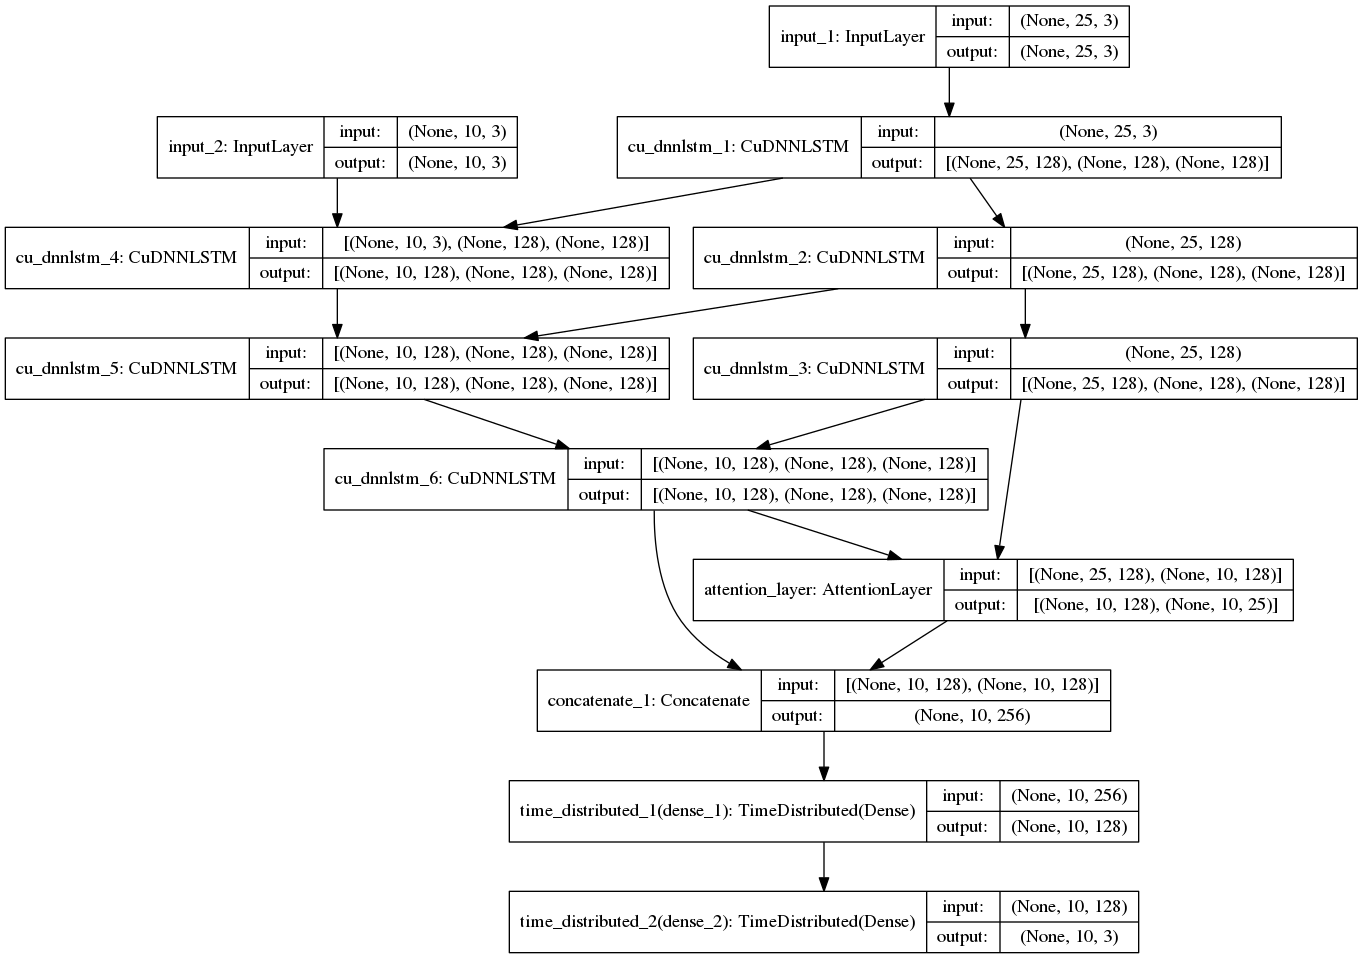

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 100
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

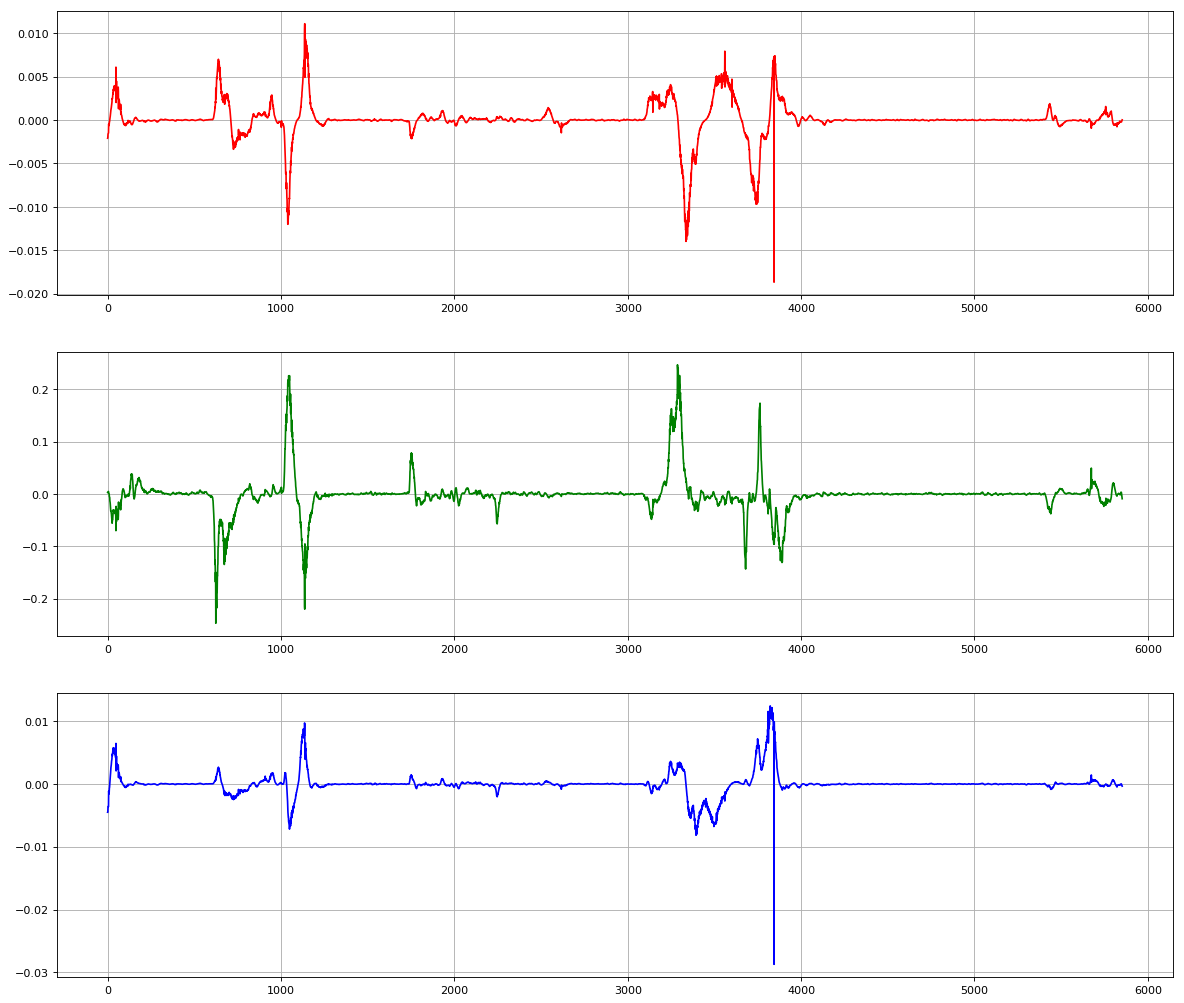

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/100


  1/542 [..............................] - ETA: 14:17 - loss: 0.0098 - rmse: 0.0250 - smape: 91.4338 - mfe: 3.3151e-04

  2/542 [..............................] - ETA: 8:26 - loss: 0.0388 - rmse: 0.1081 - smape: 86.7182 - mfe: 0.0057     

  3/542 [..............................] - ETA: 6:26 - loss: 0.0507 - rmse: 0.1376 - smape: 86.1292 - mfe: 0.0040

  4/542 [..............................] - ETA: 5:31 - loss: 0.0604 - rmse: 0.1677 - smape: 85.9122 - mfe: 0.0027

  5/542 [..............................] - ETA: 4:56 - loss: 0.0561 - rmse: 0.1644 - smape: 86.3651 - mfe: 0.0020

  6/542 [..............................] - ETA: 4:32 - loss: 0.0575 - rmse: 0.1706 - smape: 86.0154 - mfe: 0.0018

  7/542 [..............................] - ETA: 4:15 - loss: 0.0543 - rmse: 0.1630 - smape: 85.6387 - mfe: 0.0016

  8/542 [..............................] - ETA: 4:02 - loss: 0.0556 - rmse: 0.1613 - smape: 85.0348 - mfe: 0.0016

  9/542 [..............................] - ETA: 3:52 - loss: 0.0584 - rmse: 0.1651 - smape: 84.5120 - mfe: 0.0019

 10/542 [..............................] - ETA: 3:44 - loss: 0.0607 - rmse: 0.1786 - smape: 84.7415 - mfe: 0.0018

 11/542 [..............................] - ETA: 3:37 - loss: 0.0585 - rmse: 0.1707 - smape: 84.7439 - mfe: 0.0017

 12/542 [..............................] - ETA: 3:32 - loss: 0.0616 - rmse: 0.1844 - smape: 84.7789 - mfe: 0.0014

 13/542 [..............................] - ETA: 3:26 - loss: 0.0652 - rmse: 0.1922 - smape: 84.8695 - mfe: 0.0012

 14/542 [..............................] - ETA: 3:22 - loss: 0.0702 - rmse: 0.2043 - smape: 84.8752 - mfe: 8.6096e-04

 15/542 [..............................] - ETA: 3:18 - loss: 0.0704 - rmse: 0.2023 - smape: 84.8080 - mfe: 4.9616e-04

 16/542 [..............................] - ETA: 3:15 - loss: 0.0707 - rmse: 0.2022 - smape: 84.7480 - mfe: 4.2213e-04

 17/542 [..............................] - ETA: 3:12 - loss: 0.0700 - rmse: 0.1993 - smape: 84.5241 - mfe: 3.8624e-04

 18/542 [..............................] - ETA: 3:09 - loss: 0.0689 - rmse: 0.1952 - smape: 84.3670 - mfe: 3.2184e-04

 19/542 [>.............................] - ETA: 3:07 - loss: 0.0695 - rmse: 0.1988 - smape: 84.0524 - mfe: 2.1768e-04

 20/542 [>.............................] - ETA: 3:05 - loss: 0.0681 - rmse: 0.1944 - smape: 83.9045 - mfe: -5.5767e-05

 21/542 [>.............................] - ETA: 3:03 - loss: 0.0681 - rmse: 0.1943 - smape: 83.9642 - mfe: -3.1203e-04

 22/542 [>.............................] - ETA: 3:02 - loss: 0.0664 - rmse: 0.1902 - smape: 83.8678 - mfe: -2.8396e-04

 23/542 [>.............................] - ETA: 3:00 - loss: 0.0654 - rmse: 0.1888 - smape: 83.8600 - mfe: -1.4951e-04

 24/542 [>.............................] - ETA: 2:59 - loss: 0.0653 - rmse: 0.1872 - smape: 83.8016 - mfe: -7.2220e-05

 25/542 [>.............................] - ETA: 2:57 - loss: 0.0680 - rmse: 0.1913 - smape: 83.8638 - mfe: 1.2159e-04 

 26/542 [>.............................] - ETA: 2:56 - loss: 0.0681 - rmse: 0.1915 - smape: 83.7067 - mfe: 3.0669e-04

 27/542 [>.............................] - ETA: 2:55 - loss: 0.0699 - rmse: 0.1966 - smape: 83.7571 - mfe: 4.4970e-04

 28/542 [>.............................] - ETA: 2:54 - loss: 0.0691 - rmse: 0.1948 - smape: 83.6373 - mfe: 5.6727e-04

 29/542 [>.............................] - ETA: 2:53 - loss: 0.0692 - rmse: 0.1954 - smape: 83.6922 - mfe: 6.6698e-04

 30/542 [>.............................] - ETA: 2:52 - loss: 0.0683 - rmse: 0.1927 - smape: 83.7691 - mfe: 6.0106e-04

 31/542 [>.............................] - ETA: 2:51 - loss: 0.0679 - rmse: 0.1916 - smape: 83.7424 - mfe: 5.5769e-04

 32/542 [>.............................] - ETA: 2:50 - loss: 0.0680 - rmse: 0.1913 - smape: 83.6793 - mfe: 4.3456e-04

 33/542 [>.............................] - ETA: 2:49 - loss: 0.0667 - rmse: 0.1873 - smape: 83.5030 - mfe: 3.4219e-04

 34/542 [>.............................] - ETA: 2:48 - loss: 0.0668 - rmse: 0.1864 - smape: 83.5297 - mfe: 2.1992e-04

 35/542 [>.............................] - ETA: 2:47 - loss: 0.0664 - rmse: 0.1849 - smape: 83.5726 - mfe: 1.3977e-04

 36/542 [>.............................] - ETA: 2:46 - loss: 0.0673 - rmse: 0.1867 - smape: 83.6199 - mfe: 4.5125e-05

 37/542 [=>............................] - ETA: 2:44 - loss: 0.0666 - rmse: 0.1849 - smape: 83.6610 - mfe: 7.4938e-05

 38/542 [=>............................] - ETA: 2:44 - loss: 0.0657 - rmse: 0.1824 - smape: 83.6989 - mfe: -2.7349e-05

 39/542 [=>............................] - ETA: 2:43 - loss: 0.0651 - rmse: 0.1807 - smape: 83.7129 - mfe: -5.5956e-06

 40/542 [=>............................] - ETA: 2:42 - loss: 0.0650 - rmse: 0.1800 - smape: 83.6545 - mfe: -3.3146e-05

 41/542 [=>............................] - ETA: 2:41 - loss: 0.0649 - rmse: 0.1791 - smape: 83.6368 - mfe: -9.7268e-05

 42/542 [=>............................] - ETA: 2:41 - loss: 0.0649 - rmse: 0.1796 - smape: 83.5578 - mfe: -1.8865e-04

 43/542 [=>............................] - ETA: 2:40 - loss: 0.0641 - rmse: 0.1776 - smape: 83.4217 - mfe: -3.1667e-04

 44/542 [=>............................] - ETA: 2:40 - loss: 0.0640 - rmse: 0.1779 - smape: 83.3913 - mfe: -3.7195e-04

 45/542 [=>............................] - ETA: 2:39 - loss: 0.0633 - rmse: 0.1756 - smape: 83.3750 - mfe: -3.0678e-04

 46/542 [=>............................] - ETA: 2:38 - loss: 0.0654 - rmse: 0.1799 - smape: 83.3550 - mfe: 9.4258e-06 

 47/542 [=>............................] - ETA: 2:38 - loss: 0.0645 - rmse: 0.1772 - smape: 83.2867 - mfe: 1.1904e-04

 48/542 [=>............................] - ETA: 2:37 - loss: 0.0640 - rmse: 0.1754 - smape: 83.2407 - mfe: 6.2924e-05

 49/542 [=>............................] - ETA: 2:37 - loss: 0.0645 - rmse: 0.1761 - smape: 83.1805 - mfe: -4.0053e-05

 50/542 [=>............................] - ETA: 2:36 - loss: 0.0644 - rmse: 0.1753 - smape: 83.1956 - mfe: -2.2399e-04

 51/542 [=>............................] - ETA: 2:35 - loss: 0.0638 - rmse: 0.1747 - smape: 83.1387 - mfe: -3.5453e-04

 52/542 [=>............................] - ETA: 2:34 - loss: 0.0639 - rmse: 0.1748 - smape: 83.1041 - mfe: -4.4639e-04

 53/542 [=>............................] - ETA: 2:34 - loss: 0.0641 - rmse: 0.1760 - smape: 83.0750 - mfe: -4.7674e-04

 54/542 [=>............................] - ETA: 2:33 - loss: 0.0642 - rmse: 0.1759 - smape: 83.0985 - mfe: -4.7384e-04

 55/542 [==>...........................] - ETA: 2:32 - loss: 0.0645 - rmse: 0.1771 - smape: 83.0812 - mfe: -3.9296e-04

 56/542 [==>...........................] - ETA: 2:32 - loss: 0.0643 - rmse: 0.1764 - smape: 83.0780 - mfe: -3.3860e-04

 57/542 [==>...........................] - ETA: 2:32 - loss: 0.0649 - rmse: 0.1776 - smape: 83.0724 - mfe: -2.5404e-04

 58/542 [==>...........................] - ETA: 2:31 - loss: 0.0653 - rmse: 0.1787 - smape: 83.0564 - mfe: -1.4715e-04

 59/542 [==>...........................] - ETA: 2:31 - loss: 0.0648 - rmse: 0.1782 - smape: 82.9836 - mfe: -1.2693e-04

 60/542 [==>...........................] - ETA: 2:30 - loss: 0.0647 - rmse: 0.1776 - smape: 82.9277 - mfe: -1.3695e-04

 61/542 [==>...........................] - ETA: 2:30 - loss: 0.0647 - rmse: 0.1776 - smape: 82.8875 - mfe: -1.4153e-04

 62/542 [==>...........................] - ETA: 2:29 - loss: 0.0649 - rmse: 0.1777 - smape: 82.8731 - mfe: -1.4229e-04

 63/542 [==>...........................] - ETA: 2:28 - loss: 0.0646 - rmse: 0.1767 - smape: 82.9411 - mfe: -1.4685e-04

 64/542 [==>...........................] - ETA: 2:28 - loss: 0.0651 - rmse: 0.1779 - smape: 82.9597 - mfe: -1.3008e-04

 65/542 [==>...........................] - ETA: 2:27 - loss: 0.0654 - rmse: 0.1780 - smape: 83.0152 - mfe: -5.9679e-05

 66/542 [==>...........................] - ETA: 2:26 - loss: 0.0654 - rmse: 0.1780 - smape: 83.0317 - mfe: 3.2067e-05 

 67/542 [==>...........................] - ETA: 2:26 - loss: 0.0653 - rmse: 0.1790 - smape: 83.0375 - mfe: 1.2141e-04

 68/542 [==>...........................] - ETA: 2:26 - loss: 0.0659 - rmse: 0.1801 - smape: 83.0247 - mfe: 2.0641e-04

 69/542 [==>...........................] - ETA: 2:25 - loss: 0.0656 - rmse: 0.1795 - smape: 83.0232 - mfe: 2.2076e-04

 70/542 [==>...........................] - ETA: 2:25 - loss: 0.0657 - rmse: 0.1798 - smape: 83.0136 - mfe: 2.0722e-04

 71/542 [==>...........................] - ETA: 2:25 - loss: 0.0655 - rmse: 0.1798 - smape: 82.9967 - mfe: 1.6364e-04

 72/542 [==>...........................] - ETA: 2:24 - loss: 0.0652 - rmse: 0.1794 - smape: 82.9650 - mfe: 1.2294e-04

 73/542 [===>..........................] - ETA: 2:24 - loss: 0.0659 - rmse: 0.1810 - smape: 82.9784 - mfe: 9.7093e-05

 74/542 [===>..........................] - ETA: 2:23 - loss: 0.0655 - rmse: 0.1803 - smape: 82.9593 - mfe: 8.6482e-05

 75/542 [===>..........................] - ETA: 2:22 - loss: 0.0656 - rmse: 0.1803 - smape: 82.9954 - mfe: 5.7664e-05

 76/542 [===>..........................] - ETA: 2:22 - loss: 0.0650 - rmse: 0.1788 - smape: 83.0042 - mfe: 2.9836e-05

 77/542 [===>..........................] - ETA: 2:22 - loss: 0.0651 - rmse: 0.1788 - smape: 83.0133 - mfe: 5.7489e-06

 78/542 [===>..........................] - ETA: 2:21 - loss: 0.0654 - rmse: 0.1794 - smape: 83.0597 - mfe: 1.4437e-06

 79/542 [===>..........................] - ETA: 2:21 - loss: 0.0656 - rmse: 0.1798 - smape: 83.0625 - mfe: 4.9585e-06

 80/542 [===>..........................] - ETA: 2:21 - loss: 0.0655 - rmse: 0.1796 - smape: 83.0853 - mfe: 6.7483e-06

 81/542 [===>..........................] - ETA: 2:20 - loss: 0.0656 - rmse: 0.1797 - smape: 83.0804 - mfe: -2.6255e-05

 82/542 [===>..........................] - ETA: 2:19 - loss: 0.0650 - rmse: 0.1783 - smape: 83.0882 - mfe: -1.0516e-05

 83/542 [===>..........................] - ETA: 2:19 - loss: 0.0647 - rmse: 0.1772 - smape: 83.0949 - mfe: -2.6781e-05

 84/542 [===>..........................] - ETA: 2:19 - loss: 0.0647 - rmse: 0.1768 - smape: 83.1173 - mfe: -1.2244e-04

 85/542 [===>..........................] - ETA: 2:18 - loss: 0.0644 - rmse: 0.1760 - smape: 83.1072 - mfe: -1.4797e-04

 86/542 [===>..........................] - ETA: 2:18 - loss: 0.0647 - rmse: 0.1762 - smape: 83.1266 - mfe: -1.1883e-04

 87/542 [===>..........................] - ETA: 2:17 - loss: 0.0646 - rmse: 0.1762 - smape: 83.1270 - mfe: -6.0141e-05

 88/542 [===>..........................] - ETA: 2:17 - loss: 0.0646 - rmse: 0.1758 - smape: 83.1721 - mfe: -1.0070e-05

 89/542 [===>..........................] - ETA: 2:17 - loss: 0.0646 - rmse: 0.1758 - smape: 83.2267 - mfe: 1.4133e-05 

 90/542 [===>..........................] - ETA: 2:16 - loss: 0.0643 - rmse: 0.1748 - smape: 83.2656 - mfe: 1.5581e-05

 91/542 [====>.........................] - ETA: 2:16 - loss: 0.0649 - rmse: 0.1765 - smape: 83.3266 - mfe: 2.1688e-05

 92/542 [====>.........................] - ETA: 2:16 - loss: 0.0653 - rmse: 0.1773 - smape: 83.3922 - mfe: 2.3344e-05

 93/542 [====>.........................] - ETA: 2:15 - loss: 0.0655 - rmse: 0.1779 - smape: 83.4158 - mfe: 2.2264e-06

 94/542 [====>.........................] - ETA: 2:15 - loss: 0.0656 - rmse: 0.1780 - smape: 83.4305 - mfe: -9.7545e-06

 95/542 [====>.........................] - ETA: 2:15 - loss: 0.0651 - rmse: 0.1765 - smape: 83.4280 - mfe: -2.0650e-05

 96/542 [====>.........................] - ETA: 2:14 - loss: 0.0650 - rmse: 0.1764 - smape: 83.4797 - mfe: -1.8568e-05

 97/542 [====>.........................] - ETA: 2:14 - loss: 0.0649 - rmse: 0.1761 - smape: 83.4707 - mfe: -3.2149e-05

 98/542 [====>.........................] - ETA: 2:13 - loss: 0.0652 - rmse: 0.1766 - smape: 83.5176 - mfe: -3.3281e-05

 99/542 [====>.........................] - ETA: 2:12 - loss: 0.0647 - rmse: 0.1756 - smape: 83.4228 - mfe: 3.6904e-06 

100/542 [====>.........................] - ETA: 2:12 - loss: 0.0644 - rmse: 0.1753 - smape: 83.3852 - mfe: 4.9386e-06

101/542 [====>.........................] - ETA: 2:12 - loss: 0.0644 - rmse: 0.1752 - smape: 83.4118 - mfe: 4.3539e-05

102/542 [====>.........................] - ETA: 2:11 - loss: 0.0645 - rmse: 0.1753 - smape: 83.4556 - mfe: 8.6563e-05

103/542 [====>.........................] - ETA: 2:11 - loss: 0.0645 - rmse: 0.1751 - smape: 83.4763 - mfe: 1.2990e-04

104/542 [====>.........................] - ETA: 2:11 - loss: 0.0643 - rmse: 0.1746 - smape: 83.4586 - mfe: 1.9224e-04

105/542 [====>.........................] - ETA: 2:11 - loss: 0.0645 - rmse: 0.1755 - smape: 83.4214 - mfe: 2.8367e-04

106/542 [====>.........................] - ETA: 2:10 - loss: 0.0644 - rmse: 0.1753 - smape: 83.4056 - mfe: 2.9877e-04

107/542 [====>.........................] - ETA: 2:10 - loss: 0.0643 - rmse: 0.1752 - smape: 83.3921 - mfe: 3.0986e-04

108/542 [====>.........................] - ETA: 2:10 - loss: 0.0644 - rmse: 0.1752 - smape: 83.3997 - mfe: 2.9767e-04

109/542 [=====>........................] - ETA: 2:09 - loss: 0.0639 - rmse: 0.1743 - smape: 83.3726 - mfe: 2.8711e-04

110/542 [=====>........................] - ETA: 2:09 - loss: 0.0641 - rmse: 0.1746 - smape: 83.3753 - mfe: 3.0638e-04

111/542 [=====>........................] - ETA: 2:09 - loss: 0.0641 - rmse: 0.1746 - smape: 83.3690 - mfe: 3.1022e-04

112/542 [=====>........................] - ETA: 2:08 - loss: 0.0640 - rmse: 0.1744 - smape: 83.3822 - mfe: 2.9615e-04

113/542 [=====>........................] - ETA: 2:08 - loss: 0.0640 - rmse: 0.1745 - smape: 83.3677 - mfe: 3.0360e-04

114/542 [=====>........................] - ETA: 2:08 - loss: 0.0641 - rmse: 0.1750 - smape: 83.3600 - mfe: 3.1546e-04

115/542 [=====>........................] - ETA: 2:07 - loss: 0.0641 - rmse: 0.1749 - smape: 83.3649 - mfe: 3.3591e-04

116/542 [=====>........................] - ETA: 2:07 - loss: 0.0643 - rmse: 0.1751 - smape: 83.3767 - mfe: 3.4572e-04

117/542 [=====>........................] - ETA: 2:07 - loss: 0.0642 - rmse: 0.1750 - smape: 83.3950 - mfe: 3.6211e-04

118/542 [=====>........................] - ETA: 2:06 - loss: 0.0644 - rmse: 0.1758 - smape: 83.3885 - mfe: 3.8420e-04

119/542 [=====>........................] - ETA: 2:06 - loss: 0.0643 - rmse: 0.1759 - smape: 83.3817 - mfe: 4.2008e-04

120/542 [=====>........................] - ETA: 2:06 - loss: 0.0643 - rmse: 0.1760 - smape: 83.3621 - mfe: 4.1255e-04

121/542 [=====>........................] - ETA: 2:05 - loss: 0.0643 - rmse: 0.1762 - smape: 83.3394 - mfe: 4.0471e-04

122/542 [=====>........................] - ETA: 2:05 - loss: 0.0643 - rmse: 0.1758 - smape: 83.3064 - mfe: 4.1950e-04

123/542 [=====>........................] - ETA: 2:05 - loss: 0.0641 - rmse: 0.1753 - smape: 83.3214 - mfe: 4.3078e-04

124/542 [=====>........................] - ETA: 2:04 - loss: 0.0639 - rmse: 0.1747 - smape: 83.2971 - mfe: 4.2400e-04

125/542 [=====>........................] - ETA: 2:04 - loss: 0.0645 - rmse: 0.1764 - smape: 83.2556 - mfe: 4.0283e-04

126/542 [=====>........................] - ETA: 2:04 - loss: 0.0643 - rmse: 0.1758 - smape: 83.2654 - mfe: 4.3403e-04

127/542 [======>.......................] - ETA: 2:04 - loss: 0.0647 - rmse: 0.1768 - smape: 83.2718 - mfe: 4.3174e-04

128/542 [======>.......................] - ETA: 2:03 - loss: 0.0645 - rmse: 0.1764 - smape: 83.2692 - mfe: 4.0871e-04

129/542 [======>.......................] - ETA: 2:03 - loss: 0.0642 - rmse: 0.1758 - smape: 83.2636 - mfe: 3.9201e-04

130/542 [======>.......................] - ETA: 2:03 - loss: 0.0640 - rmse: 0.1753 - smape: 83.2481 - mfe: 3.7664e-04

131/542 [======>.......................] - ETA: 2:02 - loss: 0.0645 - rmse: 0.1764 - smape: 83.2628 - mfe: 3.6666e-04

132/542 [======>.......................] - ETA: 2:02 - loss: 0.0645 - rmse: 0.1765 - smape: 83.2684 - mfe: 3.3955e-04

133/542 [======>.......................] - ETA: 2:02 - loss: 0.0645 - rmse: 0.1762 - smape: 83.3145 - mfe: 3.1491e-04

134/542 [======>.......................] - ETA: 2:01 - loss: 0.0647 - rmse: 0.1773 - smape: 83.2765 - mfe: 2.9171e-04

135/542 [======>.......................] - ETA: 2:01 - loss: 0.0647 - rmse: 0.1777 - smape: 83.2418 - mfe: 2.7072e-04

136/542 [======>.......................] - ETA: 2:01 - loss: 0.0654 - rmse: 0.1796 - smape: 83.2597 - mfe: 2.4803e-04

137/542 [======>.......................] - ETA: 2:00 - loss: 0.0653 - rmse: 0.1794 - smape: 83.2682 - mfe: 2.4064e-04

138/542 [======>.......................] - ETA: 2:00 - loss: 0.0650 - rmse: 0.1790 - smape: 83.2484 - mfe: 2.6655e-04

139/542 [======>.......................] - ETA: 2:00 - loss: 0.0654 - rmse: 0.1799 - smape: 83.2874 - mfe: 2.5151e-04

140/542 [======>.......................] - ETA: 1:59 - loss: 0.0655 - rmse: 0.1800 - smape: 83.3033 - mfe: 2.3792e-04

141/542 [======>.......................] - ETA: 1:59 - loss: 0.0655 - rmse: 0.1802 - smape: 83.2764 - mfe: 2.1448e-04

142/542 [======>.......................] - ETA: 1:59 - loss: 0.0656 - rmse: 0.1803 - smape: 83.2430 - mfe: 1.9940e-04

143/542 [======>.......................] - ETA: 1:58 - loss: 0.0656 - rmse: 0.1807 - smape: 83.2315 - mfe: 1.9530e-04

144/542 [======>.......................] - ETA: 1:58 - loss: 0.0654 - rmse: 0.1800 - smape: 83.2330 - mfe: 2.2321e-04

145/542 [=======>......................] - ETA: 1:58 - loss: 0.0655 - rmse: 0.1806 - smape: 83.2420 - mfe: 2.2070e-04

146/542 [=======>......................] - ETA: 1:58 - loss: 0.0656 - rmse: 0.1806 - smape: 83.2138 - mfe: 2.1000e-04

147/542 [=======>......................] - ETA: 1:57 - loss: 0.0655 - rmse: 0.1804 - smape: 83.1840 - mfe: 1.9961e-04

148/542 [=======>......................] - ETA: 1:57 - loss: 0.0653 - rmse: 0.1800 - smape: 83.1626 - mfe: 2.1786e-04

149/542 [=======>......................] - ETA: 1:56 - loss: 0.0654 - rmse: 0.1802 - smape: 83.1521 - mfe: 2.3980e-04

150/542 [=======>......................] - ETA: 1:56 - loss: 0.0652 - rmse: 0.1794 - smape: 83.1274 - mfe: 1.9555e-04

151/542 [=======>......................] - ETA: 1:56 - loss: 0.0653 - rmse: 0.1796 - smape: 83.1104 - mfe: 2.5955e-04

152/542 [=======>......................] - ETA: 1:55 - loss: 0.0652 - rmse: 0.1793 - smape: 83.0724 - mfe: 3.7179e-04

153/542 [=======>......................] - ETA: 1:55 - loss: 0.0653 - rmse: 0.1796 - smape: 83.0756 - mfe: 3.9783e-04

154/542 [=======>......................] - ETA: 1:55 - loss: 0.0649 - rmse: 0.1786 - smape: 83.0783 - mfe: 3.6697e-04

155/542 [=======>......................] - ETA: 1:54 - loss: 0.0649 - rmse: 0.1789 - smape: 83.0511 - mfe: 3.6354e-04

156/542 [=======>......................] - ETA: 1:54 - loss: 0.0646 - rmse: 0.1781 - smape: 83.0551 - mfe: 3.5869e-04

157/542 [=======>......................] - ETA: 1:54 - loss: 0.0647 - rmse: 0.1782 - smape: 83.0422 - mfe: 3.6349e-04

158/542 [=======>......................] - ETA: 1:53 - loss: 0.0646 - rmse: 0.1778 - smape: 83.0365 - mfe: 3.9043e-04

159/542 [=======>......................] - ETA: 1:53 - loss: 0.0649 - rmse: 0.1784 - smape: 83.0382 - mfe: 4.1593e-04

160/542 [=======>......................] - ETA: 1:53 - loss: 0.0651 - rmse: 0.1789 - smape: 83.0312 - mfe: 4.3526e-04

161/542 [=======>......................] - ETA: 1:52 - loss: 0.0654 - rmse: 0.1797 - smape: 83.0174 - mfe: 4.8975e-04

162/542 [=======>......................] - ETA: 1:52 - loss: 0.0654 - rmse: 0.1796 - smape: 82.9885 - mfe: 5.2205e-04

163/542 [========>.....................] - ETA: 1:52 - loss: 0.0654 - rmse: 0.1797 - smape: 82.9895 - mfe: 5.4213e-04

164/542 [========>.....................] - ETA: 1:52 - loss: 0.0654 - rmse: 0.1795 - smape: 82.9908 - mfe: 5.5483e-04

165/542 [========>.....................] - ETA: 1:51 - loss: 0.0654 - rmse: 0.1795 - smape: 82.9912 - mfe: 5.6702e-04

166/542 [========>.....................] - ETA: 1:51 - loss: 0.0652 - rmse: 0.1790 - smape: 82.9804 - mfe: 5.5719e-04

167/542 [========>.....................] - ETA: 1:51 - loss: 0.0653 - rmse: 0.1793 - smape: 82.9774 - mfe: 5.1696e-04

168/542 [========>.....................] - ETA: 1:50 - loss: 0.0654 - rmse: 0.1795 - smape: 82.9390 - mfe: 4.6794e-04

169/542 [========>.....................] - ETA: 1:50 - loss: 0.0653 - rmse: 0.1795 - smape: 82.9151 - mfe: 4.3669e-04

170/542 [========>.....................] - ETA: 1:50 - loss: 0.0650 - rmse: 0.1787 - smape: 82.9025 - mfe: 4.3739e-04

171/542 [========>.....................] - ETA: 1:49 - loss: 0.0649 - rmse: 0.1785 - smape: 82.8886 - mfe: 4.4419e-04

172/542 [========>.....................] - ETA: 1:49 - loss: 0.0648 - rmse: 0.1785 - smape: 82.8469 - mfe: 4.5458e-04

173/542 [========>.....................] - ETA: 1:49 - loss: 0.0647 - rmse: 0.1784 - smape: 82.8214 - mfe: 4.6894e-04

174/542 [========>.....................] - ETA: 1:49 - loss: 0.0647 - rmse: 0.1782 - smape: 82.8295 - mfe: 4.6664e-04

175/542 [========>.....................] - ETA: 1:48 - loss: 0.0645 - rmse: 0.1780 - smape: 82.8127 - mfe: 4.6836e-04

176/542 [========>.....................] - ETA: 1:48 - loss: 0.0643 - rmse: 0.1772 - smape: 82.8380 - mfe: 4.6534e-04

177/542 [========>.....................] - ETA: 1:48 - loss: 0.0642 - rmse: 0.1772 - smape: 82.8452 - mfe: 4.6548e-04

178/542 [========>.....................] - ETA: 1:47 - loss: 0.0641 - rmse: 0.1771 - smape: 82.8579 - mfe: 4.5997e-04

179/542 [========>.....................] - ETA: 1:47 - loss: 0.0640 - rmse: 0.1768 - smape: 82.8403 - mfe: 4.5753e-04

180/542 [========>.....................] - ETA: 1:47 - loss: 0.0640 - rmse: 0.1769 - smape: 82.8295 - mfe: 4.6775e-04

181/542 [=========>....................] - ETA: 1:47 - loss: 0.0641 - rmse: 0.1771 - smape: 82.8505 - mfe: 4.7030e-04

182/542 [=========>....................] - ETA: 1:46 - loss: 0.0639 - rmse: 0.1766 - smape: 82.8266 - mfe: 4.6411e-04

183/542 [=========>....................] - ETA: 1:46 - loss: 0.0642 - rmse: 0.1776 - smape: 82.8344 - mfe: 4.7654e-04

184/542 [=========>....................] - ETA: 1:46 - loss: 0.0641 - rmse: 0.1773 - smape: 82.8442 - mfe: 4.6910e-04

185/542 [=========>....................] - ETA: 1:45 - loss: 0.0642 - rmse: 0.1779 - smape: 82.8384 - mfe: 4.7502e-04

186/542 [=========>....................] - ETA: 1:45 - loss: 0.0640 - rmse: 0.1773 - smape: 82.8441 - mfe: 4.6618e-04

187/542 [=========>....................] - ETA: 1:45 - loss: 0.0641 - rmse: 0.1772 - smape: 82.8555 - mfe: 4.6904e-04

188/542 [=========>....................] - ETA: 1:44 - loss: 0.0641 - rmse: 0.1774 - smape: 82.8429 - mfe: 4.8379e-04

189/542 [=========>....................] - ETA: 1:44 - loss: 0.0639 - rmse: 0.1769 - smape: 82.8533 - mfe: 4.8186e-04

190/542 [=========>....................] - ETA: 1:44 - loss: 0.0641 - rmse: 0.1774 - smape: 82.8624 - mfe: 4.8136e-04

191/542 [=========>....................] - ETA: 1:43 - loss: 0.0642 - rmse: 0.1774 - smape: 82.8687 - mfe: 4.9215e-04

192/542 [=========>....................] - ETA: 1:43 - loss: 0.0642 - rmse: 0.1778 - smape: 82.8801 - mfe: 4.9558e-04

193/542 [=========>....................] - ETA: 1:43 - loss: 0.0641 - rmse: 0.1775 - smape: 82.8859 - mfe: 4.9018e-04

194/542 [=========>....................] - ETA: 1:42 - loss: 0.0640 - rmse: 0.1771 - smape: 82.8850 - mfe: 4.8832e-04

195/542 [=========>....................] - ETA: 1:42 - loss: 0.0642 - rmse: 0.1775 - smape: 82.8792 - mfe: 4.8148e-04

196/542 [=========>....................] - ETA: 1:42 - loss: 0.0643 - rmse: 0.1778 - smape: 82.8820 - mfe: 4.8505e-04

197/542 [=========>....................] - ETA: 1:42 - loss: 0.0643 - rmse: 0.1779 - smape: 82.8739 - mfe: 4.8973e-04

198/542 [=========>....................] - ETA: 1:41 - loss: 0.0643 - rmse: 0.1780 - smape: 82.8713 - mfe: 4.9126e-04

199/542 [==========>...................] - ETA: 1:41 - loss: 0.0644 - rmse: 0.1781 - smape: 82.8764 - mfe: 4.8666e-04

200/542 [==========>...................] - ETA: 1:41 - loss: 0.0641 - rmse: 0.1774 - smape: 82.8752 - mfe: 4.7778e-04

201/542 [==========>...................] - ETA: 1:40 - loss: 0.0640 - rmse: 0.1772 - smape: 82.8868 - mfe: 4.8111e-04

202/542 [==========>...................] - ETA: 1:40 - loss: 0.0638 - rmse: 0.1770 - smape: 82.8763 - mfe: 4.8400e-04

203/542 [==========>...................] - ETA: 1:40 - loss: 0.0639 - rmse: 0.1773 - smape: 82.8703 - mfe: 4.8824e-04

204/542 [==========>...................] - ETA: 1:39 - loss: 0.0640 - rmse: 0.1775 - smape: 82.8375 - mfe: 4.8300e-04

205/542 [==========>...................] - ETA: 1:39 - loss: 0.0639 - rmse: 0.1773 - smape: 82.8151 - mfe: 4.6601e-04

206/542 [==========>...................] - ETA: 1:39 - loss: 0.0637 - rmse: 0.1766 - smape: 82.8027 - mfe: 4.5498e-04

207/542 [==========>...................] - ETA: 1:39 - loss: 0.0638 - rmse: 0.1769 - smape: 82.8013 - mfe: 4.6416e-04

208/542 [==========>...................] - ETA: 1:38 - loss: 0.0636 - rmse: 0.1763 - smape: 82.7894 - mfe: 4.8821e-04

209/542 [==========>...................] - ETA: 1:38 - loss: 0.0634 - rmse: 0.1759 - smape: 82.7857 - mfe: 4.8726e-04

210/542 [==========>...................] - ETA: 1:38 - loss: 0.0633 - rmse: 0.1756 - smape: 82.7911 - mfe: 4.6538e-04

211/542 [==========>...................] - ETA: 1:37 - loss: 0.0633 - rmse: 0.1751 - smape: 82.8116 - mfe: 4.4277e-04

212/542 [==========>...................] - ETA: 1:37 - loss: 0.0632 - rmse: 0.1749 - smape: 82.8090 - mfe: 4.4249e-04

213/542 [==========>...................] - ETA: 1:37 - loss: 0.0633 - rmse: 0.1751 - smape: 82.8023 - mfe: 4.5372e-04

214/542 [==========>...................] - ETA: 1:36 - loss: 0.0633 - rmse: 0.1751 - smape: 82.7957 - mfe: 4.7186e-04

215/542 [==========>...................] - ETA: 1:36 - loss: 0.0634 - rmse: 0.1754 - smape: 82.8015 - mfe: 4.9373e-04

216/542 [==========>...................] - ETA: 1:36 - loss: 0.0632 - rmse: 0.1747 - smape: 82.8203 - mfe: 4.9942e-04

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0630 - rmse: 0.1741 - smape: 82.8131 - mfe: 4.9288e-04

218/542 [===========>..................] - ETA: 1:35 - loss: 0.0629 - rmse: 0.1738 - smape: 82.8185 - mfe: 4.8542e-04

219/542 [===========>..................] - ETA: 1:35 - loss: 0.0630 - rmse: 0.1739 - smape: 82.8121 - mfe: 4.7370e-04

220/542 [===========>..................] - ETA: 1:35 - loss: 0.0627 - rmse: 0.1735 - smape: 82.7687 - mfe: 4.6936e-04

221/542 [===========>..................] - ETA: 1:34 - loss: 0.0630 - rmse: 0.1740 - smape: 82.7684 - mfe: 4.7194e-04

222/542 [===========>..................] - ETA: 1:34 - loss: 0.0631 - rmse: 0.1741 - smape: 82.7687 - mfe: 4.7121e-04

223/542 [===========>..................] - ETA: 1:34 - loss: 0.0631 - rmse: 0.1741 - smape: 82.7671 - mfe: 4.7538e-04

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0634 - rmse: 0.1750 - smape: 82.7659 - mfe: 4.6477e-04

225/542 [===========>..................] - ETA: 1:33 - loss: 0.0634 - rmse: 0.1750 - smape: 82.7442 - mfe: 4.4267e-04

226/542 [===========>..................] - ETA: 1:33 - loss: 0.0634 - rmse: 0.1748 - smape: 82.7392 - mfe: 4.2708e-04

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0634 - rmse: 0.1750 - smape: 82.7332 - mfe: 4.1758e-04

228/542 [===========>..................] - ETA: 1:32 - loss: 0.0635 - rmse: 0.1752 - smape: 82.7245 - mfe: 4.0189e-04

229/542 [===========>..................] - ETA: 1:32 - loss: 0.0636 - rmse: 0.1753 - smape: 82.7249 - mfe: 3.8142e-04

230/542 [===========>..................] - ETA: 1:32 - loss: 0.0635 - rmse: 0.1749 - smape: 82.7248 - mfe: 3.7030e-04

231/542 [===========>..................] - ETA: 1:31 - loss: 0.0634 - rmse: 0.1747 - smape: 82.7322 - mfe: 3.6634e-04

232/542 [===========>..................] - ETA: 1:31 - loss: 0.0634 - rmse: 0.1748 - smape: 82.7401 - mfe: 3.6235e-04

233/542 [===========>..................] - ETA: 1:31 - loss: 0.0632 - rmse: 0.1747 - smape: 82.7132 - mfe: 3.6716e-04

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0632 - rmse: 0.1745 - smape: 82.7083 - mfe: 3.7415e-04

235/542 [============>.................] - ETA: 1:30 - loss: 0.0634 - rmse: 0.1750 - smape: 82.6940 - mfe: 3.5897e-04

236/542 [============>.................] - ETA: 1:30 - loss: 0.0634 - rmse: 0.1750 - smape: 82.6909 - mfe: 3.3106e-04

237/542 [============>.................] - ETA: 1:29 - loss: 0.0634 - rmse: 0.1751 - smape: 82.6697 - mfe: 2.9581e-04

238/542 [============>.................] - ETA: 1:29 - loss: 0.0634 - rmse: 0.1751 - smape: 82.6782 - mfe: 3.0369e-04

239/542 [============>.................] - ETA: 1:29 - loss: 0.0633 - rmse: 0.1748 - smape: 82.6729 - mfe: 3.4980e-04

240/542 [============>.................] - ETA: 1:28 - loss: 0.0632 - rmse: 0.1746 - smape: 82.6668 - mfe: 3.7816e-04

241/542 [============>.................] - ETA: 1:28 - loss: 0.0634 - rmse: 0.1750 - smape: 82.6569 - mfe: 3.5930e-04

242/542 [============>.................] - ETA: 1:28 - loss: 0.0633 - rmse: 0.1748 - smape: 82.6253 - mfe: 3.0045e-04

243/542 [============>.................] - ETA: 1:28 - loss: 0.0633 - rmse: 0.1747 - smape: 82.5991 - mfe: 2.5510e-04

244/542 [============>.................] - ETA: 1:27 - loss: 0.0633 - rmse: 0.1746 - smape: 82.6006 - mfe: 2.3239e-04

245/542 [============>.................] - ETA: 1:27 - loss: 0.0631 - rmse: 0.1740 - smape: 82.5929 - mfe: 2.2422e-04

246/542 [============>.................] - ETA: 1:27 - loss: 0.0630 - rmse: 0.1739 - smape: 82.5893 - mfe: 2.3913e-04

247/542 [============>.................] - ETA: 1:26 - loss: 0.0629 - rmse: 0.1735 - smape: 82.5913 - mfe: 2.5758e-04

248/542 [============>.................] - ETA: 1:26 - loss: 0.0629 - rmse: 0.1733 - smape: 82.5883 - mfe: 2.8214e-04

249/542 [============>.................] - ETA: 1:26 - loss: 0.0630 - rmse: 0.1737 - smape: 82.5947 - mfe: 3.1128e-04

250/542 [============>.................] - ETA: 1:25 - loss: 0.0631 - rmse: 0.1737 - smape: 82.6040 - mfe: 3.3299e-04

251/542 [============>.................] - ETA: 1:25 - loss: 0.0630 - rmse: 0.1736 - smape: 82.6010 - mfe: 3.5249e-04

252/542 [============>.................] - ETA: 1:25 - loss: 0.0630 - rmse: 0.1736 - smape: 82.5969 - mfe: 3.7201e-04

253/542 [=============>................] - ETA: 1:25 - loss: 0.0630 - rmse: 0.1734 - smape: 82.5931 - mfe: 3.8744e-04

254/542 [=============>................] - ETA: 1:24 - loss: 0.0630 - rmse: 0.1736 - smape: 82.5952 - mfe: 4.1093e-04

255/542 [=============>................] - ETA: 1:24 - loss: 0.0631 - rmse: 0.1737 - smape: 82.6016 - mfe: 4.2486e-04

256/542 [=============>................] - ETA: 1:24 - loss: 0.0630 - rmse: 0.1735 - smape: 82.6022 - mfe: 4.2990e-04

257/542 [=============>................] - ETA: 1:23 - loss: 0.0630 - rmse: 0.1735 - smape: 82.6047 - mfe: 4.4563e-04

258/542 [=============>................] - ETA: 1:23 - loss: 0.0630 - rmse: 0.1733 - smape: 82.6168 - mfe: 4.4825e-04

259/542 [=============>................] - ETA: 1:23 - loss: 0.0629 - rmse: 0.1731 - smape: 82.6198 - mfe: 4.4353e-04

260/542 [=============>................] - ETA: 1:22 - loss: 0.0631 - rmse: 0.1735 - smape: 82.6248 - mfe: 4.5839e-04

261/542 [=============>................] - ETA: 1:22 - loss: 0.0632 - rmse: 0.1737 - smape: 82.6197 - mfe: 4.5811e-04

262/542 [=============>................] - ETA: 1:22 - loss: 0.0633 - rmse: 0.1740 - smape: 82.6199 - mfe: 4.6078e-04

263/542 [=============>................] - ETA: 1:22 - loss: 0.0633 - rmse: 0.1739 - smape: 82.6226 - mfe: 4.5021e-04

264/542 [=============>................] - ETA: 1:21 - loss: 0.0633 - rmse: 0.1740 - smape: 82.6302 - mfe: 4.5583e-04

265/542 [=============>................] - ETA: 1:21 - loss: 0.0631 - rmse: 0.1735 - smape: 82.6003 - mfe: 4.5090e-04

266/542 [=============>................] - ETA: 1:21 - loss: 0.0630 - rmse: 0.1731 - smape: 82.6032 - mfe: 4.6082e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0632 - rmse: 0.1735 - smape: 82.5963 - mfe: 4.9351e-04

268/542 [=============>................] - ETA: 1:20 - loss: 0.0630 - rmse: 0.1731 - smape: 82.5932 - mfe: 5.1265e-04

269/542 [=============>................] - ETA: 1:20 - loss: 0.0630 - rmse: 0.1730 - smape: 82.5954 - mfe: 5.2582e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0630 - rmse: 0.1728 - smape: 82.5990 - mfe: 5.2586e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0629 - rmse: 0.1725 - smape: 82.5840 - mfe: 5.1871e-04

272/542 [==============>...............] - ETA: 1:19 - loss: 0.0627 - rmse: 0.1721 - smape: 82.5804 - mfe: 5.1037e-04

273/542 [==============>...............] - ETA: 1:19 - loss: 0.0629 - rmse: 0.1724 - smape: 82.5813 - mfe: 4.9446e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0629 - rmse: 0.1726 - smape: 82.5758 - mfe: 4.8752e-04

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0628 - rmse: 0.1724 - smape: 82.5606 - mfe: 4.8492e-04

276/542 [==============>...............] - ETA: 1:18 - loss: 0.0627 - rmse: 0.1720 - smape: 82.5579 - mfe: 4.7779e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0626 - rmse: 0.1721 - smape: 82.5319 - mfe: 4.7240e-04

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0628 - rmse: 0.1725 - smape: 82.5278 - mfe: 4.7711e-04

279/542 [==============>...............] - ETA: 1:17 - loss: 0.0627 - rmse: 0.1723 - smape: 82.5319 - mfe: 4.7561e-04

280/542 [==============>...............] - ETA: 1:17 - loss: 0.0625 - rmse: 0.1717 - smape: 82.5220 - mfe: 4.7238e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0625 - rmse: 0.1717 - smape: 82.5194 - mfe: 4.7500e-04

282/542 [==============>...............] - ETA: 1:16 - loss: 0.0625 - rmse: 0.1717 - smape: 82.5133 - mfe: 4.7210e-04

283/542 [==============>...............] - ETA: 1:16 - loss: 0.0624 - rmse: 0.1715 - smape: 82.4972 - mfe: 4.6841e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0624 - rmse: 0.1715 - smape: 82.4824 - mfe: 4.6168e-04

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0626 - rmse: 0.1719 - smape: 82.4781 - mfe: 4.5868e-04

286/542 [==============>...............] - ETA: 1:15 - loss: 0.0625 - rmse: 0.1718 - smape: 82.4740 - mfe: 4.6003e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0625 - rmse: 0.1718 - smape: 82.4641 - mfe: 4.6999e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0626 - rmse: 0.1719 - smape: 82.4663 - mfe: 4.6906e-04

289/542 [==============>...............] - ETA: 1:14 - loss: 0.0625 - rmse: 0.1719 - smape: 82.4558 - mfe: 4.6801e-04

290/542 [===============>..............] - ETA: 1:14 - loss: 0.0624 - rmse: 0.1716 - smape: 82.4719 - mfe: 4.6389e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0625 - rmse: 0.1718 - smape: 82.4823 - mfe: 4.5904e-04

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0624 - rmse: 0.1715 - smape: 82.4784 - mfe: 4.5338e-04

293/542 [===============>..............] - ETA: 1:13 - loss: 0.0624 - rmse: 0.1715 - smape: 82.4916 - mfe: 4.4972e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0624 - rmse: 0.1716 - smape: 82.5076 - mfe: 4.5133e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0625 - rmse: 0.1717 - smape: 82.5231 - mfe: 4.4927e-04

296/542 [===============>..............] - ETA: 1:12 - loss: 0.0624 - rmse: 0.1714 - smape: 82.5243 - mfe: 4.5095e-04

297/542 [===============>..............] - ETA: 1:12 - loss: 0.0626 - rmse: 0.1716 - smape: 82.5393 - mfe: 4.4765e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0624 - rmse: 0.1712 - smape: 82.5207 - mfe: 4.4635e-04

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0624 - rmse: 0.1712 - smape: 82.5244 - mfe: 4.4347e-04

300/542 [===============>..............] - ETA: 1:11 - loss: 0.0624 - rmse: 0.1712 - smape: 82.5328 - mfe: 4.4286e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0623 - rmse: 0.1711 - smape: 82.5233 - mfe: 4.3215e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0624 - rmse: 0.1714 - smape: 82.5156 - mfe: 4.3639e-04

303/542 [===============>..............] - ETA: 1:10 - loss: 0.0624 - rmse: 0.1713 - smape: 82.5136 - mfe: 4.3588e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0624 - rmse: 0.1712 - smape: 82.5229 - mfe: 4.3514e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0624 - rmse: 0.1711 - smape: 82.5320 - mfe: 4.3253e-04

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0623 - rmse: 0.1709 - smape: 82.5264 - mfe: 4.3463e-04

307/542 [===============>..............] - ETA: 1:09 - loss: 0.0622 - rmse: 0.1708 - smape: 82.5235 - mfe: 4.3227e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0623 - rmse: 0.1709 - smape: 82.5186 - mfe: 4.3262e-04

309/542 [================>.............] - ETA: 1:08 - loss: 0.0622 - rmse: 0.1709 - smape: 82.5219 - mfe: 4.3398e-04

310/542 [================>.............] - ETA: 1:08 - loss: 0.0623 - rmse: 0.1710 - smape: 82.5271 - mfe: 4.3254e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0623 - rmse: 0.1709 - smape: 82.5333 - mfe: 4.2533e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0623 - rmse: 0.1709 - smape: 82.5340 - mfe: 4.1932e-04

313/542 [================>.............] - ETA: 1:07 - loss: 0.0623 - rmse: 0.1709 - smape: 82.5398 - mfe: 4.2345e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0623 - rmse: 0.1707 - smape: 82.5456 - mfe: 4.2722e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0622 - rmse: 0.1704 - smape: 82.5458 - mfe: 4.3135e-04

316/542 [================>.............] - ETA: 1:06 - loss: 0.0621 - rmse: 0.1704 - smape: 82.5324 - mfe: 4.3184e-04

317/542 [================>.............] - ETA: 1:06 - loss: 0.0620 - rmse: 0.1702 - smape: 82.5247 - mfe: 4.3246e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0622 - rmse: 0.1706 - smape: 82.5173 - mfe: 4.4172e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0621 - rmse: 0.1702 - smape: 82.5098 - mfe: 4.4077e-04

320/542 [================>.............] - ETA: 1:05 - loss: 0.0620 - rmse: 0.1700 - smape: 82.4966 - mfe: 4.3076e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0620 - rmse: 0.1700 - smape: 82.4814 - mfe: 4.2392e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0620 - rmse: 0.1703 - smape: 82.4643 - mfe: 4.3654e-04

323/542 [================>.............] - ETA: 1:04 - loss: 0.0620 - rmse: 0.1704 - smape: 82.4508 - mfe: 4.5826e-04

324/542 [================>.............] - ETA: 1:04 - loss: 0.0620 - rmse: 0.1703 - smape: 82.4497 - mfe: 4.6703e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0620 - rmse: 0.1704 - smape: 82.4408 - mfe: 4.5606e-04

326/542 [=================>............] - ETA: 1:03 - loss: 0.0621 - rmse: 0.1707 - smape: 82.4219 - mfe: 4.3169e-04

327/542 [=================>............] - ETA: 1:03 - loss: 0.0621 - rmse: 0.1709 - smape: 82.4191 - mfe: 4.1256e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0621 - rmse: 0.1709 - smape: 82.4043 - mfe: 3.9992e-04

329/542 [=================>............] - ETA: 1:02 - loss: 0.0620 - rmse: 0.1707 - smape: 82.3952 - mfe: 4.0218e-04

330/542 [=================>............] - ETA: 1:02 - loss: 0.0621 - rmse: 0.1708 - smape: 82.4028 - mfe: 4.2394e-04

331/542 [=================>............] - ETA: 1:02 - loss: 0.0620 - rmse: 0.1704 - smape: 82.3935 - mfe: 4.3593e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0619 - rmse: 0.1703 - smape: 82.3907 - mfe: 4.3233e-04

333/542 [=================>............] - ETA: 1:01 - loss: 0.0618 - rmse: 0.1701 - smape: 82.3778 - mfe: 4.1737e-04

334/542 [=================>............] - ETA: 1:01 - loss: 0.0618 - rmse: 0.1700 - smape: 82.3771 - mfe: 4.0058e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0619 - rmse: 0.1703 - smape: 82.3655 - mfe: 4.0048e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0619 - rmse: 0.1704 - smape: 82.3784 - mfe: 4.0599e-04

337/542 [=================>............] - ETA: 1:00 - loss: 0.0620 - rmse: 0.1705 - smape: 82.3836 - mfe: 4.2033e-04

338/542 [=================>............] - ETA: 59s - loss: 0.0619 - rmse: 0.1703 - smape: 82.3835 - mfe: 4.2475e-04 

339/542 [=================>............] - ETA: 59s - loss: 0.0619 - rmse: 0.1705 - smape: 82.3722 - mfe: 4.2315e-04

340/542 [=================>............] - ETA: 59s - loss: 0.0620 - rmse: 0.1708 - smape: 82.3680 - mfe: 4.2907e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0620 - rmse: 0.1707 - smape: 82.3692 - mfe: 4.2043e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0621 - rmse: 0.1708 - smape: 82.3786 - mfe: 4.1174e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0621 - rmse: 0.1709 - smape: 82.3741 - mfe: 4.1118e-04

344/542 [==================>...........] - ETA: 58s - loss: 0.0624 - rmse: 0.1714 - smape: 82.3654 - mfe: 4.3894e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0624 - rmse: 0.1716 - smape: 82.3604 - mfe: 4.5707e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0624 - rmse: 0.1717 - smape: 82.3637 - mfe: 4.6009e-04

347/542 [==================>...........] - ETA: 57s - loss: 0.0623 - rmse: 0.1715 - smape: 82.3736 - mfe: 4.5306e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0623 - rmse: 0.1714 - smape: 82.3771 - mfe: 4.3482e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0624 - rmse: 0.1717 - smape: 82.3836 - mfe: 4.1698e-04

350/542 [==================>...........] - ETA: 56s - loss: 0.0623 - rmse: 0.1713 - smape: 82.3619 - mfe: 4.0495e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0623 - rmse: 0.1712 - smape: 82.3696 - mfe: 4.0988e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0622 - rmse: 0.1711 - smape: 82.3607 - mfe: 4.2066e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0622 - rmse: 0.1710 - smape: 82.3525 - mfe: 4.4299e-04

354/542 [==================>...........] - ETA: 55s - loss: 0.0622 - rmse: 0.1711 - smape: 82.3411 - mfe: 4.6375e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0621 - rmse: 0.1709 - smape: 82.3429 - mfe: 4.7301e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0621 - rmse: 0.1710 - smape: 82.3410 - mfe: 4.6805e-04

357/542 [==================>...........] - ETA: 54s - loss: 0.0622 - rmse: 0.1712 - smape: 82.3309 - mfe: 4.5638e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0622 - rmse: 0.1710 - smape: 82.3319 - mfe: 4.4686e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0621 - rmse: 0.1708 - smape: 82.3341 - mfe: 4.4707e-04

360/542 [==================>...........] - ETA: 53s - loss: 0.0621 - rmse: 0.1709 - smape: 82.3352 - mfe: 4.6126e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0622 - rmse: 0.1712 - smape: 82.3352 - mfe: 4.7443e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0621 - rmse: 0.1710 - smape: 82.3225 - mfe: 4.7207e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0622 - rmse: 0.1712 - smape: 82.3312 - mfe: 4.6414e-04

364/542 [===================>..........] - ETA: 52s - loss: 0.0621 - rmse: 0.1711 - smape: 82.3213 - mfe: 4.5110e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0621 - rmse: 0.1712 - smape: 82.3290 - mfe: 4.4156e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0621 - rmse: 0.1710 - smape: 82.3376 - mfe: 4.3587e-04

367/542 [===================>..........] - ETA: 51s - loss: 0.0620 - rmse: 0.1706 - smape: 82.3332 - mfe: 4.3687e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0618 - rmse: 0.1703 - smape: 82.3298 - mfe: 4.4177e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0618 - rmse: 0.1703 - smape: 82.3304 - mfe: 4.4460e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0618 - rmse: 0.1704 - smape: 82.3307 - mfe: 4.4943e-04

371/542 [===================>..........] - ETA: 50s - loss: 0.0618 - rmse: 0.1704 - smape: 82.3200 - mfe: 4.5426e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0619 - rmse: 0.1707 - smape: 82.3196 - mfe: 4.4564e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0619 - rmse: 0.1705 - smape: 82.3187 - mfe: 4.4620e-04

374/542 [===================>..........] - ETA: 49s - loss: 0.0619 - rmse: 0.1706 - smape: 82.3179 - mfe: 4.3196e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0619 - rmse: 0.1705 - smape: 82.3120 - mfe: 4.1980e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0618 - rmse: 0.1703 - smape: 82.3015 - mfe: 4.0801e-04

377/542 [===================>..........] - ETA: 48s - loss: 0.0617 - rmse: 0.1700 - smape: 82.3009 - mfe: 4.0122e-04

378/542 [===================>..........] - ETA: 47s - loss: 0.0616 - rmse: 0.1697 - smape: 82.2892 - mfe: 3.9410e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0616 - rmse: 0.1696 - smape: 82.2966 - mfe: 3.9241e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0615 - rmse: 0.1693 - smape: 82.2921 - mfe: 3.9625e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0614 - rmse: 0.1693 - smape: 82.2858 - mfe: 3.9907e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0614 - rmse: 0.1691 - smape: 82.2818 - mfe: 3.9607e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0614 - rmse: 0.1692 - smape: 82.2912 - mfe: 3.9428e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0612 - rmse: 0.1690 - smape: 82.2715 - mfe: 3.9592e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0612 - rmse: 0.1690 - smape: 82.2805 - mfe: 3.9929e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0614 - rmse: 0.1694 - smape: 82.2881 - mfe: 4.0889e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0614 - rmse: 0.1694 - smape: 82.2914 - mfe: 4.1554e-04

388/542 [====================>.........] - ETA: 44s - loss: 0.0613 - rmse: 0.1691 - smape: 82.2921 - mfe: 4.2450e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0612 - rmse: 0.1687 - smape: 82.2856 - mfe: 4.2973e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0612 - rmse: 0.1690 - smape: 82.2876 - mfe: 4.3665e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0611 - rmse: 0.1688 - smape: 82.2705 - mfe: 4.3595e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0611 - rmse: 0.1689 - smape: 82.2617 - mfe: 4.2725e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0610 - rmse: 0.1687 - smape: 82.2589 - mfe: 4.1961e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0609 - rmse: 0.1685 - smape: 82.2568 - mfe: 4.1687e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0609 - rmse: 0.1685 - smape: 82.2655 - mfe: 4.2198e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0609 - rmse: 0.1685 - smape: 82.2670 - mfe: 4.3556e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0608 - rmse: 0.1683 - smape: 82.2639 - mfe: 4.4173e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0607 - rmse: 0.1681 - smape: 82.2666 - mfe: 4.4148e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0608 - rmse: 0.1683 - smape: 82.2647 - mfe: 4.3702e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0608 - rmse: 0.1684 - smape: 82.2557 - mfe: 4.2645e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0608 - rmse: 0.1684 - smape: 82.2601 - mfe: 4.2125e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0608 - rmse: 0.1683 - smape: 82.2616 - mfe: 4.1914e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0609 - rmse: 0.1686 - smape: 82.2563 - mfe: 4.2089e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0610 - rmse: 0.1687 - smape: 82.2554 - mfe: 4.2290e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0610 - rmse: 0.1687 - smape: 82.2521 - mfe: 4.2404e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0611 - rmse: 0.1688 - smape: 82.2512 - mfe: 4.2108e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0612 - rmse: 0.1691 - smape: 82.2460 - mfe: 4.1434e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0611 - rmse: 0.1690 - smape: 82.2387 - mfe: 4.1036e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0612 - rmse: 0.1692 - smape: 82.2359 - mfe: 4.0489e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0612 - rmse: 0.1692 - smape: 82.2378 - mfe: 4.0320e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0612 - rmse: 0.1691 - smape: 82.2388 - mfe: 4.0857e-04

412/542 [=====================>........] - ETA: 38s - loss: 0.0612 - rmse: 0.1689 - smape: 82.2349 - mfe: 4.0967e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0613 - rmse: 0.1692 - smape: 82.2276 - mfe: 4.1797e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0613 - rmse: 0.1692 - smape: 82.2347 - mfe: 4.2102e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0613 - rmse: 0.1692 - smape: 82.2456 - mfe: 4.1836e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0613 - rmse: 0.1693 - smape: 82.2422 - mfe: 4.1921e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0612 - rmse: 0.1690 - smape: 82.2363 - mfe: 4.1691e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0612 - rmse: 0.1690 - smape: 82.2314 - mfe: 4.1421e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0611 - rmse: 0.1688 - smape: 82.2369 - mfe: 4.1650e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0612 - rmse: 0.1689 - smape: 82.2338 - mfe: 4.1645e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0611 - rmse: 0.1687 - smape: 82.2278 - mfe: 4.1366e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0611 - rmse: 0.1686 - smape: 82.2252 - mfe: 4.0557e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0611 - rmse: 0.1686 - smape: 82.2342 - mfe: 3.9665e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0610 - rmse: 0.1685 - smape: 82.2354 - mfe: 3.9527e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0610 - rmse: 0.1685 - smape: 82.2439 - mfe: 3.9353e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0611 - rmse: 0.1686 - smape: 82.2453 - mfe: 3.9197e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0610 - rmse: 0.1685 - smape: 82.2508 - mfe: 3.8828e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0611 - rmse: 0.1685 - smape: 82.2601 - mfe: 3.8649e-04

429/542 [======================>.......] - ETA: 32s - loss: 0.0611 - rmse: 0.1686 - smape: 82.2597 - mfe: 3.8327e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0610 - rmse: 0.1684 - smape: 82.2654 - mfe: 3.7697e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0610 - rmse: 0.1684 - smape: 82.2687 - mfe: 3.7037e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0609 - rmse: 0.1681 - smape: 82.2757 - mfe: 3.6795e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0610 - rmse: 0.1682 - smape: 82.2797 - mfe: 3.6742e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0609 - rmse: 0.1680 - smape: 82.2828 - mfe: 3.6908e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0610 - rmse: 0.1683 - smape: 82.2755 - mfe: 3.7271e-04

436/542 [=======================>......] - ETA: 30s - loss: 0.0610 - rmse: 0.1682 - smape: 82.2776 - mfe: 3.7297e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0610 - rmse: 0.1685 - smape: 82.2766 - mfe: 3.7486e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0610 - rmse: 0.1684 - smape: 82.2801 - mfe: 3.7871e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0610 - rmse: 0.1683 - smape: 82.2821 - mfe: 3.8289e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0609 - rmse: 0.1682 - smape: 82.2841 - mfe: 3.8727e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0608 - rmse: 0.1679 - smape: 82.2822 - mfe: 3.8638e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0608 - rmse: 0.1678 - smape: 82.2845 - mfe: 3.8314e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0608 - rmse: 0.1678 - smape: 82.2833 - mfe: 3.7765e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0608 - rmse: 0.1680 - smape: 82.2846 - mfe: 3.7521e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0608 - rmse: 0.1679 - smape: 82.2900 - mfe: 3.7134e-04

446/542 [=======================>......] - ETA: 27s - loss: 0.0608 - rmse: 0.1677 - smape: 82.2942 - mfe: 3.6826e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0608 - rmse: 0.1677 - smape: 82.2970 - mfe: 3.6208e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0610 - rmse: 0.1681 - smape: 82.3012 - mfe: 3.4953e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0609 - rmse: 0.1680 - smape: 82.3061 - mfe: 3.4873e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0610 - rmse: 0.1680 - smape: 82.3087 - mfe: 3.5291e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0610 - rmse: 0.1680 - smape: 82.3079 - mfe: 3.5767e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0609 - rmse: 0.1677 - smape: 82.2935 - mfe: 3.5810e-04

453/542 [========================>.....] - ETA: 25s - loss: 0.0609 - rmse: 0.1678 - smape: 82.2906 - mfe: 3.6242e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0609 - rmse: 0.1677 - smape: 82.2906 - mfe: 3.6305e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0609 - rmse: 0.1677 - smape: 82.2913 - mfe: 3.6544e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0609 - rmse: 0.1678 - smape: 82.2866 - mfe: 3.7079e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0609 - rmse: 0.1679 - smape: 82.2858 - mfe: 3.7836e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0609 - rmse: 0.1678 - smape: 82.2893 - mfe: 3.7903e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0608 - rmse: 0.1676 - smape: 82.2769 - mfe: 3.8275e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0608 - rmse: 0.1674 - smape: 82.2829 - mfe: 3.7794e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0608 - rmse: 0.1674 - smape: 82.2796 - mfe: 3.7176e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0608 - rmse: 0.1675 - smape: 82.2725 - mfe: 3.6838e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0607 - rmse: 0.1673 - smape: 82.2763 - mfe: 3.6863e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0607 - rmse: 0.1675 - smape: 82.2669 - mfe: 3.7150e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0607 - rmse: 0.1674 - smape: 82.2652 - mfe: 3.7222e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0607 - rmse: 0.1673 - smape: 82.2713 - mfe: 3.6901e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0607 - rmse: 0.1674 - smape: 82.2705 - mfe: 3.6635e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0607 - rmse: 0.1673 - smape: 82.2635 - mfe: 3.6142e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0606 - rmse: 0.1672 - smape: 82.2564 - mfe: 3.6114e-04

470/542 [=========================>....] - ETA: 20s - loss: 0.0606 - rmse: 0.1671 - smape: 82.2582 - mfe: 3.5813e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0606 - rmse: 0.1670 - smape: 82.2540 - mfe: 3.5871e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0605 - rmse: 0.1667 - smape: 82.2546 - mfe: 3.5991e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0606 - rmse: 0.1671 - smape: 82.2507 - mfe: 3.5986e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0605 - rmse: 0.1670 - smape: 82.2509 - mfe: 3.5125e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0606 - rmse: 0.1670 - smape: 82.2490 - mfe: 3.5076e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0606 - rmse: 0.1670 - smape: 82.2478 - mfe: 3.5370e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0605 - rmse: 0.1670 - smape: 82.2400 - mfe: 3.6085e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0604 - rmse: 0.1667 - smape: 82.2342 - mfe: 3.6632e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0604 - rmse: 0.1664 - smape: 82.2351 - mfe: 3.6347e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0603 - rmse: 0.1662 - smape: 82.2381 - mfe: 3.5956e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0602 - rmse: 0.1661 - smape: 82.2327 - mfe: 3.5875e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0602 - rmse: 0.1661 - smape: 82.2377 - mfe: 3.6373e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0603 - rmse: 0.1663 - smape: 82.2355 - mfe: 3.8158e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0603 - rmse: 0.1662 - smape: 82.2278 - mfe: 3.9501e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0603 - rmse: 0.1662 - smape: 82.2272 - mfe: 3.9673e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0602 - rmse: 0.1661 - smape: 82.2300 - mfe: 3.8826e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0603 - rmse: 0.1661 - smape: 82.2286 - mfe: 3.7737e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0603 - rmse: 0.1662 - smape: 82.2267 - mfe: 3.7608e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0603 - rmse: 0.1662 - smape: 82.2270 - mfe: 3.7935e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0604 - rmse: 0.1664 - smape: 82.2182 - mfe: 3.8153e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0603 - rmse: 0.1661 - smape: 82.2117 - mfe: 3.7554e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0602 - rmse: 0.1659 - smape: 82.2096 - mfe: 3.7193e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0602 - rmse: 0.1659 - smape: 82.2074 - mfe: 3.7411e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0602 - rmse: 0.1659 - smape: 82.2087 - mfe: 3.7810e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0602 - rmse: 0.1660 - smape: 82.2094 - mfe: 3.8349e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0603 - rmse: 0.1660 - smape: 82.2164 - mfe: 3.9142e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0603 - rmse: 0.1661 - smape: 82.2146 - mfe: 4.0231e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0602 - rmse: 0.1658 - smape: 82.2058 - mfe: 4.0513e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0602 - rmse: 0.1658 - smape: 82.2083 - mfe: 4.0753e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0602 - rmse: 0.1658 - smape: 82.2080 - mfe: 4.0552e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0602 - rmse: 0.1659 - smape: 82.2100 - mfe: 3.9715e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0604 - rmse: 0.1662 - smape: 82.2037 - mfe: 4.0091e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0603 - rmse: 0.1660 - smape: 82.1994 - mfe: 3.9871e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0604 - rmse: 0.1662 - smape: 82.1952 - mfe: 4.0188e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0604 - rmse: 0.1662 - smape: 82.1900 - mfe: 3.9870e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0604 - rmse: 0.1660 - smape: 82.1838 - mfe: 3.9594e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0604 - rmse: 0.1661 - smape: 82.1830 - mfe: 3.9158e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0605 - rmse: 0.1666 - smape: 82.1791 - mfe: 4.0428e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0605 - rmse: 0.1666 - smape: 82.1765 - mfe: 4.0614e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0605 - rmse: 0.1665 - smape: 82.1749 - mfe: 4.0599e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0604 - rmse: 0.1664 - smape: 82.1706 - mfe: 4.0425e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0604 - rmse: 0.1663 - smape: 82.1653 - mfe: 3.9909e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0604 - rmse: 0.1664 - smape: 82.1645 - mfe: 3.9419e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0605 - rmse: 0.1668 - smape: 82.1597 - mfe: 3.9773e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0605 - rmse: 0.1668 - smape: 82.1565 - mfe: 4.0281e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0605 - rmse: 0.1669 - smape: 82.1581 - mfe: 4.1172e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0605 - rmse: 0.1669 - smape: 82.1581 - mfe: 4.1649e-04

518/542 [===========================>..] - ETA: 6s - loss: 0.0606 - rmse: 0.1672 - smape: 82.1569 - mfe: 4.1951e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0606 - rmse: 0.1670 - smape: 82.1539 - mfe: 4.1511e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0605 - rmse: 0.1669 - smape: 82.1540 - mfe: 4.0736e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0606 - rmse: 0.1670 - smape: 82.1497 - mfe: 4.1176e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0607 - rmse: 0.1672 - smape: 82.1410 - mfe: 4.1059e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0607 - rmse: 0.1674 - smape: 82.1364 - mfe: 4.1056e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0607 - rmse: 0.1672 - smape: 82.1330 - mfe: 4.0888e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0607 - rmse: 0.1673 - smape: 82.1283 - mfe: 3.9598e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0607 - rmse: 0.1673 - smape: 82.1277 - mfe: 3.8485e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0607 - rmse: 0.1674 - smape: 82.1266 - mfe: 3.7599e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0607 - rmse: 0.1674 - smape: 82.1271 - mfe: 3.7532e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0608 - rmse: 0.1675 - smape: 82.1213 - mfe: 3.6964e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0607 - rmse: 0.1675 - smape: 82.1159 - mfe: 3.7207e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0607 - rmse: 0.1674 - smape: 82.1195 - mfe: 3.5721e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0608 - rmse: 0.1674 - smape: 82.1170 - mfe: 3.5502e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0607 - rmse: 0.1672 - smape: 82.1111 - mfe: 3.6720e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0606 - rmse: 0.1670 - smape: 82.1112 - mfe: 3.6174e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0607 - rmse: 0.1671 - smape: 82.1042 - mfe: 3.4423e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0606 - rmse: 0.1670 - smape: 82.0934 - mfe: 3.3514e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0607 - rmse: 0.1670 - smape: 82.0904 - mfe: 3.2922e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0606 - rmse: 0.1670 - smape: 82.0877 - mfe: 3.2730e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1668 - smape: 82.0874 - mfe: 3.2835e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1669 - smape: 82.0858 - mfe: 3.3451e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1669 - smape: 82.0879 - mfe: 3.3696e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0606 - rmse: 0.1669 - smape: 82.0868 - mfe: 3.4033e-04 - val_loss: 0.0629 - val_rmse: 0.1821 - val_smape: 81.6855 - val_mfe: 0.0027


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_5 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2

Epoch 2/100


  1/542 [..............................] - ETA: 2:36 - loss: 0.0206 - rmse: 0.0585 - smape: 80.7954 - mfe: 7.6194e-04

  2/542 [..............................] - ETA: 2:46 - loss: 0.0445 - rmse: 0.1361 - smape: 80.9466 - mfe: 0.0018    

  3/542 [..............................] - ETA: 2:45 - loss: 0.0524 - rmse: 0.1652 - smape: 81.2453 - mfe: 0.0010

  4/542 [..............................] - ETA: 2:33 - loss: 0.0703 - rmse: 0.2114 - smape: 81.9261 - mfe: 6.0691e-04

  5/542 [..............................] - ETA: 2:34 - loss: 0.0656 - rmse: 0.1932 - smape: 82.0290 - mfe: 3.1451e-05

  6/542 [..............................] - ETA: 2:36 - loss: 0.0604 - rmse: 0.1748 - smape: 82.0042 - mfe: -2.6138e-04

  7/542 [..............................] - ETA: 2:37 - loss: 0.0596 - rmse: 0.1716 - smape: 81.6901 - mfe: 2.6246e-05 

  8/542 [..............................] - ETA: 2:36 - loss: 0.0602 - rmse: 0.1723 - smape: 81.7312 - mfe: 5.6368e-04

  9/542 [..............................] - ETA: 2:36 - loss: 0.0592 - rmse: 0.1690 - smape: 81.6134 - mfe: 8.1504e-04

 10/542 [..............................] - ETA: 2:36 - loss: 0.0613 - rmse: 0.1710 - smape: 81.5646 - mfe: 7.8629e-04

 11/542 [..............................] - ETA: 2:34 - loss: 0.0607 - rmse: 0.1716 - smape: 81.5656 - mfe: 4.4444e-04

 12/542 [..............................] - ETA: 2:33 - loss: 0.0620 - rmse: 0.1732 - smape: 81.2431 - mfe: -4.6783e-05

 13/542 [..............................] - ETA: 2:33 - loss: 0.0632 - rmse: 0.1748 - smape: 81.2471 - mfe: -5.3416e-04

 14/542 [..............................] - ETA: 2:33 - loss: 0.0642 - rmse: 0.1765 - smape: 81.0715 - mfe: -7.1085e-04

 15/542 [..............................] - ETA: 2:33 - loss: 0.0623 - rmse: 0.1713 - smape: 80.8657 - mfe: -7.0379e-04

 16/542 [..............................] - ETA: 2:33 - loss: 0.0608 - rmse: 0.1686 - smape: 80.9599 - mfe: -6.3335e-04

 17/542 [..............................] - ETA: 2:33 - loss: 0.0630 - rmse: 0.1731 - smape: 81.0045 - mfe: -6.3472e-04

 18/542 [..............................] - ETA: 2:33 - loss: 0.0615 - rmse: 0.1699 - smape: 80.9649 - mfe: -6.6401e-04

 19/542 [>.............................] - ETA: 2:33 - loss: 0.0612 - rmse: 0.1676 - smape: 81.0690 - mfe: -5.9042e-04

 20/542 [>.............................] - ETA: 2:33 - loss: 0.0633 - rmse: 0.1731 - smape: 81.1369 - mfe: -5.3732e-04

 21/542 [>.............................] - ETA: 2:31 - loss: 0.0629 - rmse: 0.1707 - smape: 81.2065 - mfe: -5.1632e-04

 22/542 [>.............................] - ETA: 2:31 - loss: 0.0635 - rmse: 0.1739 - smape: 81.0641 - mfe: -2.7654e-04

 23/542 [>.............................] - ETA: 2:31 - loss: 0.0634 - rmse: 0.1746 - smape: 81.0786 - mfe: -1.1255e-04

 24/542 [>.............................] - ETA: 2:31 - loss: 0.0624 - rmse: 0.1744 - smape: 80.8990 - mfe: -3.3268e-06

 25/542 [>.............................] - ETA: 2:31 - loss: 0.0649 - rmse: 0.1791 - smape: 80.9436 - mfe: 8.3311e-05 

 26/542 [>.............................] - ETA: 2:31 - loss: 0.0644 - rmse: 0.1780 - smape: 80.8764 - mfe: 1.3269e-04

 27/542 [>.............................] - ETA: 2:31 - loss: 0.0643 - rmse: 0.1781 - smape: 80.8879 - mfe: 2.6487e-05

 28/542 [>.............................] - ETA: 2:30 - loss: 0.0628 - rmse: 0.1734 - smape: 80.9745 - mfe: -5.8869e-05

 29/542 [>.............................] - ETA: 2:30 - loss: 0.0625 - rmse: 0.1722 - smape: 81.0538 - mfe: -1.4798e-04

 30/542 [>.............................] - ETA: 2:30 - loss: 0.0629 - rmse: 0.1724 - smape: 81.0687 - mfe: -1.3518e-04

 31/542 [>.............................] - ETA: 2:30 - loss: 0.0629 - rmse: 0.1717 - smape: 81.0397 - mfe: -1.1703e-04

 32/542 [>.............................] - ETA: 2:29 - loss: 0.0624 - rmse: 0.1703 - smape: 80.9699 - mfe: -1.1375e-04

 33/542 [>.............................] - ETA: 2:29 - loss: 0.0619 - rmse: 0.1691 - smape: 81.0092 - mfe: -1.5991e-04

 34/542 [>.............................] - ETA: 2:28 - loss: 0.0614 - rmse: 0.1668 - smape: 81.1683 - mfe: -1.5926e-04

 35/542 [>.............................] - ETA: 2:28 - loss: 0.0613 - rmse: 0.1673 - smape: 81.1996 - mfe: -9.1559e-05

 36/542 [>.............................] - ETA: 2:28 - loss: 0.0603 - rmse: 0.1653 - smape: 81.1792 - mfe: -2.8119e-05

 37/542 [=>............................] - ETA: 2:28 - loss: 0.0607 - rmse: 0.1659 - smape: 81.2446 - mfe: 4.7616e-05 

 38/542 [=>............................] - ETA: 2:27 - loss: 0.0611 - rmse: 0.1670 - smape: 81.2759 - mfe: 3.5073e-05

 39/542 [=>............................] - ETA: 2:27 - loss: 0.0605 - rmse: 0.1657 - smape: 81.2946 - mfe: -6.5041e-06

 40/542 [=>............................] - ETA: 2:27 - loss: 0.0599 - rmse: 0.1643 - smape: 81.1696 - mfe: -2.7445e-05

 41/542 [=>............................] - ETA: 2:27 - loss: 0.0605 - rmse: 0.1656 - smape: 81.2466 - mfe: -1.7960e-04

 42/542 [=>............................] - ETA: 2:27 - loss: 0.0604 - rmse: 0.1647 - smape: 81.2661 - mfe: -3.1675e-04

 43/542 [=>............................] - ETA: 2:26 - loss: 0.0606 - rmse: 0.1651 - smape: 81.2517 - mfe: -4.0090e-04

 44/542 [=>............................] - ETA: 2:26 - loss: 0.0607 - rmse: 0.1648 - smape: 81.3438 - mfe: -4.5398e-04

 45/542 [=>............................] - ETA: 2:26 - loss: 0.0605 - rmse: 0.1641 - smape: 81.3231 - mfe: -4.4754e-04

 46/542 [=>............................] - ETA: 2:25 - loss: 0.0600 - rmse: 0.1633 - smape: 81.2886 - mfe: -4.5811e-04

 47/542 [=>............................] - ETA: 2:25 - loss: 0.0617 - rmse: 0.1682 - smape: 81.2617 - mfe: -4.2672e-04

 48/542 [=>............................] - ETA: 2:25 - loss: 0.0617 - rmse: 0.1683 - smape: 81.2293 - mfe: -4.1189e-04

 49/542 [=>............................] - ETA: 2:25 - loss: 0.0612 - rmse: 0.1668 - smape: 81.2372 - mfe: -4.0186e-04

 50/542 [=>............................] - ETA: 2:24 - loss: 0.0603 - rmse: 0.1641 - smape: 81.2393 - mfe: -3.8738e-04

 51/542 [=>............................] - ETA: 2:23 - loss: 0.0605 - rmse: 0.1645 - smape: 81.1904 - mfe: -3.4766e-04

 52/542 [=>............................] - ETA: 2:23 - loss: 0.0606 - rmse: 0.1646 - smape: 81.2305 - mfe: -2.5687e-04

 53/542 [=>............................] - ETA: 2:23 - loss: 0.0604 - rmse: 0.1646 - smape: 81.1985 - mfe: -2.0364e-04

 54/542 [=>............................] - ETA: 2:23 - loss: 0.0608 - rmse: 0.1658 - smape: 81.2085 - mfe: -2.2049e-04

 55/542 [==>...........................] - ETA: 2:22 - loss: 0.0601 - rmse: 0.1635 - smape: 81.2723 - mfe: -2.4360e-04

 56/542 [==>...........................] - ETA: 2:22 - loss: 0.0599 - rmse: 0.1628 - smape: 81.2974 - mfe: -3.0237e-04

 57/542 [==>...........................] - ETA: 2:22 - loss: 0.0602 - rmse: 0.1636 - smape: 81.3374 - mfe: -3.1893e-04

 58/542 [==>...........................] - ETA: 2:22 - loss: 0.0597 - rmse: 0.1641 - smape: 81.2279 - mfe: -3.2560e-04

 59/542 [==>...........................] - ETA: 2:21 - loss: 0.0590 - rmse: 0.1621 - smape: 81.2619 - mfe: -3.3608e-04

 60/542 [==>...........................] - ETA: 2:20 - loss: 0.0592 - rmse: 0.1619 - smape: 81.3437 - mfe: -3.4105e-04

 61/542 [==>...........................] - ETA: 2:20 - loss: 0.0585 - rmse: 0.1603 - smape: 81.3798 - mfe: -3.2373e-04

 62/542 [==>...........................] - ETA: 2:20 - loss: 0.0578 - rmse: 0.1585 - smape: 81.3992 - mfe: -2.9033e-04

 63/542 [==>...........................] - ETA: 2:20 - loss: 0.0581 - rmse: 0.1596 - smape: 81.4655 - mfe: -2.7611e-04

 64/542 [==>...........................] - ETA: 2:19 - loss: 0.0580 - rmse: 0.1592 - smape: 81.5439 - mfe: -2.3820e-04

 65/542 [==>...........................] - ETA: 2:19 - loss: 0.0590 - rmse: 0.1624 - smape: 81.6050 - mfe: -2.5558e-04

 66/542 [==>...........................] - ETA: 2:19 - loss: 0.0585 - rmse: 0.1606 - smape: 81.6712 - mfe: -2.7858e-04

 67/542 [==>...........................] - ETA: 2:19 - loss: 0.0588 - rmse: 0.1613 - smape: 81.7234 - mfe: -3.1410e-04

 68/542 [==>...........................] - ETA: 2:18 - loss: 0.0587 - rmse: 0.1611 - smape: 81.7521 - mfe: -3.7017e-04

 69/542 [==>...........................] - ETA: 2:18 - loss: 0.0592 - rmse: 0.1625 - smape: 81.7240 - mfe: -3.6075e-04

 70/542 [==>...........................] - ETA: 2:18 - loss: 0.0596 - rmse: 0.1645 - smape: 81.6954 - mfe: -3.1913e-04

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0596 - rmse: 0.1646 - smape: 81.6966 - mfe: -3.0121e-04

 72/542 [==>...........................] - ETA: 2:17 - loss: 0.0592 - rmse: 0.1641 - smape: 81.6518 - mfe: -3.0859e-04

 73/542 [===>..........................] - ETA: 2:17 - loss: 0.0599 - rmse: 0.1654 - smape: 81.6525 - mfe: -3.4136e-04

 74/542 [===>..........................] - ETA: 2:17 - loss: 0.0601 - rmse: 0.1659 - smape: 81.6663 - mfe: -3.5902e-04

 75/542 [===>..........................] - ETA: 2:17 - loss: 0.0596 - rmse: 0.1644 - smape: 81.6488 - mfe: -3.6388e-04

 76/542 [===>..........................] - ETA: 2:16 - loss: 0.0594 - rmse: 0.1636 - smape: 81.6876 - mfe: -3.3058e-04

 77/542 [===>..........................] - ETA: 2:16 - loss: 0.0596 - rmse: 0.1643 - smape: 81.7201 - mfe: -2.9943e-04

 78/542 [===>..........................] - ETA: 2:15 - loss: 0.0597 - rmse: 0.1643 - smape: 81.7738 - mfe: -2.8949e-04

 79/542 [===>..........................] - ETA: 2:15 - loss: 0.0608 - rmse: 0.1667 - smape: 81.7845 - mfe: -2.5450e-04

 80/542 [===>..........................] - ETA: 2:15 - loss: 0.0607 - rmse: 0.1669 - smape: 81.8267 - mfe: -2.4933e-04

 81/542 [===>..........................] - ETA: 2:15 - loss: 0.0605 - rmse: 0.1662 - smape: 81.8565 - mfe: -2.2902e-04

 82/542 [===>..........................] - ETA: 2:14 - loss: 0.0602 - rmse: 0.1656 - smape: 81.8611 - mfe: -2.0872e-04

 83/542 [===>..........................] - ETA: 2:14 - loss: 0.0604 - rmse: 0.1663 - smape: 81.8786 - mfe: -1.9270e-04

 84/542 [===>..........................] - ETA: 2:14 - loss: 0.0602 - rmse: 0.1657 - smape: 81.9025 - mfe: -2.0256e-04

 85/542 [===>..........................] - ETA: 2:14 - loss: 0.0600 - rmse: 0.1656 - smape: 81.8408 - mfe: -2.0230e-04

 86/542 [===>..........................] - ETA: 2:13 - loss: 0.0606 - rmse: 0.1675 - smape: 81.8318 - mfe: -1.8475e-04

 87/542 [===>..........................] - ETA: 2:13 - loss: 0.0605 - rmse: 0.1675 - smape: 81.8692 - mfe: -2.0775e-04

 88/542 [===>..........................] - ETA: 2:13 - loss: 0.0604 - rmse: 0.1670 - smape: 81.8930 - mfe: -2.3321e-04

 89/542 [===>..........................] - ETA: 2:13 - loss: 0.0600 - rmse: 0.1657 - smape: 81.9095 - mfe: -2.4336e-04

 90/542 [===>..........................] - ETA: 2:12 - loss: 0.0601 - rmse: 0.1656 - smape: 81.9534 - mfe: -2.4825e-04

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0596 - rmse: 0.1643 - smape: 81.9622 - mfe: -2.4257e-04

 92/542 [====>.........................] - ETA: 2:12 - loss: 0.0598 - rmse: 0.1645 - smape: 81.9798 - mfe: -2.1163e-04

 93/542 [====>.........................] - ETA: 2:12 - loss: 0.0592 - rmse: 0.1630 - smape: 81.9672 - mfe: -2.0090e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0594 - rmse: 0.1642 - smape: 81.9972 - mfe: -1.9013e-04

 95/542 [====>.........................] - ETA: 2:11 - loss: 0.0594 - rmse: 0.1645 - smape: 81.9803 - mfe: -1.4520e-04

 96/542 [====>.........................] - ETA: 2:11 - loss: 0.0593 - rmse: 0.1640 - smape: 82.0107 - mfe: -1.2060e-04

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0595 - rmse: 0.1646 - smape: 82.0206 - mfe: -9.3533e-05

 98/542 [====>.........................] - ETA: 2:10 - loss: 0.0594 - rmse: 0.1644 - smape: 82.0641 - mfe: -7.2009e-05

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0596 - rmse: 0.1649 - smape: 82.1046 - mfe: -4.8912e-05

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0593 - rmse: 0.1642 - smape: 82.0814 - mfe: -5.9135e-05

101/542 [====>.........................] - ETA: 2:09 - loss: 0.0594 - rmse: 0.1646 - smape: 82.0980 - mfe: -4.7209e-05

102/542 [====>.........................] - ETA: 2:09 - loss: 0.0600 - rmse: 0.1659 - smape: 82.1096 - mfe: -1.2547e-05

103/542 [====>.........................] - ETA: 2:09 - loss: 0.0599 - rmse: 0.1656 - smape: 82.1386 - mfe: -2.2769e-05

104/542 [====>.........................] - ETA: 2:08 - loss: 0.0602 - rmse: 0.1661 - smape: 82.1678 - mfe: -2.8100e-05

105/542 [====>.........................] - ETA: 2:08 - loss: 0.0598 - rmse: 0.1650 - smape: 82.1370 - mfe: -4.6534e-05

106/542 [====>.........................] - ETA: 2:07 - loss: 0.0597 - rmse: 0.1646 - smape: 82.1637 - mfe: -6.1228e-05

107/542 [====>.........................] - ETA: 2:07 - loss: 0.0596 - rmse: 0.1643 - smape: 82.1565 - mfe: -7.4212e-05

108/542 [====>.........................] - ETA: 2:07 - loss: 0.0595 - rmse: 0.1638 - smape: 82.1893 - mfe: -7.0329e-05

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0592 - rmse: 0.1629 - smape: 82.2112 - mfe: -6.6680e-05

110/542 [=====>........................] - ETA: 2:06 - loss: 0.0594 - rmse: 0.1637 - smape: 82.2093 - mfe: -3.9396e-05

111/542 [=====>........................] - ETA: 2:06 - loss: 0.0592 - rmse: 0.1635 - smape: 82.2198 - mfe: -1.2631e-05

112/542 [=====>........................] - ETA: 2:05 - loss: 0.0590 - rmse: 0.1633 - smape: 82.1920 - mfe: -1.1883e-05

113/542 [=====>........................] - ETA: 2:05 - loss: 0.0587 - rmse: 0.1624 - smape: 82.2204 - mfe: -1.2079e-05

114/542 [=====>........................] - ETA: 2:05 - loss: 0.0589 - rmse: 0.1627 - smape: 82.2279 - mfe: -1.4339e-05

115/542 [=====>........................] - ETA: 2:05 - loss: 0.0588 - rmse: 0.1629 - smape: 82.2359 - mfe: -1.6459e-05

116/542 [=====>........................] - ETA: 2:04 - loss: 0.0588 - rmse: 0.1627 - smape: 82.2469 - mfe: -1.6800e-05

117/542 [=====>........................] - ETA: 2:04 - loss: 0.0592 - rmse: 0.1638 - smape: 82.2550 - mfe: -3.9858e-05

118/542 [=====>........................] - ETA: 2:04 - loss: 0.0592 - rmse: 0.1647 - smape: 82.1910 - mfe: -5.3610e-05

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0593 - rmse: 0.1649 - smape: 82.2111 - mfe: -8.4396e-05

120/542 [=====>........................] - ETA: 2:03 - loss: 0.0593 - rmse: 0.1647 - smape: 82.2069 - mfe: -1.1296e-04

121/542 [=====>........................] - ETA: 2:03 - loss: 0.0590 - rmse: 0.1638 - smape: 82.2044 - mfe: -1.2465e-04

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0589 - rmse: 0.1635 - smape: 82.1884 - mfe: -1.3117e-04

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0592 - rmse: 0.1640 - smape: 82.2100 - mfe: -1.2365e-04

124/542 [=====>........................] - ETA: 2:02 - loss: 0.0593 - rmse: 0.1643 - smape: 82.2104 - mfe: -1.0608e-04

125/542 [=====>........................] - ETA: 2:02 - loss: 0.0593 - rmse: 0.1645 - smape: 82.1838 - mfe: -8.0921e-05

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0593 - rmse: 0.1644 - smape: 82.1827 - mfe: -6.2254e-05

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0593 - rmse: 0.1643 - smape: 82.1695 - mfe: -4.7746e-05

128/542 [======>.......................] - ETA: 2:01 - loss: 0.0592 - rmse: 0.1641 - smape: 82.1644 - mfe: -1.7178e-05

129/542 [======>.......................] - ETA: 2:01 - loss: 0.0597 - rmse: 0.1656 - smape: 82.1622 - mfe: 7.2137e-07 

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0595 - rmse: 0.1652 - smape: 82.1587 - mfe: -5.1673e-06

131/542 [======>.......................] - ETA: 2:00 - loss: 0.0595 - rmse: 0.1650 - smape: 82.1475 - mfe: -1.3945e-05

132/542 [======>.......................] - ETA: 2:00 - loss: 0.0593 - rmse: 0.1642 - smape: 82.1232 - mfe: 2.3055e-06 

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0593 - rmse: 0.1644 - smape: 82.1265 - mfe: -3.0540e-06

134/542 [======>.......................] - ETA: 1:59 - loss: 0.0592 - rmse: 0.1644 - smape: 82.1119 - mfe: -3.5627e-05

135/542 [======>.......................] - ETA: 1:59 - loss: 0.0593 - rmse: 0.1645 - smape: 82.0878 - mfe: -5.3001e-05

136/542 [======>.......................] - ETA: 1:59 - loss: 0.0594 - rmse: 0.1648 - smape: 82.0930 - mfe: -6.6244e-05

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0591 - rmse: 0.1641 - smape: 82.0892 - mfe: -6.4976e-05

138/542 [======>.......................] - ETA: 1:58 - loss: 0.0589 - rmse: 0.1636 - smape: 82.0807 - mfe: -6.7090e-05

139/542 [======>.......................] - ETA: 1:58 - loss: 0.0590 - rmse: 0.1637 - smape: 82.1025 - mfe: -6.6796e-05

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0591 - rmse: 0.1641 - smape: 82.1014 - mfe: -7.2832e-05

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0591 - rmse: 0.1639 - smape: 82.1045 - mfe: -8.7865e-05

142/542 [======>.......................] - ETA: 1:57 - loss: 0.0589 - rmse: 0.1635 - smape: 82.0991 - mfe: -9.4524e-05

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0592 - rmse: 0.1642 - smape: 82.0916 - mfe: -8.8541e-05

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0593 - rmse: 0.1644 - smape: 82.0960 - mfe: -7.7424e-05

145/542 [=======>......................] - ETA: 1:56 - loss: 0.0593 - rmse: 0.1643 - smape: 82.0960 - mfe: -5.4573e-05

146/542 [=======>......................] - ETA: 1:56 - loss: 0.0594 - rmse: 0.1651 - smape: 82.0590 - mfe: -2.5539e-05

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0591 - rmse: 0.1643 - smape: 82.0415 - mfe: -2.1421e-05

148/542 [=======>......................] - ETA: 1:55 - loss: 0.0593 - rmse: 0.1646 - smape: 82.0298 - mfe: -1.6444e-05

149/542 [=======>......................] - ETA: 1:55 - loss: 0.0592 - rmse: 0.1644 - smape: 82.0067 - mfe: 4.1018e-06 

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0591 - rmse: 0.1641 - smape: 81.9868 - mfe: 2.5017e-05

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0593 - rmse: 0.1645 - smape: 81.9888 - mfe: 2.7620e-05

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0594 - rmse: 0.1646 - smape: 81.9790 - mfe: 2.5534e-05

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0593 - rmse: 0.1641 - smape: 81.9582 - mfe: 2.7467e-05

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0592 - rmse: 0.1639 - smape: 81.9633 - mfe: 4.3884e-05

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0591 - rmse: 0.1639 - smape: 81.9494 - mfe: 4.6468e-05

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0592 - rmse: 0.1640 - smape: 81.9325 - mfe: 3.4162e-05

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0590 - rmse: 0.1637 - smape: 81.8944 - mfe: 1.0937e-05

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0590 - rmse: 0.1635 - smape: 81.8888 - mfe: -9.2646e-06

159/542 [=======>......................] - ETA: 1:52 - loss: 0.0592 - rmse: 0.1640 - smape: 81.8860 - mfe: -2.3952e-06

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0592 - rmse: 0.1641 - smape: 81.8911 - mfe: 2.6314e-05 

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0593 - rmse: 0.1640 - smape: 81.8908 - mfe: 7.1539e-05

162/542 [=======>......................] - ETA: 1:51 - loss: 0.0594 - rmse: 0.1644 - smape: 81.8790 - mfe: 1.0657e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0595 - rmse: 0.1649 - smape: 81.8518 - mfe: 1.3833e-04

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0599 - rmse: 0.1660 - smape: 81.8444 - mfe: 1.7726e-04

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0598 - rmse: 0.1657 - smape: 81.8431 - mfe: 1.7068e-04

166/542 [========>.....................] - ETA: 1:50 - loss: 0.0600 - rmse: 0.1661 - smape: 81.8091 - mfe: 1.8773e-04

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0598 - rmse: 0.1653 - smape: 81.7799 - mfe: 2.0247e-04

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0599 - rmse: 0.1656 - smape: 81.7583 - mfe: 2.2026e-04

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0600 - rmse: 0.1660 - smape: 81.7279 - mfe: 2.1705e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0601 - rmse: 0.1665 - smape: 81.7154 - mfe: 2.1707e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0600 - rmse: 0.1660 - smape: 81.7095 - mfe: 2.2388e-04

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0599 - rmse: 0.1657 - smape: 81.6994 - mfe: 2.0533e-04

173/542 [========>.....................] - ETA: 1:48 - loss: 0.0599 - rmse: 0.1660 - smape: 81.6859 - mfe: 1.9232e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0600 - rmse: 0.1661 - smape: 81.6648 - mfe: 1.7867e-04

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0602 - rmse: 0.1666 - smape: 81.6441 - mfe: 1.6147e-04

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0602 - rmse: 0.1667 - smape: 81.6312 - mfe: 1.4988e-04

177/542 [========>.....................] - ETA: 1:47 - loss: 0.0601 - rmse: 0.1663 - smape: 81.6232 - mfe: 1.5936e-04

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0601 - rmse: 0.1661 - smape: 81.6186 - mfe: 1.7131e-04

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0599 - rmse: 0.1655 - smape: 81.6129 - mfe: 1.7754e-04

180/542 [========>.....................] - ETA: 1:46 - loss: 0.0599 - rmse: 0.1656 - smape: 81.5889 - mfe: 1.9029e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0600 - rmse: 0.1659 - smape: 81.5840 - mfe: 2.1127e-04

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0601 - rmse: 0.1662 - smape: 81.5859 - mfe: 2.2354e-04

183/542 [=========>....................] - ETA: 1:45 - loss: 0.0600 - rmse: 0.1660 - smape: 81.5683 - mfe: 2.3055e-04

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0598 - rmse: 0.1654 - smape: 81.5523 - mfe: 2.1901e-04

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0598 - rmse: 0.1656 - smape: 81.5346 - mfe: 2.0604e-04

186/542 [=========>....................] - ETA: 1:44 - loss: 0.0596 - rmse: 0.1651 - smape: 81.4904 - mfe: 1.9788e-04

187/542 [=========>....................] - ETA: 1:44 - loss: 0.0597 - rmse: 0.1654 - smape: 81.4742 - mfe: 1.9184e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0598 - rmse: 0.1656 - smape: 81.4492 - mfe: 1.8911e-04

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0601 - rmse: 0.1662 - smape: 81.4425 - mfe: 1.8586e-04

190/542 [=========>....................] - ETA: 1:43 - loss: 0.0600 - rmse: 0.1658 - smape: 81.4341 - mfe: 1.7683e-04

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0598 - rmse: 0.1657 - smape: 81.4067 - mfe: 1.6379e-04

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0598 - rmse: 0.1657 - smape: 81.4022 - mfe: 1.6102e-04

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0596 - rmse: 0.1655 - smape: 81.3721 - mfe: 1.7231e-04

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0596 - rmse: 0.1655 - smape: 81.3667 - mfe: 1.7313e-04

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0596 - rmse: 0.1655 - smape: 81.3665 - mfe: 1.7307e-04

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0595 - rmse: 0.1652 - smape: 81.3688 - mfe: 1.7340e-04

197/542 [=========>....................] - ETA: 1:41 - loss: 0.0593 - rmse: 0.1645 - smape: 81.3797 - mfe: 1.7215e-04

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0592 - rmse: 0.1642 - smape: 81.3885 - mfe: 1.7552e-04

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0591 - rmse: 0.1640 - smape: 81.3770 - mfe: 1.7869e-04

200/542 [==========>...................] - ETA: 1:40 - loss: 0.0590 - rmse: 0.1639 - smape: 81.3583 - mfe: 1.7705e-04

201/542 [==========>...................] - ETA: 1:40 - loss: 0.0587 - rmse: 0.1632 - smape: 81.3257 - mfe: 1.7451e-04

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1632 - smape: 81.3280 - mfe: 1.6250e-04

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0589 - rmse: 0.1638 - smape: 81.3112 - mfe: 1.6340e-04

204/542 [==========>...................] - ETA: 1:39 - loss: 0.0591 - rmse: 0.1644 - smape: 81.2918 - mfe: 1.5188e-04

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0590 - rmse: 0.1643 - smape: 81.2735 - mfe: 1.3869e-04

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0589 - rmse: 0.1641 - smape: 81.2508 - mfe: 1.3285e-04

207/542 [==========>...................] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1636 - smape: 81.2433 - mfe: 1.3043e-04

208/542 [==========>...................] - ETA: 1:38 - loss: 0.0587 - rmse: 0.1634 - smape: 81.2247 - mfe: 1.1964e-04

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0584 - rmse: 0.1628 - smape: 81.2091 - mfe: 1.1797e-04

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0582 - rmse: 0.1623 - smape: 81.1977 - mfe: 1.1725e-04

211/542 [==========>...................] - ETA: 1:37 - loss: 0.0581 - rmse: 0.1619 - smape: 81.1881 - mfe: 1.1530e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0580 - rmse: 0.1618 - smape: 81.1734 - mfe: 1.1303e-04

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0580 - rmse: 0.1618 - smape: 81.1654 - mfe: 1.1691e-04

214/542 [==========>...................] - ETA: 1:36 - loss: 0.0579 - rmse: 0.1615 - smape: 81.1665 - mfe: 1.1386e-04

215/542 [==========>...................] - ETA: 1:36 - loss: 0.0577 - rmse: 0.1613 - smape: 81.1516 - mfe: 1.1142e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1616 - smape: 81.1501 - mfe: 1.0875e-04

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0580 - rmse: 0.1622 - smape: 81.1354 - mfe: 9.9776e-05

218/542 [===========>..................] - ETA: 1:35 - loss: 0.0581 - rmse: 0.1627 - smape: 81.1214 - mfe: 1.0950e-04

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0580 - rmse: 0.1624 - smape: 81.1154 - mfe: 1.1030e-04

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0581 - rmse: 0.1624 - smape: 81.0998 - mfe: 1.1395e-04

221/542 [===========>..................] - ETA: 1:34 - loss: 0.0580 - rmse: 0.1622 - smape: 81.0992 - mfe: 1.1165e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0579 - rmse: 0.1621 - smape: 81.0850 - mfe: 1.0924e-04

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0580 - rmse: 0.1624 - smape: 81.0826 - mfe: 1.2084e-04

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0581 - rmse: 0.1624 - smape: 81.0754 - mfe: 1.3193e-04

225/542 [===========>..................] - ETA: 1:33 - loss: 0.0582 - rmse: 0.1628 - smape: 81.0602 - mfe: 1.4403e-04

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0581 - rmse: 0.1626 - smape: 81.0471 - mfe: 1.3943e-04

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0581 - rmse: 0.1627 - smape: 81.0452 - mfe: 1.5022e-04

228/542 [===========>..................] - ETA: 1:32 - loss: 0.0580 - rmse: 0.1625 - smape: 81.0515 - mfe: 1.5049e-04

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1619 - smape: 81.0481 - mfe: 1.4665e-04

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0579 - rmse: 0.1622 - smape: 81.0440 - mfe: 1.3515e-04

231/542 [===========>..................] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1621 - smape: 81.0286 - mfe: 1.1827e-04

232/542 [===========>..................] - ETA: 1:31 - loss: 0.0577 - rmse: 0.1618 - smape: 81.0140 - mfe: 1.0816e-04

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0577 - rmse: 0.1618 - smape: 80.9982 - mfe: 9.0802e-05

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0577 - rmse: 0.1618 - smape: 80.9788 - mfe: 7.1085e-05

235/542 [============>.................] - ETA: 1:30 - loss: 0.0576 - rmse: 0.1615 - smape: 80.9734 - mfe: 6.4746e-05

236/542 [============>.................] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1612 - smape: 80.9447 - mfe: 6.8382e-05

237/542 [============>.................] - ETA: 1:29 - loss: 0.0575 - rmse: 0.1613 - smape: 80.9375 - mfe: 6.1514e-05

238/542 [============>.................] - ETA: 1:29 - loss: 0.0575 - rmse: 0.1612 - smape: 80.9345 - mfe: 6.0060e-05

239/542 [============>.................] - ETA: 1:28 - loss: 0.0573 - rmse: 0.1608 - smape: 80.9310 - mfe: 6.0761e-05

240/542 [============>.................] - ETA: 1:28 - loss: 0.0573 - rmse: 0.1604 - smape: 80.9258 - mfe: 6.4867e-05

241/542 [============>.................] - ETA: 1:28 - loss: 0.0571 - rmse: 0.1599 - smape: 80.9126 - mfe: 7.3502e-05

242/542 [============>.................] - ETA: 1:27 - loss: 0.0571 - rmse: 0.1599 - smape: 80.9057 - mfe: 7.9331e-05

243/542 [============>.................] - ETA: 1:27 - loss: 0.0571 - rmse: 0.1597 - smape: 80.9082 - mfe: 7.2130e-05

244/542 [============>.................] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1596 - smape: 80.9014 - mfe: 6.5718e-05

245/542 [============>.................] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1596 - smape: 80.8874 - mfe: 6.4040e-05

246/542 [============>.................] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1593 - smape: 80.8688 - mfe: 6.4720e-05

247/542 [============>.................] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1597 - smape: 80.8525 - mfe: 5.7521e-05

248/542 [============>.................] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1595 - smape: 80.8114 - mfe: 4.8497e-05

249/542 [============>.................] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1593 - smape: 80.7805 - mfe: 4.1366e-05

250/542 [============>.................] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1594 - smape: 80.7677 - mfe: 4.1988e-05

251/542 [============>.................] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1591 - smape: 80.7607 - mfe: 4.2255e-05

252/542 [============>.................] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1596 - smape: 80.7472 - mfe: 4.7948e-05

253/542 [=============>................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1593 - smape: 80.7454 - mfe: 5.2131e-05

254/542 [=============>................] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1591 - smape: 80.7390 - mfe: 5.5080e-05

255/542 [=============>................] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1590 - smape: 80.7308 - mfe: 5.9145e-05

256/542 [=============>................] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1591 - smape: 80.7136 - mfe: 7.0966e-05

257/542 [=============>................] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1593 - smape: 80.7082 - mfe: 7.7689e-05

258/542 [=============>................] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1594 - smape: 80.6900 - mfe: 9.3081e-05

259/542 [=============>................] - ETA: 1:22 - loss: 0.0572 - rmse: 0.1598 - smape: 80.6741 - mfe: 1.1538e-04

260/542 [=============>................] - ETA: 1:22 - loss: 0.0572 - rmse: 0.1599 - smape: 80.6731 - mfe: 1.1687e-04

261/542 [=============>................] - ETA: 1:22 - loss: 0.0574 - rmse: 0.1603 - smape: 80.6621 - mfe: 9.8043e-05

262/542 [=============>................] - ETA: 1:22 - loss: 0.0574 - rmse: 0.1602 - smape: 80.6487 - mfe: 6.9908e-05

263/542 [=============>................] - ETA: 1:21 - loss: 0.0573 - rmse: 0.1601 - smape: 80.6373 - mfe: 7.0698e-05

264/542 [=============>................] - ETA: 1:21 - loss: 0.0572 - rmse: 0.1598 - smape: 80.6333 - mfe: 7.7866e-05

265/542 [=============>................] - ETA: 1:21 - loss: 0.0573 - rmse: 0.1598 - smape: 80.6136 - mfe: 7.4914e-05

266/542 [=============>................] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1598 - smape: 80.5960 - mfe: 6.1740e-05

267/542 [=============>................] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1597 - smape: 80.5769 - mfe: 5.2898e-05

268/542 [=============>................] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1599 - smape: 80.5550 - mfe: 4.1090e-05

269/542 [=============>................] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1596 - smape: 80.5414 - mfe: 2.8424e-05

270/542 [=============>................] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1595 - smape: 80.5384 - mfe: 2.0953e-05

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1594 - smape: 80.5204 - mfe: 2.2923e-05

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1596 - smape: 80.5177 - mfe: 1.6129e-05

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1595 - smape: 80.5111 - mfe: 6.9058e-06

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1596 - smape: 80.5054 - mfe: 1.3527e-05

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1596 - smape: 80.4993 - mfe: 1.7772e-05

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1595 - smape: 80.4909 - mfe: 1.9352e-05

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1597 - smape: 80.4802 - mfe: 2.2257e-05

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1595 - smape: 80.4789 - mfe: 2.9604e-05

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0573 - rmse: 0.1596 - smape: 80.4784 - mfe: 3.5335e-05

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1594 - smape: 80.4845 - mfe: 3.8893e-05

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1592 - smape: 80.4927 - mfe: 3.7914e-05

282/542 [==============>...............] - ETA: 1:16 - loss: 0.0573 - rmse: 0.1596 - smape: 80.4934 - mfe: 4.1398e-05

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0572 - rmse: 0.1595 - smape: 80.4928 - mfe: 2.8111e-05

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0572 - rmse: 0.1592 - smape: 80.4914 - mfe: 2.0626e-05

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1596 - smape: 80.4861 - mfe: 1.6942e-05

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1599 - smape: 80.4814 - mfe: 1.9419e-05

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1595 - smape: 80.4806 - mfe: 1.7713e-05

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1593 - smape: 80.4955 - mfe: 1.3887e-05

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1591 - smape: 80.4894 - mfe: 2.1989e-05

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1595 - smape: 80.4828 - mfe: 2.8114e-05

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1594 - smape: 80.4782 - mfe: 3.5696e-05

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0571 - rmse: 0.1592 - smape: 80.4729 - mfe: 4.5021e-05

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0570 - rmse: 0.1588 - smape: 80.4697 - mfe: 4.1815e-05

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1592 - smape: 80.4682 - mfe: 2.3927e-05

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0571 - rmse: 0.1589 - smape: 80.4730 - mfe: 1.5806e-05

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1592 - smape: 80.4718 - mfe: 7.3513e-06

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1589 - smape: 80.4653 - mfe: 1.3238e-05

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1589 - smape: 80.4659 - mfe: 1.8344e-05

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1590 - smape: 80.4593 - mfe: 2.0543e-05

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1588 - smape: 80.4548 - mfe: 1.2871e-05

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1592 - smape: 80.4510 - mfe: 1.0928e-06

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1592 - smape: 80.4228 - mfe: -4.2275e-06

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1589 - smape: 80.4266 - mfe: -1.0820e-06

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1589 - smape: 80.4197 - mfe: 7.4811e-06 

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1586 - smape: 80.4138 - mfe: 2.2033e-05

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1585 - smape: 80.4115 - mfe: 2.9743e-05

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1581 - smape: 80.3883 - mfe: 3.1464e-05

308/542 [================>.............] - ETA: 1:08 - loss: 0.0567 - rmse: 0.1580 - smape: 80.3837 - mfe: 3.3629e-05

309/542 [================>.............] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1576 - smape: 80.3775 - mfe: 3.5768e-05

310/542 [================>.............] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1578 - smape: 80.3747 - mfe: 3.8739e-05

311/542 [================>.............] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1574 - smape: 80.3776 - mfe: 2.9601e-05

312/542 [================>.............] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1576 - smape: 80.3758 - mfe: 2.8143e-05

313/542 [================>.............] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1577 - smape: 80.3812 - mfe: 3.1627e-05

314/542 [================>.............] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1574 - smape: 80.3786 - mfe: 3.4919e-05

315/542 [================>.............] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1573 - smape: 80.3844 - mfe: 2.9328e-05

316/542 [================>.............] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1572 - smape: 80.3828 - mfe: 2.6292e-05

317/542 [================>.............] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1573 - smape: 80.3859 - mfe: 2.4738e-05

318/542 [================>.............] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1569 - smape: 80.3853 - mfe: 2.2757e-05

319/542 [================>.............] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1570 - smape: 80.3766 - mfe: 1.8824e-05

320/542 [================>.............] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1570 - smape: 80.3807 - mfe: 1.2527e-05

321/542 [================>.............] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1572 - smape: 80.3788 - mfe: 1.4754e-05

322/542 [================>.............] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1572 - smape: 80.3744 - mfe: 2.4011e-05

323/542 [================>.............] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1572 - smape: 80.3745 - mfe: 2.2047e-05

324/542 [================>.............] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1570 - smape: 80.3792 - mfe: 1.9229e-05

325/542 [================>.............] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1571 - smape: 80.3814 - mfe: 1.6675e-05

326/542 [=================>............] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1567 - smape: 80.3793 - mfe: 1.1925e-05

327/542 [=================>............] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1569 - smape: 80.3799 - mfe: 2.0164e-05

328/542 [=================>............] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1569 - smape: 80.3843 - mfe: 3.0979e-05

329/542 [=================>............] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1570 - smape: 80.3893 - mfe: 3.7409e-05

330/542 [=================>............] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1569 - smape: 80.3940 - mfe: 4.4663e-05

331/542 [=================>............] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1569 - smape: 80.3881 - mfe: 3.7206e-05

332/542 [=================>............] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1570 - smape: 80.3825 - mfe: 3.0156e-05

333/542 [=================>............] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1570 - smape: 80.3818 - mfe: 2.4858e-05

334/542 [=================>............] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1572 - smape: 80.3789 - mfe: 3.7604e-05

335/542 [=================>............] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1572 - smape: 80.3722 - mfe: 5.4734e-05

336/542 [=================>............] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1573 - smape: 80.3688 - mfe: 6.7476e-05

337/542 [=================>............] - ETA: 59s - loss: 0.0562 - rmse: 0.1570 - smape: 80.3577 - mfe: 7.0821e-05 

338/542 [=================>............] - ETA: 59s - loss: 0.0562 - rmse: 0.1570 - smape: 80.3548 - mfe: 6.3829e-05

339/542 [=================>............] - ETA: 59s - loss: 0.0562 - rmse: 0.1570 - smape: 80.3482 - mfe: 5.5548e-05

340/542 [=================>............] - ETA: 58s - loss: 0.0561 - rmse: 0.1568 - smape: 80.3328 - mfe: 4.7105e-05

341/542 [=================>............] - ETA: 58s - loss: 0.0561 - rmse: 0.1569 - smape: 80.3225 - mfe: 4.7461e-05

342/542 [=================>............] - ETA: 58s - loss: 0.0561 - rmse: 0.1568 - smape: 80.3175 - mfe: 5.8917e-05

343/542 [=================>............] - ETA: 58s - loss: 0.0561 - rmse: 0.1569 - smape: 80.3104 - mfe: 6.4401e-05

344/542 [==================>...........] - ETA: 57s - loss: 0.0561 - rmse: 0.1568 - smape: 80.3056 - mfe: 6.1394e-05

345/542 [==================>...........] - ETA: 57s - loss: 0.0561 - rmse: 0.1567 - smape: 80.3008 - mfe: 5.7853e-05

346/542 [==================>...........] - ETA: 57s - loss: 0.0561 - rmse: 0.1568 - smape: 80.2868 - mfe: 5.6075e-05

347/542 [==================>...........] - ETA: 56s - loss: 0.0562 - rmse: 0.1568 - smape: 80.2808 - mfe: 4.5875e-05

348/542 [==================>...........] - ETA: 56s - loss: 0.0561 - rmse: 0.1568 - smape: 80.2713 - mfe: 4.1605e-05

349/542 [==================>...........] - ETA: 56s - loss: 0.0561 - rmse: 0.1566 - smape: 80.2712 - mfe: 4.6627e-05

350/542 [==================>...........] - ETA: 56s - loss: 0.0560 - rmse: 0.1563 - smape: 80.2759 - mfe: 4.5927e-05

351/542 [==================>...........] - ETA: 55s - loss: 0.0559 - rmse: 0.1561 - smape: 80.2748 - mfe: 4.6559e-05

352/542 [==================>...........] - ETA: 55s - loss: 0.0559 - rmse: 0.1560 - smape: 80.2740 - mfe: 4.3779e-05

353/542 [==================>...........] - ETA: 55s - loss: 0.0559 - rmse: 0.1562 - smape: 80.2711 - mfe: 5.0458e-05

354/542 [==================>...........] - ETA: 54s - loss: 0.0559 - rmse: 0.1560 - smape: 80.2733 - mfe: 5.2583e-05

355/542 [==================>...........] - ETA: 54s - loss: 0.0558 - rmse: 0.1559 - smape: 80.2726 - mfe: 5.6176e-05

356/542 [==================>...........] - ETA: 54s - loss: 0.0557 - rmse: 0.1559 - smape: 80.2699 - mfe: 5.7464e-05

357/542 [==================>...........] - ETA: 54s - loss: 0.0557 - rmse: 0.1559 - smape: 80.2584 - mfe: 5.6588e-05

358/542 [==================>...........] - ETA: 53s - loss: 0.0558 - rmse: 0.1562 - smape: 80.2501 - mfe: 5.3342e-05

359/542 [==================>...........] - ETA: 53s - loss: 0.0558 - rmse: 0.1562 - smape: 80.2445 - mfe: 5.0189e-05

360/542 [==================>...........] - ETA: 53s - loss: 0.0558 - rmse: 0.1562 - smape: 80.2417 - mfe: 4.0825e-05

361/542 [==================>...........] - ETA: 52s - loss: 0.0558 - rmse: 0.1563 - smape: 80.2342 - mfe: 4.0329e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0558 - rmse: 0.1563 - smape: 80.2296 - mfe: 4.2281e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0558 - rmse: 0.1564 - smape: 80.2190 - mfe: 5.5607e-05

364/542 [===================>..........] - ETA: 52s - loss: 0.0560 - rmse: 0.1570 - smape: 80.2136 - mfe: 7.3155e-05

365/542 [===================>..........] - ETA: 51s - loss: 0.0560 - rmse: 0.1571 - smape: 80.2001 - mfe: 6.9354e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0560 - rmse: 0.1572 - smape: 80.2031 - mfe: 6.2955e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0560 - rmse: 0.1571 - smape: 80.1962 - mfe: 6.2275e-05

368/542 [===================>..........] - ETA: 50s - loss: 0.0562 - rmse: 0.1575 - smape: 80.1871 - mfe: 6.1558e-05

369/542 [===================>..........] - ETA: 50s - loss: 0.0561 - rmse: 0.1575 - smape: 80.1822 - mfe: 6.7399e-05

370/542 [===================>..........] - ETA: 50s - loss: 0.0561 - rmse: 0.1573 - smape: 80.1702 - mfe: 7.1128e-05

371/542 [===================>..........] - ETA: 49s - loss: 0.0560 - rmse: 0.1569 - smape: 80.1783 - mfe: 7.3666e-05

372/542 [===================>..........] - ETA: 49s - loss: 0.0560 - rmse: 0.1569 - smape: 80.1718 - mfe: 7.2282e-05

373/542 [===================>..........] - ETA: 49s - loss: 0.0559 - rmse: 0.1568 - smape: 80.1685 - mfe: 7.4527e-05

374/542 [===================>..........] - ETA: 49s - loss: 0.0560 - rmse: 0.1571 - smape: 80.1633 - mfe: 8.1365e-05

375/542 [===================>..........] - ETA: 48s - loss: 0.0562 - rmse: 0.1574 - smape: 80.1499 - mfe: 8.9625e-05

376/542 [===================>..........] - ETA: 48s - loss: 0.0563 - rmse: 0.1578 - smape: 80.1432 - mfe: 8.5692e-05

377/542 [===================>..........] - ETA: 48s - loss: 0.0563 - rmse: 0.1577 - smape: 80.1399 - mfe: 7.8563e-05

378/542 [===================>..........] - ETA: 47s - loss: 0.0563 - rmse: 0.1578 - smape: 80.1354 - mfe: 7.8077e-05

379/542 [===================>..........] - ETA: 47s - loss: 0.0564 - rmse: 0.1580 - smape: 80.1299 - mfe: 7.6771e-05

380/542 [====================>.........] - ETA: 47s - loss: 0.0564 - rmse: 0.1580 - smape: 80.1266 - mfe: 8.1413e-05

381/542 [====================>.........] - ETA: 46s - loss: 0.0564 - rmse: 0.1580 - smape: 80.1172 - mfe: 8.3612e-05

382/542 [====================>.........] - ETA: 46s - loss: 0.0565 - rmse: 0.1582 - smape: 80.1099 - mfe: 8.7628e-05

383/542 [====================>.........] - ETA: 46s - loss: 0.0566 - rmse: 0.1585 - smape: 80.1028 - mfe: 8.3621e-05

384/542 [====================>.........] - ETA: 46s - loss: 0.0567 - rmse: 0.1587 - smape: 80.0986 - mfe: 8.1230e-05

385/542 [====================>.........] - ETA: 45s - loss: 0.0566 - rmse: 0.1585 - smape: 80.0989 - mfe: 8.1057e-05

386/542 [====================>.........] - ETA: 45s - loss: 0.0565 - rmse: 0.1584 - smape: 80.1006 - mfe: 8.9633e-05

387/542 [====================>.........] - ETA: 45s - loss: 0.0566 - rmse: 0.1585 - smape: 80.0997 - mfe: 9.1096e-05

388/542 [====================>.........] - ETA: 44s - loss: 0.0566 - rmse: 0.1585 - smape: 80.0982 - mfe: 8.7303e-05

389/542 [====================>.........] - ETA: 44s - loss: 0.0566 - rmse: 0.1583 - smape: 80.0950 - mfe: 8.0773e-05

390/542 [====================>.........] - ETA: 44s - loss: 0.0566 - rmse: 0.1586 - smape: 80.0872 - mfe: 6.8415e-05

391/542 [====================>.........] - ETA: 44s - loss: 0.0566 - rmse: 0.1586 - smape: 80.0834 - mfe: 5.7030e-05

392/542 [====================>.........] - ETA: 43s - loss: 0.0567 - rmse: 0.1587 - smape: 80.0799 - mfe: 4.0473e-05

393/542 [====================>.........] - ETA: 43s - loss: 0.0567 - rmse: 0.1587 - smape: 80.0721 - mfe: 2.5909e-05

394/542 [====================>.........] - ETA: 43s - loss: 0.0567 - rmse: 0.1586 - smape: 80.0681 - mfe: 1.9626e-05

395/542 [====================>.........] - ETA: 42s - loss: 0.0567 - rmse: 0.1584 - smape: 80.0648 - mfe: 2.1353e-05

396/542 [====================>.........] - ETA: 42s - loss: 0.0565 - rmse: 0.1581 - smape: 80.0552 - mfe: 2.2750e-05

397/542 [====================>.........] - ETA: 42s - loss: 0.0565 - rmse: 0.1579 - smape: 80.0530 - mfe: 2.4325e-05

398/542 [=====================>........] - ETA: 41s - loss: 0.0565 - rmse: 0.1580 - smape: 80.0507 - mfe: 2.4005e-05

399/542 [=====================>........] - ETA: 41s - loss: 0.0565 - rmse: 0.1581 - smape: 80.0442 - mfe: 2.8557e-05

400/542 [=====================>........] - ETA: 41s - loss: 0.0566 - rmse: 0.1583 - smape: 80.0340 - mfe: 4.4876e-05

401/542 [=====================>........] - ETA: 41s - loss: 0.0566 - rmse: 0.1582 - smape: 80.0246 - mfe: 6.2277e-05

402/542 [=====================>........] - ETA: 40s - loss: 0.0566 - rmse: 0.1583 - smape: 80.0195 - mfe: 7.2226e-05

403/542 [=====================>........] - ETA: 40s - loss: 0.0566 - rmse: 0.1583 - smape: 80.0194 - mfe: 7.3941e-05

404/542 [=====================>........] - ETA: 40s - loss: 0.0565 - rmse: 0.1582 - smape: 80.0163 - mfe: 6.7539e-05

405/542 [=====================>........] - ETA: 39s - loss: 0.0567 - rmse: 0.1584 - smape: 80.0129 - mfe: 5.6590e-05

406/542 [=====================>........] - ETA: 39s - loss: 0.0566 - rmse: 0.1584 - smape: 80.0103 - mfe: 4.9024e-05

407/542 [=====================>........] - ETA: 39s - loss: 0.0566 - rmse: 0.1582 - smape: 80.0133 - mfe: 4.4850e-05

408/542 [=====================>........] - ETA: 39s - loss: 0.0566 - rmse: 0.1581 - smape: 80.0125 - mfe: 4.2887e-05

409/542 [=====================>........] - ETA: 38s - loss: 0.0565 - rmse: 0.1579 - smape: 80.0119 - mfe: 4.2202e-05

410/542 [=====================>........] - ETA: 38s - loss: 0.0565 - rmse: 0.1579 - smape: 80.0164 - mfe: 4.5164e-05

411/542 [=====================>........] - ETA: 38s - loss: 0.0565 - rmse: 0.1579 - smape: 80.0129 - mfe: 4.4768e-05

412/542 [=====================>........] - ETA: 37s - loss: 0.0565 - rmse: 0.1578 - smape: 80.0085 - mfe: 3.9536e-05

413/542 [=====================>........] - ETA: 37s - loss: 0.0565 - rmse: 0.1580 - smape: 80.0074 - mfe: 3.1673e-05

414/542 [=====================>........] - ETA: 37s - loss: 0.0565 - rmse: 0.1578 - smape: 79.9887 - mfe: 2.1945e-05

415/542 [=====================>........] - ETA: 37s - loss: 0.0565 - rmse: 0.1580 - smape: 79.9818 - mfe: 1.3977e-05

416/542 [======================>.......] - ETA: 36s - loss: 0.0566 - rmse: 0.1581 - smape: 79.9786 - mfe: 2.7721e-06

417/542 [======================>.......] - ETA: 36s - loss: 0.0565 - rmse: 0.1580 - smape: 79.9749 - mfe: 2.6189e-07

418/542 [======================>.......] - ETA: 36s - loss: 0.0566 - rmse: 0.1582 - smape: 79.9720 - mfe: -3.0123e-06

419/542 [======================>.......] - ETA: 35s - loss: 0.0567 - rmse: 0.1584 - smape: 79.9670 - mfe: -3.3760e-06

420/542 [======================>.......] - ETA: 35s - loss: 0.0566 - rmse: 0.1583 - smape: 79.9648 - mfe: -1.0715e-05

421/542 [======================>.......] - ETA: 35s - loss: 0.0567 - rmse: 0.1585 - smape: 79.9552 - mfe: -2.2997e-05

422/542 [======================>.......] - ETA: 34s - loss: 0.0567 - rmse: 0.1585 - smape: 79.9508 - mfe: -3.0463e-05

423/542 [======================>.......] - ETA: 34s - loss: 0.0567 - rmse: 0.1586 - smape: 79.9383 - mfe: -3.3012e-05

424/542 [======================>.......] - ETA: 34s - loss: 0.0567 - rmse: 0.1586 - smape: 79.9281 - mfe: -2.2346e-05

425/542 [======================>.......] - ETA: 34s - loss: 0.0567 - rmse: 0.1586 - smape: 79.9210 - mfe: -9.0026e-06

426/542 [======================>.......] - ETA: 33s - loss: 0.0567 - rmse: 0.1584 - smape: 79.9166 - mfe: 2.6924e-06 

427/542 [======================>.......] - ETA: 33s - loss: 0.0567 - rmse: 0.1585 - smape: 79.9095 - mfe: 5.8956e-06

428/542 [======================>.......] - ETA: 33s - loss: 0.0567 - rmse: 0.1584 - smape: 79.9031 - mfe: 3.8336e-06

429/542 [======================>.......] - ETA: 32s - loss: 0.0566 - rmse: 0.1581 - smape: 79.8989 - mfe: -2.8549e-06

430/542 [======================>.......] - ETA: 32s - loss: 0.0565 - rmse: 0.1578 - smape: 79.8990 - mfe: -4.9490e-06

431/542 [======================>.......] - ETA: 32s - loss: 0.0565 - rmse: 0.1580 - smape: 79.8921 - mfe: -6.5667e-06

432/542 [======================>.......] - ETA: 32s - loss: 0.0565 - rmse: 0.1582 - smape: 79.8862 - mfe: -2.3630e-06

433/542 [======================>.......] - ETA: 31s - loss: 0.0565 - rmse: 0.1581 - smape: 79.8778 - mfe: 1.7568e-06 

434/542 [=======================>......] - ETA: 31s - loss: 0.0565 - rmse: 0.1580 - smape: 79.8738 - mfe: 6.2970e-06

435/542 [=======================>......] - ETA: 31s - loss: 0.0565 - rmse: 0.1579 - smape: 79.8664 - mfe: 6.7444e-06

436/542 [=======================>......] - ETA: 30s - loss: 0.0565 - rmse: 0.1580 - smape: 79.8565 - mfe: -2.3552e-06

437/542 [=======================>......] - ETA: 30s - loss: 0.0565 - rmse: 0.1581 - smape: 79.8473 - mfe: -1.1145e-05

438/542 [=======================>......] - ETA: 30s - loss: 0.0565 - rmse: 0.1578 - smape: 79.8343 - mfe: -1.8075e-05

439/542 [=======================>......] - ETA: 30s - loss: 0.0564 - rmse: 0.1577 - smape: 79.8247 - mfe: -2.1963e-05

440/542 [=======================>......] - ETA: 29s - loss: 0.0563 - rmse: 0.1576 - smape: 79.8190 - mfe: -1.3403e-05

441/542 [=======================>......] - ETA: 29s - loss: 0.0563 - rmse: 0.1577 - smape: 79.8095 - mfe: -1.0948e-05

442/542 [=======================>......] - ETA: 29s - loss: 0.0564 - rmse: 0.1579 - smape: 79.8034 - mfe: -6.3982e-06

443/542 [=======================>......] - ETA: 28s - loss: 0.0565 - rmse: 0.1581 - smape: 79.7999 - mfe: -9.1217e-06

444/542 [=======================>......] - ETA: 28s - loss: 0.0566 - rmse: 0.1584 - smape: 79.7905 - mfe: -1.3497e-05

445/542 [=======================>......] - ETA: 28s - loss: 0.0566 - rmse: 0.1584 - smape: 79.7852 - mfe: -1.6804e-05

446/542 [=======================>......] - ETA: 28s - loss: 0.0566 - rmse: 0.1584 - smape: 79.7699 - mfe: -9.5083e-06

447/542 [=======================>......] - ETA: 27s - loss: 0.0566 - rmse: 0.1584 - smape: 79.7597 - mfe: -1.2272e-05

448/542 [=======================>......] - ETA: 27s - loss: 0.0566 - rmse: 0.1584 - smape: 79.7491 - mfe: -1.1287e-05

449/542 [=======================>......] - ETA: 27s - loss: 0.0565 - rmse: 0.1583 - smape: 79.7412 - mfe: -9.6036e-06

450/542 [=======================>......] - ETA: 26s - loss: 0.0566 - rmse: 0.1583 - smape: 79.7376 - mfe: -1.0589e-05

451/542 [=======================>......] - ETA: 26s - loss: 0.0566 - rmse: 0.1583 - smape: 79.7338 - mfe: -1.1973e-05

452/542 [========================>.....] - ETA: 26s - loss: 0.0565 - rmse: 0.1580 - smape: 79.7398 - mfe: -1.5163e-05

453/542 [========================>.....] - ETA: 25s - loss: 0.0565 - rmse: 0.1580 - smape: 79.7369 - mfe: -9.9833e-06

454/542 [========================>.....] - ETA: 25s - loss: 0.0565 - rmse: 0.1580 - smape: 79.7301 - mfe: -5.8769e-06

455/542 [========================>.....] - ETA: 25s - loss: 0.0565 - rmse: 0.1580 - smape: 79.7246 - mfe: -3.4593e-06

456/542 [========================>.....] - ETA: 25s - loss: 0.0565 - rmse: 0.1581 - smape: 79.7127 - mfe: -4.9036e-06

457/542 [========================>.....] - ETA: 24s - loss: 0.0565 - rmse: 0.1580 - smape: 79.7034 - mfe: -9.9763e-06

458/542 [========================>.....] - ETA: 24s - loss: 0.0565 - rmse: 0.1581 - smape: 79.6885 - mfe: -8.5877e-06

459/542 [========================>.....] - ETA: 24s - loss: 0.0565 - rmse: 0.1580 - smape: 79.6854 - mfe: -4.3252e-06

460/542 [========================>.....] - ETA: 23s - loss: 0.0565 - rmse: 0.1580 - smape: 79.6824 - mfe: -2.6020e-06

461/542 [========================>.....] - ETA: 23s - loss: 0.0565 - rmse: 0.1580 - smape: 79.6693 - mfe: -9.4517e-06

462/542 [========================>.....] - ETA: 23s - loss: 0.0565 - rmse: 0.1581 - smape: 79.6584 - mfe: -1.6206e-05

463/542 [========================>.....] - ETA: 23s - loss: 0.0564 - rmse: 0.1579 - smape: 79.6535 - mfe: -1.8416e-05

464/542 [========================>.....] - ETA: 22s - loss: 0.0565 - rmse: 0.1580 - smape: 79.6390 - mfe: -2.6027e-05

465/542 [========================>.....] - ETA: 22s - loss: 0.0565 - rmse: 0.1582 - smape: 79.6324 - mfe: -3.3917e-05

466/542 [========================>.....] - ETA: 22s - loss: 0.0565 - rmse: 0.1581 - smape: 79.6264 - mfe: -2.3806e-05

467/542 [========================>.....] - ETA: 21s - loss: 0.0565 - rmse: 0.1580 - smape: 79.6213 - mfe: -1.9647e-05

468/542 [========================>.....] - ETA: 21s - loss: 0.0566 - rmse: 0.1583 - smape: 79.6102 - mfe: -2.0886e-05

469/542 [========================>.....] - ETA: 21s - loss: 0.0566 - rmse: 0.1581 - smape: 79.6009 - mfe: -2.2599e-05

470/542 [=========================>....] - ETA: 21s - loss: 0.0566 - rmse: 0.1580 - smape: 79.5943 - mfe: -2.5407e-05

471/542 [=========================>....] - ETA: 20s - loss: 0.0566 - rmse: 0.1581 - smape: 79.5845 - mfe: -2.7918e-05

472/542 [=========================>....] - ETA: 20s - loss: 0.0566 - rmse: 0.1581 - smape: 79.5744 - mfe: -2.6191e-05

473/542 [=========================>....] - ETA: 20s - loss: 0.0566 - rmse: 0.1583 - smape: 79.5674 - mfe: -2.2467e-05

474/542 [=========================>....] - ETA: 19s - loss: 0.0566 - rmse: 0.1582 - smape: 79.5609 - mfe: -2.2063e-05

475/542 [=========================>....] - ETA: 19s - loss: 0.0565 - rmse: 0.1580 - smape: 79.5617 - mfe: -2.2693e-05

476/542 [=========================>....] - ETA: 19s - loss: 0.0566 - rmse: 0.1581 - smape: 79.5532 - mfe: -2.3676e-05

477/542 [=========================>....] - ETA: 18s - loss: 0.0566 - rmse: 0.1581 - smape: 79.5497 - mfe: -2.4948e-05

478/542 [=========================>....] - ETA: 18s - loss: 0.0565 - rmse: 0.1581 - smape: 79.5347 - mfe: -2.7901e-05

479/542 [=========================>....] - ETA: 18s - loss: 0.0565 - rmse: 0.1581 - smape: 79.5364 - mfe: -2.5429e-05

480/542 [=========================>....] - ETA: 18s - loss: 0.0566 - rmse: 0.1583 - smape: 79.5294 - mfe: -1.7518e-05

481/542 [=========================>....] - ETA: 17s - loss: 0.0566 - rmse: 0.1583 - smape: 79.5286 - mfe: -1.7015e-05

482/542 [=========================>....] - ETA: 17s - loss: 0.0566 - rmse: 0.1584 - smape: 79.5240 - mfe: -1.6195e-05

483/542 [=========================>....] - ETA: 17s - loss: 0.0567 - rmse: 0.1585 - smape: 79.5150 - mfe: -2.0343e-05

484/542 [=========================>....] - ETA: 16s - loss: 0.0567 - rmse: 0.1585 - smape: 79.5051 - mfe: -1.8331e-05

485/542 [=========================>....] - ETA: 16s - loss: 0.0566 - rmse: 0.1583 - smape: 79.5017 - mfe: -1.1778e-05

486/542 [=========================>....] - ETA: 16s - loss: 0.0566 - rmse: 0.1584 - smape: 79.4909 - mfe: -7.4476e-06

487/542 [=========================>....] - ETA: 16s - loss: 0.0566 - rmse: 0.1584 - smape: 79.4789 - mfe: -7.0861e-06

488/542 [==========================>...] - ETA: 15s - loss: 0.0566 - rmse: 0.1584 - smape: 79.4666 - mfe: -8.7289e-06

489/542 [==========================>...] - ETA: 15s - loss: 0.0566 - rmse: 0.1582 - smape: 79.4638 - mfe: -1.0358e-05

490/542 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1582 - smape: 79.4537 - mfe: -1.3658e-05

491/542 [==========================>...] - ETA: 14s - loss: 0.0567 - rmse: 0.1584 - smape: 79.4387 - mfe: -1.2178e-05

492/542 [==========================>...] - ETA: 14s - loss: 0.0566 - rmse: 0.1582 - smape: 79.4372 - mfe: -9.1803e-06

493/542 [==========================>...] - ETA: 14s - loss: 0.0566 - rmse: 0.1582 - smape: 79.4268 - mfe: -8.2057e-06

494/542 [==========================>...] - ETA: 14s - loss: 0.0566 - rmse: 0.1582 - smape: 79.4160 - mfe: -1.6750e-06

495/542 [==========================>...] - ETA: 13s - loss: 0.0566 - rmse: 0.1584 - smape: 79.4044 - mfe: 2.1068e-06 

496/542 [==========================>...] - ETA: 13s - loss: 0.0567 - rmse: 0.1585 - smape: 79.3930 - mfe: 6.3845e-06

497/542 [==========================>...] - ETA: 13s - loss: 0.0567 - rmse: 0.1586 - smape: 79.3841 - mfe: 3.1457e-06

498/542 [==========================>...] - ETA: 12s - loss: 0.0567 - rmse: 0.1586 - smape: 79.3749 - mfe: 1.2219e-06

499/542 [==========================>...] - ETA: 12s - loss: 0.0567 - rmse: 0.1587 - smape: 79.3634 - mfe: 2.3135e-06

500/542 [==========================>...] - ETA: 12s - loss: 0.0567 - rmse: 0.1587 - smape: 79.3581 - mfe: 5.3621e-06

501/542 [==========================>...] - ETA: 11s - loss: 0.0568 - rmse: 0.1589 - smape: 79.3515 - mfe: 1.0670e-05

502/542 [==========================>...] - ETA: 11s - loss: 0.0568 - rmse: 0.1589 - smape: 79.3466 - mfe: 1.8251e-05

503/542 [==========================>...] - ETA: 11s - loss: 0.0567 - rmse: 0.1589 - smape: 79.3375 - mfe: 2.1544e-05

504/542 [==========================>...] - ETA: 11s - loss: 0.0568 - rmse: 0.1590 - smape: 79.3325 - mfe: 2.3999e-05

505/542 [==========================>...] - ETA: 10s - loss: 0.0568 - rmse: 0.1589 - smape: 79.3299 - mfe: 2.1760e-05

506/542 [===========================>..] - ETA: 10s - loss: 0.0567 - rmse: 0.1589 - smape: 79.3173 - mfe: 1.9361e-05

507/542 [===========================>..] - ETA: 10s - loss: 0.0567 - rmse: 0.1587 - smape: 79.3123 - mfe: 1.4989e-05

508/542 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1585 - smape: 79.3059 - mfe: 1.7264e-05 

509/542 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1585 - smape: 79.3024 - mfe: 2.1782e-05

510/542 [===========================>..] - ETA: 9s - loss: 0.0567 - rmse: 0.1587 - smape: 79.2958 - mfe: 2.6846e-05

511/542 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1585 - smape: 79.2884 - mfe: 2.7405e-05

512/542 [===========================>..] - ETA: 8s - loss: 0.0567 - rmse: 0.1590 - smape: 79.2855 - mfe: 3.2307e-05

513/542 [===========================>..] - ETA: 8s - loss: 0.0567 - rmse: 0.1588 - smape: 79.2841 - mfe: 2.9745e-05

514/542 [===========================>..] - ETA: 8s - loss: 0.0567 - rmse: 0.1589 - smape: 79.2800 - mfe: 3.1307e-05

515/542 [===========================>..] - ETA: 7s - loss: 0.0567 - rmse: 0.1590 - smape: 79.2713 - mfe: 3.7435e-05

516/542 [===========================>..] - ETA: 7s - loss: 0.0567 - rmse: 0.1589 - smape: 79.2612 - mfe: 4.3147e-05

517/542 [===========================>..] - ETA: 7s - loss: 0.0567 - rmse: 0.1589 - smape: 79.2471 - mfe: 4.4644e-05

518/542 [===========================>..] - ETA: 7s - loss: 0.0568 - rmse: 0.1590 - smape: 79.2391 - mfe: 4.6256e-05

519/542 [===========================>..] - ETA: 6s - loss: 0.0568 - rmse: 0.1592 - smape: 79.2223 - mfe: 4.4890e-05

520/542 [===========================>..] - ETA: 6s - loss: 0.0570 - rmse: 0.1595 - smape: 79.2095 - mfe: 4.9486e-05

521/542 [===========================>..] - ETA: 6s - loss: 0.0571 - rmse: 0.1598 - smape: 79.1948 - mfe: 5.5216e-05

522/542 [===========================>..] - ETA: 5s - loss: 0.0571 - rmse: 0.1600 - smape: 79.1914 - mfe: 6.5601e-05

523/542 [===========================>..] - ETA: 5s - loss: 0.0573 - rmse: 0.1603 - smape: 79.1761 - mfe: 6.1939e-05

524/542 [============================>.] - ETA: 5s - loss: 0.0573 - rmse: 0.1603 - smape: 79.1635 - mfe: 3.9690e-05

525/542 [============================>.] - ETA: 4s - loss: 0.0573 - rmse: 0.1603 - smape: 79.1463 - mfe: 4.6325e-05

526/542 [============================>.] - ETA: 4s - loss: 0.0573 - rmse: 0.1603 - smape: 79.1311 - mfe: 6.8249e-05

527/542 [============================>.] - ETA: 4s - loss: 0.0573 - rmse: 0.1602 - smape: 79.1221 - mfe: 8.9296e-05

528/542 [============================>.] - ETA: 4s - loss: 0.0573 - rmse: 0.1601 - smape: 79.1143 - mfe: 9.7635e-05

529/542 [============================>.] - ETA: 3s - loss: 0.0573 - rmse: 0.1602 - smape: 79.1102 - mfe: 1.0059e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0573 - rmse: 0.1601 - smape: 79.1065 - mfe: 9.9666e-05

531/542 [============================>.] - ETA: 3s - loss: 0.0574 - rmse: 0.1604 - smape: 79.1000 - mfe: 9.7165e-05

532/542 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1604 - smape: 79.0972 - mfe: 8.8691e-05

533/542 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1602 - smape: 79.0943 - mfe: 8.4129e-05

534/542 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1601 - smape: 79.0984 - mfe: 8.6934e-05

535/542 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1603 - smape: 79.0994 - mfe: 9.0024e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1605 - smape: 79.0973 - mfe: 8.4243e-05

537/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1608 - smape: 79.0936 - mfe: 8.5363e-05

538/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1609 - smape: 79.0863 - mfe: 8.1672e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1609 - smape: 79.0792 - mfe: 7.6528e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1609 - smape: 79.0725 - mfe: 7.5057e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1609 - smape: 79.0693 - mfe: 7.3514e-05

542/542 [==============================] - 171s 315ms/step - loss: 0.0576 - rmse: 0.1609 - smape: 79.0664 - mfe: 7.5488e-05 - val_loss: 0.0611 - val_rmse: 0.1788 - val_smape: 76.9594 - val_mfe: 0.0013


Epoch 3/100


  1/542 [..............................] - ETA: 1:57 - loss: 0.0663 - rmse: 0.1656 - smape: 79.4267 - mfe: 0.0020

  2/542 [..............................] - ETA: 2:20 - loss: 0.0718 - rmse: 0.1861 - smape: 78.8695 - mfe: 0.0013

  3/542 [..............................] - ETA: 2:28 - loss: 0.0601 - rmse: 0.1551 - smape: 79.0865 - mfe: 0.0010

  4/542 [..............................] - ETA: 2:30 - loss: 0.0526 - rmse: 0.1388 - smape: 77.9949 - mfe: 0.0011

  5/542 [..............................] - ETA: 2:31 - loss: 0.0605 - rmse: 0.1605 - smape: 77.8903 - mfe: 0.0015

  6/542 [..............................] - ETA: 2:31 - loss: 0.0550 - rmse: 0.1509 - smape: 77.6625 - mfe: 0.0017

  7/542 [..............................] - ETA: 2:31 - loss: 0.0540 - rmse: 0.1589 - smape: 77.4679 - mfe: 0.0017

  8/542 [..............................] - ETA: 2:31 - loss: 0.0502 - rmse: 0.1539 - smape: 77.7676 - mfe: 0.0020

  9/542 [..............................] - ETA: 2:32 - loss: 0.0496 - rmse: 0.1491 - smape: 77.8407 - mfe: 0.0012

 10/542 [..............................] - ETA: 2:32 - loss: 0.0468 - rmse: 0.1391 - smape: 77.4167 - mfe: 6.4268e-04

 11/542 [..............................] - ETA: 2:33 - loss: 0.0474 - rmse: 0.1389 - smape: 77.2652 - mfe: 2.1583e-04

 12/542 [..............................] - ETA: 2:33 - loss: 0.0499 - rmse: 0.1454 - smape: 77.1404 - mfe: 3.2337e-04

 13/542 [..............................] - ETA: 2:33 - loss: 0.0505 - rmse: 0.1484 - smape: 76.7369 - mfe: 2.6675e-04

 14/542 [..............................] - ETA: 2:30 - loss: 0.0505 - rmse: 0.1486 - smape: 76.5970 - mfe: 1.7821e-04

 15/542 [..............................] - ETA: 2:29 - loss: 0.0481 - rmse: 0.1436 - smape: 76.7249 - mfe: 2.7870e-04

 16/542 [..............................] - ETA: 2:28 - loss: 0.0519 - rmse: 0.1519 - smape: 76.5761 - mfe: 2.5891e-04

 17/542 [..............................] - ETA: 2:28 - loss: 0.0514 - rmse: 0.1502 - smape: 76.5119 - mfe: 2.5444e-04

 18/542 [..............................] - ETA: 2:29 - loss: 0.0497 - rmse: 0.1443 - smape: 76.5127 - mfe: 3.3760e-04

 19/542 [>.............................] - ETA: 2:28 - loss: 0.0492 - rmse: 0.1438 - smape: 76.6907 - mfe: 4.6350e-04

 20/542 [>.............................] - ETA: 2:27 - loss: 0.0491 - rmse: 0.1420 - smape: 76.8068 - mfe: 5.5319e-04

 21/542 [>.............................] - ETA: 2:27 - loss: 0.0494 - rmse: 0.1433 - smape: 76.7990 - mfe: 5.7539e-04

 22/542 [>.............................] - ETA: 2:27 - loss: 0.0508 - rmse: 0.1480 - smape: 76.8205 - mfe: 6.2330e-04

 23/542 [>.............................] - ETA: 2:27 - loss: 0.0509 - rmse: 0.1517 - smape: 76.8582 - mfe: 6.7963e-04

 24/542 [>.............................] - ETA: 2:26 - loss: 0.0511 - rmse: 0.1527 - smape: 76.8937 - mfe: 6.7919e-04

 25/542 [>.............................] - ETA: 2:27 - loss: 0.0507 - rmse: 0.1522 - smape: 76.7670 - mfe: 5.9256e-04

 26/542 [>.............................] - ETA: 2:26 - loss: 0.0512 - rmse: 0.1528 - smape: 76.8279 - mfe: 4.0692e-04

 27/542 [>.............................] - ETA: 2:26 - loss: 0.0522 - rmse: 0.1545 - smape: 76.8716 - mfe: 1.5626e-04

 28/542 [>.............................] - ETA: 2:26 - loss: 0.0524 - rmse: 0.1557 - smape: 77.0208 - mfe: -1.4605e-06

 29/542 [>.............................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1623 - smape: 76.9748 - mfe: -3.3906e-06

 30/542 [>.............................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1614 - smape: 77.0731 - mfe: 4.7260e-05 

 31/542 [>.............................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1598 - smape: 77.1277 - mfe: 9.7671e-05

 32/542 [>.............................] - ETA: 2:26 - loss: 0.0540 - rmse: 0.1568 - smape: 77.1672 - mfe: 9.6718e-05

 33/542 [>.............................] - ETA: 2:26 - loss: 0.0536 - rmse: 0.1558 - smape: 77.1618 - mfe: 1.5121e-04

 34/542 [>.............................] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1531 - smape: 77.1949 - mfe: 7.7111e-05

 35/542 [>.............................] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1546 - smape: 77.1853 - mfe: 1.8443e-04

 36/542 [>.............................] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1539 - smape: 77.1763 - mfe: 2.3984e-04

 37/542 [=>............................] - ETA: 2:25 - loss: 0.0529 - rmse: 0.1551 - smape: 77.2004 - mfe: 3.9227e-04

 38/542 [=>............................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1575 - smape: 77.1929 - mfe: 4.8191e-04

 39/542 [=>............................] - ETA: 2:24 - loss: 0.0537 - rmse: 0.1567 - smape: 77.1888 - mfe: 4.2379e-04

 40/542 [=>............................] - ETA: 2:24 - loss: 0.0538 - rmse: 0.1562 - smape: 77.1657 - mfe: 3.5411e-04

 41/542 [=>............................] - ETA: 2:23 - loss: 0.0536 - rmse: 0.1555 - smape: 77.1302 - mfe: 3.5023e-04

 42/542 [=>............................] - ETA: 2:23 - loss: 0.0543 - rmse: 0.1571 - smape: 77.1563 - mfe: 4.0697e-04

 43/542 [=>............................] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1554 - smape: 77.1929 - mfe: 3.9876e-04

 44/542 [=>............................] - ETA: 2:23 - loss: 0.0549 - rmse: 0.1581 - smape: 77.2093 - mfe: 3.8465e-04

 45/542 [=>............................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1586 - smape: 77.1399 - mfe: 3.4857e-04

 46/542 [=>............................] - ETA: 2:23 - loss: 0.0548 - rmse: 0.1587 - smape: 77.0764 - mfe: 2.9045e-04

 47/542 [=>............................] - ETA: 2:23 - loss: 0.0543 - rmse: 0.1570 - smape: 77.0764 - mfe: 2.2375e-04

 48/542 [=>............................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1559 - smape: 77.0882 - mfe: 1.8023e-04

 49/542 [=>............................] - ETA: 2:22 - loss: 0.0543 - rmse: 0.1563 - smape: 77.0574 - mfe: 1.7284e-04

 50/542 [=>............................] - ETA: 2:22 - loss: 0.0544 - rmse: 0.1562 - smape: 77.0360 - mfe: 1.6432e-04

 51/542 [=>............................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1574 - smape: 76.9946 - mfe: 1.1329e-04

 52/542 [=>............................] - ETA: 2:21 - loss: 0.0554 - rmse: 0.1579 - smape: 76.9610 - mfe: 8.1174e-05

 53/542 [=>............................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1595 - smape: 76.9154 - mfe: 4.4786e-05

 54/542 [=>............................] - ETA: 2:21 - loss: 0.0553 - rmse: 0.1580 - smape: 76.8104 - mfe: -2.9649e-05

 55/542 [==>...........................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1576 - smape: 76.7480 - mfe: -6.4932e-05

 56/542 [==>...........................] - ETA: 2:20 - loss: 0.0544 - rmse: 0.1571 - smape: 76.7277 - mfe: -7.6042e-05

 57/542 [==>...........................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1566 - smape: 76.6749 - mfe: -6.7291e-05

 58/542 [==>...........................] - ETA: 2:19 - loss: 0.0552 - rmse: 0.1584 - smape: 76.6332 - mfe: -6.7296e-05

 59/542 [==>...........................] - ETA: 2:19 - loss: 0.0553 - rmse: 0.1584 - smape: 76.6165 - mfe: -4.4857e-05

 60/542 [==>...........................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1589 - smape: 76.5678 - mfe: 1.6304e-05 

 61/542 [==>...........................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1587 - smape: 76.5400 - mfe: 4.9757e-05

 62/542 [==>...........................] - ETA: 2:18 - loss: 0.0557 - rmse: 0.1591 - smape: 76.5041 - mfe: 1.1149e-04

 63/542 [==>...........................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1600 - smape: 76.4638 - mfe: 1.4512e-04

 64/542 [==>...........................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1606 - smape: 76.4385 - mfe: 1.7105e-04

 65/542 [==>...........................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1603 - smape: 76.4597 - mfe: 1.8300e-04

 66/542 [==>...........................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1594 - smape: 76.4615 - mfe: 1.9371e-04

 67/542 [==>...........................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1596 - smape: 76.4573 - mfe: 1.7309e-04

 68/542 [==>...........................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1593 - smape: 76.4153 - mfe: 1.5340e-04

 69/542 [==>...........................] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1578 - smape: 76.4041 - mfe: 1.2133e-04

 70/542 [==>...........................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1583 - smape: 76.3832 - mfe: 7.8001e-05

 71/542 [==>...........................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1584 - smape: 76.3593 - mfe: 4.8535e-05

 72/542 [==>...........................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1583 - smape: 76.3091 - mfe: 7.7546e-06

 73/542 [===>..........................] - ETA: 2:15 - loss: 0.0552 - rmse: 0.1567 - smape: 76.3254 - mfe: -1.5984e-06

 74/542 [===>..........................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1563 - smape: 76.2623 - mfe: 2.2061e-06 

 75/542 [===>..........................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1558 - smape: 76.1828 - mfe: 2.5426e-05

 76/542 [===>..........................] - ETA: 2:14 - loss: 0.0546 - rmse: 0.1550 - smape: 76.1907 - mfe: 1.8414e-05

 77/542 [===>..........................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1545 - smape: 76.1891 - mfe: 1.0195e-05

 78/542 [===>..........................] - ETA: 2:14 - loss: 0.0547 - rmse: 0.1555 - smape: 76.1199 - mfe: -3.2483e-06

 79/542 [===>..........................] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1558 - smape: 76.0298 - mfe: -1.7883e-05

 80/542 [===>..........................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1550 - smape: 75.9982 - mfe: -2.3261e-05

 81/542 [===>..........................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1553 - smape: 75.9749 - mfe: -3.1665e-05

 82/542 [===>..........................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1573 - smape: 75.9188 - mfe: -7.1939e-05

 83/542 [===>..........................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1578 - smape: 75.9014 - mfe: -7.6087e-05

 84/542 [===>..........................] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1570 - smape: 75.8901 - mfe: -8.2482e-05

 85/542 [===>..........................] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1561 - smape: 75.9069 - mfe: -8.9326e-05

 86/542 [===>..........................] - ETA: 2:11 - loss: 0.0554 - rmse: 0.1555 - smape: 75.9264 - mfe: -9.6172e-05

 87/542 [===>..........................] - ETA: 2:11 - loss: 0.0552 - rmse: 0.1548 - smape: 75.9205 - mfe: -1.0922e-04

 88/542 [===>..........................] - ETA: 2:10 - loss: 0.0552 - rmse: 0.1545 - smape: 75.9139 - mfe: -1.0092e-04

 89/542 [===>..........................] - ETA: 2:10 - loss: 0.0551 - rmse: 0.1545 - smape: 75.9170 - mfe: -8.6442e-05

 90/542 [===>..........................] - ETA: 2:10 - loss: 0.0551 - rmse: 0.1549 - smape: 75.9295 - mfe: -8.5651e-05

 91/542 [====>.........................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1556 - smape: 75.9202 - mfe: -8.6449e-05

 92/542 [====>.........................] - ETA: 2:09 - loss: 0.0554 - rmse: 0.1555 - smape: 75.9083 - mfe: -1.0100e-04

 93/542 [====>.........................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1562 - smape: 75.8972 - mfe: -1.0137e-04

 94/542 [====>.........................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1564 - smape: 75.8770 - mfe: -9.9240e-05

 95/542 [====>.........................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1569 - smape: 75.8559 - mfe: -9.7605e-05

 96/542 [====>.........................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1576 - smape: 75.8288 - mfe: -9.2380e-05

 97/542 [====>.........................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1587 - smape: 75.8341 - mfe: -8.1908e-05

 98/542 [====>.........................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1586 - smape: 75.7883 - mfe: -9.1439e-05

 99/542 [====>.........................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1581 - smape: 75.7748 - mfe: -1.0056e-04

100/542 [====>.........................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1586 - smape: 75.7479 - mfe: -1.0522e-04

101/542 [====>.........................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1592 - smape: 75.7222 - mfe: -1.1725e-04

102/542 [====>.........................] - ETA: 2:06 - loss: 0.0570 - rmse: 0.1603 - smape: 75.6948 - mfe: -1.5136e-04

103/542 [====>.........................] - ETA: 2:06 - loss: 0.0569 - rmse: 0.1601 - smape: 75.6521 - mfe: -1.7022e-04

104/542 [====>.........................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1600 - smape: 75.6291 - mfe: -1.8146e-04

105/542 [====>.........................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1592 - smape: 75.6278 - mfe: -1.7788e-04

106/542 [====>.........................] - ETA: 2:05 - loss: 0.0565 - rmse: 0.1593 - smape: 75.5934 - mfe: -1.6901e-04

107/542 [====>.........................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1589 - smape: 75.5964 - mfe: -1.5139e-04

108/542 [====>.........................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1585 - smape: 75.5750 - mfe: -1.4731e-04

109/542 [=====>........................] - ETA: 2:04 - loss: 0.0564 - rmse: 0.1587 - smape: 75.5532 - mfe: -1.6982e-04

110/542 [=====>........................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1588 - smape: 75.5138 - mfe: -1.5281e-04

111/542 [=====>........................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1598 - smape: 75.5135 - mfe: -1.5642e-04

112/542 [=====>........................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1596 - smape: 75.4967 - mfe: -1.6746e-04

113/542 [=====>........................] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1600 - smape: 75.4791 - mfe: -1.5980e-04

114/542 [=====>........................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1600 - smape: 75.4217 - mfe: -1.6032e-04

115/542 [=====>........................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1601 - smape: 75.4154 - mfe: -1.6659e-04

116/542 [=====>........................] - ETA: 2:02 - loss: 0.0566 - rmse: 0.1598 - smape: 75.3857 - mfe: -1.7500e-04

117/542 [=====>........................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1597 - smape: 75.3687 - mfe: -1.8096e-04

118/542 [=====>........................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1599 - smape: 75.3315 - mfe: -1.8551e-04

119/542 [=====>........................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1601 - smape: 75.3185 - mfe: -1.9017e-04

120/542 [=====>........................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1612 - smape: 75.3041 - mfe: -1.8187e-04

121/542 [=====>........................] - ETA: 2:01 - loss: 0.0575 - rmse: 0.1620 - smape: 75.2544 - mfe: -1.5984e-04

122/542 [=====>........................] - ETA: 2:01 - loss: 0.0575 - rmse: 0.1619 - smape: 75.2431 - mfe: -1.4336e-04

123/542 [=====>........................] - ETA: 2:01 - loss: 0.0576 - rmse: 0.1621 - smape: 75.1863 - mfe: -1.0958e-04

124/542 [=====>........................] - ETA: 2:01 - loss: 0.0577 - rmse: 0.1624 - smape: 75.1741 - mfe: -6.0765e-05

125/542 [=====>........................] - ETA: 2:00 - loss: 0.0574 - rmse: 0.1616 - smape: 75.1569 - mfe: -4.2494e-05

126/542 [=====>........................] - ETA: 2:00 - loss: 0.0572 - rmse: 0.1612 - smape: 75.1765 - mfe: -5.2003e-05

127/542 [======>.......................] - ETA: 1:59 - loss: 0.0572 - rmse: 0.1610 - smape: 75.1491 - mfe: -7.5771e-05

128/542 [======>.......................] - ETA: 1:59 - loss: 0.0573 - rmse: 0.1613 - smape: 75.0914 - mfe: -8.0768e-05

129/542 [======>.......................] - ETA: 1:59 - loss: 0.0572 - rmse: 0.1611 - smape: 75.0815 - mfe: -5.0289e-05

130/542 [======>.......................] - ETA: 1:59 - loss: 0.0576 - rmse: 0.1620 - smape: 75.0342 - mfe: -2.6483e-05

131/542 [======>.......................] - ETA: 1:58 - loss: 0.0573 - rmse: 0.1611 - smape: 75.0220 - mfe: -4.1008e-05

132/542 [======>.......................] - ETA: 1:58 - loss: 0.0572 - rmse: 0.1604 - smape: 74.9860 - mfe: -7.3771e-05

133/542 [======>.......................] - ETA: 1:58 - loss: 0.0573 - rmse: 0.1610 - smape: 74.9679 - mfe: -9.7552e-05

134/542 [======>.......................] - ETA: 1:57 - loss: 0.0574 - rmse: 0.1611 - smape: 74.9313 - mfe: -1.1668e-04

135/542 [======>.......................] - ETA: 1:57 - loss: 0.0577 - rmse: 0.1617 - smape: 74.8915 - mfe: -1.1633e-04

136/542 [======>.......................] - ETA: 1:57 - loss: 0.0578 - rmse: 0.1621 - smape: 74.8651 - mfe: -7.6490e-05

137/542 [======>.......................] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1615 - smape: 74.8554 - mfe: -4.6894e-05

138/542 [======>.......................] - ETA: 1:56 - loss: 0.0577 - rmse: 0.1616 - smape: 74.8331 - mfe: -2.6025e-05

139/542 [======>.......................] - ETA: 1:56 - loss: 0.0577 - rmse: 0.1615 - smape: 74.8168 - mfe: -2.1254e-05

140/542 [======>.......................] - ETA: 1:56 - loss: 0.0581 - rmse: 0.1620 - smape: 74.7704 - mfe: -2.2752e-05

141/542 [======>.......................] - ETA: 1:56 - loss: 0.0578 - rmse: 0.1615 - smape: 74.7635 - mfe: -2.9287e-05

142/542 [======>.......................] - ETA: 1:55 - loss: 0.0582 - rmse: 0.1623 - smape: 74.7388 - mfe: -8.5556e-06

143/542 [======>.......................] - ETA: 1:55 - loss: 0.0581 - rmse: 0.1621 - smape: 74.7213 - mfe: 2.0492e-05 

144/542 [======>.......................] - ETA: 1:55 - loss: 0.0581 - rmse: 0.1622 - smape: 74.7051 - mfe: 5.3010e-05

145/542 [=======>......................] - ETA: 1:55 - loss: 0.0581 - rmse: 0.1621 - smape: 74.6968 - mfe: 5.7936e-05

146/542 [=======>......................] - ETA: 1:54 - loss: 0.0580 - rmse: 0.1620 - smape: 74.6781 - mfe: 4.3059e-05

147/542 [=======>......................] - ETA: 1:54 - loss: 0.0579 - rmse: 0.1615 - smape: 74.6689 - mfe: 3.7328e-05

148/542 [=======>......................] - ETA: 1:54 - loss: 0.0577 - rmse: 0.1612 - smape: 74.6659 - mfe: 2.3607e-05

149/542 [=======>......................] - ETA: 1:53 - loss: 0.0575 - rmse: 0.1606 - smape: 74.6597 - mfe: 1.7471e-05

150/542 [=======>......................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1607 - smape: 74.6402 - mfe: 2.7785e-05

151/542 [=======>......................] - ETA: 1:53 - loss: 0.0577 - rmse: 0.1614 - smape: 74.6395 - mfe: 5.0946e-05

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0574 - rmse: 0.1605 - smape: 74.6545 - mfe: 5.6041e-05

153/542 [=======>......................] - ETA: 1:52 - loss: 0.0573 - rmse: 0.1604 - smape: 74.6521 - mfe: 7.8920e-05

154/542 [=======>......................] - ETA: 1:52 - loss: 0.0571 - rmse: 0.1597 - smape: 74.6566 - mfe: 7.3733e-05

155/542 [=======>......................] - ETA: 1:52 - loss: 0.0571 - rmse: 0.1597 - smape: 74.6400 - mfe: 5.9398e-05

156/542 [=======>......................] - ETA: 1:51 - loss: 0.0576 - rmse: 0.1608 - smape: 74.6127 - mfe: 7.3654e-05

157/542 [=======>......................] - ETA: 1:51 - loss: 0.0576 - rmse: 0.1608 - smape: 74.5952 - mfe: 6.5471e-05

158/542 [=======>......................] - ETA: 1:51 - loss: 0.0574 - rmse: 0.1604 - smape: 74.6038 - mfe: 5.9780e-05

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0573 - rmse: 0.1605 - smape: 74.6106 - mfe: 6.2353e-05

160/542 [=======>......................] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1604 - smape: 74.6041 - mfe: 6.5908e-05

161/542 [=======>......................] - ETA: 1:50 - loss: 0.0574 - rmse: 0.1605 - smape: 74.5543 - mfe: 6.3869e-05

162/542 [=======>......................] - ETA: 1:50 - loss: 0.0572 - rmse: 0.1601 - smape: 74.5693 - mfe: 5.4212e-05

163/542 [========>.....................] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1596 - smape: 74.5225 - mfe: 4.0432e-05

164/542 [========>.....................] - ETA: 1:49 - loss: 0.0568 - rmse: 0.1587 - smape: 74.5481 - mfe: 3.8783e-05

165/542 [========>.....................] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1582 - smape: 74.5365 - mfe: 4.0514e-05

166/542 [========>.....................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1593 - smape: 74.5066 - mfe: 2.4251e-05

167/542 [========>.....................] - ETA: 1:48 - loss: 0.0568 - rmse: 0.1585 - smape: 74.5406 - mfe: 2.5330e-05

168/542 [========>.....................] - ETA: 1:47 - loss: 0.0569 - rmse: 0.1586 - smape: 74.5075 - mfe: 2.0950e-05

169/542 [========>.....................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1580 - smape: 74.4990 - mfe: 2.5789e-05

170/542 [========>.....................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1580 - smape: 74.4960 - mfe: 1.6760e-05

171/542 [========>.....................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1580 - smape: 74.4859 - mfe: -1.5249e-06

172/542 [========>.....................] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1579 - smape: 74.4782 - mfe: -1.7262e-05

173/542 [========>.....................] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1575 - smape: 74.4631 - mfe: -1.4043e-05

174/542 [========>.....................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1571 - smape: 74.4680 - mfe: -3.8549e-06

175/542 [========>.....................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1570 - smape: 74.4634 - mfe: -1.6488e-05

176/542 [========>.....................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1584 - smape: 74.4572 - mfe: -1.0127e-05

177/542 [========>.....................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1585 - smape: 74.4429 - mfe: -1.4930e-06

178/542 [========>.....................] - ETA: 1:45 - loss: 0.0568 - rmse: 0.1587 - smape: 74.4207 - mfe: 2.2855e-06 

179/542 [========>.....................] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1588 - smape: 74.3871 - mfe: -8.1951e-06

180/542 [========>.....................] - ETA: 1:44 - loss: 0.0568 - rmse: 0.1586 - smape: 74.3873 - mfe: -6.9993e-06

181/542 [=========>....................] - ETA: 1:44 - loss: 0.0568 - rmse: 0.1586 - smape: 74.3491 - mfe: -4.9835e-07

182/542 [=========>....................] - ETA: 1:44 - loss: 0.0567 - rmse: 0.1584 - smape: 74.3426 - mfe: 1.5879e-05 

183/542 [=========>....................] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1582 - smape: 74.3440 - mfe: 1.9139e-06

184/542 [=========>....................] - ETA: 1:43 - loss: 0.0566 - rmse: 0.1580 - smape: 74.3245 - mfe: -3.0841e-05

185/542 [=========>....................] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1574 - smape: 74.3230 - mfe: -4.2091e-05

186/542 [=========>....................] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1578 - smape: 74.3138 - mfe: -2.6855e-05

187/542 [=========>....................] - ETA: 1:42 - loss: 0.0566 - rmse: 0.1576 - smape: 74.3015 - mfe: -3.7055e-06

188/542 [=========>....................] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1570 - smape: 74.2922 - mfe: 1.5606e-05 

189/542 [=========>....................] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1566 - smape: 74.2818 - mfe: 1.9647e-05

190/542 [=========>....................] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1567 - smape: 74.2735 - mfe: 1.4242e-05

191/542 [=========>....................] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1565 - smape: 74.2617 - mfe: 2.8727e-06

192/542 [=========>....................] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1569 - smape: 74.2614 - mfe: -1.3187e-05

193/542 [=========>....................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1563 - smape: 74.2605 - mfe: -1.5023e-05

194/542 [=========>....................] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1564 - smape: 74.2504 - mfe: -4.8616e-06

195/542 [=========>....................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1558 - smape: 74.2555 - mfe: -1.5142e-06

196/542 [=========>....................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1555 - smape: 74.2404 - mfe: 8.3611e-06 

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1561 - smape: 74.2296 - mfe: 2.9345e-05

198/542 [=========>....................] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1559 - smape: 74.2183 - mfe: 4.1113e-05

199/542 [==========>...................] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1565 - smape: 74.2094 - mfe: 6.5224e-05

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1570 - smape: 74.1914 - mfe: 8.6048e-05

201/542 [==========>...................] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1570 - smape: 74.1870 - mfe: 9.6248e-05

202/542 [==========>...................] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1571 - smape: 74.1795 - mfe: 9.6593e-05

203/542 [==========>...................] - ETA: 1:38 - loss: 0.0563 - rmse: 0.1568 - smape: 74.1843 - mfe: 9.2167e-05

204/542 [==========>...................] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1568 - smape: 74.1947 - mfe: 8.0659e-05

205/542 [==========>...................] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1566 - smape: 74.1926 - mfe: 7.1971e-05

206/542 [==========>...................] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1570 - smape: 74.2006 - mfe: 6.6319e-05

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1575 - smape: 74.1948 - mfe: 6.6623e-05

208/542 [==========>...................] - ETA: 1:36 - loss: 0.0564 - rmse: 0.1576 - smape: 74.2030 - mfe: 6.9736e-05

209/542 [==========>...................] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1578 - smape: 74.1931 - mfe: 8.1296e-05

210/542 [==========>...................] - ETA: 1:36 - loss: 0.0564 - rmse: 0.1576 - smape: 74.1999 - mfe: 8.3728e-05

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0564 - rmse: 0.1576 - smape: 74.1928 - mfe: 7.4518e-05

212/542 [==========>...................] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1575 - smape: 74.2005 - mfe: 7.0091e-05

213/542 [==========>...................] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1573 - smape: 74.2055 - mfe: 6.3447e-05

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1570 - smape: 74.2033 - mfe: 6.4377e-05

215/542 [==========>...................] - ETA: 1:34 - loss: 0.0562 - rmse: 0.1570 - smape: 74.2030 - mfe: 6.5236e-05

216/542 [==========>...................] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1573 - smape: 74.1964 - mfe: 7.5361e-05

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0562 - rmse: 0.1569 - smape: 74.1780 - mfe: 7.9992e-05

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1571 - smape: 74.1610 - mfe: 8.7060e-05

219/542 [===========>..................] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1570 - smape: 74.1669 - mfe: 7.7601e-05

220/542 [===========>..................] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1575 - smape: 74.1835 - mfe: 8.3823e-05

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1578 - smape: 74.1800 - mfe: 8.5427e-05

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1581 - smape: 74.1775 - mfe: 9.8474e-05

223/542 [===========>..................] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1584 - smape: 74.1801 - mfe: 1.0344e-04

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1583 - smape: 74.1872 - mfe: 9.7260e-05

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1582 - smape: 74.1845 - mfe: 9.6597e-05

226/542 [===========>..................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1581 - smape: 74.1711 - mfe: 9.7508e-05

227/542 [===========>..................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1580 - smape: 74.1676 - mfe: 1.0377e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1578 - smape: 74.1632 - mfe: 1.0498e-04

229/542 [===========>..................] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1579 - smape: 74.1644 - mfe: 1.0855e-04

230/542 [===========>..................] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1580 - smape: 74.1515 - mfe: 1.1261e-04

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1583 - smape: 74.1421 - mfe: 1.1530e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1580 - smape: 74.1384 - mfe: 1.2185e-04

233/542 [===========>..................] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1585 - smape: 74.1400 - mfe: 1.3534e-04

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1588 - smape: 74.1248 - mfe: 1.3248e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1588 - smape: 74.1014 - mfe: 1.3616e-04

236/542 [============>.................] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1589 - smape: 74.1058 - mfe: 1.4195e-04

237/542 [============>.................] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1588 - smape: 74.1310 - mfe: 1.4588e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1585 - smape: 74.1467 - mfe: 1.4988e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1585 - smape: 74.1454 - mfe: 1.5009e-04

240/542 [============>.................] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1583 - smape: 74.1602 - mfe: 1.5130e-04

241/542 [============>.................] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1592 - smape: 74.1615 - mfe: 1.4648e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1591 - smape: 74.1718 - mfe: 1.4739e-04

243/542 [============>.................] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1591 - smape: 74.1763 - mfe: 1.5562e-04

244/542 [============>.................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1587 - smape: 74.1820 - mfe: 1.6273e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1588 - smape: 74.1918 - mfe: 1.6446e-04

246/542 [============>.................] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1590 - smape: 74.1943 - mfe: 1.5642e-04

247/542 [============>.................] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1585 - smape: 74.2066 - mfe: 1.4953e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1587 - smape: 74.2047 - mfe: 1.6587e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1584 - smape: 74.2122 - mfe: 1.7753e-04

250/542 [============>.................] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1581 - smape: 74.2262 - mfe: 1.9197e-04

251/542 [============>.................] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1583 - smape: 74.2299 - mfe: 2.0383e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1584 - smape: 74.2373 - mfe: 1.9891e-04

253/542 [=============>................] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1583 - smape: 74.2386 - mfe: 1.8120e-04

254/542 [=============>................] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1582 - smape: 74.2471 - mfe: 1.5975e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1580 - smape: 74.2579 - mfe: 1.5091e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1576 - smape: 74.2741 - mfe: 1.5356e-04

257/542 [=============>................] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1574 - smape: 74.2862 - mfe: 1.7177e-04

258/542 [=============>................] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1570 - smape: 74.2959 - mfe: 1.8234e-04

259/542 [=============>................] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1571 - smape: 74.3056 - mfe: 1.9959e-04

260/542 [=============>................] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1569 - smape: 74.3126 - mfe: 1.9471e-04

261/542 [=============>................] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1571 - smape: 74.3218 - mfe: 1.9206e-04

262/542 [=============>................] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1572 - smape: 74.3391 - mfe: 1.9597e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1572 - smape: 74.3513 - mfe: 1.9603e-04

264/542 [=============>................] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1571 - smape: 74.3623 - mfe: 1.9549e-04

265/542 [=============>................] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1566 - smape: 74.3855 - mfe: 1.9719e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1570 - smape: 74.3933 - mfe: 2.1317e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1572 - smape: 74.4045 - mfe: 2.1580e-04

268/542 [=============>................] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1569 - smape: 74.4182 - mfe: 2.1551e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1565 - smape: 74.4273 - mfe: 2.1178e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1561 - smape: 74.4387 - mfe: 2.1068e-04

271/542 [==============>...............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1563 - smape: 74.4363 - mfe: 2.1240e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1564 - smape: 74.4390 - mfe: 2.0590e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1563 - smape: 74.4415 - mfe: 2.0467e-04

274/542 [==============>...............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1568 - smape: 74.4402 - mfe: 2.1283e-04

275/542 [==============>...............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1568 - smape: 74.4394 - mfe: 2.1794e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1573 - smape: 74.4351 - mfe: 2.1719e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1571 - smape: 74.4256 - mfe: 2.1283e-04

278/542 [==============>...............] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1573 - smape: 74.4002 - mfe: 2.0731e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1575 - smape: 74.3890 - mfe: 2.0851e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1577 - smape: 74.3856 - mfe: 2.2067e-04

281/542 [==============>...............] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1576 - smape: 74.3888 - mfe: 2.3027e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1576 - smape: 74.3844 - mfe: 2.2377e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1580 - smape: 74.3732 - mfe: 2.0645e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1582 - smape: 74.3666 - mfe: 1.9465e-04

285/542 [==============>...............] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1582 - smape: 74.3472 - mfe: 1.9499e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1581 - smape: 74.3390 - mfe: 1.8656e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1581 - smape: 74.3375 - mfe: 1.7705e-04

288/542 [==============>...............] - ETA: 1:13 - loss: 0.0564 - rmse: 0.1582 - smape: 74.3353 - mfe: 1.7586e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1585 - smape: 74.3331 - mfe: 1.6844e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1587 - smape: 74.3271 - mfe: 1.7895e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1586 - smape: 74.3146 - mfe: 1.8406e-04

292/542 [===============>..............] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1586 - smape: 74.3086 - mfe: 1.8275e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1589 - smape: 74.3039 - mfe: 1.7896e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1590 - smape: 74.2965 - mfe: 1.6603e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1586 - smape: 74.2983 - mfe: 1.6015e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1585 - smape: 74.2984 - mfe: 1.5981e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1584 - smape: 74.2951 - mfe: 1.6755e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1581 - smape: 74.2940 - mfe: 1.7911e-04

299/542 [===============>..............] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1578 - smape: 74.2908 - mfe: 1.8619e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1579 - smape: 74.2819 - mfe: 1.8417e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1580 - smape: 74.2750 - mfe: 1.7787e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1579 - smape: 74.2687 - mfe: 1.6665e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1578 - smape: 74.2693 - mfe: 1.6301e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1577 - smape: 74.2608 - mfe: 1.5943e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1577 - smape: 74.2580 - mfe: 1.6056e-04

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1581 - smape: 74.2484 - mfe: 1.7638e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1578 - smape: 74.2351 - mfe: 1.9217e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1578 - smape: 74.2233 - mfe: 2.0301e-04

309/542 [================>.............] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1580 - smape: 74.2299 - mfe: 2.0282e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1579 - smape: 74.2350 - mfe: 1.9632e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1577 - smape: 74.2366 - mfe: 1.8797e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1573 - smape: 74.2382 - mfe: 1.8310e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1576 - smape: 74.2312 - mfe: 1.8188e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1573 - smape: 74.2461 - mfe: 1.8117e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1572 - smape: 74.2553 - mfe: 1.8131e-04

316/542 [================>.............] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1572 - smape: 74.2489 - mfe: 1.8170e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1572 - smape: 74.2501 - mfe: 1.8088e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1575 - smape: 74.2511 - mfe: 1.8183e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1571 - smape: 74.2588 - mfe: 1.7709e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1571 - smape: 74.2437 - mfe: 1.7156e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1570 - smape: 74.2450 - mfe: 1.6777e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1571 - smape: 74.2502 - mfe: 1.6536e-04

323/542 [================>.............] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1570 - smape: 74.2522 - mfe: 1.6779e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1571 - smape: 74.2631 - mfe: 1.7470e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1567 - smape: 74.2702 - mfe: 1.7563e-04

326/542 [=================>............] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1571 - smape: 74.2720 - mfe: 1.7108e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1570 - smape: 74.2761 - mfe: 1.6535e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1572 - smape: 74.2674 - mfe: 1.5598e-04

329/542 [=================>............] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1570 - smape: 74.2650 - mfe: 1.5401e-04

330/542 [=================>............] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1569 - smape: 74.2676 - mfe: 1.4786e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1568 - smape: 74.2560 - mfe: 1.3996e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1566 - smape: 74.2478 - mfe: 1.3225e-04

333/542 [=================>............] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1565 - smape: 74.2457 - mfe: 1.2702e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1564 - smape: 74.2434 - mfe: 1.2267e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1567 - smape: 74.2389 - mfe: 1.1674e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1565 - smape: 74.2428 - mfe: 1.1763e-04

337/542 [=================>............] - ETA: 59s - loss: 0.0557 - rmse: 0.1564 - smape: 74.2305 - mfe: 1.1991e-04 

338/542 [=================>............] - ETA: 59s - loss: 0.0556 - rmse: 0.1564 - smape: 74.2252 - mfe: 1.1870e-04

339/542 [=================>............] - ETA: 59s - loss: 0.0559 - rmse: 0.1569 - smape: 74.2130 - mfe: 1.2624e-04

340/542 [=================>............] - ETA: 59s - loss: 0.0558 - rmse: 0.1570 - smape: 74.2051 - mfe: 1.3748e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0560 - rmse: 0.1572 - smape: 74.1778 - mfe: 1.5428e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0561 - rmse: 0.1577 - smape: 74.1754 - mfe: 1.7872e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0560 - rmse: 0.1575 - smape: 74.1605 - mfe: 1.7707e-04

344/542 [==================>...........] - ETA: 57s - loss: 0.0560 - rmse: 0.1575 - smape: 74.1521 - mfe: 1.7052e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0561 - rmse: 0.1575 - smape: 74.1273 - mfe: 1.6296e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0561 - rmse: 0.1575 - smape: 74.1171 - mfe: 1.6126e-04

347/542 [==================>...........] - ETA: 56s - loss: 0.0559 - rmse: 0.1571 - smape: 74.1185 - mfe: 1.5947e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0560 - rmse: 0.1574 - smape: 74.1157 - mfe: 1.5883e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0562 - rmse: 0.1578 - smape: 74.0939 - mfe: 1.6005e-04

350/542 [==================>...........] - ETA: 56s - loss: 0.0561 - rmse: 0.1576 - smape: 74.0851 - mfe: 1.6274e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0560 - rmse: 0.1575 - smape: 74.0814 - mfe: 1.5484e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0561 - rmse: 0.1575 - smape: 74.0695 - mfe: 1.4884e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0560 - rmse: 0.1574 - smape: 74.0648 - mfe: 1.5112e-04

354/542 [==================>...........] - ETA: 54s - loss: 0.0560 - rmse: 0.1575 - smape: 74.0553 - mfe: 1.5940e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0560 - rmse: 0.1574 - smape: 74.0524 - mfe: 1.6916e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0560 - rmse: 0.1573 - smape: 74.0606 - mfe: 1.6824e-04

357/542 [==================>...........] - ETA: 54s - loss: 0.0561 - rmse: 0.1577 - smape: 74.0546 - mfe: 1.5722e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0560 - rmse: 0.1574 - smape: 74.0526 - mfe: 1.4712e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0561 - rmse: 0.1578 - smape: 74.0477 - mfe: 1.5442e-04

360/542 [==================>...........] - ETA: 53s - loss: 0.0560 - rmse: 0.1574 - smape: 74.0425 - mfe: 1.6109e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0560 - rmse: 0.1574 - smape: 74.0303 - mfe: 1.7022e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0560 - rmse: 0.1575 - smape: 74.0108 - mfe: 1.7650e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0560 - rmse: 0.1574 - smape: 73.9967 - mfe: 1.7899e-04

364/542 [===================>..........] - ETA: 52s - loss: 0.0561 - rmse: 0.1577 - smape: 73.9953 - mfe: 1.8554e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0561 - rmse: 0.1576 - smape: 73.9805 - mfe: 1.8328e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0560 - rmse: 0.1573 - smape: 73.9930 - mfe: 1.7480e-04

367/542 [===================>..........] - ETA: 51s - loss: 0.0559 - rmse: 0.1570 - smape: 73.9921 - mfe: 1.8163e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0559 - rmse: 0.1570 - smape: 73.9909 - mfe: 1.9624e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0559 - rmse: 0.1571 - smape: 73.9917 - mfe: 2.0347e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0559 - rmse: 0.1571 - smape: 73.9962 - mfe: 2.0040e-04

371/542 [===================>..........] - ETA: 50s - loss: 0.0559 - rmse: 0.1571 - smape: 73.9979 - mfe: 1.9419e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0559 - rmse: 0.1571 - smape: 74.0069 - mfe: 1.8707e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0558 - rmse: 0.1569 - smape: 74.0170 - mfe: 1.8429e-04

374/542 [===================>..........] - ETA: 49s - loss: 0.0556 - rmse: 0.1566 - smape: 74.0234 - mfe: 1.8491e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0556 - rmse: 0.1564 - smape: 74.0328 - mfe: 1.8531e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0556 - rmse: 0.1565 - smape: 74.0449 - mfe: 1.8792e-04

377/542 [===================>..........] - ETA: 48s - loss: 0.0556 - rmse: 0.1564 - smape: 74.0468 - mfe: 1.8992e-04

378/542 [===================>..........] - ETA: 47s - loss: 0.0555 - rmse: 0.1563 - smape: 74.0426 - mfe: 1.9749e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0555 - rmse: 0.1562 - smape: 74.0473 - mfe: 1.9762e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0555 - rmse: 0.1562 - smape: 74.0523 - mfe: 1.9180e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0556 - rmse: 0.1564 - smape: 74.0548 - mfe: 1.8138e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0555 - rmse: 0.1565 - smape: 74.0519 - mfe: 1.7528e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0554 - rmse: 0.1562 - smape: 74.0728 - mfe: 1.7489e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0554 - rmse: 0.1561 - smape: 74.0823 - mfe: 1.6786e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0554 - rmse: 0.1562 - smape: 74.0851 - mfe: 1.6830e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0555 - rmse: 0.1563 - smape: 74.0910 - mfe: 1.7672e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0556 - rmse: 0.1566 - smape: 74.0913 - mfe: 1.8328e-04

388/542 [====================>.........] - ETA: 45s - loss: 0.0556 - rmse: 0.1566 - smape: 74.0876 - mfe: 1.9185e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0556 - rmse: 0.1567 - smape: 74.0873 - mfe: 1.9835e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0557 - rmse: 0.1568 - smape: 74.0939 - mfe: 2.0156e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0558 - rmse: 0.1569 - smape: 74.0890 - mfe: 2.0508e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0558 - rmse: 0.1569 - smape: 74.0878 - mfe: 2.0398e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0558 - rmse: 0.1571 - smape: 74.0886 - mfe: 2.0478e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0558 - rmse: 0.1572 - smape: 74.0927 - mfe: 2.0167e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0558 - rmse: 0.1573 - smape: 74.0939 - mfe: 2.0601e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0558 - rmse: 0.1573 - smape: 74.0964 - mfe: 2.1112e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0558 - rmse: 0.1573 - smape: 74.0929 - mfe: 2.1117e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0558 - rmse: 0.1573 - smape: 74.0831 - mfe: 2.0628e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0559 - rmse: 0.1573 - smape: 74.0717 - mfe: 1.9830e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0559 - rmse: 0.1574 - smape: 74.0641 - mfe: 1.8602e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0559 - rmse: 0.1573 - smape: 74.0607 - mfe: 1.7877e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0559 - rmse: 0.1573 - smape: 74.0522 - mfe: 1.7794e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0558 - rmse: 0.1570 - smape: 74.0572 - mfe: 1.7793e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0559 - rmse: 0.1573 - smape: 74.0451 - mfe: 1.7986e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0559 - rmse: 0.1574 - smape: 74.0421 - mfe: 1.8406e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0561 - rmse: 0.1580 - smape: 74.0422 - mfe: 1.9958e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0561 - rmse: 0.1581 - smape: 74.0397 - mfe: 1.9545e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0560 - rmse: 0.1579 - smape: 74.0293 - mfe: 1.9317e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0561 - rmse: 0.1579 - smape: 74.0280 - mfe: 1.9611e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0560 - rmse: 0.1577 - smape: 74.0331 - mfe: 1.9640e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0559 - rmse: 0.1576 - smape: 74.0183 - mfe: 2.0048e-04

412/542 [=====================>........] - ETA: 37s - loss: 0.0560 - rmse: 0.1577 - smape: 74.0123 - mfe: 2.1212e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0561 - rmse: 0.1579 - smape: 74.0067 - mfe: 2.2245e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0562 - rmse: 0.1580 - smape: 74.0006 - mfe: 2.2404e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0561 - rmse: 0.1579 - smape: 73.9951 - mfe: 2.1814e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0562 - rmse: 0.1579 - smape: 73.9793 - mfe: 2.2067e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0562 - rmse: 0.1580 - smape: 73.9758 - mfe: 2.3062e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0561 - rmse: 0.1577 - smape: 73.9814 - mfe: 2.3370e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0561 - rmse: 0.1577 - smape: 73.9864 - mfe: 2.3872e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0561 - rmse: 0.1577 - smape: 73.9877 - mfe: 2.3377e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0560 - rmse: 0.1575 - smape: 73.9829 - mfe: 2.2729e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0560 - rmse: 0.1576 - smape: 73.9744 - mfe: 2.2208e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0561 - rmse: 0.1577 - smape: 73.9699 - mfe: 2.1415e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0562 - rmse: 0.1579 - smape: 73.9650 - mfe: 2.0512e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0562 - rmse: 0.1580 - smape: 73.9645 - mfe: 2.0137e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0562 - rmse: 0.1581 - smape: 73.9662 - mfe: 2.0101e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0563 - rmse: 0.1583 - smape: 73.9581 - mfe: 2.0356e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0562 - rmse: 0.1582 - smape: 73.9597 - mfe: 2.0520e-04

429/542 [======================>.......] - ETA: 32s - loss: 0.0563 - rmse: 0.1584 - smape: 73.9542 - mfe: 2.0405e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0562 - rmse: 0.1582 - smape: 73.9548 - mfe: 2.0730e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0562 - rmse: 0.1581 - smape: 73.9528 - mfe: 2.0361e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0562 - rmse: 0.1581 - smape: 73.9396 - mfe: 1.9187e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0563 - rmse: 0.1583 - smape: 73.9335 - mfe: 1.8260e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0562 - rmse: 0.1582 - smape: 73.9237 - mfe: 1.7681e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0562 - rmse: 0.1581 - smape: 73.9126 - mfe: 1.7124e-04

436/542 [=======================>......] - ETA: 30s - loss: 0.0562 - rmse: 0.1580 - smape: 73.9081 - mfe: 1.7375e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0563 - rmse: 0.1582 - smape: 73.8998 - mfe: 1.7713e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0563 - rmse: 0.1582 - smape: 73.8827 - mfe: 1.7734e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0562 - rmse: 0.1580 - smape: 73.8888 - mfe: 1.6991e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0562 - rmse: 0.1581 - smape: 73.8807 - mfe: 1.6699e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0563 - rmse: 0.1583 - smape: 73.8757 - mfe: 1.6905e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0563 - rmse: 0.1583 - smape: 73.8721 - mfe: 1.6829e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0562 - rmse: 0.1581 - smape: 73.8659 - mfe: 1.6844e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0562 - rmse: 0.1579 - smape: 73.8621 - mfe: 1.6627e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0561 - rmse: 0.1578 - smape: 73.8495 - mfe: 1.6584e-04

446/542 [=======================>......] - ETA: 27s - loss: 0.0563 - rmse: 0.1583 - smape: 73.8498 - mfe: 1.7510e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0563 - rmse: 0.1583 - smape: 73.8455 - mfe: 1.8026e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0563 - rmse: 0.1583 - smape: 73.8494 - mfe: 1.8267e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0563 - rmse: 0.1582 - smape: 73.8442 - mfe: 1.8227e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0563 - rmse: 0.1583 - smape: 73.8321 - mfe: 1.8320e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0563 - rmse: 0.1583 - smape: 73.8198 - mfe: 1.7904e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0564 - rmse: 0.1584 - smape: 73.8123 - mfe: 1.7719e-04

453/542 [========================>.....] - ETA: 25s - loss: 0.0564 - rmse: 0.1584 - smape: 73.8018 - mfe: 1.7882e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0564 - rmse: 0.1586 - smape: 73.7938 - mfe: 1.8361e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0564 - rmse: 0.1586 - smape: 73.7861 - mfe: 1.9240e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0565 - rmse: 0.1587 - smape: 73.7795 - mfe: 1.9984e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0565 - rmse: 0.1589 - smape: 73.7647 - mfe: 2.0728e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0565 - rmse: 0.1589 - smape: 73.7517 - mfe: 2.1256e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0565 - rmse: 0.1589 - smape: 73.7416 - mfe: 2.1597e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0565 - rmse: 0.1588 - smape: 73.7322 - mfe: 2.1941e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0564 - rmse: 0.1587 - smape: 73.7382 - mfe: 2.2180e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0566 - rmse: 0.1591 - smape: 73.7319 - mfe: 2.2470e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0565 - rmse: 0.1589 - smape: 73.7197 - mfe: 2.2051e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0565 - rmse: 0.1589 - smape: 73.6997 - mfe: 2.1619e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0566 - rmse: 0.1592 - smape: 73.6956 - mfe: 2.1685e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0565 - rmse: 0.1589 - smape: 73.7020 - mfe: 2.1938e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0566 - rmse: 0.1593 - smape: 73.6994 - mfe: 2.2907e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0566 - rmse: 0.1594 - smape: 73.6964 - mfe: 2.2738e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0567 - rmse: 0.1594 - smape: 73.6882 - mfe: 2.2269e-04

470/542 [=========================>....] - ETA: 20s - loss: 0.0567 - rmse: 0.1595 - smape: 73.6844 - mfe: 2.2110e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0567 - rmse: 0.1597 - smape: 73.6744 - mfe: 2.1792e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0567 - rmse: 0.1596 - smape: 73.6747 - mfe: 2.1740e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0568 - rmse: 0.1597 - smape: 73.6631 - mfe: 2.1704e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0567 - rmse: 0.1595 - smape: 73.6702 - mfe: 2.1819e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0567 - rmse: 0.1596 - smape: 73.6587 - mfe: 2.2611e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0567 - rmse: 0.1596 - smape: 73.6612 - mfe: 2.2948e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0567 - rmse: 0.1596 - smape: 73.6640 - mfe: 2.3137e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0567 - rmse: 0.1596 - smape: 73.6514 - mfe: 2.3248e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0566 - rmse: 0.1596 - smape: 73.6493 - mfe: 2.2986e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0566 - rmse: 0.1594 - smape: 73.6377 - mfe: 2.2829e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0567 - rmse: 0.1597 - smape: 73.6328 - mfe: 2.3521e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0567 - rmse: 0.1596 - smape: 73.6174 - mfe: 2.3533e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0567 - rmse: 0.1597 - smape: 73.6088 - mfe: 2.3610e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0567 - rmse: 0.1597 - smape: 73.6060 - mfe: 2.3933e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0568 - rmse: 0.1599 - smape: 73.6022 - mfe: 2.3934e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0568 - rmse: 0.1599 - smape: 73.5962 - mfe: 2.4207e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0567 - rmse: 0.1599 - smape: 73.5940 - mfe: 2.3884e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0568 - rmse: 0.1602 - smape: 73.5959 - mfe: 2.3504e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0568 - rmse: 0.1602 - smape: 73.5860 - mfe: 2.2575e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0567 - rmse: 0.1602 - smape: 73.5783 - mfe: 2.1801e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0567 - rmse: 0.1600 - smape: 73.5771 - mfe: 2.1447e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0567 - rmse: 0.1602 - smape: 73.5821 - mfe: 2.1587e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0568 - rmse: 0.1604 - smape: 73.5762 - mfe: 2.2181e-04

494/542 [==========================>...] - ETA: 13s - loss: 0.0568 - rmse: 0.1605 - smape: 73.5751 - mfe: 2.3343e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0567 - rmse: 0.1602 - smape: 73.5740 - mfe: 2.3698e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0568 - rmse: 0.1603 - smape: 73.5702 - mfe: 2.3633e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0568 - rmse: 0.1605 - smape: 73.5760 - mfe: 2.3495e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0569 - rmse: 0.1606 - smape: 73.5706 - mfe: 2.3083e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0568 - rmse: 0.1604 - smape: 73.5749 - mfe: 2.2684e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0567 - rmse: 0.1602 - smape: 73.5853 - mfe: 2.2474e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0567 - rmse: 0.1600 - smape: 73.5842 - mfe: 2.2482e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0567 - rmse: 0.1599 - smape: 73.5757 - mfe: 2.2193e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0566 - rmse: 0.1597 - smape: 73.5693 - mfe: 2.2431e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0567 - rmse: 0.1599 - smape: 73.5686 - mfe: 2.2393e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0566 - rmse: 0.1597 - smape: 73.5571 - mfe: 2.2640e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0565 - rmse: 0.1596 - smape: 73.5622 - mfe: 2.2588e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0565 - rmse: 0.1596 - smape: 73.5617 - mfe: 2.2396e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0565 - rmse: 0.1596 - smape: 73.5510 - mfe: 2.2059e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1597 - smape: 73.5516 - mfe: 2.1009e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0565 - rmse: 0.1598 - smape: 73.5451 - mfe: 1.9720e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1600 - smape: 73.5433 - mfe: 1.9166e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1600 - smape: 73.5454 - mfe: 1.8765e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1600 - smape: 73.5354 - mfe: 1.9344e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1601 - smape: 73.5298 - mfe: 2.0124e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1601 - smape: 73.5273 - mfe: 2.0914e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0567 - rmse: 0.1602 - smape: 73.5218 - mfe: 2.1520e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1601 - smape: 73.5302 - mfe: 2.1794e-04

518/542 [===========================>..] - ETA: 6s - loss: 0.0566 - rmse: 0.1600 - smape: 73.5308 - mfe: 2.1546e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0566 - rmse: 0.1600 - smape: 73.5285 - mfe: 2.1077e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0566 - rmse: 0.1599 - smape: 73.5312 - mfe: 2.0874e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0566 - rmse: 0.1599 - smape: 73.5298 - mfe: 2.0884e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0565 - rmse: 0.1598 - smape: 73.5292 - mfe: 2.1009e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0565 - rmse: 0.1599 - smape: 73.5266 - mfe: 2.0870e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0565 - rmse: 0.1598 - smape: 73.5230 - mfe: 2.0898e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1598 - smape: 73.5258 - mfe: 2.1002e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1599 - smape: 73.5283 - mfe: 2.0897e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0566 - rmse: 0.1600 - smape: 73.5267 - mfe: 2.0862e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1600 - smape: 73.5308 - mfe: 2.0821e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1599 - smape: 73.5316 - mfe: 2.0472e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1599 - smape: 73.5329 - mfe: 2.0359e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1600 - smape: 73.5257 - mfe: 2.0090e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1598 - smape: 73.5256 - mfe: 1.9560e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1598 - smape: 73.5233 - mfe: 1.8873e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1598 - smape: 73.5231 - mfe: 1.8803e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1597 - smape: 73.5296 - mfe: 1.9057e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1597 - smape: 73.5244 - mfe: 1.9098e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1598 - smape: 73.5243 - mfe: 1.8892e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1600 - smape: 73.5201 - mfe: 1.8370e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1599 - smape: 73.5173 - mfe: 1.7690e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1599 - smape: 73.5159 - mfe: 1.6849e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1602 - smape: 73.5188 - mfe: 1.6310e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0566 - rmse: 0.1604 - smape: 73.5137 - mfe: 1.6781e-04 - val_loss: 0.0599 - val_rmse: 0.1781 - val_smape: 71.0192 - val_mfe: 0.0022


Epoch 4/100


  1/542 [..............................] - ETA: 2:45 - loss: 0.0876 - rmse: 0.2229 - smape: 70.2234 - mfe: 0.0026

  2/542 [..............................] - ETA: 2:44 - loss: 0.0535 - rmse: 0.1382 - smape: 72.5482 - mfe: 0.0024

  3/542 [..............................] - ETA: 2:41 - loss: 0.0393 - rmse: 0.1020 - smape: 73.1795 - mfe: 0.0021

  4/542 [..............................] - ETA: 2:40 - loss: 0.0472 - rmse: 0.1219 - smape: 72.0232 - mfe: 0.0020

  5/542 [..............................] - ETA: 2:40 - loss: 0.0512 - rmse: 0.1368 - smape: 71.8755 - mfe: 0.0014

  6/542 [..............................] - ETA: 2:40 - loss: 0.0498 - rmse: 0.1330 - smape: 71.3337 - mfe: 8.7470e-04

  7/542 [..............................] - ETA: 2:36 - loss: 0.0526 - rmse: 0.1400 - smape: 71.1607 - mfe: 3.7096e-04

  8/542 [..............................] - ETA: 2:36 - loss: 0.0483 - rmse: 0.1293 - smape: 71.4217 - mfe: 1.7680e-04

  9/542 [..............................] - ETA: 2:37 - loss: 0.0522 - rmse: 0.1485 - smape: 71.6988 - mfe: 3.0881e-04

 10/542 [..............................] - ETA: 2:37 - loss: 0.0521 - rmse: 0.1494 - smape: 71.8158 - mfe: 5.4698e-04

 11/542 [..............................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1614 - smape: 72.0317 - mfe: 0.0011    

 12/542 [..............................] - ETA: 2:36 - loss: 0.0611 - rmse: 0.1810 - smape: 72.2471 - mfe: 0.0017

 13/542 [..............................] - ETA: 2:36 - loss: 0.0624 - rmse: 0.1823 - smape: 72.1400 - mfe: 0.0017

 14/542 [..............................] - ETA: 2:35 - loss: 0.0626 - rmse: 0.1864 - smape: 72.0512 - mfe: 0.0014

 15/542 [..............................] - ETA: 2:36 - loss: 0.0592 - rmse: 0.1763 - smape: 72.4240 - mfe: 0.0014

 16/542 [..............................] - ETA: 2:35 - loss: 0.0585 - rmse: 0.1723 - smape: 72.3041 - mfe: 0.0014

 17/542 [..............................] - ETA: 2:34 - loss: 0.0578 - rmse: 0.1683 - smape: 72.1708 - mfe: 0.0013

 18/542 [..............................] - ETA: 2:33 - loss: 0.0592 - rmse: 0.1709 - smape: 72.2672 - mfe: 0.0013

 19/542 [>.............................] - ETA: 2:33 - loss: 0.0606 - rmse: 0.1765 - smape: 72.3098 - mfe: 0.0013

 20/542 [>.............................] - ETA: 2:33 - loss: 0.0647 - rmse: 0.1850 - smape: 72.1863 - mfe: 0.0014

 21/542 [>.............................] - ETA: 2:33 - loss: 0.0644 - rmse: 0.1835 - smape: 72.1729 - mfe: 0.0016

 22/542 [>.............................] - ETA: 2:33 - loss: 0.0623 - rmse: 0.1785 - smape: 72.2906 - mfe: 0.0016

 23/542 [>.............................] - ETA: 2:33 - loss: 0.0623 - rmse: 0.1773 - smape: 72.1426 - mfe: 0.0015

 24/542 [>.............................] - ETA: 2:32 - loss: 0.0643 - rmse: 0.1827 - smape: 72.1502 - mfe: 0.0013

 25/542 [>.............................] - ETA: 2:32 - loss: 0.0635 - rmse: 0.1793 - smape: 72.1198 - mfe: 0.0012

 26/542 [>.............................] - ETA: 2:32 - loss: 0.0615 - rmse: 0.1737 - smape: 72.1639 - mfe: 0.0010

 27/542 [>.............................] - ETA: 2:31 - loss: 0.0625 - rmse: 0.1771 - smape: 72.0216 - mfe: 9.3323e-04

 28/542 [>.............................] - ETA: 2:31 - loss: 0.0624 - rmse: 0.1769 - smape: 71.9193 - mfe: 9.4835e-04

 29/542 [>.............................] - ETA: 2:31 - loss: 0.0614 - rmse: 0.1749 - smape: 71.9971 - mfe: 9.1252e-04

 30/542 [>.............................] - ETA: 2:31 - loss: 0.0604 - rmse: 0.1713 - smape: 71.8214 - mfe: 7.8353e-04

 31/542 [>.............................] - ETA: 2:30 - loss: 0.0610 - rmse: 0.1725 - smape: 71.8772 - mfe: 7.3927e-04

 32/542 [>.............................] - ETA: 2:29 - loss: 0.0611 - rmse: 0.1719 - smape: 71.7508 - mfe: 6.1844e-04

 33/542 [>.............................] - ETA: 2:29 - loss: 0.0621 - rmse: 0.1741 - smape: 71.6708 - mfe: 5.5852e-04

 34/542 [>.............................] - ETA: 2:29 - loss: 0.0626 - rmse: 0.1748 - smape: 71.5825 - mfe: 5.0127e-04

 35/542 [>.............................] - ETA: 2:27 - loss: 0.0627 - rmse: 0.1755 - smape: 71.6077 - mfe: 4.4415e-04

 36/542 [>.............................] - ETA: 2:27 - loss: 0.0632 - rmse: 0.1775 - smape: 71.5855 - mfe: 4.6366e-04

 37/542 [=>............................] - ETA: 2:27 - loss: 0.0618 - rmse: 0.1736 - smape: 71.6578 - mfe: 4.4177e-04

 38/542 [=>............................] - ETA: 2:26 - loss: 0.0626 - rmse: 0.1755 - smape: 71.6236 - mfe: 5.7344e-04

 39/542 [=>............................] - ETA: 2:26 - loss: 0.0624 - rmse: 0.1751 - smape: 71.5181 - mfe: 6.9111e-04

 40/542 [=>............................] - ETA: 2:26 - loss: 0.0621 - rmse: 0.1739 - smape: 71.5092 - mfe: 7.4409e-04

 41/542 [=>............................] - ETA: 2:25 - loss: 0.0622 - rmse: 0.1737 - smape: 71.4830 - mfe: 7.7106e-04

 42/542 [=>............................] - ETA: 2:25 - loss: 0.0629 - rmse: 0.1758 - smape: 71.4557 - mfe: 7.2179e-04

 43/542 [=>............................] - ETA: 2:25 - loss: 0.0620 - rmse: 0.1736 - smape: 71.5406 - mfe: 6.8182e-04

 44/542 [=>............................] - ETA: 2:25 - loss: 0.0615 - rmse: 0.1726 - smape: 71.5781 - mfe: 6.3621e-04

 45/542 [=>............................] - ETA: 2:24 - loss: 0.0608 - rmse: 0.1707 - smape: 71.4740 - mfe: 6.0117e-04

 46/542 [=>............................] - ETA: 2:24 - loss: 0.0611 - rmse: 0.1713 - smape: 71.5041 - mfe: 5.6174e-04

 47/542 [=>............................] - ETA: 2:24 - loss: 0.0600 - rmse: 0.1690 - smape: 71.5504 - mfe: 5.7044e-04

 48/542 [=>............................] - ETA: 2:24 - loss: 0.0593 - rmse: 0.1670 - smape: 71.5663 - mfe: 5.8424e-04

 49/542 [=>............................] - ETA: 2:23 - loss: 0.0591 - rmse: 0.1665 - smape: 71.5386 - mfe: 5.1753e-04

 50/542 [=>............................] - ETA: 2:23 - loss: 0.0585 - rmse: 0.1653 - smape: 71.5241 - mfe: 4.4736e-04

 51/542 [=>............................] - ETA: 2:22 - loss: 0.0586 - rmse: 0.1652 - smape: 71.3945 - mfe: 4.1052e-04

 52/542 [=>............................] - ETA: 2:22 - loss: 0.0590 - rmse: 0.1662 - smape: 71.4093 - mfe: 3.8580e-04

 53/542 [=>............................] - ETA: 2:22 - loss: 0.0596 - rmse: 0.1682 - smape: 71.4200 - mfe: 4.4226e-04

 54/542 [=>............................] - ETA: 2:22 - loss: 0.0595 - rmse: 0.1679 - smape: 71.3564 - mfe: 4.8375e-04

 55/542 [==>...........................] - ETA: 2:22 - loss: 0.0593 - rmse: 0.1670 - smape: 71.2839 - mfe: 5.3245e-04

 56/542 [==>...........................] - ETA: 2:21 - loss: 0.0600 - rmse: 0.1689 - smape: 71.2309 - mfe: 5.9005e-04

 57/542 [==>...........................] - ETA: 2:21 - loss: 0.0605 - rmse: 0.1700 - smape: 71.2069 - mfe: 6.2283e-04

 58/542 [==>...........................] - ETA: 2:21 - loss: 0.0597 - rmse: 0.1675 - smape: 71.1672 - mfe: 6.4504e-04

 59/542 [==>...........................] - ETA: 2:21 - loss: 0.0601 - rmse: 0.1688 - smape: 71.1219 - mfe: 6.5008e-04

 60/542 [==>...........................] - ETA: 2:20 - loss: 0.0600 - rmse: 0.1686 - smape: 71.1951 - mfe: 6.7764e-04

 61/542 [==>...........................] - ETA: 2:20 - loss: 0.0599 - rmse: 0.1685 - smape: 71.1913 - mfe: 6.7716e-04

 62/542 [==>...........................] - ETA: 2:19 - loss: 0.0608 - rmse: 0.1709 - smape: 71.1664 - mfe: 6.0791e-04

 63/542 [==>...........................] - ETA: 2:19 - loss: 0.0604 - rmse: 0.1702 - smape: 71.2131 - mfe: 6.2264e-04

 64/542 [==>...........................] - ETA: 2:19 - loss: 0.0603 - rmse: 0.1699 - smape: 71.1998 - mfe: 6.1035e-04

 65/542 [==>...........................] - ETA: 2:19 - loss: 0.0608 - rmse: 0.1711 - smape: 71.1761 - mfe: 6.1767e-04

 66/542 [==>...........................] - ETA: 2:18 - loss: 0.0607 - rmse: 0.1720 - smape: 71.1991 - mfe: 6.0476e-04

 67/542 [==>...........................] - ETA: 2:18 - loss: 0.0609 - rmse: 0.1725 - smape: 71.1376 - mfe: 5.7121e-04

 68/542 [==>...........................] - ETA: 2:17 - loss: 0.0607 - rmse: 0.1720 - smape: 71.1248 - mfe: 5.1621e-04

 69/542 [==>...........................] - ETA: 2:17 - loss: 0.0606 - rmse: 0.1715 - smape: 71.0570 - mfe: 4.7883e-04

 70/542 [==>...........................] - ETA: 2:17 - loss: 0.0603 - rmse: 0.1706 - smape: 71.0652 - mfe: 4.5829e-04

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0605 - rmse: 0.1711 - smape: 71.0254 - mfe: 4.4713e-04

 72/542 [==>...........................] - ETA: 2:17 - loss: 0.0606 - rmse: 0.1711 - smape: 71.0399 - mfe: 4.1559e-04

 73/542 [===>..........................] - ETA: 2:16 - loss: 0.0611 - rmse: 0.1723 - smape: 70.9950 - mfe: 3.9570e-04

 74/542 [===>..........................] - ETA: 2:16 - loss: 0.0608 - rmse: 0.1713 - smape: 70.9679 - mfe: 3.6234e-04

 75/542 [===>..........................] - ETA: 2:15 - loss: 0.0606 - rmse: 0.1704 - smape: 70.9074 - mfe: 3.4592e-04

 76/542 [===>..........................] - ETA: 2:15 - loss: 0.0604 - rmse: 0.1697 - smape: 70.8796 - mfe: 3.3783e-04

 77/542 [===>..........................] - ETA: 2:15 - loss: 0.0601 - rmse: 0.1689 - smape: 70.8320 - mfe: 3.6721e-04

 78/542 [===>..........................] - ETA: 2:14 - loss: 0.0603 - rmse: 0.1689 - smape: 70.8330 - mfe: 3.4715e-04

 79/542 [===>..........................] - ETA: 2:14 - loss: 0.0604 - rmse: 0.1693 - smape: 70.7877 - mfe: 2.9391e-04

 80/542 [===>..........................] - ETA: 2:14 - loss: 0.0606 - rmse: 0.1696 - smape: 70.7606 - mfe: 2.3469e-04

 81/542 [===>..........................] - ETA: 2:13 - loss: 0.0605 - rmse: 0.1696 - smape: 70.7656 - mfe: 1.9750e-04

 82/542 [===>..........................] - ETA: 2:13 - loss: 0.0602 - rmse: 0.1688 - smape: 70.7848 - mfe: 1.7715e-04

 83/542 [===>..........................] - ETA: 2:13 - loss: 0.0597 - rmse: 0.1674 - smape: 70.8059 - mfe: 1.7775e-04

 84/542 [===>..........................] - ETA: 2:13 - loss: 0.0594 - rmse: 0.1663 - smape: 70.8285 - mfe: 2.0325e-04

 85/542 [===>..........................] - ETA: 2:12 - loss: 0.0593 - rmse: 0.1665 - smape: 70.8557 - mfe: 2.2224e-04

 86/542 [===>..........................] - ETA: 2:12 - loss: 0.0592 - rmse: 0.1660 - smape: 70.8767 - mfe: 2.5028e-04

 87/542 [===>..........................] - ETA: 2:12 - loss: 0.0591 - rmse: 0.1661 - smape: 70.9164 - mfe: 2.2979e-04

 88/542 [===>..........................] - ETA: 2:12 - loss: 0.0591 - rmse: 0.1663 - smape: 70.9443 - mfe: 2.0391e-04

 89/542 [===>..........................] - ETA: 2:11 - loss: 0.0592 - rmse: 0.1673 - smape: 70.9744 - mfe: 1.9284e-04

 90/542 [===>..........................] - ETA: 2:11 - loss: 0.0594 - rmse: 0.1674 - smape: 70.9609 - mfe: 1.6960e-04

 91/542 [====>.........................] - ETA: 2:10 - loss: 0.0595 - rmse: 0.1674 - smape: 70.9542 - mfe: 1.6023e-04

 92/542 [====>.........................] - ETA: 2:10 - loss: 0.0593 - rmse: 0.1668 - smape: 70.9246 - mfe: 1.7248e-04

 93/542 [====>.........................] - ETA: 2:10 - loss: 0.0593 - rmse: 0.1670 - smape: 70.8729 - mfe: 1.9853e-04

 94/542 [====>.........................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1662 - smape: 70.8015 - mfe: 2.0221e-04

 95/542 [====>.........................] - ETA: 2:09 - loss: 0.0586 - rmse: 0.1647 - smape: 70.8606 - mfe: 2.0128e-04

 96/542 [====>.........................] - ETA: 2:09 - loss: 0.0585 - rmse: 0.1642 - smape: 70.8976 - mfe: 1.7622e-04

 97/542 [====>.........................] - ETA: 2:09 - loss: 0.0583 - rmse: 0.1635 - smape: 70.9470 - mfe: 2.2227e-04

 98/542 [====>.........................] - ETA: 2:08 - loss: 0.0585 - rmse: 0.1643 - smape: 70.9308 - mfe: 2.3880e-04

 99/542 [====>.........................] - ETA: 2:08 - loss: 0.0582 - rmse: 0.1636 - smape: 70.9492 - mfe: 2.2423e-04

100/542 [====>.........................] - ETA: 2:08 - loss: 0.0581 - rmse: 0.1637 - smape: 70.9469 - mfe: 1.8520e-04

101/542 [====>.........................] - ETA: 2:08 - loss: 0.0583 - rmse: 0.1642 - smape: 70.9409 - mfe: 1.7473e-04

102/542 [====>.........................] - ETA: 2:07 - loss: 0.0584 - rmse: 0.1646 - smape: 70.9440 - mfe: 1.4137e-04

103/542 [====>.........................] - ETA: 2:07 - loss: 0.0582 - rmse: 0.1643 - smape: 70.9944 - mfe: 1.4364e-04

104/542 [====>.........................] - ETA: 2:07 - loss: 0.0580 - rmse: 0.1640 - smape: 71.0517 - mfe: 1.4548e-04

105/542 [====>.........................] - ETA: 2:07 - loss: 0.0580 - rmse: 0.1641 - smape: 71.1193 - mfe: 1.4137e-04

106/542 [====>.........................] - ETA: 2:06 - loss: 0.0576 - rmse: 0.1630 - smape: 71.1669 - mfe: 1.2979e-04

107/542 [====>.........................] - ETA: 2:06 - loss: 0.0578 - rmse: 0.1640 - smape: 71.2107 - mfe: 1.2024e-04

108/542 [====>.........................] - ETA: 2:06 - loss: 0.0581 - rmse: 0.1650 - smape: 71.2421 - mfe: 8.1108e-05

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0584 - rmse: 0.1656 - smape: 71.2869 - mfe: 4.7984e-05

110/542 [=====>........................] - ETA: 2:05 - loss: 0.0584 - rmse: 0.1654 - smape: 71.3248 - mfe: 1.3241e-06

111/542 [=====>........................] - ETA: 2:05 - loss: 0.0584 - rmse: 0.1654 - smape: 71.3656 - mfe: -2.4224e-05

112/542 [=====>........................] - ETA: 2:05 - loss: 0.0584 - rmse: 0.1656 - smape: 71.3866 - mfe: -2.8117e-05

113/542 [=====>........................] - ETA: 2:04 - loss: 0.0585 - rmse: 0.1658 - smape: 71.4333 - mfe: -1.5575e-05

114/542 [=====>........................] - ETA: 2:04 - loss: 0.0587 - rmse: 0.1661 - smape: 71.4405 - mfe: 3.9559e-06 

115/542 [=====>........................] - ETA: 2:04 - loss: 0.0591 - rmse: 0.1670 - smape: 71.4727 - mfe: 3.1688e-05

116/542 [=====>........................] - ETA: 2:03 - loss: 0.0589 - rmse: 0.1667 - smape: 71.5154 - mfe: 5.2676e-05

117/542 [=====>........................] - ETA: 2:03 - loss: 0.0590 - rmse: 0.1668 - smape: 71.5337 - mfe: 4.5779e-05

118/542 [=====>........................] - ETA: 2:03 - loss: 0.0589 - rmse: 0.1666 - smape: 71.5162 - mfe: 4.7786e-05

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0591 - rmse: 0.1668 - smape: 71.5167 - mfe: 2.2393e-05

120/542 [=====>........................] - ETA: 2:02 - loss: 0.0589 - rmse: 0.1664 - smape: 71.5388 - mfe: 1.4569e-05

121/542 [=====>........................] - ETA: 2:02 - loss: 0.0586 - rmse: 0.1655 - smape: 71.5480 - mfe: 1.5021e-05

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0585 - rmse: 0.1652 - smape: 71.5559 - mfe: 2.3699e-05

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0585 - rmse: 0.1654 - smape: 71.5670 - mfe: 6.2399e-05

124/542 [=====>........................] - ETA: 2:01 - loss: 0.0582 - rmse: 0.1643 - smape: 71.5924 - mfe: 7.3048e-05

125/542 [=====>........................] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1647 - smape: 71.5682 - mfe: 6.3397e-05

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0585 - rmse: 0.1649 - smape: 71.5847 - mfe: 4.5992e-05

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0583 - rmse: 0.1645 - smape: 71.6002 - mfe: 5.0618e-05

128/542 [======>.......................] - ETA: 2:00 - loss: 0.0581 - rmse: 0.1638 - smape: 71.6075 - mfe: 3.1238e-05

129/542 [======>.......................] - ETA: 2:00 - loss: 0.0582 - rmse: 0.1639 - smape: 71.6060 - mfe: 9.2613e-06

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0583 - rmse: 0.1640 - smape: 71.6057 - mfe: -1.4953e-05

131/542 [======>.......................] - ETA: 1:59 - loss: 0.0581 - rmse: 0.1634 - smape: 71.6041 - mfe: -2.4083e-05

132/542 [======>.......................] - ETA: 1:59 - loss: 0.0582 - rmse: 0.1634 - smape: 71.5828 - mfe: -1.5769e-05

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0583 - rmse: 0.1637 - smape: 71.5887 - mfe: -2.1695e-06

134/542 [======>.......................] - ETA: 1:58 - loss: 0.0583 - rmse: 0.1637 - smape: 71.6024 - mfe: 7.8894e-06 

135/542 [======>.......................] - ETA: 1:58 - loss: 0.0582 - rmse: 0.1632 - smape: 71.5906 - mfe: -4.9243e-06

136/542 [======>.......................] - ETA: 1:58 - loss: 0.0584 - rmse: 0.1637 - smape: 71.5549 - mfe: -2.9661e-05

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0584 - rmse: 0.1636 - smape: 71.5386 - mfe: -5.1100e-05

138/542 [======>.......................] - ETA: 1:57 - loss: 0.0584 - rmse: 0.1638 - smape: 71.5242 - mfe: -7.2504e-05

139/542 [======>.......................] - ETA: 1:57 - loss: 0.0586 - rmse: 0.1642 - smape: 71.5267 - mfe: -9.2423e-05

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0589 - rmse: 0.1650 - smape: 71.5172 - mfe: -1.2367e-04

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0589 - rmse: 0.1648 - smape: 71.5535 - mfe: -1.2617e-04

142/542 [======>.......................] - ETA: 1:56 - loss: 0.0588 - rmse: 0.1648 - smape: 71.5672 - mfe: -1.3176e-04

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0586 - rmse: 0.1642 - smape: 71.5737 - mfe: -1.1989e-04

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0587 - rmse: 0.1643 - smape: 71.5961 - mfe: -1.1625e-04

145/542 [=======>......................] - ETA: 1:55 - loss: 0.0586 - rmse: 0.1642 - smape: 71.6292 - mfe: -1.1628e-04

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0583 - rmse: 0.1638 - smape: 71.6581 - mfe: -1.1347e-04

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0583 - rmse: 0.1636 - smape: 71.6651 - mfe: -1.2750e-04

148/542 [=======>......................] - ETA: 1:55 - loss: 0.0583 - rmse: 0.1635 - smape: 71.6819 - mfe: -1.5507e-04

149/542 [=======>......................] - ETA: 1:54 - loss: 0.0586 - rmse: 0.1644 - smape: 71.6831 - mfe: -1.7972e-04

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0584 - rmse: 0.1641 - smape: 71.6941 - mfe: -1.8204e-04

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0582 - rmse: 0.1641 - smape: 71.6886 - mfe: -1.8168e-04

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0581 - rmse: 0.1638 - smape: 71.6872 - mfe: -1.7811e-04

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0579 - rmse: 0.1631 - smape: 71.6806 - mfe: -1.7288e-04

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0577 - rmse: 0.1624 - smape: 71.6654 - mfe: -1.7444e-04

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1624 - smape: 71.6869 - mfe: -1.8179e-04

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0575 - rmse: 0.1623 - smape: 71.6550 - mfe: -1.8090e-04

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0574 - rmse: 0.1618 - smape: 71.6916 - mfe: -1.7897e-04

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0574 - rmse: 0.1619 - smape: 71.6908 - mfe: -1.6317e-04

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0573 - rmse: 0.1618 - smape: 71.6903 - mfe: -1.6502e-04

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0575 - rmse: 0.1622 - smape: 71.6900 - mfe: -1.6367e-04

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0574 - rmse: 0.1621 - smape: 71.6873 - mfe: -1.5641e-04

162/542 [=======>......................] - ETA: 1:50 - loss: 0.0574 - rmse: 0.1622 - smape: 71.7132 - mfe: -1.5535e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0576 - rmse: 0.1627 - smape: 71.7055 - mfe: -1.3360e-04

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0578 - rmse: 0.1629 - smape: 71.6993 - mfe: -1.1842e-04

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0579 - rmse: 0.1634 - smape: 71.6838 - mfe: -1.0380e-04

166/542 [========>.....................] - ETA: 1:49 - loss: 0.0583 - rmse: 0.1645 - smape: 71.6647 - mfe: -9.6281e-05

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0581 - rmse: 0.1640 - smape: 71.6617 - mfe: -9.5799e-05

168/542 [========>.....................] - ETA: 1:48 - loss: 0.0583 - rmse: 0.1643 - smape: 71.6381 - mfe: -1.0445e-04

169/542 [========>.....................] - ETA: 1:48 - loss: 0.0585 - rmse: 0.1646 - smape: 71.6284 - mfe: -1.2144e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0584 - rmse: 0.1644 - smape: 71.6202 - mfe: -1.2970e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0583 - rmse: 0.1641 - smape: 71.5932 - mfe: -1.3397e-04

172/542 [========>.....................] - ETA: 1:47 - loss: 0.0584 - rmse: 0.1646 - smape: 71.6133 - mfe: -1.2568e-04

173/542 [========>.....................] - ETA: 1:47 - loss: 0.0582 - rmse: 0.1639 - smape: 71.6401 - mfe: -1.2423e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0582 - rmse: 0.1640 - smape: 71.6512 - mfe: -1.2793e-04

175/542 [========>.....................] - ETA: 1:46 - loss: 0.0580 - rmse: 0.1635 - smape: 71.6799 - mfe: -1.1199e-04

176/542 [========>.....................] - ETA: 1:46 - loss: 0.0579 - rmse: 0.1633 - smape: 71.6968 - mfe: -1.1758e-04

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0577 - rmse: 0.1627 - smape: 71.6847 - mfe: -1.1878e-04

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0576 - rmse: 0.1624 - smape: 71.6929 - mfe: -1.2634e-04

179/542 [========>.....................] - ETA: 1:45 - loss: 0.0578 - rmse: 0.1625 - smape: 71.6684 - mfe: -1.3006e-04

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0577 - rmse: 0.1625 - smape: 71.6591 - mfe: -1.2622e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0577 - rmse: 0.1623 - smape: 71.6432 - mfe: -1.1558e-04

182/542 [=========>....................] - ETA: 1:44 - loss: 0.0579 - rmse: 0.1630 - smape: 71.6352 - mfe: -9.1678e-05

183/542 [=========>....................] - ETA: 1:44 - loss: 0.0580 - rmse: 0.1631 - smape: 71.6025 - mfe: -7.2548e-05

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0580 - rmse: 0.1633 - smape: 71.5746 - mfe: -5.2766e-05

185/542 [=========>....................] - ETA: 1:43 - loss: 0.0580 - rmse: 0.1631 - smape: 71.5505 - mfe: -4.8832e-05

186/542 [=========>....................] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1638 - smape: 71.5409 - mfe: -3.0606e-05

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0581 - rmse: 0.1634 - smape: 71.5389 - mfe: -9.3186e-06

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0580 - rmse: 0.1633 - smape: 71.5419 - mfe: -1.2143e-05

189/542 [=========>....................] - ETA: 1:42 - loss: 0.0579 - rmse: 0.1629 - smape: 71.5000 - mfe: -3.1945e-05

190/542 [=========>....................] - ETA: 1:42 - loss: 0.0578 - rmse: 0.1625 - smape: 71.5178 - mfe: -4.0325e-05

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0578 - rmse: 0.1627 - smape: 71.5083 - mfe: -3.5802e-05

192/542 [=========>....................] - ETA: 1:41 - loss: 0.0579 - rmse: 0.1628 - smape: 71.4968 - mfe: -1.6128e-05

193/542 [=========>....................] - ETA: 1:41 - loss: 0.0579 - rmse: 0.1626 - smape: 71.4931 - mfe: -1.0939e-05

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0578 - rmse: 0.1626 - smape: 71.4895 - mfe: -1.3439e-05

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0580 - rmse: 0.1629 - smape: 71.4932 - mfe: -1.2942e-05

196/542 [=========>....................] - ETA: 1:40 - loss: 0.0580 - rmse: 0.1632 - smape: 71.5070 - mfe: -3.2733e-05

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0581 - rmse: 0.1635 - smape: 71.5021 - mfe: -5.3582e-05

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0581 - rmse: 0.1636 - smape: 71.4957 - mfe: -7.1938e-05

199/542 [==========>...................] - ETA: 1:39 - loss: 0.0580 - rmse: 0.1634 - smape: 71.5060 - mfe: -8.9684e-05

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0580 - rmse: 0.1635 - smape: 71.4979 - mfe: -9.4096e-05

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0580 - rmse: 0.1635 - smape: 71.5080 - mfe: -8.6848e-05

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0579 - rmse: 0.1633 - smape: 71.5043 - mfe: -7.4082e-05

203/542 [==========>...................] - ETA: 1:38 - loss: 0.0577 - rmse: 0.1626 - smape: 71.5029 - mfe: -6.2284e-05

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0577 - rmse: 0.1626 - smape: 71.5014 - mfe: -4.1821e-05

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0576 - rmse: 0.1623 - smape: 71.5080 - mfe: -3.0410e-05

206/542 [==========>...................] - ETA: 1:37 - loss: 0.0574 - rmse: 0.1619 - smape: 71.5120 - mfe: -2.5660e-05

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0576 - rmse: 0.1624 - smape: 71.5078 - mfe: -2.0329e-05

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0575 - rmse: 0.1623 - smape: 71.5194 - mfe: -2.2524e-05

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0573 - rmse: 0.1621 - smape: 71.5432 - mfe: -1.5295e-05

210/542 [==========>...................] - ETA: 1:36 - loss: 0.0574 - rmse: 0.1626 - smape: 71.5343 - mfe: -1.0453e-05

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0575 - rmse: 0.1627 - smape: 71.5106 - mfe: 5.6538e-06 

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0576 - rmse: 0.1630 - smape: 71.4969 - mfe: 2.0018e-05

213/542 [==========>...................] - ETA: 1:35 - loss: 0.0575 - rmse: 0.1626 - smape: 71.4719 - mfe: 2.0687e-05

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0576 - rmse: 0.1630 - smape: 71.4564 - mfe: 2.0324e-05

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1639 - smape: 71.4479 - mfe: 3.5059e-05

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1638 - smape: 71.4354 - mfe: 2.2300e-05

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0579 - rmse: 0.1641 - smape: 71.4236 - mfe: 1.6191e-05

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0577 - rmse: 0.1634 - smape: 71.4377 - mfe: 3.8585e-06

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0577 - rmse: 0.1634 - smape: 71.4269 - mfe: -9.3444e-06

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0576 - rmse: 0.1635 - smape: 71.4424 - mfe: -8.2308e-06

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0576 - rmse: 0.1633 - smape: 71.4260 - mfe: 2.4522e-06 

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0577 - rmse: 0.1635 - smape: 71.4313 - mfe: 2.3411e-05

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0580 - rmse: 0.1641 - smape: 71.4128 - mfe: 2.5637e-05

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0579 - rmse: 0.1642 - smape: 71.4124 - mfe: 2.1262e-05

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0577 - rmse: 0.1639 - smape: 71.4273 - mfe: 2.5880e-05

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0577 - rmse: 0.1637 - smape: 71.4162 - mfe: 4.1108e-07

227/542 [===========>..................] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1636 - smape: 71.3849 - mfe: -9.6172e-06

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0577 - rmse: 0.1635 - smape: 71.3595 - mfe: -2.0686e-05

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1638 - smape: 71.3567 - mfe: -1.4507e-05

230/542 [===========>..................] - ETA: 1:30 - loss: 0.0578 - rmse: 0.1637 - smape: 71.3151 - mfe: -2.1553e-05

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0577 - rmse: 0.1634 - smape: 71.3162 - mfe: -3.0916e-05

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0576 - rmse: 0.1634 - smape: 71.3237 - mfe: -3.5034e-05

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1630 - smape: 71.3466 - mfe: -3.6602e-05

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1628 - smape: 71.3624 - mfe: -4.9078e-05

235/542 [============>.................] - ETA: 1:29 - loss: 0.0573 - rmse: 0.1629 - smape: 71.3793 - mfe: -4.3736e-05

236/542 [============>.................] - ETA: 1:29 - loss: 0.0572 - rmse: 0.1626 - smape: 71.3795 - mfe: -4.4662e-05

237/542 [============>.................] - ETA: 1:29 - loss: 0.0572 - rmse: 0.1626 - smape: 71.3926 - mfe: -4.1784e-05

238/542 [============>.................] - ETA: 1:28 - loss: 0.0571 - rmse: 0.1626 - smape: 71.3955 - mfe: -2.8465e-05

239/542 [============>.................] - ETA: 1:28 - loss: 0.0571 - rmse: 0.1624 - smape: 71.4023 - mfe: -3.7509e-05

240/542 [============>.................] - ETA: 1:28 - loss: 0.0571 - rmse: 0.1624 - smape: 71.3855 - mfe: -4.0711e-05

241/542 [============>.................] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1621 - smape: 71.3941 - mfe: -4.6926e-05

242/542 [============>.................] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1617 - smape: 71.3916 - mfe: -5.7489e-05

243/542 [============>.................] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1616 - smape: 71.3892 - mfe: -6.4955e-05

244/542 [============>.................] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1618 - smape: 71.3904 - mfe: -6.6377e-05

245/542 [============>.................] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1617 - smape: 71.3894 - mfe: -5.5777e-05

246/542 [============>.................] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1621 - smape: 71.3894 - mfe: -3.5911e-05

247/542 [============>.................] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1620 - smape: 71.4028 - mfe: -1.5158e-05

248/542 [============>.................] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1615 - smape: 71.4061 - mfe: -1.9293e-05

249/542 [============>.................] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1622 - smape: 71.3953 - mfe: -1.5090e-05

250/542 [============>.................] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1621 - smape: 71.4171 - mfe: -3.1101e-05

251/542 [============>.................] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1617 - smape: 71.4155 - mfe: -3.9711e-05

252/542 [============>.................] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1615 - smape: 71.4297 - mfe: -2.9765e-05

253/542 [=============>................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1618 - smape: 71.4233 - mfe: -1.1155e-05

254/542 [=============>................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1615 - smape: 71.4342 - mfe: 2.9174e-06 

255/542 [=============>................] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1621 - smape: 71.4285 - mfe: 8.3246e-06

256/542 [=============>................] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1623 - smape: 71.4407 - mfe: 5.1429e-06

257/542 [=============>................] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1625 - smape: 71.4486 - mfe: -3.1986e-06

258/542 [=============>................] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1624 - smape: 71.4519 - mfe: -7.5708e-06

259/542 [=============>................] - ETA: 1:22 - loss: 0.0571 - rmse: 0.1623 - smape: 71.4442 - mfe: -9.7087e-06

260/542 [=============>................] - ETA: 1:22 - loss: 0.0571 - rmse: 0.1621 - smape: 71.4445 - mfe: -7.0080e-06

261/542 [=============>................] - ETA: 1:22 - loss: 0.0571 - rmse: 0.1622 - smape: 71.4460 - mfe: 4.5894e-06 

262/542 [=============>................] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1618 - smape: 71.4387 - mfe: 2.3065e-05

263/542 [=============>................] - ETA: 1:21 - loss: 0.0571 - rmse: 0.1618 - smape: 71.4094 - mfe: 3.8236e-05

264/542 [=============>................] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1619 - smape: 71.3927 - mfe: 4.7537e-05

265/542 [=============>................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1614 - smape: 71.3980 - mfe: 5.4454e-05

266/542 [=============>................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1614 - smape: 71.3852 - mfe: 5.1708e-05

267/542 [=============>................] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1613 - smape: 71.3642 - mfe: 4.2726e-05

268/542 [=============>................] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1613 - smape: 71.3632 - mfe: 4.1528e-05

269/542 [=============>................] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1608 - smape: 71.3814 - mfe: 3.7834e-05

270/542 [=============>................] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1604 - smape: 71.3878 - mfe: 3.5202e-05

271/542 [==============>...............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1601 - smape: 71.3650 - mfe: 3.3428e-05

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1602 - smape: 71.3602 - mfe: 4.1595e-05

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1601 - smape: 71.3578 - mfe: 4.4397e-05

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1602 - smape: 71.3439 - mfe: 5.3768e-05

275/542 [==============>...............] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1599 - smape: 71.3461 - mfe: 4.6765e-05

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1599 - smape: 71.3358 - mfe: 4.7500e-05

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1603 - smape: 71.3385 - mfe: 5.0576e-05

278/542 [==============>...............] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1604 - smape: 71.3383 - mfe: 5.4189e-05

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1602 - smape: 71.3306 - mfe: 5.5454e-05

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1602 - smape: 71.3105 - mfe: 5.7947e-05

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1601 - smape: 71.2974 - mfe: 6.2578e-05

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1602 - smape: 71.3016 - mfe: 6.8120e-05

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1599 - smape: 71.3151 - mfe: 7.2196e-05

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1599 - smape: 71.3241 - mfe: 7.0068e-05

285/542 [==============>...............] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1604 - smape: 71.3337 - mfe: 6.6855e-05

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1605 - smape: 71.3177 - mfe: 5.4473e-05

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1607 - smape: 71.2963 - mfe: 3.4848e-05

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1607 - smape: 71.3002 - mfe: 2.3143e-05

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1606 - smape: 71.3146 - mfe: 1.7324e-05

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1604 - smape: 71.3119 - mfe: 1.8836e-05

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1605 - smape: 71.3228 - mfe: 2.3746e-05

292/542 [===============>..............] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1603 - smape: 71.3291 - mfe: 2.4510e-05

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1604 - smape: 71.3352 - mfe: 2.3687e-05

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1603 - smape: 71.3331 - mfe: 1.6554e-05

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1602 - smape: 71.3408 - mfe: 2.5928e-05

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1602 - smape: 71.3504 - mfe: 2.8073e-05

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1602 - smape: 71.3440 - mfe: 2.8686e-05

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1599 - smape: 71.3479 - mfe: 3.2009e-05

299/542 [===============>..............] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1595 - smape: 71.3593 - mfe: 3.1841e-05

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1594 - smape: 71.3562 - mfe: 3.4596e-05

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1591 - smape: 71.3513 - mfe: 4.1601e-05

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1592 - smape: 71.3311 - mfe: 4.5306e-05

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1594 - smape: 71.3173 - mfe: 4.8341e-05

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1595 - smape: 71.2991 - mfe: 4.7271e-05

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1593 - smape: 71.2997 - mfe: 4.6648e-05

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1596 - smape: 71.3012 - mfe: 4.8412e-05

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1592 - smape: 71.3203 - mfe: 5.0527e-05

308/542 [================>.............] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1594 - smape: 71.3109 - mfe: 5.4632e-05

309/542 [================>.............] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1592 - smape: 71.3033 - mfe: 5.4736e-05

310/542 [================>.............] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1592 - smape: 71.2930 - mfe: 4.9834e-05

311/542 [================>.............] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1590 - smape: 71.2705 - mfe: 4.1878e-05

312/542 [================>.............] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1587 - smape: 71.2532 - mfe: 3.2397e-05

313/542 [================>.............] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1588 - smape: 71.2436 - mfe: 2.7113e-05

314/542 [================>.............] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1584 - smape: 71.2599 - mfe: 2.3960e-05

315/542 [================>.............] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1583 - smape: 71.2769 - mfe: 2.2369e-05

316/542 [================>.............] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1583 - smape: 71.2736 - mfe: 2.4779e-05

317/542 [================>.............] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1581 - smape: 71.2819 - mfe: 2.8309e-05

318/542 [================>.............] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1577 - smape: 71.2893 - mfe: 2.6122e-05

319/542 [================>.............] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1577 - smape: 71.2800 - mfe: 3.0621e-05

320/542 [================>.............] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1574 - smape: 71.2757 - mfe: 2.9997e-05

321/542 [================>.............] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1574 - smape: 71.2742 - mfe: 2.2564e-05

322/542 [================>.............] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1578 - smape: 71.2695 - mfe: 1.9530e-05

323/542 [================>.............] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1578 - smape: 71.2604 - mfe: 1.2171e-05

324/542 [================>.............] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1575 - smape: 71.2714 - mfe: 1.2239e-05

325/542 [================>.............] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1574 - smape: 71.2925 - mfe: 1.5110e-05

326/542 [=================>............] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1572 - smape: 71.2820 - mfe: 2.1342e-05

327/542 [=================>............] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1572 - smape: 71.2783 - mfe: 2.5658e-05

328/542 [=================>............] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1574 - smape: 71.2654 - mfe: 2.8130e-05

329/542 [=================>............] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1574 - smape: 71.2525 - mfe: 2.6888e-05

330/542 [=================>............] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1575 - smape: 71.2599 - mfe: 2.8946e-05

331/542 [=================>............] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1575 - smape: 71.2637 - mfe: 3.0994e-05

332/542 [=================>............] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1576 - smape: 71.2404 - mfe: 2.8257e-05

333/542 [=================>............] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1576 - smape: 71.2442 - mfe: 3.2123e-05

334/542 [=================>............] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1575 - smape: 71.2435 - mfe: 3.3821e-05

335/542 [=================>............] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1576 - smape: 71.2575 - mfe: 3.4349e-05

336/542 [=================>............] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1576 - smape: 71.2535 - mfe: 3.5606e-05

337/542 [=================>............] - ETA: 59s - loss: 0.0552 - rmse: 0.1573 - smape: 71.2555 - mfe: 3.8776e-05 

338/542 [=================>............] - ETA: 59s - loss: 0.0553 - rmse: 0.1574 - smape: 71.2552 - mfe: 3.8035e-05

339/542 [=================>............] - ETA: 59s - loss: 0.0553 - rmse: 0.1574 - smape: 71.2437 - mfe: 3.7750e-05

340/542 [=================>............] - ETA: 58s - loss: 0.0553 - rmse: 0.1575 - smape: 71.2432 - mfe: 4.0425e-05

341/542 [=================>............] - ETA: 58s - loss: 0.0553 - rmse: 0.1577 - smape: 71.2530 - mfe: 4.8197e-05

342/542 [=================>............] - ETA: 58s - loss: 0.0553 - rmse: 0.1576 - smape: 71.2603 - mfe: 4.3534e-05

343/542 [=================>............] - ETA: 58s - loss: 0.0552 - rmse: 0.1575 - smape: 71.2636 - mfe: 4.1851e-05

344/542 [==================>...........] - ETA: 57s - loss: 0.0552 - rmse: 0.1575 - smape: 71.2620 - mfe: 4.4550e-05

345/542 [==================>...........] - ETA: 57s - loss: 0.0553 - rmse: 0.1577 - smape: 71.2520 - mfe: 5.7306e-05

346/542 [==================>...........] - ETA: 57s - loss: 0.0553 - rmse: 0.1577 - smape: 71.2468 - mfe: 6.7080e-05

347/542 [==================>...........] - ETA: 56s - loss: 0.0553 - rmse: 0.1575 - smape: 71.2285 - mfe: 7.6313e-05

348/542 [==================>...........] - ETA: 56s - loss: 0.0553 - rmse: 0.1576 - smape: 71.2165 - mfe: 7.8976e-05

349/542 [==================>...........] - ETA: 56s - loss: 0.0553 - rmse: 0.1575 - smape: 71.2267 - mfe: 7.7163e-05

350/542 [==================>...........] - ETA: 55s - loss: 0.0552 - rmse: 0.1572 - smape: 71.2272 - mfe: 7.1187e-05

351/542 [==================>...........] - ETA: 55s - loss: 0.0553 - rmse: 0.1576 - smape: 71.2268 - mfe: 6.5844e-05

352/542 [==================>...........] - ETA: 55s - loss: 0.0553 - rmse: 0.1576 - smape: 71.2221 - mfe: 6.2698e-05

353/542 [==================>...........] - ETA: 55s - loss: 0.0553 - rmse: 0.1576 - smape: 71.2198 - mfe: 6.0886e-05

354/542 [==================>...........] - ETA: 54s - loss: 0.0553 - rmse: 0.1575 - smape: 71.2071 - mfe: 5.9153e-05

355/542 [==================>...........] - ETA: 54s - loss: 0.0552 - rmse: 0.1572 - smape: 71.2040 - mfe: 5.8724e-05

356/542 [==================>...........] - ETA: 54s - loss: 0.0552 - rmse: 0.1573 - smape: 71.2038 - mfe: 5.5567e-05

357/542 [==================>...........] - ETA: 53s - loss: 0.0552 - rmse: 0.1573 - smape: 71.2082 - mfe: 5.0761e-05

358/542 [==================>...........] - ETA: 53s - loss: 0.0551 - rmse: 0.1569 - smape: 71.1915 - mfe: 4.5493e-05

359/542 [==================>...........] - ETA: 53s - loss: 0.0550 - rmse: 0.1568 - smape: 71.1944 - mfe: 3.9723e-05

360/542 [==================>...........] - ETA: 53s - loss: 0.0550 - rmse: 0.1568 - smape: 71.1952 - mfe: 3.1425e-05

361/542 [==================>...........] - ETA: 52s - loss: 0.0551 - rmse: 0.1570 - smape: 71.1852 - mfe: 2.6212e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0551 - rmse: 0.1570 - smape: 71.1711 - mfe: 2.8461e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0552 - rmse: 0.1572 - smape: 71.1715 - mfe: 3.0531e-05

364/542 [===================>..........] - ETA: 51s - loss: 0.0553 - rmse: 0.1576 - smape: 71.1662 - mfe: 3.5521e-05

365/542 [===================>..........] - ETA: 51s - loss: 0.0554 - rmse: 0.1578 - smape: 71.1556 - mfe: 4.3727e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0554 - rmse: 0.1578 - smape: 71.1510 - mfe: 5.3567e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0555 - rmse: 0.1578 - smape: 71.1461 - mfe: 6.5013e-05

368/542 [===================>..........] - ETA: 50s - loss: 0.0554 - rmse: 0.1577 - smape: 71.1403 - mfe: 7.1604e-05

369/542 [===================>..........] - ETA: 50s - loss: 0.0554 - rmse: 0.1576 - smape: 71.1376 - mfe: 7.1225e-05

370/542 [===================>..........] - ETA: 50s - loss: 0.0554 - rmse: 0.1576 - smape: 71.1298 - mfe: 6.6979e-05

371/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1572 - smape: 71.1374 - mfe: 6.5049e-05

372/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1573 - smape: 71.1404 - mfe: 6.6741e-05

373/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1574 - smape: 71.1453 - mfe: 7.2142e-05

374/542 [===================>..........] - ETA: 49s - loss: 0.0554 - rmse: 0.1575 - smape: 71.1373 - mfe: 7.9076e-05

375/542 [===================>..........] - ETA: 48s - loss: 0.0553 - rmse: 0.1573 - smape: 71.1460 - mfe: 8.3412e-05

376/542 [===================>..........] - ETA: 48s - loss: 0.0553 - rmse: 0.1575 - smape: 71.1516 - mfe: 8.2309e-05

377/542 [===================>..........] - ETA: 48s - loss: 0.0553 - rmse: 0.1574 - smape: 71.1595 - mfe: 7.7648e-05

378/542 [===================>..........] - ETA: 47s - loss: 0.0552 - rmse: 0.1573 - smape: 71.1614 - mfe: 6.6781e-05

379/542 [===================>..........] - ETA: 47s - loss: 0.0553 - rmse: 0.1574 - smape: 71.1643 - mfe: 5.1681e-05

380/542 [====================>.........] - ETA: 47s - loss: 0.0552 - rmse: 0.1572 - smape: 71.1645 - mfe: 4.2092e-05

381/542 [====================>.........] - ETA: 46s - loss: 0.0552 - rmse: 0.1571 - smape: 71.1633 - mfe: 3.2235e-05

382/542 [====================>.........] - ETA: 46s - loss: 0.0552 - rmse: 0.1570 - smape: 71.1669 - mfe: 2.9007e-05

383/542 [====================>.........] - ETA: 46s - loss: 0.0552 - rmse: 0.1570 - smape: 71.1648 - mfe: 3.0879e-05

384/542 [====================>.........] - ETA: 46s - loss: 0.0552 - rmse: 0.1571 - smape: 71.1659 - mfe: 3.5668e-05

385/542 [====================>.........] - ETA: 45s - loss: 0.0552 - rmse: 0.1569 - smape: 71.1647 - mfe: 4.2571e-05

386/542 [====================>.........] - ETA: 45s - loss: 0.0552 - rmse: 0.1570 - smape: 71.1714 - mfe: 5.0626e-05

387/542 [====================>.........] - ETA: 45s - loss: 0.0552 - rmse: 0.1572 - smape: 71.1776 - mfe: 6.0716e-05

388/542 [====================>.........] - ETA: 44s - loss: 0.0552 - rmse: 0.1571 - smape: 71.1655 - mfe: 6.7552e-05

389/542 [====================>.........] - ETA: 44s - loss: 0.0551 - rmse: 0.1569 - smape: 71.1691 - mfe: 7.2091e-05

390/542 [====================>.........] - ETA: 44s - loss: 0.0551 - rmse: 0.1570 - smape: 71.1683 - mfe: 7.1812e-05

391/542 [====================>.........] - ETA: 44s - loss: 0.0551 - rmse: 0.1570 - smape: 71.1687 - mfe: 6.5273e-05

392/542 [====================>.........] - ETA: 43s - loss: 0.0552 - rmse: 0.1571 - smape: 71.1762 - mfe: 6.4976e-05

393/542 [====================>.........] - ETA: 43s - loss: 0.0551 - rmse: 0.1571 - smape: 71.1877 - mfe: 6.5415e-05

394/542 [====================>.........] - ETA: 43s - loss: 0.0551 - rmse: 0.1569 - smape: 71.1895 - mfe: 6.6592e-05

395/542 [====================>.........] - ETA: 42s - loss: 0.0553 - rmse: 0.1574 - smape: 71.1844 - mfe: 8.0303e-05

396/542 [====================>.........] - ETA: 42s - loss: 0.0553 - rmse: 0.1574 - smape: 71.1869 - mfe: 9.1369e-05

397/542 [====================>.........] - ETA: 42s - loss: 0.0553 - rmse: 0.1574 - smape: 71.1858 - mfe: 1.0675e-04

398/542 [=====================>........] - ETA: 41s - loss: 0.0553 - rmse: 0.1574 - smape: 71.1854 - mfe: 1.1412e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0552 - rmse: 0.1572 - smape: 71.1908 - mfe: 1.1386e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0552 - rmse: 0.1572 - smape: 71.1943 - mfe: 1.0995e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0551 - rmse: 0.1571 - smape: 71.1969 - mfe: 1.0437e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0551 - rmse: 0.1570 - smape: 71.2004 - mfe: 1.0449e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0551 - rmse: 0.1569 - smape: 71.2036 - mfe: 1.0466e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0551 - rmse: 0.1568 - smape: 71.2109 - mfe: 1.0533e-04

405/542 [=====================>........] - ETA: 39s - loss: 0.0551 - rmse: 0.1568 - smape: 71.2151 - mfe: 1.0899e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0550 - rmse: 0.1568 - smape: 71.2234 - mfe: 1.1178e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0551 - rmse: 0.1569 - smape: 71.2171 - mfe: 1.0937e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0552 - rmse: 0.1572 - smape: 71.2061 - mfe: 1.0343e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0554 - rmse: 0.1577 - smape: 71.2026 - mfe: 9.0530e-05

410/542 [=====================>........] - ETA: 38s - loss: 0.0554 - rmse: 0.1576 - smape: 71.1887 - mfe: 7.4937e-05

411/542 [=====================>........] - ETA: 38s - loss: 0.0553 - rmse: 0.1575 - smape: 71.1955 - mfe: 5.9708e-05

412/542 [=====================>........] - ETA: 37s - loss: 0.0553 - rmse: 0.1575 - smape: 71.1846 - mfe: 5.1317e-05

413/542 [=====================>........] - ETA: 37s - loss: 0.0554 - rmse: 0.1576 - smape: 71.1738 - mfe: 5.6358e-05

414/542 [=====================>........] - ETA: 37s - loss: 0.0553 - rmse: 0.1575 - smape: 71.1656 - mfe: 6.3618e-05

415/542 [=====================>........] - ETA: 37s - loss: 0.0553 - rmse: 0.1574 - smape: 71.1777 - mfe: 6.3241e-05

416/542 [======================>.......] - ETA: 36s - loss: 0.0553 - rmse: 0.1575 - smape: 71.1716 - mfe: 5.4404e-05

417/542 [======================>.......] - ETA: 36s - loss: 0.0553 - rmse: 0.1573 - smape: 71.1643 - mfe: 4.8758e-05

418/542 [======================>.......] - ETA: 36s - loss: 0.0552 - rmse: 0.1571 - smape: 71.1734 - mfe: 5.4809e-05

419/542 [======================>.......] - ETA: 35s - loss: 0.0551 - rmse: 0.1571 - smape: 71.1807 - mfe: 5.6153e-05

420/542 [======================>.......] - ETA: 35s - loss: 0.0550 - rmse: 0.1570 - smape: 71.1854 - mfe: 6.5639e-05

421/542 [======================>.......] - ETA: 35s - loss: 0.0551 - rmse: 0.1571 - smape: 71.1832 - mfe: 6.5611e-05

422/542 [======================>.......] - ETA: 34s - loss: 0.0551 - rmse: 0.1570 - smape: 71.1830 - mfe: 6.1094e-05

423/542 [======================>.......] - ETA: 34s - loss: 0.0550 - rmse: 0.1569 - smape: 71.1871 - mfe: 6.2482e-05

424/542 [======================>.......] - ETA: 34s - loss: 0.0550 - rmse: 0.1568 - smape: 71.1837 - mfe: 5.1959e-05

425/542 [======================>.......] - ETA: 34s - loss: 0.0550 - rmse: 0.1568 - smape: 71.1821 - mfe: 4.4541e-05

426/542 [======================>.......] - ETA: 33s - loss: 0.0551 - rmse: 0.1570 - smape: 71.1691 - mfe: 4.0903e-05

427/542 [======================>.......] - ETA: 33s - loss: 0.0550 - rmse: 0.1567 - smape: 71.1648 - mfe: 3.6495e-05

428/542 [======================>.......] - ETA: 33s - loss: 0.0550 - rmse: 0.1565 - smape: 71.1634 - mfe: 3.9451e-05

429/542 [======================>.......] - ETA: 32s - loss: 0.0549 - rmse: 0.1562 - smape: 71.1763 - mfe: 3.7114e-05

430/542 [======================>.......] - ETA: 32s - loss: 0.0548 - rmse: 0.1561 - smape: 71.1682 - mfe: 3.6800e-05

431/542 [======================>.......] - ETA: 32s - loss: 0.0548 - rmse: 0.1560 - smape: 71.1658 - mfe: 3.9278e-05

432/542 [======================>.......] - ETA: 32s - loss: 0.0549 - rmse: 0.1564 - smape: 71.1640 - mfe: 4.8715e-05

433/542 [======================>.......] - ETA: 31s - loss: 0.0551 - rmse: 0.1570 - smape: 71.1674 - mfe: 5.0897e-05

434/542 [=======================>......] - ETA: 31s - loss: 0.0551 - rmse: 0.1569 - smape: 71.1661 - mfe: 4.4518e-05

435/542 [=======================>......] - ETA: 31s - loss: 0.0551 - rmse: 0.1570 - smape: 71.1605 - mfe: 3.6743e-05

436/542 [=======================>......] - ETA: 30s - loss: 0.0551 - rmse: 0.1569 - smape: 71.1572 - mfe: 3.3710e-05

437/542 [=======================>......] - ETA: 30s - loss: 0.0550 - rmse: 0.1566 - smape: 71.1677 - mfe: 3.5618e-05

438/542 [=======================>......] - ETA: 30s - loss: 0.0550 - rmse: 0.1566 - smape: 71.1792 - mfe: 3.9100e-05

439/542 [=======================>......] - ETA: 30s - loss: 0.0549 - rmse: 0.1564 - smape: 71.1880 - mfe: 4.4706e-05

440/542 [=======================>......] - ETA: 29s - loss: 0.0549 - rmse: 0.1564 - smape: 71.1978 - mfe: 4.8992e-05

441/542 [=======================>......] - ETA: 29s - loss: 0.0549 - rmse: 0.1564 - smape: 71.2027 - mfe: 4.8430e-05

442/542 [=======================>......] - ETA: 29s - loss: 0.0550 - rmse: 0.1566 - smape: 71.1995 - mfe: 4.7887e-05

443/542 [=======================>......] - ETA: 28s - loss: 0.0550 - rmse: 0.1568 - smape: 71.2145 - mfe: 4.7715e-05

444/542 [=======================>......] - ETA: 28s - loss: 0.0550 - rmse: 0.1568 - smape: 71.2146 - mfe: 4.4300e-05

445/542 [=======================>......] - ETA: 28s - loss: 0.0552 - rmse: 0.1573 - smape: 71.2211 - mfe: 4.0083e-05

446/542 [=======================>......] - ETA: 28s - loss: 0.0551 - rmse: 0.1571 - smape: 71.2242 - mfe: 3.9690e-05

447/542 [=======================>......] - ETA: 27s - loss: 0.0551 - rmse: 0.1572 - smape: 71.2285 - mfe: 4.2376e-05

448/542 [=======================>......] - ETA: 27s - loss: 0.0551 - rmse: 0.1573 - smape: 71.2327 - mfe: 4.2348e-05

449/542 [=======================>......] - ETA: 27s - loss: 0.0551 - rmse: 0.1573 - smape: 71.2312 - mfe: 4.0190e-05

450/542 [=======================>......] - ETA: 26s - loss: 0.0552 - rmse: 0.1574 - smape: 71.2240 - mfe: 3.7624e-05

451/542 [=======================>......] - ETA: 26s - loss: 0.0551 - rmse: 0.1572 - smape: 71.2309 - mfe: 3.3320e-05

452/542 [========================>.....] - ETA: 26s - loss: 0.0551 - rmse: 0.1573 - smape: 71.2269 - mfe: 2.7756e-05

453/542 [========================>.....] - ETA: 25s - loss: 0.0551 - rmse: 0.1572 - smape: 71.2298 - mfe: 2.1737e-05

454/542 [========================>.....] - ETA: 25s - loss: 0.0551 - rmse: 0.1572 - smape: 71.2250 - mfe: 2.0445e-05

455/542 [========================>.....] - ETA: 25s - loss: 0.0551 - rmse: 0.1572 - smape: 71.2256 - mfe: 2.1121e-05

456/542 [========================>.....] - ETA: 25s - loss: 0.0552 - rmse: 0.1573 - smape: 71.2237 - mfe: 2.7309e-05

457/542 [========================>.....] - ETA: 24s - loss: 0.0552 - rmse: 0.1575 - smape: 71.2324 - mfe: 3.2465e-05

458/542 [========================>.....] - ETA: 24s - loss: 0.0553 - rmse: 0.1577 - smape: 71.2240 - mfe: 3.7052e-05

459/542 [========================>.....] - ETA: 24s - loss: 0.0554 - rmse: 0.1579 - smape: 71.2194 - mfe: 4.2892e-05

460/542 [========================>.....] - ETA: 23s - loss: 0.0553 - rmse: 0.1578 - smape: 71.2159 - mfe: 4.5692e-05

461/542 [========================>.....] - ETA: 23s - loss: 0.0553 - rmse: 0.1576 - smape: 71.2162 - mfe: 4.7741e-05

462/542 [========================>.....] - ETA: 23s - loss: 0.0553 - rmse: 0.1578 - smape: 71.2211 - mfe: 4.7528e-05

463/542 [========================>.....] - ETA: 23s - loss: 0.0553 - rmse: 0.1577 - smape: 71.2237 - mfe: 4.8761e-05

464/542 [========================>.....] - ETA: 22s - loss: 0.0552 - rmse: 0.1575 - smape: 71.2393 - mfe: 4.7951e-05

465/542 [========================>.....] - ETA: 22s - loss: 0.0551 - rmse: 0.1573 - smape: 71.2476 - mfe: 4.7997e-05

466/542 [========================>.....] - ETA: 22s - loss: 0.0551 - rmse: 0.1573 - smape: 71.2513 - mfe: 5.3247e-05

467/542 [========================>.....] - ETA: 21s - loss: 0.0552 - rmse: 0.1574 - smape: 71.2475 - mfe: 5.6671e-05

468/542 [========================>.....] - ETA: 21s - loss: 0.0552 - rmse: 0.1575 - smape: 71.2424 - mfe: 5.8531e-05

469/542 [========================>.....] - ETA: 21s - loss: 0.0553 - rmse: 0.1577 - smape: 71.2380 - mfe: 5.8459e-05

470/542 [=========================>....] - ETA: 21s - loss: 0.0552 - rmse: 0.1576 - smape: 71.2314 - mfe: 5.1399e-05

471/542 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1576 - smape: 71.2243 - mfe: 4.9321e-05

472/542 [=========================>....] - ETA: 20s - loss: 0.0554 - rmse: 0.1578 - smape: 71.2190 - mfe: 4.0067e-05

473/542 [=========================>....] - ETA: 20s - loss: 0.0554 - rmse: 0.1579 - smape: 71.2228 - mfe: 3.1738e-05

474/542 [=========================>....] - ETA: 19s - loss: 0.0554 - rmse: 0.1580 - smape: 71.2225 - mfe: 2.2213e-05

475/542 [=========================>....] - ETA: 19s - loss: 0.0554 - rmse: 0.1579 - smape: 71.2148 - mfe: 2.0028e-05

476/542 [=========================>....] - ETA: 19s - loss: 0.0554 - rmse: 0.1578 - smape: 71.2195 - mfe: 1.9566e-05

477/542 [=========================>....] - ETA: 18s - loss: 0.0554 - rmse: 0.1579 - smape: 71.2162 - mfe: 2.4992e-05

478/542 [=========================>....] - ETA: 18s - loss: 0.0554 - rmse: 0.1579 - smape: 71.2094 - mfe: 2.8905e-05

479/542 [=========================>....] - ETA: 18s - loss: 0.0554 - rmse: 0.1579 - smape: 71.2040 - mfe: 2.9771e-05

480/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1577 - smape: 71.2111 - mfe: 2.2998e-05

481/542 [=========================>....] - ETA: 17s - loss: 0.0554 - rmse: 0.1580 - smape: 71.2000 - mfe: 2.1290e-05

482/542 [=========================>....] - ETA: 17s - loss: 0.0555 - rmse: 0.1580 - smape: 71.1954 - mfe: 1.7462e-05

483/542 [=========================>....] - ETA: 17s - loss: 0.0554 - rmse: 0.1580 - smape: 71.1957 - mfe: 1.4569e-05

484/542 [=========================>....] - ETA: 16s - loss: 0.0555 - rmse: 0.1580 - smape: 71.1934 - mfe: 1.7431e-05

485/542 [=========================>....] - ETA: 16s - loss: 0.0556 - rmse: 0.1585 - smape: 71.1938 - mfe: 2.9384e-05

486/542 [=========================>....] - ETA: 16s - loss: 0.0557 - rmse: 0.1586 - smape: 71.1829 - mfe: 3.5327e-05

487/542 [=========================>....] - ETA: 16s - loss: 0.0557 - rmse: 0.1586 - smape: 71.1681 - mfe: 3.4031e-05

488/542 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1586 - smape: 71.1640 - mfe: 3.3368e-05

489/542 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1587 - smape: 71.1538 - mfe: 3.0666e-05

490/542 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1586 - smape: 71.1559 - mfe: 2.8302e-05

491/542 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1588 - smape: 71.1541 - mfe: 3.1158e-05

492/542 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1590 - smape: 71.1535 - mfe: 3.4697e-05

493/542 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1588 - smape: 71.1524 - mfe: 3.6431e-05

494/542 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1588 - smape: 71.1541 - mfe: 3.8623e-05

495/542 [==========================>...] - ETA: 13s - loss: 0.0556 - rmse: 0.1588 - smape: 71.1451 - mfe: 4.0119e-05

496/542 [==========================>...] - ETA: 13s - loss: 0.0556 - rmse: 0.1587 - smape: 71.1506 - mfe: 4.5227e-05

497/542 [==========================>...] - ETA: 13s - loss: 0.0557 - rmse: 0.1588 - smape: 71.1492 - mfe: 4.0434e-05

498/542 [==========================>...] - ETA: 12s - loss: 0.0556 - rmse: 0.1586 - smape: 71.1522 - mfe: 3.9407e-05

499/542 [==========================>...] - ETA: 12s - loss: 0.0555 - rmse: 0.1584 - smape: 71.1505 - mfe: 3.2244e-05

500/542 [==========================>...] - ETA: 12s - loss: 0.0555 - rmse: 0.1585 - smape: 71.1499 - mfe: 2.6113e-05

501/542 [==========================>...] - ETA: 11s - loss: 0.0556 - rmse: 0.1585 - smape: 71.1520 - mfe: 1.9259e-05

502/542 [==========================>...] - ETA: 11s - loss: 0.0556 - rmse: 0.1587 - smape: 71.1588 - mfe: 1.7822e-05

503/542 [==========================>...] - ETA: 11s - loss: 0.0556 - rmse: 0.1586 - smape: 71.1649 - mfe: 2.1511e-05

504/542 [==========================>...] - ETA: 11s - loss: 0.0557 - rmse: 0.1588 - smape: 71.1619 - mfe: 2.5004e-05

505/542 [==========================>...] - ETA: 10s - loss: 0.0557 - rmse: 0.1588 - smape: 71.1569 - mfe: 2.7098e-05

506/542 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1587 - smape: 71.1606 - mfe: 2.8680e-05

507/542 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1587 - smape: 71.1523 - mfe: 2.2561e-05

508/542 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1587 - smape: 71.1542 - mfe: 2.0502e-05 

509/542 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1586 - smape: 71.1603 - mfe: 1.4242e-05

510/542 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1585 - smape: 71.1570 - mfe: 1.2839e-05

511/542 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1587 - smape: 71.1590 - mfe: 1.9449e-05

512/542 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1585 - smape: 71.1613 - mfe: 2.1585e-05

513/542 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1582 - smape: 71.1722 - mfe: 2.2986e-05

514/542 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1583 - smape: 71.1799 - mfe: 2.0947e-05

515/542 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1581 - smape: 71.1759 - mfe: 1.8368e-05

516/542 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1582 - smape: 71.1767 - mfe: 1.9150e-05

517/542 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1583 - smape: 71.1775 - mfe: 2.0226e-05

518/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1583 - smape: 71.1745 - mfe: 2.0246e-05

519/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1582 - smape: 71.1795 - mfe: 2.0896e-05

520/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1583 - smape: 71.1805 - mfe: 2.5690e-05

521/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1583 - smape: 71.1847 - mfe: 2.9858e-05

522/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1585 - smape: 71.1870 - mfe: 3.6424e-05

523/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1586 - smape: 71.1901 - mfe: 4.4962e-05

524/542 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1588 - smape: 71.1939 - mfe: 5.5937e-05

525/542 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1588 - smape: 71.1919 - mfe: 6.1134e-05

526/542 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1588 - smape: 71.1933 - mfe: 6.4369e-05

527/542 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1586 - smape: 71.1988 - mfe: 6.5824e-05

528/542 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1585 - smape: 71.2088 - mfe: 6.6441e-05

529/542 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1585 - smape: 71.2068 - mfe: 7.0456e-05

530/542 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1586 - smape: 71.2097 - mfe: 7.3512e-05

531/542 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1586 - smape: 71.2029 - mfe: 7.4594e-05

532/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1588 - smape: 71.2040 - mfe: 7.9410e-05

533/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1591 - smape: 71.2044 - mfe: 8.2623e-05

534/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1591 - smape: 71.1989 - mfe: 8.3985e-05

535/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1592 - smape: 71.2062 - mfe: 8.7272e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1593 - smape: 71.2020 - mfe: 8.6439e-05

537/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1593 - smape: 71.2037 - mfe: 8.5836e-05

538/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 71.2052 - mfe: 8.3276e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1594 - smape: 71.2040 - mfe: 7.9748e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1596 - smape: 71.1945 - mfe: 7.9938e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1597 - smape: 71.1857 - mfe: 7.6021e-05

542/542 [==============================] - 171s 315ms/step - loss: 0.0561 - rmse: 0.1598 - smape: 71.1796 - mfe: 7.4513e-05 - val_loss: 0.0596 - val_rmse: 0.1773 - val_smape: 68.2047 - val_mfe: -1.9655e-04


Epoch 5/100


  1/542 [..............................] - ETA: 2:43 - loss: 0.0512 - rmse: 0.1584 - smape: 71.3689 - mfe: -6.0656e-04

  2/542 [..............................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1600 - smape: 69.5364 - mfe: 2.8284e-04 

  3/542 [..............................] - ETA: 2:39 - loss: 0.0540 - rmse: 0.1492 - smape: 68.3606 - mfe: -4.0991e-05

  4/542 [..............................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1593 - smape: 69.2825 - mfe: 1.4453e-04 

  5/542 [..............................] - ETA: 2:40 - loss: 0.0540 - rmse: 0.1537 - smape: 69.7316 - mfe: -8.7522e-05

  6/542 [..............................] - ETA: 2:38 - loss: 0.0553 - rmse: 0.1567 - smape: 69.7166 - mfe: 5.4724e-05 

  7/542 [..............................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1546 - smape: 69.7211 - mfe: -7.3909e-05

  8/542 [..............................] - ETA: 2:35 - loss: 0.0503 - rmse: 0.1419 - smape: 70.0739 - mfe: 8.5251e-05 

  9/542 [..............................] - ETA: 2:35 - loss: 0.0490 - rmse: 0.1396 - smape: 70.3034 - mfe: 3.4221e-04

 10/542 [..............................] - ETA: 2:35 - loss: 0.0496 - rmse: 0.1439 - smape: 70.3055 - mfe: 4.5115e-04

 11/542 [..............................] - ETA: 2:35 - loss: 0.0496 - rmse: 0.1436 - smape: 70.2341 - mfe: 6.4898e-04

 12/542 [..............................] - ETA: 2:35 - loss: 0.0479 - rmse: 0.1398 - smape: 70.5252 - mfe: 6.9236e-04

 13/542 [..............................] - ETA: 2:35 - loss: 0.0463 - rmse: 0.1369 - smape: 70.6726 - mfe: 7.1965e-04

 14/542 [..............................] - ETA: 2:35 - loss: 0.0449 - rmse: 0.1336 - smape: 70.8132 - mfe: 7.0021e-04

 15/542 [..............................] - ETA: 2:35 - loss: 0.0456 - rmse: 0.1370 - smape: 70.9800 - mfe: 8.9710e-04

 16/542 [..............................] - ETA: 2:35 - loss: 0.0459 - rmse: 0.1390 - smape: 70.9422 - mfe: 8.4687e-04

 17/542 [..............................] - ETA: 2:35 - loss: 0.0458 - rmse: 0.1376 - smape: 70.7956 - mfe: 8.8505e-04

 18/542 [..............................] - ETA: 2:34 - loss: 0.0442 - rmse: 0.1339 - smape: 71.1139 - mfe: 8.3047e-04

 19/542 [>.............................] - ETA: 2:34 - loss: 0.0461 - rmse: 0.1369 - smape: 70.8118 - mfe: 7.2484e-04

 20/542 [>.............................] - ETA: 2:34 - loss: 0.0450 - rmse: 0.1329 - smape: 70.7789 - mfe: 5.9789e-04

 21/542 [>.............................] - ETA: 2:34 - loss: 0.0464 - rmse: 0.1374 - smape: 70.7542 - mfe: 5.2476e-04

 22/542 [>.............................] - ETA: 2:34 - loss: 0.0476 - rmse: 0.1396 - smape: 70.2817 - mfe: 3.9779e-04

 23/542 [>.............................] - ETA: 2:33 - loss: 0.0490 - rmse: 0.1445 - smape: 70.1509 - mfe: 3.1995e-04

 24/542 [>.............................] - ETA: 2:33 - loss: 0.0492 - rmse: 0.1442 - smape: 70.0743 - mfe: 2.5221e-04

 25/542 [>.............................] - ETA: 2:33 - loss: 0.0495 - rmse: 0.1461 - smape: 69.9670 - mfe: 3.5855e-04

 26/542 [>.............................] - ETA: 2:33 - loss: 0.0510 - rmse: 0.1490 - smape: 69.9003 - mfe: 4.0919e-04

 27/542 [>.............................] - ETA: 2:32 - loss: 0.0499 - rmse: 0.1456 - smape: 69.7213 - mfe: 4.3250e-04

 28/542 [>.............................] - ETA: 2:31 - loss: 0.0490 - rmse: 0.1424 - smape: 69.8063 - mfe: 4.0528e-04

 29/542 [>.............................] - ETA: 2:31 - loss: 0.0484 - rmse: 0.1403 - smape: 69.7563 - mfe: 3.3618e-04

 30/542 [>.............................] - ETA: 2:31 - loss: 0.0488 - rmse: 0.1415 - smape: 69.7208 - mfe: 3.2962e-04

 31/542 [>.............................] - ETA: 2:30 - loss: 0.0491 - rmse: 0.1417 - smape: 69.6681 - mfe: 3.3835e-04

 32/542 [>.............................] - ETA: 2:30 - loss: 0.0493 - rmse: 0.1436 - smape: 69.6276 - mfe: 3.6839e-04

 33/542 [>.............................] - ETA: 2:30 - loss: 0.0514 - rmse: 0.1503 - smape: 69.7320 - mfe: 4.6631e-04

 34/542 [>.............................] - ETA: 2:30 - loss: 0.0515 - rmse: 0.1504 - smape: 69.7319 - mfe: 5.1225e-04

 35/542 [>.............................] - ETA: 2:30 - loss: 0.0505 - rmse: 0.1477 - smape: 69.9726 - mfe: 5.0427e-04

 36/542 [>.............................] - ETA: 2:29 - loss: 0.0507 - rmse: 0.1477 - smape: 69.8899 - mfe: 4.5224e-04

 37/542 [=>............................] - ETA: 2:29 - loss: 0.0521 - rmse: 0.1504 - smape: 69.9186 - mfe: 4.1769e-04

 38/542 [=>............................] - ETA: 2:28 - loss: 0.0522 - rmse: 0.1500 - smape: 69.8770 - mfe: 3.8945e-04

 39/542 [=>............................] - ETA: 2:28 - loss: 0.0526 - rmse: 0.1506 - smape: 69.8719 - mfe: 3.6752e-04

 40/542 [=>............................] - ETA: 2:27 - loss: 0.0524 - rmse: 0.1501 - smape: 69.8304 - mfe: 3.5047e-04

 41/542 [=>............................] - ETA: 2:28 - loss: 0.0545 - rmse: 0.1558 - smape: 69.8617 - mfe: 3.4448e-04

 42/542 [=>............................] - ETA: 2:27 - loss: 0.0551 - rmse: 0.1576 - smape: 69.7435 - mfe: 3.7010e-04

 43/542 [=>............................] - ETA: 2:27 - loss: 0.0550 - rmse: 0.1566 - smape: 69.6255 - mfe: 3.9246e-04

 44/542 [=>............................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1565 - smape: 69.6475 - mfe: 3.8186e-04

 45/542 [=>............................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1558 - smape: 69.6098 - mfe: 3.8119e-04

 46/542 [=>............................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1543 - smape: 69.4595 - mfe: 3.6782e-04

 47/542 [=>............................] - ETA: 2:26 - loss: 0.0538 - rmse: 0.1536 - smape: 69.6135 - mfe: 4.2350e-04

 48/542 [=>............................] - ETA: 2:26 - loss: 0.0539 - rmse: 0.1545 - smape: 69.5872 - mfe: 4.0972e-04

 49/542 [=>............................] - ETA: 2:26 - loss: 0.0545 - rmse: 0.1558 - smape: 69.5780 - mfe: 3.6543e-04

 50/542 [=>............................] - ETA: 2:25 - loss: 0.0547 - rmse: 0.1574 - smape: 69.5660 - mfe: 3.0149e-04

 51/542 [=>............................] - ETA: 2:25 - loss: 0.0546 - rmse: 0.1579 - smape: 69.5742 - mfe: 3.1920e-04

 52/542 [=>............................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1598 - smape: 69.4880 - mfe: 3.7924e-04

 53/542 [=>............................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1609 - smape: 69.4866 - mfe: 4.5888e-04

 54/542 [=>............................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1605 - smape: 69.4365 - mfe: 4.6867e-04

 55/542 [==>...........................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1614 - smape: 69.3273 - mfe: 4.9904e-04

 56/542 [==>...........................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1616 - smape: 69.2925 - mfe: 5.0075e-04

 57/542 [==>...........................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1652 - smape: 69.2910 - mfe: 4.9169e-04

 58/542 [==>...........................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1661 - smape: 69.2988 - mfe: 4.7997e-04

 59/542 [==>...........................] - ETA: 2:21 - loss: 0.0581 - rmse: 0.1671 - smape: 69.2118 - mfe: 4.3172e-04

 60/542 [==>...........................] - ETA: 2:21 - loss: 0.0580 - rmse: 0.1663 - smape: 69.1558 - mfe: 3.5437e-04

 61/542 [==>...........................] - ETA: 2:21 - loss: 0.0580 - rmse: 0.1659 - smape: 69.1363 - mfe: 3.1696e-04

 62/542 [==>...........................] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1665 - smape: 69.1258 - mfe: 3.2379e-04

 63/542 [==>...........................] - ETA: 2:20 - loss: 0.0583 - rmse: 0.1663 - smape: 69.0691 - mfe: 3.4724e-04

 64/542 [==>...........................] - ETA: 2:20 - loss: 0.0579 - rmse: 0.1648 - smape: 69.0286 - mfe: 3.7566e-04

 65/542 [==>...........................] - ETA: 2:19 - loss: 0.0576 - rmse: 0.1640 - smape: 69.0754 - mfe: 3.6027e-04

 66/542 [==>...........................] - ETA: 2:19 - loss: 0.0577 - rmse: 0.1639 - smape: 68.9909 - mfe: 3.3276e-04

 67/542 [==>...........................] - ETA: 2:19 - loss: 0.0576 - rmse: 0.1634 - smape: 68.9882 - mfe: 2.7595e-04

 68/542 [==>...........................] - ETA: 2:19 - loss: 0.0575 - rmse: 0.1635 - smape: 69.0024 - mfe: 2.3960e-04

 69/542 [==>...........................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1616 - smape: 69.1000 - mfe: 2.2339e-04

 70/542 [==>...........................] - ETA: 2:18 - loss: 0.0567 - rmse: 0.1615 - smape: 69.0326 - mfe: 1.9360e-04

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1611 - smape: 69.1443 - mfe: 1.6020e-04

 72/542 [==>...........................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1612 - smape: 69.1611 - mfe: 1.5952e-04

 73/542 [===>..........................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1611 - smape: 69.1855 - mfe: 1.8067e-04

 74/542 [===>..........................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1614 - smape: 69.1902 - mfe: 1.8571e-04

 75/542 [===>..........................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1604 - smape: 69.1244 - mfe: 2.0042e-04

 76/542 [===>..........................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1605 - smape: 69.1608 - mfe: 2.0171e-04

 77/542 [===>..........................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1597 - smape: 69.1143 - mfe: 1.8999e-04

 78/542 [===>..........................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1617 - smape: 69.0965 - mfe: 1.3204e-04

 79/542 [===>..........................] - ETA: 2:14 - loss: 0.0570 - rmse: 0.1617 - smape: 69.0300 - mfe: 1.1176e-04

 80/542 [===>..........................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1608 - smape: 69.0940 - mfe: 1.1544e-04

 81/542 [===>..........................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1609 - smape: 69.0798 - mfe: 1.0634e-04

 82/542 [===>..........................] - ETA: 2:13 - loss: 0.0568 - rmse: 0.1607 - smape: 69.0880 - mfe: 1.1236e-04

 83/542 [===>..........................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1615 - smape: 69.1329 - mfe: 1.1833e-04

 84/542 [===>..........................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1607 - smape: 69.1874 - mfe: 1.1378e-04

 85/542 [===>..........................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1598 - smape: 69.2705 - mfe: 1.3032e-04

 86/542 [===>..........................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1601 - smape: 69.2963 - mfe: 1.3041e-04

 87/542 [===>..........................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1603 - smape: 69.3061 - mfe: 1.2794e-04

 88/542 [===>..........................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1606 - smape: 69.3168 - mfe: 1.2536e-04

 89/542 [===>..........................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1622 - smape: 69.3896 - mfe: 1.3126e-04

 90/542 [===>..........................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1623 - smape: 69.4106 - mfe: 9.9721e-05

 91/542 [====>.........................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1627 - smape: 69.4320 - mfe: 6.1535e-05

 92/542 [====>.........................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1618 - smape: 69.4781 - mfe: 5.1846e-05

 93/542 [====>.........................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1611 - smape: 69.4971 - mfe: 3.4881e-05

 94/542 [====>.........................] - ETA: 2:10 - loss: 0.0557 - rmse: 0.1604 - smape: 69.5478 - mfe: 3.1108e-05

 95/542 [====>.........................] - ETA: 2:10 - loss: 0.0557 - rmse: 0.1603 - smape: 69.5747 - mfe: 3.0210e-05

 96/542 [====>.........................] - ETA: 2:10 - loss: 0.0557 - rmse: 0.1605 - smape: 69.6172 - mfe: 2.8304e-05

 97/542 [====>.........................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1604 - smape: 69.6424 - mfe: 6.9426e-05

 98/542 [====>.........................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1629 - smape: 69.7023 - mfe: 9.4239e-05

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1630 - smape: 69.6949 - mfe: 9.4042e-05

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1631 - smape: 69.7105 - mfe: 7.7257e-05

101/542 [====>.........................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1634 - smape: 69.7223 - mfe: 6.2865e-05

102/542 [====>.........................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1638 - smape: 69.7146 - mfe: 7.2867e-05

103/542 [====>.........................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1642 - smape: 69.6940 - mfe: 8.4960e-05

104/542 [====>.........................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1653 - smape: 69.6970 - mfe: 1.1494e-04

105/542 [====>.........................] - ETA: 2:07 - loss: 0.0570 - rmse: 0.1649 - smape: 69.6484 - mfe: 1.3432e-04

106/542 [====>.........................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1652 - smape: 69.6430 - mfe: 1.1970e-04

107/542 [====>.........................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1653 - smape: 69.6161 - mfe: 9.2509e-05

108/542 [====>.........................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1650 - smape: 69.6187 - mfe: 7.6708e-05

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0567 - rmse: 0.1646 - smape: 69.6019 - mfe: 8.7402e-05

110/542 [=====>........................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1657 - smape: 69.6018 - mfe: 7.9617e-05

111/542 [=====>........................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1659 - smape: 69.6273 - mfe: 7.2477e-05

112/542 [=====>........................] - ETA: 2:06 - loss: 0.0573 - rmse: 0.1662 - smape: 69.5945 - mfe: 7.1926e-05

113/542 [=====>........................] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1658 - smape: 69.6538 - mfe: 6.9972e-05

114/542 [=====>........................] - ETA: 2:05 - loss: 0.0570 - rmse: 0.1654 - smape: 69.7064 - mfe: 6.8793e-05

115/542 [=====>........................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1644 - smape: 69.7485 - mfe: 6.7002e-05

116/542 [=====>........................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1634 - smape: 69.7858 - mfe: 5.4567e-05

117/542 [=====>........................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1634 - smape: 69.7944 - mfe: 1.8520e-05

118/542 [=====>........................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1640 - smape: 69.8025 - mfe: -1.9525e-05

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1638 - smape: 69.7844 - mfe: -4.8353e-05

120/542 [=====>........................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1635 - smape: 69.8141 - mfe: -4.9290e-05

121/542 [=====>........................] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1624 - smape: 69.8478 - mfe: -5.6721e-05

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1622 - smape: 69.8397 - mfe: -4.4591e-05

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1621 - smape: 69.8676 - mfe: -4.0256e-05

124/542 [=====>........................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1612 - smape: 69.8707 - mfe: -2.5200e-05

125/542 [=====>........................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1614 - smape: 69.8768 - mfe: 1.9908e-07 

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1612 - smape: 69.9079 - mfe: 9.1990e-07

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1613 - smape: 69.9019 - mfe: 1.8901e-06

128/542 [======>.......................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1608 - smape: 69.9533 - mfe: 5.6343e-06

129/542 [======>.......................] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1615 - smape: 69.9094 - mfe: 3.1501e-05

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1612 - smape: 69.9370 - mfe: 5.2446e-05

131/542 [======>.......................] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1605 - smape: 69.9596 - mfe: 7.4515e-05

132/542 [======>.......................] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1607 - smape: 69.9870 - mfe: 9.8223e-05

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0551 - rmse: 0.1601 - smape: 70.0075 - mfe: 1.0572e-04

134/542 [======>.......................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1599 - smape: 70.0315 - mfe: 1.0278e-04

135/542 [======>.......................] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1588 - smape: 70.0773 - mfe: 9.8544e-05

136/542 [======>.......................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1591 - smape: 70.1030 - mfe: 1.0481e-04

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1594 - smape: 70.1386 - mfe: 1.3618e-04

138/542 [======>.......................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1600 - smape: 70.1318 - mfe: 1.5673e-04

139/542 [======>.......................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1600 - smape: 70.1323 - mfe: 1.5612e-04

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0547 - rmse: 0.1591 - smape: 70.1875 - mfe: 1.5610e-04

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0548 - rmse: 0.1590 - smape: 70.2106 - mfe: 1.5235e-04

142/542 [======>.......................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1592 - smape: 70.2068 - mfe: 1.4464e-04

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1591 - smape: 70.1798 - mfe: 1.5029e-04

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1591 - smape: 70.1810 - mfe: 1.5042e-04

145/542 [=======>......................] - ETA: 1:56 - loss: 0.0547 - rmse: 0.1581 - smape: 70.2130 - mfe: 1.4318e-04

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1591 - smape: 70.2165 - mfe: 1.4096e-04

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1593 - smape: 70.2151 - mfe: 1.4900e-04

148/542 [=======>......................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1591 - smape: 70.2330 - mfe: 1.5663e-04

149/542 [=======>......................] - ETA: 1:54 - loss: 0.0549 - rmse: 0.1593 - smape: 70.2701 - mfe: 1.6946e-04

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1595 - smape: 70.2619 - mfe: 1.6780e-04

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0549 - rmse: 0.1593 - smape: 70.2523 - mfe: 1.6535e-04

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1594 - smape: 70.2446 - mfe: 1.3906e-04

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1596 - smape: 70.2315 - mfe: 1.4259e-04

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1602 - smape: 70.2260 - mfe: 1.3910e-04

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1598 - smape: 70.2266 - mfe: 1.4385e-04

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1601 - smape: 70.2250 - mfe: 1.3806e-04

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1598 - smape: 70.2147 - mfe: 1.3300e-04

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1598 - smape: 70.2235 - mfe: 1.2967e-04

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1597 - smape: 70.2650 - mfe: 1.2465e-04

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1603 - smape: 70.2525 - mfe: 1.1302e-04

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1615 - smape: 70.2457 - mfe: 1.1912e-04

162/542 [=======>......................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1614 - smape: 70.2460 - mfe: 1.1039e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1613 - smape: 70.2303 - mfe: 1.0862e-04

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1612 - smape: 70.2281 - mfe: 9.9518e-05

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1608 - smape: 70.2138 - mfe: 9.9022e-05

166/542 [========>.....................] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1610 - smape: 70.2033 - mfe: 1.0920e-04

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1603 - smape: 70.2426 - mfe: 1.1025e-04

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1604 - smape: 70.2403 - mfe: 1.1717e-04

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1602 - smape: 70.2357 - mfe: 1.1734e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1595 - smape: 70.2712 - mfe: 1.1571e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1604 - smape: 70.2791 - mfe: 1.0620e-04

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1606 - smape: 70.2839 - mfe: 1.1097e-04

173/542 [========>.....................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1605 - smape: 70.2803 - mfe: 1.0143e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1607 - smape: 70.3285 - mfe: 1.0418e-04

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1603 - smape: 70.3538 - mfe: 1.0109e-04

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1599 - smape: 70.3771 - mfe: 9.0087e-05

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1603 - smape: 70.3964 - mfe: 7.7867e-05

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1600 - smape: 70.4204 - mfe: 7.4975e-05

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1597 - smape: 70.4357 - mfe: 7.0175e-05

180/542 [========>.....................] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1591 - smape: 70.4602 - mfe: 6.9907e-05

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1591 - smape: 70.4656 - mfe: 6.2480e-05

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1594 - smape: 70.4803 - mfe: 5.3990e-05

183/542 [=========>....................] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1600 - smape: 70.4970 - mfe: 7.3800e-05

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1598 - smape: 70.5155 - mfe: 7.9767e-05

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1597 - smape: 70.5297 - mfe: 8.3119e-05

186/542 [=========>....................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1602 - smape: 70.5589 - mfe: 9.2400e-05

187/542 [=========>....................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1599 - smape: 70.5766 - mfe: 9.3745e-05

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1602 - smape: 70.5850 - mfe: 8.6326e-05

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1602 - smape: 70.5721 - mfe: 7.6759e-05

190/542 [=========>....................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1597 - smape: 70.5615 - mfe: 6.6793e-05

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1590 - smape: 70.6309 - mfe: 6.9046e-05

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1597 - smape: 70.6322 - mfe: 8.4140e-05

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1599 - smape: 70.6195 - mfe: 9.0064e-05

194/542 [=========>....................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1600 - smape: 70.6428 - mfe: 8.3882e-05

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1600 - smape: 70.6291 - mfe: 7.8551e-05

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1605 - smape: 70.6391 - mfe: 7.9817e-05

197/542 [=========>....................] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1606 - smape: 70.6254 - mfe: 8.3235e-05

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1608 - smape: 70.6400 - mfe: 8.4412e-05

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1607 - smape: 70.6423 - mfe: 8.2838e-05

200/542 [==========>...................] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1613 - smape: 70.6610 - mfe: 9.6684e-05

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1616 - smape: 70.6722 - mfe: 1.0335e-04

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1617 - smape: 70.6562 - mfe: 1.0583e-04

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1616 - smape: 70.6433 - mfe: 1.0722e-04

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1617 - smape: 70.6226 - mfe: 1.1425e-04

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1620 - smape: 70.6396 - mfe: 1.3784e-04

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1622 - smape: 70.6281 - mfe: 1.4648e-04

207/542 [==========>...................] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1622 - smape: 70.6383 - mfe: 1.6077e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1625 - smape: 70.6448 - mfe: 1.6514e-04

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1626 - smape: 70.6151 - mfe: 1.5890e-04

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1633 - smape: 70.6111 - mfe: 1.6582e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1637 - smape: 70.5749 - mfe: 1.6025e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1638 - smape: 70.5658 - mfe: 1.6133e-04

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1639 - smape: 70.5701 - mfe: 1.6157e-04

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1644 - smape: 70.5541 - mfe: 1.6019e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1642 - smape: 70.5706 - mfe: 1.6021e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1638 - smape: 70.5712 - mfe: 1.5647e-04

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1640 - smape: 70.5578 - mfe: 1.4723e-04

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1638 - smape: 70.5676 - mfe: 1.4188e-04

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1639 - smape: 70.5765 - mfe: 1.3635e-04

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1638 - smape: 70.5848 - mfe: 1.2211e-04

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1636 - smape: 70.5784 - mfe: 1.1404e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1647 - smape: 70.5845 - mfe: 1.3594e-04

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0570 - rmse: 0.1651 - smape: 70.5541 - mfe: 1.4237e-04

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0569 - rmse: 0.1649 - smape: 70.5605 - mfe: 1.4272e-04

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0569 - rmse: 0.1649 - smape: 70.5413 - mfe: 1.4372e-04

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0570 - rmse: 0.1650 - smape: 70.5347 - mfe: 1.4412e-04

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0570 - rmse: 0.1650 - smape: 70.5242 - mfe: 1.5035e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0571 - rmse: 0.1651 - smape: 70.4905 - mfe: 1.6191e-04

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1652 - smape: 70.4487 - mfe: 1.7203e-04

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0571 - rmse: 0.1647 - smape: 70.4275 - mfe: 1.8404e-04

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1644 - smape: 70.4223 - mfe: 1.9639e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1641 - smape: 70.4163 - mfe: 1.9712e-04

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1637 - smape: 70.3961 - mfe: 1.9710e-04

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1642 - smape: 70.3964 - mfe: 2.0162e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1640 - smape: 70.3928 - mfe: 2.0088e-04

236/542 [============>.................] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1641 - smape: 70.3806 - mfe: 2.0528e-04

237/542 [============>.................] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1640 - smape: 70.3748 - mfe: 2.0531e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1635 - smape: 70.3877 - mfe: 2.0469e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1634 - smape: 70.4081 - mfe: 2.0637e-04

240/542 [============>.................] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1634 - smape: 70.3919 - mfe: 2.0094e-04

241/542 [============>.................] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1634 - smape: 70.3828 - mfe: 1.9530e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1632 - smape: 70.3695 - mfe: 1.8708e-04

243/542 [============>.................] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1627 - smape: 70.4013 - mfe: 1.8865e-04

244/542 [============>.................] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1626 - smape: 70.4184 - mfe: 1.8690e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1630 - smape: 70.4173 - mfe: 1.9877e-04

246/542 [============>.................] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1635 - smape: 70.4157 - mfe: 2.0014e-04

247/542 [============>.................] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1635 - smape: 70.4347 - mfe: 2.0447e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1637 - smape: 70.4416 - mfe: 2.0410e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1636 - smape: 70.4472 - mfe: 1.9851e-04

250/542 [============>.................] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1634 - smape: 70.4466 - mfe: 1.8978e-04

251/542 [============>.................] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1637 - smape: 70.4702 - mfe: 1.8877e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1634 - smape: 70.4741 - mfe: 1.8718e-04

253/542 [=============>................] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1633 - smape: 70.4645 - mfe: 1.9159e-04

254/542 [=============>................] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1632 - smape: 70.4517 - mfe: 1.8655e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1633 - smape: 70.4617 - mfe: 1.9103e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1630 - smape: 70.4587 - mfe: 1.8059e-04

257/542 [=============>................] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1631 - smape: 70.4609 - mfe: 1.7629e-04

258/542 [=============>................] - ETA: 1:23 - loss: 0.0567 - rmse: 0.1632 - smape: 70.4691 - mfe: 1.6448e-04

259/542 [=============>................] - ETA: 1:22 - loss: 0.0568 - rmse: 0.1635 - smape: 70.4774 - mfe: 1.5470e-04

260/542 [=============>................] - ETA: 1:22 - loss: 0.0567 - rmse: 0.1634 - smape: 70.4936 - mfe: 1.4651e-04

261/542 [=============>................] - ETA: 1:22 - loss: 0.0568 - rmse: 0.1638 - smape: 70.5030 - mfe: 1.4724e-04

262/542 [=============>................] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1637 - smape: 70.5133 - mfe: 1.4697e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1637 - smape: 70.5264 - mfe: 1.4804e-04

264/542 [=============>................] - ETA: 1:21 - loss: 0.0567 - rmse: 0.1637 - smape: 70.5405 - mfe: 1.4563e-04

265/542 [=============>................] - ETA: 1:21 - loss: 0.0567 - rmse: 0.1635 - smape: 70.5473 - mfe: 1.4369e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1632 - smape: 70.5458 - mfe: 1.4102e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1631 - smape: 70.5602 - mfe: 1.5016e-04

268/542 [=============>................] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1626 - smape: 70.5729 - mfe: 1.5151e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1624 - smape: 70.5833 - mfe: 1.5295e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1625 - smape: 70.5751 - mfe: 1.5515e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1622 - smape: 70.5884 - mfe: 1.5645e-04

272/542 [==============>...............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1621 - smape: 70.5916 - mfe: 1.5932e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1619 - smape: 70.6100 - mfe: 1.5855e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1621 - smape: 70.6113 - mfe: 1.5526e-04

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1617 - smape: 70.5982 - mfe: 1.5351e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1614 - smape: 70.6003 - mfe: 1.5034e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1610 - smape: 70.5850 - mfe: 1.4696e-04

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1607 - smape: 70.5845 - mfe: 1.5132e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1609 - smape: 70.5792 - mfe: 1.4658e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1606 - smape: 70.5966 - mfe: 1.5419e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1603 - smape: 70.6050 - mfe: 1.5257e-04

282/542 [==============>...............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1604 - smape: 70.6058 - mfe: 1.5245e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1600 - smape: 70.6079 - mfe: 1.5445e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1600 - smape: 70.5961 - mfe: 1.5459e-04

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1597 - smape: 70.6076 - mfe: 1.4665e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1595 - smape: 70.6072 - mfe: 1.4247e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1591 - smape: 70.6148 - mfe: 1.4146e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1590 - smape: 70.6196 - mfe: 1.4265e-04

289/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1590 - smape: 70.6241 - mfe: 1.4630e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1589 - smape: 70.6309 - mfe: 1.4231e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1589 - smape: 70.6254 - mfe: 1.3826e-04

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1590 - smape: 70.6282 - mfe: 1.5128e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1594 - smape: 70.6155 - mfe: 1.5640e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1596 - smape: 70.6170 - mfe: 1.6094e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1598 - smape: 70.6002 - mfe: 1.5179e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1596 - smape: 70.5925 - mfe: 1.4296e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1592 - smape: 70.5954 - mfe: 1.3786e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1589 - smape: 70.5973 - mfe: 1.3423e-04

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1591 - smape: 70.5826 - mfe: 1.4060e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1595 - smape: 70.5537 - mfe: 1.5271e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1601 - smape: 70.5370 - mfe: 1.6357e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1601 - smape: 70.5253 - mfe: 1.5995e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1599 - smape: 70.5336 - mfe: 1.5165e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1602 - smape: 70.5317 - mfe: 1.4290e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1599 - smape: 70.5308 - mfe: 1.3643e-04

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1599 - smape: 70.5384 - mfe: 1.3453e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1599 - smape: 70.5440 - mfe: 1.3712e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1597 - smape: 70.5313 - mfe: 1.5013e-04

309/542 [================>.............] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1599 - smape: 70.5344 - mfe: 1.4868e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1599 - smape: 70.5439 - mfe: 1.4705e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1600 - smape: 70.5377 - mfe: 1.4421e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1597 - smape: 70.5455 - mfe: 1.4218e-04

313/542 [================>.............] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1595 - smape: 70.5393 - mfe: 1.4189e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1594 - smape: 70.5403 - mfe: 1.4861e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1597 - smape: 70.5456 - mfe: 1.4353e-04

316/542 [================>.............] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1598 - smape: 70.5455 - mfe: 1.2844e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1601 - smape: 70.5362 - mfe: 1.1277e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1601 - smape: 70.5415 - mfe: 9.6851e-05

319/542 [================>.............] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1605 - smape: 70.5510 - mfe: 8.7128e-05

320/542 [================>.............] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1607 - smape: 70.5492 - mfe: 8.7455e-05

321/542 [================>.............] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1610 - smape: 70.5451 - mfe: 9.4495e-05

322/542 [================>.............] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1609 - smape: 70.5535 - mfe: 1.0988e-04

323/542 [================>.............] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1611 - smape: 70.5587 - mfe: 1.1674e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1612 - smape: 70.5704 - mfe: 1.0542e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1613 - smape: 70.5713 - mfe: 9.7945e-05

326/542 [=================>............] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1610 - smape: 70.5817 - mfe: 8.8814e-05

327/542 [=================>............] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1609 - smape: 70.5863 - mfe: 8.5158e-05

328/542 [=================>............] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1608 - smape: 70.5930 - mfe: 9.1739e-05

329/542 [=================>............] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1608 - smape: 70.5910 - mfe: 1.0264e-04

330/542 [=================>............] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1610 - smape: 70.5936 - mfe: 1.1029e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1612 - smape: 70.5938 - mfe: 1.1086e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1609 - smape: 70.5884 - mfe: 1.0915e-04

333/542 [=================>............] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1608 - smape: 70.5780 - mfe: 1.0554e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1606 - smape: 70.5833 - mfe: 9.8005e-05

335/542 [=================>............] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1609 - smape: 70.5871 - mfe: 9.7119e-05

336/542 [=================>............] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1609 - smape: 70.5923 - mfe: 9.3691e-05

337/542 [=================>............] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1607 - smape: 70.5949 - mfe: 9.2067e-05

338/542 [=================>............] - ETA: 59s - loss: 0.0559 - rmse: 0.1606 - smape: 70.6041 - mfe: 9.7427e-05 

339/542 [=================>............] - ETA: 59s - loss: 0.0559 - rmse: 0.1608 - smape: 70.6066 - mfe: 1.0697e-04

340/542 [=================>............] - ETA: 59s - loss: 0.0559 - rmse: 0.1609 - smape: 70.6228 - mfe: 1.1204e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0558 - rmse: 0.1607 - smape: 70.6222 - mfe: 1.1262e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0559 - rmse: 0.1608 - smape: 70.6122 - mfe: 1.0503e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0558 - rmse: 0.1605 - smape: 70.6351 - mfe: 1.0173e-04

344/542 [==================>...........] - ETA: 58s - loss: 0.0558 - rmse: 0.1605 - smape: 70.6395 - mfe: 9.2925e-05

345/542 [==================>...........] - ETA: 57s - loss: 0.0557 - rmse: 0.1604 - smape: 70.6244 - mfe: 8.6207e-05

346/542 [==================>...........] - ETA: 57s - loss: 0.0557 - rmse: 0.1603 - smape: 70.6206 - mfe: 8.6212e-05

347/542 [==================>...........] - ETA: 57s - loss: 0.0557 - rmse: 0.1602 - smape: 70.6204 - mfe: 8.7962e-05

348/542 [==================>...........] - ETA: 56s - loss: 0.0556 - rmse: 0.1600 - smape: 70.6398 - mfe: 8.8661e-05

349/542 [==================>...........] - ETA: 56s - loss: 0.0556 - rmse: 0.1600 - smape: 70.6249 - mfe: 8.8487e-05

350/542 [==================>...........] - ETA: 56s - loss: 0.0557 - rmse: 0.1602 - smape: 70.5982 - mfe: 8.1522e-05

351/542 [==================>...........] - ETA: 55s - loss: 0.0556 - rmse: 0.1599 - smape: 70.5982 - mfe: 7.1577e-05

352/542 [==================>...........] - ETA: 55s - loss: 0.0556 - rmse: 0.1598 - smape: 70.5916 - mfe: 6.5751e-05

353/542 [==================>...........] - ETA: 55s - loss: 0.0556 - rmse: 0.1598 - smape: 70.5758 - mfe: 6.6102e-05

354/542 [==================>...........] - ETA: 55s - loss: 0.0557 - rmse: 0.1600 - smape: 70.5626 - mfe: 6.3516e-05

355/542 [==================>...........] - ETA: 54s - loss: 0.0557 - rmse: 0.1600 - smape: 70.5657 - mfe: 6.2677e-05

356/542 [==================>...........] - ETA: 54s - loss: 0.0557 - rmse: 0.1600 - smape: 70.5618 - mfe: 5.9545e-05

357/542 [==================>...........] - ETA: 54s - loss: 0.0557 - rmse: 0.1601 - smape: 70.5506 - mfe: 5.8499e-05

358/542 [==================>...........] - ETA: 53s - loss: 0.0557 - rmse: 0.1599 - smape: 70.5340 - mfe: 5.6928e-05

359/542 [==================>...........] - ETA: 53s - loss: 0.0557 - rmse: 0.1600 - smape: 70.5297 - mfe: 5.6206e-05

360/542 [==================>...........] - ETA: 53s - loss: 0.0557 - rmse: 0.1598 - smape: 70.5186 - mfe: 4.9655e-05

361/542 [==================>...........] - ETA: 53s - loss: 0.0556 - rmse: 0.1595 - smape: 70.5275 - mfe: 4.2780e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0556 - rmse: 0.1595 - smape: 70.5298 - mfe: 3.3772e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0555 - rmse: 0.1592 - smape: 70.5447 - mfe: 2.9649e-05

364/542 [===================>..........] - ETA: 52s - loss: 0.0555 - rmse: 0.1592 - smape: 70.5404 - mfe: 2.5652e-05

365/542 [===================>..........] - ETA: 51s - loss: 0.0554 - rmse: 0.1591 - smape: 70.5566 - mfe: 2.7049e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0554 - rmse: 0.1590 - smape: 70.5458 - mfe: 2.7922e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0553 - rmse: 0.1588 - smape: 70.5638 - mfe: 2.3970e-05

368/542 [===================>..........] - ETA: 50s - loss: 0.0554 - rmse: 0.1590 - smape: 70.5536 - mfe: 1.4749e-05

369/542 [===================>..........] - ETA: 50s - loss: 0.0554 - rmse: 0.1589 - smape: 70.5364 - mfe: 9.7915e-06

370/542 [===================>..........] - ETA: 50s - loss: 0.0553 - rmse: 0.1586 - smape: 70.5447 - mfe: 8.6561e-06

371/542 [===================>..........] - ETA: 50s - loss: 0.0553 - rmse: 0.1587 - smape: 70.5528 - mfe: 1.0086e-05

372/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1586 - smape: 70.5386 - mfe: 1.2636e-05

373/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1585 - smape: 70.5372 - mfe: 1.4409e-05

374/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1587 - smape: 70.5207 - mfe: 9.9652e-06

375/542 [===================>..........] - ETA: 48s - loss: 0.0553 - rmse: 0.1585 - smape: 70.5260 - mfe: 1.1785e-05

376/542 [===================>..........] - ETA: 48s - loss: 0.0553 - rmse: 0.1586 - smape: 70.5310 - mfe: 1.3239e-05

377/542 [===================>..........] - ETA: 48s - loss: 0.0554 - rmse: 0.1589 - smape: 70.5204 - mfe: 6.4110e-06

378/542 [===================>..........] - ETA: 48s - loss: 0.0554 - rmse: 0.1589 - smape: 70.5156 - mfe: 9.8396e-06

379/542 [===================>..........] - ETA: 47s - loss: 0.0554 - rmse: 0.1589 - smape: 70.5024 - mfe: 1.6095e-05

380/542 [====================>.........] - ETA: 47s - loss: 0.0553 - rmse: 0.1587 - smape: 70.5144 - mfe: 1.9109e-05

381/542 [====================>.........] - ETA: 47s - loss: 0.0553 - rmse: 0.1586 - smape: 70.5106 - mfe: 2.5466e-05

382/542 [====================>.........] - ETA: 46s - loss: 0.0554 - rmse: 0.1588 - smape: 70.5021 - mfe: 2.5444e-05

383/542 [====================>.........] - ETA: 46s - loss: 0.0554 - rmse: 0.1591 - smape: 70.5078 - mfe: 2.8366e-05

384/542 [====================>.........] - ETA: 46s - loss: 0.0554 - rmse: 0.1591 - smape: 70.4891 - mfe: 2.9547e-05

385/542 [====================>.........] - ETA: 45s - loss: 0.0554 - rmse: 0.1592 - smape: 70.4717 - mfe: 3.2520e-05

386/542 [====================>.........] - ETA: 45s - loss: 0.0554 - rmse: 0.1592 - smape: 70.4597 - mfe: 3.0173e-05

387/542 [====================>.........] - ETA: 45s - loss: 0.0555 - rmse: 0.1593 - smape: 70.4545 - mfe: 2.1237e-05

388/542 [====================>.........] - ETA: 45s - loss: 0.0554 - rmse: 0.1591 - smape: 70.4468 - mfe: 1.9599e-05

389/542 [====================>.........] - ETA: 44s - loss: 0.0555 - rmse: 0.1593 - smape: 70.4355 - mfe: 3.0527e-05

390/542 [====================>.........] - ETA: 44s - loss: 0.0555 - rmse: 0.1591 - smape: 70.4235 - mfe: 3.5298e-05

391/542 [====================>.........] - ETA: 44s - loss: 0.0554 - rmse: 0.1590 - smape: 70.4157 - mfe: 4.1490e-05

392/542 [====================>.........] - ETA: 43s - loss: 0.0554 - rmse: 0.1593 - smape: 70.4130 - mfe: 4.3423e-05

393/542 [====================>.........] - ETA: 43s - loss: 0.0554 - rmse: 0.1591 - smape: 70.4122 - mfe: 4.8130e-05

394/542 [====================>.........] - ETA: 43s - loss: 0.0554 - rmse: 0.1591 - smape: 70.4057 - mfe: 4.9834e-05

395/542 [====================>.........] - ETA: 42s - loss: 0.0553 - rmse: 0.1588 - smape: 70.4219 - mfe: 4.9081e-05

396/542 [====================>.........] - ETA: 42s - loss: 0.0552 - rmse: 0.1586 - smape: 70.4253 - mfe: 5.0262e-05

397/542 [====================>.........] - ETA: 42s - loss: 0.0552 - rmse: 0.1586 - smape: 70.4200 - mfe: 5.2068e-05

398/542 [=====================>........] - ETA: 42s - loss: 0.0552 - rmse: 0.1585 - smape: 70.4206 - mfe: 5.5753e-05

399/542 [=====================>........] - ETA: 41s - loss: 0.0552 - rmse: 0.1587 - smape: 70.4287 - mfe: 6.0150e-05

400/542 [=====================>........] - ETA: 41s - loss: 0.0553 - rmse: 0.1587 - smape: 70.4251 - mfe: 6.2369e-05

401/542 [=====================>........] - ETA: 41s - loss: 0.0553 - rmse: 0.1588 - smape: 70.4180 - mfe: 6.5191e-05

402/542 [=====================>........] - ETA: 40s - loss: 0.0554 - rmse: 0.1590 - smape: 70.4167 - mfe: 7.0028e-05

403/542 [=====================>........] - ETA: 40s - loss: 0.0553 - rmse: 0.1587 - smape: 70.4175 - mfe: 7.2294e-05

404/542 [=====================>........] - ETA: 40s - loss: 0.0553 - rmse: 0.1588 - smape: 70.4172 - mfe: 7.4143e-05

405/542 [=====================>........] - ETA: 40s - loss: 0.0552 - rmse: 0.1587 - smape: 70.4378 - mfe: 7.7092e-05

406/542 [=====================>........] - ETA: 39s - loss: 0.0553 - rmse: 0.1587 - smape: 70.4343 - mfe: 7.9933e-05

407/542 [=====================>........] - ETA: 39s - loss: 0.0552 - rmse: 0.1586 - smape: 70.4273 - mfe: 7.2754e-05

408/542 [=====================>........] - ETA: 39s - loss: 0.0552 - rmse: 0.1586 - smape: 70.4220 - mfe: 7.1202e-05

409/542 [=====================>........] - ETA: 38s - loss: 0.0553 - rmse: 0.1587 - smape: 70.4159 - mfe: 6.7973e-05

410/542 [=====================>........] - ETA: 38s - loss: 0.0554 - rmse: 0.1589 - smape: 70.3976 - mfe: 6.8177e-05

411/542 [=====================>........] - ETA: 38s - loss: 0.0553 - rmse: 0.1586 - smape: 70.4009 - mfe: 6.5843e-05

412/542 [=====================>........] - ETA: 38s - loss: 0.0552 - rmse: 0.1585 - smape: 70.3878 - mfe: 6.3461e-05

413/542 [=====================>........] - ETA: 37s - loss: 0.0552 - rmse: 0.1583 - smape: 70.3801 - mfe: 5.9455e-05

414/542 [=====================>........] - ETA: 37s - loss: 0.0551 - rmse: 0.1581 - smape: 70.3776 - mfe: 5.4267e-05

415/542 [=====================>........] - ETA: 37s - loss: 0.0551 - rmse: 0.1581 - smape: 70.3833 - mfe: 4.4781e-05

416/542 [======================>.......] - ETA: 36s - loss: 0.0552 - rmse: 0.1586 - smape: 70.3723 - mfe: 3.6239e-05

417/542 [======================>.......] - ETA: 36s - loss: 0.0553 - rmse: 0.1587 - smape: 70.3628 - mfe: 2.9923e-05

418/542 [======================>.......] - ETA: 36s - loss: 0.0553 - rmse: 0.1586 - smape: 70.3615 - mfe: 2.8598e-05

419/542 [======================>.......] - ETA: 35s - loss: 0.0554 - rmse: 0.1588 - smape: 70.3539 - mfe: 2.7638e-05

420/542 [======================>.......] - ETA: 35s - loss: 0.0553 - rmse: 0.1587 - smape: 70.3549 - mfe: 3.2444e-05

421/542 [======================>.......] - ETA: 35s - loss: 0.0554 - rmse: 0.1589 - smape: 70.3612 - mfe: 3.1981e-05

422/542 [======================>.......] - ETA: 35s - loss: 0.0555 - rmse: 0.1591 - smape: 70.3594 - mfe: 2.7563e-05

423/542 [======================>.......] - ETA: 34s - loss: 0.0554 - rmse: 0.1590 - smape: 70.3524 - mfe: 2.8835e-05

424/542 [======================>.......] - ETA: 34s - loss: 0.0554 - rmse: 0.1589 - smape: 70.3432 - mfe: 2.6477e-05

425/542 [======================>.......] - ETA: 34s - loss: 0.0553 - rmse: 0.1587 - smape: 70.3490 - mfe: 2.9213e-05

426/542 [======================>.......] - ETA: 33s - loss: 0.0554 - rmse: 0.1587 - smape: 70.3430 - mfe: 3.1328e-05

427/542 [======================>.......] - ETA: 33s - loss: 0.0555 - rmse: 0.1591 - smape: 70.3456 - mfe: 4.1889e-05

428/542 [======================>.......] - ETA: 33s - loss: 0.0556 - rmse: 0.1593 - smape: 70.3476 - mfe: 4.9318e-05

429/542 [======================>.......] - ETA: 33s - loss: 0.0556 - rmse: 0.1595 - smape: 70.3512 - mfe: 5.4327e-05

430/542 [======================>.......] - ETA: 32s - loss: 0.0556 - rmse: 0.1595 - smape: 70.3573 - mfe: 6.0278e-05

431/542 [======================>.......] - ETA: 32s - loss: 0.0556 - rmse: 0.1595 - smape: 70.3688 - mfe: 5.8010e-05

432/542 [======================>.......] - ETA: 32s - loss: 0.0556 - rmse: 0.1594 - smape: 70.3670 - mfe: 5.8260e-05

433/542 [======================>.......] - ETA: 31s - loss: 0.0556 - rmse: 0.1594 - smape: 70.3612 - mfe: 6.0064e-05

434/542 [=======================>......] - ETA: 31s - loss: 0.0557 - rmse: 0.1597 - smape: 70.3541 - mfe: 6.2219e-05

435/542 [=======================>......] - ETA: 31s - loss: 0.0557 - rmse: 0.1596 - smape: 70.3616 - mfe: 6.2879e-05

436/542 [=======================>......] - ETA: 30s - loss: 0.0557 - rmse: 0.1596 - smape: 70.3655 - mfe: 6.6514e-05

437/542 [=======================>......] - ETA: 30s - loss: 0.0557 - rmse: 0.1597 - smape: 70.3613 - mfe: 7.3339e-05

438/542 [=======================>......] - ETA: 30s - loss: 0.0557 - rmse: 0.1596 - smape: 70.3494 - mfe: 7.7536e-05

439/542 [=======================>......] - ETA: 30s - loss: 0.0557 - rmse: 0.1594 - smape: 70.3488 - mfe: 7.9649e-05

440/542 [=======================>......] - ETA: 29s - loss: 0.0558 - rmse: 0.1596 - smape: 70.3408 - mfe: 8.0895e-05

441/542 [=======================>......] - ETA: 29s - loss: 0.0557 - rmse: 0.1596 - smape: 70.3466 - mfe: 8.2097e-05

442/542 [=======================>......] - ETA: 29s - loss: 0.0558 - rmse: 0.1598 - smape: 70.3509 - mfe: 8.4441e-05

443/542 [=======================>......] - ETA: 28s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3486 - mfe: 7.9326e-05

444/542 [=======================>......] - ETA: 28s - loss: 0.0559 - rmse: 0.1599 - smape: 70.3487 - mfe: 8.2999e-05

445/542 [=======================>......] - ETA: 28s - loss: 0.0558 - rmse: 0.1599 - smape: 70.3499 - mfe: 8.5268e-05

446/542 [=======================>......] - ETA: 28s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3429 - mfe: 8.8430e-05

447/542 [=======================>......] - ETA: 27s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3456 - mfe: 8.6525e-05

448/542 [=======================>......] - ETA: 27s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3493 - mfe: 8.4105e-05

449/542 [=======================>......] - ETA: 27s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3443 - mfe: 7.9708e-05

450/542 [=======================>......] - ETA: 26s - loss: 0.0559 - rmse: 0.1599 - smape: 70.3362 - mfe: 7.1182e-05

451/542 [=======================>......] - ETA: 26s - loss: 0.0559 - rmse: 0.1598 - smape: 70.3263 - mfe: 6.5481e-05

452/542 [========================>.....] - ETA: 26s - loss: 0.0558 - rmse: 0.1597 - smape: 70.3206 - mfe: 6.5073e-05

453/542 [========================>.....] - ETA: 26s - loss: 0.0558 - rmse: 0.1596 - smape: 70.3263 - mfe: 6.1424e-05

454/542 [========================>.....] - ETA: 25s - loss: 0.0558 - rmse: 0.1596 - smape: 70.3220 - mfe: 5.7016e-05

455/542 [========================>.....] - ETA: 25s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3235 - mfe: 6.0805e-05

456/542 [========================>.....] - ETA: 25s - loss: 0.0560 - rmse: 0.1603 - smape: 70.3177 - mfe: 5.9957e-05

457/542 [========================>.....] - ETA: 24s - loss: 0.0559 - rmse: 0.1603 - smape: 70.3239 - mfe: 5.5538e-05

458/542 [========================>.....] - ETA: 24s - loss: 0.0560 - rmse: 0.1603 - smape: 70.3141 - mfe: 5.1384e-05

459/542 [========================>.....] - ETA: 24s - loss: 0.0560 - rmse: 0.1604 - smape: 70.2997 - mfe: 4.7121e-05

460/542 [========================>.....] - ETA: 23s - loss: 0.0561 - rmse: 0.1605 - smape: 70.2883 - mfe: 4.1154e-05

461/542 [========================>.....] - ETA: 23s - loss: 0.0560 - rmse: 0.1604 - smape: 70.2964 - mfe: 3.7867e-05

462/542 [========================>.....] - ETA: 23s - loss: 0.0559 - rmse: 0.1601 - smape: 70.3027 - mfe: 3.5559e-05

463/542 [========================>.....] - ETA: 23s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3004 - mfe: 3.6364e-05

464/542 [========================>.....] - ETA: 22s - loss: 0.0560 - rmse: 0.1604 - smape: 70.3062 - mfe: 3.7145e-05

465/542 [========================>.....] - ETA: 22s - loss: 0.0560 - rmse: 0.1604 - smape: 70.3010 - mfe: 3.5510e-05

466/542 [========================>.....] - ETA: 22s - loss: 0.0560 - rmse: 0.1603 - smape: 70.2999 - mfe: 3.2083e-05

467/542 [========================>.....] - ETA: 21s - loss: 0.0560 - rmse: 0.1603 - smape: 70.2977 - mfe: 2.8515e-05

468/542 [========================>.....] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 70.2901 - mfe: 2.8738e-05

469/542 [========================>.....] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 70.2845 - mfe: 3.1632e-05

470/542 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1606 - smape: 70.2885 - mfe: 3.3531e-05

471/542 [=========================>....] - ETA: 20s - loss: 0.0561 - rmse: 0.1604 - smape: 70.2933 - mfe: 4.0419e-05

472/542 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1603 - smape: 70.2933 - mfe: 3.9208e-05

473/542 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3021 - mfe: 3.7783e-05

474/542 [=========================>....] - ETA: 19s - loss: 0.0561 - rmse: 0.1604 - smape: 70.2966 - mfe: 3.1827e-05

475/542 [=========================>....] - ETA: 19s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3036 - mfe: 3.3366e-05

476/542 [=========================>....] - ETA: 19s - loss: 0.0560 - rmse: 0.1601 - smape: 70.3078 - mfe: 3.2811e-05

477/542 [=========================>....] - ETA: 19s - loss: 0.0559 - rmse: 0.1599 - smape: 70.3174 - mfe: 3.5535e-05

478/542 [=========================>....] - ETA: 18s - loss: 0.0559 - rmse: 0.1599 - smape: 70.3217 - mfe: 3.7793e-05

479/542 [=========================>....] - ETA: 18s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3273 - mfe: 3.4322e-05

480/542 [=========================>....] - ETA: 18s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3269 - mfe: 3.3992e-05

481/542 [=========================>....] - ETA: 17s - loss: 0.0560 - rmse: 0.1601 - smape: 70.3239 - mfe: 2.9913e-05

482/542 [=========================>....] - ETA: 17s - loss: 0.0560 - rmse: 0.1601 - smape: 70.3181 - mfe: 2.2961e-05

483/542 [=========================>....] - ETA: 17s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3207 - mfe: 1.6045e-05

484/542 [=========================>....] - ETA: 16s - loss: 0.0560 - rmse: 0.1599 - smape: 70.3272 - mfe: 1.0330e-05

485/542 [=========================>....] - ETA: 16s - loss: 0.0560 - rmse: 0.1600 - smape: 70.3334 - mfe: 1.4219e-05

486/542 [=========================>....] - ETA: 16s - loss: 0.0561 - rmse: 0.1602 - smape: 70.3336 - mfe: 1.6448e-05

487/542 [=========================>....] - ETA: 16s - loss: 0.0561 - rmse: 0.1602 - smape: 70.3409 - mfe: 2.2056e-05

488/542 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1600 - smape: 70.3472 - mfe: 2.4170e-05

489/542 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1601 - smape: 70.3489 - mfe: 2.3369e-05

490/542 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1602 - smape: 70.3477 - mfe: 1.9565e-05

491/542 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1604 - smape: 70.3558 - mfe: 1.5860e-05

492/542 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1603 - smape: 70.3584 - mfe: 1.1710e-05

493/542 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3506 - mfe: 1.0047e-05

494/542 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1602 - smape: 70.3498 - mfe: 1.0367e-05

495/542 [==========================>...] - ETA: 13s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3591 - mfe: 1.3067e-05

496/542 [==========================>...] - ETA: 13s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3554 - mfe: 1.6222e-05

497/542 [==========================>...] - ETA: 13s - loss: 0.0560 - rmse: 0.1601 - smape: 70.3528 - mfe: 2.0411e-05

498/542 [==========================>...] - ETA: 12s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3610 - mfe: 2.2333e-05

499/542 [==========================>...] - ETA: 12s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3492 - mfe: 1.5586e-05

500/542 [==========================>...] - ETA: 12s - loss: 0.0560 - rmse: 0.1601 - smape: 70.3547 - mfe: 1.3611e-05

501/542 [==========================>...] - ETA: 11s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3565 - mfe: 1.3361e-05

502/542 [==========================>...] - ETA: 11s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3491 - mfe: 1.7470e-05

503/542 [==========================>...] - ETA: 11s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3570 - mfe: 2.4669e-05

504/542 [==========================>...] - ETA: 11s - loss: 0.0560 - rmse: 0.1600 - smape: 70.3570 - mfe: 3.2740e-05

505/542 [==========================>...] - ETA: 10s - loss: 0.0560 - rmse: 0.1601 - smape: 70.3567 - mfe: 3.6854e-05

506/542 [===========================>..] - ETA: 10s - loss: 0.0560 - rmse: 0.1600 - smape: 70.3722 - mfe: 4.3160e-05

507/542 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3812 - mfe: 4.5494e-05

508/542 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1600 - smape: 70.3893 - mfe: 4.6379e-05 

509/542 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1599 - smape: 70.4014 - mfe: 4.6379e-05

510/542 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1599 - smape: 70.4082 - mfe: 3.9941e-05

511/542 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1596 - smape: 70.4243 - mfe: 3.7124e-05

512/542 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1596 - smape: 70.4343 - mfe: 3.6399e-05

513/542 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1595 - smape: 70.4440 - mfe: 3.4934e-05

514/542 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1595 - smape: 70.4519 - mfe: 3.6946e-05

515/542 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1596 - smape: 70.4575 - mfe: 3.9506e-05

516/542 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1596 - smape: 70.4616 - mfe: 4.3116e-05

517/542 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1594 - smape: 70.4709 - mfe: 4.1609e-05

518/542 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1595 - smape: 70.4752 - mfe: 4.5271e-05

519/542 [===========================>..] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 70.4808 - mfe: 4.4645e-05

520/542 [===========================>..] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 70.4805 - mfe: 4.7443e-05

521/542 [===========================>..] - ETA: 6s - loss: 0.0558 - rmse: 0.1595 - smape: 70.4788 - mfe: 4.6496e-05

522/542 [===========================>..] - ETA: 5s - loss: 0.0558 - rmse: 0.1595 - smape: 70.4793 - mfe: 4.7550e-05

523/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1593 - smape: 70.4787 - mfe: 4.7140e-05

524/542 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1595 - smape: 70.4771 - mfe: 4.9349e-05

525/542 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 70.4887 - mfe: 4.8162e-05

526/542 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1596 - smape: 70.4895 - mfe: 5.0891e-05

527/542 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1599 - smape: 70.4832 - mfe: 5.4963e-05

528/542 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1602 - smape: 70.4765 - mfe: 6.5819e-05

529/542 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1603 - smape: 70.4776 - mfe: 7.4995e-05

530/542 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1601 - smape: 70.4867 - mfe: 7.7676e-05

531/542 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1601 - smape: 70.4895 - mfe: 7.5179e-05

532/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1601 - smape: 70.4836 - mfe: 7.4224e-05

533/542 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 70.4669 - mfe: 7.8802e-05

534/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1601 - smape: 70.4607 - mfe: 8.6913e-05

535/542 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1600 - smape: 70.4706 - mfe: 9.4908e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1602 - smape: 70.4636 - mfe: 9.5676e-05

537/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1602 - smape: 70.4684 - mfe: 9.1078e-05

538/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1600 - smape: 70.4626 - mfe: 8.6984e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 70.4699 - mfe: 8.4930e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 70.4789 - mfe: 8.4838e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 70.4878 - mfe: 8.5088e-05

542/542 [==============================] - 171s 315ms/step - loss: 0.0559 - rmse: 0.1597 - smape: 70.4843 - mfe: 8.5525e-05 - val_loss: 0.0602 - val_rmse: 0.1787 - val_smape: 70.7984 - val_mfe: 5.1384e-04


Epoch 6/100


  1/542 [..............................] - ETA: 2:40 - loss: 0.0522 - rmse: 0.1527 - smape: 72.7262 - mfe: 5.2842e-04

  2/542 [..............................] - ETA: 2:39 - loss: 0.0324 - rmse: 0.0933 - smape: 75.1509 - mfe: 4.7239e-04

  3/542 [..............................] - ETA: 2:42 - loss: 0.0487 - rmse: 0.1503 - smape: 74.9028 - mfe: 6.3630e-04

  4/542 [..............................] - ETA: 2:42 - loss: 0.0474 - rmse: 0.1432 - smape: 73.4902 - mfe: -2.7168e-04

  5/542 [..............................] - ETA: 2:33 - loss: 0.0520 - rmse: 0.1481 - smape: 72.0008 - mfe: -4.6106e-04

  6/542 [..............................] - ETA: 2:33 - loss: 0.0497 - rmse: 0.1458 - smape: 72.1412 - mfe: -4.1974e-04

  7/542 [..............................] - ETA: 2:33 - loss: 0.0459 - rmse: 0.1372 - smape: 72.1037 - mfe: -4.3601e-04

  8/542 [..............................] - ETA: 2:34 - loss: 0.0458 - rmse: 0.1333 - smape: 71.7047 - mfe: -5.5110e-04

  9/542 [..............................] - ETA: 2:34 - loss: 0.0527 - rmse: 0.1507 - smape: 71.5764 - mfe: -3.0034e-04

 10/542 [..............................] - ETA: 2:35 - loss: 0.0494 - rmse: 0.1440 - smape: 72.0346 - mfe: -1.0273e-04

 11/542 [..............................] - ETA: 2:35 - loss: 0.0518 - rmse: 0.1480 - smape: 71.7296 - mfe: 3.0857e-05 

 12/542 [..............................] - ETA: 2:35 - loss: 0.0520 - rmse: 0.1510 - smape: 71.4657 - mfe: 1.0248e-04

 13/542 [..............................] - ETA: 2:36 - loss: 0.0511 - rmse: 0.1483 - smape: 71.4760 - mfe: 2.4165e-04

 14/542 [..............................] - ETA: 2:35 - loss: 0.0546 - rmse: 0.1576 - smape: 71.3993 - mfe: 3.4517e-04

 15/542 [..............................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1649 - smape: 71.3422 - mfe: 5.2977e-04

 16/542 [..............................] - ETA: 2:35 - loss: 0.0582 - rmse: 0.1707 - smape: 71.4448 - mfe: 5.3061e-04

 17/542 [..............................] - ETA: 2:35 - loss: 0.0582 - rmse: 0.1693 - smape: 71.2888 - mfe: 5.3167e-04

 18/542 [..............................] - ETA: 2:35 - loss: 0.0559 - rmse: 0.1623 - smape: 71.4083 - mfe: 4.7034e-04

 19/542 [>.............................] - ETA: 2:35 - loss: 0.0540 - rmse: 0.1568 - smape: 71.5509 - mfe: 5.0898e-04

 20/542 [>.............................] - ETA: 2:35 - loss: 0.0536 - rmse: 0.1561 - smape: 71.7642 - mfe: 5.3448e-04

 21/542 [>.............................] - ETA: 2:32 - loss: 0.0542 - rmse: 0.1581 - smape: 71.8283 - mfe: 5.6459e-04

 22/542 [>.............................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1578 - smape: 71.7108 - mfe: 5.9792e-04

 23/542 [>.............................] - ETA: 2:32 - loss: 0.0528 - rmse: 0.1521 - smape: 71.8888 - mfe: 6.1575e-04

 24/542 [>.............................] - ETA: 2:32 - loss: 0.0527 - rmse: 0.1511 - smape: 71.8199 - mfe: 5.0141e-04

 25/542 [>.............................] - ETA: 2:32 - loss: 0.0525 - rmse: 0.1511 - smape: 71.8719 - mfe: 4.0961e-04

 26/542 [>.............................] - ETA: 2:30 - loss: 0.0540 - rmse: 0.1549 - smape: 71.8541 - mfe: 3.0458e-04

 27/542 [>.............................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1583 - smape: 71.8284 - mfe: 2.4163e-04

 28/542 [>.............................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1583 - smape: 71.7384 - mfe: 2.4760e-04

 29/542 [>.............................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1587 - smape: 71.6964 - mfe: 2.4306e-04

 30/542 [>.............................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1638 - smape: 71.5667 - mfe: 2.3775e-04

 31/542 [>.............................] - ETA: 2:28 - loss: 0.0569 - rmse: 0.1637 - smape: 71.4499 - mfe: 2.9220e-04

 32/542 [>.............................] - ETA: 2:28 - loss: 0.0576 - rmse: 0.1664 - smape: 71.3399 - mfe: 3.5460e-04

 33/542 [>.............................] - ETA: 2:27 - loss: 0.0580 - rmse: 0.1667 - smape: 71.2466 - mfe: 3.1531e-04

 34/542 [>.............................] - ETA: 2:27 - loss: 0.0581 - rmse: 0.1670 - smape: 71.1566 - mfe: 3.4653e-04

 35/542 [>.............................] - ETA: 2:25 - loss: 0.0576 - rmse: 0.1652 - smape: 70.9638 - mfe: 3.5227e-04

 36/542 [>.............................] - ETA: 2:25 - loss: 0.0576 - rmse: 0.1662 - smape: 70.8746 - mfe: 3.2469e-04

 37/542 [=>............................] - ETA: 2:25 - loss: 0.0588 - rmse: 0.1681 - smape: 70.6377 - mfe: 3.8488e-04

 38/542 [=>............................] - ETA: 2:25 - loss: 0.0587 - rmse: 0.1671 - smape: 70.6023 - mfe: 3.9468e-04

 39/542 [=>............................] - ETA: 2:25 - loss: 0.0580 - rmse: 0.1649 - smape: 70.5686 - mfe: 4.1014e-04

 40/542 [=>............................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1640 - smape: 70.6117 - mfe: 4.5861e-04

 41/542 [=>............................] - ETA: 2:25 - loss: 0.0593 - rmse: 0.1689 - smape: 70.5952 - mfe: 4.3209e-04

 42/542 [=>............................] - ETA: 2:24 - loss: 0.0593 - rmse: 0.1682 - smape: 70.5712 - mfe: 3.4748e-04

 43/542 [=>............................] - ETA: 2:24 - loss: 0.0589 - rmse: 0.1675 - smape: 70.5754 - mfe: 2.5888e-04

 44/542 [=>............................] - ETA: 2:24 - loss: 0.0585 - rmse: 0.1664 - smape: 70.6044 - mfe: 1.8290e-04

 45/542 [=>............................] - ETA: 2:24 - loss: 0.0587 - rmse: 0.1667 - smape: 70.6365 - mfe: 1.5815e-04

 46/542 [=>............................] - ETA: 2:24 - loss: 0.0585 - rmse: 0.1668 - smape: 70.6602 - mfe: 1.1450e-04

 47/542 [=>............................] - ETA: 2:24 - loss: 0.0576 - rmse: 0.1641 - smape: 70.6678 - mfe: 9.1974e-05

 48/542 [=>............................] - ETA: 2:23 - loss: 0.0579 - rmse: 0.1649 - smape: 70.7038 - mfe: 8.5248e-05

 49/542 [=>............................] - ETA: 2:23 - loss: 0.0578 - rmse: 0.1653 - smape: 70.7733 - mfe: 1.4818e-04

 50/542 [=>............................] - ETA: 2:23 - loss: 0.0572 - rmse: 0.1638 - smape: 70.8778 - mfe: 1.3135e-04

 51/542 [=>............................] - ETA: 2:23 - loss: 0.0570 - rmse: 0.1635 - smape: 70.9362 - mfe: 1.0031e-04

 52/542 [=>............................] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1624 - smape: 71.0511 - mfe: 1.0637e-04

 53/542 [=>............................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1613 - smape: 71.0874 - mfe: 6.8799e-05

 54/542 [=>............................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1630 - smape: 71.1904 - mfe: 7.1841e-05

 55/542 [==>...........................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1615 - smape: 71.2481 - mfe: 6.0876e-05

 56/542 [==>...........................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1616 - smape: 71.2645 - mfe: 5.6306e-05

 57/542 [==>...........................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1625 - smape: 71.2311 - mfe: 9.8537e-06

 58/542 [==>...........................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1611 - smape: 71.2787 - mfe: 7.3160e-06

 59/542 [==>...........................] - ETA: 2:21 - loss: 0.0560 - rmse: 0.1609 - smape: 71.2286 - mfe: -6.9007e-06

 60/542 [==>...........................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1613 - smape: 71.1940 - mfe: -1.5109e-05

 61/542 [==>...........................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1617 - smape: 71.2456 - mfe: 7.1399e-06 

 62/542 [==>...........................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1623 - smape: 71.2141 - mfe: 4.1356e-06

 63/542 [==>...........................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1621 - smape: 71.1726 - mfe: 1.3656e-05

 64/542 [==>...........................] - ETA: 2:19 - loss: 0.0558 - rmse: 0.1607 - smape: 71.1083 - mfe: -1.0658e-05

 65/542 [==>...........................] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1608 - smape: 71.0939 - mfe: -1.8803e-05

 66/542 [==>...........................] - ETA: 2:18 - loss: 0.0553 - rmse: 0.1604 - smape: 71.1462 - mfe: -8.9837e-06

 67/542 [==>...........................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1606 - smape: 71.0460 - mfe: -6.7055e-06

 68/542 [==>...........................] - ETA: 2:17 - loss: 0.0552 - rmse: 0.1594 - smape: 70.9903 - mfe: 1.9712e-05 

 69/542 [==>...........................] - ETA: 2:17 - loss: 0.0553 - rmse: 0.1593 - smape: 70.8798 - mfe: 2.9586e-06

 70/542 [==>...........................] - ETA: 2:16 - loss: 0.0552 - rmse: 0.1597 - smape: 70.8405 - mfe: -1.0490e-05

 71/542 [==>...........................] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1601 - smape: 70.8119 - mfe: -2.7352e-05

 72/542 [==>...........................] - ETA: 2:15 - loss: 0.0554 - rmse: 0.1605 - smape: 70.7434 - mfe: -5.4257e-05

 73/542 [===>..........................] - ETA: 2:15 - loss: 0.0548 - rmse: 0.1586 - smape: 70.7269 - mfe: -7.2099e-05

 74/542 [===>..........................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1588 - smape: 70.7167 - mfe: -7.1707e-05

 75/542 [===>..........................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1584 - smape: 70.7636 - mfe: -6.0834e-05

 76/542 [===>..........................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1572 - smape: 70.7346 - mfe: -2.7834e-05

 77/542 [===>..........................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1561 - smape: 70.7664 - mfe: 2.4599e-05 

 78/542 [===>..........................] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1558 - smape: 70.7026 - mfe: 2.2117e-05

 79/542 [===>..........................] - ETA: 2:14 - loss: 0.0535 - rmse: 0.1548 - smape: 70.6960 - mfe: 1.5176e-05

 80/542 [===>..........................] - ETA: 2:14 - loss: 0.0536 - rmse: 0.1551 - smape: 70.6668 - mfe: -2.5149e-06

 81/542 [===>..........................] - ETA: 2:13 - loss: 0.0532 - rmse: 0.1541 - smape: 70.6825 - mfe: -1.5283e-06

 82/542 [===>..........................] - ETA: 2:13 - loss: 0.0533 - rmse: 0.1542 - smape: 70.6598 - mfe: -3.1972e-05

 83/542 [===>..........................] - ETA: 2:13 - loss: 0.0533 - rmse: 0.1548 - smape: 70.6853 - mfe: -1.7050e-05

 84/542 [===>..........................] - ETA: 2:13 - loss: 0.0532 - rmse: 0.1544 - smape: 70.6640 - mfe: -3.0771e-05

 85/542 [===>..........................] - ETA: 2:12 - loss: 0.0527 - rmse: 0.1532 - smape: 70.7172 - mfe: -3.0783e-05

 86/542 [===>..........................] - ETA: 2:12 - loss: 0.0530 - rmse: 0.1535 - smape: 70.6188 - mfe: -2.9975e-05

 87/542 [===>..........................] - ETA: 2:12 - loss: 0.0529 - rmse: 0.1530 - smape: 70.5566 - mfe: -3.4169e-05

 88/542 [===>..........................] - ETA: 2:12 - loss: 0.0531 - rmse: 0.1533 - smape: 70.4927 - mfe: -3.8274e-05

 89/542 [===>..........................] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1531 - smape: 70.4550 - mfe: -3.2727e-05

 90/542 [===>..........................] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1529 - smape: 70.4518 - mfe: -3.9876e-05

 91/542 [====>.........................] - ETA: 2:11 - loss: 0.0531 - rmse: 0.1529 - smape: 70.3757 - mfe: -3.1647e-05

 92/542 [====>.........................] - ETA: 2:10 - loss: 0.0529 - rmse: 0.1523 - smape: 70.3651 - mfe: 2.2081e-07 

 93/542 [====>.........................] - ETA: 2:10 - loss: 0.0529 - rmse: 0.1524 - smape: 70.3060 - mfe: 3.4189e-05

 94/542 [====>.........................] - ETA: 2:10 - loss: 0.0525 - rmse: 0.1510 - smape: 70.3864 - mfe: 3.9424e-05

 95/542 [====>.........................] - ETA: 2:09 - loss: 0.0522 - rmse: 0.1501 - smape: 70.3509 - mfe: 5.1575e-05

 96/542 [====>.........................] - ETA: 2:09 - loss: 0.0525 - rmse: 0.1508 - smape: 70.3415 - mfe: 8.6687e-05

 97/542 [====>.........................] - ETA: 2:09 - loss: 0.0527 - rmse: 0.1511 - smape: 70.2845 - mfe: 9.4212e-05

 98/542 [====>.........................] - ETA: 2:09 - loss: 0.0526 - rmse: 0.1509 - smape: 70.2431 - mfe: 7.9103e-05

 99/542 [====>.........................] - ETA: 2:08 - loss: 0.0524 - rmse: 0.1506 - smape: 70.2934 - mfe: 7.2205e-05

100/542 [====>.........................] - ETA: 2:08 - loss: 0.0528 - rmse: 0.1512 - smape: 70.2890 - mfe: 8.9435e-05

101/542 [====>.........................] - ETA: 2:08 - loss: 0.0528 - rmse: 0.1515 - smape: 70.3424 - mfe: 1.3546e-04

102/542 [====>.........................] - ETA: 2:07 - loss: 0.0526 - rmse: 0.1508 - smape: 70.3557 - mfe: 1.4694e-04

103/542 [====>.........................] - ETA: 2:07 - loss: 0.0524 - rmse: 0.1502 - smape: 70.3986 - mfe: 1.4826e-04

104/542 [====>.........................] - ETA: 2:07 - loss: 0.0526 - rmse: 0.1506 - smape: 70.4227 - mfe: 1.4882e-04

105/542 [====>.........................] - ETA: 2:06 - loss: 0.0530 - rmse: 0.1515 - smape: 70.4307 - mfe: 1.3939e-04

106/542 [====>.........................] - ETA: 2:06 - loss: 0.0534 - rmse: 0.1527 - smape: 70.4304 - mfe: 1.3340e-04

107/542 [====>.........................] - ETA: 2:06 - loss: 0.0534 - rmse: 0.1529 - smape: 70.4345 - mfe: 1.1094e-04

108/542 [====>.........................] - ETA: 2:06 - loss: 0.0531 - rmse: 0.1522 - smape: 70.4824 - mfe: 1.0499e-04

109/542 [=====>........................] - ETA: 2:05 - loss: 0.0528 - rmse: 0.1513 - smape: 70.5444 - mfe: 9.6788e-05

110/542 [=====>........................] - ETA: 2:05 - loss: 0.0526 - rmse: 0.1510 - smape: 70.5721 - mfe: 1.0138e-04

111/542 [=====>........................] - ETA: 2:05 - loss: 0.0527 - rmse: 0.1514 - smape: 70.5781 - mfe: 1.0481e-04

112/542 [=====>........................] - ETA: 2:04 - loss: 0.0527 - rmse: 0.1515 - smape: 70.5909 - mfe: 1.1093e-04

113/542 [=====>........................] - ETA: 2:04 - loss: 0.0529 - rmse: 0.1521 - smape: 70.6057 - mfe: 1.4516e-04

114/542 [=====>........................] - ETA: 2:04 - loss: 0.0530 - rmse: 0.1523 - smape: 70.6011 - mfe: 1.5527e-04

115/542 [=====>........................] - ETA: 2:03 - loss: 0.0529 - rmse: 0.1524 - smape: 70.6111 - mfe: 1.4729e-04

116/542 [=====>........................] - ETA: 2:03 - loss: 0.0529 - rmse: 0.1524 - smape: 70.6189 - mfe: 1.4091e-04

117/542 [=====>........................] - ETA: 2:03 - loss: 0.0529 - rmse: 0.1522 - smape: 70.6062 - mfe: 1.2875e-04

118/542 [=====>........................] - ETA: 2:03 - loss: 0.0529 - rmse: 0.1524 - smape: 70.6221 - mfe: 1.1081e-04

119/542 [=====>........................] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1521 - smape: 70.6554 - mfe: 8.3739e-05

120/542 [=====>........................] - ETA: 2:02 - loss: 0.0530 - rmse: 0.1523 - smape: 70.5969 - mfe: 7.3494e-05

121/542 [=====>........................] - ETA: 2:02 - loss: 0.0531 - rmse: 0.1526 - smape: 70.6187 - mfe: 8.4286e-05

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0531 - rmse: 0.1529 - smape: 70.6645 - mfe: 9.1434e-05

123/542 [=====>........................] - ETA: 2:01 - loss: 0.0532 - rmse: 0.1532 - smape: 70.6500 - mfe: 9.9269e-05

124/542 [=====>........................] - ETA: 2:01 - loss: 0.0534 - rmse: 0.1534 - smape: 70.6149 - mfe: 1.0380e-04

125/542 [=====>........................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1545 - smape: 70.6267 - mfe: 9.5904e-05

126/542 [=====>........................] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1543 - smape: 70.5912 - mfe: 7.8918e-05

127/542 [======>.......................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1546 - smape: 70.5769 - mfe: 5.5538e-05

128/542 [======>.......................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1546 - smape: 70.5692 - mfe: 4.0909e-05

129/542 [======>.......................] - ETA: 1:59 - loss: 0.0539 - rmse: 0.1546 - smape: 70.5481 - mfe: 2.2635e-05

130/542 [======>.......................] - ETA: 1:59 - loss: 0.0541 - rmse: 0.1551 - smape: 70.5606 - mfe: 1.5469e-05

131/542 [======>.......................] - ETA: 1:59 - loss: 0.0539 - rmse: 0.1546 - smape: 70.5756 - mfe: 2.2127e-05

132/542 [======>.......................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1548 - smape: 70.5579 - mfe: 2.8648e-05

133/542 [======>.......................] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1555 - smape: 70.5329 - mfe: 3.7581e-05

134/542 [======>.......................] - ETA: 1:58 - loss: 0.0547 - rmse: 0.1564 - smape: 70.5360 - mfe: 3.8920e-05

135/542 [======>.......................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1560 - smape: 70.5579 - mfe: 4.3679e-05

136/542 [======>.......................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1565 - smape: 70.5488 - mfe: 4.3487e-05

137/542 [======>.......................] - ETA: 1:57 - loss: 0.0547 - rmse: 0.1565 - smape: 70.5729 - mfe: 5.8452e-05

138/542 [======>.......................] - ETA: 1:57 - loss: 0.0546 - rmse: 0.1562 - smape: 70.5579 - mfe: 6.6082e-05

139/542 [======>.......................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1554 - smape: 70.5874 - mfe: 7.4313e-05

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1550 - smape: 70.6219 - mfe: 8.1534e-05

141/542 [======>.......................] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1549 - smape: 70.6387 - mfe: 7.5773e-05

142/542 [======>.......................] - ETA: 1:56 - loss: 0.0539 - rmse: 0.1544 - smape: 70.6398 - mfe: 8.3070e-05

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0539 - rmse: 0.1547 - smape: 70.6283 - mfe: 8.8924e-05

144/542 [======>.......................] - ETA: 1:55 - loss: 0.0539 - rmse: 0.1545 - smape: 70.5907 - mfe: 8.2968e-05

145/542 [=======>......................] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1542 - smape: 70.6343 - mfe: 6.5274e-05

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0537 - rmse: 0.1540 - smape: 70.6514 - mfe: 6.4117e-05

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1535 - smape: 70.6688 - mfe: 7.1111e-05

148/542 [=======>......................] - ETA: 1:54 - loss: 0.0535 - rmse: 0.1533 - smape: 70.6628 - mfe: 7.5934e-05

149/542 [=======>......................] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1536 - smape: 70.6628 - mfe: 8.8185e-05

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1536 - smape: 70.6801 - mfe: 1.0744e-04

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1540 - smape: 70.6557 - mfe: 1.2532e-04

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0540 - rmse: 0.1542 - smape: 70.6237 - mfe: 1.3430e-04

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1539 - smape: 70.6301 - mfe: 1.4281e-04

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0541 - rmse: 0.1542 - smape: 70.6307 - mfe: 1.6858e-04

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0541 - rmse: 0.1543 - smape: 70.6268 - mfe: 1.7651e-04

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1548 - smape: 70.5983 - mfe: 1.8312e-04

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1553 - smape: 70.6093 - mfe: 1.9483e-04

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0541 - rmse: 0.1546 - smape: 70.6303 - mfe: 1.8035e-04

159/542 [=======>......................] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1547 - smape: 70.6047 - mfe: 1.8359e-04

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1551 - smape: 70.5847 - mfe: 1.8618e-04

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0541 - rmse: 0.1544 - smape: 70.5690 - mfe: 1.8676e-04

162/542 [=======>......................] - ETA: 1:51 - loss: 0.0541 - rmse: 0.1546 - smape: 70.5812 - mfe: 1.9036e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0541 - rmse: 0.1545 - smape: 70.5657 - mfe: 1.9071e-04

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1546 - smape: 70.5514 - mfe: 1.9466e-04

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1543 - smape: 70.5406 - mfe: 1.8933e-04

166/542 [========>.....................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1538 - smape: 70.5335 - mfe: 1.8636e-04

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1539 - smape: 70.5388 - mfe: 1.8204e-04

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1538 - smape: 70.5693 - mfe: 1.7560e-04

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0534 - rmse: 0.1533 - smape: 70.5874 - mfe: 1.8037e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0534 - rmse: 0.1533 - smape: 70.5877 - mfe: 2.0322e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1544 - smape: 70.5711 - mfe: 2.2172e-04

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1546 - smape: 70.5652 - mfe: 2.1355e-04

173/542 [========>.....................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1544 - smape: 70.5760 - mfe: 1.9990e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1547 - smape: 70.5642 - mfe: 1.8299e-04

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1542 - smape: 70.5641 - mfe: 1.7383e-04

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1546 - smape: 70.5602 - mfe: 1.5742e-04

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0540 - rmse: 0.1543 - smape: 70.5536 - mfe: 1.4889e-04

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0537 - rmse: 0.1536 - smape: 70.5866 - mfe: 1.5694e-04

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0535 - rmse: 0.1531 - smape: 70.6060 - mfe: 1.5303e-04

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0533 - rmse: 0.1525 - smape: 70.6161 - mfe: 1.4459e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0534 - rmse: 0.1528 - smape: 70.6136 - mfe: 1.4041e-04

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0533 - rmse: 0.1525 - smape: 70.6409 - mfe: 1.3539e-04

183/542 [=========>....................] - ETA: 1:45 - loss: 0.0531 - rmse: 0.1521 - smape: 70.6277 - mfe: 1.3735e-04

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0533 - rmse: 0.1527 - smape: 70.6396 - mfe: 1.3915e-04

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0536 - rmse: 0.1533 - smape: 70.6396 - mfe: 1.3357e-04

186/542 [=========>....................] - ETA: 1:44 - loss: 0.0535 - rmse: 0.1530 - smape: 70.6076 - mfe: 1.3105e-04

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0535 - rmse: 0.1531 - smape: 70.6040 - mfe: 1.4224e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1541 - smape: 70.5928 - mfe: 1.6010e-04

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1544 - smape: 70.5849 - mfe: 1.7275e-04

190/542 [=========>....................] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1545 - smape: 70.5940 - mfe: 1.7025e-04

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1543 - smape: 70.6084 - mfe: 1.6483e-04

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1541 - smape: 70.5855 - mfe: 1.5784e-04

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1538 - smape: 70.5446 - mfe: 1.5365e-04

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1533 - smape: 70.5479 - mfe: 1.5207e-04

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0536 - rmse: 0.1530 - smape: 70.5586 - mfe: 1.5782e-04

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0535 - rmse: 0.1529 - smape: 70.5590 - mfe: 1.5053e-04

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0536 - rmse: 0.1532 - smape: 70.5435 - mfe: 1.4068e-04

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0535 - rmse: 0.1527 - smape: 70.5314 - mfe: 1.2790e-04

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0535 - rmse: 0.1527 - smape: 70.5071 - mfe: 1.2033e-04

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1532 - smape: 70.5084 - mfe: 1.1547e-04

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1534 - smape: 70.5031 - mfe: 1.1302e-04

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0536 - rmse: 0.1529 - smape: 70.4876 - mfe: 1.0517e-04

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0536 - rmse: 0.1529 - smape: 70.4692 - mfe: 1.0616e-04

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0535 - rmse: 0.1527 - smape: 70.4409 - mfe: 1.0279e-04

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0535 - rmse: 0.1528 - smape: 70.4476 - mfe: 1.0373e-04

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0534 - rmse: 0.1526 - smape: 70.4540 - mfe: 1.1059e-04

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0533 - rmse: 0.1525 - smape: 70.4785 - mfe: 1.1027e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1530 - smape: 70.4920 - mfe: 1.1903e-04

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0534 - rmse: 0.1529 - smape: 70.5179 - mfe: 1.1959e-04

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0534 - rmse: 0.1528 - smape: 70.5401 - mfe: 1.2619e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0533 - rmse: 0.1525 - smape: 70.5321 - mfe: 1.1540e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0532 - rmse: 0.1523 - smape: 70.5375 - mfe: 1.1818e-04

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0531 - rmse: 0.1523 - smape: 70.5371 - mfe: 1.1680e-04

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0531 - rmse: 0.1523 - smape: 70.5539 - mfe: 1.1766e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0530 - rmse: 0.1521 - smape: 70.5293 - mfe: 1.1314e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0530 - rmse: 0.1521 - smape: 70.4888 - mfe: 1.1068e-04

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0530 - rmse: 0.1518 - smape: 70.4746 - mfe: 1.0256e-04

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0530 - rmse: 0.1518 - smape: 70.4733 - mfe: 9.6330e-05

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0530 - rmse: 0.1518 - smape: 70.4748 - mfe: 8.6586e-05

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0532 - rmse: 0.1522 - smape: 70.4610 - mfe: 7.4566e-05

221/542 [===========>..................] - ETA: 1:34 - loss: 0.0530 - rmse: 0.1521 - smape: 70.4804 - mfe: 7.5235e-05

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0531 - rmse: 0.1521 - smape: 70.4672 - mfe: 6.5557e-05

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0531 - rmse: 0.1522 - smape: 70.4750 - mfe: 5.7458e-05

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0532 - rmse: 0.1523 - smape: 70.4686 - mfe: 5.3687e-05

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0531 - rmse: 0.1523 - smape: 70.4793 - mfe: 4.9937e-05

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0532 - rmse: 0.1523 - smape: 70.4800 - mfe: 4.5178e-05

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0534 - rmse: 0.1530 - smape: 70.4766 - mfe: 4.4925e-05

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0534 - rmse: 0.1531 - smape: 70.4803 - mfe: 4.4942e-05

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1541 - smape: 70.4820 - mfe: 5.4061e-05

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1544 - smape: 70.4933 - mfe: 4.9064e-05

231/542 [===========>..................] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1545 - smape: 70.4835 - mfe: 4.9937e-05

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0538 - rmse: 0.1543 - smape: 70.4849 - mfe: 5.1901e-05

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1546 - smape: 70.4879 - mfe: 6.1081e-05

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1544 - smape: 70.4977 - mfe: 6.0740e-05

235/542 [============>.................] - ETA: 1:29 - loss: 0.0539 - rmse: 0.1544 - smape: 70.5101 - mfe: 6.4814e-05

236/542 [============>.................] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1547 - smape: 70.5060 - mfe: 6.8544e-05

237/542 [============>.................] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1548 - smape: 70.5174 - mfe: 7.5151e-05

238/542 [============>.................] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1556 - smape: 70.5058 - mfe: 8.1744e-05

239/542 [============>.................] - ETA: 1:28 - loss: 0.0545 - rmse: 0.1562 - smape: 70.5165 - mfe: 7.9255e-05

240/542 [============>.................] - ETA: 1:28 - loss: 0.0545 - rmse: 0.1563 - smape: 70.4999 - mfe: 8.8455e-05

241/542 [============>.................] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1564 - smape: 70.5100 - mfe: 9.3334e-05

242/542 [============>.................] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1561 - smape: 70.5112 - mfe: 1.0292e-04

243/542 [============>.................] - ETA: 1:27 - loss: 0.0543 - rmse: 0.1556 - smape: 70.5369 - mfe: 1.0490e-04

244/542 [============>.................] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1557 - smape: 70.5375 - mfe: 1.0332e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1556 - smape: 70.5427 - mfe: 1.0047e-04

246/542 [============>.................] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1553 - smape: 70.5578 - mfe: 1.0083e-04

247/542 [============>.................] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1551 - smape: 70.5567 - mfe: 1.0375e-04

248/542 [============>.................] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1551 - smape: 70.5313 - mfe: 1.0881e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1548 - smape: 70.5222 - mfe: 1.0535e-04

250/542 [============>.................] - ETA: 1:25 - loss: 0.0539 - rmse: 0.1544 - smape: 70.5060 - mfe: 1.0692e-04

251/542 [============>.................] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1541 - smape: 70.4982 - mfe: 1.1640e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1541 - smape: 70.4890 - mfe: 1.1781e-04

253/542 [=============>................] - ETA: 1:24 - loss: 0.0539 - rmse: 0.1541 - smape: 70.4850 - mfe: 1.1337e-04

254/542 [=============>................] - ETA: 1:24 - loss: 0.0539 - rmse: 0.1541 - smape: 70.4851 - mfe: 1.0377e-04

255/542 [=============>................] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1539 - smape: 70.4596 - mfe: 8.3940e-05

256/542 [=============>................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1543 - smape: 70.4457 - mfe: 7.5093e-05

257/542 [=============>................] - ETA: 1:23 - loss: 0.0541 - rmse: 0.1545 - smape: 70.4361 - mfe: 7.8857e-05

258/542 [=============>................] - ETA: 1:23 - loss: 0.0541 - rmse: 0.1545 - smape: 70.4135 - mfe: 8.0047e-05

259/542 [=============>................] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1547 - smape: 70.4191 - mfe: 7.8781e-05

260/542 [=============>................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1548 - smape: 70.4210 - mfe: 9.3847e-05

261/542 [=============>................] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1547 - smape: 70.4190 - mfe: 9.5965e-05

262/542 [=============>................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1549 - smape: 70.4074 - mfe: 9.7889e-05

263/542 [=============>................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1548 - smape: 70.4021 - mfe: 8.9961e-05

264/542 [=============>................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1549 - smape: 70.3761 - mfe: 8.5336e-05

265/542 [=============>................] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1547 - smape: 70.3597 - mfe: 9.6270e-05

266/542 [=============>................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1547 - smape: 70.3599 - mfe: 9.7576e-05

267/542 [=============>................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1548 - smape: 70.3650 - mfe: 1.1750e-04

268/542 [=============>................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1547 - smape: 70.3770 - mfe: 1.2477e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1545 - smape: 70.3759 - mfe: 1.3257e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1543 - smape: 70.3958 - mfe: 1.3427e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1547 - smape: 70.3996 - mfe: 1.4440e-04

272/542 [==============>...............] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1545 - smape: 70.4026 - mfe: 1.4083e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1544 - smape: 70.3981 - mfe: 1.4143e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1547 - smape: 70.3952 - mfe: 1.3772e-04

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1547 - smape: 70.3944 - mfe: 1.3560e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1549 - smape: 70.3816 - mfe: 1.4362e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1548 - smape: 70.3663 - mfe: 1.5189e-04

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1549 - smape: 70.3415 - mfe: 1.5882e-04

279/542 [==============>...............] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1551 - smape: 70.3375 - mfe: 1.5931e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1551 - smape: 70.3118 - mfe: 1.5368e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1552 - smape: 70.2923 - mfe: 1.5129e-04

282/542 [==============>...............] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1551 - smape: 70.3123 - mfe: 1.5170e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1553 - smape: 70.3045 - mfe: 1.5549e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1554 - smape: 70.2724 - mfe: 1.5684e-04

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1551 - smape: 70.2715 - mfe: 1.6042e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1549 - smape: 70.2637 - mfe: 1.7173e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1547 - smape: 70.2704 - mfe: 1.6842e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1546 - smape: 70.2874 - mfe: 1.5990e-04

289/542 [==============>...............] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1546 - smape: 70.2758 - mfe: 1.4726e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1548 - smape: 70.2834 - mfe: 1.3873e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1549 - smape: 70.2843 - mfe: 1.3909e-04

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1550 - smape: 70.2897 - mfe: 1.4267e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1548 - smape: 70.2825 - mfe: 1.4843e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1550 - smape: 70.2590 - mfe: 1.4937e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1553 - smape: 70.2471 - mfe: 1.5898e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0543 - rmse: 0.1549 - smape: 70.2394 - mfe: 1.6307e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1547 - smape: 70.2290 - mfe: 1.6262e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1544 - smape: 70.1966 - mfe: 1.5979e-04

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1545 - smape: 70.1924 - mfe: 1.5281e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0541 - rmse: 0.1543 - smape: 70.2104 - mfe: 1.4668e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1540 - smape: 70.2001 - mfe: 1.4545e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1542 - smape: 70.2074 - mfe: 1.5043e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1546 - smape: 70.1759 - mfe: 1.6214e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1545 - smape: 70.1632 - mfe: 1.6651e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1545 - smape: 70.1448 - mfe: 1.6387e-04

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1545 - smape: 70.1257 - mfe: 1.5928e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1545 - smape: 70.1213 - mfe: 1.5484e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1543 - smape: 70.1303 - mfe: 1.5305e-04

309/542 [================>.............] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1546 - smape: 70.1324 - mfe: 1.5404e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1543 - smape: 70.1466 - mfe: 1.5151e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1542 - smape: 70.1507 - mfe: 1.4376e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1541 - smape: 70.1555 - mfe: 1.3554e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1544 - smape: 70.1515 - mfe: 1.2995e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1546 - smape: 70.1524 - mfe: 1.3113e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1546 - smape: 70.1512 - mfe: 1.3201e-04

316/542 [================>.............] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1546 - smape: 70.1421 - mfe: 1.3031e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1545 - smape: 70.1439 - mfe: 1.2573e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0542 - rmse: 0.1542 - smape: 70.1571 - mfe: 1.2729e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0541 - rmse: 0.1540 - smape: 70.1478 - mfe: 1.1954e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1537 - smape: 70.1526 - mfe: 1.1409e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0542 - rmse: 0.1543 - smape: 70.1515 - mfe: 1.0327e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1545 - smape: 70.1509 - mfe: 9.6120e-05

323/542 [================>.............] - ETA: 1:04 - loss: 0.0542 - rmse: 0.1545 - smape: 70.1510 - mfe: 9.0897e-05

324/542 [================>.............] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1547 - smape: 70.1394 - mfe: 8.9246e-05

325/542 [================>.............] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1549 - smape: 70.1286 - mfe: 9.0536e-05

326/542 [=================>............] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1550 - smape: 70.1270 - mfe: 8.8320e-05

327/542 [=================>............] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1545 - smape: 70.1345 - mfe: 8.7469e-05

328/542 [=================>............] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1546 - smape: 70.1447 - mfe: 8.1946e-05

329/542 [=================>............] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1545 - smape: 70.1242 - mfe: 7.8498e-05

330/542 [=================>............] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1542 - smape: 70.1195 - mfe: 7.6783e-05

331/542 [=================>............] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1540 - smape: 70.1323 - mfe: 7.7619e-05

332/542 [=================>............] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1538 - smape: 70.1358 - mfe: 8.3139e-05

333/542 [=================>............] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1538 - smape: 70.1450 - mfe: 8.7933e-05

334/542 [=================>............] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1540 - smape: 70.1387 - mfe: 9.4835e-05

335/542 [=================>............] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1537 - smape: 70.1601 - mfe: 9.5627e-05

336/542 [=================>............] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1536 - smape: 70.1524 - mfe: 8.8458e-05

337/542 [=================>............] - ETA: 59s - loss: 0.0538 - rmse: 0.1535 - smape: 70.1530 - mfe: 8.2111e-05 

338/542 [=================>............] - ETA: 59s - loss: 0.0539 - rmse: 0.1535 - smape: 70.1435 - mfe: 7.4304e-05

339/542 [=================>............] - ETA: 59s - loss: 0.0538 - rmse: 0.1534 - smape: 70.1339 - mfe: 6.9883e-05

340/542 [=================>............] - ETA: 59s - loss: 0.0539 - rmse: 0.1535 - smape: 70.1133 - mfe: 7.0193e-05

341/542 [=================>............] - ETA: 58s - loss: 0.0539 - rmse: 0.1535 - smape: 70.1087 - mfe: 7.3185e-05

342/542 [=================>............] - ETA: 58s - loss: 0.0539 - rmse: 0.1535 - smape: 70.0903 - mfe: 8.0965e-05

343/542 [=================>............] - ETA: 58s - loss: 0.0539 - rmse: 0.1533 - smape: 70.0712 - mfe: 9.1185e-05

344/542 [==================>...........] - ETA: 57s - loss: 0.0539 - rmse: 0.1534 - smape: 70.0445 - mfe: 9.8848e-05

345/542 [==================>...........] - ETA: 57s - loss: 0.0540 - rmse: 0.1537 - smape: 70.0368 - mfe: 9.1567e-05

346/542 [==================>...........] - ETA: 57s - loss: 0.0541 - rmse: 0.1539 - smape: 70.0204 - mfe: 9.0528e-05

347/542 [==================>...........] - ETA: 56s - loss: 0.0540 - rmse: 0.1536 - smape: 70.0101 - mfe: 8.7451e-05

348/542 [==================>...........] - ETA: 56s - loss: 0.0542 - rmse: 0.1539 - smape: 69.9930 - mfe: 9.0259e-05

349/542 [==================>...........] - ETA: 56s - loss: 0.0541 - rmse: 0.1539 - smape: 69.9785 - mfe: 9.4669e-05

350/542 [==================>...........] - ETA: 56s - loss: 0.0541 - rmse: 0.1537 - smape: 69.9622 - mfe: 1.0913e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0541 - rmse: 0.1538 - smape: 69.9554 - mfe: 1.1890e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0542 - rmse: 0.1539 - smape: 69.9402 - mfe: 1.2097e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0541 - rmse: 0.1538 - smape: 69.9284 - mfe: 1.1332e-04

354/542 [==================>...........] - ETA: 54s - loss: 0.0542 - rmse: 0.1539 - smape: 69.9205 - mfe: 1.0815e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0542 - rmse: 0.1541 - smape: 69.9236 - mfe: 1.0663e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0543 - rmse: 0.1542 - smape: 69.9187 - mfe: 1.1005e-04

357/542 [==================>...........] - ETA: 54s - loss: 0.0542 - rmse: 0.1544 - smape: 69.9223 - mfe: 1.0843e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0543 - rmse: 0.1544 - smape: 69.9152 - mfe: 1.0467e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0543 - rmse: 0.1545 - smape: 69.9085 - mfe: 1.0252e-04

360/542 [==================>...........] - ETA: 53s - loss: 0.0543 - rmse: 0.1544 - smape: 69.9042 - mfe: 9.9080e-05

361/542 [==================>...........] - ETA: 52s - loss: 0.0543 - rmse: 0.1545 - smape: 69.8936 - mfe: 9.1054e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0544 - rmse: 0.1547 - smape: 69.8777 - mfe: 8.5619e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0544 - rmse: 0.1547 - smape: 69.8867 - mfe: 7.7899e-05

364/542 [===================>..........] - ETA: 52s - loss: 0.0544 - rmse: 0.1547 - smape: 69.8831 - mfe: 7.2003e-05

365/542 [===================>..........] - ETA: 51s - loss: 0.0545 - rmse: 0.1549 - smape: 69.8703 - mfe: 6.7278e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0544 - rmse: 0.1550 - smape: 69.8760 - mfe: 6.6678e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0545 - rmse: 0.1550 - smape: 69.8725 - mfe: 6.8635e-05

368/542 [===================>..........] - ETA: 50s - loss: 0.0544 - rmse: 0.1548 - smape: 69.8600 - mfe: 6.9695e-05

369/542 [===================>..........] - ETA: 50s - loss: 0.0544 - rmse: 0.1548 - smape: 69.8658 - mfe: 6.9991e-05

370/542 [===================>..........] - ETA: 50s - loss: 0.0545 - rmse: 0.1552 - smape: 69.8699 - mfe: 6.4647e-05

371/542 [===================>..........] - ETA: 49s - loss: 0.0544 - rmse: 0.1550 - smape: 69.8674 - mfe: 5.9390e-05

372/542 [===================>..........] - ETA: 49s - loss: 0.0544 - rmse: 0.1549 - smape: 69.8724 - mfe: 5.5737e-05

373/542 [===================>..........] - ETA: 49s - loss: 0.0545 - rmse: 0.1551 - smape: 69.8489 - mfe: 5.4157e-05

374/542 [===================>..........] - ETA: 49s - loss: 0.0544 - rmse: 0.1551 - smape: 69.8624 - mfe: 5.6213e-05

375/542 [===================>..........] - ETA: 48s - loss: 0.0544 - rmse: 0.1549 - smape: 69.8603 - mfe: 5.6827e-05

376/542 [===================>..........] - ETA: 48s - loss: 0.0544 - rmse: 0.1550 - smape: 69.8410 - mfe: 5.7370e-05

377/542 [===================>..........] - ETA: 48s - loss: 0.0543 - rmse: 0.1548 - smape: 69.8442 - mfe: 5.4651e-05

378/542 [===================>..........] - ETA: 47s - loss: 0.0543 - rmse: 0.1549 - smape: 69.8312 - mfe: 5.5447e-05

379/542 [===================>..........] - ETA: 47s - loss: 0.0544 - rmse: 0.1552 - smape: 69.8234 - mfe: 5.7096e-05

380/542 [====================>.........] - ETA: 47s - loss: 0.0546 - rmse: 0.1557 - smape: 69.8244 - mfe: 6.7915e-05

381/542 [====================>.........] - ETA: 47s - loss: 0.0546 - rmse: 0.1557 - smape: 69.8010 - mfe: 6.6533e-05

382/542 [====================>.........] - ETA: 46s - loss: 0.0546 - rmse: 0.1556 - smape: 69.7960 - mfe: 6.4171e-05

383/542 [====================>.........] - ETA: 46s - loss: 0.0547 - rmse: 0.1560 - smape: 69.8012 - mfe: 7.1612e-05

384/542 [====================>.........] - ETA: 46s - loss: 0.0546 - rmse: 0.1559 - smape: 69.7920 - mfe: 7.2185e-05

385/542 [====================>.........] - ETA: 45s - loss: 0.0547 - rmse: 0.1561 - smape: 69.7910 - mfe: 7.2062e-05

386/542 [====================>.........] - ETA: 45s - loss: 0.0548 - rmse: 0.1563 - smape: 69.7772 - mfe: 7.8614e-05

387/542 [====================>.........] - ETA: 45s - loss: 0.0548 - rmse: 0.1564 - smape: 69.7803 - mfe: 8.2785e-05

388/542 [====================>.........] - ETA: 45s - loss: 0.0549 - rmse: 0.1567 - smape: 69.7888 - mfe: 8.8571e-05

389/542 [====================>.........] - ETA: 44s - loss: 0.0549 - rmse: 0.1565 - smape: 69.7720 - mfe: 8.4051e-05

390/542 [====================>.........] - ETA: 44s - loss: 0.0550 - rmse: 0.1569 - smape: 69.7527 - mfe: 7.4340e-05

391/542 [====================>.........] - ETA: 44s - loss: 0.0550 - rmse: 0.1569 - smape: 69.7412 - mfe: 6.7983e-05

392/542 [====================>.........] - ETA: 43s - loss: 0.0550 - rmse: 0.1569 - smape: 69.7300 - mfe: 5.8635e-05

393/542 [====================>.........] - ETA: 43s - loss: 0.0551 - rmse: 0.1570 - smape: 69.7218 - mfe: 5.3292e-05

394/542 [====================>.........] - ETA: 43s - loss: 0.0551 - rmse: 0.1571 - smape: 69.7332 - mfe: 5.9289e-05

395/542 [====================>.........] - ETA: 42s - loss: 0.0551 - rmse: 0.1570 - smape: 69.7255 - mfe: 6.2286e-05

396/542 [====================>.........] - ETA: 42s - loss: 0.0552 - rmse: 0.1575 - smape: 69.7254 - mfe: 7.5789e-05

397/542 [====================>.........] - ETA: 42s - loss: 0.0552 - rmse: 0.1575 - smape: 69.7212 - mfe: 7.7989e-05

398/542 [=====================>........] - ETA: 42s - loss: 0.0553 - rmse: 0.1576 - smape: 69.7176 - mfe: 8.1770e-05

399/542 [=====================>........] - ETA: 41s - loss: 0.0552 - rmse: 0.1573 - smape: 69.7087 - mfe: 8.2725e-05

400/542 [=====================>........] - ETA: 41s - loss: 0.0551 - rmse: 0.1572 - smape: 69.7098 - mfe: 8.0814e-05

401/542 [=====================>........] - ETA: 41s - loss: 0.0553 - rmse: 0.1578 - smape: 69.7157 - mfe: 8.4536e-05

402/542 [=====================>........] - ETA: 40s - loss: 0.0554 - rmse: 0.1580 - smape: 69.7200 - mfe: 9.6299e-05

403/542 [=====================>........] - ETA: 40s - loss: 0.0554 - rmse: 0.1580 - smape: 69.7047 - mfe: 1.0844e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0554 - rmse: 0.1581 - smape: 69.7097 - mfe: 1.1007e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0554 - rmse: 0.1581 - smape: 69.7109 - mfe: 1.1367e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0555 - rmse: 0.1584 - smape: 69.7095 - mfe: 1.1619e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0555 - rmse: 0.1586 - smape: 69.7018 - mfe: 1.1975e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0555 - rmse: 0.1586 - smape: 69.7028 - mfe: 1.1934e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0555 - rmse: 0.1586 - smape: 69.7091 - mfe: 1.2003e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0554 - rmse: 0.1584 - smape: 69.7127 - mfe: 1.1967e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0555 - rmse: 0.1585 - smape: 69.7082 - mfe: 1.2051e-04

412/542 [=====================>........] - ETA: 38s - loss: 0.0556 - rmse: 0.1588 - smape: 69.6993 - mfe: 1.2006e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0557 - rmse: 0.1590 - smape: 69.7054 - mfe: 1.1582e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0556 - rmse: 0.1590 - smape: 69.7056 - mfe: 1.1521e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0556 - rmse: 0.1593 - smape: 69.7201 - mfe: 1.1828e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0556 - rmse: 0.1593 - smape: 69.7228 - mfe: 1.1700e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0555 - rmse: 0.1590 - smape: 69.7300 - mfe: 1.1242e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0554 - rmse: 0.1588 - smape: 69.7358 - mfe: 1.0613e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0554 - rmse: 0.1587 - smape: 69.7371 - mfe: 1.0587e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0554 - rmse: 0.1587 - smape: 69.7390 - mfe: 1.0861e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0555 - rmse: 0.1589 - smape: 69.7323 - mfe: 1.1141e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0554 - rmse: 0.1587 - smape: 69.7432 - mfe: 1.1117e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0553 - rmse: 0.1585 - smape: 69.7357 - mfe: 1.1110e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0553 - rmse: 0.1585 - smape: 69.7311 - mfe: 1.0461e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0553 - rmse: 0.1584 - smape: 69.7352 - mfe: 1.0144e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0553 - rmse: 0.1583 - smape: 69.7361 - mfe: 1.0157e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0552 - rmse: 0.1580 - smape: 69.7433 - mfe: 1.0012e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0552 - rmse: 0.1580 - smape: 69.7410 - mfe: 9.8663e-05

429/542 [======================>.......] - ETA: 33s - loss: 0.0552 - rmse: 0.1583 - smape: 69.7547 - mfe: 9.7292e-05

430/542 [======================>.......] - ETA: 32s - loss: 0.0552 - rmse: 0.1582 - smape: 69.7645 - mfe: 9.3975e-05

431/542 [======================>.......] - ETA: 32s - loss: 0.0552 - rmse: 0.1585 - smape: 69.7691 - mfe: 9.4477e-05

432/542 [======================>.......] - ETA: 32s - loss: 0.0552 - rmse: 0.1585 - smape: 69.7651 - mfe: 9.4254e-05

433/542 [======================>.......] - ETA: 31s - loss: 0.0551 - rmse: 0.1582 - smape: 69.7774 - mfe: 9.5486e-05

434/542 [=======================>......] - ETA: 31s - loss: 0.0552 - rmse: 0.1583 - smape: 69.7798 - mfe: 9.5968e-05

435/542 [=======================>......] - ETA: 31s - loss: 0.0553 - rmse: 0.1585 - smape: 69.7760 - mfe: 9.0903e-05

436/542 [=======================>......] - ETA: 30s - loss: 0.0552 - rmse: 0.1585 - smape: 69.7812 - mfe: 8.7593e-05

437/542 [=======================>......] - ETA: 30s - loss: 0.0553 - rmse: 0.1587 - smape: 69.7815 - mfe: 7.6863e-05

438/542 [=======================>......] - ETA: 30s - loss: 0.0553 - rmse: 0.1588 - smape: 69.7813 - mfe: 7.0923e-05

439/542 [=======================>......] - ETA: 30s - loss: 0.0553 - rmse: 0.1587 - smape: 69.7870 - mfe: 6.7028e-05

440/542 [=======================>......] - ETA: 29s - loss: 0.0554 - rmse: 0.1591 - smape: 69.7891 - mfe: 6.4669e-05

441/542 [=======================>......] - ETA: 29s - loss: 0.0555 - rmse: 0.1591 - smape: 69.7815 - mfe: 6.4206e-05

442/542 [=======================>......] - ETA: 29s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7724 - mfe: 6.4266e-05

443/542 [=======================>......] - ETA: 28s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7592 - mfe: 7.0575e-05

444/542 [=======================>......] - ETA: 28s - loss: 0.0558 - rmse: 0.1598 - smape: 69.7550 - mfe: 7.6282e-05

445/542 [=======================>......] - ETA: 28s - loss: 0.0558 - rmse: 0.1598 - smape: 69.7523 - mfe: 7.3570e-05

446/542 [=======================>......] - ETA: 28s - loss: 0.0558 - rmse: 0.1600 - smape: 69.7421 - mfe: 6.5395e-05

447/542 [=======================>......] - ETA: 27s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7361 - mfe: 6.1795e-05

448/542 [=======================>......] - ETA: 27s - loss: 0.0558 - rmse: 0.1598 - smape: 69.7325 - mfe: 6.2072e-05

449/542 [=======================>......] - ETA: 27s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7240 - mfe: 6.6175e-05

450/542 [=======================>......] - ETA: 26s - loss: 0.0560 - rmse: 0.1603 - smape: 69.7161 - mfe: 7.3390e-05

451/542 [=======================>......] - ETA: 26s - loss: 0.0560 - rmse: 0.1602 - smape: 69.7123 - mfe: 7.7041e-05

452/542 [========================>.....] - ETA: 26s - loss: 0.0560 - rmse: 0.1601 - smape: 69.7105 - mfe: 7.9929e-05

453/542 [========================>.....] - ETA: 25s - loss: 0.0560 - rmse: 0.1603 - smape: 69.7106 - mfe: 8.1547e-05

454/542 [========================>.....] - ETA: 25s - loss: 0.0560 - rmse: 0.1604 - smape: 69.7164 - mfe: 7.8218e-05

455/542 [========================>.....] - ETA: 25s - loss: 0.0560 - rmse: 0.1604 - smape: 69.7233 - mfe: 7.4013e-05

456/542 [========================>.....] - ETA: 25s - loss: 0.0560 - rmse: 0.1603 - smape: 69.7227 - mfe: 7.2053e-05

457/542 [========================>.....] - ETA: 24s - loss: 0.0560 - rmse: 0.1605 - smape: 69.7307 - mfe: 7.5098e-05

458/542 [========================>.....] - ETA: 24s - loss: 0.0560 - rmse: 0.1604 - smape: 69.7356 - mfe: 7.3693e-05

459/542 [========================>.....] - ETA: 24s - loss: 0.0561 - rmse: 0.1606 - smape: 69.7322 - mfe: 6.8886e-05

460/542 [========================>.....] - ETA: 23s - loss: 0.0562 - rmse: 0.1607 - smape: 69.7417 - mfe: 6.7392e-05

461/542 [========================>.....] - ETA: 23s - loss: 0.0562 - rmse: 0.1608 - smape: 69.7469 - mfe: 7.6365e-05

462/542 [========================>.....] - ETA: 23s - loss: 0.0561 - rmse: 0.1607 - smape: 69.7545 - mfe: 7.6530e-05

463/542 [========================>.....] - ETA: 23s - loss: 0.0562 - rmse: 0.1612 - smape: 69.7568 - mfe: 8.5285e-05

464/542 [========================>.....] - ETA: 22s - loss: 0.0562 - rmse: 0.1610 - smape: 69.7614 - mfe: 8.0710e-05

465/542 [========================>.....] - ETA: 22s - loss: 0.0563 - rmse: 0.1612 - smape: 69.7645 - mfe: 7.6216e-05

466/542 [========================>.....] - ETA: 22s - loss: 0.0564 - rmse: 0.1614 - smape: 69.7488 - mfe: 7.5687e-05

467/542 [========================>.....] - ETA: 21s - loss: 0.0564 - rmse: 0.1615 - smape: 69.7504 - mfe: 7.2006e-05

468/542 [========================>.....] - ETA: 21s - loss: 0.0565 - rmse: 0.1618 - smape: 69.7510 - mfe: 7.7612e-05

469/542 [========================>.....] - ETA: 21s - loss: 0.0565 - rmse: 0.1618 - smape: 69.7408 - mfe: 8.3026e-05

470/542 [=========================>....] - ETA: 21s - loss: 0.0565 - rmse: 0.1618 - smape: 69.7273 - mfe: 8.7220e-05

471/542 [=========================>....] - ETA: 20s - loss: 0.0565 - rmse: 0.1618 - smape: 69.7326 - mfe: 8.7618e-05

472/542 [=========================>....] - ETA: 20s - loss: 0.0565 - rmse: 0.1616 - smape: 69.7342 - mfe: 8.3435e-05

473/542 [=========================>....] - ETA: 20s - loss: 0.0564 - rmse: 0.1615 - smape: 69.7180 - mfe: 8.5305e-05

474/542 [=========================>....] - ETA: 19s - loss: 0.0564 - rmse: 0.1614 - smape: 69.7126 - mfe: 8.9393e-05

475/542 [=========================>....] - ETA: 19s - loss: 0.0564 - rmse: 0.1613 - smape: 69.7048 - mfe: 9.3973e-05

476/542 [=========================>....] - ETA: 19s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6869 - mfe: 1.0260e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0564 - rmse: 0.1615 - smape: 69.6784 - mfe: 1.0966e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6689 - mfe: 1.1659e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6768 - mfe: 1.1687e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0564 - rmse: 0.1615 - smape: 69.6735 - mfe: 1.1527e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6617 - mfe: 1.1417e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0564 - rmse: 0.1615 - smape: 69.6623 - mfe: 1.1025e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6746 - mfe: 1.1405e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0564 - rmse: 0.1615 - smape: 69.6651 - mfe: 1.1353e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0565 - rmse: 0.1615 - smape: 69.6564 - mfe: 1.1049e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0565 - rmse: 0.1616 - smape: 69.6508 - mfe: 1.0778e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0565 - rmse: 0.1615 - smape: 69.6559 - mfe: 1.0645e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1615 - smape: 69.6590 - mfe: 1.0602e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1616 - smape: 69.6629 - mfe: 1.0382e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1615 - smape: 69.6646 - mfe: 1.0846e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0564 - rmse: 0.1614 - smape: 69.6612 - mfe: 1.1141e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0564 - rmse: 0.1612 - smape: 69.6556 - mfe: 1.1250e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0565 - rmse: 0.1615 - smape: 69.6521 - mfe: 1.0758e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0565 - rmse: 0.1614 - smape: 69.6514 - mfe: 1.0704e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0564 - rmse: 0.1612 - smape: 69.6613 - mfe: 1.0549e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0564 - rmse: 0.1612 - smape: 69.6686 - mfe: 1.0725e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0563 - rmse: 0.1611 - smape: 69.6804 - mfe: 1.0954e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0563 - rmse: 0.1610 - smape: 69.6662 - mfe: 1.0692e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0563 - rmse: 0.1610 - smape: 69.6645 - mfe: 1.0344e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0562 - rmse: 0.1607 - smape: 69.6643 - mfe: 1.0123e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0561 - rmse: 0.1606 - smape: 69.6659 - mfe: 1.0257e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0560 - rmse: 0.1603 - smape: 69.6771 - mfe: 1.0448e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0560 - rmse: 0.1603 - smape: 69.6703 - mfe: 1.0410e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0559 - rmse: 0.1600 - smape: 69.6827 - mfe: 1.0372e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0560 - rmse: 0.1602 - smape: 69.6844 - mfe: 1.0244e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0560 - rmse: 0.1601 - smape: 69.6855 - mfe: 1.0084e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0560 - rmse: 0.1600 - smape: 69.6844 - mfe: 9.9888e-05

508/542 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1599 - smape: 69.6884 - mfe: 9.9073e-05 

509/542 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1602 - smape: 69.6902 - mfe: 1.0004e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1601 - smape: 69.6965 - mfe: 1.0453e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7105 - mfe: 1.0710e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1597 - smape: 69.7129 - mfe: 1.0648e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7048 - mfe: 1.0802e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1600 - smape: 69.6985 - mfe: 1.1061e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1601 - smape: 69.6921 - mfe: 1.1089e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1603 - smape: 69.6980 - mfe: 1.1289e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1604 - smape: 69.7027 - mfe: 1.1304e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1603 - smape: 69.6900 - mfe: 1.1315e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1603 - smape: 69.6912 - mfe: 1.1322e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1603 - smape: 69.6822 - mfe: 1.2213e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0560 - rmse: 0.1603 - smape: 69.6795 - mfe: 1.2856e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1604 - smape: 69.6828 - mfe: 1.2987e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0560 - rmse: 0.1603 - smape: 69.6824 - mfe: 1.3183e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1601 - smape: 69.6886 - mfe: 1.3287e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1600 - smape: 69.7030 - mfe: 1.3823e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1601 - smape: 69.6957 - mfe: 1.3829e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1602 - smape: 69.7034 - mfe: 1.3649e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1600 - smape: 69.7126 - mfe: 1.3472e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 69.7080 - mfe: 1.3846e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 69.6976 - mfe: 1.4069e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 69.6946 - mfe: 1.4759e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 69.6988 - mfe: 1.5149e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6968 - mfe: 1.5378e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6841 - mfe: 1.5306e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6895 - mfe: 1.5259e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 69.6855 - mfe: 1.5144e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 69.6812 - mfe: 1.4554e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6948 - mfe: 1.4380e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 69.6893 - mfe: 1.3724e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1596 - smape: 69.6844 - mfe: 1.3725e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 69.6834 - mfe: 1.3265e-04

542/542 [==============================] - 171s 316ms/step - loss: 0.0557 - rmse: 0.1595 - smape: 69.6742 - mfe: 1.2859e-04 - val_loss: 0.0593 - val_rmse: 0.1773 - val_smape: 67.6778 - val_mfe: -0.0028


Epoch 7/100


  1/542 [..............................] - ETA: 2:50 - loss: 0.0202 - rmse: 0.0522 - smape: 70.8898 - mfe: -0.0033

  2/542 [..............................] - ETA: 2:46 - loss: 0.0498 - rmse: 0.1348 - smape: 69.7983 - mfe: -0.0022

  3/542 [..............................] - ETA: 2:44 - loss: 0.0463 - rmse: 0.1220 - smape: 70.7864 - mfe: -0.0017

  4/542 [..............................] - ETA: 2:42 - loss: 0.0459 - rmse: 0.1173 - smape: 69.3860 - mfe: -0.0018

  5/542 [..............................] - ETA: 2:32 - loss: 0.0460 - rmse: 0.1216 - smape: 68.4658 - mfe: -0.0015

  6/542 [..............................] - ETA: 2:33 - loss: 0.0469 - rmse: 0.1242 - smape: 68.3124 - mfe: -0.0015

  7/542 [..............................] - ETA: 2:34 - loss: 0.0478 - rmse: 0.1279 - smape: 68.7718 - mfe: -0.0012

  8/542 [..............................] - ETA: 2:35 - loss: 0.0485 - rmse: 0.1340 - smape: 69.3811 - mfe: -9.9439e-04

  9/542 [..............................] - ETA: 2:34 - loss: 0.0583 - rmse: 0.1581 - smape: 69.2371 - mfe: -3.9639e-04

 10/542 [..............................] - ETA: 2:34 - loss: 0.0606 - rmse: 0.1638 - smape: 68.8172 - mfe: -9.6860e-05

 11/542 [..............................] - ETA: 2:34 - loss: 0.0591 - rmse: 0.1578 - smape: 68.7239 - mfe: -6.2020e-07

 12/542 [..............................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1485 - smape: 69.1897 - mfe: 1.0889e-04 

 13/542 [..............................] - ETA: 2:31 - loss: 0.0564 - rmse: 0.1525 - smape: 69.2394 - mfe: 2.9979e-04

 14/542 [..............................] - ETA: 2:31 - loss: 0.0595 - rmse: 0.1615 - smape: 69.1982 - mfe: 4.2556e-04

 15/542 [..............................] - ETA: 2:31 - loss: 0.0592 - rmse: 0.1616 - smape: 69.0321 - mfe: 3.6280e-04

 16/542 [..............................] - ETA: 2:31 - loss: 0.0591 - rmse: 0.1633 - smape: 68.8589 - mfe: 3.1731e-04

 17/542 [..............................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1565 - smape: 69.1934 - mfe: 2.8685e-04

 18/542 [..............................] - ETA: 2:30 - loss: 0.0583 - rmse: 0.1598 - smape: 68.9546 - mfe: 3.2278e-04

 19/542 [>.............................] - ETA: 2:30 - loss: 0.0567 - rmse: 0.1549 - smape: 68.8591 - mfe: 3.6333e-04

 20/542 [>.............................] - ETA: 2:30 - loss: 0.0563 - rmse: 0.1537 - smape: 68.7051 - mfe: 3.6111e-04

 21/542 [>.............................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1577 - smape: 68.4924 - mfe: 3.1369e-04

 22/542 [>.............................] - ETA: 2:28 - loss: 0.0580 - rmse: 0.1615 - smape: 68.5945 - mfe: 2.3105e-04

 23/542 [>.............................] - ETA: 2:28 - loss: 0.0590 - rmse: 0.1627 - smape: 68.4392 - mfe: 9.6178e-05

 24/542 [>.............................] - ETA: 2:26 - loss: 0.0612 - rmse: 0.1691 - smape: 68.3380 - mfe: -1.5159e-04

 25/542 [>.............................] - ETA: 2:27 - loss: 0.0619 - rmse: 0.1722 - smape: 68.3184 - mfe: -2.5384e-04

 26/542 [>.............................] - ETA: 2:26 - loss: 0.0626 - rmse: 0.1730 - smape: 68.1000 - mfe: -3.5877e-04

 27/542 [>.............................] - ETA: 2:26 - loss: 0.0615 - rmse: 0.1708 - smape: 68.1500 - mfe: -3.7946e-04

 28/542 [>.............................] - ETA: 2:26 - loss: 0.0631 - rmse: 0.1750 - smape: 68.1697 - mfe: -3.1278e-04

 29/542 [>.............................] - ETA: 2:26 - loss: 0.0628 - rmse: 0.1746 - smape: 67.9299 - mfe: -3.1918e-04

 30/542 [>.............................] - ETA: 2:26 - loss: 0.0610 - rmse: 0.1701 - smape: 68.0876 - mfe: -3.1541e-04

 31/542 [>.............................] - ETA: 2:26 - loss: 0.0606 - rmse: 0.1687 - smape: 68.0053 - mfe: -2.7170e-04

 32/542 [>.............................] - ETA: 2:26 - loss: 0.0597 - rmse: 0.1659 - smape: 67.8977 - mfe: -2.6426e-04

 33/542 [>.............................] - ETA: 2:26 - loss: 0.0603 - rmse: 0.1690 - smape: 67.9868 - mfe: -1.9782e-04

 34/542 [>.............................] - ETA: 2:26 - loss: 0.0610 - rmse: 0.1722 - smape: 68.0967 - mfe: -1.9150e-04

 35/542 [>.............................] - ETA: 2:25 - loss: 0.0613 - rmse: 0.1727 - smape: 68.1858 - mfe: -1.3860e-04

 36/542 [>.............................] - ETA: 2:25 - loss: 0.0607 - rmse: 0.1725 - smape: 68.3010 - mfe: -8.3967e-05

 37/542 [=>............................] - ETA: 2:25 - loss: 0.0605 - rmse: 0.1731 - smape: 68.3943 - mfe: 3.8274e-05 

 38/542 [=>............................] - ETA: 2:25 - loss: 0.0599 - rmse: 0.1712 - smape: 68.3950 - mfe: 1.0600e-04

 39/542 [=>............................] - ETA: 2:24 - loss: 0.0599 - rmse: 0.1712 - smape: 68.4071 - mfe: 1.5165e-04

 40/542 [=>............................] - ETA: 2:24 - loss: 0.0603 - rmse: 0.1721 - smape: 68.3398 - mfe: 1.9933e-04

 41/542 [=>............................] - ETA: 2:24 - loss: 0.0596 - rmse: 0.1700 - smape: 68.4505 - mfe: 2.5252e-04

 42/542 [=>............................] - ETA: 2:23 - loss: 0.0598 - rmse: 0.1702 - smape: 68.4457 - mfe: 2.2657e-04

 43/542 [=>............................] - ETA: 2:23 - loss: 0.0596 - rmse: 0.1703 - smape: 68.4789 - mfe: 2.1592e-04

 44/542 [=>............................] - ETA: 2:23 - loss: 0.0585 - rmse: 0.1674 - smape: 68.6490 - mfe: 2.0899e-04

 45/542 [=>............................] - ETA: 2:22 - loss: 0.0583 - rmse: 0.1662 - smape: 68.5349 - mfe: 2.0964e-04

 46/542 [=>............................] - ETA: 2:22 - loss: 0.0578 - rmse: 0.1650 - smape: 68.4561 - mfe: 2.2259e-04

 47/542 [=>............................] - ETA: 2:22 - loss: 0.0572 - rmse: 0.1635 - smape: 68.5245 - mfe: 2.5331e-04

 48/542 [=>............................] - ETA: 2:22 - loss: 0.0575 - rmse: 0.1647 - smape: 68.5371 - mfe: 3.1827e-04

 49/542 [=>............................] - ETA: 2:22 - loss: 0.0569 - rmse: 0.1639 - smape: 68.6476 - mfe: 3.2875e-04

 50/542 [=>............................] - ETA: 2:21 - loss: 0.0577 - rmse: 0.1664 - smape: 68.6933 - mfe: 3.3183e-04

 51/542 [=>............................] - ETA: 2:21 - loss: 0.0592 - rmse: 0.1697 - smape: 68.6365 - mfe: 3.7839e-04

 52/542 [=>............................] - ETA: 2:21 - loss: 0.0590 - rmse: 0.1691 - smape: 68.6227 - mfe: 3.5684e-04

 53/542 [=>............................] - ETA: 2:21 - loss: 0.0599 - rmse: 0.1706 - smape: 68.5910 - mfe: 2.5297e-04

 54/542 [=>............................] - ETA: 2:20 - loss: 0.0602 - rmse: 0.1721 - smape: 68.6084 - mfe: 1.7595e-04

 55/542 [==>...........................] - ETA: 2:20 - loss: 0.0597 - rmse: 0.1708 - smape: 68.6438 - mfe: 1.3999e-04

 56/542 [==>...........................] - ETA: 2:20 - loss: 0.0596 - rmse: 0.1700 - smape: 68.6139 - mfe: 1.6140e-04

 57/542 [==>...........................] - ETA: 2:20 - loss: 0.0587 - rmse: 0.1675 - smape: 68.8151 - mfe: 2.0113e-04

 58/542 [==>...........................] - ETA: 2:19 - loss: 0.0586 - rmse: 0.1667 - smape: 68.7844 - mfe: 1.8785e-04

 59/542 [==>...........................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1654 - smape: 68.9180 - mfe: 1.6384e-04

 60/542 [==>...........................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1653 - smape: 68.9469 - mfe: 1.2537e-04

 61/542 [==>...........................] - ETA: 2:18 - loss: 0.0582 - rmse: 0.1651 - smape: 68.9273 - mfe: 7.2784e-05

 62/542 [==>...........................] - ETA: 2:17 - loss: 0.0576 - rmse: 0.1634 - smape: 68.9348 - mfe: 6.2002e-05

 63/542 [==>...........................] - ETA: 2:17 - loss: 0.0573 - rmse: 0.1629 - smape: 69.0016 - mfe: 1.9048e-05

 64/542 [==>...........................] - ETA: 2:17 - loss: 0.0576 - rmse: 0.1639 - smape: 68.9335 - mfe: -1.0521e-05

 65/542 [==>...........................] - ETA: 2:17 - loss: 0.0582 - rmse: 0.1653 - smape: 68.9503 - mfe: 5.2436e-06 

 66/542 [==>...........................] - ETA: 2:16 - loss: 0.0584 - rmse: 0.1654 - smape: 68.8846 - mfe: 4.5573e-05

 67/542 [==>...........................] - ETA: 2:16 - loss: 0.0583 - rmse: 0.1646 - smape: 68.8486 - mfe: 8.7441e-05

 68/542 [==>...........................] - ETA: 2:16 - loss: 0.0584 - rmse: 0.1648 - smape: 68.8104 - mfe: 1.1959e-04

 69/542 [==>...........................] - ETA: 2:16 - loss: 0.0586 - rmse: 0.1650 - smape: 68.6970 - mfe: 1.4196e-04

 70/542 [==>...........................] - ETA: 2:16 - loss: 0.0585 - rmse: 0.1648 - smape: 68.6480 - mfe: 1.3718e-04

 71/542 [==>...........................] - ETA: 2:15 - loss: 0.0580 - rmse: 0.1632 - smape: 68.7233 - mfe: 9.3997e-05

 72/542 [==>...........................] - ETA: 2:15 - loss: 0.0579 - rmse: 0.1631 - smape: 68.6853 - mfe: 7.4913e-05

 73/542 [===>..........................] - ETA: 2:15 - loss: 0.0586 - rmse: 0.1646 - smape: 68.6089 - mfe: 2.8885e-05

 74/542 [===>..........................] - ETA: 2:15 - loss: 0.0583 - rmse: 0.1636 - smape: 68.6355 - mfe: 3.2573e-05

 75/542 [===>..........................] - ETA: 2:14 - loss: 0.0590 - rmse: 0.1652 - smape: 68.5835 - mfe: 3.9630e-05

 76/542 [===>..........................] - ETA: 2:14 - loss: 0.0588 - rmse: 0.1645 - smape: 68.5866 - mfe: 4.2963e-05

 77/542 [===>..........................] - ETA: 2:14 - loss: 0.0590 - rmse: 0.1653 - smape: 68.5698 - mfe: 5.0836e-05

 78/542 [===>..........................] - ETA: 2:13 - loss: 0.0587 - rmse: 0.1646 - smape: 68.6024 - mfe: 9.2579e-05

 79/542 [===>..........................] - ETA: 2:13 - loss: 0.0585 - rmse: 0.1639 - smape: 68.6317 - mfe: 8.8737e-05

 80/542 [===>..........................] - ETA: 2:13 - loss: 0.0583 - rmse: 0.1636 - smape: 68.6417 - mfe: 7.6947e-05

 81/542 [===>..........................] - ETA: 2:13 - loss: 0.0578 - rmse: 0.1624 - smape: 68.7329 - mfe: 5.4027e-05

 82/542 [===>..........................] - ETA: 2:12 - loss: 0.0576 - rmse: 0.1617 - smape: 68.7753 - mfe: 3.1988e-05

 83/542 [===>..........................] - ETA: 2:12 - loss: 0.0578 - rmse: 0.1621 - smape: 68.7641 - mfe: 4.2434e-05

 84/542 [===>..........................] - ETA: 2:12 - loss: 0.0578 - rmse: 0.1623 - smape: 68.7827 - mfe: 7.3714e-05

 85/542 [===>..........................] - ETA: 2:12 - loss: 0.0575 - rmse: 0.1619 - smape: 68.8430 - mfe: 9.6947e-05

 86/542 [===>..........................] - ETA: 2:11 - loss: 0.0573 - rmse: 0.1612 - smape: 68.9068 - mfe: 1.3175e-04

 87/542 [===>..........................] - ETA: 2:11 - loss: 0.0575 - rmse: 0.1620 - smape: 68.9192 - mfe: 1.4934e-04

 88/542 [===>..........................] - ETA: 2:11 - loss: 0.0577 - rmse: 0.1625 - smape: 68.9581 - mfe: 1.7303e-04

 89/542 [===>..........................] - ETA: 2:11 - loss: 0.0583 - rmse: 0.1644 - smape: 68.9691 - mfe: 1.9503e-04

 90/542 [===>..........................] - ETA: 2:10 - loss: 0.0582 - rmse: 0.1643 - smape: 68.9814 - mfe: 1.6090e-04

 91/542 [====>.........................] - ETA: 2:10 - loss: 0.0580 - rmse: 0.1636 - smape: 69.0119 - mfe: 1.3047e-04

 92/542 [====>.........................] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1632 - smape: 68.9706 - mfe: 9.6070e-05

 93/542 [====>.........................] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1633 - smape: 68.9742 - mfe: 7.6525e-05

 94/542 [====>.........................] - ETA: 2:10 - loss: 0.0578 - rmse: 0.1627 - smape: 68.9763 - mfe: 5.4875e-05

 95/542 [====>.........................] - ETA: 2:09 - loss: 0.0576 - rmse: 0.1622 - smape: 68.9990 - mfe: 5.0410e-05

 96/542 [====>.........................] - ETA: 2:09 - loss: 0.0573 - rmse: 0.1615 - smape: 69.0503 - mfe: 4.2222e-05

 97/542 [====>.........................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1611 - smape: 68.9929 - mfe: 3.0397e-05

 98/542 [====>.........................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1614 - smape: 69.0430 - mfe: 3.1657e-05

 99/542 [====>.........................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1609 - smape: 69.0337 - mfe: 3.9037e-06

100/542 [====>.........................] - ETA: 2:08 - loss: 0.0568 - rmse: 0.1603 - smape: 69.0644 - mfe: -8.4414e-06

101/542 [====>.........................] - ETA: 2:07 - loss: 0.0570 - rmse: 0.1608 - smape: 69.0667 - mfe: -2.3321e-05

102/542 [====>.........................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1613 - smape: 69.1399 - mfe: -1.6121e-05

103/542 [====>.........................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1602 - smape: 69.1609 - mfe: -1.7800e-05

104/542 [====>.........................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1594 - smape: 69.1954 - mfe: -8.3166e-06

105/542 [====>.........................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1593 - smape: 69.2574 - mfe: 1.5885e-05 

106/542 [====>.........................] - ETA: 2:06 - loss: 0.0560 - rmse: 0.1590 - smape: 69.2585 - mfe: 2.3452e-05

107/542 [====>.........................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1593 - smape: 69.2913 - mfe: 5.7979e-05

108/542 [====>.........................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1595 - smape: 69.2522 - mfe: 5.7088e-05

109/542 [=====>........................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1597 - smape: 69.2627 - mfe: 6.1402e-05

110/542 [=====>........................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1594 - smape: 69.2237 - mfe: 5.1402e-05

111/542 [=====>........................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1594 - smape: 69.2651 - mfe: 6.1266e-05

112/542 [=====>........................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1585 - smape: 69.3054 - mfe: 5.6553e-05

113/542 [=====>........................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1590 - smape: 69.2614 - mfe: 5.6084e-05

114/542 [=====>........................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1590 - smape: 69.2700 - mfe: 5.7166e-05

115/542 [=====>........................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1579 - smape: 69.3467 - mfe: 7.0808e-05

116/542 [=====>........................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1587 - smape: 69.3002 - mfe: 5.1918e-05

117/542 [=====>........................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1595 - smape: 69.2151 - mfe: 3.1062e-05

118/542 [=====>........................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1595 - smape: 69.2118 - mfe: 1.3985e-05

119/542 [=====>........................] - ETA: 2:02 - loss: 0.0564 - rmse: 0.1601 - smape: 69.1780 - mfe: 7.3639e-06

120/542 [=====>........................] - ETA: 2:01 - loss: 0.0568 - rmse: 0.1611 - smape: 69.1618 - mfe: 3.1824e-05

121/542 [=====>........................] - ETA: 2:01 - loss: 0.0568 - rmse: 0.1610 - smape: 69.1464 - mfe: 5.8898e-05

122/542 [=====>........................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1608 - smape: 69.1197 - mfe: 6.4669e-05

123/542 [=====>........................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1605 - smape: 69.0472 - mfe: 6.2178e-05

124/542 [=====>........................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1596 - smape: 69.0484 - mfe: 5.2372e-05

125/542 [=====>........................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1596 - smape: 69.0571 - mfe: 4.8645e-05

126/542 [=====>........................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1598 - smape: 69.0460 - mfe: 5.4705e-05

127/542 [======>.......................] - ETA: 1:59 - loss: 0.0565 - rmse: 0.1604 - smape: 69.0757 - mfe: 6.1782e-05

128/542 [======>.......................] - ETA: 1:59 - loss: 0.0565 - rmse: 0.1607 - smape: 69.1027 - mfe: 9.1276e-05

129/542 [======>.......................] - ETA: 1:59 - loss: 0.0565 - rmse: 0.1606 - smape: 69.1287 - mfe: 1.0839e-04

130/542 [======>.......................] - ETA: 1:58 - loss: 0.0567 - rmse: 0.1608 - smape: 69.0841 - mfe: 1.2406e-04

131/542 [======>.......................] - ETA: 1:58 - loss: 0.0565 - rmse: 0.1606 - smape: 69.1156 - mfe: 1.3172e-04

132/542 [======>.......................] - ETA: 1:58 - loss: 0.0564 - rmse: 0.1602 - smape: 69.0970 - mfe: 1.2551e-04

133/542 [======>.......................] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1596 - smape: 69.0620 - mfe: 1.1561e-04

134/542 [======>.......................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1590 - smape: 69.0209 - mfe: 1.1352e-04

135/542 [======>.......................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1593 - smape: 69.0056 - mfe: 1.0424e-04

136/542 [======>.......................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1594 - smape: 69.0047 - mfe: 1.1296e-04

137/542 [======>.......................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1595 - smape: 68.9898 - mfe: 1.2958e-04

138/542 [======>.......................] - ETA: 1:56 - loss: 0.0567 - rmse: 0.1602 - smape: 68.9819 - mfe: 1.7395e-04

139/542 [======>.......................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1602 - smape: 69.0023 - mfe: 1.8497e-04

140/542 [======>.......................] - ETA: 1:56 - loss: 0.0567 - rmse: 0.1604 - smape: 69.0155 - mfe: 1.8305e-04

141/542 [======>.......................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1601 - smape: 68.9941 - mfe: 1.6834e-04

142/542 [======>.......................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1604 - smape: 69.0113 - mfe: 1.6643e-04

143/542 [======>.......................] - ETA: 1:55 - loss: 0.0567 - rmse: 0.1606 - smape: 69.0035 - mfe: 1.8603e-04

144/542 [======>.......................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1613 - smape: 69.0107 - mfe: 2.1286e-04

145/542 [=======>......................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1610 - smape: 69.0006 - mfe: 2.5973e-04

146/542 [=======>......................] - ETA: 1:54 - loss: 0.0565 - rmse: 0.1604 - smape: 69.0505 - mfe: 2.8931e-04

147/542 [=======>......................] - ETA: 1:54 - loss: 0.0563 - rmse: 0.1601 - smape: 69.0993 - mfe: 3.0695e-04

148/542 [=======>......................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1603 - smape: 69.0771 - mfe: 3.0710e-04

149/542 [=======>......................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1603 - smape: 69.0741 - mfe: 2.9851e-04

150/542 [=======>......................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1606 - smape: 69.0904 - mfe: 2.7364e-04

151/542 [=======>......................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1606 - smape: 69.0809 - mfe: 2.6536e-04

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1603 - smape: 69.0451 - mfe: 2.6298e-04

153/542 [=======>......................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1597 - smape: 69.0321 - mfe: 2.3794e-04

154/542 [=======>......................] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1596 - smape: 69.0209 - mfe: 2.1674e-04

155/542 [=======>......................] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1592 - smape: 68.9708 - mfe: 1.9017e-04

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1589 - smape: 68.9630 - mfe: 1.5689e-04

157/542 [=======>......................] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1596 - smape: 68.9663 - mfe: 1.3827e-04

158/542 [=======>......................] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1594 - smape: 68.9538 - mfe: 1.2631e-04

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1594 - smape: 68.9553 - mfe: 1.2462e-04

160/542 [=======>......................] - ETA: 1:50 - loss: 0.0560 - rmse: 0.1596 - smape: 68.9556 - mfe: 1.2645e-04

161/542 [=======>......................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1588 - smape: 68.9764 - mfe: 1.1759e-04

162/542 [=======>......................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1589 - smape: 68.9974 - mfe: 1.0991e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1594 - smape: 69.0172 - mfe: 1.0908e-04

164/542 [========>.....................] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1596 - smape: 69.0246 - mfe: 9.7128e-05

165/542 [========>.....................] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1590 - smape: 69.0462 - mfe: 9.2584e-05

166/542 [========>.....................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1587 - smape: 69.0534 - mfe: 9.2074e-05

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1585 - smape: 69.0783 - mfe: 1.0195e-04

168/542 [========>.....................] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1582 - smape: 69.0608 - mfe: 1.1190e-04

169/542 [========>.....................] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1583 - smape: 69.0872 - mfe: 1.2771e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1587 - smape: 69.1005 - mfe: 1.5450e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0556 - rmse: 0.1591 - smape: 69.1126 - mfe: 1.5845e-04

172/542 [========>.....................] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1588 - smape: 69.0966 - mfe: 1.5452e-04

173/542 [========>.....................] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1593 - smape: 69.0880 - mfe: 1.5638e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1596 - smape: 69.0964 - mfe: 1.6111e-04

175/542 [========>.....................] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1593 - smape: 69.1167 - mfe: 1.6747e-04

176/542 [========>.....................] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1592 - smape: 69.1351 - mfe: 1.7308e-04

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1594 - smape: 69.1216 - mfe: 1.8360e-04

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1591 - smape: 69.1000 - mfe: 1.9003e-04

179/542 [========>.....................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1587 - smape: 69.1048 - mfe: 1.9965e-04

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1584 - smape: 69.1156 - mfe: 2.1104e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1583 - smape: 69.1154 - mfe: 2.0199e-04

182/542 [=========>....................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1584 - smape: 69.1084 - mfe: 1.9763e-04

183/542 [=========>....................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1588 - smape: 69.0704 - mfe: 1.9561e-04

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1590 - smape: 69.0524 - mfe: 1.9421e-04

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1591 - smape: 69.0260 - mfe: 1.9280e-04

186/542 [=========>....................] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1593 - smape: 69.0066 - mfe: 1.9434e-04

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1596 - smape: 69.0098 - mfe: 2.0249e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1602 - smape: 68.9925 - mfe: 1.9908e-04

189/542 [=========>....................] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1601 - smape: 68.9967 - mfe: 2.0009e-04

190/542 [=========>....................] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1600 - smape: 69.0202 - mfe: 1.9419e-04

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1595 - smape: 68.9931 - mfe: 1.8325e-04

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1598 - smape: 68.9913 - mfe: 1.8299e-04

193/542 [=========>....................] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1604 - smape: 68.9640 - mfe: 1.7737e-04

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0561 - rmse: 0.1600 - smape: 68.9760 - mfe: 1.7181e-04

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1599 - smape: 68.9863 - mfe: 1.7059e-04

196/542 [=========>....................] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1601 - smape: 68.9709 - mfe: 1.6924e-04

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1597 - smape: 68.9873 - mfe: 1.6630e-04

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1597 - smape: 68.9931 - mfe: 1.6574e-04

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1597 - smape: 68.9795 - mfe: 1.6184e-04

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1601 - smape: 69.0029 - mfe: 1.6196e-04

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1602 - smape: 69.0069 - mfe: 1.6875e-04

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1601 - smape: 69.0133 - mfe: 1.9038e-04

203/542 [==========>...................] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1597 - smape: 69.0170 - mfe: 1.8711e-04

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0558 - rmse: 0.1595 - smape: 69.0295 - mfe: 1.8463e-04

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1596 - smape: 69.0176 - mfe: 1.8796e-04

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1592 - smape: 69.0301 - mfe: 1.8422e-04

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1595 - smape: 69.0342 - mfe: 1.8100e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1597 - smape: 69.0221 - mfe: 1.8317e-04

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1596 - smape: 69.0353 - mfe: 1.8265e-04

210/542 [==========>...................] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1596 - smape: 69.0402 - mfe: 2.0740e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1597 - smape: 69.0686 - mfe: 2.1802e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1598 - smape: 69.0814 - mfe: 2.2218e-04

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1595 - smape: 69.0918 - mfe: 2.2240e-04

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1598 - smape: 69.0873 - mfe: 2.2360e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1598 - smape: 69.0883 - mfe: 2.1939e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1600 - smape: 69.0764 - mfe: 2.1311e-04

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1600 - smape: 69.0808 - mfe: 2.0713e-04

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1601 - smape: 69.0876 - mfe: 1.9968e-04

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1595 - smape: 69.1109 - mfe: 1.9887e-04

220/542 [===========>..................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1594 - smape: 69.1179 - mfe: 1.9447e-04

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1594 - smape: 69.1183 - mfe: 1.8441e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1593 - smape: 69.1373 - mfe: 1.7225e-04

223/542 [===========>..................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1594 - smape: 69.1409 - mfe: 1.5809e-04

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1591 - smape: 69.1567 - mfe: 1.5572e-04

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1596 - smape: 69.1833 - mfe: 1.7221e-04

226/542 [===========>..................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1591 - smape: 69.2167 - mfe: 1.7691e-04

227/542 [===========>..................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1590 - smape: 69.2279 - mfe: 1.7638e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1585 - smape: 69.2242 - mfe: 1.7135e-04

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1584 - smape: 69.2267 - mfe: 1.7004e-04

230/542 [===========>..................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1585 - smape: 69.2304 - mfe: 1.6729e-04

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1586 - smape: 69.2356 - mfe: 1.6240e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1582 - smape: 69.2526 - mfe: 1.6645e-04

233/542 [===========>..................] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1576 - smape: 69.2618 - mfe: 1.6857e-04

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1587 - smape: 69.2706 - mfe: 2.0089e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1585 - smape: 69.3017 - mfe: 2.0827e-04

236/542 [============>.................] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1582 - smape: 69.3139 - mfe: 2.1415e-04

237/542 [============>.................] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1583 - smape: 69.3074 - mfe: 2.1103e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1583 - smape: 69.3262 - mfe: 2.0345e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1584 - smape: 69.3486 - mfe: 1.9231e-04

240/542 [============>.................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1584 - smape: 69.3380 - mfe: 1.8431e-04

241/542 [============>.................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1586 - smape: 69.3282 - mfe: 1.8274e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1585 - smape: 69.3491 - mfe: 1.8313e-04

243/542 [============>.................] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1581 - smape: 69.3548 - mfe: 1.9029e-04

244/542 [============>.................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1587 - smape: 69.3488 - mfe: 1.8790e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1586 - smape: 69.3662 - mfe: 1.9002e-04

246/542 [============>.................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1581 - smape: 69.3508 - mfe: 1.9166e-04

247/542 [============>.................] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1580 - smape: 69.3678 - mfe: 1.9106e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1582 - smape: 69.3638 - mfe: 1.8627e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1580 - smape: 69.3549 - mfe: 1.8378e-04

250/542 [============>.................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1580 - smape: 69.3512 - mfe: 1.8076e-04

251/542 [============>.................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1579 - smape: 69.3499 - mfe: 1.9062e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1578 - smape: 69.3506 - mfe: 1.9391e-04

253/542 [=============>................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1577 - smape: 69.3528 - mfe: 1.9363e-04

254/542 [=============>................] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1581 - smape: 69.3441 - mfe: 1.8394e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1580 - smape: 69.3604 - mfe: 1.8679e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1576 - smape: 69.3614 - mfe: 1.7860e-04

257/542 [=============>................] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1578 - smape: 69.3511 - mfe: 1.6640e-04

258/542 [=============>................] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1585 - smape: 69.3579 - mfe: 1.8343e-04

259/542 [=============>................] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1593 - smape: 69.3460 - mfe: 1.8597e-04

260/542 [=============>................] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1591 - smape: 69.3528 - mfe: 1.8705e-04

261/542 [=============>................] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1590 - smape: 69.3410 - mfe: 1.8826e-04

262/542 [=============>................] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1587 - smape: 69.3494 - mfe: 1.8602e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1588 - smape: 69.3499 - mfe: 1.7973e-04

264/542 [=============>................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1587 - smape: 69.3416 - mfe: 1.8002e-04

265/542 [=============>................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1584 - smape: 69.3373 - mfe: 1.8282e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1586 - smape: 69.3397 - mfe: 1.9192e-04

267/542 [=============>................] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1581 - smape: 69.3327 - mfe: 1.9570e-04

268/542 [=============>................] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1577 - smape: 69.3551 - mfe: 1.9714e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1575 - smape: 69.3489 - mfe: 1.9787e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1577 - smape: 69.3096 - mfe: 1.9682e-04

271/542 [==============>...............] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1576 - smape: 69.3188 - mfe: 1.9387e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1583 - smape: 69.3065 - mfe: 1.9645e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1588 - smape: 69.3055 - mfe: 1.9819e-04

274/542 [==============>...............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1588 - smape: 69.3055 - mfe: 2.0064e-04

275/542 [==============>...............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1587 - smape: 69.3051 - mfe: 2.0115e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1584 - smape: 69.2872 - mfe: 2.0072e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1581 - smape: 69.2864 - mfe: 1.9127e-04

278/542 [==============>...............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1583 - smape: 69.2916 - mfe: 1.8629e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1588 - smape: 69.2945 - mfe: 1.9024e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1591 - smape: 69.2995 - mfe: 1.9996e-04

281/542 [==============>...............] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1592 - smape: 69.2913 - mfe: 2.1815e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1590 - smape: 69.2871 - mfe: 2.2964e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1589 - smape: 69.2705 - mfe: 2.3912e-04

284/542 [==============>...............] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1590 - smape: 69.2488 - mfe: 2.4737e-04

285/542 [==============>...............] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1594 - smape: 69.2361 - mfe: 2.5753e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1593 - smape: 69.2417 - mfe: 2.6108e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1594 - smape: 69.2344 - mfe: 2.5911e-04

288/542 [==============>...............] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1591 - smape: 69.2366 - mfe: 2.5709e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1589 - smape: 69.2526 - mfe: 2.5331e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1592 - smape: 69.2620 - mfe: 2.6076e-04

291/542 [===============>..............] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1593 - smape: 69.2602 - mfe: 2.7451e-04

292/542 [===============>..............] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1592 - smape: 69.2666 - mfe: 2.7620e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1591 - smape: 69.2723 - mfe: 2.8449e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1592 - smape: 69.2786 - mfe: 2.9260e-04

295/542 [===============>..............] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1591 - smape: 69.2825 - mfe: 2.9739e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1589 - smape: 69.3121 - mfe: 3.0566e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1586 - smape: 69.3268 - mfe: 3.0572e-04

298/542 [===============>..............] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1587 - smape: 69.3296 - mfe: 3.0801e-04

299/542 [===============>..............] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1585 - smape: 69.3417 - mfe: 3.0032e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1582 - smape: 69.3603 - mfe: 2.9506e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1582 - smape: 69.3664 - mfe: 2.9107e-04

302/542 [===============>..............] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1579 - smape: 69.3831 - mfe: 2.8968e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1575 - smape: 69.3944 - mfe: 2.8959e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1571 - smape: 69.4049 - mfe: 2.9085e-04

305/542 [===============>..............] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1567 - smape: 69.4186 - mfe: 2.9124e-04

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1562 - smape: 69.4390 - mfe: 2.9002e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1561 - smape: 69.4470 - mfe: 2.9141e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1563 - smape: 69.4596 - mfe: 2.9409e-04

309/542 [================>.............] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1562 - smape: 69.4684 - mfe: 2.9664e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1562 - smape: 69.4686 - mfe: 2.9359e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1565 - smape: 69.4742 - mfe: 2.9907e-04

312/542 [================>.............] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1564 - smape: 69.4887 - mfe: 2.9720e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1562 - smape: 69.5046 - mfe: 3.0511e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1563 - smape: 69.4964 - mfe: 3.0962e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1563 - smape: 69.5001 - mfe: 3.1335e-04

316/542 [================>.............] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1564 - smape: 69.4957 - mfe: 3.1137e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1563 - smape: 69.4978 - mfe: 3.0849e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1564 - smape: 69.4937 - mfe: 3.1036e-04

319/542 [================>.............] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1562 - smape: 69.5121 - mfe: 3.0710e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1565 - smape: 69.4958 - mfe: 3.1712e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1565 - smape: 69.4989 - mfe: 3.2333e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1564 - smape: 69.4927 - mfe: 3.2621e-04

323/542 [================>.............] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1565 - smape: 69.4680 - mfe: 3.2254e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1563 - smape: 69.4724 - mfe: 3.2087e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1564 - smape: 69.4694 - mfe: 3.1243e-04

326/542 [=================>............] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1562 - smape: 69.4574 - mfe: 3.1172e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1559 - smape: 69.4523 - mfe: 3.1456e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1557 - smape: 69.4525 - mfe: 3.1541e-04

329/542 [=================>............] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1557 - smape: 69.4484 - mfe: 3.1534e-04

330/542 [=================>............] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1561 - smape: 69.4572 - mfe: 3.2409e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1564 - smape: 69.4513 - mfe: 3.2131e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1562 - smape: 69.4376 - mfe: 3.1616e-04

333/542 [=================>............] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1562 - smape: 69.4141 - mfe: 3.0534e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1564 - smape: 69.3892 - mfe: 3.0971e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1565 - smape: 69.3894 - mfe: 3.1727e-04

336/542 [=================>............] - ETA: 59s - loss: 0.0549 - rmse: 0.1566 - smape: 69.3751 - mfe: 3.2428e-04 

337/542 [=================>............] - ETA: 59s - loss: 0.0549 - rmse: 0.1566 - smape: 69.3675 - mfe: 3.2850e-04

338/542 [=================>............] - ETA: 59s - loss: 0.0549 - rmse: 0.1566 - smape: 69.3592 - mfe: 3.3282e-04

339/542 [=================>............] - ETA: 59s - loss: 0.0550 - rmse: 0.1566 - smape: 69.3593 - mfe: 3.2985e-04

340/542 [=================>............] - ETA: 58s - loss: 0.0549 - rmse: 0.1564 - smape: 69.3635 - mfe: 3.2751e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0548 - rmse: 0.1561 - smape: 69.3636 - mfe: 3.2338e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0548 - rmse: 0.1560 - smape: 69.3525 - mfe: 3.1982e-04

343/542 [=================>............] - ETA: 57s - loss: 0.0548 - rmse: 0.1561 - smape: 69.3517 - mfe: 3.1918e-04

344/542 [==================>...........] - ETA: 57s - loss: 0.0548 - rmse: 0.1561 - smape: 69.3522 - mfe: 3.2084e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0548 - rmse: 0.1562 - smape: 69.3487 - mfe: 3.3184e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0548 - rmse: 0.1561 - smape: 69.3592 - mfe: 3.3184e-04

347/542 [==================>...........] - ETA: 56s - loss: 0.0549 - rmse: 0.1563 - smape: 69.3618 - mfe: 3.3572e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0549 - rmse: 0.1567 - smape: 69.3799 - mfe: 3.4304e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0549 - rmse: 0.1565 - smape: 69.3899 - mfe: 3.4240e-04

350/542 [==================>...........] - ETA: 55s - loss: 0.0550 - rmse: 0.1568 - smape: 69.3946 - mfe: 3.4220e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0550 - rmse: 0.1569 - smape: 69.4083 - mfe: 3.3621e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0550 - rmse: 0.1571 - smape: 69.4231 - mfe: 3.3009e-04

353/542 [==================>...........] - ETA: 54s - loss: 0.0550 - rmse: 0.1571 - smape: 69.4165 - mfe: 3.2492e-04

354/542 [==================>...........] - ETA: 54s - loss: 0.0551 - rmse: 0.1571 - smape: 69.4101 - mfe: 3.2320e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0550 - rmse: 0.1570 - smape: 69.4272 - mfe: 3.3004e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0550 - rmse: 0.1570 - smape: 69.4287 - mfe: 3.3357e-04

357/542 [==================>...........] - ETA: 53s - loss: 0.0550 - rmse: 0.1568 - smape: 69.4300 - mfe: 3.3373e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0549 - rmse: 0.1567 - smape: 69.4288 - mfe: 3.3491e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0550 - rmse: 0.1568 - smape: 69.4308 - mfe: 3.4158e-04

360/542 [==================>...........] - ETA: 52s - loss: 0.0549 - rmse: 0.1567 - smape: 69.4306 - mfe: 3.3656e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0549 - rmse: 0.1565 - smape: 69.4230 - mfe: 3.2458e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0549 - rmse: 0.1565 - smape: 69.4161 - mfe: 3.1593e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0550 - rmse: 0.1566 - smape: 69.4252 - mfe: 3.0944e-04

364/542 [===================>..........] - ETA: 51s - loss: 0.0550 - rmse: 0.1566 - smape: 69.4145 - mfe: 3.0564e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0550 - rmse: 0.1565 - smape: 69.4171 - mfe: 3.0587e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0550 - rmse: 0.1565 - smape: 69.4279 - mfe: 3.0708e-04

367/542 [===================>..........] - ETA: 50s - loss: 0.0549 - rmse: 0.1562 - smape: 69.4341 - mfe: 3.0444e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0549 - rmse: 0.1563 - smape: 69.4404 - mfe: 3.0306e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0548 - rmse: 0.1562 - smape: 69.4572 - mfe: 3.0020e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0547 - rmse: 0.1559 - smape: 69.4655 - mfe: 2.9542e-04

371/542 [===================>..........] - ETA: 49s - loss: 0.0547 - rmse: 0.1561 - smape: 69.4765 - mfe: 3.0217e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0548 - rmse: 0.1564 - smape: 69.4813 - mfe: 2.9945e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0548 - rmse: 0.1564 - smape: 69.4916 - mfe: 2.9960e-04

374/542 [===================>..........] - ETA: 48s - loss: 0.0548 - rmse: 0.1563 - smape: 69.4952 - mfe: 3.0018e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0549 - rmse: 0.1566 - smape: 69.4986 - mfe: 3.0210e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0549 - rmse: 0.1565 - smape: 69.4963 - mfe: 3.0221e-04

377/542 [===================>..........] - ETA: 47s - loss: 0.0549 - rmse: 0.1567 - smape: 69.4899 - mfe: 3.0725e-04

378/542 [===================>..........] - ETA: 47s - loss: 0.0550 - rmse: 0.1568 - smape: 69.4907 - mfe: 3.0798e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0550 - rmse: 0.1571 - smape: 69.4982 - mfe: 3.0933e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0550 - rmse: 0.1569 - smape: 69.4925 - mfe: 3.0862e-04

381/542 [====================>.........] - ETA: 46s - loss: 0.0550 - rmse: 0.1570 - smape: 69.4929 - mfe: 3.0800e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0550 - rmse: 0.1571 - smape: 69.4990 - mfe: 3.0496e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0552 - rmse: 0.1576 - smape: 69.5051 - mfe: 3.0159e-04

384/542 [====================>.........] - ETA: 45s - loss: 0.0552 - rmse: 0.1576 - smape: 69.5023 - mfe: 3.0215e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0551 - rmse: 0.1574 - smape: 69.4848 - mfe: 2.9840e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0551 - rmse: 0.1573 - smape: 69.4794 - mfe: 2.9462e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0551 - rmse: 0.1573 - smape: 69.4627 - mfe: 2.9441e-04

388/542 [====================>.........] - ETA: 44s - loss: 0.0551 - rmse: 0.1573 - smape: 69.4542 - mfe: 2.9162e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0550 - rmse: 0.1573 - smape: 69.4536 - mfe: 2.8836e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0549 - rmse: 0.1570 - smape: 69.4365 - mfe: 2.8496e-04

391/542 [====================>.........] - ETA: 43s - loss: 0.0550 - rmse: 0.1573 - smape: 69.4270 - mfe: 2.7719e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0551 - rmse: 0.1574 - smape: 69.4162 - mfe: 2.7294e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0551 - rmse: 0.1574 - smape: 69.4023 - mfe: 2.6805e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0550 - rmse: 0.1572 - smape: 69.4095 - mfe: 2.6585e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0549 - rmse: 0.1569 - smape: 69.4057 - mfe: 2.6107e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0549 - rmse: 0.1569 - smape: 69.3965 - mfe: 2.6573e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0549 - rmse: 0.1569 - smape: 69.3943 - mfe: 2.7099e-04

398/542 [=====================>........] - ETA: 41s - loss: 0.0548 - rmse: 0.1568 - smape: 69.4062 - mfe: 2.7322e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0548 - rmse: 0.1568 - smape: 69.4137 - mfe: 2.7661e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0547 - rmse: 0.1566 - smape: 69.4135 - mfe: 2.7625e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0548 - rmse: 0.1568 - smape: 69.4109 - mfe: 2.6836e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0548 - rmse: 0.1570 - smape: 69.4040 - mfe: 2.5954e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0550 - rmse: 0.1573 - smape: 69.4086 - mfe: 2.5294e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0550 - rmse: 0.1574 - smape: 69.4139 - mfe: 2.4631e-04

405/542 [=====================>........] - ETA: 39s - loss: 0.0552 - rmse: 0.1579 - smape: 69.4154 - mfe: 2.4042e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0552 - rmse: 0.1579 - smape: 69.4204 - mfe: 2.4038e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0551 - rmse: 0.1578 - smape: 69.4180 - mfe: 2.4286e-04

408/542 [=====================>........] - ETA: 38s - loss: 0.0553 - rmse: 0.1580 - smape: 69.4089 - mfe: 2.4224e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0553 - rmse: 0.1580 - smape: 69.3984 - mfe: 2.4438e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0553 - rmse: 0.1580 - smape: 69.4061 - mfe: 2.4667e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0552 - rmse: 0.1581 - smape: 69.4200 - mfe: 2.4904e-04

412/542 [=====================>........] - ETA: 37s - loss: 0.0552 - rmse: 0.1580 - smape: 69.4154 - mfe: 2.4165e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0552 - rmse: 0.1580 - smape: 69.4090 - mfe: 2.3758e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0552 - rmse: 0.1581 - smape: 69.4147 - mfe: 2.3456e-04

415/542 [=====================>........] - ETA: 36s - loss: 0.0551 - rmse: 0.1578 - smape: 69.4090 - mfe: 2.3441e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0550 - rmse: 0.1575 - smape: 69.4179 - mfe: 2.3229e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0550 - rmse: 0.1574 - smape: 69.4140 - mfe: 2.3202e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0549 - rmse: 0.1572 - smape: 69.4049 - mfe: 2.3321e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0549 - rmse: 0.1573 - smape: 69.4058 - mfe: 2.3607e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0549 - rmse: 0.1571 - smape: 69.4088 - mfe: 2.3525e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0548 - rmse: 0.1569 - smape: 69.4159 - mfe: 2.3384e-04

422/542 [======================>.......] - ETA: 34s - loss: 0.0547 - rmse: 0.1569 - smape: 69.4189 - mfe: 2.3174e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0548 - rmse: 0.1572 - smape: 69.4020 - mfe: 2.2819e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0548 - rmse: 0.1572 - smape: 69.4013 - mfe: 2.2184e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0549 - rmse: 0.1573 - smape: 69.3894 - mfe: 2.1125e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0549 - rmse: 0.1573 - smape: 69.3772 - mfe: 2.0329e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0550 - rmse: 0.1575 - smape: 69.3655 - mfe: 2.0022e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0551 - rmse: 0.1578 - smape: 69.3694 - mfe: 1.9893e-04

429/542 [======================>.......] - ETA: 32s - loss: 0.0551 - rmse: 0.1578 - smape: 69.3689 - mfe: 1.9793e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0550 - rmse: 0.1576 - smape: 69.3714 - mfe: 2.0005e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0550 - rmse: 0.1576 - smape: 69.3532 - mfe: 1.9755e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0551 - rmse: 0.1577 - smape: 69.3447 - mfe: 1.9195e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0551 - rmse: 0.1576 - smape: 69.3354 - mfe: 1.7968e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0551 - rmse: 0.1576 - smape: 69.3192 - mfe: 1.7495e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0550 - rmse: 0.1573 - smape: 69.3224 - mfe: 1.7069e-04

436/542 [=======================>......] - ETA: 30s - loss: 0.0550 - rmse: 0.1575 - smape: 69.3279 - mfe: 1.7862e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0550 - rmse: 0.1574 - smape: 69.3252 - mfe: 1.8157e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0550 - rmse: 0.1573 - smape: 69.3381 - mfe: 1.8535e-04

439/542 [=======================>......] - ETA: 29s - loss: 0.0550 - rmse: 0.1573 - smape: 69.3187 - mfe: 1.8739e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0551 - rmse: 0.1575 - smape: 69.3101 - mfe: 1.8326e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0550 - rmse: 0.1574 - smape: 69.3144 - mfe: 1.7976e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0550 - rmse: 0.1574 - smape: 69.2898 - mfe: 1.7371e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0550 - rmse: 0.1575 - smape: 69.2880 - mfe: 1.7007e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0550 - rmse: 0.1572 - smape: 69.2742 - mfe: 1.6842e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0550 - rmse: 0.1573 - smape: 69.2632 - mfe: 1.6809e-04

446/542 [=======================>......] - ETA: 27s - loss: 0.0550 - rmse: 0.1574 - smape: 69.2513 - mfe: 1.6995e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0550 - rmse: 0.1574 - smape: 69.2463 - mfe: 1.7077e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0550 - rmse: 0.1574 - smape: 69.2202 - mfe: 1.7291e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0551 - rmse: 0.1576 - smape: 69.2081 - mfe: 1.7014e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0551 - rmse: 0.1576 - smape: 69.2078 - mfe: 1.6761e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0551 - rmse: 0.1576 - smape: 69.1965 - mfe: 1.7017e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0551 - rmse: 0.1578 - smape: 69.2014 - mfe: 1.7586e-04

453/542 [========================>.....] - ETA: 25s - loss: 0.0550 - rmse: 0.1575 - smape: 69.2073 - mfe: 1.7675e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0550 - rmse: 0.1575 - smape: 69.2021 - mfe: 1.7979e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0549 - rmse: 0.1574 - smape: 69.2138 - mfe: 1.7817e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0551 - rmse: 0.1579 - smape: 69.2147 - mfe: 1.8032e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0551 - rmse: 0.1579 - smape: 69.2121 - mfe: 1.8163e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0551 - rmse: 0.1578 - smape: 69.2156 - mfe: 1.7982e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0550 - rmse: 0.1577 - smape: 69.2243 - mfe: 1.7716e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0550 - rmse: 0.1578 - smape: 69.2248 - mfe: 1.7658e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0550 - rmse: 0.1578 - smape: 69.2215 - mfe: 1.7913e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0550 - rmse: 0.1577 - smape: 69.2293 - mfe: 1.8089e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0551 - rmse: 0.1578 - smape: 69.2241 - mfe: 1.8914e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0551 - rmse: 0.1580 - smape: 69.2357 - mfe: 1.9097e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0552 - rmse: 0.1581 - smape: 69.2320 - mfe: 1.9449e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0552 - rmse: 0.1581 - smape: 69.2247 - mfe: 1.9933e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0552 - rmse: 0.1582 - smape: 69.2154 - mfe: 1.9802e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0553 - rmse: 0.1583 - smape: 69.2128 - mfe: 1.9678e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0553 - rmse: 0.1584 - smape: 69.2132 - mfe: 1.9007e-04

470/542 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 69.2056 - mfe: 1.8357e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 69.1956 - mfe: 1.8249e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0552 - rmse: 0.1582 - smape: 69.1997 - mfe: 1.8757e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1580 - smape: 69.2103 - mfe: 1.9075e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0551 - rmse: 0.1581 - smape: 69.2088 - mfe: 1.8562e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0552 - rmse: 0.1582 - smape: 69.2068 - mfe: 1.7822e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0551 - rmse: 0.1580 - smape: 69.1970 - mfe: 1.7196e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0551 - rmse: 0.1580 - smape: 69.1869 - mfe: 1.6491e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0552 - rmse: 0.1581 - smape: 69.1878 - mfe: 1.5985e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0552 - rmse: 0.1582 - smape: 69.1883 - mfe: 1.5250e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0551 - rmse: 0.1581 - smape: 69.1743 - mfe: 1.5106e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0552 - rmse: 0.1582 - smape: 69.1695 - mfe: 1.5214e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0551 - rmse: 0.1580 - smape: 69.1672 - mfe: 1.5457e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0551 - rmse: 0.1581 - smape: 69.1725 - mfe: 1.5490e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0551 - rmse: 0.1581 - smape: 69.1693 - mfe: 1.5927e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0551 - rmse: 0.1582 - smape: 69.1685 - mfe: 1.5668e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0551 - rmse: 0.1581 - smape: 69.1739 - mfe: 1.4778e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0551 - rmse: 0.1581 - smape: 69.1591 - mfe: 1.4326e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1583 - smape: 69.1485 - mfe: 1.4569e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1585 - smape: 69.1468 - mfe: 1.4503e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1588 - smape: 69.1439 - mfe: 1.5261e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 69.1320 - mfe: 1.5532e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1589 - smape: 69.1228 - mfe: 1.5679e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 69.1162 - mfe: 1.5916e-04

494/542 [==========================>...] - ETA: 13s - loss: 0.0554 - rmse: 0.1589 - smape: 69.1249 - mfe: 1.5862e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0554 - rmse: 0.1589 - smape: 69.1190 - mfe: 1.5763e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0554 - rmse: 0.1589 - smape: 69.1037 - mfe: 1.5930e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0555 - rmse: 0.1591 - smape: 69.1140 - mfe: 1.6200e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0555 - rmse: 0.1591 - smape: 69.1085 - mfe: 1.6289e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 69.1116 - mfe: 1.6557e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1221 - mfe: 1.6780e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1290 - mfe: 1.6972e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 69.1242 - mfe: 1.6257e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0557 - rmse: 0.1598 - smape: 69.1168 - mfe: 1.5272e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 69.1133 - mfe: 1.4604e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 69.1065 - mfe: 1.4184e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 69.1061 - mfe: 1.3839e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1599 - smape: 69.1149 - mfe: 1.4208e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 69.1210 - mfe: 1.4589e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1594 - smape: 69.1369 - mfe: 1.4669e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1378 - mfe: 1.4357e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1596 - smape: 69.1350 - mfe: 1.3813e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1594 - smape: 69.1359 - mfe: 1.3259e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1594 - smape: 69.1342 - mfe: 1.2859e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1592 - smape: 69.1414 - mfe: 1.2937e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 69.1483 - mfe: 1.3268e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1593 - smape: 69.1409 - mfe: 1.3824e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 69.1489 - mfe: 1.4334e-04

518/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1596 - smape: 69.1556 - mfe: 1.4963e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1596 - smape: 69.1585 - mfe: 1.4881e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1504 - mfe: 1.4929e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1560 - mfe: 1.4743e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1480 - mfe: 1.4268e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1597 - smape: 69.1542 - mfe: 1.3779e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1596 - smape: 69.1619 - mfe: 1.3431e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 69.1526 - mfe: 1.3086e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1372 - mfe: 1.2732e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 69.1281 - mfe: 1.2594e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1211 - mfe: 1.1831e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1592 - smape: 69.1304 - mfe: 1.1600e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1591 - smape: 69.1268 - mfe: 1.0696e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1591 - smape: 69.1254 - mfe: 1.0435e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 69.1053 - mfe: 9.9319e-05

533/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 69.1112 - mfe: 1.0115e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 69.1030 - mfe: 1.0454e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 69.0878 - mfe: 1.0353e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 69.0986 - mfe: 1.0182e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 69.0968 - mfe: 1.0060e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 69.0901 - mfe: 9.7675e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 69.0928 - mfe: 9.3938e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 69.0931 - mfe: 9.1807e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 69.0975 - mfe: 9.3279e-05

542/542 [==============================] - 171s 315ms/step - loss: 0.0557 - rmse: 0.1596 - smape: 69.0915 - mfe: 9.7844e-05 - val_loss: 0.0593 - val_rmse: 0.1772 - val_smape: 67.5029 - val_mfe: 0.0029


Epoch 8/100


  1/542 [..............................] - ETA: 2:35 - loss: 0.0519 - rmse: 0.1251 - smape: 71.6143 - mfe: 0.0013

  2/542 [..............................] - ETA: 2:35 - loss: 0.0863 - rmse: 0.2597 - smape: 70.7553 - mfe: 0.0041

  3/542 [..............................] - ETA: 2:36 - loss: 0.0693 - rmse: 0.2041 - smape: 69.3128 - mfe: 0.0032

  4/542 [..............................] - ETA: 2:38 - loss: 0.0647 - rmse: 0.2106 - smape: 69.8350 - mfe: 0.0022

  5/542 [..............................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1801 - smape: 70.2158 - mfe: 0.0015

  6/542 [..............................] - ETA: 2:39 - loss: 0.0508 - rmse: 0.1649 - smape: 70.3145 - mfe: 0.0012

  7/542 [..............................] - ETA: 2:33 - loss: 0.0604 - rmse: 0.1904 - smape: 69.6590 - mfe: 0.0012

  8/542 [..............................] - ETA: 2:33 - loss: 0.0602 - rmse: 0.1881 - smape: 69.2691 - mfe: 0.0014

  9/542 [..............................] - ETA: 2:33 - loss: 0.0560 - rmse: 0.1809 - smape: 69.9645 - mfe: 0.0013

 10/542 [..............................] - ETA: 2:34 - loss: 0.0540 - rmse: 0.1765 - smape: 70.2152 - mfe: 0.0012

 11/542 [..............................] - ETA: 2:30 - loss: 0.0548 - rmse: 0.1753 - smape: 69.4458 - mfe: 9.4831e-04

 12/542 [..............................] - ETA: 2:30 - loss: 0.0562 - rmse: 0.1764 - smape: 69.2002 - mfe: 8.8683e-04

 13/542 [..............................] - ETA: 2:31 - loss: 0.0572 - rmse: 0.1781 - smape: 69.2997 - mfe: 7.2263e-04

 14/542 [..............................] - ETA: 2:31 - loss: 0.0564 - rmse: 0.1743 - smape: 69.2591 - mfe: 5.7322e-04

 15/542 [..............................] - ETA: 2:31 - loss: 0.0571 - rmse: 0.1753 - smape: 68.9388 - mfe: 5.6945e-04

 16/542 [..............................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1723 - smape: 69.1615 - mfe: 5.6202e-04

 17/542 [..............................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1735 - smape: 69.0951 - mfe: 7.1091e-04

 18/542 [..............................] - ETA: 2:31 - loss: 0.0581 - rmse: 0.1767 - smape: 68.9786 - mfe: 6.2153e-04

 19/542 [>.............................] - ETA: 2:31 - loss: 0.0587 - rmse: 0.1780 - smape: 68.9393 - mfe: 6.5049e-04

 20/542 [>.............................] - ETA: 2:31 - loss: 0.0594 - rmse: 0.1794 - smape: 68.6459 - mfe: 6.5176e-04

 21/542 [>.............................] - ETA: 2:31 - loss: 0.0604 - rmse: 0.1813 - smape: 68.6934 - mfe: 5.9577e-04

 22/542 [>.............................] - ETA: 2:31 - loss: 0.0600 - rmse: 0.1807 - smape: 68.5900 - mfe: 4.4433e-04

 23/542 [>.............................] - ETA: 2:31 - loss: 0.0592 - rmse: 0.1781 - smape: 68.5772 - mfe: 3.4255e-04

 24/542 [>.............................] - ETA: 2:31 - loss: 0.0598 - rmse: 0.1795 - smape: 68.5393 - mfe: 3.1582e-04

 25/542 [>.............................] - ETA: 2:31 - loss: 0.0601 - rmse: 0.1818 - smape: 68.7108 - mfe: 3.7853e-04

 26/542 [>.............................] - ETA: 2:30 - loss: 0.0611 - rmse: 0.1831 - smape: 68.6379 - mfe: 4.2144e-04

 27/542 [>.............................] - ETA: 2:29 - loss: 0.0627 - rmse: 0.1862 - smape: 68.5611 - mfe: 4.8414e-04

 28/542 [>.............................] - ETA: 2:28 - loss: 0.0612 - rmse: 0.1816 - smape: 68.8183 - mfe: 4.6321e-04

 29/542 [>.............................] - ETA: 2:28 - loss: 0.0618 - rmse: 0.1825 - smape: 68.8017 - mfe: 5.1217e-04

 30/542 [>.............................] - ETA: 2:27 - loss: 0.0607 - rmse: 0.1797 - smape: 68.8817 - mfe: 5.0239e-04

 31/542 [>.............................] - ETA: 2:26 - loss: 0.0605 - rmse: 0.1795 - smape: 68.9571 - mfe: 4.9850e-04

 32/542 [>.............................] - ETA: 2:26 - loss: 0.0604 - rmse: 0.1785 - smape: 68.8979 - mfe: 5.1200e-04

 33/542 [>.............................] - ETA: 2:26 - loss: 0.0618 - rmse: 0.1810 - smape: 68.8932 - mfe: 5.4913e-04

 34/542 [>.............................] - ETA: 2:26 - loss: 0.0614 - rmse: 0.1800 - smape: 68.9478 - mfe: 5.6732e-04

 35/542 [>.............................] - ETA: 2:26 - loss: 0.0625 - rmse: 0.1818 - smape: 68.7394 - mfe: 7.0341e-04

 36/542 [>.............................] - ETA: 2:26 - loss: 0.0620 - rmse: 0.1801 - smape: 68.8057 - mfe: 6.9419e-04

 37/542 [=>............................] - ETA: 2:26 - loss: 0.0623 - rmse: 0.1806 - smape: 68.7805 - mfe: 7.8254e-04

 38/542 [=>............................] - ETA: 2:25 - loss: 0.0625 - rmse: 0.1829 - smape: 68.7530 - mfe: 8.4317e-04

 39/542 [=>............................] - ETA: 2:25 - loss: 0.0628 - rmse: 0.1830 - smape: 68.7404 - mfe: 9.5396e-04

 40/542 [=>............................] - ETA: 2:25 - loss: 0.0615 - rmse: 0.1789 - smape: 68.8191 - mfe: 8.8240e-04

 41/542 [=>............................] - ETA: 2:25 - loss: 0.0604 - rmse: 0.1760 - smape: 68.9256 - mfe: 8.6050e-04

 42/542 [=>............................] - ETA: 2:25 - loss: 0.0601 - rmse: 0.1749 - smape: 68.9273 - mfe: 9.0214e-04

 43/542 [=>............................] - ETA: 2:25 - loss: 0.0594 - rmse: 0.1727 - smape: 69.0019 - mfe: 9.4308e-04

 44/542 [=>............................] - ETA: 2:24 - loss: 0.0593 - rmse: 0.1723 - smape: 69.0304 - mfe: 0.0010    

 45/542 [=>............................] - ETA: 2:24 - loss: 0.0588 - rmse: 0.1707 - smape: 69.0293 - mfe: 0.0010

 46/542 [=>............................] - ETA: 2:24 - loss: 0.0583 - rmse: 0.1692 - smape: 69.0769 - mfe: 0.0010

 47/542 [=>............................] - ETA: 2:23 - loss: 0.0580 - rmse: 0.1682 - smape: 69.1862 - mfe: 0.0010

 48/542 [=>............................] - ETA: 2:23 - loss: 0.0585 - rmse: 0.1702 - smape: 69.2615 - mfe: 0.0011

 49/542 [=>............................] - ETA: 2:23 - loss: 0.0581 - rmse: 0.1687 - smape: 69.2703 - mfe: 0.0011

 50/542 [=>............................] - ETA: 2:23 - loss: 0.0582 - rmse: 0.1688 - smape: 69.3331 - mfe: 0.0011

 51/542 [=>............................] - ETA: 2:23 - loss: 0.0580 - rmse: 0.1681 - smape: 69.3232 - mfe: 0.0011

 52/542 [=>............................] - ETA: 2:23 - loss: 0.0579 - rmse: 0.1676 - smape: 69.3043 - mfe: 0.0011

 53/542 [=>............................] - ETA: 2:22 - loss: 0.0582 - rmse: 0.1681 - smape: 69.2519 - mfe: 0.0011

 54/542 [=>............................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1669 - smape: 69.2521 - mfe: 0.0011

 55/542 [==>...........................] - ETA: 2:22 - loss: 0.0575 - rmse: 0.1659 - smape: 69.2706 - mfe: 0.0011

 56/542 [==>...........................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1635 - smape: 69.4404 - mfe: 0.0011

 57/542 [==>...........................] - ETA: 2:21 - loss: 0.0571 - rmse: 0.1654 - smape: 69.4244 - mfe: 0.0012

 58/542 [==>...........................] - ETA: 2:20 - loss: 0.0570 - rmse: 0.1648 - smape: 69.3608 - mfe: 0.0011

 59/542 [==>...........................] - ETA: 2:20 - loss: 0.0573 - rmse: 0.1664 - smape: 69.3884 - mfe: 0.0011

 60/542 [==>...........................] - ETA: 2:19 - loss: 0.0570 - rmse: 0.1654 - smape: 69.3183 - mfe: 0.0010

 61/542 [==>...........................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1655 - smape: 69.1913 - mfe: 0.0010

 62/542 [==>...........................] - ETA: 2:19 - loss: 0.0578 - rmse: 0.1672 - smape: 69.1809 - mfe: 0.0010

 63/542 [==>...........................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1662 - smape: 69.1134 - mfe: 0.0010

 64/542 [==>...........................] - ETA: 2:18 - loss: 0.0573 - rmse: 0.1656 - smape: 69.1513 - mfe: 0.0010

 65/542 [==>...........................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1657 - smape: 69.1668 - mfe: 0.0010

 66/542 [==>...........................] - ETA: 2:18 - loss: 0.0578 - rmse: 0.1674 - smape: 69.1560 - mfe: 0.0010

 67/542 [==>...........................] - ETA: 2:17 - loss: 0.0579 - rmse: 0.1678 - smape: 69.1623 - mfe: 9.4967e-04

 68/542 [==>...........................] - ETA: 2:17 - loss: 0.0582 - rmse: 0.1682 - smape: 69.1258 - mfe: 8.9903e-04

 69/542 [==>...........................] - ETA: 2:16 - loss: 0.0591 - rmse: 0.1710 - smape: 69.1102 - mfe: 8.5725e-04

 70/542 [==>...........................] - ETA: 2:16 - loss: 0.0590 - rmse: 0.1704 - smape: 69.1233 - mfe: 8.3314e-04

 71/542 [==>...........................] - ETA: 2:16 - loss: 0.0588 - rmse: 0.1709 - smape: 69.2079 - mfe: 8.2098e-04

 72/542 [==>...........................] - ETA: 2:16 - loss: 0.0586 - rmse: 0.1705 - smape: 69.2105 - mfe: 8.1422e-04

 73/542 [===>..........................] - ETA: 2:15 - loss: 0.0583 - rmse: 0.1699 - smape: 69.2544 - mfe: 8.0531e-04

 74/542 [===>..........................] - ETA: 2:15 - loss: 0.0582 - rmse: 0.1695 - smape: 69.2484 - mfe: 8.2829e-04

 75/542 [===>..........................] - ETA: 2:15 - loss: 0.0580 - rmse: 0.1686 - smape: 69.2256 - mfe: 8.3823e-04

 76/542 [===>..........................] - ETA: 2:15 - loss: 0.0582 - rmse: 0.1688 - smape: 69.1930 - mfe: 8.4293e-04

 77/542 [===>..........................] - ETA: 2:15 - loss: 0.0584 - rmse: 0.1698 - smape: 69.2186 - mfe: 8.4599e-04

 78/542 [===>..........................] - ETA: 2:14 - loss: 0.0582 - rmse: 0.1688 - smape: 69.2111 - mfe: 8.4699e-04

 79/542 [===>..........................] - ETA: 2:14 - loss: 0.0576 - rmse: 0.1671 - smape: 69.1900 - mfe: 8.5111e-04

 80/542 [===>..........................] - ETA: 2:14 - loss: 0.0571 - rmse: 0.1655 - smape: 69.2590 - mfe: 8.4311e-04

 81/542 [===>..........................] - ETA: 2:14 - loss: 0.0571 - rmse: 0.1657 - smape: 69.2795 - mfe: 8.3196e-04

 82/542 [===>..........................] - ETA: 2:13 - loss: 0.0576 - rmse: 0.1670 - smape: 69.2384 - mfe: 8.2491e-04

 83/542 [===>..........................] - ETA: 2:13 - loss: 0.0574 - rmse: 0.1663 - smape: 69.2425 - mfe: 8.3030e-04

 84/542 [===>..........................] - ETA: 2:13 - loss: 0.0573 - rmse: 0.1660 - smape: 69.1775 - mfe: 8.4284e-04

 85/542 [===>..........................] - ETA: 2:13 - loss: 0.0573 - rmse: 0.1661 - smape: 69.1792 - mfe: 8.4965e-04

 86/542 [===>..........................] - ETA: 2:12 - loss: 0.0577 - rmse: 0.1672 - smape: 69.1742 - mfe: 8.3809e-04

 87/542 [===>..........................] - ETA: 2:12 - loss: 0.0580 - rmse: 0.1681 - smape: 69.1300 - mfe: 8.5487e-04

 88/542 [===>..........................] - ETA: 2:12 - loss: 0.0579 - rmse: 0.1679 - smape: 69.0938 - mfe: 8.4308e-04

 89/542 [===>..........................] - ETA: 2:11 - loss: 0.0575 - rmse: 0.1667 - smape: 69.0519 - mfe: 8.0942e-04

 90/542 [===>..........................] - ETA: 2:11 - loss: 0.0573 - rmse: 0.1658 - smape: 69.0413 - mfe: 8.0310e-04

 91/542 [====>.........................] - ETA: 2:11 - loss: 0.0571 - rmse: 0.1653 - smape: 69.0147 - mfe: 7.8898e-04

 92/542 [====>.........................] - ETA: 2:10 - loss: 0.0575 - rmse: 0.1658 - smape: 69.0113 - mfe: 7.8880e-04

 93/542 [====>.........................] - ETA: 2:10 - loss: 0.0576 - rmse: 0.1662 - smape: 68.9697 - mfe: 8.0142e-04

 94/542 [====>.........................] - ETA: 2:10 - loss: 0.0576 - rmse: 0.1662 - smape: 68.9156 - mfe: 7.9558e-04

 95/542 [====>.........................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1650 - smape: 68.9463 - mfe: 7.7529e-04

 96/542 [====>.........................] - ETA: 2:08 - loss: 0.0573 - rmse: 0.1652 - smape: 68.9484 - mfe: 7.4412e-04

 97/542 [====>.........................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1646 - smape: 68.8964 - mfe: 7.2994e-04

 98/542 [====>.........................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1641 - smape: 68.9210 - mfe: 7.2148e-04

 99/542 [====>.........................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1646 - smape: 68.9857 - mfe: 7.1273e-04

100/542 [====>.........................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1634 - smape: 68.9559 - mfe: 7.0401e-04

101/542 [====>.........................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1636 - smape: 68.9128 - mfe: 7.0509e-04

102/542 [====>.........................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1626 - smape: 68.9131 - mfe: 7.0413e-04

103/542 [====>.........................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1627 - smape: 68.8799 - mfe: 6.7903e-04

104/542 [====>.........................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1624 - smape: 68.8426 - mfe: 6.5303e-04

105/542 [====>.........................] - ETA: 2:06 - loss: 0.0560 - rmse: 0.1617 - smape: 68.8712 - mfe: 6.4261e-04

106/542 [====>.........................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1617 - smape: 68.8618 - mfe: 6.2928e-04

107/542 [====>.........................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1616 - smape: 68.8658 - mfe: 6.3120e-04

108/542 [====>.........................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1606 - smape: 68.9138 - mfe: 6.3228e-04

109/542 [=====>........................] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1607 - smape: 68.9117 - mfe: 6.7625e-04

110/542 [=====>........................] - ETA: 2:05 - loss: 0.0555 - rmse: 0.1603 - smape: 68.8941 - mfe: 6.7337e-04

111/542 [=====>........................] - ETA: 2:04 - loss: 0.0556 - rmse: 0.1608 - smape: 68.8935 - mfe: 6.7580e-04

112/542 [=====>........................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1614 - smape: 68.8569 - mfe: 6.5522e-04

113/542 [=====>........................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1615 - smape: 68.7837 - mfe: 6.4649e-04

114/542 [=====>........................] - ETA: 2:03 - loss: 0.0562 - rmse: 0.1620 - smape: 68.7580 - mfe: 6.3494e-04

115/542 [=====>........................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1612 - smape: 68.7909 - mfe: 6.2057e-04

116/542 [=====>........................] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1609 - smape: 68.8582 - mfe: 6.3929e-04

117/542 [=====>........................] - ETA: 2:03 - loss: 0.0555 - rmse: 0.1610 - smape: 68.8735 - mfe: 6.4361e-04

118/542 [=====>........................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1615 - smape: 68.7967 - mfe: 6.2811e-04

119/542 [=====>........................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1619 - smape: 68.7952 - mfe: 6.1358e-04

120/542 [=====>........................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1624 - smape: 68.8192 - mfe: 5.9323e-04

121/542 [=====>........................] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1628 - smape: 68.8139 - mfe: 6.0009e-04

122/542 [=====>........................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1633 - smape: 68.8102 - mfe: 6.1676e-04

123/542 [=====>........................] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1627 - smape: 68.8198 - mfe: 6.1205e-04

124/542 [=====>........................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1623 - smape: 68.7723 - mfe: 6.0086e-04

125/542 [=====>........................] - ETA: 2:01 - loss: 0.0561 - rmse: 0.1626 - smape: 68.7271 - mfe: 5.8859e-04

126/542 [=====>........................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1623 - smape: 68.7299 - mfe: 5.8034e-04

127/542 [======>.......................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1624 - smape: 68.7612 - mfe: 5.7820e-04

128/542 [======>.......................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1619 - smape: 68.7629 - mfe: 5.9174e-04

129/542 [======>.......................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1617 - smape: 68.7738 - mfe: 6.1636e-04

130/542 [======>.......................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1613 - smape: 68.7812 - mfe: 6.2197e-04

131/542 [======>.......................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1617 - smape: 68.7786 - mfe: 6.2097e-04

132/542 [======>.......................] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1618 - smape: 68.8253 - mfe: 6.1584e-04

133/542 [======>.......................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1620 - smape: 68.8385 - mfe: 6.0010e-04

134/542 [======>.......................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1611 - smape: 68.8486 - mfe: 5.8470e-04

135/542 [======>.......................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1622 - smape: 68.8682 - mfe: 5.7012e-04

136/542 [======>.......................] - ETA: 1:57 - loss: 0.0565 - rmse: 0.1631 - smape: 68.8679 - mfe: 5.6790e-04

137/542 [======>.......................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1627 - smape: 68.8952 - mfe: 5.6732e-04

138/542 [======>.......................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1629 - smape: 68.9100 - mfe: 5.8837e-04

139/542 [======>.......................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1621 - smape: 68.9189 - mfe: 5.9700e-04

140/542 [======>.......................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1627 - smape: 68.9360 - mfe: 6.0610e-04

141/542 [======>.......................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1633 - smape: 68.9248 - mfe: 5.9299e-04

142/542 [======>.......................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1633 - smape: 68.9574 - mfe: 5.7474e-04

143/542 [======>.......................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1629 - smape: 68.9322 - mfe: 5.6207e-04

144/542 [======>.......................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1630 - smape: 68.9422 - mfe: 5.7819e-04

145/542 [=======>......................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1628 - smape: 68.9240 - mfe: 5.8488e-04

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1629 - smape: 68.9449 - mfe: 6.1032e-04

147/542 [=======>......................] - ETA: 1:54 - loss: 0.0567 - rmse: 0.1644 - smape: 68.9493 - mfe: 6.1758e-04

148/542 [=======>......................] - ETA: 1:54 - loss: 0.0567 - rmse: 0.1642 - smape: 68.9418 - mfe: 5.9951e-04

149/542 [=======>......................] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1641 - smape: 68.9618 - mfe: 5.9216e-04

150/542 [=======>......................] - ETA: 1:53 - loss: 0.0567 - rmse: 0.1641 - smape: 68.9766 - mfe: 5.8584e-04

151/542 [=======>......................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1633 - smape: 69.0103 - mfe: 5.8361e-04

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1637 - smape: 69.0205 - mfe: 5.8160e-04

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1635 - smape: 69.0136 - mfe: 5.6859e-04

154/542 [=======>......................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1633 - smape: 69.0236 - mfe: 5.4801e-04

155/542 [=======>......................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1633 - smape: 69.0524 - mfe: 5.3490e-04

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1632 - smape: 69.0447 - mfe: 5.2902e-04

157/542 [=======>......................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1629 - smape: 69.0597 - mfe: 5.2255e-04

158/542 [=======>......................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1633 - smape: 69.0733 - mfe: 5.2019e-04

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1630 - smape: 69.1133 - mfe: 5.2330e-04

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1629 - smape: 69.1365 - mfe: 5.3181e-04

161/542 [=======>......................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1632 - smape: 69.1453 - mfe: 5.4650e-04

162/542 [=======>......................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1633 - smape: 69.1472 - mfe: 5.5113e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0562 - rmse: 0.1630 - smape: 69.1851 - mfe: 5.3151e-04

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1634 - smape: 69.1708 - mfe: 5.0830e-04

165/542 [========>.....................] - ETA: 1:49 - loss: 0.0562 - rmse: 0.1629 - smape: 69.1630 - mfe: 4.8277e-04

166/542 [========>.....................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1629 - smape: 69.1555 - mfe: 4.7059e-04

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1630 - smape: 69.1564 - mfe: 4.7030e-04

168/542 [========>.....................] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1629 - smape: 69.1603 - mfe: 4.7943e-04

169/542 [========>.....................] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1621 - smape: 69.1721 - mfe: 4.7704e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1625 - smape: 69.1823 - mfe: 4.8235e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1629 - smape: 69.1751 - mfe: 4.7332e-04

172/542 [========>.....................] - ETA: 1:47 - loss: 0.0563 - rmse: 0.1632 - smape: 69.1532 - mfe: 4.7659e-04

173/542 [========>.....................] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1629 - smape: 69.1597 - mfe: 4.8064e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1632 - smape: 69.1592 - mfe: 4.8010e-04

175/542 [========>.....................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1632 - smape: 69.1499 - mfe: 4.8482e-04

176/542 [========>.....................] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1629 - smape: 69.1353 - mfe: 4.9712e-04

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1627 - smape: 69.1508 - mfe: 5.1109e-04

178/542 [========>.....................] - ETA: 1:45 - loss: 0.0560 - rmse: 0.1627 - smape: 69.1221 - mfe: 5.1022e-04

179/542 [========>.....................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1624 - smape: 69.1096 - mfe: 5.0089e-04

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1621 - smape: 69.1035 - mfe: 4.9108e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1620 - smape: 69.1126 - mfe: 4.8085e-04

182/542 [=========>....................] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1624 - smape: 69.1342 - mfe: 5.0636e-04

183/542 [=========>....................] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1619 - smape: 69.1739 - mfe: 5.1903e-04

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1618 - smape: 69.1706 - mfe: 5.1960e-04

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1619 - smape: 69.1531 - mfe: 5.1282e-04

186/542 [=========>....................] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1625 - smape: 69.1597 - mfe: 5.0735e-04

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1627 - smape: 69.1605 - mfe: 5.0996e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1627 - smape: 69.1456 - mfe: 5.0611e-04

189/542 [=========>....................] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1621 - smape: 69.1712 - mfe: 5.0734e-04

190/542 [=========>....................] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1619 - smape: 69.1984 - mfe: 5.1111e-04

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1621 - smape: 69.1937 - mfe: 5.2147e-04

192/542 [=========>....................] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1620 - smape: 69.2004 - mfe: 5.3692e-04

193/542 [=========>....................] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1620 - smape: 69.1713 - mfe: 5.3878e-04

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1618 - smape: 69.1497 - mfe: 5.3879e-04

195/542 [=========>....................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1619 - smape: 69.1427 - mfe: 5.3518e-04

196/542 [=========>....................] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1615 - smape: 69.1415 - mfe: 5.2154e-04

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1614 - smape: 69.1028 - mfe: 5.1977e-04

198/542 [=========>....................] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1616 - smape: 69.1062 - mfe: 5.1631e-04

199/542 [==========>...................] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1616 - smape: 69.0982 - mfe: 5.1805e-04

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1613 - smape: 69.1127 - mfe: 5.1746e-04

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1605 - smape: 69.1384 - mfe: 5.0906e-04

202/542 [==========>...................] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1606 - smape: 69.1289 - mfe: 5.0847e-04

203/542 [==========>...................] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1613 - smape: 69.1183 - mfe: 5.1138e-04

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1613 - smape: 69.1204 - mfe: 4.9381e-04

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1615 - smape: 69.0980 - mfe: 4.7324e-04

206/542 [==========>...................] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1613 - smape: 69.0803 - mfe: 4.4940e-04

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1613 - smape: 69.0774 - mfe: 4.3627e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1609 - smape: 69.0558 - mfe: 4.3844e-04

209/542 [==========>...................] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1611 - smape: 69.0451 - mfe: 4.3860e-04

210/542 [==========>...................] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1611 - smape: 69.0512 - mfe: 4.3450e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1613 - smape: 69.0467 - mfe: 4.2714e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1607 - smape: 69.0582 - mfe: 4.2269e-04

213/542 [==========>...................] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1607 - smape: 69.0538 - mfe: 4.2014e-04

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1604 - smape: 69.0847 - mfe: 4.1777e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1603 - smape: 69.1020 - mfe: 4.1780e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1600 - smape: 69.1179 - mfe: 4.1276e-04

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1603 - smape: 69.1084 - mfe: 4.1043e-04

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1604 - smape: 69.1040 - mfe: 4.0449e-04

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1602 - smape: 69.0798 - mfe: 3.9882e-04

220/542 [===========>..................] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1607 - smape: 69.0802 - mfe: 3.9365e-04

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1605 - smape: 69.0658 - mfe: 3.8554e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1605 - smape: 69.0732 - mfe: 3.7348e-04

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1603 - smape: 69.0618 - mfe: 3.6336e-04

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1608 - smape: 69.0456 - mfe: 3.5716e-04

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1605 - smape: 69.0110 - mfe: 3.5133e-04

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1601 - smape: 69.0050 - mfe: 3.5257e-04

227/542 [===========>..................] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1600 - smape: 68.9996 - mfe: 3.4740e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1600 - smape: 68.9757 - mfe: 3.3983e-04

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1598 - smape: 68.9964 - mfe: 3.3317e-04

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1597 - smape: 69.0122 - mfe: 3.2795e-04

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1598 - smape: 69.0306 - mfe: 3.1995e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1601 - smape: 69.0283 - mfe: 3.1632e-04

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1599 - smape: 69.0165 - mfe: 3.1587e-04

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1598 - smape: 69.0019 - mfe: 3.1666e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1598 - smape: 69.0206 - mfe: 3.1957e-04

236/542 [============>.................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1593 - smape: 69.0302 - mfe: 3.2019e-04

237/542 [============>.................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1594 - smape: 69.0338 - mfe: 3.2484e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1593 - smape: 69.0235 - mfe: 3.2677e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1590 - smape: 69.0380 - mfe: 3.2643e-04

240/542 [============>.................] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1590 - smape: 69.0396 - mfe: 3.2506e-04

241/542 [============>.................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1593 - smape: 69.0332 - mfe: 3.2145e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1587 - smape: 69.0410 - mfe: 3.1810e-04

243/542 [============>.................] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1591 - smape: 69.0445 - mfe: 3.2480e-04

244/542 [============>.................] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1590 - smape: 69.0636 - mfe: 3.2698e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1594 - smape: 69.0713 - mfe: 3.3924e-04

246/542 [============>.................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1595 - smape: 69.0781 - mfe: 3.3959e-04

247/542 [============>.................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1590 - smape: 69.1032 - mfe: 3.4350e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1590 - smape: 69.0916 - mfe: 3.3730e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1587 - smape: 69.0823 - mfe: 3.3826e-04

250/542 [============>.................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1587 - smape: 69.0755 - mfe: 3.3443e-04

251/542 [============>.................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1586 - smape: 69.0715 - mfe: 3.2818e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1584 - smape: 69.0706 - mfe: 3.2506e-04

253/542 [=============>................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1581 - smape: 69.0760 - mfe: 3.2542e-04

254/542 [=============>................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1581 - smape: 69.0678 - mfe: 3.4024e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1582 - smape: 69.0878 - mfe: 3.3986e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1579 - smape: 69.0870 - mfe: 3.3269e-04

257/542 [=============>................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1584 - smape: 69.0914 - mfe: 3.2319e-04

258/542 [=============>................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1583 - smape: 69.0910 - mfe: 3.1194e-04

259/542 [=============>................] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1589 - smape: 69.0900 - mfe: 2.9350e-04

260/542 [=============>................] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1586 - smape: 69.0914 - mfe: 2.9224e-04

261/542 [=============>................] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1587 - smape: 69.1015 - mfe: 2.9330e-04

262/542 [=============>................] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1588 - smape: 69.1106 - mfe: 2.9853e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1585 - smape: 69.1131 - mfe: 3.0579e-04

264/542 [=============>................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1584 - smape: 69.1302 - mfe: 3.0434e-04

265/542 [=============>................] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1586 - smape: 69.1328 - mfe: 3.0186e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1583 - smape: 69.1384 - mfe: 2.9514e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1586 - smape: 69.1266 - mfe: 2.9433e-04

268/542 [=============>................] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1588 - smape: 69.1142 - mfe: 2.9041e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1584 - smape: 69.1032 - mfe: 2.8729e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1580 - smape: 69.1223 - mfe: 2.8820e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1578 - smape: 69.1153 - mfe: 2.9372e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1581 - smape: 69.1314 - mfe: 3.0360e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1585 - smape: 69.1359 - mfe: 3.1132e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1584 - smape: 69.1733 - mfe: 3.1743e-04

275/542 [==============>...............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1584 - smape: 69.1853 - mfe: 3.1591e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1584 - smape: 69.1880 - mfe: 3.0640e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1582 - smape: 69.1850 - mfe: 2.9409e-04

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1586 - smape: 69.1676 - mfe: 2.8610e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1587 - smape: 69.1604 - mfe: 2.7949e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1592 - smape: 69.1593 - mfe: 2.7650e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1592 - smape: 69.1585 - mfe: 2.8074e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1589 - smape: 69.1679 - mfe: 2.8251e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1590 - smape: 69.1454 - mfe: 2.8675e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1591 - smape: 69.1252 - mfe: 2.8927e-04

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1595 - smape: 69.1198 - mfe: 2.9217e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1598 - smape: 69.1054 - mfe: 2.8943e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1596 - smape: 69.1153 - mfe: 2.8527e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1596 - smape: 69.1173 - mfe: 2.8918e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1593 - smape: 69.1000 - mfe: 2.9497e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1593 - smape: 69.0589 - mfe: 3.0602e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1593 - smape: 69.0606 - mfe: 3.1837e-04

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1594 - smape: 69.0250 - mfe: 3.2389e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1590 - smape: 69.0261 - mfe: 3.1798e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1590 - smape: 69.0009 - mfe: 3.0970e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1588 - smape: 69.0014 - mfe: 3.0537e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1584 - smape: 69.0089 - mfe: 3.0255e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1585 - smape: 68.9911 - mfe: 3.0449e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1589 - smape: 68.9899 - mfe: 3.1735e-04

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1588 - smape: 68.9945 - mfe: 3.2525e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1587 - smape: 68.9970 - mfe: 3.3023e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1587 - smape: 68.9805 - mfe: 3.2761e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1589 - smape: 68.9652 - mfe: 3.0937e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1586 - smape: 68.9653 - mfe: 2.9359e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1588 - smape: 68.9474 - mfe: 2.8801e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1587 - smape: 68.9466 - mfe: 2.8657e-04

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1585 - smape: 68.9573 - mfe: 2.8456e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1585 - smape: 68.9522 - mfe: 2.8711e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1586 - smape: 68.9451 - mfe: 2.8571e-04

309/542 [================>.............] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1586 - smape: 68.9502 - mfe: 2.8281e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1592 - smape: 68.9559 - mfe: 2.9462e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1592 - smape: 68.9696 - mfe: 2.9696e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1588 - smape: 68.9672 - mfe: 2.9547e-04

313/542 [================>.............] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1589 - smape: 68.9585 - mfe: 2.8830e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1595 - smape: 68.9684 - mfe: 2.8442e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1598 - smape: 68.9583 - mfe: 2.7088e-04

316/542 [================>.............] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1600 - smape: 68.9370 - mfe: 2.5980e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1598 - smape: 68.9365 - mfe: 2.5719e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1600 - smape: 68.9387 - mfe: 2.5200e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1598 - smape: 68.9563 - mfe: 2.4890e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1599 - smape: 68.9432 - mfe: 2.5009e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1595 - smape: 68.9421 - mfe: 2.4994e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1599 - smape: 68.9607 - mfe: 2.5529e-04

323/542 [================>.............] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1600 - smape: 68.9677 - mfe: 2.4979e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1598 - smape: 68.9837 - mfe: 2.4595e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1596 - smape: 68.9789 - mfe: 2.4599e-04

326/542 [=================>............] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1598 - smape: 68.9752 - mfe: 2.4249e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1598 - smape: 68.9736 - mfe: 2.4373e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1594 - smape: 68.9960 - mfe: 2.4327e-04

329/542 [=================>............] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1597 - smape: 68.9980 - mfe: 2.4356e-04

330/542 [=================>............] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1598 - smape: 69.0158 - mfe: 2.4473e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1597 - smape: 69.0240 - mfe: 2.4141e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1598 - smape: 69.0349 - mfe: 2.4578e-04

333/542 [=================>............] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1595 - smape: 69.0315 - mfe: 2.4623e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1597 - smape: 69.0310 - mfe: 2.4882e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1600 - smape: 69.0436 - mfe: 2.4730e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1602 - smape: 69.0335 - mfe: 2.4199e-04

337/542 [=================>............] - ETA: 59s - loss: 0.0559 - rmse: 0.1606 - smape: 69.0359 - mfe: 2.3975e-04 

338/542 [=================>............] - ETA: 59s - loss: 0.0558 - rmse: 0.1603 - smape: 69.0433 - mfe: 2.3441e-04

339/542 [=================>............] - ETA: 59s - loss: 0.0558 - rmse: 0.1603 - smape: 69.0401 - mfe: 2.3325e-04

340/542 [=================>............] - ETA: 59s - loss: 0.0558 - rmse: 0.1603 - smape: 69.0385 - mfe: 2.3738e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0557 - rmse: 0.1603 - smape: 69.0550 - mfe: 2.3772e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0557 - rmse: 0.1601 - smape: 69.0571 - mfe: 2.3400e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0557 - rmse: 0.1600 - smape: 69.0603 - mfe: 2.2940e-04

344/542 [==================>...........] - ETA: 57s - loss: 0.0556 - rmse: 0.1599 - smape: 69.0572 - mfe: 2.2353e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0570 - mfe: 2.2342e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0555 - rmse: 0.1597 - smape: 69.0516 - mfe: 2.2478e-04

347/542 [==================>...........] - ETA: 57s - loss: 0.0558 - rmse: 0.1602 - smape: 69.0446 - mfe: 2.2898e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0557 - rmse: 0.1601 - smape: 69.0358 - mfe: 2.3428e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0557 - rmse: 0.1601 - smape: 69.0378 - mfe: 2.4156e-04

350/542 [==================>...........] - ETA: 56s - loss: 0.0557 - rmse: 0.1600 - smape: 69.0547 - mfe: 2.4872e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0557 - rmse: 0.1601 - smape: 69.0564 - mfe: 2.5734e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0558 - rmse: 0.1604 - smape: 69.0560 - mfe: 2.5912e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0558 - rmse: 0.1602 - smape: 69.0657 - mfe: 2.5528e-04

354/542 [==================>...........] - ETA: 54s - loss: 0.0556 - rmse: 0.1599 - smape: 69.0858 - mfe: 2.5304e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1020 - mfe: 2.5445e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0555 - rmse: 0.1594 - smape: 69.1043 - mfe: 2.5859e-04

357/542 [==================>...........] - ETA: 54s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1104 - mfe: 2.6740e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0555 - rmse: 0.1596 - smape: 69.1086 - mfe: 2.7175e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0555 - rmse: 0.1594 - smape: 69.1034 - mfe: 2.7457e-04

360/542 [==================>...........] - ETA: 53s - loss: 0.0553 - rmse: 0.1591 - smape: 69.1217 - mfe: 2.7276e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0554 - rmse: 0.1592 - smape: 69.1146 - mfe: 2.7376e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0554 - rmse: 0.1591 - smape: 69.0964 - mfe: 2.7050e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0554 - rmse: 0.1591 - smape: 69.0780 - mfe: 2.6855e-04

364/542 [===================>..........] - ETA: 52s - loss: 0.0553 - rmse: 0.1590 - smape: 69.0912 - mfe: 2.6451e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0553 - rmse: 0.1590 - smape: 69.0993 - mfe: 2.6106e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0553 - rmse: 0.1591 - smape: 69.0948 - mfe: 2.5575e-04

367/542 [===================>..........] - ETA: 51s - loss: 0.0553 - rmse: 0.1591 - smape: 69.0818 - mfe: 2.5174e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0556 - rmse: 0.1596 - smape: 69.0708 - mfe: 2.4558e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0805 - mfe: 2.3516e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0554 - rmse: 0.1591 - smape: 69.0824 - mfe: 2.3201e-04

371/542 [===================>..........] - ETA: 50s - loss: 0.0553 - rmse: 0.1590 - smape: 69.0813 - mfe: 2.2913e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0552 - rmse: 0.1588 - smape: 69.0891 - mfe: 2.3075e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0552 - rmse: 0.1587 - smape: 69.1003 - mfe: 2.2755e-04

374/542 [===================>..........] - ETA: 49s - loss: 0.0552 - rmse: 0.1586 - smape: 69.0795 - mfe: 2.1533e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0551 - rmse: 0.1583 - smape: 69.0830 - mfe: 2.0912e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0551 - rmse: 0.1584 - smape: 69.0882 - mfe: 2.0644e-04

377/542 [===================>..........] - ETA: 48s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1020 - mfe: 2.0283e-04

378/542 [===================>..........] - ETA: 48s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1043 - mfe: 2.0325e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0551 - rmse: 0.1581 - smape: 69.0931 - mfe: 1.9868e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0862 - mfe: 1.9983e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0550 - rmse: 0.1581 - smape: 69.0991 - mfe: 2.0155e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1065 - mfe: 2.0103e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0550 - rmse: 0.1579 - smape: 69.1205 - mfe: 2.0269e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1287 - mfe: 2.0696e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0550 - rmse: 0.1582 - smape: 69.1272 - mfe: 1.9749e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1315 - mfe: 1.9020e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0550 - rmse: 0.1580 - smape: 69.1197 - mfe: 1.8314e-04

388/542 [====================>.........] - ETA: 45s - loss: 0.0550 - rmse: 0.1580 - smape: 69.1151 - mfe: 1.7707e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1203 - mfe: 1.7167e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0550 - rmse: 0.1580 - smape: 69.1337 - mfe: 1.6911e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1464 - mfe: 1.6494e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1467 - mfe: 1.6516e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0549 - rmse: 0.1578 - smape: 69.1401 - mfe: 1.5923e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0548 - rmse: 0.1576 - smape: 69.1402 - mfe: 1.5683e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0548 - rmse: 0.1576 - smape: 69.1363 - mfe: 1.4584e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0548 - rmse: 0.1576 - smape: 69.1350 - mfe: 1.3887e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1411 - mfe: 1.3152e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1476 - mfe: 1.3069e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0549 - rmse: 0.1581 - smape: 69.1564 - mfe: 1.3043e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0550 - rmse: 0.1583 - smape: 69.1509 - mfe: 1.2485e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0550 - rmse: 0.1583 - smape: 69.1550 - mfe: 1.2523e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0550 - rmse: 0.1583 - smape: 69.1640 - mfe: 1.2490e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0550 - rmse: 0.1583 - smape: 69.1754 - mfe: 1.2696e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0549 - rmse: 0.1581 - smape: 69.1880 - mfe: 1.2706e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1958 - mfe: 1.2679e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0549 - rmse: 0.1578 - smape: 69.2005 - mfe: 1.2611e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1983 - mfe: 1.2440e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1939 - mfe: 1.2733e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0549 - rmse: 0.1581 - smape: 69.1906 - mfe: 1.2786e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0548 - rmse: 0.1578 - smape: 69.2088 - mfe: 1.3104e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0548 - rmse: 0.1578 - smape: 69.2158 - mfe: 1.3558e-04

412/542 [=====================>........] - ETA: 37s - loss: 0.0548 - rmse: 0.1579 - smape: 69.2265 - mfe: 1.4409e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0549 - rmse: 0.1580 - smape: 69.2218 - mfe: 1.4710e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0547 - rmse: 0.1576 - smape: 69.2434 - mfe: 1.4691e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0547 - rmse: 0.1575 - smape: 69.2348 - mfe: 1.4897e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0548 - rmse: 0.1577 - smape: 69.2358 - mfe: 1.5865e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0548 - rmse: 0.1576 - smape: 69.2398 - mfe: 1.6124e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0548 - rmse: 0.1577 - smape: 69.2487 - mfe: 1.6196e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0548 - rmse: 0.1576 - smape: 69.2459 - mfe: 1.5968e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0547 - rmse: 0.1573 - smape: 69.2544 - mfe: 1.5815e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0547 - rmse: 0.1573 - smape: 69.2488 - mfe: 1.5384e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0548 - rmse: 0.1575 - smape: 69.2465 - mfe: 1.4923e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0549 - rmse: 0.1576 - smape: 69.2228 - mfe: 1.4473e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0549 - rmse: 0.1579 - smape: 69.2254 - mfe: 1.5265e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0549 - rmse: 0.1580 - smape: 69.2262 - mfe: 1.4825e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0549 - rmse: 0.1578 - smape: 69.2122 - mfe: 1.4482e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1576 - smape: 69.2107 - mfe: 1.4755e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1577 - smape: 69.2092 - mfe: 1.4555e-04

429/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1577 - smape: 69.1826 - mfe: 1.4177e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0549 - rmse: 0.1577 - smape: 69.1664 - mfe: 1.3635e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0549 - rmse: 0.1577 - smape: 69.1625 - mfe: 1.3345e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0548 - rmse: 0.1575 - smape: 69.1397 - mfe: 1.3406e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0548 - rmse: 0.1575 - smape: 69.1187 - mfe: 1.3197e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0548 - rmse: 0.1577 - smape: 69.1263 - mfe: 1.3578e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0548 - rmse: 0.1577 - smape: 69.1211 - mfe: 1.3736e-04

436/542 [=======================>......] - ETA: 31s - loss: 0.0550 - rmse: 0.1582 - smape: 69.1260 - mfe: 1.4793e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0550 - rmse: 0.1582 - smape: 69.1211 - mfe: 1.4868e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0550 - rmse: 0.1582 - smape: 69.1282 - mfe: 1.4912e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1258 - mfe: 1.4913e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1231 - mfe: 1.4860e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1210 - mfe: 1.4424e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0550 - rmse: 0.1584 - smape: 69.1308 - mfe: 1.4132e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0550 - rmse: 0.1584 - smape: 69.1174 - mfe: 1.3741e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0551 - rmse: 0.1587 - smape: 69.1222 - mfe: 1.3063e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0551 - rmse: 0.1587 - smape: 69.1143 - mfe: 1.2754e-04

446/542 [=======================>......] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 69.1102 - mfe: 1.3425e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0551 - rmse: 0.1588 - smape: 69.1077 - mfe: 1.3145e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0552 - rmse: 0.1589 - smape: 69.1055 - mfe: 1.2708e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0552 - rmse: 0.1589 - smape: 69.0855 - mfe: 1.2441e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0552 - rmse: 0.1588 - smape: 69.0763 - mfe: 1.2058e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0552 - rmse: 0.1588 - smape: 69.0616 - mfe: 1.1379e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0552 - rmse: 0.1588 - smape: 69.0524 - mfe: 1.1389e-04

453/542 [========================>.....] - ETA: 26s - loss: 0.0552 - rmse: 0.1589 - smape: 69.0509 - mfe: 1.1318e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0552 - rmse: 0.1589 - smape: 69.0474 - mfe: 1.1163e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0553 - rmse: 0.1592 - smape: 69.0297 - mfe: 1.1267e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0552 - rmse: 0.1590 - smape: 69.0182 - mfe: 1.0938e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0553 - rmse: 0.1592 - smape: 69.0138 - mfe: 1.0923e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0553 - rmse: 0.1591 - smape: 69.0054 - mfe: 1.1395e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0553 - rmse: 0.1590 - smape: 68.9955 - mfe: 1.1784e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0552 - rmse: 0.1589 - smape: 68.9969 - mfe: 1.2125e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0553 - rmse: 0.1591 - smape: 68.9876 - mfe: 1.1780e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0552 - rmse: 0.1588 - smape: 68.9916 - mfe: 1.0587e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0552 - rmse: 0.1589 - smape: 68.9831 - mfe: 1.1526e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0553 - rmse: 0.1590 - smape: 68.9734 - mfe: 1.3119e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0552 - rmse: 0.1589 - smape: 68.9754 - mfe: 1.5178e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0552 - rmse: 0.1589 - smape: 68.9971 - mfe: 1.5814e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0553 - rmse: 0.1591 - smape: 68.9919 - mfe: 1.5290e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0553 - rmse: 0.1591 - smape: 68.9886 - mfe: 1.3867e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0552 - rmse: 0.1590 - smape: 68.9996 - mfe: 1.2210e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0552 - rmse: 0.1588 - smape: 69.0071 - mfe: 1.1464e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1586 - smape: 69.0191 - mfe: 1.1834e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0550 - rmse: 0.1584 - smape: 69.0285 - mfe: 1.2100e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0550 - rmse: 0.1583 - smape: 69.0382 - mfe: 1.2984e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0550 - rmse: 0.1583 - smape: 69.0461 - mfe: 1.4200e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0551 - rmse: 0.1585 - smape: 69.0421 - mfe: 1.5501e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0551 - rmse: 0.1586 - smape: 69.0500 - mfe: 1.5713e-04

477/542 [=========================>....] - ETA: 19s - loss: 0.0551 - rmse: 0.1585 - smape: 69.0547 - mfe: 1.5884e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0551 - rmse: 0.1586 - smape: 69.0577 - mfe: 1.5608e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0551 - rmse: 0.1585 - smape: 69.0628 - mfe: 1.5062e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0550 - rmse: 0.1582 - smape: 69.0794 - mfe: 1.4673e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0550 - rmse: 0.1583 - smape: 69.0805 - mfe: 1.4846e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0551 - rmse: 0.1583 - smape: 69.0644 - mfe: 1.5216e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0551 - rmse: 0.1583 - smape: 69.0635 - mfe: 1.6277e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0551 - rmse: 0.1583 - smape: 69.0795 - mfe: 1.7206e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0550 - rmse: 0.1582 - smape: 69.0871 - mfe: 1.7335e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0549 - rmse: 0.1581 - smape: 69.1093 - mfe: 1.7573e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0549 - rmse: 0.1581 - smape: 69.1216 - mfe: 1.7347e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1582 - smape: 69.1065 - mfe: 1.6657e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1582 - smape: 69.1184 - mfe: 1.6350e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1581 - smape: 69.1193 - mfe: 1.6588e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1356 - mfe: 1.6721e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1578 - smape: 69.1417 - mfe: 1.6778e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1516 - mfe: 1.7603e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1583 - smape: 69.1620 - mfe: 1.7954e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 69.1631 - mfe: 1.8309e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1584 - smape: 69.1700 - mfe: 1.8092e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1583 - smape: 69.1753 - mfe: 1.8016e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0549 - rmse: 0.1582 - smape: 69.1820 - mfe: 1.7888e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0549 - rmse: 0.1582 - smape: 69.1900 - mfe: 1.7737e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0549 - rmse: 0.1581 - smape: 69.1911 - mfe: 1.7837e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0549 - rmse: 0.1582 - smape: 69.1879 - mfe: 1.7862e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1905 - mfe: 1.8222e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1846 - mfe: 1.8183e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1894 - mfe: 1.8101e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1795 - mfe: 1.7934e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1580 - smape: 69.1812 - mfe: 1.7713e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1578 - smape: 69.1828 - mfe: 1.7653e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1579 - smape: 69.1843 - mfe: 1.7490e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1583 - smape: 69.1882 - mfe: 1.7630e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 69.2000 - mfe: 1.7524e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 69.2012 - mfe: 1.7552e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1935 - mfe: 1.7484e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1956 - mfe: 1.7007e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1583 - smape: 69.1990 - mfe: 1.7060e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1583 - smape: 69.2003 - mfe: 1.6607e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1585 - smape: 69.1885 - mfe: 1.5746e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1584 - smape: 69.1767 - mfe: 1.5318e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1586 - smape: 69.1741 - mfe: 1.4638e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1584 - smape: 69.1701 - mfe: 1.4417e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0551 - rmse: 0.1583 - smape: 69.1729 - mfe: 1.4534e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0551 - rmse: 0.1584 - smape: 69.1669 - mfe: 1.4122e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 69.1701 - mfe: 1.3501e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 69.1646 - mfe: 1.3301e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 69.1602 - mfe: 1.2686e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 69.1563 - mfe: 1.1576e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 69.1405 - mfe: 1.0862e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 69.1501 - mfe: 1.1130e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 69.1400 - mfe: 1.1202e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 69.1515 - mfe: 1.1930e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 69.1474 - mfe: 1.2529e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 69.1493 - mfe: 1.3067e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 69.1426 - mfe: 1.3259e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 69.1416 - mfe: 1.2534e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 69.1367 - mfe: 1.1914e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 69.1354 - mfe: 1.1272e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 69.1320 - mfe: 1.0959e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 69.1386 - mfe: 1.0796e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 69.1441 - mfe: 1.1363e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 69.1448 - mfe: 1.2265e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 69.1431 - mfe: 1.2998e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 69.1417 - mfe: 1.3461e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0553 - rmse: 0.1588 - smape: 69.1365 - mfe: 1.3897e-04 - val_loss: 0.0594 - val_rmse: 0.1779 - val_smape: 69.0423 - val_mfe: 0.0017


Epoch 9/100


  1/542 [..............................] - ETA: 2:31 - loss: 0.0346 - rmse: 0.1042 - smape: 74.4773 - mfe: 0.0011

  2/542 [..............................] - ETA: 2:26 - loss: 0.0451 - rmse: 0.1190 - smape: 70.1462 - mfe: 6.6100e-04

  3/542 [..............................] - ETA: 2:32 - loss: 0.0647 - rmse: 0.1602 - smape: 67.4630 - mfe: 8.4580e-04

  4/542 [..............................] - ETA: 2:34 - loss: 0.0603 - rmse: 0.1544 - smape: 66.5372 - mfe: 2.2174e-04

  5/542 [..............................] - ETA: 2:36 - loss: 0.0576 - rmse: 0.1469 - smape: 66.5018 - mfe: -4.5898e-04

  6/542 [..............................] - ETA: 2:36 - loss: 0.0612 - rmse: 0.1574 - smape: 65.8577 - mfe: -3.2879e-04

  7/542 [..............................] - ETA: 2:36 - loss: 0.0575 - rmse: 0.1479 - smape: 66.5849 - mfe: -2.4963e-04

  8/542 [..............................] - ETA: 2:34 - loss: 0.0609 - rmse: 0.1572 - smape: 66.0817 - mfe: 2.3268e-04 

  9/542 [..............................] - ETA: 2:33 - loss: 0.0654 - rmse: 0.1701 - smape: 66.6062 - mfe: 5.3755e-04

 10/542 [..............................] - ETA: 2:34 - loss: 0.0657 - rmse: 0.1711 - smape: 65.9350 - mfe: 8.2045e-04

 11/542 [..............................] - ETA: 2:32 - loss: 0.0662 - rmse: 0.1746 - smape: 65.6313 - mfe: 8.6440e-04

 12/542 [..............................] - ETA: 2:32 - loss: 0.0637 - rmse: 0.1689 - smape: 65.6398 - mfe: 8.8412e-04

 13/542 [..............................] - ETA: 2:32 - loss: 0.0623 - rmse: 0.1664 - smape: 65.8001 - mfe: 6.7536e-04

 14/542 [..............................] - ETA: 2:32 - loss: 0.0620 - rmse: 0.1679 - smape: 66.0522 - mfe: 3.8359e-04

 15/542 [..............................] - ETA: 2:32 - loss: 0.0599 - rmse: 0.1633 - smape: 66.2982 - mfe: 1.5224e-04

 16/542 [..............................] - ETA: 2:32 - loss: 0.0586 - rmse: 0.1592 - smape: 66.2119 - mfe: -4.2700e-05

 17/542 [..............................] - ETA: 2:32 - loss: 0.0577 - rmse: 0.1554 - smape: 66.1396 - mfe: -1.0835e-04

 18/542 [..............................] - ETA: 2:32 - loss: 0.0576 - rmse: 0.1569 - smape: 66.3446 - mfe: -7.0270e-05

 19/542 [>.............................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1517 - smape: 66.6193 - mfe: 2.2245e-05 

 20/542 [>.............................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1555 - smape: 66.7471 - mfe: 6.2598e-05

 21/542 [>.............................] - ETA: 2:32 - loss: 0.0563 - rmse: 0.1523 - smape: 66.8107 - mfe: 1.1142e-04

 22/542 [>.............................] - ETA: 2:32 - loss: 0.0581 - rmse: 0.1567 - smape: 66.8597 - mfe: 7.3488e-05

 23/542 [>.............................] - ETA: 2:32 - loss: 0.0570 - rmse: 0.1534 - smape: 66.8821 - mfe: 2.4266e-05

 24/542 [>.............................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1495 - smape: 67.1798 - mfe: 1.9332e-05

 25/542 [>.............................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1492 - smape: 67.3339 - mfe: 1.1936e-06

 26/542 [>.............................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1523 - smape: 67.5409 - mfe: 1.1681e-05

 27/542 [>.............................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1560 - smape: 67.5505 - mfe: 6.7127e-05

 28/542 [>.............................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1554 - smape: 67.5693 - mfe: 1.0267e-04

 29/542 [>.............................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1565 - smape: 67.4984 - mfe: 1.8034e-04

 30/542 [>.............................] - ETA: 2:29 - loss: 0.0596 - rmse: 0.1643 - smape: 67.5708 - mfe: 2.7952e-04

 31/542 [>.............................] - ETA: 2:29 - loss: 0.0582 - rmse: 0.1611 - smape: 67.8343 - mfe: 3.0089e-04

 32/542 [>.............................] - ETA: 2:29 - loss: 0.0597 - rmse: 0.1639 - smape: 67.5712 - mfe: 4.7652e-04

 33/542 [>.............................] - ETA: 2:29 - loss: 0.0598 - rmse: 0.1649 - smape: 67.5417 - mfe: 5.6457e-04

 34/542 [>.............................] - ETA: 2:29 - loss: 0.0602 - rmse: 0.1658 - smape: 67.5566 - mfe: 6.5289e-04

 35/542 [>.............................] - ETA: 2:28 - loss: 0.0598 - rmse: 0.1657 - smape: 67.7185 - mfe: 6.6697e-04

 36/542 [>.............................] - ETA: 2:28 - loss: 0.0597 - rmse: 0.1653 - smape: 67.6606 - mfe: 7.1037e-04

 37/542 [=>............................] - ETA: 2:28 - loss: 0.0599 - rmse: 0.1669 - smape: 67.7754 - mfe: 7.3639e-04

 38/542 [=>............................] - ETA: 2:26 - loss: 0.0601 - rmse: 0.1672 - smape: 67.7604 - mfe: 7.4562e-04

 39/542 [=>............................] - ETA: 2:26 - loss: 0.0601 - rmse: 0.1668 - smape: 67.5269 - mfe: 7.6257e-04

 40/542 [=>............................] - ETA: 2:26 - loss: 0.0603 - rmse: 0.1675 - smape: 67.4939 - mfe: 7.8712e-04

 41/542 [=>............................] - ETA: 2:26 - loss: 0.0598 - rmse: 0.1667 - smape: 67.6810 - mfe: 7.9816e-04

 42/542 [=>............................] - ETA: 2:25 - loss: 0.0587 - rmse: 0.1639 - smape: 67.8420 - mfe: 7.7612e-04

 43/542 [=>............................] - ETA: 2:25 - loss: 0.0588 - rmse: 0.1637 - smape: 67.8785 - mfe: 7.8156e-04

 44/542 [=>............................] - ETA: 2:25 - loss: 0.0589 - rmse: 0.1634 - smape: 67.7512 - mfe: 7.5195e-04

 45/542 [=>............................] - ETA: 2:25 - loss: 0.0595 - rmse: 0.1645 - smape: 67.6909 - mfe: 6.7840e-04

 46/542 [=>............................] - ETA: 2:25 - loss: 0.0603 - rmse: 0.1670 - smape: 67.6961 - mfe: 5.9931e-04

 47/542 [=>............................] - ETA: 2:24 - loss: 0.0602 - rmse: 0.1663 - smape: 67.5957 - mfe: 5.4567e-04

 48/542 [=>............................] - ETA: 2:24 - loss: 0.0608 - rmse: 0.1675 - smape: 67.5841 - mfe: 5.0773e-04

 49/542 [=>............................] - ETA: 2:24 - loss: 0.0623 - rmse: 0.1708 - smape: 67.5494 - mfe: 6.0111e-04

 50/542 [=>............................] - ETA: 2:23 - loss: 0.0622 - rmse: 0.1709 - smape: 67.5080 - mfe: 6.1053e-04

 51/542 [=>............................] - ETA: 2:23 - loss: 0.0615 - rmse: 0.1687 - smape: 67.4783 - mfe: 5.9106e-04

 52/542 [=>............................] - ETA: 2:23 - loss: 0.0615 - rmse: 0.1690 - smape: 67.5448 - mfe: 6.2147e-04

 53/542 [=>............................] - ETA: 2:22 - loss: 0.0611 - rmse: 0.1675 - smape: 67.4132 - mfe: 5.7942e-04

 54/542 [=>............................] - ETA: 2:21 - loss: 0.0612 - rmse: 0.1689 - smape: 67.4867 - mfe: 5.4939e-04

 55/542 [==>...........................] - ETA: 2:21 - loss: 0.0614 - rmse: 0.1691 - smape: 67.4961 - mfe: 5.5109e-04

 56/542 [==>...........................] - ETA: 2:21 - loss: 0.0616 - rmse: 0.1696 - smape: 67.4601 - mfe: 5.2439e-04

 57/542 [==>...........................] - ETA: 2:21 - loss: 0.0608 - rmse: 0.1675 - smape: 67.5016 - mfe: 5.1445e-04

 58/542 [==>...........................] - ETA: 2:20 - loss: 0.0604 - rmse: 0.1662 - smape: 67.4332 - mfe: 5.1632e-04

 59/542 [==>...........................] - ETA: 2:20 - loss: 0.0611 - rmse: 0.1679 - smape: 67.4085 - mfe: 4.6637e-04

 60/542 [==>...........................] - ETA: 2:20 - loss: 0.0614 - rmse: 0.1693 - smape: 67.4085 - mfe: 4.3652e-04

 61/542 [==>...........................] - ETA: 2:20 - loss: 0.0615 - rmse: 0.1689 - smape: 67.3190 - mfe: 4.1810e-04

 62/542 [==>...........................] - ETA: 2:20 - loss: 0.0613 - rmse: 0.1684 - smape: 67.3842 - mfe: 3.8811e-04

 63/542 [==>...........................] - ETA: 2:19 - loss: 0.0613 - rmse: 0.1683 - smape: 67.3337 - mfe: 3.7947e-04

 64/542 [==>...........................] - ETA: 2:19 - loss: 0.0612 - rmse: 0.1681 - smape: 67.3963 - mfe: 3.6649e-04

 65/542 [==>...........................] - ETA: 2:19 - loss: 0.0612 - rmse: 0.1682 - smape: 67.3783 - mfe: 3.5999e-04

 66/542 [==>...........................] - ETA: 2:18 - loss: 0.0611 - rmse: 0.1676 - smape: 67.3504 - mfe: 3.4625e-04

 67/542 [==>...........................] - ETA: 2:18 - loss: 0.0608 - rmse: 0.1670 - smape: 67.3186 - mfe: 3.3442e-04

 68/542 [==>...........................] - ETA: 2:18 - loss: 0.0606 - rmse: 0.1666 - smape: 67.3609 - mfe: 3.0662e-04

 69/542 [==>...........................] - ETA: 2:18 - loss: 0.0614 - rmse: 0.1700 - smape: 67.3981 - mfe: 2.8579e-04

 70/542 [==>...........................] - ETA: 2:18 - loss: 0.0613 - rmse: 0.1700 - smape: 67.4093 - mfe: 2.4319e-04

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0611 - rmse: 0.1701 - smape: 67.4366 - mfe: 2.4239e-04

 72/542 [==>...........................] - ETA: 2:17 - loss: 0.0613 - rmse: 0.1709 - smape: 67.3716 - mfe: 2.2562e-04

 73/542 [===>..........................] - ETA: 2:17 - loss: 0.0611 - rmse: 0.1703 - smape: 67.3808 - mfe: 2.1128e-04

 74/542 [===>..........................] - ETA: 2:17 - loss: 0.0609 - rmse: 0.1696 - smape: 67.3097 - mfe: 1.9182e-04

 75/542 [===>..........................] - ETA: 2:16 - loss: 0.0606 - rmse: 0.1689 - smape: 67.3965 - mfe: 1.7319e-04

 76/542 [===>..........................] - ETA: 2:16 - loss: 0.0605 - rmse: 0.1686 - smape: 67.4034 - mfe: 1.5302e-04

 77/542 [===>..........................] - ETA: 2:15 - loss: 0.0608 - rmse: 0.1702 - smape: 67.4878 - mfe: 1.4512e-04

 78/542 [===>..........................] - ETA: 2:15 - loss: 0.0607 - rmse: 0.1700 - smape: 67.4618 - mfe: 1.5371e-04

 79/542 [===>..........................] - ETA: 2:15 - loss: 0.0606 - rmse: 0.1696 - smape: 67.4725 - mfe: 1.4156e-04

 80/542 [===>..........................] - ETA: 2:15 - loss: 0.0603 - rmse: 0.1687 - smape: 67.5667 - mfe: 1.3546e-04

 81/542 [===>..........................] - ETA: 2:14 - loss: 0.0598 - rmse: 0.1673 - smape: 67.5659 - mfe: 1.4614e-04

 82/542 [===>..........................] - ETA: 2:14 - loss: 0.0601 - rmse: 0.1682 - smape: 67.5936 - mfe: 1.5124e-04

 83/542 [===>..........................] - ETA: 2:14 - loss: 0.0604 - rmse: 0.1688 - smape: 67.5768 - mfe: 1.3774e-04

 84/542 [===>..........................] - ETA: 2:13 - loss: 0.0603 - rmse: 0.1683 - smape: 67.5689 - mfe: 1.3143e-04

 85/542 [===>..........................] - ETA: 2:13 - loss: 0.0602 - rmse: 0.1680 - smape: 67.5853 - mfe: 1.2621e-04

 86/542 [===>..........................] - ETA: 2:13 - loss: 0.0603 - rmse: 0.1686 - smape: 67.6472 - mfe: 9.6607e-05

 87/542 [===>..........................] - ETA: 2:13 - loss: 0.0602 - rmse: 0.1686 - smape: 67.7221 - mfe: 1.1307e-04

 88/542 [===>..........................] - ETA: 2:12 - loss: 0.0599 - rmse: 0.1679 - smape: 67.7538 - mfe: 1.2476e-04

 89/542 [===>..........................] - ETA: 2:12 - loss: 0.0596 - rmse: 0.1669 - smape: 67.7879 - mfe: 1.2246e-04

 90/542 [===>..........................] - ETA: 2:12 - loss: 0.0597 - rmse: 0.1672 - smape: 67.8336 - mfe: 1.3628e-04

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0596 - rmse: 0.1667 - smape: 67.9003 - mfe: 1.2121e-04

 92/542 [====>.........................] - ETA: 2:11 - loss: 0.0598 - rmse: 0.1678 - smape: 67.9637 - mfe: 1.6030e-04

 93/542 [====>.........................] - ETA: 2:11 - loss: 0.0596 - rmse: 0.1674 - smape: 67.9760 - mfe: 2.0532e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0598 - rmse: 0.1678 - smape: 68.0025 - mfe: 2.1956e-04

 95/542 [====>.........................] - ETA: 2:10 - loss: 0.0596 - rmse: 0.1675 - smape: 68.0076 - mfe: 2.0931e-04

 96/542 [====>.........................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1667 - smape: 68.0630 - mfe: 2.2086e-04

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0590 - rmse: 0.1661 - smape: 68.0749 - mfe: 2.4232e-04

 98/542 [====>.........................] - ETA: 2:10 - loss: 0.0588 - rmse: 0.1661 - smape: 68.0997 - mfe: 2.5081e-04

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0582 - rmse: 0.1648 - smape: 68.1183 - mfe: 2.5109e-04

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0580 - rmse: 0.1643 - smape: 68.1206 - mfe: 2.6329e-04

101/542 [====>.........................] - ETA: 2:08 - loss: 0.0581 - rmse: 0.1646 - smape: 68.1308 - mfe: 2.7494e-04

102/542 [====>.........................] - ETA: 2:08 - loss: 0.0582 - rmse: 0.1647 - smape: 68.0890 - mfe: 2.6805e-04

103/542 [====>.........................] - ETA: 2:08 - loss: 0.0584 - rmse: 0.1653 - smape: 68.0937 - mfe: 2.5323e-04

104/542 [====>.........................] - ETA: 2:08 - loss: 0.0582 - rmse: 0.1646 - smape: 68.0839 - mfe: 2.3233e-04

105/542 [====>.........................] - ETA: 2:07 - loss: 0.0581 - rmse: 0.1641 - smape: 68.0903 - mfe: 2.1507e-04

106/542 [====>.........................] - ETA: 2:07 - loss: 0.0584 - rmse: 0.1653 - smape: 68.1152 - mfe: 2.4087e-04

107/542 [====>.........................] - ETA: 2:06 - loss: 0.0580 - rmse: 0.1642 - smape: 68.1862 - mfe: 2.4816e-04

108/542 [====>.........................] - ETA: 2:06 - loss: 0.0582 - rmse: 0.1647 - smape: 68.1945 - mfe: 2.7370e-04

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0580 - rmse: 0.1644 - smape: 68.2384 - mfe: 2.6796e-04

110/542 [=====>........................] - ETA: 2:06 - loss: 0.0578 - rmse: 0.1636 - smape: 68.2197 - mfe: 2.6233e-04

111/542 [=====>........................] - ETA: 2:06 - loss: 0.0579 - rmse: 0.1637 - smape: 68.2058 - mfe: 2.6018e-04

112/542 [=====>........................] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1639 - smape: 68.2151 - mfe: 2.6143e-04

113/542 [=====>........................] - ETA: 2:05 - loss: 0.0580 - rmse: 0.1644 - smape: 68.2084 - mfe: 2.6926e-04

114/542 [=====>........................] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1643 - smape: 68.2494 - mfe: 2.7916e-04

115/542 [=====>........................] - ETA: 2:04 - loss: 0.0577 - rmse: 0.1636 - smape: 68.2378 - mfe: 2.7996e-04

116/542 [=====>........................] - ETA: 2:04 - loss: 0.0576 - rmse: 0.1633 - smape: 68.2693 - mfe: 2.9941e-04

117/542 [=====>........................] - ETA: 2:04 - loss: 0.0575 - rmse: 0.1628 - smape: 68.2414 - mfe: 3.0563e-04

118/542 [=====>........................] - ETA: 2:04 - loss: 0.0575 - rmse: 0.1630 - smape: 68.2708 - mfe: 3.0678e-04

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0573 - rmse: 0.1625 - smape: 68.3272 - mfe: 2.9591e-04

120/542 [=====>........................] - ETA: 2:03 - loss: 0.0573 - rmse: 0.1627 - smape: 68.3192 - mfe: 2.9060e-04

121/542 [=====>........................] - ETA: 2:03 - loss: 0.0573 - rmse: 0.1626 - smape: 68.3284 - mfe: 3.0252e-04

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0575 - rmse: 0.1632 - smape: 68.3639 - mfe: 3.1746e-04

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0573 - rmse: 0.1627 - smape: 68.3264 - mfe: 3.1545e-04

124/542 [=====>........................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1618 - smape: 68.3169 - mfe: 3.1355e-04

125/542 [=====>........................] - ETA: 2:01 - loss: 0.0568 - rmse: 0.1611 - smape: 68.2892 - mfe: 3.1308e-04

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0572 - rmse: 0.1620 - smape: 68.2321 - mfe: 3.0098e-04

127/542 [======>.......................] - ETA: 2:00 - loss: 0.0572 - rmse: 0.1620 - smape: 68.2329 - mfe: 2.9631e-04

128/542 [======>.......................] - ETA: 2:00 - loss: 0.0574 - rmse: 0.1623 - smape: 68.2023 - mfe: 2.8127e-04

129/542 [======>.......................] - ETA: 2:00 - loss: 0.0574 - rmse: 0.1622 - smape: 68.2181 - mfe: 2.8403e-04

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0573 - rmse: 0.1618 - smape: 68.2009 - mfe: 2.8293e-04

131/542 [======>.......................] - ETA: 1:59 - loss: 0.0572 - rmse: 0.1620 - smape: 68.2001 - mfe: 2.8012e-04

132/542 [======>.......................] - ETA: 1:59 - loss: 0.0573 - rmse: 0.1622 - smape: 68.1666 - mfe: 2.9008e-04

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0576 - rmse: 0.1630 - smape: 68.1330 - mfe: 2.8313e-04

134/542 [======>.......................] - ETA: 1:58 - loss: 0.0574 - rmse: 0.1623 - smape: 68.0901 - mfe: 2.6617e-04

135/542 [======>.......................] - ETA: 1:58 - loss: 0.0575 - rmse: 0.1623 - smape: 68.0712 - mfe: 2.5229e-04

136/542 [======>.......................] - ETA: 1:58 - loss: 0.0573 - rmse: 0.1620 - smape: 68.0444 - mfe: 2.4758e-04

137/542 [======>.......................] - ETA: 1:57 - loss: 0.0574 - rmse: 0.1621 - smape: 68.0261 - mfe: 2.6431e-04

138/542 [======>.......................] - ETA: 1:57 - loss: 0.0573 - rmse: 0.1619 - smape: 68.0298 - mfe: 2.8336e-04

139/542 [======>.......................] - ETA: 1:57 - loss: 0.0572 - rmse: 0.1616 - smape: 68.0906 - mfe: 2.9208e-04

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1625 - smape: 68.0811 - mfe: 3.0986e-04

141/542 [======>.......................] - ETA: 1:56 - loss: 0.0575 - rmse: 0.1622 - smape: 68.1097 - mfe: 3.1675e-04

142/542 [======>.......................] - ETA: 1:56 - loss: 0.0576 - rmse: 0.1622 - smape: 68.1028 - mfe: 3.3877e-04

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0579 - rmse: 0.1630 - smape: 68.0723 - mfe: 3.7795e-04

144/542 [======>.......................] - ETA: 1:55 - loss: 0.0579 - rmse: 0.1631 - smape: 68.0708 - mfe: 4.2293e-04

145/542 [=======>......................] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1627 - smape: 68.0987 - mfe: 4.3693e-04

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1624 - smape: 68.1228 - mfe: 4.4143e-04

147/542 [=======>......................] - ETA: 1:54 - loss: 0.0578 - rmse: 0.1629 - smape: 68.1309 - mfe: 4.5171e-04

148/542 [=======>......................] - ETA: 1:54 - loss: 0.0578 - rmse: 0.1630 - smape: 68.1439 - mfe: 4.4362e-04

149/542 [=======>......................] - ETA: 1:54 - loss: 0.0579 - rmse: 0.1637 - smape: 68.1708 - mfe: 4.5594e-04

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0580 - rmse: 0.1638 - smape: 68.1525 - mfe: 4.5931e-04

151/542 [=======>......................] - ETA: 1:53 - loss: 0.0580 - rmse: 0.1639 - smape: 68.1245 - mfe: 4.6036e-04

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0578 - rmse: 0.1637 - smape: 68.1713 - mfe: 4.6522e-04

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1632 - smape: 68.1921 - mfe: 4.6127e-04

154/542 [=======>......................] - ETA: 1:52 - loss: 0.0576 - rmse: 0.1633 - smape: 68.2096 - mfe: 4.5154e-04

155/542 [=======>......................] - ETA: 1:52 - loss: 0.0574 - rmse: 0.1628 - smape: 68.2347 - mfe: 4.4308e-04

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0573 - rmse: 0.1623 - smape: 68.2346 - mfe: 4.2221e-04

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1620 - smape: 68.2389 - mfe: 4.1383e-04

158/542 [=======>......................] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1612 - smape: 68.2750 - mfe: 4.0419e-04

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0570 - rmse: 0.1614 - smape: 68.2825 - mfe: 4.0499e-04

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0570 - rmse: 0.1615 - smape: 68.2729 - mfe: 4.0638e-04

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1611 - smape: 68.3004 - mfe: 4.1181e-04

162/542 [=======>......................] - ETA: 1:50 - loss: 0.0570 - rmse: 0.1616 - smape: 68.3205 - mfe: 4.1586e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0569 - rmse: 0.1615 - smape: 68.3390 - mfe: 4.1283e-04

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0568 - rmse: 0.1613 - smape: 68.3317 - mfe: 4.0268e-04

165/542 [========>.....................] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1613 - smape: 68.3049 - mfe: 3.9637e-04

166/542 [========>.....................] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1612 - smape: 68.2779 - mfe: 3.7472e-04

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0568 - rmse: 0.1608 - smape: 68.2996 - mfe: 3.6659e-04

168/542 [========>.....................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1617 - smape: 68.3015 - mfe: 3.6422e-04

169/542 [========>.....................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1618 - smape: 68.3143 - mfe: 3.5065e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1613 - smape: 68.3338 - mfe: 3.5674e-04

171/542 [========>.....................] - ETA: 1:47 - loss: 0.0570 - rmse: 0.1614 - smape: 68.3654 - mfe: 3.6764e-04

172/542 [========>.....................] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1611 - smape: 68.3863 - mfe: 3.7396e-04

173/542 [========>.....................] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1609 - smape: 68.3762 - mfe: 3.7056e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1609 - smape: 68.3666 - mfe: 3.7780e-04

175/542 [========>.....................] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1608 - smape: 68.3997 - mfe: 3.8085e-04

176/542 [========>.....................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1600 - smape: 68.4472 - mfe: 3.8221e-04

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1604 - smape: 68.4417 - mfe: 3.9056e-04

178/542 [========>.....................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1604 - smape: 68.4644 - mfe: 3.9934e-04

179/542 [========>.....................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1604 - smape: 68.4395 - mfe: 3.8415e-04

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1602 - smape: 68.4149 - mfe: 3.8173e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1601 - smape: 68.4165 - mfe: 3.7704e-04

182/542 [=========>....................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1599 - smape: 68.4232 - mfe: 3.8117e-04

183/542 [=========>....................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1601 - smape: 68.4217 - mfe: 3.8210e-04

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1600 - smape: 68.4397 - mfe: 3.9583e-04

185/542 [=========>....................] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1595 - smape: 68.4624 - mfe: 3.9155e-04

186/542 [=========>....................] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1595 - smape: 68.4492 - mfe: 3.8665e-04

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1604 - smape: 68.4673 - mfe: 4.1638e-04

188/542 [=========>....................] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1608 - smape: 68.4415 - mfe: 4.0999e-04

189/542 [=========>....................] - ETA: 1:42 - loss: 0.0570 - rmse: 0.1611 - smape: 68.4453 - mfe: 4.1591e-04

190/542 [=========>....................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1605 - smape: 68.4378 - mfe: 3.9976e-04

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1602 - smape: 68.4385 - mfe: 3.9632e-04

192/542 [=========>....................] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1605 - smape: 68.4607 - mfe: 3.9619e-04

193/542 [=========>....................] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1606 - smape: 68.4750 - mfe: 4.1217e-04

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1604 - smape: 68.4788 - mfe: 4.1525e-04

195/542 [=========>....................] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1604 - smape: 68.4848 - mfe: 4.3079e-04

196/542 [=========>....................] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1606 - smape: 68.5110 - mfe: 4.2602e-04

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1607 - smape: 68.4992 - mfe: 4.2081e-04

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1607 - smape: 68.5064 - mfe: 4.2244e-04

199/542 [==========>...................] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1606 - smape: 68.5010 - mfe: 4.2457e-04

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1611 - smape: 68.4874 - mfe: 4.2255e-04

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0568 - rmse: 0.1615 - smape: 68.4853 - mfe: 4.3239e-04

202/542 [==========>...................] - ETA: 1:38 - loss: 0.0567 - rmse: 0.1614 - smape: 68.5023 - mfe: 4.3483e-04

203/542 [==========>...................] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1618 - smape: 68.4923 - mfe: 4.3890e-04

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1618 - smape: 68.4913 - mfe: 4.4108e-04

205/542 [==========>...................] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1613 - smape: 68.4933 - mfe: 4.4504e-04

206/542 [==========>...................] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1611 - smape: 68.4816 - mfe: 4.3829e-04

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1610 - smape: 68.4720 - mfe: 4.3601e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1612 - smape: 68.4480 - mfe: 4.3153e-04

209/542 [==========>...................] - ETA: 1:36 - loss: 0.0569 - rmse: 0.1616 - smape: 68.4314 - mfe: 4.1182e-04

210/542 [==========>...................] - ETA: 1:36 - loss: 0.0569 - rmse: 0.1615 - smape: 68.4096 - mfe: 4.0649e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1609 - smape: 68.4338 - mfe: 4.0238e-04

212/542 [==========>...................] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1608 - smape: 68.4422 - mfe: 3.9783e-04

213/542 [==========>...................] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1616 - smape: 68.4312 - mfe: 3.9337e-04

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1618 - smape: 68.4498 - mfe: 3.9862e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1618 - smape: 68.4426 - mfe: 4.0076e-04

216/542 [==========>...................] - ETA: 1:34 - loss: 0.0569 - rmse: 0.1619 - smape: 68.4686 - mfe: 4.0748e-04

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0567 - rmse: 0.1616 - smape: 68.4826 - mfe: 4.0483e-04

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1614 - smape: 68.4812 - mfe: 4.0010e-04

219/542 [===========>..................] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1613 - smape: 68.4647 - mfe: 4.0219e-04

220/542 [===========>..................] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1611 - smape: 68.4732 - mfe: 4.0447e-04

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1611 - smape: 68.4669 - mfe: 4.0347e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1611 - smape: 68.4641 - mfe: 4.0790e-04

223/542 [===========>..................] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1610 - smape: 68.4625 - mfe: 4.0797e-04

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1610 - smape: 68.4314 - mfe: 4.0112e-04

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1611 - smape: 68.4296 - mfe: 3.9977e-04

226/542 [===========>..................] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1609 - smape: 68.4201 - mfe: 4.0462e-04

227/542 [===========>..................] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1612 - smape: 68.4089 - mfe: 4.1429e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1611 - smape: 68.4170 - mfe: 4.3147e-04

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1605 - smape: 68.4211 - mfe: 4.3515e-04

230/542 [===========>..................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1599 - smape: 68.4344 - mfe: 4.3512e-04

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1604 - smape: 68.4330 - mfe: 4.3285e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1601 - smape: 68.4135 - mfe: 4.3783e-04

233/542 [===========>..................] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1602 - smape: 68.4207 - mfe: 4.3182e-04

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1605 - smape: 68.4372 - mfe: 4.4407e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1602 - smape: 68.4433 - mfe: 4.5027e-04

236/542 [============>.................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1603 - smape: 68.4534 - mfe: 4.3836e-04

237/542 [============>.................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1607 - smape: 68.4457 - mfe: 4.4056e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1606 - smape: 68.4710 - mfe: 4.3998e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1608 - smape: 68.4650 - mfe: 4.3412e-04

240/542 [============>.................] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1603 - smape: 68.4815 - mfe: 4.2982e-04

241/542 [============>.................] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1607 - smape: 68.5018 - mfe: 4.3416e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1605 - smape: 68.5013 - mfe: 4.3269e-04

243/542 [============>.................] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1600 - smape: 68.4975 - mfe: 4.3100e-04

244/542 [============>.................] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1598 - smape: 68.5256 - mfe: 4.4257e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1597 - smape: 68.5391 - mfe: 4.5034e-04

246/542 [============>.................] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1594 - smape: 68.5305 - mfe: 4.5253e-04

247/542 [============>.................] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1598 - smape: 68.5453 - mfe: 4.4326e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1598 - smape: 68.5645 - mfe: 4.3427e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1598 - smape: 68.5772 - mfe: 4.2697e-04

250/542 [============>.................] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1598 - smape: 68.5810 - mfe: 4.2395e-04

251/542 [============>.................] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1599 - smape: 68.5920 - mfe: 4.1879e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1604 - smape: 68.5818 - mfe: 4.2114e-04

253/542 [=============>................] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1600 - smape: 68.6003 - mfe: 4.1435e-04

254/542 [=============>................] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1604 - smape: 68.6085 - mfe: 4.1670e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1600 - smape: 68.6049 - mfe: 4.0946e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1597 - smape: 68.5969 - mfe: 4.0624e-04

257/542 [=============>................] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1595 - smape: 68.6203 - mfe: 4.0624e-04

258/542 [=============>................] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1598 - smape: 68.5964 - mfe: 4.0424e-04

259/542 [=============>................] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1597 - smape: 68.5847 - mfe: 4.0217e-04

260/542 [=============>................] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1597 - smape: 68.5835 - mfe: 4.0069e-04

261/542 [=============>................] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1600 - smape: 68.5734 - mfe: 3.9720e-04

262/542 [=============>................] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1597 - smape: 68.5710 - mfe: 3.9673e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1598 - smape: 68.5738 - mfe: 3.9595e-04

264/542 [=============>................] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1597 - smape: 68.5917 - mfe: 3.9533e-04

265/542 [=============>................] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1598 - smape: 68.5557 - mfe: 3.9715e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1599 - smape: 68.5635 - mfe: 3.9660e-04

267/542 [=============>................] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1597 - smape: 68.5762 - mfe: 3.9352e-04

268/542 [=============>................] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1598 - smape: 68.5679 - mfe: 3.9413e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1598 - smape: 68.5543 - mfe: 3.9240e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1599 - smape: 68.5411 - mfe: 3.9163e-04

271/542 [==============>...............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1598 - smape: 68.5657 - mfe: 3.8909e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1601 - smape: 68.5705 - mfe: 4.0112e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1597 - smape: 68.5587 - mfe: 4.0018e-04

274/542 [==============>...............] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1597 - smape: 68.5550 - mfe: 4.0203e-04

275/542 [==============>...............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1592 - smape: 68.5838 - mfe: 4.0032e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1589 - smape: 68.5998 - mfe: 3.9799e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1591 - smape: 68.5705 - mfe: 3.9348e-04

278/542 [==============>...............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1587 - smape: 68.6015 - mfe: 3.9162e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1585 - smape: 68.6081 - mfe: 3.8971e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1581 - smape: 68.6226 - mfe: 3.8760e-04

281/542 [==============>...............] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1578 - smape: 68.6315 - mfe: 3.8368e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1579 - smape: 68.6336 - mfe: 3.7800e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1578 - smape: 68.6397 - mfe: 3.7276e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1578 - smape: 68.6509 - mfe: 3.6683e-04

285/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1579 - smape: 68.6507 - mfe: 3.6668e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1581 - smape: 68.6563 - mfe: 3.6131e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1581 - smape: 68.6446 - mfe: 3.5860e-04

288/542 [==============>...............] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1579 - smape: 68.6498 - mfe: 3.5726e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1578 - smape: 68.6673 - mfe: 3.6206e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1576 - smape: 68.6670 - mfe: 3.6088e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1576 - smape: 68.6505 - mfe: 3.5782e-04

292/542 [===============>..............] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1574 - smape: 68.6668 - mfe: 3.5534e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1573 - smape: 68.6642 - mfe: 3.5691e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1575 - smape: 68.6548 - mfe: 3.5769e-04

295/542 [===============>..............] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1570 - smape: 68.6598 - mfe: 3.5749e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1578 - smape: 68.6654 - mfe: 3.7475e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1575 - smape: 68.6769 - mfe: 3.7203e-04

298/542 [===============>..............] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1577 - smape: 68.6713 - mfe: 3.7036e-04

299/542 [===============>..............] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1576 - smape: 68.6477 - mfe: 3.6582e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1577 - smape: 68.6440 - mfe: 3.6225e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1582 - smape: 68.6418 - mfe: 3.6600e-04

302/542 [===============>..............] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1583 - smape: 68.6230 - mfe: 3.6573e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1579 - smape: 68.6384 - mfe: 3.6578e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1578 - smape: 68.6393 - mfe: 3.6822e-04

305/542 [===============>..............] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1575 - smape: 68.6663 - mfe: 3.7243e-04

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1572 - smape: 68.6738 - mfe: 3.6887e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1571 - smape: 68.6532 - mfe: 3.6364e-04

308/542 [================>.............] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1568 - smape: 68.6729 - mfe: 3.6139e-04

309/542 [================>.............] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1567 - smape: 68.6791 - mfe: 3.5715e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1567 - smape: 68.6902 - mfe: 3.5816e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1567 - smape: 68.6957 - mfe: 3.6595e-04

312/542 [================>.............] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1565 - smape: 68.7070 - mfe: 3.7053e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1565 - smape: 68.7090 - mfe: 3.7182e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1566 - smape: 68.6959 - mfe: 3.6850e-04

315/542 [================>.............] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1569 - smape: 68.6937 - mfe: 3.6474e-04

316/542 [================>.............] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1570 - smape: 68.6760 - mfe: 3.5236e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1567 - smape: 68.6824 - mfe: 3.4417e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1568 - smape: 68.6884 - mfe: 3.4707e-04

319/542 [================>.............] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1567 - smape: 68.6956 - mfe: 3.4243e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1565 - smape: 68.7064 - mfe: 3.4511e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1565 - smape: 68.7122 - mfe: 3.4092e-04

322/542 [================>.............] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1569 - smape: 68.7148 - mfe: 3.3634e-04

323/542 [================>.............] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1569 - smape: 68.7144 - mfe: 3.3528e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1571 - smape: 68.7227 - mfe: 3.4656e-04

325/542 [================>.............] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7288 - mfe: 3.4395e-04

326/542 [=================>............] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7462 - mfe: 3.5065e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1568 - smape: 68.7273 - mfe: 3.4975e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1568 - smape: 68.7401 - mfe: 3.4822e-04

329/542 [=================>............] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1566 - smape: 68.7395 - mfe: 3.3560e-04

330/542 [=================>............] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1565 - smape: 68.7410 - mfe: 3.2769e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1566 - smape: 68.7523 - mfe: 3.2002e-04

332/542 [=================>............] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1566 - smape: 68.7462 - mfe: 3.0980e-04

333/542 [=================>............] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1565 - smape: 68.7528 - mfe: 3.0347e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1567 - smape: 68.7507 - mfe: 2.9407e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1569 - smape: 68.7443 - mfe: 2.8958e-04

336/542 [=================>............] - ETA: 59s - loss: 0.0546 - rmse: 0.1568 - smape: 68.7530 - mfe: 2.8184e-04 

337/542 [=================>............] - ETA: 59s - loss: 0.0545 - rmse: 0.1565 - smape: 68.7681 - mfe: 2.7568e-04

338/542 [=================>............] - ETA: 59s - loss: 0.0545 - rmse: 0.1564 - smape: 68.7839 - mfe: 2.6880e-04

339/542 [=================>............] - ETA: 58s - loss: 0.0546 - rmse: 0.1566 - smape: 68.7901 - mfe: 2.6052e-04

340/542 [=================>............] - ETA: 58s - loss: 0.0545 - rmse: 0.1565 - smape: 68.7853 - mfe: 2.5306e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8020 - mfe: 2.5027e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0544 - rmse: 0.1563 - smape: 68.8004 - mfe: 2.5256e-04

343/542 [=================>............] - ETA: 57s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8122 - mfe: 2.5392e-04

344/542 [==================>...........] - ETA: 57s - loss: 0.0544 - rmse: 0.1562 - smape: 68.8245 - mfe: 2.5542e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8211 - mfe: 2.5775e-04

346/542 [==================>...........] - ETA: 56s - loss: 0.0544 - rmse: 0.1562 - smape: 68.8216 - mfe: 2.5987e-04

347/542 [==================>...........] - ETA: 56s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8212 - mfe: 2.6215e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8282 - mfe: 2.5869e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0545 - rmse: 0.1563 - smape: 68.8424 - mfe: 2.5630e-04

350/542 [==================>...........] - ETA: 55s - loss: 0.0544 - rmse: 0.1562 - smape: 68.8459 - mfe: 2.4825e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0545 - rmse: 0.1561 - smape: 68.8526 - mfe: 2.4339e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8427 - mfe: 2.4386e-04

353/542 [==================>...........] - ETA: 54s - loss: 0.0545 - rmse: 0.1562 - smape: 68.8422 - mfe: 2.4844e-04

354/542 [==================>...........] - ETA: 54s - loss: 0.0544 - rmse: 0.1559 - smape: 68.8505 - mfe: 2.5559e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0544 - rmse: 0.1559 - smape: 68.8456 - mfe: 2.5870e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0543 - rmse: 0.1556 - smape: 68.8460 - mfe: 2.6115e-04

357/542 [==================>...........] - ETA: 53s - loss: 0.0544 - rmse: 0.1558 - smape: 68.8423 - mfe: 2.6514e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0544 - rmse: 0.1559 - smape: 68.8347 - mfe: 2.5804e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0545 - rmse: 0.1560 - smape: 68.8262 - mfe: 2.5227e-04

360/542 [==================>...........] - ETA: 52s - loss: 0.0545 - rmse: 0.1561 - smape: 68.8391 - mfe: 2.5393e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0545 - rmse: 0.1561 - smape: 68.8580 - mfe: 2.5221e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0546 - rmse: 0.1563 - smape: 68.8504 - mfe: 2.5092e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0546 - rmse: 0.1564 - smape: 68.8360 - mfe: 2.5283e-04

364/542 [===================>..........] - ETA: 51s - loss: 0.0546 - rmse: 0.1563 - smape: 68.8340 - mfe: 2.5713e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0546 - rmse: 0.1563 - smape: 68.8274 - mfe: 2.5818e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0545 - rmse: 0.1560 - smape: 68.8175 - mfe: 2.6043e-04

367/542 [===================>..........] - ETA: 50s - loss: 0.0545 - rmse: 0.1559 - smape: 68.8078 - mfe: 2.5721e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0544 - rmse: 0.1557 - smape: 68.7953 - mfe: 2.5575e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0543 - rmse: 0.1555 - smape: 68.8002 - mfe: 2.5214e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0544 - rmse: 0.1556 - smape: 68.8019 - mfe: 2.5020e-04

371/542 [===================>..........] - ETA: 49s - loss: 0.0544 - rmse: 0.1557 - smape: 68.7955 - mfe: 2.5710e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0544 - rmse: 0.1558 - smape: 68.7873 - mfe: 2.5747e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0544 - rmse: 0.1559 - smape: 68.7853 - mfe: 2.5470e-04

374/542 [===================>..........] - ETA: 48s - loss: 0.0545 - rmse: 0.1561 - smape: 68.7916 - mfe: 2.5696e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0546 - rmse: 0.1564 - smape: 68.7906 - mfe: 2.5591e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0546 - rmse: 0.1564 - smape: 68.7852 - mfe: 2.5727e-04

377/542 [===================>..........] - ETA: 47s - loss: 0.0546 - rmse: 0.1566 - smape: 68.7824 - mfe: 2.4953e-04

378/542 [===================>..........] - ETA: 47s - loss: 0.0547 - rmse: 0.1569 - smape: 68.7938 - mfe: 2.5182e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0546 - rmse: 0.1566 - smape: 68.7855 - mfe: 2.4927e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0547 - rmse: 0.1567 - smape: 68.7626 - mfe: 2.4898e-04

381/542 [====================>.........] - ETA: 46s - loss: 0.0546 - rmse: 0.1565 - smape: 68.7688 - mfe: 2.4865e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0545 - rmse: 0.1562 - smape: 68.7694 - mfe: 2.4820e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0544 - rmse: 0.1559 - smape: 68.7780 - mfe: 2.4586e-04

384/542 [====================>.........] - ETA: 45s - loss: 0.0545 - rmse: 0.1563 - smape: 68.7897 - mfe: 2.4202e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0545 - rmse: 0.1562 - smape: 68.7979 - mfe: 2.4143e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8015 - mfe: 2.4805e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0545 - rmse: 0.1563 - smape: 68.8194 - mfe: 2.4730e-04

388/542 [====================>.........] - ETA: 44s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8194 - mfe: 2.5472e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0546 - rmse: 0.1566 - smape: 68.8285 - mfe: 2.5716e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0546 - rmse: 0.1567 - smape: 68.8258 - mfe: 2.6332e-04

391/542 [====================>.........] - ETA: 43s - loss: 0.0547 - rmse: 0.1569 - smape: 68.8204 - mfe: 2.6500e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0546 - rmse: 0.1566 - smape: 68.8335 - mfe: 2.6345e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8458 - mfe: 2.6560e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0545 - rmse: 0.1563 - smape: 68.8538 - mfe: 2.6747e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0545 - rmse: 0.1565 - smape: 68.8591 - mfe: 2.7283e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0545 - rmse: 0.1565 - smape: 68.8474 - mfe: 2.7328e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0545 - rmse: 0.1563 - smape: 68.8547 - mfe: 2.7615e-04

398/542 [=====================>........] - ETA: 41s - loss: 0.0545 - rmse: 0.1563 - smape: 68.8555 - mfe: 2.8244e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8650 - mfe: 2.8126e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8740 - mfe: 2.7961e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8711 - mfe: 2.7626e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0544 - rmse: 0.1560 - smape: 68.8687 - mfe: 2.7080e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8721 - mfe: 2.6686e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0543 - rmse: 0.1561 - smape: 68.8726 - mfe: 2.6763e-04

405/542 [=====================>........] - ETA: 39s - loss: 0.0544 - rmse: 0.1562 - smape: 68.8681 - mfe: 2.6511e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0543 - rmse: 0.1561 - smape: 68.8825 - mfe: 2.6234e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0543 - rmse: 0.1560 - smape: 68.8911 - mfe: 2.5785e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8915 - mfe: 2.5586e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0544 - rmse: 0.1562 - smape: 68.8916 - mfe: 2.5365e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8763 - mfe: 2.5103e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0543 - rmse: 0.1560 - smape: 68.8897 - mfe: 2.5229e-04

412/542 [=====================>........] - ETA: 37s - loss: 0.0542 - rmse: 0.1558 - smape: 68.9053 - mfe: 2.6154e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0543 - rmse: 0.1562 - smape: 68.9051 - mfe: 2.6882e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0543 - rmse: 0.1561 - smape: 68.8989 - mfe: 2.6479e-04

415/542 [=====================>........] - ETA: 36s - loss: 0.0544 - rmse: 0.1562 - smape: 68.9031 - mfe: 2.6168e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0544 - rmse: 0.1563 - smape: 68.9042 - mfe: 2.6453e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0544 - rmse: 0.1564 - smape: 68.8956 - mfe: 2.6262e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0544 - rmse: 0.1567 - smape: 68.9081 - mfe: 2.6673e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0545 - rmse: 0.1567 - smape: 68.8982 - mfe: 2.7251e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0545 - rmse: 0.1567 - smape: 68.8902 - mfe: 2.7733e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0545 - rmse: 0.1567 - smape: 68.8838 - mfe: 2.8097e-04

422/542 [======================>.......] - ETA: 34s - loss: 0.0546 - rmse: 0.1570 - smape: 68.8820 - mfe: 2.7635e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0546 - rmse: 0.1571 - smape: 68.8867 - mfe: 2.7829e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0545 - rmse: 0.1568 - smape: 68.8967 - mfe: 2.7531e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0545 - rmse: 0.1570 - smape: 68.8988 - mfe: 2.7805e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0545 - rmse: 0.1568 - smape: 68.9106 - mfe: 2.7820e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0546 - rmse: 0.1570 - smape: 68.9014 - mfe: 2.7539e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0545 - rmse: 0.1569 - smape: 68.8895 - mfe: 2.7228e-04

429/542 [======================>.......] - ETA: 32s - loss: 0.0545 - rmse: 0.1569 - smape: 68.8961 - mfe: 2.7281e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0545 - rmse: 0.1568 - smape: 68.8879 - mfe: 2.7068e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0544 - rmse: 0.1567 - smape: 68.8853 - mfe: 2.6488e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0544 - rmse: 0.1566 - smape: 68.8886 - mfe: 2.6099e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0545 - rmse: 0.1569 - smape: 68.8843 - mfe: 2.4992e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0545 - rmse: 0.1568 - smape: 68.8794 - mfe: 2.4391e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0545 - rmse: 0.1569 - smape: 68.8681 - mfe: 2.3888e-04

436/542 [=======================>......] - ETA: 30s - loss: 0.0545 - rmse: 0.1569 - smape: 68.8624 - mfe: 2.3459e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0545 - rmse: 0.1568 - smape: 68.8581 - mfe: 2.4034e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0545 - rmse: 0.1568 - smape: 68.8631 - mfe: 2.3541e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0544 - rmse: 0.1567 - smape: 68.8614 - mfe: 2.2809e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0544 - rmse: 0.1566 - smape: 68.8515 - mfe: 2.2283e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0545 - rmse: 0.1567 - smape: 68.8492 - mfe: 2.1987e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0545 - rmse: 0.1568 - smape: 68.8442 - mfe: 2.1828e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0547 - rmse: 0.1571 - smape: 68.8335 - mfe: 2.2141e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0546 - rmse: 0.1570 - smape: 68.8207 - mfe: 2.2010e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0546 - rmse: 0.1569 - smape: 68.8236 - mfe: 2.2475e-04

446/542 [=======================>......] - ETA: 27s - loss: 0.0546 - rmse: 0.1570 - smape: 68.8211 - mfe: 2.2980e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0547 - rmse: 0.1570 - smape: 68.8104 - mfe: 2.2727e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7955 - mfe: 2.2419e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0546 - rmse: 0.1568 - smape: 68.8011 - mfe: 2.1990e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0546 - rmse: 0.1569 - smape: 68.7818 - mfe: 2.2715e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0546 - rmse: 0.1571 - smape: 68.7754 - mfe: 2.3520e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0547 - rmse: 0.1573 - smape: 68.7887 - mfe: 2.4746e-04

453/542 [========================>.....] - ETA: 25s - loss: 0.0547 - rmse: 0.1573 - smape: 68.7855 - mfe: 2.5391e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0547 - rmse: 0.1573 - smape: 68.7690 - mfe: 2.5561e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7574 - mfe: 2.5395e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0548 - rmse: 0.1576 - smape: 68.7499 - mfe: 2.4273e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0549 - rmse: 0.1579 - smape: 68.7574 - mfe: 2.4027e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0549 - rmse: 0.1580 - smape: 68.7582 - mfe: 2.3322e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0549 - rmse: 0.1580 - smape: 68.7537 - mfe: 2.3235e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0549 - rmse: 0.1579 - smape: 68.7670 - mfe: 2.3842e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0549 - rmse: 0.1580 - smape: 68.7683 - mfe: 2.4556e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0549 - rmse: 0.1580 - smape: 68.7725 - mfe: 2.4659e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0549 - rmse: 0.1579 - smape: 68.7798 - mfe: 2.4548e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0550 - rmse: 0.1581 - smape: 68.7780 - mfe: 2.3611e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0550 - rmse: 0.1582 - smape: 68.7755 - mfe: 2.2534e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0551 - rmse: 0.1586 - smape: 68.7772 - mfe: 2.1588e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0551 - rmse: 0.1586 - smape: 68.7767 - mfe: 2.0926e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0551 - rmse: 0.1585 - smape: 68.7766 - mfe: 2.0526e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0550 - rmse: 0.1583 - smape: 68.7839 - mfe: 2.0622e-04

470/542 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1585 - smape: 68.7818 - mfe: 2.1153e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7805 - mfe: 2.1794e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0552 - rmse: 0.1587 - smape: 68.7882 - mfe: 2.2005e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0552 - rmse: 0.1587 - smape: 68.7928 - mfe: 2.2130e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0552 - rmse: 0.1589 - smape: 68.7974 - mfe: 2.1873e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0552 - rmse: 0.1587 - smape: 68.7971 - mfe: 2.1682e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7991 - mfe: 2.0968e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7945 - mfe: 2.0781e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7962 - mfe: 2.0477e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7998 - mfe: 2.0543e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 68.8002 - mfe: 2.1039e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8035 - mfe: 2.1450e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8146 - mfe: 2.1740e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0555 - rmse: 0.1594 - smape: 68.8013 - mfe: 2.1558e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0555 - rmse: 0.1594 - smape: 68.8027 - mfe: 2.1407e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7960 - mfe: 2.0412e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7847 - mfe: 1.9801e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7877 - mfe: 1.9763e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1596 - smape: 68.8023 - mfe: 1.9860e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1599 - smape: 68.8085 - mfe: 2.1146e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1599 - smape: 68.7971 - mfe: 2.1323e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1598 - smape: 68.8100 - mfe: 2.1359e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7941 - mfe: 2.1512e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7928 - mfe: 2.1165e-04

494/542 [==========================>...] - ETA: 13s - loss: 0.0556 - rmse: 0.1599 - smape: 68.7992 - mfe: 2.1763e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7992 - mfe: 2.2004e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0555 - rmse: 0.1598 - smape: 68.8050 - mfe: 2.2192e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0555 - rmse: 0.1597 - smape: 68.8061 - mfe: 2.2408e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0555 - rmse: 0.1596 - smape: 68.8166 - mfe: 2.2055e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0554 - rmse: 0.1595 - smape: 68.8092 - mfe: 2.1717e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0555 - rmse: 0.1596 - smape: 68.8096 - mfe: 2.1082e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0554 - rmse: 0.1593 - smape: 68.8130 - mfe: 2.0919e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 68.8119 - mfe: 2.0667e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0553 - rmse: 0.1591 - smape: 68.8206 - mfe: 2.0427e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0553 - rmse: 0.1592 - smape: 68.8279 - mfe: 2.0036e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0553 - rmse: 0.1590 - smape: 68.8206 - mfe: 2.0293e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 68.8284 - mfe: 2.0118e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1590 - smape: 68.8326 - mfe: 2.0112e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1591 - smape: 68.8290 - mfe: 2.0186e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 68.8233 - mfe: 1.9849e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8098 - mfe: 1.8851e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 68.8049 - mfe: 1.8038e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8012 - mfe: 1.7425e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7982 - mfe: 1.6902e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7845 - mfe: 1.6837e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7706 - mfe: 1.6878e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7570 - mfe: 1.7194e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7472 - mfe: 1.7782e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1591 - smape: 68.7473 - mfe: 1.7732e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7582 - mfe: 1.7451e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7646 - mfe: 1.7371e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7584 - mfe: 1.7922e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7529 - mfe: 1.8029e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7554 - mfe: 1.8275e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7615 - mfe: 1.8575e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7683 - mfe: 1.9346e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7711 - mfe: 1.9713e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7730 - mfe: 2.0228e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 68.7720 - mfe: 2.0489e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1599 - smape: 68.7741 - mfe: 2.0118e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7798 - mfe: 1.9657e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7880 - mfe: 1.9206e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7824 - mfe: 1.9085e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.7937 - mfe: 1.9038e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7931 - mfe: 1.9298e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.8030 - mfe: 1.9262e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.8018 - mfe: 1.9233e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.8113 - mfe: 1.9096e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.8109 - mfe: 1.8633e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8056 - mfe: 1.7948e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.7989 - mfe: 1.7136e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7950 - mfe: 1.6379e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0553 - rmse: 0.1588 - smape: 68.7925 - mfe: 1.6123e-04 - val_loss: 0.0590 - val_rmse: 0.1769 - val_smape: 67.8095 - val_mfe: -4.2367e-04


Epoch 10/100


  1/542 [..............................] - ETA: 2:42 - loss: 0.0563 - rmse: 0.1917 - smape: 69.0360 - mfe: 0.0017

  2/542 [..............................] - ETA: 2:42 - loss: 0.0369 - rmse: 0.1197 - smape: 73.5032 - mfe: 0.0016

  3/542 [..............................] - ETA: 2:43 - loss: 0.0563 - rmse: 0.1638 - smape: 70.9521 - mfe: 0.0012

  4/542 [..............................] - ETA: 2:40 - loss: 0.0723 - rmse: 0.2217 - smape: 70.8513 - mfe: 0.0027

  5/542 [..............................] - ETA: 2:39 - loss: 0.0713 - rmse: 0.2146 - smape: 70.0108 - mfe: 0.0023

  6/542 [..............................] - ETA: 2:37 - loss: 0.0680 - rmse: 0.2129 - smape: 70.5994 - mfe: 0.0024

  7/542 [..............................] - ETA: 2:38 - loss: 0.0644 - rmse: 0.1997 - smape: 70.9008 - mfe: 0.0019

  8/542 [..............................] - ETA: 2:38 - loss: 0.0588 - rmse: 0.1819 - smape: 71.5022 - mfe: 0.0016

  9/542 [..............................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1711 - smape: 70.8496 - mfe: 0.0015

 10/542 [..............................] - ETA: 2:33 - loss: 0.0540 - rmse: 0.1608 - smape: 70.6252 - mfe: 0.0014

 11/542 [..............................] - ETA: 2:32 - loss: 0.0548 - rmse: 0.1618 - smape: 70.6105 - mfe: 0.0016

 12/542 [..............................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1620 - smape: 70.2385 - mfe: 0.0016

 13/542 [..............................] - ETA: 2:32 - loss: 0.0535 - rmse: 0.1583 - smape: 70.2313 - mfe: 0.0015

 14/542 [..............................] - ETA: 2:32 - loss: 0.0523 - rmse: 0.1587 - smape: 70.4103 - mfe: 0.0013

 15/542 [..............................] - ETA: 2:33 - loss: 0.0537 - rmse: 0.1627 - smape: 70.5800 - mfe: 0.0011

 16/542 [..............................] - ETA: 2:33 - loss: 0.0540 - rmse: 0.1643 - smape: 70.6447 - mfe: 0.0010

 17/542 [..............................] - ETA: 2:32 - loss: 0.0526 - rmse: 0.1600 - smape: 70.9574 - mfe: 9.4824e-04

 18/542 [..............................] - ETA: 2:33 - loss: 0.0531 - rmse: 0.1621 - smape: 70.9066 - mfe: 8.5722e-04

 19/542 [>.............................] - ETA: 2:32 - loss: 0.0541 - rmse: 0.1673 - smape: 70.9234 - mfe: 8.7887e-04

 20/542 [>.............................] - ETA: 2:32 - loss: 0.0543 - rmse: 0.1670 - smape: 70.8055 - mfe: 8.7287e-04

 21/542 [>.............................] - ETA: 2:31 - loss: 0.0532 - rmse: 0.1631 - smape: 70.9737 - mfe: 8.4686e-04

 22/542 [>.............................] - ETA: 2:32 - loss: 0.0534 - rmse: 0.1632 - smape: 70.8784 - mfe: 8.4550e-04

 23/542 [>.............................] - ETA: 2:31 - loss: 0.0525 - rmse: 0.1600 - smape: 70.8522 - mfe: 7.6897e-04

 24/542 [>.............................] - ETA: 2:31 - loss: 0.0518 - rmse: 0.1575 - smape: 70.8800 - mfe: 6.6170e-04

 25/542 [>.............................] - ETA: 2:31 - loss: 0.0521 - rmse: 0.1580 - smape: 70.8934 - mfe: 5.7771e-04

 26/542 [>.............................] - ETA: 2:30 - loss: 0.0503 - rmse: 0.1531 - smape: 71.0599 - mfe: 5.5458e-04

 27/542 [>.............................] - ETA: 2:29 - loss: 0.0520 - rmse: 0.1570 - smape: 71.0986 - mfe: 5.0466e-04

 28/542 [>.............................] - ETA: 2:28 - loss: 0.0518 - rmse: 0.1551 - smape: 71.1316 - mfe: 4.5582e-04

 29/542 [>.............................] - ETA: 2:28 - loss: 0.0507 - rmse: 0.1512 - smape: 71.2132 - mfe: 5.0056e-04

 30/542 [>.............................] - ETA: 2:28 - loss: 0.0506 - rmse: 0.1504 - smape: 71.3305 - mfe: 6.0935e-04

 31/542 [>.............................] - ETA: 2:28 - loss: 0.0505 - rmse: 0.1498 - smape: 71.2443 - mfe: 6.1518e-04

 32/542 [>.............................] - ETA: 2:28 - loss: 0.0500 - rmse: 0.1483 - smape: 71.2624 - mfe: 6.2095e-04

 33/542 [>.............................] - ETA: 2:26 - loss: 0.0506 - rmse: 0.1489 - smape: 71.1374 - mfe: 5.6996e-04

 34/542 [>.............................] - ETA: 2:26 - loss: 0.0507 - rmse: 0.1500 - smape: 71.2163 - mfe: 4.8393e-04

 35/542 [>.............................] - ETA: 2:26 - loss: 0.0507 - rmse: 0.1501 - smape: 71.2631 - mfe: 4.6551e-04

 36/542 [>.............................] - ETA: 2:25 - loss: 0.0510 - rmse: 0.1502 - smape: 71.1003 - mfe: 4.5174e-04

 37/542 [=>............................] - ETA: 2:25 - loss: 0.0503 - rmse: 0.1486 - smape: 71.1239 - mfe: 4.4555e-04

 38/542 [=>............................] - ETA: 2:24 - loss: 0.0496 - rmse: 0.1463 - smape: 71.1046 - mfe: 4.9520e-04

 39/542 [=>............................] - ETA: 2:24 - loss: 0.0499 - rmse: 0.1466 - smape: 70.8035 - mfe: 5.1681e-04

 40/542 [=>............................] - ETA: 2:24 - loss: 0.0497 - rmse: 0.1460 - smape: 70.7415 - mfe: 4.8969e-04

 41/542 [=>............................] - ETA: 2:24 - loss: 0.0499 - rmse: 0.1463 - smape: 70.6898 - mfe: 4.7847e-04

 42/542 [=>............................] - ETA: 2:23 - loss: 0.0502 - rmse: 0.1471 - smape: 70.4817 - mfe: 5.1434e-04

 43/542 [=>............................] - ETA: 2:23 - loss: 0.0499 - rmse: 0.1465 - smape: 70.5671 - mfe: 5.0668e-04

 44/542 [=>............................] - ETA: 2:22 - loss: 0.0507 - rmse: 0.1483 - smape: 70.4579 - mfe: 4.8425e-04

 45/542 [=>............................] - ETA: 2:22 - loss: 0.0512 - rmse: 0.1492 - smape: 70.3774 - mfe: 4.6803e-04

 46/542 [=>............................] - ETA: 2:22 - loss: 0.0507 - rmse: 0.1474 - smape: 70.2924 - mfe: 4.6541e-04

 47/542 [=>............................] - ETA: 2:22 - loss: 0.0508 - rmse: 0.1472 - smape: 70.1992 - mfe: 4.4656e-04

 48/542 [=>............................] - ETA: 2:22 - loss: 0.0504 - rmse: 0.1459 - smape: 70.1878 - mfe: 4.8647e-04

 49/542 [=>............................] - ETA: 2:22 - loss: 0.0515 - rmse: 0.1487 - smape: 70.1594 - mfe: 4.7234e-04

 50/542 [=>............................] - ETA: 2:21 - loss: 0.0515 - rmse: 0.1483 - smape: 70.1385 - mfe: 4.6025e-04

 51/542 [=>............................] - ETA: 2:21 - loss: 0.0517 - rmse: 0.1485 - smape: 70.0387 - mfe: 4.6224e-04

 52/542 [=>............................] - ETA: 2:21 - loss: 0.0526 - rmse: 0.1509 - smape: 69.9255 - mfe: 4.2676e-04

 53/542 [=>............................] - ETA: 2:21 - loss: 0.0525 - rmse: 0.1503 - smape: 69.8641 - mfe: 3.8348e-04

 54/542 [=>............................] - ETA: 2:21 - loss: 0.0522 - rmse: 0.1496 - smape: 69.9624 - mfe: 3.6205e-04

 55/542 [==>...........................] - ETA: 2:20 - loss: 0.0526 - rmse: 0.1512 - smape: 70.0245 - mfe: 3.8876e-04

 56/542 [==>...........................] - ETA: 2:20 - loss: 0.0520 - rmse: 0.1500 - smape: 70.0813 - mfe: 4.1228e-04

 57/542 [==>...........................] - ETA: 2:20 - loss: 0.0525 - rmse: 0.1511 - smape: 69.9690 - mfe: 3.9120e-04

 58/542 [==>...........................] - ETA: 2:20 - loss: 0.0527 - rmse: 0.1515 - smape: 69.8908 - mfe: 3.7390e-04

 59/542 [==>...........................] - ETA: 2:20 - loss: 0.0536 - rmse: 0.1529 - smape: 69.7148 - mfe: 3.6940e-04

 60/542 [==>...........................] - ETA: 2:20 - loss: 0.0544 - rmse: 0.1549 - smape: 69.6402 - mfe: 3.1299e-04

 61/542 [==>...........................] - ETA: 2:19 - loss: 0.0544 - rmse: 0.1545 - smape: 69.6253 - mfe: 3.2335e-04

 62/542 [==>...........................] - ETA: 2:19 - loss: 0.0546 - rmse: 0.1546 - smape: 69.5696 - mfe: 3.3366e-04

 63/542 [==>...........................] - ETA: 2:19 - loss: 0.0551 - rmse: 0.1554 - smape: 69.5273 - mfe: 3.4415e-04

 64/542 [==>...........................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1566 - smape: 69.4826 - mfe: 3.1848e-04

 65/542 [==>...........................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1563 - smape: 69.4809 - mfe: 3.0323e-04

 66/542 [==>...........................] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1559 - smape: 69.4537 - mfe: 3.1751e-04

 67/542 [==>...........................] - ETA: 2:18 - loss: 0.0550 - rmse: 0.1545 - smape: 69.4477 - mfe: 3.2481e-04

 68/542 [==>...........................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1546 - smape: 69.4163 - mfe: 3.6125e-04

 69/542 [==>...........................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1541 - smape: 69.4392 - mfe: 3.8582e-04

 70/542 [==>...........................] - ETA: 2:17 - loss: 0.0545 - rmse: 0.1539 - smape: 69.5094 - mfe: 4.2983e-04

 71/542 [==>...........................] - ETA: 2:16 - loss: 0.0548 - rmse: 0.1552 - smape: 69.4987 - mfe: 4.7064e-04

 72/542 [==>...........................] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1566 - smape: 69.4795 - mfe: 5.1784e-04

 73/542 [===>..........................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1591 - smape: 69.5184 - mfe: 5.8015e-04

 74/542 [===>..........................] - ETA: 2:16 - loss: 0.0564 - rmse: 0.1596 - smape: 69.4966 - mfe: 5.7691e-04

 75/542 [===>..........................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1603 - smape: 69.4856 - mfe: 5.7655e-04

 76/542 [===>..........................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1608 - smape: 69.5261 - mfe: 5.4281e-04

 77/542 [===>..........................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1616 - smape: 69.5499 - mfe: 5.4545e-04

 78/542 [===>..........................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1612 - smape: 69.5093 - mfe: 5.5219e-04

 79/542 [===>..........................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1610 - smape: 69.5085 - mfe: 5.5524e-04

 80/542 [===>..........................] - ETA: 2:14 - loss: 0.0562 - rmse: 0.1593 - smape: 69.5778 - mfe: 5.5223e-04

 81/542 [===>..........................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1595 - smape: 69.5193 - mfe: 5.4593e-04

 82/542 [===>..........................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1591 - smape: 69.5420 - mfe: 5.1987e-04

 83/542 [===>..........................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1587 - smape: 69.5181 - mfe: 4.9289e-04

 84/542 [===>..........................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1600 - smape: 69.4853 - mfe: 4.5515e-04

 85/542 [===>..........................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1601 - smape: 69.4850 - mfe: 4.2259e-04

 86/542 [===>..........................] - ETA: 2:12 - loss: 0.0555 - rmse: 0.1588 - smape: 69.5070 - mfe: 4.0668e-04

 87/542 [===>..........................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1589 - smape: 69.5163 - mfe: 3.9160e-04

 88/542 [===>..........................] - ETA: 2:12 - loss: 0.0553 - rmse: 0.1575 - smape: 69.5274 - mfe: 3.7860e-04

 89/542 [===>..........................] - ETA: 2:11 - loss: 0.0552 - rmse: 0.1572 - smape: 69.5375 - mfe: 3.6612e-04

 90/542 [===>..........................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1563 - smape: 69.5424 - mfe: 3.5831e-04

 91/542 [====>.........................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1561 - smape: 69.5997 - mfe: 3.5353e-04

 92/542 [====>.........................] - ETA: 2:10 - loss: 0.0544 - rmse: 0.1548 - smape: 69.5920 - mfe: 3.4476e-04

 93/542 [====>.........................] - ETA: 2:10 - loss: 0.0540 - rmse: 0.1539 - smape: 69.6443 - mfe: 3.4421e-04

 94/542 [====>.........................] - ETA: 2:10 - loss: 0.0535 - rmse: 0.1525 - smape: 69.6907 - mfe: 3.3982e-04

 95/542 [====>.........................] - ETA: 2:09 - loss: 0.0534 - rmse: 0.1525 - smape: 69.6943 - mfe: 3.1859e-04

 96/542 [====>.........................] - ETA: 2:09 - loss: 0.0529 - rmse: 0.1514 - smape: 69.7585 - mfe: 3.2050e-04

 97/542 [====>.........................] - ETA: 2:09 - loss: 0.0534 - rmse: 0.1526 - smape: 69.7774 - mfe: 3.2250e-04

 98/542 [====>.........................] - ETA: 2:09 - loss: 0.0537 - rmse: 0.1533 - smape: 69.7504 - mfe: 3.2173e-04

 99/542 [====>.........................] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1547 - smape: 69.7464 - mfe: 3.3278e-04

100/542 [====>.........................] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1549 - smape: 69.7429 - mfe: 3.1903e-04

101/542 [====>.........................] - ETA: 2:07 - loss: 0.0540 - rmse: 0.1546 - smape: 69.7644 - mfe: 3.1318e-04

102/542 [====>.........................] - ETA: 2:07 - loss: 0.0539 - rmse: 0.1543 - smape: 69.6933 - mfe: 2.9521e-04

103/542 [====>.........................] - ETA: 2:07 - loss: 0.0540 - rmse: 0.1546 - smape: 69.7237 - mfe: 3.0169e-04

104/542 [====>.........................] - ETA: 2:07 - loss: 0.0538 - rmse: 0.1542 - smape: 69.7041 - mfe: 3.2421e-04

105/542 [====>.........................] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1538 - smape: 69.6888 - mfe: 3.3126e-04

106/542 [====>.........................] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1540 - smape: 69.7034 - mfe: 3.1292e-04

107/542 [====>.........................] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1540 - smape: 69.7063 - mfe: 3.1040e-04

108/542 [====>.........................] - ETA: 2:06 - loss: 0.0534 - rmse: 0.1532 - smape: 69.7150 - mfe: 2.9563e-04

109/542 [=====>........................] - ETA: 2:05 - loss: 0.0537 - rmse: 0.1543 - smape: 69.6891 - mfe: 2.9494e-04

110/542 [=====>........................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1556 - smape: 69.6733 - mfe: 3.1804e-04

111/542 [=====>........................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1558 - smape: 69.6432 - mfe: 3.1166e-04

112/542 [=====>........................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1555 - smape: 69.6394 - mfe: 2.8758e-04

113/542 [=====>........................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1558 - smape: 69.6330 - mfe: 2.8346e-04

114/542 [=====>........................] - ETA: 2:04 - loss: 0.0552 - rmse: 0.1574 - smape: 69.5944 - mfe: 3.0971e-04

115/542 [=====>........................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1572 - smape: 69.5917 - mfe: 3.0766e-04

116/542 [=====>........................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1576 - smape: 69.5728 - mfe: 3.0657e-04

117/542 [=====>........................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1578 - smape: 69.5654 - mfe: 2.9959e-04

118/542 [=====>........................] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1582 - smape: 69.5807 - mfe: 3.0007e-04

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0551 - rmse: 0.1579 - smape: 69.5167 - mfe: 2.8931e-04

120/542 [=====>........................] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1579 - smape: 69.4679 - mfe: 2.9921e-04

121/542 [=====>........................] - ETA: 2:02 - loss: 0.0550 - rmse: 0.1572 - smape: 69.4592 - mfe: 3.0186e-04

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1578 - smape: 69.3936 - mfe: 3.0673e-04

123/542 [=====>........................] - ETA: 2:01 - loss: 0.0552 - rmse: 0.1579 - smape: 69.3319 - mfe: 3.0008e-04

124/542 [=====>........................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1569 - smape: 69.3063 - mfe: 3.0238e-04

125/542 [=====>........................] - ETA: 2:01 - loss: 0.0550 - rmse: 0.1570 - smape: 69.3269 - mfe: 2.9036e-04

126/542 [=====>........................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1580 - smape: 69.2549 - mfe: 2.7149e-04

127/542 [======>.......................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1583 - smape: 69.2224 - mfe: 2.4262e-04

128/542 [======>.......................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1584 - smape: 69.1873 - mfe: 2.2528e-04

129/542 [======>.......................] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1582 - smape: 69.2152 - mfe: 2.0764e-04

130/542 [======>.......................] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1586 - smape: 69.2374 - mfe: 1.9840e-04

131/542 [======>.......................] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1585 - smape: 69.2166 - mfe: 2.0186e-04

132/542 [======>.......................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1588 - smape: 69.1817 - mfe: 2.2157e-04

133/542 [======>.......................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1585 - smape: 69.1554 - mfe: 2.2594e-04

134/542 [======>.......................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1586 - smape: 69.1621 - mfe: 2.2495e-04

135/542 [======>.......................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1591 - smape: 69.0807 - mfe: 2.1917e-04

136/542 [======>.......................] - ETA: 1:57 - loss: 0.0556 - rmse: 0.1588 - smape: 69.0646 - mfe: 2.1190e-04

137/542 [======>.......................] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1582 - smape: 69.0297 - mfe: 1.9851e-04

138/542 [======>.......................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1576 - smape: 68.9967 - mfe: 1.9295e-04

139/542 [======>.......................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1575 - smape: 69.0203 - mfe: 1.8948e-04

140/542 [======>.......................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1570 - smape: 69.0048 - mfe: 1.9465e-04

141/542 [======>.......................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1568 - smape: 69.0130 - mfe: 2.0637e-04

142/542 [======>.......................] - ETA: 1:56 - loss: 0.0548 - rmse: 0.1564 - smape: 68.9777 - mfe: 2.1695e-04

143/542 [======>.......................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1572 - smape: 68.9422 - mfe: 2.4759e-04

144/542 [======>.......................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1573 - smape: 68.9391 - mfe: 2.7205e-04

145/542 [=======>......................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1568 - smape: 68.9519 - mfe: 2.8327e-04

146/542 [=======>......................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1570 - smape: 68.9689 - mfe: 2.8903e-04

147/542 [=======>......................] - ETA: 1:54 - loss: 0.0551 - rmse: 0.1573 - smape: 68.9444 - mfe: 2.8623e-04

148/542 [=======>......................] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1576 - smape: 68.9325 - mfe: 2.8221e-04

149/542 [=======>......................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1568 - smape: 68.9744 - mfe: 2.7815e-04

150/542 [=======>......................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1570 - smape: 68.9861 - mfe: 2.7864e-04

151/542 [=======>......................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1572 - smape: 68.9629 - mfe: 2.8100e-04

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1579 - smape: 68.9734 - mfe: 3.0768e-04

153/542 [=======>......................] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1575 - smape: 69.0061 - mfe: 3.1026e-04

154/542 [=======>......................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1573 - smape: 69.0298 - mfe: 3.2238e-04

155/542 [=======>......................] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1574 - smape: 69.0295 - mfe: 3.2753e-04

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1573 - smape: 69.0302 - mfe: 3.2480e-04

157/542 [=======>......................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1566 - smape: 69.0069 - mfe: 3.0795e-04

158/542 [=======>......................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1568 - smape: 69.0343 - mfe: 2.8988e-04

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1569 - smape: 69.0337 - mfe: 2.8953e-04

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1566 - smape: 69.0550 - mfe: 2.8940e-04

161/542 [=======>......................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1559 - smape: 69.0422 - mfe: 2.8916e-04

162/542 [=======>......................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1560 - smape: 69.0555 - mfe: 2.9425e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0550 - rmse: 0.1571 - smape: 69.0403 - mfe: 2.9364e-04

164/542 [========>.....................] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1575 - smape: 69.0165 - mfe: 2.8743e-04

165/542 [========>.....................] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1583 - smape: 69.0440 - mfe: 2.8654e-04

166/542 [========>.....................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1580 - smape: 69.0137 - mfe: 2.8026e-04

167/542 [========>.....................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1578 - smape: 68.9806 - mfe: 2.7743e-04

168/542 [========>.....................] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1573 - smape: 68.9632 - mfe: 2.7629e-04

169/542 [========>.....................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1570 - smape: 68.9962 - mfe: 2.6512e-04

170/542 [========>.....................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1569 - smape: 68.9778 - mfe: 2.6032e-04

171/542 [========>.....................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1567 - smape: 68.9498 - mfe: 2.6387e-04

172/542 [========>.....................] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1564 - smape: 68.9789 - mfe: 2.6146e-04

173/542 [========>.....................] - ETA: 1:47 - loss: 0.0547 - rmse: 0.1566 - smape: 68.9378 - mfe: 2.4940e-04

174/542 [========>.....................] - ETA: 1:46 - loss: 0.0548 - rmse: 0.1570 - smape: 68.8803 - mfe: 2.2983e-04

175/542 [========>.....................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1572 - smape: 68.8397 - mfe: 2.0195e-04

176/542 [========>.....................] - ETA: 1:46 - loss: 0.0548 - rmse: 0.1570 - smape: 68.8660 - mfe: 1.9571e-04

177/542 [========>.....................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1573 - smape: 68.8551 - mfe: 1.8605e-04

178/542 [========>.....................] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1570 - smape: 68.8348 - mfe: 1.8197e-04

179/542 [========>.....................] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1570 - smape: 68.8212 - mfe: 1.8458e-04

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1577 - smape: 68.7976 - mfe: 1.8772e-04

181/542 [=========>....................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1575 - smape: 68.8381 - mfe: 1.8602e-04

182/542 [=========>....................] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1574 - smape: 68.8117 - mfe: 1.8859e-04

183/542 [=========>....................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1581 - smape: 68.8294 - mfe: 2.1059e-04

184/542 [=========>....................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1578 - smape: 68.8487 - mfe: 2.0553e-04

185/542 [=========>....................] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1578 - smape: 68.8441 - mfe: 2.0160e-04

186/542 [=========>....................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1581 - smape: 68.8453 - mfe: 2.0040e-04

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1584 - smape: 68.8388 - mfe: 1.9555e-04

188/542 [=========>....................] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1586 - smape: 68.8494 - mfe: 1.8658e-04

189/542 [=========>....................] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1581 - smape: 68.8574 - mfe: 1.7859e-04

190/542 [=========>....................] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1582 - smape: 68.8541 - mfe: 1.7312e-04

191/542 [=========>....................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1578 - smape: 68.8416 - mfe: 1.8315e-04

192/542 [=========>....................] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1574 - smape: 68.8665 - mfe: 1.8746e-04

193/542 [=========>....................] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1575 - smape: 68.8438 - mfe: 1.7812e-04

194/542 [=========>....................] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1579 - smape: 68.8522 - mfe: 1.5987e-04

195/542 [=========>....................] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1574 - smape: 68.8359 - mfe: 1.5616e-04

196/542 [=========>....................] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1575 - smape: 68.8309 - mfe: 1.4698e-04

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1573 - smape: 68.8460 - mfe: 1.3965e-04

198/542 [=========>....................] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1582 - smape: 68.8335 - mfe: 1.4543e-04

199/542 [==========>...................] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1578 - smape: 68.8386 - mfe: 1.5727e-04

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1578 - smape: 68.7944 - mfe: 1.6120e-04

201/542 [==========>...................] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1581 - smape: 68.7944 - mfe: 1.7136e-04

202/542 [==========>...................] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1582 - smape: 68.7794 - mfe: 1.6929e-04

203/542 [==========>...................] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1579 - smape: 68.7939 - mfe: 1.6890e-04

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1582 - smape: 68.7690 - mfe: 1.6793e-04

205/542 [==========>...................] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1576 - smape: 68.7869 - mfe: 1.6366e-04

206/542 [==========>...................] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1577 - smape: 68.7537 - mfe: 1.8301e-04

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1571 - smape: 68.7817 - mfe: 1.8981e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0549 - rmse: 0.1573 - smape: 68.7730 - mfe: 2.0896e-04

209/542 [==========>...................] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1572 - smape: 68.7622 - mfe: 2.2110e-04

210/542 [==========>...................] - ETA: 1:36 - loss: 0.0550 - rmse: 0.1573 - smape: 68.7205 - mfe: 2.2552e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7267 - mfe: 2.2474e-04

212/542 [==========>...................] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1569 - smape: 68.7018 - mfe: 2.1779e-04

213/542 [==========>...................] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1567 - smape: 68.7000 - mfe: 2.1864e-04

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1566 - smape: 68.7296 - mfe: 2.2169e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1565 - smape: 68.7586 - mfe: 2.3067e-04

216/542 [==========>...................] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1570 - smape: 68.7792 - mfe: 2.4046e-04

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1566 - smape: 68.8147 - mfe: 2.3715e-04

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0544 - rmse: 0.1563 - smape: 68.8181 - mfe: 2.2911e-04

219/542 [===========>..................] - ETA: 1:33 - loss: 0.0543 - rmse: 0.1560 - smape: 68.7853 - mfe: 2.2212e-04

220/542 [===========>..................] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1553 - smape: 68.8154 - mfe: 2.2160e-04

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1552 - smape: 68.8431 - mfe: 2.1588e-04

222/542 [===========>..................] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1554 - smape: 68.8563 - mfe: 2.0994e-04

223/542 [===========>..................] - ETA: 1:32 - loss: 0.0539 - rmse: 0.1551 - smape: 68.8616 - mfe: 2.0498e-04

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1555 - smape: 68.8722 - mfe: 1.9204e-04

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1557 - smape: 68.8792 - mfe: 1.8232e-04

226/542 [===========>..................] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1556 - smape: 68.9017 - mfe: 1.8038e-04

227/542 [===========>..................] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1557 - smape: 68.9027 - mfe: 1.7553e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1558 - smape: 68.8906 - mfe: 1.6787e-04

229/542 [===========>..................] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1561 - smape: 68.8737 - mfe: 1.5167e-04

230/542 [===========>..................] - ETA: 1:30 - loss: 0.0541 - rmse: 0.1559 - smape: 68.8512 - mfe: 1.4216e-04

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1555 - smape: 68.8420 - mfe: 1.3505e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1556 - smape: 68.8209 - mfe: 1.2632e-04

233/542 [===========>..................] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1560 - smape: 68.8160 - mfe: 1.1700e-04

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1561 - smape: 68.7953 - mfe: 1.1473e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1563 - smape: 68.7749 - mfe: 1.1113e-04

236/542 [============>.................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1563 - smape: 68.7577 - mfe: 1.0769e-04

237/542 [============>.................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1563 - smape: 68.7568 - mfe: 1.1029e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0545 - rmse: 0.1567 - smape: 68.7646 - mfe: 1.0815e-04

239/542 [============>.................] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1568 - smape: 68.7460 - mfe: 9.7989e-05

240/542 [============>.................] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1565 - smape: 68.7365 - mfe: 9.3598e-05

241/542 [============>.................] - ETA: 1:27 - loss: 0.0543 - rmse: 0.1560 - smape: 68.7488 - mfe: 8.9193e-05

242/542 [============>.................] - ETA: 1:27 - loss: 0.0543 - rmse: 0.1560 - smape: 68.7680 - mfe: 9.9470e-05

243/542 [============>.................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1566 - smape: 68.7906 - mfe: 1.0044e-04

244/542 [============>.................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1566 - smape: 68.8018 - mfe: 1.0971e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1561 - smape: 68.8424 - mfe: 1.1317e-04

246/542 [============>.................] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1560 - smape: 68.8368 - mfe: 1.1461e-04

247/542 [============>.................] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1560 - smape: 68.8460 - mfe: 1.1393e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1570 - smape: 68.8540 - mfe: 1.1514e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1571 - smape: 68.8635 - mfe: 1.1897e-04

250/542 [============>.................] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1569 - smape: 68.8623 - mfe: 1.1029e-04

251/542 [============>.................] - ETA: 1:24 - loss: 0.0543 - rmse: 0.1564 - smape: 68.8672 - mfe: 1.0720e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0544 - rmse: 0.1565 - smape: 68.8768 - mfe: 1.0386e-04

253/542 [=============>................] - ETA: 1:24 - loss: 0.0544 - rmse: 0.1564 - smape: 68.8579 - mfe: 1.0766e-04

254/542 [=============>................] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1560 - smape: 68.8797 - mfe: 1.1261e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1558 - smape: 68.8758 - mfe: 1.1393e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1560 - smape: 68.8676 - mfe: 1.1378e-04

257/542 [=============>................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1558 - smape: 68.8431 - mfe: 1.0750e-04

258/542 [=============>................] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1562 - smape: 68.8400 - mfe: 9.7385e-05

259/542 [=============>................] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1561 - smape: 68.8231 - mfe: 9.3582e-05

260/542 [=============>................] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1558 - smape: 68.8100 - mfe: 9.0819e-05

261/542 [=============>................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1557 - smape: 68.8284 - mfe: 9.3316e-05

262/542 [=============>................] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1553 - smape: 68.8187 - mfe: 9.5054e-05

263/542 [=============>................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1556 - smape: 68.8037 - mfe: 9.9051e-05

264/542 [=============>................] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1555 - smape: 68.8100 - mfe: 9.4858e-05

265/542 [=============>................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1554 - smape: 68.8254 - mfe: 9.4582e-05

266/542 [=============>................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1553 - smape: 68.8297 - mfe: 9.6187e-05

267/542 [=============>................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1555 - smape: 68.8333 - mfe: 1.0025e-04

268/542 [=============>................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1552 - smape: 68.8378 - mfe: 1.0546e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1552 - smape: 68.8456 - mfe: 1.0028e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1552 - smape: 68.8502 - mfe: 9.1160e-05

271/542 [==============>...............] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1553 - smape: 68.8573 - mfe: 8.6004e-05

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1552 - smape: 68.8688 - mfe: 8.4047e-05

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1554 - smape: 68.8829 - mfe: 9.2276e-05

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1553 - smape: 68.8703 - mfe: 1.0088e-04

275/542 [==============>...............] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1555 - smape: 68.8721 - mfe: 1.0285e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1558 - smape: 68.8848 - mfe: 1.0352e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1560 - smape: 68.8910 - mfe: 9.9996e-05

278/542 [==============>...............] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1560 - smape: 68.8931 - mfe: 9.8221e-05

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8927 - mfe: 9.5116e-05

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1563 - smape: 68.8896 - mfe: 9.7981e-05

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1564 - smape: 68.9014 - mfe: 1.0601e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1565 - smape: 68.9092 - mfe: 1.1461e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1567 - smape: 68.9018 - mfe: 1.2380e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1565 - smape: 68.9094 - mfe: 1.2989e-04

285/542 [==============>...............] - ETA: 1:14 - loss: 0.0546 - rmse: 0.1562 - smape: 68.9137 - mfe: 1.3303e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1565 - smape: 68.9110 - mfe: 1.3897e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1567 - smape: 68.9133 - mfe: 1.3920e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1568 - smape: 68.9138 - mfe: 1.3613e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1569 - smape: 68.9225 - mfe: 1.3044e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1570 - smape: 68.9282 - mfe: 1.2552e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1574 - smape: 68.9376 - mfe: 1.2678e-04

292/542 [===============>..............] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1574 - smape: 68.9398 - mfe: 1.3182e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1572 - smape: 68.9182 - mfe: 1.3775e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1571 - smape: 68.9089 - mfe: 1.4715e-04

295/542 [===============>..............] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1569 - smape: 68.9026 - mfe: 1.4931e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1569 - smape: 68.8926 - mfe: 1.4774e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1570 - smape: 68.8848 - mfe: 1.4473e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1569 - smape: 68.8688 - mfe: 1.4317e-04

299/542 [===============>..............] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1572 - smape: 68.8408 - mfe: 1.4379e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1575 - smape: 68.8288 - mfe: 1.3736e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1576 - smape: 68.8408 - mfe: 1.3836e-04

302/542 [===============>..............] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1576 - smape: 68.8468 - mfe: 1.4469e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1575 - smape: 68.8229 - mfe: 1.4776e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1576 - smape: 68.8077 - mfe: 1.4352e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1577 - smape: 68.7881 - mfe: 1.5592e-04

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1576 - smape: 68.7987 - mfe: 1.5738e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1579 - smape: 68.8013 - mfe: 1.5862e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1577 - smape: 68.7849 - mfe: 1.5128e-04

309/542 [================>.............] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1576 - smape: 68.7773 - mfe: 1.4200e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1574 - smape: 68.7693 - mfe: 1.3869e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1574 - smape: 68.7810 - mfe: 1.3729e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1573 - smape: 68.7854 - mfe: 1.4517e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1575 - smape: 68.7587 - mfe: 1.5195e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1574 - smape: 68.7503 - mfe: 1.5808e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1574 - smape: 68.7698 - mfe: 1.6882e-04

316/542 [================>.............] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1579 - smape: 68.7685 - mfe: 1.7719e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1578 - smape: 68.7977 - mfe: 1.8301e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1579 - smape: 68.7921 - mfe: 1.7783e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1578 - smape: 68.7987 - mfe: 1.7448e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1578 - smape: 68.7869 - mfe: 1.6582e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1574 - smape: 68.7787 - mfe: 1.6185e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1575 - smape: 68.7785 - mfe: 1.6753e-04

323/542 [================>.............] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1574 - smape: 68.7711 - mfe: 1.7640e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1572 - smape: 68.7699 - mfe: 1.8077e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1572 - smape: 68.7564 - mfe: 1.8750e-04

326/542 [=================>............] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1574 - smape: 68.7661 - mfe: 1.9905e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1570 - smape: 68.7916 - mfe: 1.9802e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1567 - smape: 68.8120 - mfe: 1.9569e-04

329/542 [=================>............] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1566 - smape: 68.8134 - mfe: 1.9917e-04

330/542 [=================>............] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1567 - smape: 68.8155 - mfe: 1.9711e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1568 - smape: 68.8176 - mfe: 1.9576e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1566 - smape: 68.8147 - mfe: 1.9721e-04

333/542 [=================>............] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1563 - smape: 68.8212 - mfe: 1.9515e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1565 - smape: 68.8309 - mfe: 2.0342e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1569 - smape: 68.8266 - mfe: 2.0855e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1568 - smape: 68.8185 - mfe: 2.0757e-04

337/542 [=================>............] - ETA: 59s - loss: 0.0547 - rmse: 0.1565 - smape: 68.8341 - mfe: 2.0442e-04 

338/542 [=================>............] - ETA: 59s - loss: 0.0548 - rmse: 0.1566 - smape: 68.8310 - mfe: 2.0713e-04

339/542 [=================>............] - ETA: 59s - loss: 0.0547 - rmse: 0.1565 - smape: 68.8338 - mfe: 2.0790e-04

340/542 [=================>............] - ETA: 58s - loss: 0.0547 - rmse: 0.1563 - smape: 68.8287 - mfe: 2.0970e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0548 - rmse: 0.1567 - smape: 68.8367 - mfe: 2.2308e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0548 - rmse: 0.1567 - smape: 68.8252 - mfe: 2.2472e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0548 - rmse: 0.1566 - smape: 68.8198 - mfe: 2.2260e-04

344/542 [==================>...........] - ETA: 57s - loss: 0.0546 - rmse: 0.1564 - smape: 68.8395 - mfe: 2.2464e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0546 - rmse: 0.1563 - smape: 68.8346 - mfe: 2.1878e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0548 - rmse: 0.1568 - smape: 68.8341 - mfe: 2.3255e-04

347/542 [==================>...........] - ETA: 56s - loss: 0.0547 - rmse: 0.1565 - smape: 68.8449 - mfe: 2.3115e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0546 - rmse: 0.1562 - smape: 68.8329 - mfe: 2.3044e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0547 - rmse: 0.1565 - smape: 68.8317 - mfe: 2.2597e-04

350/542 [==================>...........] - ETA: 56s - loss: 0.0548 - rmse: 0.1567 - smape: 68.8254 - mfe: 2.2314e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0548 - rmse: 0.1569 - smape: 68.8182 - mfe: 2.2597e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0548 - rmse: 0.1568 - smape: 68.8132 - mfe: 2.2268e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0548 - rmse: 0.1566 - smape: 68.8258 - mfe: 2.1971e-04

354/542 [==================>...........] - ETA: 54s - loss: 0.0549 - rmse: 0.1569 - smape: 68.8096 - mfe: 2.1850e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0548 - rmse: 0.1569 - smape: 68.8059 - mfe: 2.1183e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0548 - rmse: 0.1568 - smape: 68.7995 - mfe: 2.0931e-04

357/542 [==================>...........] - ETA: 54s - loss: 0.0549 - rmse: 0.1569 - smape: 68.7916 - mfe: 2.0518e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0549 - rmse: 0.1569 - smape: 68.7855 - mfe: 2.0699e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0549 - rmse: 0.1571 - smape: 68.7811 - mfe: 2.0753e-04

360/542 [==================>...........] - ETA: 53s - loss: 0.0549 - rmse: 0.1570 - smape: 68.7774 - mfe: 2.0744e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0549 - rmse: 0.1570 - smape: 68.7807 - mfe: 2.1099e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0548 - rmse: 0.1568 - smape: 68.7729 - mfe: 2.1178e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0548 - rmse: 0.1568 - smape: 68.7562 - mfe: 2.1392e-04

364/542 [===================>..........] - ETA: 51s - loss: 0.0547 - rmse: 0.1565 - smape: 68.7701 - mfe: 2.1540e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0546 - rmse: 0.1562 - smape: 68.7814 - mfe: 2.1303e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0546 - rmse: 0.1561 - smape: 68.8082 - mfe: 2.1705e-04

367/542 [===================>..........] - ETA: 51s - loss: 0.0546 - rmse: 0.1561 - smape: 68.8307 - mfe: 2.2085e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0545 - rmse: 0.1558 - smape: 68.8490 - mfe: 2.2185e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0544 - rmse: 0.1557 - smape: 68.8479 - mfe: 2.1824e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0545 - rmse: 0.1558 - smape: 68.8461 - mfe: 2.1934e-04

371/542 [===================>..........] - ETA: 49s - loss: 0.0544 - rmse: 0.1557 - smape: 68.8658 - mfe: 2.1915e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0543 - rmse: 0.1556 - smape: 68.8937 - mfe: 2.2041e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0545 - rmse: 0.1558 - smape: 68.8952 - mfe: 2.2134e-04

374/542 [===================>..........] - ETA: 49s - loss: 0.0545 - rmse: 0.1561 - smape: 68.8937 - mfe: 2.1801e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0546 - rmse: 0.1562 - smape: 68.9060 - mfe: 2.1382e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0546 - rmse: 0.1560 - smape: 68.9008 - mfe: 2.1233e-04

377/542 [===================>..........] - ETA: 48s - loss: 0.0546 - rmse: 0.1562 - smape: 68.8962 - mfe: 2.1114e-04

378/542 [===================>..........] - ETA: 47s - loss: 0.0545 - rmse: 0.1559 - smape: 68.9083 - mfe: 2.0761e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0545 - rmse: 0.1558 - smape: 68.8975 - mfe: 2.0693e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0544 - rmse: 0.1555 - smape: 68.9019 - mfe: 2.0598e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0544 - rmse: 0.1557 - smape: 68.9124 - mfe: 2.1462e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0545 - rmse: 0.1559 - smape: 68.8996 - mfe: 2.2341e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0544 - rmse: 0.1557 - smape: 68.9060 - mfe: 2.2352e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0544 - rmse: 0.1557 - smape: 68.9087 - mfe: 2.2268e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0543 - rmse: 0.1556 - smape: 68.9043 - mfe: 2.1626e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0544 - rmse: 0.1557 - smape: 68.9104 - mfe: 2.1068e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0545 - rmse: 0.1558 - smape: 68.9036 - mfe: 2.0584e-04

388/542 [====================>.........] - ETA: 44s - loss: 0.0545 - rmse: 0.1558 - smape: 68.9127 - mfe: 2.0543e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0545 - rmse: 0.1558 - smape: 68.9140 - mfe: 2.0207e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0544 - rmse: 0.1557 - smape: 68.9253 - mfe: 2.0341e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0544 - rmse: 0.1557 - smape: 68.9218 - mfe: 1.9822e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0545 - rmse: 0.1559 - smape: 68.9253 - mfe: 1.9554e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0545 - rmse: 0.1558 - smape: 68.9266 - mfe: 1.9476e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0544 - rmse: 0.1559 - smape: 68.9313 - mfe: 1.9323e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0545 - rmse: 0.1562 - smape: 68.9436 - mfe: 1.9803e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9449 - mfe: 1.9608e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0546 - rmse: 0.1563 - smape: 68.9414 - mfe: 1.9203e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9430 - mfe: 1.9151e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0547 - rmse: 0.1567 - smape: 68.9505 - mfe: 1.9379e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0546 - rmse: 0.1566 - smape: 68.9548 - mfe: 1.9196e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9641 - mfe: 1.9098e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9465 - mfe: 1.9510e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0546 - rmse: 0.1564 - smape: 68.9425 - mfe: 1.9479e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0545 - rmse: 0.1562 - smape: 68.9566 - mfe: 1.9394e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0545 - rmse: 0.1561 - smape: 68.9427 - mfe: 1.9456e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0545 - rmse: 0.1561 - smape: 68.9340 - mfe: 1.9715e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0547 - rmse: 0.1564 - smape: 68.9165 - mfe: 2.0161e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0547 - rmse: 0.1565 - smape: 68.9185 - mfe: 2.0842e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0547 - rmse: 0.1566 - smape: 68.9164 - mfe: 2.1237e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0547 - rmse: 0.1566 - smape: 68.9129 - mfe: 2.1604e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0546 - rmse: 0.1564 - smape: 68.9250 - mfe: 2.2697e-04

412/542 [=====================>........] - ETA: 38s - loss: 0.0546 - rmse: 0.1564 - smape: 68.9220 - mfe: 2.3219e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0546 - rmse: 0.1562 - smape: 68.9271 - mfe: 2.3261e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0546 - rmse: 0.1563 - smape: 68.9337 - mfe: 2.3482e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0546 - rmse: 0.1563 - smape: 68.9408 - mfe: 2.4510e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0546 - rmse: 0.1563 - smape: 68.9334 - mfe: 2.4407e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0545 - rmse: 0.1561 - smape: 68.9379 - mfe: 2.4138e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0547 - rmse: 0.1567 - smape: 68.9394 - mfe: 2.4740e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0546 - rmse: 0.1564 - smape: 68.9407 - mfe: 2.4371e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0546 - rmse: 0.1564 - smape: 68.9400 - mfe: 2.4309e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0545 - rmse: 0.1563 - smape: 68.9533 - mfe: 2.4314e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0545 - rmse: 0.1562 - smape: 68.9557 - mfe: 2.4088e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0545 - rmse: 0.1562 - smape: 68.9627 - mfe: 2.3089e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0545 - rmse: 0.1563 - smape: 68.9717 - mfe: 2.2814e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0544 - rmse: 0.1560 - smape: 68.9829 - mfe: 2.2496e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0546 - rmse: 0.1563 - smape: 68.9695 - mfe: 2.2672e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0545 - rmse: 0.1562 - smape: 68.9767 - mfe: 2.2845e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0546 - rmse: 0.1564 - smape: 68.9849 - mfe: 2.3043e-04

429/542 [======================>.......] - ETA: 33s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9794 - mfe: 2.3142e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0547 - rmse: 0.1567 - smape: 68.9694 - mfe: 2.3223e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0546 - rmse: 0.1566 - smape: 68.9704 - mfe: 2.2937e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9833 - mfe: 2.3076e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9773 - mfe: 2.3333e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0545 - rmse: 0.1563 - smape: 68.9695 - mfe: 2.3709e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9618 - mfe: 2.3142e-04

436/542 [=======================>......] - ETA: 31s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9517 - mfe: 2.2855e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9598 - mfe: 2.2402e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9605 - mfe: 2.2410e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0545 - rmse: 0.1563 - smape: 68.9709 - mfe: 2.1953e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0545 - rmse: 0.1564 - smape: 68.9792 - mfe: 2.2204e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0546 - rmse: 0.1564 - smape: 68.9670 - mfe: 2.1928e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0546 - rmse: 0.1565 - smape: 68.9657 - mfe: 2.1728e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0545 - rmse: 0.1566 - smape: 68.9761 - mfe: 2.1585e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0545 - rmse: 0.1564 - smape: 68.9764 - mfe: 2.1106e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0545 - rmse: 0.1565 - smape: 68.9682 - mfe: 2.0669e-04

446/542 [=======================>......] - ETA: 28s - loss: 0.0545 - rmse: 0.1565 - smape: 68.9681 - mfe: 2.0951e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0545 - rmse: 0.1565 - smape: 68.9733 - mfe: 2.0819e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0545 - rmse: 0.1565 - smape: 68.9660 - mfe: 2.1036e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0546 - rmse: 0.1569 - smape: 68.9681 - mfe: 2.0554e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0546 - rmse: 0.1569 - smape: 68.9648 - mfe: 2.0346e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0545 - rmse: 0.1568 - smape: 68.9790 - mfe: 1.9825e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0547 - rmse: 0.1572 - smape: 68.9722 - mfe: 1.9357e-04

453/542 [========================>.....] - ETA: 26s - loss: 0.0547 - rmse: 0.1573 - smape: 68.9646 - mfe: 1.8851e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0547 - rmse: 0.1572 - smape: 68.9588 - mfe: 1.8229e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1572 - smape: 68.9436 - mfe: 1.7737e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0547 - rmse: 0.1573 - smape: 68.9392 - mfe: 1.6928e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9367 - mfe: 1.6683e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0549 - rmse: 0.1580 - smape: 68.9305 - mfe: 1.6016e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0549 - rmse: 0.1580 - smape: 68.9335 - mfe: 1.6016e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0548 - rmse: 0.1577 - smape: 68.9385 - mfe: 1.5907e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0548 - rmse: 0.1577 - smape: 68.9538 - mfe: 1.5766e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9591 - mfe: 1.5342e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9670 - mfe: 1.4599e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0547 - rmse: 0.1576 - smape: 68.9717 - mfe: 1.4375e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0548 - rmse: 0.1576 - smape: 68.9584 - mfe: 1.4589e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0548 - rmse: 0.1577 - smape: 68.9507 - mfe: 1.4939e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9619 - mfe: 1.5448e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0547 - rmse: 0.1574 - smape: 68.9663 - mfe: 1.5776e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0547 - rmse: 0.1574 - smape: 68.9731 - mfe: 1.6196e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0547 - rmse: 0.1573 - smape: 68.9849 - mfe: 1.6419e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0546 - rmse: 0.1573 - smape: 68.9959 - mfe: 1.6210e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0546 - rmse: 0.1571 - smape: 69.0080 - mfe: 1.6130e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0546 - rmse: 0.1571 - smape: 69.0131 - mfe: 1.6338e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0547 - rmse: 0.1573 - smape: 69.0171 - mfe: 1.6219e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0547 - rmse: 0.1573 - smape: 69.0180 - mfe: 1.6899e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0547 - rmse: 0.1574 - smape: 69.0095 - mfe: 1.6766e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0547 - rmse: 0.1574 - smape: 69.0050 - mfe: 1.6648e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0547 - rmse: 0.1574 - smape: 69.0076 - mfe: 1.6088e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0547 - rmse: 0.1574 - smape: 69.0131 - mfe: 1.5791e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0547 - rmse: 0.1574 - smape: 69.0048 - mfe: 1.5759e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0548 - rmse: 0.1577 - smape: 68.9994 - mfe: 1.4820e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9913 - mfe: 1.4095e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9913 - mfe: 1.3600e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0548 - rmse: 0.1577 - smape: 68.9710 - mfe: 1.2756e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0548 - rmse: 0.1577 - smape: 68.9512 - mfe: 1.2195e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0550 - rmse: 0.1580 - smape: 68.9406 - mfe: 1.0963e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0549 - rmse: 0.1578 - smape: 68.9524 - mfe: 1.0917e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9471 - mfe: 1.0576e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9515 - mfe: 1.0262e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0547 - rmse: 0.1574 - smape: 68.9593 - mfe: 1.0721e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1574 - smape: 68.9565 - mfe: 1.1177e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1574 - smape: 68.9465 - mfe: 1.0780e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1576 - smape: 68.9441 - mfe: 1.0559e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9494 - mfe: 1.0551e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9319 - mfe: 1.0428e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9250 - mfe: 1.0982e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9272 - mfe: 1.1354e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9251 - mfe: 1.1486e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9220 - mfe: 1.1715e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9242 - mfe: 1.1471e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9157 - mfe: 1.1252e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0547 - rmse: 0.1576 - smape: 68.9235 - mfe: 1.1122e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0548 - rmse: 0.1576 - smape: 68.9304 - mfe: 1.1129e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9386 - mfe: 1.1285e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0548 - rmse: 0.1576 - smape: 68.9297 - mfe: 1.1385e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9434 - mfe: 1.2226e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1578 - smape: 68.9337 - mfe: 1.2391e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1579 - smape: 68.9337 - mfe: 1.2373e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1580 - smape: 68.9400 - mfe: 1.2427e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1581 - smape: 68.9408 - mfe: 1.1784e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1580 - smape: 68.9407 - mfe: 1.2051e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1580 - smape: 68.9282 - mfe: 1.1194e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1580 - smape: 68.9311 - mfe: 1.0873e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1579 - smape: 68.9350 - mfe: 1.0756e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1581 - smape: 68.9429 - mfe: 1.0893e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1583 - smape: 68.9452 - mfe: 1.0757e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1584 - smape: 68.9434 - mfe: 1.0576e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1585 - smape: 68.9455 - mfe: 1.0244e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1587 - smape: 68.9463 - mfe: 9.6346e-05

520/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1587 - smape: 68.9407 - mfe: 8.8716e-05

521/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1587 - smape: 68.9388 - mfe: 8.6528e-05

522/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1587 - smape: 68.9312 - mfe: 8.3288e-05

523/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1588 - smape: 68.9212 - mfe: 8.0041e-05

524/542 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1588 - smape: 68.9056 - mfe: 7.6624e-05

525/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1588 - smape: 68.8984 - mfe: 7.2231e-05

526/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 68.8878 - mfe: 6.4934e-05

527/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 68.8669 - mfe: 6.1095e-05

528/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 68.8446 - mfe: 5.8925e-05

529/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1589 - smape: 68.8369 - mfe: 6.0667e-05

530/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1591 - smape: 68.8207 - mfe: 6.2258e-05

531/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1592 - smape: 68.8092 - mfe: 6.2014e-05

532/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7962 - mfe: 6.1444e-05

533/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7826 - mfe: 6.0573e-05

534/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7849 - mfe: 6.2367e-05

535/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.7774 - mfe: 6.7347e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7779 - mfe: 6.9225e-05

537/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7780 - mfe: 7.1436e-05

538/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7647 - mfe: 7.8048e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7553 - mfe: 8.1615e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7498 - mfe: 8.2301e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7468 - mfe: 8.4934e-05

542/542 [==============================] - 171s 315ms/step - loss: 0.0553 - rmse: 0.1589 - smape: 68.7388 - mfe: 8.7648e-05 - val_loss: 0.0591 - val_rmse: 0.1769 - val_smape: 67.3796 - val_mfe: 0.0030


Epoch 11/100


  1/542 [..............................] - ETA: 2:45 - loss: 0.0106 - rmse: 0.0678 - smape: 76.3219 - mfe: 0.0012

  2/542 [..............................] - ETA: 2:45 - loss: 0.0353 - rmse: 0.1195 - smape: 71.2482 - mfe: 0.0025

  3/542 [..............................] - ETA: 2:41 - loss: 0.0386 - rmse: 0.1221 - smape: 71.0673 - mfe: 0.0021

  4/542 [..............................] - ETA: 2:39 - loss: 0.0417 - rmse: 0.1300 - smape: 71.3643 - mfe: 0.0019

  5/542 [..............................] - ETA: 2:40 - loss: 0.0452 - rmse: 0.1408 - smape: 71.4700 - mfe: 0.0018

  6/542 [..............................] - ETA: 2:39 - loss: 0.0428 - rmse: 0.1326 - smape: 71.5265 - mfe: 0.0016

  7/542 [..............................] - ETA: 2:39 - loss: 0.0423 - rmse: 0.1301 - smape: 71.1801 - mfe: 0.0013

  8/542 [..............................] - ETA: 2:39 - loss: 0.0437 - rmse: 0.1350 - smape: 71.1221 - mfe: 0.0011

  9/542 [..............................] - ETA: 2:39 - loss: 0.0465 - rmse: 0.1420 - smape: 70.6329 - mfe: 9.9616e-04

 10/542 [..............................] - ETA: 2:39 - loss: 0.0477 - rmse: 0.1440 - smape: 70.4440 - mfe: 8.5088e-04

 11/542 [..............................] - ETA: 2:37 - loss: 0.0507 - rmse: 0.1504 - smape: 69.7560 - mfe: 8.2050e-04

 12/542 [..............................] - ETA: 2:37 - loss: 0.0502 - rmse: 0.1487 - smape: 69.6603 - mfe: 7.8170e-04

 13/542 [..............................] - ETA: 2:37 - loss: 0.0527 - rmse: 0.1541 - smape: 69.2643 - mfe: 6.3721e-04

 14/542 [..............................] - ETA: 2:37 - loss: 0.0525 - rmse: 0.1554 - smape: 69.3152 - mfe: 5.3691e-04

 15/542 [..............................] - ETA: 2:34 - loss: 0.0537 - rmse: 0.1562 - smape: 68.8849 - mfe: 4.2500e-04

 16/542 [..............................] - ETA: 2:33 - loss: 0.0550 - rmse: 0.1588 - smape: 68.6458 - mfe: 2.6143e-04

 17/542 [..............................] - ETA: 2:33 - loss: 0.0544 - rmse: 0.1557 - smape: 68.3671 - mfe: 1.2447e-04

 18/542 [..............................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1611 - smape: 68.2203 - mfe: -1.3389e-05

 19/542 [>.............................] - ETA: 2:33 - loss: 0.0588 - rmse: 0.1675 - smape: 68.2324 - mfe: -1.3471e-04

 20/542 [>.............................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1620 - smape: 68.4609 - mfe: -1.0082e-04

 21/542 [>.............................] - ETA: 2:33 - loss: 0.0572 - rmse: 0.1655 - smape: 68.3959 - mfe: -2.0809e-04

 22/542 [>.............................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1618 - smape: 68.7719 - mfe: -8.9030e-05

 23/542 [>.............................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1620 - smape: 68.6656 - mfe: -5.1743e-05

 24/542 [>.............................] - ETA: 2:32 - loss: 0.0554 - rmse: 0.1626 - smape: 68.7491 - mfe: 3.0527e-05 

 25/542 [>.............................] - ETA: 2:30 - loss: 0.0538 - rmse: 0.1580 - smape: 68.9555 - mfe: 5.2828e-05

 26/542 [>.............................] - ETA: 2:30 - loss: 0.0522 - rmse: 0.1533 - smape: 69.1437 - mfe: 8.7694e-05

 27/542 [>.............................] - ETA: 2:29 - loss: 0.0520 - rmse: 0.1526 - smape: 69.1669 - mfe: 1.8658e-04

 28/542 [>.............................] - ETA: 2:29 - loss: 0.0526 - rmse: 0.1535 - smape: 69.2083 - mfe: 3.1145e-04

 29/542 [>.............................] - ETA: 2:29 - loss: 0.0513 - rmse: 0.1507 - smape: 69.4403 - mfe: 4.6331e-04

 30/542 [>.............................] - ETA: 2:29 - loss: 0.0513 - rmse: 0.1508 - smape: 69.4983 - mfe: 4.8874e-04

 31/542 [>.............................] - ETA: 2:29 - loss: 0.0519 - rmse: 0.1524 - smape: 69.5311 - mfe: 4.9314e-04

 32/542 [>.............................] - ETA: 2:29 - loss: 0.0512 - rmse: 0.1499 - smape: 69.6267 - mfe: 4.6935e-04

 33/542 [>.............................] - ETA: 2:28 - loss: 0.0506 - rmse: 0.1479 - smape: 69.6207 - mfe: 5.2858e-04

 34/542 [>.............................] - ETA: 2:28 - loss: 0.0507 - rmse: 0.1482 - smape: 69.5756 - mfe: 5.2576e-04

 35/542 [>.............................] - ETA: 2:28 - loss: 0.0504 - rmse: 0.1472 - smape: 69.6064 - mfe: 4.7526e-04

 36/542 [>.............................] - ETA: 2:28 - loss: 0.0511 - rmse: 0.1487 - smape: 69.5076 - mfe: 4.3329e-04

 37/542 [=>............................] - ETA: 2:27 - loss: 0.0529 - rmse: 0.1539 - smape: 69.4084 - mfe: 4.2472e-04

 38/542 [=>............................] - ETA: 2:26 - loss: 0.0520 - rmse: 0.1514 - smape: 69.4016 - mfe: 3.6083e-04

 39/542 [=>............................] - ETA: 2:26 - loss: 0.0524 - rmse: 0.1538 - smape: 69.4837 - mfe: 3.7417e-04

 40/542 [=>............................] - ETA: 2:26 - loss: 0.0521 - rmse: 0.1528 - smape: 69.4590 - mfe: 3.5959e-04

 41/542 [=>............................] - ETA: 2:26 - loss: 0.0525 - rmse: 0.1549 - smape: 69.5067 - mfe: 4.1970e-04

 42/542 [=>............................] - ETA: 2:26 - loss: 0.0538 - rmse: 0.1580 - smape: 69.4619 - mfe: 4.8547e-04

 43/542 [=>............................] - ETA: 2:26 - loss: 0.0539 - rmse: 0.1578 - smape: 69.4215 - mfe: 4.9062e-04

 44/542 [=>............................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1607 - smape: 69.2266 - mfe: 4.7289e-04

 45/542 [=>............................] - ETA: 2:25 - loss: 0.0556 - rmse: 0.1612 - smape: 69.0991 - mfe: 4.5179e-04

 46/542 [=>............................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1613 - smape: 69.0019 - mfe: 3.7249e-04

 47/542 [=>............................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1593 - smape: 69.0942 - mfe: 3.4243e-04

 48/542 [=>............................] - ETA: 2:24 - loss: 0.0545 - rmse: 0.1577 - smape: 68.9595 - mfe: 3.2672e-04

 49/542 [=>............................] - ETA: 2:24 - loss: 0.0551 - rmse: 0.1594 - smape: 68.8873 - mfe: 3.2619e-04

 50/542 [=>............................] - ETA: 2:23 - loss: 0.0550 - rmse: 0.1592 - smape: 68.7787 - mfe: 3.3334e-04

 51/542 [=>............................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1611 - smape: 68.6761 - mfe: 3.2151e-04

 52/542 [=>............................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1618 - smape: 68.6354 - mfe: 3.0361e-04

 53/542 [=>............................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1605 - smape: 68.5639 - mfe: 2.7409e-04

 54/542 [=>............................] - ETA: 2:21 - loss: 0.0564 - rmse: 0.1621 - smape: 68.4886 - mfe: 2.2723e-04

 55/542 [==>...........................] - ETA: 2:21 - loss: 0.0572 - rmse: 0.1637 - smape: 68.4728 - mfe: 1.8508e-04

 56/542 [==>...........................] - ETA: 2:21 - loss: 0.0577 - rmse: 0.1657 - smape: 68.4969 - mfe: 1.5394e-04

 57/542 [==>...........................] - ETA: 2:21 - loss: 0.0572 - rmse: 0.1644 - smape: 68.6087 - mfe: 1.5305e-04

 58/542 [==>...........................] - ETA: 2:20 - loss: 0.0570 - rmse: 0.1638 - smape: 68.5049 - mfe: 1.8309e-04

 59/542 [==>...........................] - ETA: 2:20 - loss: 0.0573 - rmse: 0.1641 - smape: 68.4241 - mfe: 2.1189e-04

 60/542 [==>...........................] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1634 - smape: 68.3149 - mfe: 2.0830e-04

 61/542 [==>...........................] - ETA: 2:20 - loss: 0.0567 - rmse: 0.1622 - smape: 68.2004 - mfe: 2.0194e-04

 62/542 [==>...........................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1622 - smape: 68.0758 - mfe: 1.6606e-04

 63/542 [==>...........................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1613 - smape: 68.1020 - mfe: 1.6550e-04

 64/542 [==>...........................] - ETA: 2:18 - loss: 0.0567 - rmse: 0.1616 - smape: 67.9739 - mfe: 1.3067e-04

 65/542 [==>...........................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1610 - smape: 67.9190 - mfe: 8.3896e-05

 66/542 [==>...........................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1628 - smape: 67.9204 - mfe: 6.8572e-05

 67/542 [==>...........................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1609 - smape: 67.9703 - mfe: 6.7121e-05

 68/542 [==>...........................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1599 - smape: 67.9525 - mfe: 7.3495e-05

 69/542 [==>...........................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1592 - smape: 67.9480 - mfe: 8.2310e-05

 70/542 [==>...........................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1590 - smape: 67.9011 - mfe: 9.5893e-05

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0558 - rmse: 0.1585 - smape: 67.8799 - mfe: 1.0852e-04

 72/542 [==>...........................] - ETA: 2:17 - loss: 0.0555 - rmse: 0.1579 - smape: 67.9234 - mfe: 9.6873e-05

 73/542 [===>..........................] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1573 - smape: 67.8419 - mfe: 8.0150e-05

 74/542 [===>..........................] - ETA: 2:16 - loss: 0.0551 - rmse: 0.1569 - smape: 67.9207 - mfe: 7.8349e-05

 75/542 [===>..........................] - ETA: 2:16 - loss: 0.0549 - rmse: 0.1562 - smape: 67.9169 - mfe: 6.2918e-05

 76/542 [===>..........................] - ETA: 2:16 - loss: 0.0549 - rmse: 0.1561 - smape: 67.9271 - mfe: 6.8311e-05

 77/542 [===>..........................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1555 - smape: 67.8925 - mfe: 8.2934e-05

 78/542 [===>..........................] - ETA: 2:15 - loss: 0.0550 - rmse: 0.1556 - smape: 67.9058 - mfe: 7.9694e-05

 79/542 [===>..........................] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1543 - smape: 67.8983 - mfe: 7.5772e-05

 80/542 [===>..........................] - ETA: 2:14 - loss: 0.0547 - rmse: 0.1546 - smape: 67.9101 - mfe: 7.7608e-05

 81/542 [===>..........................] - ETA: 2:14 - loss: 0.0547 - rmse: 0.1546 - smape: 67.9314 - mfe: 7.7804e-05

 82/542 [===>..........................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1559 - smape: 67.9202 - mfe: 7.2413e-05

 83/542 [===>..........................] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1545 - smape: 67.9578 - mfe: 6.4931e-05

 84/542 [===>..........................] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1545 - smape: 67.8869 - mfe: 7.1224e-05

 85/542 [===>..........................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1541 - smape: 67.8395 - mfe: 4.5172e-05

 86/542 [===>..........................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1540 - smape: 67.7780 - mfe: 3.4860e-05

 87/542 [===>..........................] - ETA: 2:12 - loss: 0.0554 - rmse: 0.1553 - smape: 67.8101 - mfe: 3.9696e-05

 88/542 [===>..........................] - ETA: 2:12 - loss: 0.0555 - rmse: 0.1556 - smape: 67.7885 - mfe: 5.3428e-05

 89/542 [===>..........................] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1563 - smape: 67.7319 - mfe: 3.6511e-05

 90/542 [===>..........................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1564 - smape: 67.7182 - mfe: 3.3947e-05

 91/542 [====>.........................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1566 - smape: 67.7589 - mfe: 2.7612e-05

 92/542 [====>.........................] - ETA: 2:11 - loss: 0.0554 - rmse: 0.1552 - smape: 67.7746 - mfe: 1.6386e-05

 93/542 [====>.........................] - ETA: 2:10 - loss: 0.0553 - rmse: 0.1551 - smape: 67.8134 - mfe: 9.8012e-06

 94/542 [====>.........................] - ETA: 2:10 - loss: 0.0552 - rmse: 0.1547 - smape: 67.8618 - mfe: 1.4412e-05

 95/542 [====>.........................] - ETA: 2:10 - loss: 0.0550 - rmse: 0.1544 - smape: 67.9336 - mfe: 1.7496e-07

 96/542 [====>.........................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1555 - smape: 67.8508 - mfe: 1.2648e-06

 97/542 [====>.........................] - ETA: 2:09 - loss: 0.0552 - rmse: 0.1544 - smape: 67.8535 - mfe: 3.1792e-06

 98/542 [====>.........................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1551 - smape: 67.8242 - mfe: -3.4068e-06

 99/542 [====>.........................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1550 - smape: 67.7485 - mfe: -2.6943e-05

100/542 [====>.........................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1550 - smape: 67.7085 - mfe: -3.2399e-05

101/542 [====>.........................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1547 - smape: 67.7341 - mfe: -1.7892e-05

102/542 [====>.........................] - ETA: 2:08 - loss: 0.0552 - rmse: 0.1544 - smape: 67.7011 - mfe: -3.2185e-05

103/542 [====>.........................] - ETA: 2:07 - loss: 0.0553 - rmse: 0.1544 - smape: 67.6735 - mfe: -4.9244e-05

104/542 [====>.........................] - ETA: 2:07 - loss: 0.0553 - rmse: 0.1548 - smape: 67.6284 - mfe: -7.7162e-05

105/542 [====>.........................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1545 - smape: 67.6082 - mfe: -8.2428e-05

106/542 [====>.........................] - ETA: 2:07 - loss: 0.0555 - rmse: 0.1552 - smape: 67.5698 - mfe: -6.4604e-05

107/542 [====>.........................] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1549 - smape: 67.6507 - mfe: -2.7437e-05

108/542 [====>.........................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1548 - smape: 67.6664 - mfe: -2.3315e-05

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1550 - smape: 67.6563 - mfe: -2.0997e-05

110/542 [=====>........................] - ETA: 2:05 - loss: 0.0552 - rmse: 0.1548 - smape: 67.6297 - mfe: -3.5911e-05

111/542 [=====>........................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1544 - smape: 67.6304 - mfe: -5.0651e-05

112/542 [=====>........................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1533 - smape: 67.6651 - mfe: -5.4912e-05

113/542 [=====>........................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1538 - smape: 67.6686 - mfe: -3.3013e-05

114/542 [=====>........................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1544 - smape: 67.6998 - mfe: -1.6048e-05

115/542 [=====>........................] - ETA: 2:04 - loss: 0.0552 - rmse: 0.1546 - smape: 67.7314 - mfe: -1.0818e-05

116/542 [=====>........................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1567 - smape: 67.7672 - mfe: 5.8180e-05 

117/542 [=====>........................] - ETA: 2:04 - loss: 0.0555 - rmse: 0.1563 - smape: 67.8356 - mfe: 5.9180e-05

118/542 [=====>........................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1565 - smape: 67.8777 - mfe: 9.0578e-05

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1567 - smape: 67.9331 - mfe: 9.6551e-05

120/542 [=====>........................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1564 - smape: 67.9323 - mfe: 9.9216e-05

121/542 [=====>........................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1570 - smape: 67.9685 - mfe: 1.1421e-04

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0555 - rmse: 0.1563 - smape: 68.0085 - mfe: 1.1265e-04

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1565 - smape: 68.0193 - mfe: 9.0768e-05

124/542 [=====>........................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1574 - smape: 68.0279 - mfe: 7.6910e-05

125/542 [=====>........................] - ETA: 2:01 - loss: 0.0556 - rmse: 0.1569 - smape: 68.0536 - mfe: 6.5331e-05

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0556 - rmse: 0.1567 - smape: 68.0536 - mfe: 5.6799e-05

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0556 - rmse: 0.1568 - smape: 68.0634 - mfe: 7.5458e-05

128/542 [======>.......................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1565 - smape: 68.0909 - mfe: 8.4172e-05

129/542 [======>.......................] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1560 - smape: 68.0568 - mfe: 8.6698e-05

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1560 - smape: 68.0850 - mfe: 9.4199e-05

131/542 [======>.......................] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1557 - smape: 68.0920 - mfe: 7.5533e-05

132/542 [======>.......................] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1565 - smape: 68.1012 - mfe: 3.2315e-05

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1566 - smape: 68.0881 - mfe: 2.0278e-05

134/542 [======>.......................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1570 - smape: 68.0536 - mfe: 9.3450e-06

135/542 [======>.......................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1564 - smape: 68.0840 - mfe: 2.3357e-06

136/542 [======>.......................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1571 - smape: 68.1067 - mfe: 8.3834e-06

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1567 - smape: 68.0861 - mfe: 1.5070e-05

138/542 [======>.......................] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1564 - smape: 68.1218 - mfe: 2.5729e-05

139/542 [======>.......................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1558 - smape: 68.1676 - mfe: 2.6725e-05

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0550 - rmse: 0.1553 - smape: 68.1670 - mfe: 1.9316e-05

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0550 - rmse: 0.1557 - smape: 68.1872 - mfe: 2.3958e-05

142/542 [======>.......................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1560 - smape: 68.1826 - mfe: 1.7593e-05

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0553 - rmse: 0.1564 - smape: 68.1599 - mfe: 1.4046e-05

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1572 - smape: 68.1767 - mfe: 5.5124e-06

145/542 [=======>......................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1587 - smape: 68.1776 - mfe: -2.6526e-06

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0557 - rmse: 0.1577 - smape: 68.2234 - mfe: -8.2688e-06

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1578 - smape: 68.2281 - mfe: 4.1833e-06 

148/542 [=======>......................] - ETA: 1:55 - loss: 0.0556 - rmse: 0.1571 - smape: 68.2204 - mfe: 1.4812e-05

149/542 [=======>......................] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1569 - smape: 68.2397 - mfe: 1.0607e-05

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1570 - smape: 68.2788 - mfe: 1.8741e-05

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1566 - smape: 68.2802 - mfe: 1.4101e-05

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1570 - smape: 68.3101 - mfe: 5.9224e-06

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1568 - smape: 68.2937 - mfe: 2.6084e-06

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1572 - smape: 68.2621 - mfe: 2.7622e-06

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1574 - smape: 68.2626 - mfe: 2.3230e-06

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1569 - smape: 68.3035 - mfe: 4.4767e-06

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1562 - smape: 68.3101 - mfe: 8.2414e-06

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1562 - smape: 68.3007 - mfe: 1.1447e-05

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1554 - smape: 68.3254 - mfe: 1.1069e-06

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1551 - smape: 68.3499 - mfe: -7.2338e-06

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0548 - rmse: 0.1552 - smape: 68.3520 - mfe: -2.4028e-05

162/542 [=======>......................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1547 - smape: 68.3353 - mfe: -1.7795e-05

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1542 - smape: 68.3597 - mfe: -7.3850e-06

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0546 - rmse: 0.1547 - smape: 68.3819 - mfe: 1.2667e-05 

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1550 - smape: 68.3809 - mfe: 1.0257e-05

166/542 [========>.....................] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1549 - smape: 68.4204 - mfe: 1.6448e-05

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1551 - smape: 68.4305 - mfe: 1.0947e-05

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1549 - smape: 68.4501 - mfe: 1.7418e-05

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1552 - smape: 68.4638 - mfe: -2.7761e-07

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1550 - smape: 68.4701 - mfe: -1.2171e-05

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1555 - smape: 68.4749 - mfe: -2.2932e-05

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1559 - smape: 68.4752 - mfe: -2.8557e-05

173/542 [========>.....................] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1555 - smape: 68.4887 - mfe: -3.0521e-05

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0550 - rmse: 0.1557 - smape: 68.4553 - mfe: -3.9927e-05

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1556 - smape: 68.4626 - mfe: -4.6188e-05

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1566 - smape: 68.4707 - mfe: -2.0593e-05

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1568 - smape: 68.4732 - mfe: -2.8875e-05

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1565 - smape: 68.4867 - mfe: -3.4584e-05

179/542 [========>.....................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1559 - smape: 68.4907 - mfe: -3.8514e-05

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0547 - rmse: 0.1553 - smape: 68.5197 - mfe: -4.2577e-05

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0547 - rmse: 0.1553 - smape: 68.5125 - mfe: -4.5754e-05

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1554 - smape: 68.4695 - mfe: -4.4737e-05

183/542 [=========>....................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1562 - smape: 68.4652 - mfe: -3.3447e-05

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1561 - smape: 68.4390 - mfe: -3.9423e-05

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1557 - smape: 68.4631 - mfe: -4.9250e-05

186/542 [=========>....................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1556 - smape: 68.4503 - mfe: -4.9495e-05

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1555 - smape: 68.4808 - mfe: -4.4284e-05

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1550 - smape: 68.4795 - mfe: -4.1944e-05

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0544 - rmse: 0.1546 - smape: 68.4606 - mfe: -4.1953e-05

190/542 [=========>....................] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1548 - smape: 68.4776 - mfe: -4.6858e-05

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1551 - smape: 68.4853 - mfe: -4.8747e-05

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1556 - smape: 68.4903 - mfe: -3.5761e-05

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1553 - smape: 68.4798 - mfe: -2.2124e-05

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0546 - rmse: 0.1551 - smape: 68.4735 - mfe: -2.8116e-06

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1549 - smape: 68.5084 - mfe: 2.3175e-07 

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1558 - smape: 68.5189 - mfe: 1.9465e-05

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0546 - rmse: 0.1557 - smape: 68.5225 - mfe: 2.4469e-05

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1558 - smape: 68.5373 - mfe: 1.7172e-05

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0546 - rmse: 0.1557 - smape: 68.5177 - mfe: 1.4704e-05

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0547 - rmse: 0.1558 - smape: 68.4915 - mfe: 2.4504e-05

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0547 - rmse: 0.1557 - smape: 68.4606 - mfe: 4.3343e-05

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1554 - smape: 68.4387 - mfe: 5.1082e-05

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1552 - smape: 68.4637 - mfe: 4.8934e-05

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0546 - rmse: 0.1557 - smape: 68.4334 - mfe: 4.3884e-05

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0547 - rmse: 0.1558 - smape: 68.4024 - mfe: 3.2536e-05

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0546 - rmse: 0.1558 - smape: 68.3832 - mfe: 2.4855e-05

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1567 - smape: 68.3623 - mfe: 2.4136e-05

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1566 - smape: 68.3709 - mfe: 2.1204e-05

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1565 - smape: 68.3203 - mfe: 2.9336e-05

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1566 - smape: 68.2869 - mfe: 4.0510e-05

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1566 - smape: 68.3011 - mfe: 3.4136e-05

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0550 - rmse: 0.1567 - smape: 68.2808 - mfe: 3.3275e-05

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1573 - smape: 68.2868 - mfe: 3.2298e-05

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1572 - smape: 68.2970 - mfe: 2.2705e-05

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1574 - smape: 68.2799 - mfe: 7.7232e-06

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1575 - smape: 68.2647 - mfe: -4.5232e-06

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1573 - smape: 68.2844 - mfe: -9.1101e-06

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1573 - smape: 68.2703 - mfe: -5.2564e-06

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1575 - smape: 68.2602 - mfe: 1.0152e-06 

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1575 - smape: 68.2749 - mfe: 1.2355e-05

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1576 - smape: 68.2573 - mfe: 2.2254e-05

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1578 - smape: 68.2523 - mfe: 2.9847e-05

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1579 - smape: 68.2187 - mfe: 2.5013e-05

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1577 - smape: 68.2043 - mfe: 1.0676e-05

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1581 - smape: 68.2110 - mfe: 1.5990e-05

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1585 - smape: 68.1946 - mfe: 1.7835e-05

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1582 - smape: 68.1519 - mfe: 2.4312e-05

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1581 - smape: 68.1292 - mfe: 4.0912e-05

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1583 - smape: 68.1225 - mfe: 5.1850e-05

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1586 - smape: 68.1099 - mfe: 5.3726e-05

231/542 [===========>..................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1585 - smape: 68.1290 - mfe: 4.9330e-05

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1588 - smape: 68.0997 - mfe: 4.1279e-05

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1588 - smape: 68.0824 - mfe: 3.2179e-05

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1583 - smape: 68.0892 - mfe: 3.1926e-05

235/542 [============>.................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1578 - smape: 68.1124 - mfe: 3.7953e-05

236/542 [============>.................] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1576 - smape: 68.0999 - mfe: 4.1816e-05

237/542 [============>.................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1578 - smape: 68.1042 - mfe: 4.3144e-05

238/542 [============>.................] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1577 - smape: 68.1107 - mfe: 3.9207e-05

239/542 [============>.................] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1579 - smape: 68.1302 - mfe: 3.8866e-05

240/542 [============>.................] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1576 - smape: 68.1445 - mfe: 3.4939e-05

241/542 [============>.................] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1577 - smape: 68.1518 - mfe: 2.9555e-05

242/542 [============>.................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1576 - smape: 68.1735 - mfe: 9.7529e-06

243/542 [============>.................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1576 - smape: 68.1832 - mfe: -6.2778e-06

244/542 [============>.................] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1570 - smape: 68.2033 - mfe: -1.2248e-05

245/542 [============>.................] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1567 - smape: 68.2089 - mfe: -6.9328e-06

246/542 [============>.................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1567 - smape: 68.2354 - mfe: -7.3610e-06

247/542 [============>.................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1566 - smape: 68.2425 - mfe: -5.8412e-06

248/542 [============>.................] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1568 - smape: 68.2494 - mfe: 1.4112e-06 

249/542 [============>.................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1563 - smape: 68.2915 - mfe: 1.0731e-05

250/542 [============>.................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1564 - smape: 68.3008 - mfe: 1.2142e-05

251/542 [============>.................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1564 - smape: 68.3049 - mfe: 7.7311e-06

252/542 [============>.................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1562 - smape: 68.2974 - mfe: -6.8849e-06

253/542 [=============>................] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1565 - smape: 68.2700 - mfe: -1.8044e-05

254/542 [=============>................] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1567 - smape: 68.2742 - mfe: -2.8652e-05

255/542 [=============>................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1565 - smape: 68.2687 - mfe: -2.8245e-05

256/542 [=============>................] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1565 - smape: 68.2647 - mfe: -1.6708e-05

257/542 [=============>................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1567 - smape: 68.2559 - mfe: -1.0612e-06

258/542 [=============>................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1566 - smape: 68.2471 - mfe: 8.8746e-06 

259/542 [=============>................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1567 - smape: 68.2409 - mfe: 1.6599e-05

260/542 [=============>................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1564 - smape: 68.2159 - mfe: 1.3802e-05

261/542 [=============>................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1566 - smape: 68.2130 - mfe: 1.5852e-05

262/542 [=============>................] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1569 - smape: 68.1937 - mfe: 7.0517e-06

263/542 [=============>................] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1567 - smape: 68.2003 - mfe: -2.4294e-06

264/542 [=============>................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1571 - smape: 68.1941 - mfe: -8.9991e-06

265/542 [=============>................] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1572 - smape: 68.1879 - mfe: -1.6093e-05

266/542 [=============>................] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1571 - smape: 68.2072 - mfe: -1.9792e-05

267/542 [=============>................] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1570 - smape: 68.1903 - mfe: -1.4257e-05

268/542 [=============>................] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1566 - smape: 68.2149 - mfe: -1.4347e-05

269/542 [=============>................] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1571 - smape: 68.2327 - mfe: -2.4678e-05

270/542 [=============>................] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1571 - smape: 68.2246 - mfe: -2.8647e-05

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1572 - smape: 68.2023 - mfe: -3.9100e-05

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1572 - smape: 68.2083 - mfe: -4.8109e-05

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1576 - smape: 68.2005 - mfe: -5.1994e-05

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1576 - smape: 68.2219 - mfe: -5.3843e-05

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1575 - smape: 68.2285 - mfe: -5.4477e-05

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1574 - smape: 68.2256 - mfe: -5.4465e-05

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1578 - smape: 68.2005 - mfe: -5.0690e-05

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1574 - smape: 68.2208 - mfe: -5.0292e-05

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1577 - smape: 68.2145 - mfe: -5.9258e-05

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1572 - smape: 68.2526 - mfe: -6.0531e-05

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1571 - smape: 68.2516 - mfe: -6.6564e-05

282/542 [==============>...............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1567 - smape: 68.2655 - mfe: -6.8398e-05

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1570 - smape: 68.2666 - mfe: -6.7658e-05

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1566 - smape: 68.2683 - mfe: -6.4059e-05

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1568 - smape: 68.2836 - mfe: -7.0000e-05

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1570 - smape: 68.2689 - mfe: -7.2667e-05

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1570 - smape: 68.2782 - mfe: -7.5438e-05

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1571 - smape: 68.2657 - mfe: -7.4594e-05

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1570 - smape: 68.2568 - mfe: -7.4924e-05

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1571 - smape: 68.2594 - mfe: -7.0771e-05

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1572 - smape: 68.2539 - mfe: -7.2192e-05

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1574 - smape: 68.2631 - mfe: -7.0857e-05

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1571 - smape: 68.2612 - mfe: -6.6429e-05

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1572 - smape: 68.2669 - mfe: -6.8250e-05

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1573 - smape: 68.2612 - mfe: -6.5991e-05

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1574 - smape: 68.2513 - mfe: -5.9490e-05

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1582 - smape: 68.2571 - mfe: -4.6313e-05

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1581 - smape: 68.2777 - mfe: -4.1227e-05

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1581 - smape: 68.2959 - mfe: -3.5016e-05

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1578 - smape: 68.3076 - mfe: -3.5199e-05

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1576 - smape: 68.3209 - mfe: -3.6849e-05

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1577 - smape: 68.3390 - mfe: -3.3492e-05

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1579 - smape: 68.3441 - mfe: -2.9874e-05

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1580 - smape: 68.3516 - mfe: -1.8250e-05

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1582 - smape: 68.3488 - mfe: -1.4595e-05

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1586 - smape: 68.3528 - mfe: -8.9090e-06

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1583 - smape: 68.3684 - mfe: -1.4786e-05

308/542 [================>.............] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1582 - smape: 68.3855 - mfe: -1.3805e-05

309/542 [================>.............] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1578 - smape: 68.3909 - mfe: -1.8939e-05

310/542 [================>.............] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1575 - smape: 68.3757 - mfe: -2.3399e-05

311/542 [================>.............] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1576 - smape: 68.3567 - mfe: -2.6431e-05

312/542 [================>.............] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1573 - smape: 68.3596 - mfe: -3.0567e-05

313/542 [================>.............] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1575 - smape: 68.3494 - mfe: -2.2087e-05

314/542 [================>.............] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1577 - smape: 68.3596 - mfe: -1.5605e-05

315/542 [================>.............] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1578 - smape: 68.3598 - mfe: -3.8519e-06

316/542 [================>.............] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1578 - smape: 68.3494 - mfe: -1.8891e-06

317/542 [================>.............] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1576 - smape: 68.3508 - mfe: -3.5551e-06

318/542 [================>.............] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1578 - smape: 68.3602 - mfe: -7.6545e-06

319/542 [================>.............] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1577 - smape: 68.3672 - mfe: -1.2389e-05

320/542 [================>.............] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1578 - smape: 68.3699 - mfe: -2.1132e-05

321/542 [================>.............] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1581 - smape: 68.3784 - mfe: -2.2020e-05

322/542 [================>.............] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1581 - smape: 68.3885 - mfe: -1.7705e-05

323/542 [================>.............] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1585 - smape: 68.3824 - mfe: -1.7528e-05

324/542 [================>.............] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1588 - smape: 68.3847 - mfe: -1.1147e-05

325/542 [================>.............] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1586 - smape: 68.3998 - mfe: -7.9467e-06

326/542 [=================>............] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1586 - smape: 68.4036 - mfe: -1.0143e-07

327/542 [=================>............] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1589 - smape: 68.4174 - mfe: 1.3898e-05 

328/542 [=================>............] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1589 - smape: 68.4253 - mfe: 2.0256e-05

329/542 [=================>............] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1588 - smape: 68.4316 - mfe: 2.0129e-05

330/542 [=================>............] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1585 - smape: 68.4457 - mfe: 1.4905e-05

331/542 [=================>............] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1586 - smape: 68.4477 - mfe: 2.7144e-05

332/542 [=================>............] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1582 - smape: 68.4500 - mfe: 2.4991e-05

333/542 [=================>............] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1582 - smape: 68.4510 - mfe: 3.0064e-05

334/542 [=================>............] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1581 - smape: 68.4572 - mfe: 3.4314e-05

335/542 [=================>............] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1580 - smape: 68.4606 - mfe: 3.7081e-05

336/542 [=================>............] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1580 - smape: 68.4581 - mfe: 4.4129e-05

337/542 [=================>............] - ETA: 59s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4697 - mfe: 5.8230e-05 

338/542 [=================>............] - ETA: 59s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4622 - mfe: 5.8669e-05

339/542 [=================>............] - ETA: 59s - loss: 0.0551 - rmse: 0.1580 - smape: 68.4503 - mfe: 5.8384e-05

340/542 [=================>............] - ETA: 58s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4540 - mfe: 5.9984e-05

341/542 [=================>............] - ETA: 58s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4413 - mfe: 5.5542e-05

342/542 [=================>............] - ETA: 58s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4381 - mfe: 4.6555e-05

343/542 [=================>............] - ETA: 58s - loss: 0.0553 - rmse: 0.1588 - smape: 68.4266 - mfe: 4.4343e-05

344/542 [==================>...........] - ETA: 57s - loss: 0.0554 - rmse: 0.1588 - smape: 68.3990 - mfe: 4.0509e-05

345/542 [==================>...........] - ETA: 57s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3944 - mfe: 3.9135e-05

346/542 [==================>...........] - ETA: 57s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3821 - mfe: 3.7307e-05

347/542 [==================>...........] - ETA: 56s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3652 - mfe: 3.3466e-05

348/542 [==================>...........] - ETA: 56s - loss: 0.0554 - rmse: 0.1587 - smape: 68.3623 - mfe: 3.2410e-05

349/542 [==================>...........] - ETA: 56s - loss: 0.0554 - rmse: 0.1588 - smape: 68.3720 - mfe: 2.3138e-05

350/542 [==================>...........] - ETA: 56s - loss: 0.0554 - rmse: 0.1587 - smape: 68.3696 - mfe: 1.9255e-05

351/542 [==================>...........] - ETA: 55s - loss: 0.0554 - rmse: 0.1588 - smape: 68.3626 - mfe: 1.9861e-05

352/542 [==================>...........] - ETA: 55s - loss: 0.0555 - rmse: 0.1589 - smape: 68.3645 - mfe: 1.4678e-05

353/542 [==================>...........] - ETA: 55s - loss: 0.0555 - rmse: 0.1589 - smape: 68.3512 - mfe: 1.7715e-05

354/542 [==================>...........] - ETA: 54s - loss: 0.0554 - rmse: 0.1586 - smape: 68.3472 - mfe: 1.9404e-05

355/542 [==================>...........] - ETA: 54s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3656 - mfe: 2.3409e-05

356/542 [==================>...........] - ETA: 54s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3558 - mfe: 2.5864e-05

357/542 [==================>...........] - ETA: 54s - loss: 0.0553 - rmse: 0.1585 - smape: 68.3708 - mfe: 2.7610e-05

358/542 [==================>...........] - ETA: 53s - loss: 0.0554 - rmse: 0.1587 - smape: 68.3685 - mfe: 2.9649e-05

359/542 [==================>...........] - ETA: 53s - loss: 0.0554 - rmse: 0.1587 - smape: 68.3709 - mfe: 3.3389e-05

360/542 [==================>...........] - ETA: 53s - loss: 0.0554 - rmse: 0.1587 - smape: 68.3675 - mfe: 3.2883e-05

361/542 [==================>...........] - ETA: 52s - loss: 0.0553 - rmse: 0.1584 - smape: 68.3520 - mfe: 3.0610e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0552 - rmse: 0.1585 - smape: 68.3518 - mfe: 3.4396e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3668 - mfe: 3.9802e-05

364/542 [===================>..........] - ETA: 51s - loss: 0.0552 - rmse: 0.1585 - smape: 68.3684 - mfe: 4.4613e-05

365/542 [===================>..........] - ETA: 51s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3563 - mfe: 4.5864e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3560 - mfe: 5.5110e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0553 - rmse: 0.1587 - smape: 68.3492 - mfe: 5.8800e-05

368/542 [===================>..........] - ETA: 50s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3384 - mfe: 5.9243e-05

369/542 [===================>..........] - ETA: 50s - loss: 0.0551 - rmse: 0.1582 - smape: 68.3555 - mfe: 5.2638e-05

370/542 [===================>..........] - ETA: 50s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3520 - mfe: 5.3741e-05

371/542 [===================>..........] - ETA: 49s - loss: 0.0551 - rmse: 0.1581 - smape: 68.3574 - mfe: 5.2491e-05

372/542 [===================>..........] - ETA: 49s - loss: 0.0551 - rmse: 0.1581 - smape: 68.3531 - mfe: 5.4110e-05

373/542 [===================>..........] - ETA: 49s - loss: 0.0551 - rmse: 0.1582 - smape: 68.3492 - mfe: 5.1958e-05

374/542 [===================>..........] - ETA: 49s - loss: 0.0552 - rmse: 0.1582 - smape: 68.3519 - mfe: 4.8443e-05

375/542 [===================>..........] - ETA: 48s - loss: 0.0551 - rmse: 0.1582 - smape: 68.3425 - mfe: 4.2563e-05

376/542 [===================>..........] - ETA: 48s - loss: 0.0551 - rmse: 0.1583 - smape: 68.3477 - mfe: 4.2830e-05

377/542 [===================>..........] - ETA: 48s - loss: 0.0551 - rmse: 0.1583 - smape: 68.3490 - mfe: 3.8822e-05

378/542 [===================>..........] - ETA: 47s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3535 - mfe: 3.9911e-05

379/542 [===================>..........] - ETA: 47s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3500 - mfe: 4.0371e-05

380/542 [====================>.........] - ETA: 47s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3583 - mfe: 3.9861e-05

381/542 [====================>.........] - ETA: 47s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3459 - mfe: 3.6371e-05

382/542 [====================>.........] - ETA: 46s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3368 - mfe: 3.6181e-05

383/542 [====================>.........] - ETA: 46s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3211 - mfe: 3.8702e-05

384/542 [====================>.........] - ETA: 46s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3224 - mfe: 4.9524e-05

385/542 [====================>.........] - ETA: 45s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3272 - mfe: 4.8646e-05

386/542 [====================>.........] - ETA: 45s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3254 - mfe: 4.9763e-05

387/542 [====================>.........] - ETA: 45s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3180 - mfe: 4.3485e-05

388/542 [====================>.........] - ETA: 45s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3058 - mfe: 4.6128e-05

389/542 [====================>.........] - ETA: 44s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3112 - mfe: 5.0452e-05

390/542 [====================>.........] - ETA: 44s - loss: 0.0554 - rmse: 0.1591 - smape: 68.3006 - mfe: 5.4125e-05

391/542 [====================>.........] - ETA: 44s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3114 - mfe: 5.7202e-05

392/542 [====================>.........] - ETA: 43s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3043 - mfe: 6.2571e-05

393/542 [====================>.........] - ETA: 43s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3081 - mfe: 6.6241e-05

394/542 [====================>.........] - ETA: 43s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2953 - mfe: 6.8155e-05

395/542 [====================>.........] - ETA: 42s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2817 - mfe: 6.8924e-05

396/542 [====================>.........] - ETA: 42s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2897 - mfe: 7.2093e-05

397/542 [====================>.........] - ETA: 42s - loss: 0.0554 - rmse: 0.1594 - smape: 68.2918 - mfe: 8.2634e-05

398/542 [=====================>........] - ETA: 42s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2808 - mfe: 9.0827e-05

399/542 [=====================>........] - ETA: 41s - loss: 0.0555 - rmse: 0.1595 - smape: 68.2859 - mfe: 9.5671e-05

400/542 [=====================>........] - ETA: 41s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2932 - mfe: 9.9042e-05

401/542 [=====================>........] - ETA: 41s - loss: 0.0553 - rmse: 0.1591 - smape: 68.3253 - mfe: 9.8457e-05

402/542 [=====================>........] - ETA: 40s - loss: 0.0554 - rmse: 0.1591 - smape: 68.3277 - mfe: 9.8103e-05

403/542 [=====================>........] - ETA: 40s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3219 - mfe: 9.5072e-05

404/542 [=====================>........] - ETA: 40s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3181 - mfe: 9.5937e-05

405/542 [=====================>........] - ETA: 40s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3252 - mfe: 9.3919e-05

406/542 [=====================>........] - ETA: 39s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3356 - mfe: 9.2624e-05

407/542 [=====================>........] - ETA: 39s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3508 - mfe: 8.8987e-05

408/542 [=====================>........] - ETA: 39s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3423 - mfe: 9.0383e-05

409/542 [=====================>........] - ETA: 38s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3383 - mfe: 9.3264e-05

410/542 [=====================>........] - ETA: 38s - loss: 0.0551 - rmse: 0.1584 - smape: 68.3442 - mfe: 9.2737e-05

411/542 [=====================>........] - ETA: 38s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3588 - mfe: 8.8620e-05

412/542 [=====================>........] - ETA: 38s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3693 - mfe: 9.2701e-05

413/542 [=====================>........] - ETA: 37s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3641 - mfe: 8.9691e-05

414/542 [=====================>........] - ETA: 37s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3612 - mfe: 8.3782e-05

415/542 [=====================>........] - ETA: 37s - loss: 0.0554 - rmse: 0.1593 - smape: 68.3535 - mfe: 8.6116e-05

416/542 [======================>.......] - ETA: 36s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3551 - mfe: 8.8555e-05

417/542 [======================>.......] - ETA: 36s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3526 - mfe: 9.1408e-05

418/542 [======================>.......] - ETA: 36s - loss: 0.0556 - rmse: 0.1597 - smape: 68.3452 - mfe: 9.9172e-05

419/542 [======================>.......] - ETA: 35s - loss: 0.0556 - rmse: 0.1596 - smape: 68.3311 - mfe: 1.0364e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0557 - rmse: 0.1599 - smape: 68.3298 - mfe: 1.1291e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0556 - rmse: 0.1598 - smape: 68.3291 - mfe: 1.1001e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0556 - rmse: 0.1597 - smape: 68.3175 - mfe: 1.0869e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0556 - rmse: 0.1598 - smape: 68.3240 - mfe: 1.1906e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0556 - rmse: 0.1598 - smape: 68.3235 - mfe: 1.2462e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0556 - rmse: 0.1595 - smape: 68.3111 - mfe: 1.2351e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3008 - mfe: 1.2809e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2975 - mfe: 1.3040e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2816 - mfe: 1.2966e-04

429/542 [======================>.......] - ETA: 33s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2789 - mfe: 1.2895e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2696 - mfe: 1.2498e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2815 - mfe: 1.2187e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2839 - mfe: 1.2059e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2753 - mfe: 1.2240e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2660 - mfe: 1.2514e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0556 - rmse: 0.1594 - smape: 68.2638 - mfe: 1.3080e-04

436/542 [=======================>......] - ETA: 30s - loss: 0.0556 - rmse: 0.1593 - smape: 68.2438 - mfe: 1.2867e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2451 - mfe: 1.3730e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0557 - rmse: 0.1596 - smape: 68.2466 - mfe: 1.3411e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0558 - rmse: 0.1597 - smape: 68.2236 - mfe: 1.3349e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0558 - rmse: 0.1599 - smape: 68.2217 - mfe: 1.3465e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0558 - rmse: 0.1598 - smape: 68.2271 - mfe: 1.3100e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0558 - rmse: 0.1599 - smape: 68.2371 - mfe: 1.3171e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2514 - mfe: 1.3560e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0557 - rmse: 0.1601 - smape: 68.2564 - mfe: 1.4038e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0556 - rmse: 0.1598 - smape: 68.2697 - mfe: 1.3952e-04

446/542 [=======================>......] - ETA: 28s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2604 - mfe: 1.4002e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2562 - mfe: 1.4069e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2569 - mfe: 1.4950e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2444 - mfe: 1.5141e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2420 - mfe: 1.5805e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2477 - mfe: 1.6333e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2464 - mfe: 1.6252e-04

453/542 [========================>.....] - ETA: 26s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2442 - mfe: 1.6389e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2553 - mfe: 1.6565e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2591 - mfe: 1.6826e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0556 - rmse: 0.1595 - smape: 68.2508 - mfe: 1.6734e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2624 - mfe: 1.6914e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2782 - mfe: 1.7327e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2755 - mfe: 1.8470e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2750 - mfe: 1.8184e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2765 - mfe: 1.8157e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0558 - rmse: 0.1601 - smape: 68.2689 - mfe: 1.8430e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0558 - rmse: 0.1601 - smape: 68.2717 - mfe: 1.8686e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2655 - mfe: 1.8432e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2680 - mfe: 1.8363e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2697 - mfe: 1.8609e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0558 - rmse: 0.1599 - smape: 68.2698 - mfe: 1.8512e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2635 - mfe: 1.8709e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2764 - mfe: 1.8777e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1594 - smape: 68.2871 - mfe: 1.8744e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0556 - rmse: 0.1594 - smape: 68.2729 - mfe: 1.8797e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0556 - rmse: 0.1595 - smape: 68.2609 - mfe: 1.8944e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0556 - rmse: 0.1593 - smape: 68.2595 - mfe: 1.9172e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2658 - mfe: 1.9378e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0555 - rmse: 0.1593 - smape: 68.2717 - mfe: 1.9228e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2545 - mfe: 1.8514e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2540 - mfe: 1.7872e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2461 - mfe: 1.7613e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0554 - rmse: 0.1591 - smape: 68.2279 - mfe: 1.7350e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0554 - rmse: 0.1589 - smape: 68.2232 - mfe: 1.7590e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2273 - mfe: 1.7598e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2330 - mfe: 1.7779e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0554 - rmse: 0.1589 - smape: 68.2389 - mfe: 1.7635e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2477 - mfe: 1.7252e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2339 - mfe: 1.6851e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2449 - mfe: 1.7271e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2461 - mfe: 1.7289e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2364 - mfe: 1.7427e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1592 - smape: 68.2359 - mfe: 1.7868e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2366 - mfe: 1.7904e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2303 - mfe: 1.7850e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2367 - mfe: 1.7974e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2414 - mfe: 1.7832e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2429 - mfe: 1.7690e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2349 - mfe: 1.7896e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2396 - mfe: 1.7897e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2318 - mfe: 1.7797e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2245 - mfe: 1.7881e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2206 - mfe: 1.8228e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2302 - mfe: 1.8369e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2287 - mfe: 1.8362e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2153 - mfe: 1.8147e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2229 - mfe: 1.8170e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2211 - mfe: 1.7876e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2178 - mfe: 1.7303e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2181 - mfe: 1.7253e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2227 - mfe: 1.7306e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2264 - mfe: 1.7053e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2395 - mfe: 1.7200e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2467 - mfe: 1.7405e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2447 - mfe: 1.6866e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2413 - mfe: 1.6401e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2486 - mfe: 1.6381e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 68.2608 - mfe: 1.6203e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1583 - smape: 68.2593 - mfe: 1.6370e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2468 - mfe: 1.6631e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2510 - mfe: 1.7598e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2504 - mfe: 1.8180e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2447 - mfe: 1.9260e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1583 - smape: 68.2478 - mfe: 1.9740e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0551 - rmse: 0.1583 - smape: 68.2372 - mfe: 2.0002e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1581 - smape: 68.2258 - mfe: 1.9585e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2139 - mfe: 1.9694e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1581 - smape: 68.2222 - mfe: 1.9238e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1582 - smape: 68.2147 - mfe: 1.8826e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2072 - mfe: 1.9379e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2071 - mfe: 2.0300e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2054 - mfe: 2.1735e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2052 - mfe: 2.2461e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1586 - smape: 68.1982 - mfe: 2.2240e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1917 - mfe: 2.1921e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 68.1860 - mfe: 2.1511e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1951 - mfe: 2.1184e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1986 - mfe: 2.0212e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2052 - mfe: 1.9837e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2096 - mfe: 1.9170e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2096 - mfe: 1.9010e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.2081 - mfe: 1.9120e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.2036 - mfe: 2.0187e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2043 - mfe: 2.0506e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2221 - mfe: 2.0426e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0551 - rmse: 0.1586 - smape: 68.2351 - mfe: 2.0332e-04 - val_loss: 0.0591 - val_rmse: 0.1769 - val_smape: 68.5569 - val_mfe: -0.0022


Epoch 12/100


  1/542 [..............................] - ETA: 2:33 - loss: 0.0583 - rmse: 0.1969 - smape: 71.6037 - mfe: -0.0023

  2/542 [..............................] - ETA: 2:32 - loss: 0.0535 - rmse: 0.1662 - smape: 69.4355 - mfe: -0.0018

  3/542 [..............................] - ETA: 2:35 - loss: 0.0533 - rmse: 0.1579 - smape: 69.8360 - mfe: -0.0020

  4/542 [..............................] - ETA: 2:25 - loss: 0.0644 - rmse: 0.1820 - smape: 68.5040 - mfe: -0.0023

  5/542 [..............................] - ETA: 2:28 - loss: 0.0617 - rmse: 0.1719 - smape: 67.7265 - mfe: -0.0021

  6/542 [..............................] - ETA: 2:30 - loss: 0.0611 - rmse: 0.1700 - smape: 67.5726 - mfe: -0.0018

  7/542 [..............................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1573 - smape: 67.3210 - mfe: -0.0015

  8/542 [..............................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1556 - smape: 66.9710 - mfe: -0.0012

  9/542 [..............................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1568 - smape: 67.4659 - mfe: -0.0010

 10/542 [..............................] - ETA: 2:34 - loss: 0.0580 - rmse: 0.1620 - smape: 67.6061 - mfe: -0.0011

 11/542 [..............................] - ETA: 2:34 - loss: 0.0552 - rmse: 0.1589 - smape: 68.2296 - mfe: -9.0471e-04

 12/542 [..............................] - ETA: 2:34 - loss: 0.0553 - rmse: 0.1612 - smape: 68.0032 - mfe: -0.0011    

 13/542 [..............................] - ETA: 2:34 - loss: 0.0565 - rmse: 0.1695 - smape: 67.8877 - mfe: -0.0012

 14/542 [..............................] - ETA: 2:34 - loss: 0.0578 - rmse: 0.1715 - smape: 67.6107 - mfe: -0.0012

 15/542 [..............................] - ETA: 2:34 - loss: 0.0596 - rmse: 0.1752 - smape: 67.5814 - mfe: -0.0012

 16/542 [..............................] - ETA: 2:33 - loss: 0.0588 - rmse: 0.1719 - smape: 67.1706 - mfe: -9.5476e-04

 17/542 [..............................] - ETA: 2:33 - loss: 0.0589 - rmse: 0.1705 - smape: 66.8122 - mfe: -7.6270e-04

 18/542 [..............................] - ETA: 2:33 - loss: 0.0598 - rmse: 0.1733 - smape: 66.9925 - mfe: -5.4488e-04

 19/542 [>.............................] - ETA: 2:33 - loss: 0.0584 - rmse: 0.1685 - smape: 67.1047 - mfe: -3.7963e-04

 20/542 [>.............................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1659 - smape: 67.5289 - mfe: -3.5196e-04

 21/542 [>.............................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1651 - smape: 67.6331 - mfe: -3.2428e-04

 22/542 [>.............................] - ETA: 2:33 - loss: 0.0576 - rmse: 0.1669 - smape: 67.7552 - mfe: -3.4815e-04

 23/542 [>.............................] - ETA: 2:33 - loss: 0.0612 - rmse: 0.1766 - smape: 67.8307 - mfe: -2.6806e-04

 24/542 [>.............................] - ETA: 2:33 - loss: 0.0614 - rmse: 0.1773 - smape: 67.7932 - mfe: -3.1067e-04

 25/542 [>.............................] - ETA: 2:32 - loss: 0.0618 - rmse: 0.1773 - smape: 67.8921 - mfe: -2.0664e-04

 26/542 [>.............................] - ETA: 2:32 - loss: 0.0602 - rmse: 0.1722 - smape: 67.8366 - mfe: -1.8256e-04

 27/542 [>.............................] - ETA: 2:32 - loss: 0.0618 - rmse: 0.1763 - smape: 67.8520 - mfe: -1.6521e-05

 28/542 [>.............................] - ETA: 2:32 - loss: 0.0618 - rmse: 0.1766 - smape: 68.0302 - mfe: 2.4541e-04 

 29/542 [>.............................] - ETA: 2:31 - loss: 0.0626 - rmse: 0.1782 - smape: 68.0308 - mfe: 3.3295e-04

 30/542 [>.............................] - ETA: 2:31 - loss: 0.0630 - rmse: 0.1796 - smape: 68.0627 - mfe: 4.1521e-04

 31/542 [>.............................] - ETA: 2:31 - loss: 0.0622 - rmse: 0.1779 - smape: 68.2114 - mfe: 4.2638e-04

 32/542 [>.............................] - ETA: 2:30 - loss: 0.0621 - rmse: 0.1781 - smape: 68.3263 - mfe: 4.0030e-04

 33/542 [>.............................] - ETA: 2:30 - loss: 0.0620 - rmse: 0.1772 - smape: 68.3672 - mfe: 3.7115e-04

 34/542 [>.............................] - ETA: 2:30 - loss: 0.0629 - rmse: 0.1787 - smape: 68.3080 - mfe: 2.6821e-04

 35/542 [>.............................] - ETA: 2:30 - loss: 0.0624 - rmse: 0.1771 - smape: 68.2397 - mfe: 2.1168e-04

 36/542 [>.............................] - ETA: 2:29 - loss: 0.0619 - rmse: 0.1772 - smape: 68.2877 - mfe: 1.9693e-04

 37/542 [=>............................] - ETA: 2:29 - loss: 0.0632 - rmse: 0.1804 - smape: 68.2815 - mfe: 2.5944e-04

 38/542 [=>............................] - ETA: 2:29 - loss: 0.0621 - rmse: 0.1777 - smape: 68.4302 - mfe: 2.6290e-04

 39/542 [=>............................] - ETA: 2:28 - loss: 0.0622 - rmse: 0.1777 - smape: 68.3866 - mfe: 2.4322e-04

 40/542 [=>............................] - ETA: 2:28 - loss: 0.0640 - rmse: 0.1819 - smape: 68.3256 - mfe: 2.2650e-04

 41/542 [=>............................] - ETA: 2:28 - loss: 0.0640 - rmse: 0.1820 - smape: 68.2750 - mfe: 2.1219e-04

 42/542 [=>............................] - ETA: 2:28 - loss: 0.0633 - rmse: 0.1794 - smape: 68.1021 - mfe: 1.9923e-04

 43/542 [=>............................] - ETA: 2:27 - loss: 0.0646 - rmse: 0.1844 - smape: 68.1367 - mfe: 3.9943e-04

 44/542 [=>............................] - ETA: 2:27 - loss: 0.0639 - rmse: 0.1826 - smape: 68.2560 - mfe: 3.9914e-04

 45/542 [=>............................] - ETA: 2:26 - loss: 0.0639 - rmse: 0.1818 - smape: 68.0770 - mfe: 3.7464e-04

 46/542 [=>............................] - ETA: 2:26 - loss: 0.0633 - rmse: 0.1803 - smape: 68.0326 - mfe: 3.4507e-04

 47/542 [=>............................] - ETA: 2:26 - loss: 0.0628 - rmse: 0.1791 - smape: 68.0159 - mfe: 3.0095e-04

 48/542 [=>............................] - ETA: 2:26 - loss: 0.0625 - rmse: 0.1780 - smape: 67.9619 - mfe: 3.1340e-04

 49/542 [=>............................] - ETA: 2:26 - loss: 0.0620 - rmse: 0.1762 - smape: 67.9550 - mfe: 3.0817e-04

 50/542 [=>............................] - ETA: 2:25 - loss: 0.0616 - rmse: 0.1756 - smape: 67.9608 - mfe: 3.1039e-04

 51/542 [=>............................] - ETA: 2:25 - loss: 0.0607 - rmse: 0.1730 - smape: 68.0278 - mfe: 3.1442e-04

 52/542 [=>............................] - ETA: 2:24 - loss: 0.0613 - rmse: 0.1738 - smape: 68.0422 - mfe: 3.6973e-04

 53/542 [=>............................] - ETA: 2:24 - loss: 0.0614 - rmse: 0.1740 - smape: 68.0009 - mfe: 4.0663e-04

 54/542 [=>............................] - ETA: 2:23 - loss: 0.0618 - rmse: 0.1757 - smape: 68.0512 - mfe: 4.5129e-04

 55/542 [==>...........................] - ETA: 2:23 - loss: 0.0627 - rmse: 0.1787 - smape: 68.1031 - mfe: 5.5584e-04

 56/542 [==>...........................] - ETA: 2:23 - loss: 0.0622 - rmse: 0.1774 - smape: 68.1330 - mfe: 5.2244e-04

 57/542 [==>...........................] - ETA: 2:23 - loss: 0.0626 - rmse: 0.1792 - smape: 68.2051 - mfe: 5.1637e-04

 58/542 [==>...........................] - ETA: 2:22 - loss: 0.0621 - rmse: 0.1779 - smape: 68.3443 - mfe: 5.3325e-04

 59/542 [==>...........................] - ETA: 2:22 - loss: 0.0619 - rmse: 0.1774 - smape: 68.3280 - mfe: 5.4833e-04

 60/542 [==>...........................] - ETA: 2:22 - loss: 0.0616 - rmse: 0.1762 - smape: 68.2483 - mfe: 5.3861e-04

 61/542 [==>...........................] - ETA: 2:22 - loss: 0.0617 - rmse: 0.1762 - smape: 68.1540 - mfe: 5.2901e-04

 62/542 [==>...........................] - ETA: 2:21 - loss: 0.0616 - rmse: 0.1758 - smape: 68.1196 - mfe: 5.1348e-04

 63/542 [==>...........................] - ETA: 2:21 - loss: 0.0615 - rmse: 0.1760 - smape: 68.1209 - mfe: 5.5000e-04

 64/542 [==>...........................] - ETA: 2:21 - loss: 0.0613 - rmse: 0.1755 - smape: 68.0799 - mfe: 5.4897e-04

 65/542 [==>...........................] - ETA: 2:20 - loss: 0.0610 - rmse: 0.1747 - smape: 68.0231 - mfe: 6.1122e-04

 66/542 [==>...........................] - ETA: 2:20 - loss: 0.0605 - rmse: 0.1730 - smape: 67.9837 - mfe: 6.1701e-04

 67/542 [==>...........................] - ETA: 2:20 - loss: 0.0604 - rmse: 0.1724 - smape: 67.8783 - mfe: 6.0862e-04

 68/542 [==>...........................] - ETA: 2:20 - loss: 0.0605 - rmse: 0.1725 - smape: 67.9156 - mfe: 5.8524e-04

 69/542 [==>...........................] - ETA: 2:19 - loss: 0.0601 - rmse: 0.1723 - smape: 67.9579 - mfe: 5.7288e-04

 70/542 [==>...........................] - ETA: 2:19 - loss: 0.0601 - rmse: 0.1725 - smape: 68.0046 - mfe: 5.9528e-04

 71/542 [==>...........................] - ETA: 2:19 - loss: 0.0598 - rmse: 0.1724 - smape: 68.0899 - mfe: 6.0651e-04

 72/542 [==>...........................] - ETA: 2:19 - loss: 0.0598 - rmse: 0.1722 - smape: 68.1059 - mfe: 6.3726e-04

 73/542 [===>..........................] - ETA: 2:18 - loss: 0.0597 - rmse: 0.1714 - smape: 68.0825 - mfe: 6.2879e-04

 74/542 [===>..........................] - ETA: 2:18 - loss: 0.0596 - rmse: 0.1708 - smape: 68.0339 - mfe: 6.2038e-04

 75/542 [===>..........................] - ETA: 2:18 - loss: 0.0589 - rmse: 0.1694 - smape: 68.1226 - mfe: 6.1262e-04

 76/542 [===>..........................] - ETA: 2:17 - loss: 0.0592 - rmse: 0.1701 - smape: 68.1125 - mfe: 6.1712e-04

 77/542 [===>..........................] - ETA: 2:17 - loss: 0.0592 - rmse: 0.1708 - smape: 68.1780 - mfe: 6.1945e-04

 78/542 [===>..........................] - ETA: 2:17 - loss: 0.0599 - rmse: 0.1729 - smape: 68.2108 - mfe: 6.9825e-04

 79/542 [===>..........................] - ETA: 2:17 - loss: 0.0599 - rmse: 0.1734 - smape: 68.1871 - mfe: 7.3279e-04

 80/542 [===>..........................] - ETA: 2:16 - loss: 0.0598 - rmse: 0.1733 - smape: 68.1419 - mfe: 7.2411e-04

 81/542 [===>..........................] - ETA: 2:16 - loss: 0.0600 - rmse: 0.1736 - smape: 68.1351 - mfe: 7.2199e-04

 82/542 [===>..........................] - ETA: 2:16 - loss: 0.0602 - rmse: 0.1744 - smape: 68.1711 - mfe: 7.1806e-04

 83/542 [===>..........................] - ETA: 2:16 - loss: 0.0599 - rmse: 0.1734 - smape: 68.1523 - mfe: 6.8774e-04

 84/542 [===>..........................] - ETA: 2:15 - loss: 0.0596 - rmse: 0.1723 - smape: 68.1175 - mfe: 6.5794e-04

 85/542 [===>..........................] - ETA: 2:15 - loss: 0.0592 - rmse: 0.1714 - smape: 68.1315 - mfe: 6.3019e-04

 86/542 [===>..........................] - ETA: 2:15 - loss: 0.0591 - rmse: 0.1715 - smape: 68.1482 - mfe: 6.1664e-04

 87/542 [===>..........................] - ETA: 2:14 - loss: 0.0592 - rmse: 0.1720 - smape: 68.1439 - mfe: 6.2403e-04

 88/542 [===>..........................] - ETA: 2:14 - loss: 0.0587 - rmse: 0.1706 - smape: 68.1814 - mfe: 6.2416e-04

 89/542 [===>..........................] - ETA: 2:13 - loss: 0.0586 - rmse: 0.1710 - smape: 68.2629 - mfe: 6.2970e-04

 90/542 [===>..........................] - ETA: 2:13 - loss: 0.0587 - rmse: 0.1709 - smape: 68.1948 - mfe: 6.0325e-04

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0584 - rmse: 0.1702 - smape: 68.2231 - mfe: 5.9797e-04

 92/542 [====>.........................] - ETA: 2:12 - loss: 0.0581 - rmse: 0.1694 - smape: 68.2996 - mfe: 5.8412e-04

 93/542 [====>.........................] - ETA: 2:11 - loss: 0.0578 - rmse: 0.1690 - smape: 68.3762 - mfe: 5.6575e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0579 - rmse: 0.1692 - smape: 68.3937 - mfe: 5.4900e-04

 95/542 [====>.........................] - ETA: 2:11 - loss: 0.0574 - rmse: 0.1677 - smape: 68.4662 - mfe: 5.4099e-04

 96/542 [====>.........................] - ETA: 2:11 - loss: 0.0569 - rmse: 0.1662 - smape: 68.4904 - mfe: 5.2858e-04

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1666 - smape: 68.5436 - mfe: 5.1861e-04

 98/542 [====>.........................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1658 - smape: 68.5872 - mfe: 5.0885e-04

 99/542 [====>.........................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1667 - smape: 68.6523 - mfe: 5.1998e-04

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1672 - smape: 68.6679 - mfe: 5.3775e-04

101/542 [====>.........................] - ETA: 2:09 - loss: 0.0573 - rmse: 0.1681 - smape: 68.7055 - mfe: 5.4420e-04

102/542 [====>.........................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1673 - smape: 68.7700 - mfe: 5.3265e-04

103/542 [====>.........................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1675 - smape: 68.7912 - mfe: 5.0699e-04

104/542 [====>.........................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1680 - smape: 68.8001 - mfe: 4.8304e-04

105/542 [====>.........................] - ETA: 2:08 - loss: 0.0573 - rmse: 0.1683 - smape: 68.8049 - mfe: 4.7049e-04

106/542 [====>.........................] - ETA: 2:08 - loss: 0.0574 - rmse: 0.1687 - smape: 68.7977 - mfe: 4.2352e-04

107/542 [====>.........................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1681 - smape: 68.8435 - mfe: 4.1234e-04

108/542 [====>.........................] - ETA: 2:07 - loss: 0.0570 - rmse: 0.1678 - smape: 68.8694 - mfe: 4.2530e-04

109/542 [=====>........................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1674 - smape: 68.8563 - mfe: 4.1555e-04

110/542 [=====>........................] - ETA: 2:06 - loss: 0.0574 - rmse: 0.1685 - smape: 68.8692 - mfe: 4.1363e-04

111/542 [=====>........................] - ETA: 2:06 - loss: 0.0574 - rmse: 0.1685 - smape: 68.8871 - mfe: 3.9109e-04

112/542 [=====>........................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1674 - smape: 68.9355 - mfe: 3.7676e-04

113/542 [=====>........................] - ETA: 2:06 - loss: 0.0569 - rmse: 0.1673 - smape: 68.9689 - mfe: 3.7957e-04

114/542 [=====>........................] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1677 - smape: 68.9309 - mfe: 3.6485e-04

115/542 [=====>........................] - ETA: 2:05 - loss: 0.0574 - rmse: 0.1678 - smape: 68.8875 - mfe: 3.7295e-04

116/542 [=====>........................] - ETA: 2:04 - loss: 0.0577 - rmse: 0.1687 - smape: 68.9071 - mfe: 3.6912e-04

117/542 [=====>........................] - ETA: 2:04 - loss: 0.0578 - rmse: 0.1685 - smape: 68.8388 - mfe: 3.9381e-04

118/542 [=====>........................] - ETA: 2:04 - loss: 0.0578 - rmse: 0.1684 - smape: 68.8054 - mfe: 3.8788e-04

119/542 [=====>........................] - ETA: 2:04 - loss: 0.0580 - rmse: 0.1689 - smape: 68.8101 - mfe: 3.6924e-04

120/542 [=====>........................] - ETA: 2:03 - loss: 0.0577 - rmse: 0.1680 - smape: 68.8210 - mfe: 3.4665e-04

121/542 [=====>........................] - ETA: 2:03 - loss: 0.0576 - rmse: 0.1681 - smape: 68.8169 - mfe: 3.2443e-04

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0576 - rmse: 0.1683 - smape: 68.8088 - mfe: 3.3318e-04

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0576 - rmse: 0.1685 - smape: 68.8144 - mfe: 3.5830e-04

124/542 [=====>........................] - ETA: 2:02 - loss: 0.0575 - rmse: 0.1681 - smape: 68.8484 - mfe: 3.5970e-04

125/542 [=====>........................] - ETA: 2:02 - loss: 0.0573 - rmse: 0.1679 - smape: 68.8685 - mfe: 3.4803e-04

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1674 - smape: 68.8232 - mfe: 3.2929e-04

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1672 - smape: 68.8743 - mfe: 3.1282e-04

128/542 [======>.......................] - ETA: 2:01 - loss: 0.0568 - rmse: 0.1668 - smape: 68.8472 - mfe: 3.0487e-04

129/542 [======>.......................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1663 - smape: 68.8060 - mfe: 3.2014e-04

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1658 - smape: 68.8217 - mfe: 3.2671e-04

131/542 [======>.......................] - ETA: 2:00 - loss: 0.0563 - rmse: 0.1649 - smape: 68.8452 - mfe: 3.3706e-04

132/542 [======>.......................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1641 - smape: 68.8628 - mfe: 3.3445e-04

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1636 - smape: 68.8992 - mfe: 3.2346e-04

134/542 [======>.......................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1639 - smape: 68.9037 - mfe: 3.0994e-04

135/542 [======>.......................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1640 - smape: 68.8892 - mfe: 2.8205e-04

136/542 [======>.......................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1637 - smape: 68.9171 - mfe: 2.6681e-04

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1639 - smape: 68.9297 - mfe: 2.5410e-04

138/542 [======>.......................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1641 - smape: 68.9157 - mfe: 2.4901e-04

139/542 [======>.......................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1645 - smape: 68.9467 - mfe: 2.5228e-04

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1643 - smape: 68.9262 - mfe: 2.6307e-04

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0559 - rmse: 0.1644 - smape: 68.9592 - mfe: 2.8364e-04

142/542 [======>.......................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1645 - smape: 68.9269 - mfe: 3.1587e-04

143/542 [======>.......................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1644 - smape: 68.9410 - mfe: 3.2724e-04

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1647 - smape: 68.9433 - mfe: 3.3185e-04

145/542 [=======>......................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1641 - smape: 68.9324 - mfe: 3.1902e-04

146/542 [=======>......................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1647 - smape: 68.9376 - mfe: 2.9756e-04

147/542 [=======>......................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1650 - smape: 68.9376 - mfe: 2.8338e-04

148/542 [=======>......................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1647 - smape: 68.9601 - mfe: 2.7209e-04

149/542 [=======>......................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1652 - smape: 68.9899 - mfe: 2.7960e-04

150/542 [=======>......................] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1658 - smape: 69.0110 - mfe: 3.0819e-04

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1656 - smape: 69.0150 - mfe: 3.1614e-04

152/542 [=======>......................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1648 - smape: 69.0344 - mfe: 3.2658e-04

153/542 [=======>......................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1650 - smape: 69.0504 - mfe: 3.3502e-04

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1651 - smape: 69.0540 - mfe: 3.4416e-04

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1652 - smape: 69.0241 - mfe: 3.2467e-04

156/542 [=======>......................] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1651 - smape: 69.0466 - mfe: 3.0830e-04

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1645 - smape: 69.0453 - mfe: 2.9878e-04

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1652 - smape: 69.0151 - mfe: 2.8916e-04

159/542 [=======>......................] - ETA: 1:52 - loss: 0.0564 - rmse: 0.1653 - smape: 68.9961 - mfe: 3.0080e-04

160/542 [=======>......................] - ETA: 1:52 - loss: 0.0567 - rmse: 0.1661 - smape: 68.9956 - mfe: 3.0050e-04

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1662 - smape: 68.9687 - mfe: 3.1247e-04

162/542 [=======>......................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1663 - smape: 68.9821 - mfe: 3.1043e-04

163/542 [========>.....................] - ETA: 1:51 - loss: 0.0565 - rmse: 0.1654 - smape: 69.0105 - mfe: 3.0595e-04

164/542 [========>.....................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1652 - smape: 69.0199 - mfe: 3.0389e-04

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1651 - smape: 69.0198 - mfe: 3.0278e-04

166/542 [========>.....................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1652 - smape: 69.0607 - mfe: 3.1290e-04

167/542 [========>.....................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1653 - smape: 69.0414 - mfe: 3.1740e-04

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1654 - smape: 69.0531 - mfe: 3.1674e-04

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1652 - smape: 69.0664 - mfe: 3.0919e-04

170/542 [========>.....................] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1659 - smape: 69.0205 - mfe: 2.9623e-04

171/542 [========>.....................] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1658 - smape: 69.0268 - mfe: 2.7768e-04

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1656 - smape: 69.0253 - mfe: 2.7242e-04

173/542 [========>.....................] - ETA: 1:48 - loss: 0.0568 - rmse: 0.1659 - smape: 68.9991 - mfe: 2.5328e-04

174/542 [========>.....................] - ETA: 1:48 - loss: 0.0568 - rmse: 0.1660 - smape: 68.9602 - mfe: 2.4289e-04

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1658 - smape: 68.9227 - mfe: 2.4059e-04

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1660 - smape: 68.8787 - mfe: 2.3315e-04

177/542 [========>.....................] - ETA: 1:47 - loss: 0.0571 - rmse: 0.1666 - smape: 68.8479 - mfe: 2.0082e-04

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0572 - rmse: 0.1666 - smape: 68.8208 - mfe: 1.8088e-04

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0569 - rmse: 0.1659 - smape: 68.8513 - mfe: 1.7765e-04

180/542 [========>.....................] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1651 - smape: 68.9042 - mfe: 1.7805e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1648 - smape: 68.8667 - mfe: 1.5753e-04

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1646 - smape: 68.8578 - mfe: 1.5540e-04

183/542 [=========>....................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1646 - smape: 68.8477 - mfe: 1.4417e-04

184/542 [=========>....................] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1643 - smape: 68.8385 - mfe: 1.3764e-04

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1646 - smape: 68.8199 - mfe: 1.3458e-04

186/542 [=========>....................] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1639 - smape: 68.8180 - mfe: 1.3245e-04

187/542 [=========>....................] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1639 - smape: 68.8026 - mfe: 1.2352e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1638 - smape: 68.7971 - mfe: 1.1558e-04

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1639 - smape: 68.8036 - mfe: 1.1849e-04

190/542 [=========>....................] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1640 - smape: 68.8119 - mfe: 1.2310e-04

191/542 [=========>....................] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1640 - smape: 68.7762 - mfe: 1.3970e-04

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1637 - smape: 68.8148 - mfe: 1.5585e-04

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1637 - smape: 68.8057 - mfe: 1.6909e-04

194/542 [=========>....................] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1639 - smape: 68.8182 - mfe: 1.7406e-04

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1639 - smape: 68.7884 - mfe: 1.7952e-04

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1643 - smape: 68.7632 - mfe: 1.9443e-04

197/542 [=========>....................] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1636 - smape: 68.7998 - mfe: 1.8762e-04

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0568 - rmse: 0.1646 - smape: 68.7899 - mfe: 1.9412e-04

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1646 - smape: 68.8090 - mfe: 2.0322e-04

200/542 [==========>...................] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1651 - smape: 68.7956 - mfe: 2.1435e-04

201/542 [==========>...................] - ETA: 1:40 - loss: 0.0568 - rmse: 0.1648 - smape: 68.8033 - mfe: 2.1656e-04

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0569 - rmse: 0.1652 - smape: 68.7922 - mfe: 2.1733e-04

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0570 - rmse: 0.1654 - smape: 68.7962 - mfe: 2.1446e-04

204/542 [==========>...................] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1661 - smape: 68.8150 - mfe: 2.1531e-04

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1654 - smape: 68.8467 - mfe: 2.1780e-04

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1655 - smape: 68.8402 - mfe: 2.3560e-04

207/542 [==========>...................] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1658 - smape: 68.8425 - mfe: 2.4351e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1654 - smape: 68.8368 - mfe: 2.5450e-04

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1651 - smape: 68.8233 - mfe: 2.5671e-04

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0568 - rmse: 0.1649 - smape: 68.8137 - mfe: 2.4688e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0568 - rmse: 0.1648 - smape: 68.8252 - mfe: 2.3975e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0569 - rmse: 0.1652 - smape: 68.8440 - mfe: 2.5007e-04

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1647 - smape: 68.8546 - mfe: 2.3788e-04

214/542 [==========>...................] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1642 - smape: 68.8818 - mfe: 2.3751e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1639 - smape: 68.9042 - mfe: 2.3588e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1636 - smape: 68.9301 - mfe: 2.4063e-04

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0562 - rmse: 0.1636 - smape: 68.9344 - mfe: 2.4329e-04

218/542 [===========>..................] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1641 - smape: 68.9360 - mfe: 2.5971e-04

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1641 - smape: 68.9448 - mfe: 2.6194e-04

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1638 - smape: 68.9512 - mfe: 2.5355e-04

221/542 [===========>..................] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1637 - smape: 68.9786 - mfe: 2.5181e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1633 - smape: 69.0177 - mfe: 2.4483e-04

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1631 - smape: 69.0431 - mfe: 2.4468e-04

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1626 - smape: 69.0474 - mfe: 2.5301e-04

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1624 - smape: 69.0824 - mfe: 2.5323e-04

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1624 - smape: 69.0969 - mfe: 2.5513e-04

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1625 - smape: 69.0943 - mfe: 2.6369e-04

228/542 [===========>..................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1623 - smape: 69.0963 - mfe: 2.6679e-04

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1625 - smape: 69.0991 - mfe: 2.7047e-04

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1621 - smape: 69.0899 - mfe: 2.6472e-04

231/542 [===========>..................] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1625 - smape: 69.0788 - mfe: 2.6908e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1626 - smape: 69.0573 - mfe: 2.6735e-04

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1627 - smape: 69.0482 - mfe: 2.7434e-04

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1624 - smape: 69.0585 - mfe: 2.7283e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1624 - smape: 69.0559 - mfe: 2.7753e-04

236/542 [============>.................] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1624 - smape: 69.0631 - mfe: 2.8014e-04

237/542 [============>.................] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1621 - smape: 69.0909 - mfe: 2.8378e-04

238/542 [============>.................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1619 - smape: 69.0942 - mfe: 2.8110e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1618 - smape: 69.0630 - mfe: 2.7874e-04

240/542 [============>.................] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1618 - smape: 69.0191 - mfe: 2.6722e-04

241/542 [============>.................] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1615 - smape: 69.0097 - mfe: 2.6388e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1615 - smape: 69.0126 - mfe: 2.6232e-04

243/542 [============>.................] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1612 - smape: 68.9882 - mfe: 2.6421e-04

244/542 [============>.................] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1614 - smape: 68.9589 - mfe: 2.6227e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1611 - smape: 68.9323 - mfe: 2.5533e-04

246/542 [============>.................] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1611 - smape: 68.9281 - mfe: 2.5019e-04

247/542 [============>.................] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1613 - smape: 68.9051 - mfe: 2.4956e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1613 - smape: 68.8781 - mfe: 2.4366e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1613 - smape: 68.8751 - mfe: 2.3984e-04

250/542 [============>.................] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1614 - smape: 68.8675 - mfe: 2.4233e-04

251/542 [============>.................] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1618 - smape: 68.8280 - mfe: 2.4125e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1617 - smape: 68.8149 - mfe: 2.3588e-04

253/542 [=============>................] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1616 - smape: 68.8043 - mfe: 2.1983e-04

254/542 [=============>................] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1621 - smape: 68.8033 - mfe: 2.1813e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1628 - smape: 68.7853 - mfe: 2.0811e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1625 - smape: 68.7962 - mfe: 2.0541e-04

257/542 [=============>................] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1627 - smape: 68.8139 - mfe: 2.1117e-04

258/542 [=============>................] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1628 - smape: 68.8273 - mfe: 2.2219e-04

259/542 [=============>................] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1627 - smape: 68.8111 - mfe: 2.0881e-04

260/542 [=============>................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1629 - smape: 68.7767 - mfe: 1.9976e-04

261/542 [=============>................] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1628 - smape: 68.7643 - mfe: 1.9338e-04

262/542 [=============>................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1630 - smape: 68.7641 - mfe: 1.9207e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1630 - smape: 68.7413 - mfe: 1.9886e-04

264/542 [=============>................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1628 - smape: 68.7367 - mfe: 2.0895e-04

265/542 [=============>................] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1625 - smape: 68.7153 - mfe: 2.1511e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1622 - smape: 68.7232 - mfe: 2.1870e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1622 - smape: 68.7115 - mfe: 2.1255e-04

268/542 [=============>................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1625 - smape: 68.7231 - mfe: 2.1009e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1622 - smape: 68.7427 - mfe: 2.0219e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1620 - smape: 68.7333 - mfe: 1.9404e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1619 - smape: 68.7235 - mfe: 1.8747e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1615 - smape: 68.7342 - mfe: 1.8805e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1614 - smape: 68.7125 - mfe: 1.9253e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1615 - smape: 68.6998 - mfe: 1.8843e-04

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1614 - smape: 68.6944 - mfe: 1.8823e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1617 - smape: 68.6880 - mfe: 1.9260e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1616 - smape: 68.6612 - mfe: 1.9618e-04

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1613 - smape: 68.6665 - mfe: 2.0044e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1608 - smape: 68.6987 - mfe: 2.0129e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1604 - smape: 68.7191 - mfe: 2.0090e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1603 - smape: 68.7221 - mfe: 1.9450e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1602 - smape: 68.7388 - mfe: 1.8524e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1603 - smape: 68.7343 - mfe: 1.7817e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1604 - smape: 68.7189 - mfe: 1.7655e-04

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1608 - smape: 68.7262 - mfe: 1.7944e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1606 - smape: 68.7402 - mfe: 1.8014e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1606 - smape: 68.7565 - mfe: 1.8387e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1602 - smape: 68.7530 - mfe: 1.8128e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1601 - smape: 68.7553 - mfe: 1.8052e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1604 - smape: 68.7566 - mfe: 1.7156e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1603 - smape: 68.7671 - mfe: 1.6827e-04

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1607 - smape: 68.7697 - mfe: 1.7553e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1605 - smape: 68.7569 - mfe: 1.6853e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1601 - smape: 68.7757 - mfe: 1.6470e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1597 - smape: 68.7959 - mfe: 1.6770e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1601 - smape: 68.7753 - mfe: 1.7185e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1602 - smape: 68.7466 - mfe: 1.7148e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1600 - smape: 68.7583 - mfe: 1.7265e-04

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1600 - smape: 68.7617 - mfe: 1.7324e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1601 - smape: 68.7794 - mfe: 1.7802e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1603 - smape: 68.7671 - mfe: 1.7981e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1600 - smape: 68.7785 - mfe: 1.7460e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1601 - smape: 68.7731 - mfe: 1.7391e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1603 - smape: 68.7580 - mfe: 1.6920e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1600 - smape: 68.7338 - mfe: 1.6433e-04

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1600 - smape: 68.7258 - mfe: 1.7400e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1600 - smape: 68.7262 - mfe: 1.8687e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1601 - smape: 68.7182 - mfe: 2.0630e-04

309/542 [================>.............] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1604 - smape: 68.7251 - mfe: 2.2235e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1604 - smape: 68.7004 - mfe: 2.2879e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1604 - smape: 68.6904 - mfe: 2.3047e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1608 - smape: 68.6867 - mfe: 2.3412e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1609 - smape: 68.6884 - mfe: 2.2817e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1610 - smape: 68.6960 - mfe: 2.3115e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1611 - smape: 68.6595 - mfe: 2.3542e-04

316/542 [================>.............] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1612 - smape: 68.6500 - mfe: 2.4877e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1612 - smape: 68.6491 - mfe: 2.6229e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1612 - smape: 68.6402 - mfe: 2.7910e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1619 - smape: 68.6404 - mfe: 2.8724e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1617 - smape: 68.6530 - mfe: 2.8091e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1616 - smape: 68.6457 - mfe: 2.7298e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1618 - smape: 68.6487 - mfe: 2.5715e-04

323/542 [================>.............] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1616 - smape: 68.6608 - mfe: 2.4573e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1619 - smape: 68.6698 - mfe: 2.4589e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1617 - smape: 68.6734 - mfe: 2.4501e-04

326/542 [=================>............] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1615 - smape: 68.6811 - mfe: 2.4902e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1614 - smape: 68.6856 - mfe: 2.5341e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1613 - smape: 68.6843 - mfe: 2.5745e-04

329/542 [=================>............] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1611 - smape: 68.6851 - mfe: 2.5727e-04

330/542 [=================>............] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1613 - smape: 68.6610 - mfe: 2.5057e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1615 - smape: 68.6663 - mfe: 2.4254e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1612 - smape: 68.6688 - mfe: 2.3738e-04

333/542 [=================>............] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1610 - smape: 68.6607 - mfe: 2.3993e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1609 - smape: 68.6663 - mfe: 2.4267e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1610 - smape: 68.6665 - mfe: 2.5087e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1613 - smape: 68.6580 - mfe: 2.4984e-04

337/542 [=================>............] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1609 - smape: 68.6615 - mfe: 2.4659e-04

338/542 [=================>............] - ETA: 59s - loss: 0.0557 - rmse: 0.1608 - smape: 68.6483 - mfe: 2.4654e-04 

339/542 [=================>............] - ETA: 59s - loss: 0.0557 - rmse: 0.1610 - smape: 68.6430 - mfe: 2.4031e-04

340/542 [=================>............] - ETA: 59s - loss: 0.0557 - rmse: 0.1610 - smape: 68.6344 - mfe: 2.4269e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0557 - rmse: 0.1609 - smape: 68.6431 - mfe: 2.4050e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0557 - rmse: 0.1609 - smape: 68.6407 - mfe: 2.4302e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0557 - rmse: 0.1610 - smape: 68.6268 - mfe: 2.4966e-04

344/542 [==================>...........] - ETA: 57s - loss: 0.0556 - rmse: 0.1607 - smape: 68.6153 - mfe: 2.5002e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0557 - rmse: 0.1607 - smape: 68.6005 - mfe: 2.5585e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0557 - rmse: 0.1609 - smape: 68.5749 - mfe: 2.6000e-04

347/542 [==================>...........] - ETA: 57s - loss: 0.0557 - rmse: 0.1609 - smape: 68.5686 - mfe: 2.6751e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0556 - rmse: 0.1605 - smape: 68.5783 - mfe: 2.6771e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0556 - rmse: 0.1604 - smape: 68.5555 - mfe: 2.6713e-04

350/542 [==================>...........] - ETA: 56s - loss: 0.0556 - rmse: 0.1604 - smape: 68.5363 - mfe: 2.7341e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0556 - rmse: 0.1603 - smape: 68.5172 - mfe: 2.7573e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0555 - rmse: 0.1600 - smape: 68.5118 - mfe: 2.7838e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0555 - rmse: 0.1600 - smape: 68.4831 - mfe: 2.7893e-04

354/542 [==================>...........] - ETA: 54s - loss: 0.0555 - rmse: 0.1599 - smape: 68.4620 - mfe: 2.8106e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4329 - mfe: 2.8943e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0557 - rmse: 0.1602 - smape: 68.4336 - mfe: 2.9170e-04

357/542 [==================>...........] - ETA: 54s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4168 - mfe: 2.9468e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4333 - mfe: 2.9478e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4278 - mfe: 3.0085e-04

360/542 [==================>...........] - ETA: 53s - loss: 0.0558 - rmse: 0.1606 - smape: 68.4246 - mfe: 3.0481e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4484 - mfe: 3.0580e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4393 - mfe: 3.0265e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0557 - rmse: 0.1602 - smape: 68.4585 - mfe: 2.9458e-04

364/542 [===================>..........] - ETA: 52s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4687 - mfe: 2.9120e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4694 - mfe: 2.8990e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0556 - rmse: 0.1598 - smape: 68.4719 - mfe: 2.9306e-04

367/542 [===================>..........] - ETA: 51s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4810 - mfe: 2.9544e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0557 - rmse: 0.1601 - smape: 68.4895 - mfe: 2.9037e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0557 - rmse: 0.1601 - smape: 68.5076 - mfe: 2.8652e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0557 - rmse: 0.1601 - smape: 68.5078 - mfe: 2.8084e-04

371/542 [===================>..........] - ETA: 50s - loss: 0.0556 - rmse: 0.1600 - smape: 68.5233 - mfe: 2.7600e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0557 - rmse: 0.1601 - smape: 68.5318 - mfe: 2.7253e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0556 - rmse: 0.1599 - smape: 68.5517 - mfe: 2.7196e-04

374/542 [===================>..........] - ETA: 49s - loss: 0.0556 - rmse: 0.1600 - smape: 68.5622 - mfe: 2.7617e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0557 - rmse: 0.1602 - smape: 68.5665 - mfe: 2.7452e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0556 - rmse: 0.1599 - smape: 68.5714 - mfe: 2.7162e-04

377/542 [===================>..........] - ETA: 48s - loss: 0.0557 - rmse: 0.1599 - smape: 68.5712 - mfe: 2.6573e-04

378/542 [===================>..........] - ETA: 47s - loss: 0.0557 - rmse: 0.1601 - smape: 68.5741 - mfe: 2.6027e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0557 - rmse: 0.1600 - smape: 68.5763 - mfe: 2.5783e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0559 - rmse: 0.1603 - smape: 68.5686 - mfe: 2.6005e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0558 - rmse: 0.1600 - smape: 68.5614 - mfe: 2.6557e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6049 - mfe: 2.7110e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0556 - rmse: 0.1595 - smape: 68.6088 - mfe: 2.7320e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5949 - mfe: 2.7090e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5848 - mfe: 2.5842e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5816 - mfe: 2.5400e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5765 - mfe: 2.5169e-04

388/542 [====================>.........] - ETA: 44s - loss: 0.0556 - rmse: 0.1595 - smape: 68.5782 - mfe: 2.5441e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5723 - mfe: 2.5468e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0555 - rmse: 0.1592 - smape: 68.5768 - mfe: 2.5189e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5797 - mfe: 2.5232e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5697 - mfe: 2.5128e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5536 - mfe: 2.4252e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0556 - rmse: 0.1592 - smape: 68.5346 - mfe: 2.3622e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5366 - mfe: 2.2730e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5297 - mfe: 2.1585e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5373 - mfe: 2.1003e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0558 - rmse: 0.1595 - smape: 68.5371 - mfe: 2.0821e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5336 - mfe: 2.1497e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0557 - rmse: 0.1592 - smape: 68.5320 - mfe: 2.1979e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5394 - mfe: 2.1213e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5532 - mfe: 2.1746e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5616 - mfe: 2.1439e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5641 - mfe: 2.1528e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5593 - mfe: 2.1835e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5554 - mfe: 2.2333e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5609 - mfe: 2.2700e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0554 - rmse: 0.1584 - smape: 68.5557 - mfe: 2.2916e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5625 - mfe: 2.2368e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5707 - mfe: 2.2152e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5708 - mfe: 2.1960e-04

412/542 [=====================>........] - ETA: 37s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5786 - mfe: 2.1792e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0554 - rmse: 0.1583 - smape: 68.5812 - mfe: 2.2058e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0553 - rmse: 0.1581 - smape: 68.5879 - mfe: 2.2604e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0554 - rmse: 0.1584 - smape: 68.5885 - mfe: 2.3109e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0554 - rmse: 0.1584 - smape: 68.5912 - mfe: 2.4250e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0554 - rmse: 0.1583 - smape: 68.5811 - mfe: 2.3899e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0554 - rmse: 0.1583 - smape: 68.5767 - mfe: 2.3222e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0554 - rmse: 0.1584 - smape: 68.5748 - mfe: 2.3496e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5679 - mfe: 2.3130e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5798 - mfe: 2.3089e-04

422/542 [======================>.......] - ETA: 34s - loss: 0.0556 - rmse: 0.1589 - smape: 68.5672 - mfe: 2.3195e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5678 - mfe: 2.3075e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5729 - mfe: 2.3250e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0557 - rmse: 0.1593 - smape: 68.5717 - mfe: 2.2825e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5789 - mfe: 2.1801e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5791 - mfe: 2.1094e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5726 - mfe: 2.0722e-04

429/542 [======================>.......] - ETA: 32s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5651 - mfe: 2.0178e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0558 - rmse: 0.1594 - smape: 68.5606 - mfe: 1.9863e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0557 - rmse: 0.1592 - smape: 68.5749 - mfe: 1.9971e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0557 - rmse: 0.1592 - smape: 68.5760 - mfe: 1.9757e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5816 - mfe: 1.9803e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0557 - rmse: 0.1594 - smape: 68.5854 - mfe: 1.8735e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0556 - rmse: 0.1593 - smape: 68.5890 - mfe: 1.8689e-04

436/542 [=======================>......] - ETA: 30s - loss: 0.0557 - rmse: 0.1595 - smape: 68.5890 - mfe: 1.8294e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6014 - mfe: 1.8291e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0556 - rmse: 0.1592 - smape: 68.5994 - mfe: 1.7938e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5856 - mfe: 1.7610e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5899 - mfe: 1.7508e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0554 - rmse: 0.1588 - smape: 68.6021 - mfe: 1.7233e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0554 - rmse: 0.1587 - smape: 68.6031 - mfe: 1.7450e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0553 - rmse: 0.1584 - smape: 68.6087 - mfe: 1.7274e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0553 - rmse: 0.1583 - smape: 68.5959 - mfe: 1.6808e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5894 - mfe: 1.6503e-04

446/542 [=======================>......] - ETA: 28s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5831 - mfe: 1.5862e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5846 - mfe: 1.5812e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5825 - mfe: 1.5571e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5711 - mfe: 1.5572e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5595 - mfe: 1.5349e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5504 - mfe: 1.5211e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5507 - mfe: 1.5048e-04

453/542 [========================>.....] - ETA: 25s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5429 - mfe: 1.4397e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5306 - mfe: 1.3992e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5131 - mfe: 1.3760e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5081 - mfe: 1.3303e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0555 - rmse: 0.1588 - smape: 68.4981 - mfe: 1.2850e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0554 - rmse: 0.1586 - smape: 68.4858 - mfe: 1.2608e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0554 - rmse: 0.1585 - smape: 68.4924 - mfe: 1.2135e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4977 - mfe: 1.1968e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4980 - mfe: 1.2309e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4922 - mfe: 1.2783e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4875 - mfe: 1.3291e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4980 - mfe: 1.3601e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0552 - rmse: 0.1579 - smape: 68.4864 - mfe: 1.3945e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0553 - rmse: 0.1581 - smape: 68.4874 - mfe: 1.4675e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4936 - mfe: 1.4892e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0554 - rmse: 0.1585 - smape: 68.4863 - mfe: 1.5434e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4971 - mfe: 1.5778e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4950 - mfe: 1.6432e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1581 - smape: 68.4855 - mfe: 1.6405e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1582 - smape: 68.4861 - mfe: 1.6998e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4862 - mfe: 1.7171e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4895 - mfe: 1.7214e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0553 - rmse: 0.1582 - smape: 68.4722 - mfe: 1.7492e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0552 - rmse: 0.1580 - smape: 68.4816 - mfe: 1.7417e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4685 - mfe: 1.7882e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4626 - mfe: 1.7525e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4577 - mfe: 1.7587e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4721 - mfe: 1.7351e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0553 - rmse: 0.1587 - smape: 68.4770 - mfe: 1.8093e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4581 - mfe: 1.7716e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4529 - mfe: 1.7698e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4504 - mfe: 1.7809e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4492 - mfe: 1.7842e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4482 - mfe: 1.7598e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0554 - rmse: 0.1588 - smape: 68.4437 - mfe: 1.6886e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1588 - smape: 68.4422 - mfe: 1.6516e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1589 - smape: 68.4465 - mfe: 1.6112e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4495 - mfe: 1.6420e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4421 - mfe: 1.6734e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4352 - mfe: 1.6714e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1594 - smape: 68.4217 - mfe: 1.7116e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1593 - smape: 68.4280 - mfe: 1.7440e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4299 - mfe: 1.8075e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4221 - mfe: 1.8013e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4200 - mfe: 1.8158e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4220 - mfe: 1.7828e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4194 - mfe: 1.8271e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4155 - mfe: 1.8246e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4124 - mfe: 1.7943e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4118 - mfe: 1.8082e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4062 - mfe: 1.8071e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4004 - mfe: 1.7817e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4015 - mfe: 1.7379e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1593 - smape: 68.4101 - mfe: 1.7278e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 68.4011 - mfe: 1.6678e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 68.3952 - mfe: 1.5716e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1591 - smape: 68.3992 - mfe: 1.5313e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1591 - smape: 68.3925 - mfe: 1.4830e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1591 - smape: 68.4006 - mfe: 1.4779e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3951 - mfe: 1.5092e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1594 - smape: 68.3954 - mfe: 1.5420e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4004 - mfe: 1.5730e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4136 - mfe: 1.5706e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1594 - smape: 68.4168 - mfe: 1.5058e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4093 - mfe: 1.4799e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4088 - mfe: 1.4078e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 68.4102 - mfe: 1.3941e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4078 - mfe: 1.3326e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4107 - mfe: 1.3164e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4187 - mfe: 1.2771e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4258 - mfe: 1.3039e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4257 - mfe: 1.3485e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4370 - mfe: 1.4088e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4227 - mfe: 1.4483e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4214 - mfe: 1.4507e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4176 - mfe: 1.4022e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4160 - mfe: 1.3511e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4182 - mfe: 1.3244e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4100 - mfe: 1.4130e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4067 - mfe: 1.4768e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4106 - mfe: 1.5711e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4200 - mfe: 1.6034e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 68.4220 - mfe: 1.6317e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4289 - mfe: 1.6857e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4390 - mfe: 1.6478e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4371 - mfe: 1.6202e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4438 - mfe: 1.6039e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.4444 - mfe: 1.6016e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.4595 - mfe: 1.6145e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0552 - rmse: 0.1587 - smape: 68.4556 - mfe: 1.6188e-04 - val_loss: 0.0593 - val_rmse: 0.1778 - val_smape: 69.9751 - val_mfe: 0.0010


Epoch 13/100


  1/542 [..............................] - ETA: 2:41 - loss: 0.0510 - rmse: 0.1550 - smape: 70.5392 - mfe: 0.0011

  2/542 [..............................] - ETA: 2:45 - loss: 0.0388 - rmse: 0.1178 - smape: 71.9307 - mfe: 7.0835e-04

  3/542 [..............................] - ETA: 2:35 - loss: 0.0640 - rmse: 0.1718 - smape: 69.8738 - mfe: 8.5609e-04

  4/542 [..............................] - ETA: 2:38 - loss: 0.0644 - rmse: 0.1703 - smape: 69.2772 - mfe: 7.4726e-04

  5/542 [..............................] - ETA: 2:39 - loss: 0.0538 - rmse: 0.1432 - smape: 70.7647 - mfe: 6.5279e-04

  6/542 [..............................] - ETA: 2:39 - loss: 0.0564 - rmse: 0.1525 - smape: 70.0355 - mfe: 2.5233e-04

  7/542 [..............................] - ETA: 2:38 - loss: 0.0539 - rmse: 0.1492 - smape: 70.0789 - mfe: -1.6422e-04

  8/542 [..............................] - ETA: 2:38 - loss: 0.0539 - rmse: 0.1501 - smape: 69.9876 - mfe: -2.5452e-04

  9/542 [..............................] - ETA: 2:38 - loss: 0.0536 - rmse: 0.1497 - smape: 69.9209 - mfe: -2.6312e-04

 10/542 [..............................] - ETA: 2:38 - loss: 0.0534 - rmse: 0.1472 - smape: 69.7932 - mfe: -3.7109e-04

 11/542 [..............................] - ETA: 2:38 - loss: 0.0512 - rmse: 0.1416 - smape: 69.9972 - mfe: -4.8307e-04

 12/542 [..............................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1482 - smape: 69.8296 - mfe: -5.8368e-04

 13/542 [..............................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1452 - smape: 69.4280 - mfe: -5.3085e-04

 14/542 [..............................] - ETA: 2:36 - loss: 0.0577 - rmse: 0.1591 - smape: 69.4424 - mfe: -4.6652e-05

 15/542 [..............................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1553 - smape: 69.1044 - mfe: -1.1064e-04

 16/542 [..............................] - ETA: 2:33 - loss: 0.0561 - rmse: 0.1536 - smape: 68.9514 - mfe: -2.5759e-04

 17/542 [..............................] - ETA: 2:33 - loss: 0.0566 - rmse: 0.1557 - smape: 68.9629 - mfe: -2.3324e-04

 18/542 [..............................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1532 - smape: 68.7239 - mfe: -3.2709e-04

 19/542 [>.............................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1555 - smape: 68.5677 - mfe: -4.4362e-04

 20/542 [>.............................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1562 - smape: 68.6735 - mfe: -5.4322e-04

 21/542 [>.............................] - ETA: 2:33 - loss: 0.0562 - rmse: 0.1546 - smape: 68.5811 - mfe: -5.8738e-04

 22/542 [>.............................] - ETA: 2:32 - loss: 0.0560 - rmse: 0.1544 - smape: 68.7399 - mfe: -5.0130e-04

 23/542 [>.............................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1551 - smape: 68.7803 - mfe: -2.6573e-04

 24/542 [>.............................] - ETA: 2:32 - loss: 0.0555 - rmse: 0.1539 - smape: 68.6999 - mfe: -2.4713e-04

 25/542 [>.............................] - ETA: 2:32 - loss: 0.0549 - rmse: 0.1522 - smape: 68.7454 - mfe: -1.9632e-04

 26/542 [>.............................] - ETA: 2:31 - loss: 0.0541 - rmse: 0.1502 - smape: 68.7670 - mfe: -1.9422e-04

 27/542 [>.............................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1555 - smape: 68.7496 - mfe: -3.3079e-05

 28/542 [>.............................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1534 - smape: 68.6808 - mfe: -3.3503e-05

 29/542 [>.............................] - ETA: 2:30 - loss: 0.0573 - rmse: 0.1576 - smape: 68.4170 - mfe: -9.2638e-06

 30/542 [>.............................] - ETA: 2:30 - loss: 0.0580 - rmse: 0.1587 - smape: 68.1984 - mfe: -1.1335e-04

 31/542 [>.............................] - ETA: 2:30 - loss: 0.0578 - rmse: 0.1585 - smape: 68.1963 - mfe: -1.4165e-04

 32/542 [>.............................] - ETA: 2:30 - loss: 0.0580 - rmse: 0.1585 - smape: 67.8987 - mfe: -2.6474e-04

 33/542 [>.............................] - ETA: 2:29 - loss: 0.0582 - rmse: 0.1581 - smape: 67.6559 - mfe: -2.5924e-04

 34/542 [>.............................] - ETA: 2:29 - loss: 0.0579 - rmse: 0.1577 - smape: 67.5357 - mfe: -2.5887e-04

 35/542 [>.............................] - ETA: 2:27 - loss: 0.0588 - rmse: 0.1602 - smape: 67.4776 - mfe: -2.7651e-04

 36/542 [>.............................] - ETA: 2:27 - loss: 0.0586 - rmse: 0.1598 - smape: 67.3355 - mfe: -2.7064e-04

 37/542 [=>............................] - ETA: 2:27 - loss: 0.0588 - rmse: 0.1614 - smape: 67.2951 - mfe: -2.7639e-04

 38/542 [=>............................] - ETA: 2:26 - loss: 0.0577 - rmse: 0.1586 - smape: 67.4360 - mfe: -2.8233e-04

 39/542 [=>............................] - ETA: 2:26 - loss: 0.0577 - rmse: 0.1586 - smape: 67.4133 - mfe: -2.5007e-04

 40/542 [=>............................] - ETA: 2:25 - loss: 0.0589 - rmse: 0.1613 - smape: 67.3214 - mfe: -2.8476e-04

 41/542 [=>............................] - ETA: 2:25 - loss: 0.0580 - rmse: 0.1595 - smape: 67.3569 - mfe: -1.9195e-04

 42/542 [=>............................] - ETA: 2:25 - loss: 0.0575 - rmse: 0.1595 - smape: 67.3781 - mfe: -1.5156e-04

 43/542 [=>............................] - ETA: 2:25 - loss: 0.0589 - rmse: 0.1642 - smape: 67.4063 - mfe: -9.3575e-05

 44/542 [=>............................] - ETA: 2:25 - loss: 0.0594 - rmse: 0.1665 - smape: 67.5692 - mfe: -3.7681e-05

 45/542 [=>............................] - ETA: 2:24 - loss: 0.0597 - rmse: 0.1666 - smape: 67.4031 - mfe: -3.1771e-05

 46/542 [=>............................] - ETA: 2:24 - loss: 0.0596 - rmse: 0.1668 - smape: 67.4647 - mfe: -8.1856e-05

 47/542 [=>............................] - ETA: 2:24 - loss: 0.0596 - rmse: 0.1664 - smape: 67.2991 - mfe: -9.4988e-05

 48/542 [=>............................] - ETA: 2:23 - loss: 0.0588 - rmse: 0.1639 - smape: 67.2422 - mfe: -9.7761e-05

 49/542 [=>............................] - ETA: 2:23 - loss: 0.0586 - rmse: 0.1645 - smape: 67.2955 - mfe: -1.1733e-04

 50/542 [=>............................] - ETA: 2:22 - loss: 0.0587 - rmse: 0.1648 - smape: 67.1692 - mfe: -5.6559e-05

 51/542 [=>............................] - ETA: 2:22 - loss: 0.0587 - rmse: 0.1643 - smape: 67.1968 - mfe: -4.8498e-05

 52/542 [=>............................] - ETA: 2:22 - loss: 0.0594 - rmse: 0.1667 - smape: 67.2445 - mfe: 4.5421e-06 

 53/542 [=>............................] - ETA: 2:22 - loss: 0.0585 - rmse: 0.1641 - smape: 67.3517 - mfe: 4.1713e-06

 54/542 [=>............................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1638 - smape: 67.2653 - mfe: -8.0207e-06

 55/542 [==>...........................] - ETA: 2:21 - loss: 0.0590 - rmse: 0.1654 - smape: 67.2707 - mfe: 3.2641e-06 

 56/542 [==>...........................] - ETA: 2:21 - loss: 0.0586 - rmse: 0.1639 - smape: 67.2711 - mfe: -3.3259e-05

 57/542 [==>...........................] - ETA: 2:20 - loss: 0.0581 - rmse: 0.1627 - smape: 67.2148 - mfe: -5.0734e-05

 58/542 [==>...........................] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1625 - smape: 67.0460 - mfe: -3.9649e-05

 59/542 [==>...........................] - ETA: 2:20 - loss: 0.0583 - rmse: 0.1629 - smape: 66.9563 - mfe: -2.2491e-06

 60/542 [==>...........................] - ETA: 2:20 - loss: 0.0576 - rmse: 0.1607 - smape: 66.9851 - mfe: 5.5264e-06 

 61/542 [==>...........................] - ETA: 2:20 - loss: 0.0576 - rmse: 0.1625 - smape: 67.1089 - mfe: 4.7812e-05

 62/542 [==>...........................] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1617 - smape: 67.2338 - mfe: 4.9441e-05

 63/542 [==>...........................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1622 - smape: 67.2461 - mfe: 1.4938e-05

 64/542 [==>...........................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1621 - smape: 67.2509 - mfe: -4.7370e-06

 65/542 [==>...........................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1622 - smape: 67.2175 - mfe: -2.2902e-05

 66/542 [==>...........................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1605 - smape: 67.3298 - mfe: -2.9133e-05

 67/542 [==>...........................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1594 - smape: 67.4104 - mfe: -4.8374e-05

 68/542 [==>...........................] - ETA: 2:17 - loss: 0.0558 - rmse: 0.1592 - smape: 67.3948 - mfe: -4.7842e-05

 69/542 [==>...........................] - ETA: 2:17 - loss: 0.0554 - rmse: 0.1582 - smape: 67.4517 - mfe: -6.5339e-05

 70/542 [==>...........................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1574 - smape: 67.4880 - mfe: -6.9234e-05

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0544 - rmse: 0.1558 - smape: 67.5056 - mfe: -7.9069e-05

 72/542 [==>...........................] - ETA: 2:17 - loss: 0.0541 - rmse: 0.1546 - smape: 67.5482 - mfe: -8.0358e-05

 73/542 [===>..........................] - ETA: 2:16 - loss: 0.0540 - rmse: 0.1543 - smape: 67.5460 - mfe: -8.8316e-05

 74/542 [===>..........................] - ETA: 2:16 - loss: 0.0534 - rmse: 0.1527 - smape: 67.6322 - mfe: -8.5263e-05

 75/542 [===>..........................] - ETA: 2:16 - loss: 0.0530 - rmse: 0.1514 - smape: 67.7375 - mfe: -9.3186e-05

 76/542 [===>..........................] - ETA: 2:16 - loss: 0.0529 - rmse: 0.1513 - smape: 67.7994 - mfe: -9.5747e-05

 77/542 [===>..........................] - ETA: 2:15 - loss: 0.0528 - rmse: 0.1516 - smape: 67.7936 - mfe: -1.0131e-04

 78/542 [===>..........................] - ETA: 2:15 - loss: 0.0528 - rmse: 0.1516 - smape: 67.8444 - mfe: -9.9400e-05

 79/542 [===>..........................] - ETA: 2:15 - loss: 0.0529 - rmse: 0.1520 - smape: 67.9062 - mfe: -5.3680e-05

 80/542 [===>..........................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1532 - smape: 67.9028 - mfe: -4.2765e-05

 81/542 [===>..........................] - ETA: 2:15 - loss: 0.0529 - rmse: 0.1521 - smape: 67.9471 - mfe: -3.4971e-05

 82/542 [===>..........................] - ETA: 2:14 - loss: 0.0526 - rmse: 0.1519 - smape: 68.0026 - mfe: -3.3576e-05

 83/542 [===>..........................] - ETA: 2:14 - loss: 0.0534 - rmse: 0.1548 - smape: 68.0449 - mfe: 3.4984e-05 

 84/542 [===>..........................] - ETA: 2:14 - loss: 0.0535 - rmse: 0.1549 - smape: 68.0466 - mfe: 4.5516e-05

 85/542 [===>..........................] - ETA: 2:13 - loss: 0.0533 - rmse: 0.1547 - smape: 68.0973 - mfe: 3.6358e-05

 86/542 [===>..........................] - ETA: 2:13 - loss: 0.0530 - rmse: 0.1540 - smape: 68.1381 - mfe: 3.4450e-05

 87/542 [===>..........................] - ETA: 2:13 - loss: 0.0526 - rmse: 0.1528 - smape: 68.1657 - mfe: 4.4345e-05

 88/542 [===>..........................] - ETA: 2:13 - loss: 0.0528 - rmse: 0.1532 - smape: 68.1418 - mfe: 6.6260e-05

 89/542 [===>..........................] - ETA: 2:12 - loss: 0.0530 - rmse: 0.1535 - smape: 68.1373 - mfe: 8.5630e-05

 90/542 [===>..........................] - ETA: 2:12 - loss: 0.0530 - rmse: 0.1539 - smape: 68.1754 - mfe: 1.0401e-04

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0529 - rmse: 0.1533 - smape: 68.1596 - mfe: 1.1089e-04

 92/542 [====>.........................] - ETA: 2:11 - loss: 0.0531 - rmse: 0.1539 - smape: 68.1141 - mfe: 1.3877e-04

 93/542 [====>.........................] - ETA: 2:11 - loss: 0.0531 - rmse: 0.1537 - smape: 68.1150 - mfe: 1.4003e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0538 - rmse: 0.1552 - smape: 68.0972 - mfe: 1.6654e-04

 95/542 [====>.........................] - ETA: 2:10 - loss: 0.0538 - rmse: 0.1557 - smape: 68.1014 - mfe: 1.9464e-04

 96/542 [====>.........................] - ETA: 2:10 - loss: 0.0540 - rmse: 0.1559 - smape: 68.0704 - mfe: 2.2802e-04

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0539 - rmse: 0.1561 - smape: 68.1250 - mfe: 2.6607e-04

 98/542 [====>.........................] - ETA: 2:09 - loss: 0.0540 - rmse: 0.1561 - smape: 68.1432 - mfe: 3.0406e-04

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0538 - rmse: 0.1558 - smape: 68.2190 - mfe: 3.0796e-04

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0539 - rmse: 0.1560 - smape: 68.2008 - mfe: 3.2593e-04

101/542 [====>.........................] - ETA: 2:08 - loss: 0.0540 - rmse: 0.1563 - smape: 68.2042 - mfe: 3.3865e-04

102/542 [====>.........................] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1564 - smape: 68.1244 - mfe: 3.3340e-04

103/542 [====>.........................] - ETA: 2:08 - loss: 0.0544 - rmse: 0.1572 - smape: 68.1786 - mfe: 3.7350e-04

104/542 [====>.........................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1573 - smape: 68.1705 - mfe: 3.8108e-04

105/542 [====>.........................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1575 - smape: 68.1877 - mfe: 3.8918e-04

106/542 [====>.........................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1577 - smape: 68.1695 - mfe: 3.9492e-04

107/542 [====>.........................] - ETA: 2:06 - loss: 0.0540 - rmse: 0.1567 - smape: 68.2145 - mfe: 3.7599e-04

108/542 [====>.........................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1572 - smape: 68.1972 - mfe: 3.8573e-04

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1569 - smape: 68.2137 - mfe: 3.5664e-04

110/542 [=====>........................] - ETA: 2:06 - loss: 0.0540 - rmse: 0.1562 - smape: 68.2196 - mfe: 3.3786e-04

111/542 [=====>........................] - ETA: 2:05 - loss: 0.0538 - rmse: 0.1555 - smape: 68.2130 - mfe: 3.2833e-04

112/542 [=====>........................] - ETA: 2:05 - loss: 0.0540 - rmse: 0.1561 - smape: 68.2034 - mfe: 3.3642e-04

113/542 [=====>........................] - ETA: 2:05 - loss: 0.0540 - rmse: 0.1563 - smape: 68.2082 - mfe: 3.4627e-04

114/542 [=====>........................] - ETA: 2:04 - loss: 0.0538 - rmse: 0.1558 - smape: 68.2060 - mfe: 3.3636e-04

115/542 [=====>........................] - ETA: 2:04 - loss: 0.0540 - rmse: 0.1562 - smape: 68.1745 - mfe: 3.2042e-04

116/542 [=====>........................] - ETA: 2:04 - loss: 0.0536 - rmse: 0.1550 - smape: 68.2238 - mfe: 3.0557e-04

117/542 [=====>........................] - ETA: 2:04 - loss: 0.0534 - rmse: 0.1544 - smape: 68.2537 - mfe: 3.1225e-04

118/542 [=====>........................] - ETA: 2:03 - loss: 0.0536 - rmse: 0.1550 - smape: 68.2321 - mfe: 3.0204e-04

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0534 - rmse: 0.1543 - smape: 68.2412 - mfe: 2.7266e-04

120/542 [=====>........................] - ETA: 2:03 - loss: 0.0535 - rmse: 0.1545 - smape: 68.2356 - mfe: 2.6246e-04

121/542 [=====>........................] - ETA: 2:02 - loss: 0.0533 - rmse: 0.1542 - smape: 68.2803 - mfe: 2.4044e-04

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0530 - rmse: 0.1534 - smape: 68.3059 - mfe: 2.1964e-04

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0532 - rmse: 0.1539 - smape: 68.3272 - mfe: 2.1332e-04

124/542 [=====>........................] - ETA: 2:02 - loss: 0.0534 - rmse: 0.1546 - smape: 68.3368 - mfe: 2.2256e-04

125/542 [=====>........................] - ETA: 2:01 - loss: 0.0533 - rmse: 0.1549 - smape: 68.3416 - mfe: 2.2771e-04

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0535 - rmse: 0.1552 - smape: 68.3382 - mfe: 2.3585e-04

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0535 - rmse: 0.1554 - smape: 68.3469 - mfe: 2.4901e-04

128/542 [======>.......................] - ETA: 2:00 - loss: 0.0536 - rmse: 0.1556 - smape: 68.3277 - mfe: 2.4742e-04

129/542 [======>.......................] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1559 - smape: 68.3321 - mfe: 2.6027e-04

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1564 - smape: 68.3019 - mfe: 2.4457e-04

131/542 [======>.......................] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1564 - smape: 68.2893 - mfe: 2.4051e-04

132/542 [======>.......................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1570 - smape: 68.2903 - mfe: 2.3367e-04

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1564 - smape: 68.3486 - mfe: 2.6759e-04

134/542 [======>.......................] - ETA: 1:59 - loss: 0.0536 - rmse: 0.1561 - smape: 68.3885 - mfe: 2.8043e-04

135/542 [======>.......................] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1568 - smape: 68.3694 - mfe: 2.9221e-04

136/542 [======>.......................] - ETA: 1:58 - loss: 0.0535 - rmse: 0.1558 - smape: 68.4509 - mfe: 2.9066e-04

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0534 - rmse: 0.1554 - smape: 68.4250 - mfe: 2.8858e-04

138/542 [======>.......................] - ETA: 1:57 - loss: 0.0535 - rmse: 0.1555 - smape: 68.4171 - mfe: 2.9649e-04

139/542 [======>.......................] - ETA: 1:57 - loss: 0.0536 - rmse: 0.1555 - smape: 68.4078 - mfe: 2.9367e-04

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1562 - smape: 68.3996 - mfe: 2.9395e-04

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1560 - smape: 68.4428 - mfe: 3.0703e-04

142/542 [======>.......................] - ETA: 1:56 - loss: 0.0536 - rmse: 0.1555 - smape: 68.4708 - mfe: 3.1081e-04

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1561 - smape: 68.4908 - mfe: 3.2563e-04

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0536 - rmse: 0.1559 - smape: 68.4938 - mfe: 3.2112e-04

145/542 [=======>......................] - ETA: 1:56 - loss: 0.0536 - rmse: 0.1560 - smape: 68.4986 - mfe: 3.1789e-04

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1559 - smape: 68.4895 - mfe: 3.2425e-04

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0533 - rmse: 0.1552 - smape: 68.4930 - mfe: 3.1492e-04

148/542 [=======>......................] - ETA: 1:54 - loss: 0.0533 - rmse: 0.1551 - smape: 68.4550 - mfe: 3.1264e-04

149/542 [=======>......................] - ETA: 1:54 - loss: 0.0532 - rmse: 0.1550 - smape: 68.4548 - mfe: 3.1490e-04

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0533 - rmse: 0.1554 - smape: 68.4632 - mfe: 3.0501e-04

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0533 - rmse: 0.1554 - smape: 68.4166 - mfe: 2.9972e-04

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1550 - smape: 68.4100 - mfe: 2.8411e-04

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1550 - smape: 68.4171 - mfe: 2.6714e-04

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1549 - smape: 68.4204 - mfe: 2.6107e-04

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0533 - rmse: 0.1552 - smape: 68.4414 - mfe: 2.5550e-04

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0534 - rmse: 0.1554 - smape: 68.4204 - mfe: 2.5464e-04

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0533 - rmse: 0.1549 - smape: 68.3784 - mfe: 2.4752e-04

158/542 [=======>......................] - ETA: 1:51 - loss: 0.0530 - rmse: 0.1543 - smape: 68.3925 - mfe: 2.3933e-04

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0530 - rmse: 0.1542 - smape: 68.3846 - mfe: 2.2291e-04

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0529 - rmse: 0.1536 - smape: 68.3547 - mfe: 2.1096e-04

161/542 [=======>......................] - ETA: 1:50 - loss: 0.0531 - rmse: 0.1543 - smape: 68.3606 - mfe: 1.8733e-04

162/542 [=======>......................] - ETA: 1:50 - loss: 0.0531 - rmse: 0.1542 - smape: 68.3644 - mfe: 1.8810e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0530 - rmse: 0.1540 - smape: 68.3829 - mfe: 1.8530e-04

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0531 - rmse: 0.1545 - smape: 68.4013 - mfe: 1.9039e-04

165/542 [========>.....................] - ETA: 1:49 - loss: 0.0532 - rmse: 0.1549 - smape: 68.3926 - mfe: 1.9864e-04

166/542 [========>.....................] - ETA: 1:49 - loss: 0.0531 - rmse: 0.1546 - smape: 68.4220 - mfe: 1.9844e-04

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0530 - rmse: 0.1540 - smape: 68.4101 - mfe: 2.0480e-04

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0531 - rmse: 0.1547 - smape: 68.4270 - mfe: 2.1731e-04

169/542 [========>.....................] - ETA: 1:48 - loss: 0.0530 - rmse: 0.1546 - smape: 68.4184 - mfe: 2.1568e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0529 - rmse: 0.1543 - smape: 68.4551 - mfe: 2.1722e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0532 - rmse: 0.1548 - smape: 68.4082 - mfe: 2.3556e-04

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1561 - smape: 68.4128 - mfe: 2.5165e-04

173/542 [========>.....................] - ETA: 1:47 - loss: 0.0537 - rmse: 0.1563 - smape: 68.4198 - mfe: 2.4796e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0536 - rmse: 0.1561 - smape: 68.4380 - mfe: 2.6037e-04

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1565 - smape: 68.4445 - mfe: 2.5663e-04

176/542 [========>.....................] - ETA: 1:46 - loss: 0.0540 - rmse: 0.1573 - smape: 68.4698 - mfe: 2.4379e-04

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1572 - smape: 68.5023 - mfe: 2.4077e-04

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1574 - smape: 68.4833 - mfe: 2.4531e-04

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0538 - rmse: 0.1568 - smape: 68.4699 - mfe: 2.4526e-04

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0536 - rmse: 0.1566 - smape: 68.5165 - mfe: 2.4327e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0535 - rmse: 0.1564 - smape: 68.5494 - mfe: 2.5509e-04

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0536 - rmse: 0.1566 - smape: 68.5651 - mfe: 2.4508e-04

183/542 [=========>....................] - ETA: 1:44 - loss: 0.0540 - rmse: 0.1579 - smape: 68.5955 - mfe: 2.5064e-04

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0540 - rmse: 0.1578 - smape: 68.6315 - mfe: 2.4860e-04

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1573 - smape: 68.6694 - mfe: 2.5131e-04

186/542 [=========>....................] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1578 - smape: 68.6967 - mfe: 2.6156e-04

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1575 - smape: 68.7175 - mfe: 2.5846e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1579 - smape: 68.7208 - mfe: 2.5683e-04

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1583 - smape: 68.7046 - mfe: 2.5014e-04

190/542 [=========>....................] - ETA: 1:42 - loss: 0.0542 - rmse: 0.1588 - smape: 68.6971 - mfe: 2.4361e-04

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0543 - rmse: 0.1590 - smape: 68.7055 - mfe: 2.2667e-04

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0544 - rmse: 0.1595 - smape: 68.7115 - mfe: 2.1756e-04

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0544 - rmse: 0.1594 - smape: 68.7170 - mfe: 2.1164e-04

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1589 - smape: 68.7502 - mfe: 2.1595e-04

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1586 - smape: 68.7852 - mfe: 2.1594e-04

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1585 - smape: 68.8166 - mfe: 2.1304e-04

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1592 - smape: 68.8182 - mfe: 2.1141e-04

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1590 - smape: 68.8387 - mfe: 2.0501e-04

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1586 - smape: 68.8336 - mfe: 1.9686e-04

200/542 [==========>...................] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1589 - smape: 68.8197 - mfe: 2.0183e-04

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1590 - smape: 68.8174 - mfe: 2.1403e-04

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1595 - smape: 68.8056 - mfe: 2.2228e-04

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1597 - smape: 68.8087 - mfe: 2.3722e-04

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0545 - rmse: 0.1598 - smape: 68.8411 - mfe: 2.4228e-04

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0545 - rmse: 0.1599 - smape: 68.8540 - mfe: 2.4733e-04

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1595 - smape: 68.8928 - mfe: 2.4212e-04

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1597 - smape: 68.8924 - mfe: 2.4653e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0545 - rmse: 0.1601 - smape: 68.9077 - mfe: 2.3634e-04

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1602 - smape: 68.8950 - mfe: 2.3666e-04

210/542 [==========>...................] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1602 - smape: 68.8953 - mfe: 2.5105e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0545 - rmse: 0.1601 - smape: 68.9126 - mfe: 2.4647e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1597 - smape: 68.9321 - mfe: 2.4814e-04

213/542 [==========>...................] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1595 - smape: 68.9016 - mfe: 2.2838e-04

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0545 - rmse: 0.1601 - smape: 68.9232 - mfe: 2.2788e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0545 - rmse: 0.1603 - smape: 68.9138 - mfe: 2.1922e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0545 - rmse: 0.1602 - smape: 68.9189 - mfe: 2.1369e-04

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1601 - smape: 68.9155 - mfe: 2.0160e-04

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0546 - rmse: 0.1603 - smape: 68.8845 - mfe: 1.8702e-04

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1603 - smape: 68.8871 - mfe: 1.7236e-04

220/542 [===========>..................] - ETA: 1:33 - loss: 0.0546 - rmse: 0.1602 - smape: 68.8967 - mfe: 1.6946e-04

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0546 - rmse: 0.1604 - smape: 68.9108 - mfe: 1.6387e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0546 - rmse: 0.1603 - smape: 68.9034 - mfe: 1.6023e-04

223/542 [===========>..................] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1607 - smape: 68.8916 - mfe: 1.5400e-04

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1611 - smape: 68.8748 - mfe: 1.4732e-04

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1610 - smape: 68.8698 - mfe: 1.4486e-04

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1609 - smape: 68.8337 - mfe: 1.3324e-04

227/542 [===========>..................] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1607 - smape: 68.8188 - mfe: 1.4075e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1606 - smape: 68.8391 - mfe: 1.4353e-04

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1604 - smape: 68.8056 - mfe: 1.4048e-04

230/542 [===========>..................] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1600 - smape: 68.8109 - mfe: 1.3541e-04

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1600 - smape: 68.8222 - mfe: 1.3943e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1598 - smape: 68.8331 - mfe: 1.4646e-04

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0545 - rmse: 0.1596 - smape: 68.8169 - mfe: 1.5756e-04

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1593 - smape: 68.8194 - mfe: 1.6038e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1594 - smape: 68.8302 - mfe: 1.6848e-04

236/542 [============>.................] - ETA: 1:29 - loss: 0.0545 - rmse: 0.1595 - smape: 68.8355 - mfe: 1.6803e-04

237/542 [============>.................] - ETA: 1:28 - loss: 0.0545 - rmse: 0.1594 - smape: 68.8616 - mfe: 1.6652e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1592 - smape: 68.8525 - mfe: 1.5776e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1596 - smape: 68.8613 - mfe: 1.6083e-04

240/542 [============>.................] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1598 - smape: 68.8558 - mfe: 1.6247e-04

241/542 [============>.................] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1603 - smape: 68.8574 - mfe: 1.7303e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1604 - smape: 68.8851 - mfe: 1.9241e-04

243/542 [============>.................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1605 - smape: 68.8691 - mfe: 2.0944e-04

244/542 [============>.................] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1606 - smape: 68.8434 - mfe: 2.2536e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1608 - smape: 68.8561 - mfe: 2.4203e-04

246/542 [============>.................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1612 - smape: 68.8474 - mfe: 2.4170e-04

247/542 [============>.................] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1609 - smape: 68.8407 - mfe: 2.3508e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1606 - smape: 68.8417 - mfe: 2.2986e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1607 - smape: 68.8476 - mfe: 2.3328e-04

250/542 [============>.................] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1609 - smape: 68.8317 - mfe: 2.3675e-04

251/542 [============>.................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1609 - smape: 68.8361 - mfe: 2.4388e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1605 - smape: 68.8240 - mfe: 2.4814e-04

253/542 [=============>................] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1608 - smape: 68.8098 - mfe: 2.4777e-04

254/542 [=============>................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1609 - smape: 68.8013 - mfe: 2.5143e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1611 - smape: 68.7982 - mfe: 2.4939e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1613 - smape: 68.7854 - mfe: 2.4368e-04

257/542 [=============>................] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1621 - smape: 68.7782 - mfe: 2.4064e-04

258/542 [=============>................] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1616 - smape: 68.7797 - mfe: 2.3773e-04

259/542 [=============>................] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1618 - smape: 68.7983 - mfe: 2.4023e-04

260/542 [=============>................] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1617 - smape: 68.8018 - mfe: 2.4282e-04

261/542 [=============>................] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1613 - smape: 68.7835 - mfe: 2.4717e-04

262/542 [=============>................] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1613 - smape: 68.7928 - mfe: 2.5111e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1613 - smape: 68.7988 - mfe: 2.5020e-04

264/542 [=============>................] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1610 - smape: 68.8165 - mfe: 2.4727e-04

265/542 [=============>................] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1610 - smape: 68.8063 - mfe: 2.5170e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1611 - smape: 68.8258 - mfe: 2.5249e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1615 - smape: 68.8342 - mfe: 2.5664e-04

268/542 [=============>................] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1616 - smape: 68.8442 - mfe: 2.6647e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1623 - smape: 68.8385 - mfe: 2.6760e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1619 - smape: 68.8533 - mfe: 2.6573e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1617 - smape: 68.8685 - mfe: 2.6606e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1617 - smape: 68.8639 - mfe: 2.6474e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1621 - smape: 68.8491 - mfe: 2.7527e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1617 - smape: 68.8671 - mfe: 2.7805e-04

275/542 [==============>...............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1618 - smape: 68.8690 - mfe: 2.6926e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1616 - smape: 68.8909 - mfe: 2.7152e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1620 - smape: 68.9048 - mfe: 2.8350e-04

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1619 - smape: 68.9040 - mfe: 2.8493e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1618 - smape: 68.8916 - mfe: 2.8244e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1624 - smape: 68.8779 - mfe: 2.8047e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1626 - smape: 68.8735 - mfe: 2.6913e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1624 - smape: 68.8592 - mfe: 2.5885e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1623 - smape: 68.8316 - mfe: 2.4770e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1622 - smape: 68.8495 - mfe: 2.4255e-04

285/542 [==============>...............] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1626 - smape: 68.8333 - mfe: 2.3819e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1624 - smape: 68.8186 - mfe: 2.3955e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1622 - smape: 68.8067 - mfe: 2.3773e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1622 - smape: 68.8042 - mfe: 2.3656e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1621 - smape: 68.8073 - mfe: 2.3784e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1620 - smape: 68.8170 - mfe: 2.4026e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1622 - smape: 68.8172 - mfe: 2.4769e-04

292/542 [===============>..............] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1621 - smape: 68.8115 - mfe: 2.5247e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1622 - smape: 68.7931 - mfe: 2.5070e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1621 - smape: 68.7816 - mfe: 2.4789e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1620 - smape: 68.7662 - mfe: 2.4755e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1622 - smape: 68.7677 - mfe: 2.5593e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1621 - smape: 68.7857 - mfe: 2.5946e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1627 - smape: 68.7783 - mfe: 2.8323e-04

299/542 [===============>..............] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1624 - smape: 68.7896 - mfe: 2.9233e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1620 - smape: 68.8027 - mfe: 2.8813e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1620 - smape: 68.7903 - mfe: 2.9943e-04

302/542 [===============>..............] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1616 - smape: 68.8008 - mfe: 2.9599e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1619 - smape: 68.7821 - mfe: 3.1416e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1622 - smape: 68.7877 - mfe: 3.3569e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1621 - smape: 68.7835 - mfe: 3.3675e-04

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1618 - smape: 68.7938 - mfe: 3.3383e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1617 - smape: 68.7983 - mfe: 3.3289e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1616 - smape: 68.8102 - mfe: 3.2848e-04

309/542 [================>.............] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1614 - smape: 68.8115 - mfe: 3.2611e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1614 - smape: 68.7990 - mfe: 3.3000e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1618 - smape: 68.7731 - mfe: 3.3965e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1618 - smape: 68.7529 - mfe: 3.4337e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1617 - smape: 68.7332 - mfe: 3.4288e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1617 - smape: 68.7241 - mfe: 3.3780e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1621 - smape: 68.7114 - mfe: 3.2768e-04

316/542 [================>.............] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1618 - smape: 68.6844 - mfe: 3.2147e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1619 - smape: 68.6969 - mfe: 3.2133e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1616 - smape: 68.6939 - mfe: 3.1884e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1620 - smape: 68.6891 - mfe: 3.0934e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1620 - smape: 68.6811 - mfe: 3.0698e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1619 - smape: 68.6851 - mfe: 3.0890e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1621 - smape: 68.6535 - mfe: 2.9977e-04

323/542 [================>.............] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1620 - smape: 68.6404 - mfe: 2.9135e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1621 - smape: 68.6373 - mfe: 2.8687e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1624 - smape: 68.6519 - mfe: 2.9327e-04

326/542 [=================>............] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1628 - smape: 68.6510 - mfe: 2.8636e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1631 - smape: 68.6517 - mfe: 2.8272e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1630 - smape: 68.6293 - mfe: 2.7129e-04

329/542 [=================>............] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1628 - smape: 68.6306 - mfe: 2.7121e-04

330/542 [=================>............] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1626 - smape: 68.6305 - mfe: 2.7004e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1622 - smape: 68.6516 - mfe: 2.6988e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1619 - smape: 68.6591 - mfe: 2.6792e-04

333/542 [=================>............] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1620 - smape: 68.6558 - mfe: 2.7158e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1622 - smape: 68.6574 - mfe: 2.7010e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1620 - smape: 68.6484 - mfe: 2.6116e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1621 - smape: 68.6268 - mfe: 2.5851e-04

337/542 [=================>............] - ETA: 59s - loss: 0.0559 - rmse: 0.1618 - smape: 68.6328 - mfe: 2.5422e-04 

338/542 [=================>............] - ETA: 59s - loss: 0.0560 - rmse: 0.1619 - smape: 68.6311 - mfe: 2.5638e-04

339/542 [=================>............] - ETA: 59s - loss: 0.0560 - rmse: 0.1620 - smape: 68.6386 - mfe: 2.6098e-04

340/542 [=================>............] - ETA: 59s - loss: 0.0558 - rmse: 0.1616 - smape: 68.6658 - mfe: 2.6305e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0558 - rmse: 0.1615 - smape: 68.6905 - mfe: 2.6301e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0557 - rmse: 0.1612 - smape: 68.6955 - mfe: 2.6092e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0556 - rmse: 0.1611 - smape: 68.7072 - mfe: 2.6601e-04

344/542 [==================>...........] - ETA: 57s - loss: 0.0555 - rmse: 0.1607 - smape: 68.7291 - mfe: 2.6328e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0554 - rmse: 0.1605 - smape: 68.7291 - mfe: 2.6376e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0555 - rmse: 0.1606 - smape: 68.7334 - mfe: 2.7073e-04

347/542 [==================>...........] - ETA: 57s - loss: 0.0555 - rmse: 0.1609 - smape: 68.7391 - mfe: 2.7772e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0555 - rmse: 0.1608 - smape: 68.7418 - mfe: 2.8161e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0556 - rmse: 0.1610 - smape: 68.7429 - mfe: 2.8453e-04

350/542 [==================>...........] - ETA: 56s - loss: 0.0555 - rmse: 0.1607 - smape: 68.7613 - mfe: 2.8285e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0555 - rmse: 0.1607 - smape: 68.7500 - mfe: 2.7782e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0556 - rmse: 0.1608 - smape: 68.7504 - mfe: 2.7232e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0556 - rmse: 0.1609 - smape: 68.7450 - mfe: 2.7036e-04

354/542 [==================>...........] - ETA: 54s - loss: 0.0556 - rmse: 0.1608 - smape: 68.7360 - mfe: 2.6472e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0556 - rmse: 0.1607 - smape: 68.7386 - mfe: 2.6100e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0555 - rmse: 0.1605 - smape: 68.7470 - mfe: 2.6127e-04

357/542 [==================>...........] - ETA: 54s - loss: 0.0555 - rmse: 0.1605 - smape: 68.7537 - mfe: 2.6226e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0556 - rmse: 0.1609 - smape: 68.7466 - mfe: 2.6034e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0555 - rmse: 0.1608 - smape: 68.7520 - mfe: 2.5800e-04

360/542 [==================>...........] - ETA: 53s - loss: 0.0556 - rmse: 0.1609 - smape: 68.7459 - mfe: 2.6010e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0555 - rmse: 0.1605 - smape: 68.7480 - mfe: 2.5710e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0554 - rmse: 0.1604 - smape: 68.7483 - mfe: 2.5767e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0554 - rmse: 0.1604 - smape: 68.7580 - mfe: 2.5872e-04

364/542 [===================>..........] - ETA: 52s - loss: 0.0554 - rmse: 0.1604 - smape: 68.7601 - mfe: 2.6632e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0555 - rmse: 0.1605 - smape: 68.7540 - mfe: 2.7594e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0554 - rmse: 0.1602 - smape: 68.7526 - mfe: 2.7926e-04

367/542 [===================>..........] - ETA: 51s - loss: 0.0554 - rmse: 0.1603 - smape: 68.7296 - mfe: 2.7775e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0553 - rmse: 0.1600 - smape: 68.7245 - mfe: 2.7263e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0554 - rmse: 0.1600 - smape: 68.7210 - mfe: 2.7689e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0554 - rmse: 0.1600 - smape: 68.7174 - mfe: 2.8499e-04

371/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1598 - smape: 68.7137 - mfe: 2.8906e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1597 - smape: 68.7043 - mfe: 2.9034e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1598 - smape: 68.6987 - mfe: 2.9001e-04

374/542 [===================>..........] - ETA: 49s - loss: 0.0553 - rmse: 0.1598 - smape: 68.6909 - mfe: 2.8480e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0553 - rmse: 0.1599 - smape: 68.6953 - mfe: 2.8523e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0553 - rmse: 0.1599 - smape: 68.6973 - mfe: 2.8658e-04

377/542 [===================>..........] - ETA: 48s - loss: 0.0553 - rmse: 0.1599 - smape: 68.6919 - mfe: 2.8018e-04

378/542 [===================>..........] - ETA: 47s - loss: 0.0553 - rmse: 0.1598 - smape: 68.6809 - mfe: 2.7282e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0554 - rmse: 0.1601 - smape: 68.6699 - mfe: 2.6980e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0553 - rmse: 0.1598 - smape: 68.6608 - mfe: 2.7134e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0554 - rmse: 0.1600 - smape: 68.6446 - mfe: 2.6730e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0555 - rmse: 0.1601 - smape: 68.6349 - mfe: 2.5864e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0555 - rmse: 0.1600 - smape: 68.6212 - mfe: 2.5009e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0553 - rmse: 0.1597 - smape: 68.6180 - mfe: 2.4616e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0554 - rmse: 0.1597 - smape: 68.6104 - mfe: 2.4445e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0553 - rmse: 0.1595 - smape: 68.5952 - mfe: 2.4446e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0552 - rmse: 0.1594 - smape: 68.5920 - mfe: 2.4911e-04

388/542 [====================>.........] - ETA: 45s - loss: 0.0552 - rmse: 0.1593 - smape: 68.5729 - mfe: 2.4780e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0553 - rmse: 0.1593 - smape: 68.5544 - mfe: 2.4208e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0551 - rmse: 0.1591 - smape: 68.5687 - mfe: 2.3601e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0552 - rmse: 0.1592 - smape: 68.5672 - mfe: 2.4280e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0552 - rmse: 0.1592 - smape: 68.5699 - mfe: 2.4887e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0551 - rmse: 0.1591 - smape: 68.5758 - mfe: 2.5667e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0552 - rmse: 0.1591 - smape: 68.5599 - mfe: 2.6288e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0552 - rmse: 0.1592 - smape: 68.5578 - mfe: 2.6454e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0552 - rmse: 0.1592 - smape: 68.5523 - mfe: 2.6158e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0552 - rmse: 0.1591 - smape: 68.5382 - mfe: 2.5586e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0552 - rmse: 0.1591 - smape: 68.5385 - mfe: 2.5209e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0552 - rmse: 0.1592 - smape: 68.5464 - mfe: 2.5252e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0553 - rmse: 0.1595 - smape: 68.5450 - mfe: 2.5573e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0553 - rmse: 0.1594 - smape: 68.5451 - mfe: 2.6964e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0553 - rmse: 0.1593 - smape: 68.5449 - mfe: 2.7730e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0552 - rmse: 0.1591 - smape: 68.5474 - mfe: 2.7717e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0552 - rmse: 0.1591 - smape: 68.5466 - mfe: 2.7979e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0552 - rmse: 0.1591 - smape: 68.5489 - mfe: 2.7959e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0552 - rmse: 0.1590 - smape: 68.5431 - mfe: 2.7355e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0551 - rmse: 0.1589 - smape: 68.5546 - mfe: 2.6746e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0552 - rmse: 0.1589 - smape: 68.5452 - mfe: 2.6377e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5519 - mfe: 2.6911e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5587 - mfe: 2.6732e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5538 - mfe: 2.6873e-04

412/542 [=====================>........] - ETA: 37s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5556 - mfe: 2.6561e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0551 - rmse: 0.1590 - smape: 68.5459 - mfe: 2.6397e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5470 - mfe: 2.5714e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0552 - rmse: 0.1591 - smape: 68.5456 - mfe: 2.5093e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0552 - rmse: 0.1592 - smape: 68.5386 - mfe: 2.3994e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0553 - rmse: 0.1594 - smape: 68.5321 - mfe: 2.3115e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0552 - rmse: 0.1592 - smape: 68.5328 - mfe: 2.2851e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0552 - rmse: 0.1590 - smape: 68.5413 - mfe: 2.2924e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0552 - rmse: 0.1590 - smape: 68.5453 - mfe: 2.3095e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0552 - rmse: 0.1593 - smape: 68.5527 - mfe: 2.3424e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0552 - rmse: 0.1592 - smape: 68.5467 - mfe: 2.3596e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0552 - rmse: 0.1590 - smape: 68.5394 - mfe: 2.3447e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5540 - mfe: 2.3176e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0551 - rmse: 0.1589 - smape: 68.5477 - mfe: 2.3031e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0551 - rmse: 0.1589 - smape: 68.5442 - mfe: 2.2976e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0551 - rmse: 0.1589 - smape: 68.5425 - mfe: 2.2964e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0550 - rmse: 0.1586 - smape: 68.5554 - mfe: 2.3293e-04

429/542 [======================>.......] - ETA: 32s - loss: 0.0549 - rmse: 0.1583 - smape: 68.5698 - mfe: 2.3312e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0549 - rmse: 0.1583 - smape: 68.5641 - mfe: 2.2778e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0550 - rmse: 0.1584 - smape: 68.5637 - mfe: 2.2275e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0549 - rmse: 0.1584 - smape: 68.5613 - mfe: 2.1807e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0549 - rmse: 0.1585 - smape: 68.5748 - mfe: 2.1856e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0549 - rmse: 0.1584 - smape: 68.5693 - mfe: 2.1857e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0548 - rmse: 0.1583 - smape: 68.5497 - mfe: 2.1239e-04

436/542 [=======================>......] - ETA: 30s - loss: 0.0548 - rmse: 0.1583 - smape: 68.5396 - mfe: 2.0632e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0548 - rmse: 0.1584 - smape: 68.5320 - mfe: 2.0280e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0548 - rmse: 0.1583 - smape: 68.5280 - mfe: 2.0332e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0548 - rmse: 0.1583 - smape: 68.5082 - mfe: 1.9970e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0547 - rmse: 0.1580 - smape: 68.5160 - mfe: 1.9941e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0547 - rmse: 0.1579 - smape: 68.5223 - mfe: 1.9613e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0547 - rmse: 0.1578 - smape: 68.5218 - mfe: 1.9563e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0546 - rmse: 0.1576 - smape: 68.5087 - mfe: 1.9373e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0546 - rmse: 0.1575 - smape: 68.5051 - mfe: 1.9066e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0545 - rmse: 0.1574 - smape: 68.5045 - mfe: 1.8978e-04

446/542 [=======================>......] - ETA: 28s - loss: 0.0546 - rmse: 0.1575 - smape: 68.4903 - mfe: 1.9373e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0546 - rmse: 0.1575 - smape: 68.4688 - mfe: 1.9356e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0546 - rmse: 0.1576 - smape: 68.4738 - mfe: 1.9771e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0546 - rmse: 0.1574 - smape: 68.4663 - mfe: 2.0074e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0546 - rmse: 0.1573 - smape: 68.4570 - mfe: 2.0227e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0545 - rmse: 0.1572 - smape: 68.4590 - mfe: 2.0396e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0546 - rmse: 0.1574 - smape: 68.4378 - mfe: 2.1009e-04

453/542 [========================>.....] - ETA: 26s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4280 - mfe: 2.1224e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1574 - smape: 68.4226 - mfe: 2.1260e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1575 - smape: 68.4179 - mfe: 2.1275e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1574 - smape: 68.4114 - mfe: 2.1309e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4147 - mfe: 2.2440e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1573 - smape: 68.4364 - mfe: 2.2769e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1573 - smape: 68.4278 - mfe: 2.2998e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1575 - smape: 68.4303 - mfe: 2.3423e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0547 - rmse: 0.1576 - smape: 68.4347 - mfe: 2.3198e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0547 - rmse: 0.1579 - smape: 68.4411 - mfe: 2.3640e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0547 - rmse: 0.1578 - smape: 68.4403 - mfe: 2.4040e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0547 - rmse: 0.1579 - smape: 68.4466 - mfe: 2.3608e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0547 - rmse: 0.1578 - smape: 68.4412 - mfe: 2.3434e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0546 - rmse: 0.1577 - smape: 68.4462 - mfe: 2.3121e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0547 - rmse: 0.1579 - smape: 68.4490 - mfe: 2.2840e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4455 - mfe: 2.2004e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0548 - rmse: 0.1581 - smape: 68.4465 - mfe: 2.1432e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1581 - smape: 68.4362 - mfe: 2.1019e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0548 - rmse: 0.1581 - smape: 68.4351 - mfe: 2.0502e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0548 - rmse: 0.1581 - smape: 68.4246 - mfe: 2.0173e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0548 - rmse: 0.1580 - smape: 68.4245 - mfe: 1.9786e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4156 - mfe: 1.9977e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0548 - rmse: 0.1579 - smape: 68.4114 - mfe: 2.0231e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0548 - rmse: 0.1580 - smape: 68.3987 - mfe: 1.9963e-04

477/542 [=========================>....] - ETA: 19s - loss: 0.0548 - rmse: 0.1581 - smape: 68.4046 - mfe: 1.9729e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0547 - rmse: 0.1579 - smape: 68.3936 - mfe: 1.9386e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0548 - rmse: 0.1581 - smape: 68.3798 - mfe: 1.9406e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0548 - rmse: 0.1580 - smape: 68.3652 - mfe: 1.9738e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0548 - rmse: 0.1581 - smape: 68.3650 - mfe: 1.9698e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0547 - rmse: 0.1579 - smape: 68.3761 - mfe: 1.9658e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0547 - rmse: 0.1577 - smape: 68.3812 - mfe: 1.9623e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0546 - rmse: 0.1576 - smape: 68.3873 - mfe: 1.9394e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0546 - rmse: 0.1575 - smape: 68.3893 - mfe: 1.8942e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0546 - rmse: 0.1576 - smape: 68.3729 - mfe: 1.8405e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0546 - rmse: 0.1576 - smape: 68.3568 - mfe: 1.8002e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1576 - smape: 68.3470 - mfe: 1.7676e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1575 - smape: 68.3442 - mfe: 1.7832e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1575 - smape: 68.3459 - mfe: 1.8269e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0546 - rmse: 0.1575 - smape: 68.3573 - mfe: 1.8699e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1576 - smape: 68.3633 - mfe: 1.8784e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 68.3731 - mfe: 1.8490e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 68.3602 - mfe: 1.8676e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0548 - rmse: 0.1579 - smape: 68.3533 - mfe: 1.8746e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0548 - rmse: 0.1578 - smape: 68.3517 - mfe: 1.8415e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0547 - rmse: 0.1578 - smape: 68.3598 - mfe: 1.8647e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0548 - rmse: 0.1580 - smape: 68.3601 - mfe: 1.8870e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0549 - rmse: 0.1584 - smape: 68.3672 - mfe: 2.0064e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0549 - rmse: 0.1584 - smape: 68.3728 - mfe: 2.0291e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3772 - mfe: 2.0413e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3779 - mfe: 2.0443e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3722 - mfe: 2.0799e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3634 - mfe: 2.1083e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3587 - mfe: 2.1313e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3532 - mfe: 2.1359e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3486 - mfe: 2.1817e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3530 - mfe: 2.2401e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3539 - mfe: 2.2127e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3520 - mfe: 2.1976e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1586 - smape: 68.3537 - mfe: 2.1402e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3618 - mfe: 2.1061e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3604 - mfe: 2.1296e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3546 - mfe: 2.1344e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3558 - mfe: 2.1594e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1582 - smape: 68.3613 - mfe: 2.1761e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1585 - smape: 68.3554 - mfe: 2.0819e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3604 - mfe: 2.0574e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1584 - smape: 68.3492 - mfe: 2.0244e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3428 - mfe: 2.0372e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 68.3305 - mfe: 1.9890e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0551 - rmse: 0.1588 - smape: 68.3355 - mfe: 1.9802e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0551 - rmse: 0.1586 - smape: 68.3232 - mfe: 1.9661e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3240 - mfe: 1.9201e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 68.3155 - mfe: 1.9068e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2953 - mfe: 1.8698e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2865 - mfe: 1.8695e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2815 - mfe: 1.8504e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2623 - mfe: 1.8519e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2572 - mfe: 1.8716e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2671 - mfe: 1.8671e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2681 - mfe: 1.8549e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2716 - mfe: 1.8521e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1583 - smape: 68.2700 - mfe: 1.8498e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2585 - mfe: 1.8360e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2495 - mfe: 1.8252e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1583 - smape: 68.2556 - mfe: 1.7561e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2438 - mfe: 1.7331e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2445 - mfe: 1.6767e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2425 - mfe: 1.6345e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2354 - mfe: 1.5942e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0550 - rmse: 0.1585 - smape: 68.2393 - mfe: 1.6138e-04 - val_loss: 0.0590 - val_rmse: 0.1772 - val_smape: 67.3638 - val_mfe: -5.9054e-04


Epoch 14/100


  1/542 [..............................] - ETA: 2:40 - loss: 0.0681 - rmse: 0.1773 - smape: 65.5320 - mfe: -0.0011

  2/542 [..............................] - ETA: 2:30 - loss: 0.0648 - rmse: 0.1651 - smape: 64.2940 - mfe: -0.0016

  3/542 [..............................] - ETA: 2:35 - loss: 0.0770 - rmse: 0.1925 - smape: 65.3022 - mfe: -0.0016

  4/542 [..............................] - ETA: 2:35 - loss: 0.0731 - rmse: 0.1934 - smape: 65.6194 - mfe: -0.0014

  5/542 [..............................] - ETA: 2:36 - loss: 0.0715 - rmse: 0.1917 - smape: 65.2356 - mfe: -0.0011

  6/542 [..............................] - ETA: 2:35 - loss: 0.0718 - rmse: 0.1905 - smape: 64.9437 - mfe: -6.1237e-04

  7/542 [..............................] - ETA: 2:35 - loss: 0.0670 - rmse: 0.1755 - smape: 64.9182 - mfe: -3.8609e-04

  8/542 [..............................] - ETA: 2:35 - loss: 0.0713 - rmse: 0.1844 - smape: 63.9544 - mfe: 8.9193e-05 

  9/542 [..............................] - ETA: 2:36 - loss: 0.0719 - rmse: 0.1924 - smape: 64.6037 - mfe: 3.9960e-04

 10/542 [..............................] - ETA: 2:36 - loss: 0.0722 - rmse: 0.1927 - smape: 64.9347 - mfe: 4.8433e-04

 11/542 [..............................] - ETA: 2:36 - loss: 0.0694 - rmse: 0.1854 - smape: 65.2146 - mfe: 5.2797e-04

 12/542 [..............................] - ETA: 2:35 - loss: 0.0684 - rmse: 0.1831 - smape: 65.0984 - mfe: 6.5794e-04

 13/542 [..............................] - ETA: 2:32 - loss: 0.0686 - rmse: 0.1858 - smape: 65.2282 - mfe: 4.2524e-04

 14/542 [..............................] - ETA: 2:32 - loss: 0.0664 - rmse: 0.1806 - smape: 65.3815 - mfe: 5.5976e-04

 15/542 [..............................] - ETA: 2:32 - loss: 0.0677 - rmse: 0.1862 - smape: 65.4263 - mfe: 6.1941e-04

 16/542 [..............................] - ETA: 2:33 - loss: 0.0685 - rmse: 0.1882 - smape: 65.4452 - mfe: 6.9073e-04

 17/542 [..............................] - ETA: 2:31 - loss: 0.0674 - rmse: 0.1854 - smape: 65.5847 - mfe: 6.3981e-04

 18/542 [..............................] - ETA: 2:31 - loss: 0.0690 - rmse: 0.1911 - smape: 65.8469 - mfe: 8.1720e-04

 19/542 [>.............................] - ETA: 2:29 - loss: 0.0690 - rmse: 0.1898 - smape: 66.0578 - mfe: 7.9040e-04

 20/542 [>.............................] - ETA: 2:29 - loss: 0.0681 - rmse: 0.1871 - smape: 65.9414 - mfe: 7.5747e-04

 21/542 [>.............................] - ETA: 2:29 - loss: 0.0654 - rmse: 0.1795 - smape: 66.1397 - mfe: 7.3719e-04

 22/542 [>.............................] - ETA: 2:29 - loss: 0.0669 - rmse: 0.1820 - smape: 65.7564 - mfe: 8.7919e-04

 23/542 [>.............................] - ETA: 2:29 - loss: 0.0657 - rmse: 0.1794 - smape: 65.7006 - mfe: 9.7437e-04

 24/542 [>.............................] - ETA: 2:29 - loss: 0.0672 - rmse: 0.1835 - smape: 65.6949 - mfe: 0.0010    

 25/542 [>.............................] - ETA: 2:28 - loss: 0.0651 - rmse: 0.1777 - smape: 65.6777 - mfe: 0.0010

 26/542 [>.............................] - ETA: 2:28 - loss: 0.0638 - rmse: 0.1742 - smape: 65.7872 - mfe: 9.6328e-04

 27/542 [>.............................] - ETA: 2:28 - loss: 0.0635 - rmse: 0.1724 - smape: 65.6860 - mfe: 9.0347e-04

 28/542 [>.............................] - ETA: 2:28 - loss: 0.0634 - rmse: 0.1724 - smape: 65.6065 - mfe: 9.3365e-04

 29/542 [>.............................] - ETA: 2:28 - loss: 0.0626 - rmse: 0.1704 - smape: 65.4938 - mfe: 8.8671e-04

 30/542 [>.............................] - ETA: 2:28 - loss: 0.0629 - rmse: 0.1706 - smape: 65.5683 - mfe: 9.0557e-04

 31/542 [>.............................] - ETA: 2:27 - loss: 0.0632 - rmse: 0.1708 - smape: 65.3213 - mfe: 8.7704e-04

 32/542 [>.............................] - ETA: 2:27 - loss: 0.0626 - rmse: 0.1699 - smape: 65.2828 - mfe: 8.2547e-04

 33/542 [>.............................] - ETA: 2:27 - loss: 0.0613 - rmse: 0.1666 - smape: 65.4386 - mfe: 7.9344e-04

 34/542 [>.............................] - ETA: 2:25 - loss: 0.0600 - rmse: 0.1634 - smape: 65.6765 - mfe: 7.7369e-04

 35/542 [>.............................] - ETA: 2:25 - loss: 0.0589 - rmse: 0.1600 - smape: 65.6777 - mfe: 7.8604e-04

 36/542 [>.............................] - ETA: 2:25 - loss: 0.0582 - rmse: 0.1578 - smape: 65.8230 - mfe: 7.4792e-04

 37/542 [=>............................] - ETA: 2:25 - loss: 0.0587 - rmse: 0.1595 - smape: 65.9724 - mfe: 7.0189e-04

 38/542 [=>............................] - ETA: 2:25 - loss: 0.0583 - rmse: 0.1588 - smape: 66.0577 - mfe: 7.1557e-04

 39/542 [=>............................] - ETA: 2:24 - loss: 0.0582 - rmse: 0.1593 - smape: 66.2541 - mfe: 6.8309e-04

 40/542 [=>............................] - ETA: 2:24 - loss: 0.0588 - rmse: 0.1606 - smape: 66.3435 - mfe: 6.2636e-04

 41/542 [=>............................] - ETA: 2:24 - loss: 0.0585 - rmse: 0.1598 - smape: 66.4412 - mfe: 5.9249e-04

 42/542 [=>............................] - ETA: 2:24 - loss: 0.0591 - rmse: 0.1613 - smape: 66.4525 - mfe: 5.6452e-04

 43/542 [=>............................] - ETA: 2:24 - loss: 0.0594 - rmse: 0.1619 - smape: 66.4617 - mfe: 5.4244e-04

 44/542 [=>............................] - ETA: 2:24 - loss: 0.0596 - rmse: 0.1626 - smape: 66.5482 - mfe: 4.9737e-04

 45/542 [=>............................] - ETA: 2:23 - loss: 0.0594 - rmse: 0.1634 - smape: 66.7080 - mfe: 5.1276e-04

 46/542 [=>............................] - ETA: 2:23 - loss: 0.0602 - rmse: 0.1654 - smape: 66.7608 - mfe: 5.5622e-04

 47/542 [=>............................] - ETA: 2:22 - loss: 0.0604 - rmse: 0.1661 - smape: 66.7643 - mfe: 5.4661e-04

 48/542 [=>............................] - ETA: 2:22 - loss: 0.0602 - rmse: 0.1653 - smape: 66.7592 - mfe: 5.4139e-04

 49/542 [=>............................] - ETA: 2:22 - loss: 0.0606 - rmse: 0.1666 - smape: 66.6577 - mfe: 5.6005e-04

 50/542 [=>............................] - ETA: 2:22 - loss: 0.0597 - rmse: 0.1644 - smape: 66.7986 - mfe: 5.2892e-04

 51/542 [=>............................] - ETA: 2:22 - loss: 0.0609 - rmse: 0.1690 - smape: 66.8530 - mfe: 5.6508e-04

 52/542 [=>............................] - ETA: 2:22 - loss: 0.0611 - rmse: 0.1700 - smape: 66.8419 - mfe: 5.4126e-04

 53/542 [=>............................] - ETA: 2:21 - loss: 0.0608 - rmse: 0.1698 - smape: 66.8848 - mfe: 5.3096e-04

 54/542 [=>............................] - ETA: 2:21 - loss: 0.0606 - rmse: 0.1695 - smape: 66.8875 - mfe: 5.8952e-04

 55/542 [==>...........................] - ETA: 2:21 - loss: 0.0601 - rmse: 0.1681 - smape: 66.8411 - mfe: 5.6205e-04

 56/542 [==>...........................] - ETA: 2:21 - loss: 0.0598 - rmse: 0.1670 - smape: 66.7990 - mfe: 5.1391e-04

 57/542 [==>...........................] - ETA: 2:20 - loss: 0.0595 - rmse: 0.1662 - smape: 66.8409 - mfe: 4.8045e-04

 58/542 [==>...........................] - ETA: 2:20 - loss: 0.0590 - rmse: 0.1645 - smape: 66.8924 - mfe: 4.5565e-04

 59/542 [==>...........................] - ETA: 2:20 - loss: 0.0587 - rmse: 0.1641 - smape: 66.8718 - mfe: 4.3491e-04

 60/542 [==>...........................] - ETA: 2:20 - loss: 0.0586 - rmse: 0.1642 - smape: 66.9075 - mfe: 4.0200e-04

 61/542 [==>...........................] - ETA: 2:20 - loss: 0.0583 - rmse: 0.1635 - smape: 66.9543 - mfe: 3.9496e-04

 62/542 [==>...........................] - ETA: 2:19 - loss: 0.0579 - rmse: 0.1630 - smape: 67.0147 - mfe: 3.8036e-04

 63/542 [==>...........................] - ETA: 2:19 - loss: 0.0579 - rmse: 0.1625 - smape: 66.9618 - mfe: 3.4056e-04

 64/542 [==>...........................] - ETA: 2:19 - loss: 0.0579 - rmse: 0.1629 - smape: 67.0203 - mfe: 2.9375e-04

 65/542 [==>...........................] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1609 - smape: 67.1192 - mfe: 2.7587e-04

 66/542 [==>...........................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1606 - smape: 67.1179 - mfe: 2.7497e-04

 67/542 [==>...........................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1612 - smape: 67.1537 - mfe: 2.7185e-04

 68/542 [==>...........................] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1618 - smape: 67.1289 - mfe: 3.0512e-04

 69/542 [==>...........................] - ETA: 2:18 - loss: 0.0573 - rmse: 0.1625 - smape: 67.1040 - mfe: 2.8138e-04

 70/542 [==>...........................] - ETA: 2:17 - loss: 0.0573 - rmse: 0.1624 - smape: 66.9951 - mfe: 2.7643e-04

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0573 - rmse: 0.1623 - smape: 67.0111 - mfe: 2.8878e-04

 72/542 [==>...........................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1618 - smape: 67.1124 - mfe: 2.9771e-04

 73/542 [===>..........................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1611 - smape: 67.1255 - mfe: 3.0152e-04

 74/542 [===>..........................] - ETA: 2:16 - loss: 0.0574 - rmse: 0.1638 - smape: 67.1512 - mfe: 2.8978e-04

 75/542 [===>..........................] - ETA: 2:16 - loss: 0.0572 - rmse: 0.1632 - smape: 67.1866 - mfe: 2.5596e-04

 76/542 [===>..........................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1618 - smape: 67.1129 - mfe: 2.4280e-04

 77/542 [===>..........................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1602 - smape: 67.1150 - mfe: 2.2680e-04

 78/542 [===>..........................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1607 - smape: 67.1216 - mfe: 2.2721e-04

 79/542 [===>..........................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1618 - smape: 67.1002 - mfe: 2.5373e-04

 80/542 [===>..........................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1613 - smape: 67.0751 - mfe: 2.7059e-04

 81/542 [===>..........................] - ETA: 2:14 - loss: 0.0569 - rmse: 0.1622 - smape: 67.1422 - mfe: 3.1604e-04

 82/542 [===>..........................] - ETA: 2:14 - loss: 0.0569 - rmse: 0.1626 - smape: 67.1650 - mfe: 2.8089e-04

 83/542 [===>..........................] - ETA: 2:14 - loss: 0.0570 - rmse: 0.1629 - smape: 67.2167 - mfe: 2.5382e-04

 84/542 [===>..........................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1620 - smape: 67.2152 - mfe: 2.6540e-04

 85/542 [===>..........................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1613 - smape: 67.2175 - mfe: 2.5192e-04

 86/542 [===>..........................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1616 - smape: 67.1736 - mfe: 2.2613e-04

 87/542 [===>..........................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1604 - smape: 67.2448 - mfe: 2.1777e-04

 88/542 [===>..........................] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1588 - smape: 67.3467 - mfe: 2.1694e-04

 89/542 [===>..........................] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1587 - smape: 67.4163 - mfe: 2.2901e-04

 90/542 [===>..........................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1589 - smape: 67.3569 - mfe: 2.4385e-04

 91/542 [====>.........................] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1586 - smape: 67.4307 - mfe: 2.5662e-04

 92/542 [====>.........................] - ETA: 2:11 - loss: 0.0551 - rmse: 0.1573 - smape: 67.4001 - mfe: 2.5617e-04

 93/542 [====>.........................] - ETA: 2:11 - loss: 0.0551 - rmse: 0.1575 - smape: 67.4804 - mfe: 2.6284e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0551 - rmse: 0.1577 - smape: 67.4811 - mfe: 2.4317e-04

 95/542 [====>.........................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1582 - smape: 67.4547 - mfe: 2.0149e-04

 96/542 [====>.........................] - ETA: 2:10 - loss: 0.0553 - rmse: 0.1585 - smape: 67.4647 - mfe: 1.7587e-04

 97/542 [====>.........................] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1595 - smape: 67.4220 - mfe: 1.6174e-04

 98/542 [====>.........................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1588 - smape: 67.4714 - mfe: 1.5376e-04

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1593 - smape: 67.4884 - mfe: 1.5050e-04

100/542 [====>.........................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1585 - smape: 67.5563 - mfe: 1.8683e-04

101/542 [====>.........................] - ETA: 2:08 - loss: 0.0554 - rmse: 0.1587 - smape: 67.5059 - mfe: 1.8596e-04

102/542 [====>.........................] - ETA: 2:08 - loss: 0.0551 - rmse: 0.1580 - smape: 67.5196 - mfe: 1.6913e-04

103/542 [====>.........................] - ETA: 2:07 - loss: 0.0550 - rmse: 0.1576 - smape: 67.4554 - mfe: 1.3351e-04

104/542 [====>.........................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1572 - smape: 67.4269 - mfe: 1.4444e-04

105/542 [====>.........................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1564 - smape: 67.3814 - mfe: 1.5397e-04

106/542 [====>.........................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1552 - smape: 67.4019 - mfe: 1.5075e-04

107/542 [====>.........................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1554 - smape: 67.3633 - mfe: 1.6591e-04

108/542 [====>.........................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1561 - smape: 67.3919 - mfe: 1.7298e-04

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0541 - rmse: 0.1551 - smape: 67.4131 - mfe: 1.6685e-04

110/542 [=====>........................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1572 - smape: 67.4204 - mfe: 1.7375e-04

111/542 [=====>........................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1573 - smape: 67.3845 - mfe: 1.7351e-04

112/542 [=====>........................] - ETA: 2:05 - loss: 0.0550 - rmse: 0.1583 - smape: 67.3736 - mfe: 1.5787e-04

113/542 [=====>........................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1578 - smape: 67.3820 - mfe: 1.4553e-04

114/542 [=====>........................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1590 - smape: 67.3920 - mfe: 1.3739e-04

115/542 [=====>........................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1579 - smape: 67.4650 - mfe: 1.3723e-04

116/542 [=====>........................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1589 - smape: 67.4376 - mfe: 1.4947e-04

117/542 [=====>........................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1587 - smape: 67.4521 - mfe: 1.6147e-04

118/542 [=====>........................] - ETA: 2:03 - loss: 0.0551 - rmse: 0.1583 - smape: 67.4611 - mfe: 1.8170e-04

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1576 - smape: 67.5049 - mfe: 2.0626e-04

120/542 [=====>........................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1565 - smape: 67.5632 - mfe: 2.0400e-04

121/542 [=====>........................] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1559 - smape: 67.6294 - mfe: 2.0124e-04

122/542 [=====>........................] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1562 - smape: 67.6187 - mfe: 2.0602e-04

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1564 - smape: 67.6356 - mfe: 2.0528e-04

124/542 [=====>........................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1564 - smape: 67.5798 - mfe: 1.9557e-04

125/542 [=====>........................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1562 - smape: 67.5466 - mfe: 1.9734e-04

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1570 - smape: 67.5702 - mfe: 2.1079e-04

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1570 - smape: 67.5976 - mfe: 2.2053e-04

128/542 [======>.......................] - ETA: 2:00 - loss: 0.0541 - rmse: 0.1560 - smape: 67.5961 - mfe: 2.1933e-04

129/542 [======>.......................] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1565 - smape: 67.6242 - mfe: 2.2203e-04

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1567 - smape: 67.6607 - mfe: 2.2103e-04

131/542 [======>.......................] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1565 - smape: 67.6624 - mfe: 2.2367e-04

132/542 [======>.......................] - ETA: 1:59 - loss: 0.0542 - rmse: 0.1563 - smape: 67.6552 - mfe: 2.0952e-04

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0542 - rmse: 0.1564 - smape: 67.6467 - mfe: 1.9760e-04

134/542 [======>.......................] - ETA: 1:58 - loss: 0.0541 - rmse: 0.1561 - smape: 67.6336 - mfe: 1.8001e-04

135/542 [======>.......................] - ETA: 1:58 - loss: 0.0541 - rmse: 0.1561 - smape: 67.6164 - mfe: 1.5590e-04

136/542 [======>.......................] - ETA: 1:58 - loss: 0.0541 - rmse: 0.1561 - smape: 67.6051 - mfe: 1.3777e-04

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0541 - rmse: 0.1562 - smape: 67.5959 - mfe: 1.1829e-04

138/542 [======>.......................] - ETA: 1:57 - loss: 0.0542 - rmse: 0.1561 - smape: 67.5775 - mfe: 1.1123e-04

139/542 [======>.......................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1560 - smape: 67.6016 - mfe: 1.1717e-04

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0542 - rmse: 0.1562 - smape: 67.6318 - mfe: 1.3189e-04

141/542 [======>.......................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1561 - smape: 67.6471 - mfe: 1.3896e-04

142/542 [======>.......................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1568 - smape: 67.6407 - mfe: 1.4588e-04

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1573 - smape: 67.6187 - mfe: 1.4322e-04

144/542 [======>.......................] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1570 - smape: 67.6602 - mfe: 1.3617e-04

145/542 [=======>......................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1564 - smape: 67.6282 - mfe: 1.0674e-04

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1566 - smape: 67.6706 - mfe: 1.0359e-04

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0541 - rmse: 0.1561 - smape: 67.6824 - mfe: 1.0618e-04

148/542 [=======>......................] - ETA: 1:54 - loss: 0.0541 - rmse: 0.1562 - smape: 67.6958 - mfe: 1.3607e-04

149/542 [=======>......................] - ETA: 1:54 - loss: 0.0540 - rmse: 0.1559 - smape: 67.6993 - mfe: 1.3566e-04

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1553 - smape: 67.7362 - mfe: 1.2674e-04

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1555 - smape: 67.6919 - mfe: 1.3492e-04

152/542 [=======>......................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1556 - smape: 67.6930 - mfe: 1.4325e-04

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1551 - smape: 67.7190 - mfe: 1.4851e-04

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1553 - smape: 67.7069 - mfe: 1.6112e-04

155/542 [=======>......................] - ETA: 1:52 - loss: 0.0539 - rmse: 0.1554 - smape: 67.6742 - mfe: 1.8036e-04

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0539 - rmse: 0.1556 - smape: 67.7042 - mfe: 1.7275e-04

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1564 - smape: 67.7050 - mfe: 1.8564e-04

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1563 - smape: 67.6822 - mfe: 1.7807e-04

159/542 [=======>......................] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1569 - smape: 67.6797 - mfe: 1.9181e-04

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0542 - rmse: 0.1564 - smape: 67.6607 - mfe: 1.8550e-04

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1559 - smape: 67.6948 - mfe: 1.8897e-04

162/542 [=======>......................] - ETA: 1:50 - loss: 0.0539 - rmse: 0.1558 - smape: 67.7029 - mfe: 2.0634e-04

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1553 - smape: 67.7286 - mfe: 2.0180e-04

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0538 - rmse: 0.1553 - smape: 67.7226 - mfe: 1.9722e-04

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0536 - rmse: 0.1550 - smape: 67.7587 - mfe: 1.8702e-04

166/542 [========>.....................] - ETA: 1:49 - loss: 0.0536 - rmse: 0.1548 - smape: 67.7057 - mfe: 1.7286e-04

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1552 - smape: 67.7088 - mfe: 1.7288e-04

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1552 - smape: 67.6920 - mfe: 1.6601e-04

169/542 [========>.....................] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1551 - smape: 67.7124 - mfe: 1.6218e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1558 - smape: 67.7291 - mfe: 1.5771e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1558 - smape: 67.7437 - mfe: 1.4810e-04

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0541 - rmse: 0.1565 - smape: 67.7516 - mfe: 1.2716e-04

173/542 [========>.....................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1561 - smape: 67.7199 - mfe: 1.2425e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1558 - smape: 67.7185 - mfe: 1.1481e-04

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1556 - smape: 67.7216 - mfe: 1.0665e-04

176/542 [========>.....................] - ETA: 1:46 - loss: 0.0540 - rmse: 0.1560 - smape: 67.7224 - mfe: 9.9242e-05

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1558 - smape: 67.7360 - mfe: 7.7444e-05

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0537 - rmse: 0.1556 - smape: 67.7690 - mfe: 6.9513e-05

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0535 - rmse: 0.1550 - smape: 67.8052 - mfe: 7.2446e-05

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0534 - rmse: 0.1545 - smape: 67.7918 - mfe: 7.3429e-05

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0532 - rmse: 0.1540 - smape: 67.8213 - mfe: 7.5118e-05

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0532 - rmse: 0.1543 - smape: 67.8523 - mfe: 7.5599e-05

183/542 [=========>....................] - ETA: 1:44 - loss: 0.0530 - rmse: 0.1537 - smape: 67.8683 - mfe: 6.7784e-05

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0528 - rmse: 0.1532 - smape: 67.8982 - mfe: 6.6097e-05

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0527 - rmse: 0.1530 - smape: 67.8939 - mfe: 7.0381e-05

186/542 [=========>....................] - ETA: 1:43 - loss: 0.0526 - rmse: 0.1529 - smape: 67.9389 - mfe: 6.9916e-05

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0527 - rmse: 0.1533 - smape: 67.9630 - mfe: 7.5250e-05

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0525 - rmse: 0.1527 - smape: 67.9690 - mfe: 8.1287e-05

189/542 [=========>....................] - ETA: 1:42 - loss: 0.0523 - rmse: 0.1521 - smape: 67.9529 - mfe: 8.9198e-05

190/542 [=========>....................] - ETA: 1:42 - loss: 0.0523 - rmse: 0.1522 - smape: 67.9679 - mfe: 9.3773e-05

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0522 - rmse: 0.1524 - smape: 67.9951 - mfe: 1.0166e-04

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0520 - rmse: 0.1517 - smape: 68.0194 - mfe: 1.0166e-04

193/542 [=========>....................] - ETA: 1:41 - loss: 0.0521 - rmse: 0.1519 - smape: 68.0067 - mfe: 8.5815e-05

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0521 - rmse: 0.1519 - smape: 68.0089 - mfe: 8.6973e-05

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0523 - rmse: 0.1525 - smape: 68.0411 - mfe: 1.0219e-04

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0521 - rmse: 0.1519 - smape: 68.0668 - mfe: 1.0045e-04

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0524 - rmse: 0.1526 - smape: 68.0323 - mfe: 1.1443e-04

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0525 - rmse: 0.1529 - smape: 68.0456 - mfe: 1.3355e-04

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0526 - rmse: 0.1530 - smape: 68.0315 - mfe: 1.3608e-04

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0526 - rmse: 0.1528 - smape: 68.0107 - mfe: 1.3498e-04

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0525 - rmse: 0.1526 - smape: 68.0020 - mfe: 1.1932e-04

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0527 - rmse: 0.1530 - smape: 68.0061 - mfe: 1.0202e-04

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0527 - rmse: 0.1529 - smape: 67.9756 - mfe: 9.7138e-05

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0528 - rmse: 0.1531 - smape: 67.9876 - mfe: 1.0401e-04

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0528 - rmse: 0.1531 - smape: 67.9702 - mfe: 1.0242e-04

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0528 - rmse: 0.1532 - smape: 67.9524 - mfe: 1.0488e-04

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0527 - rmse: 0.1527 - smape: 67.9536 - mfe: 1.0447e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0528 - rmse: 0.1529 - smape: 67.9466 - mfe: 1.1048e-04

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0528 - rmse: 0.1533 - smape: 67.9437 - mfe: 9.5351e-05

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0527 - rmse: 0.1528 - smape: 67.9303 - mfe: 9.2764e-05

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0528 - rmse: 0.1530 - smape: 67.9192 - mfe: 7.8426e-05

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0528 - rmse: 0.1529 - smape: 67.9018 - mfe: 7.4671e-05

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0528 - rmse: 0.1527 - smape: 67.8774 - mfe: 7.9554e-05

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0529 - rmse: 0.1529 - smape: 67.8746 - mfe: 8.0477e-05

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0530 - rmse: 0.1532 - smape: 67.8480 - mfe: 7.3818e-05

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0530 - rmse: 0.1531 - smape: 67.8131 - mfe: 6.0294e-05

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0530 - rmse: 0.1531 - smape: 67.7999 - mfe: 5.2425e-05

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0529 - rmse: 0.1528 - smape: 67.7846 - mfe: 5.0613e-05

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0528 - rmse: 0.1525 - smape: 67.7569 - mfe: 5.4572e-05

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0528 - rmse: 0.1523 - smape: 67.7266 - mfe: 5.8738e-05

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0526 - rmse: 0.1518 - smape: 67.7321 - mfe: 5.9971e-05

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0525 - rmse: 0.1517 - smape: 67.7563 - mfe: 5.4748e-05

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0526 - rmse: 0.1520 - smape: 67.7349 - mfe: 3.7878e-05

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0527 - rmse: 0.1521 - smape: 67.7198 - mfe: 3.4178e-05

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0528 - rmse: 0.1524 - smape: 67.7141 - mfe: 3.3259e-05

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0527 - rmse: 0.1521 - smape: 67.7260 - mfe: 2.8365e-05

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0527 - rmse: 0.1519 - smape: 67.7153 - mfe: 2.6115e-05

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0528 - rmse: 0.1523 - smape: 67.7394 - mfe: 2.8589e-05

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0531 - rmse: 0.1532 - smape: 67.7199 - mfe: 3.5092e-05

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0530 - rmse: 0.1530 - smape: 67.7308 - mfe: 3.6250e-05

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1533 - smape: 67.7274 - mfe: 2.7394e-05

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0532 - rmse: 0.1532 - smape: 67.7276 - mfe: 1.7282e-05

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0532 - rmse: 0.1535 - smape: 67.7388 - mfe: 2.6914e-05

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1538 - smape: 67.7248 - mfe: 3.7077e-05

235/542 [============>.................] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1540 - smape: 67.7225 - mfe: 3.9235e-05

236/542 [============>.................] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1538 - smape: 67.7227 - mfe: 3.7134e-05

237/542 [============>.................] - ETA: 1:29 - loss: 0.0534 - rmse: 0.1541 - smape: 67.7127 - mfe: 5.1137e-05

238/542 [============>.................] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1550 - smape: 67.7123 - mfe: 5.9967e-05

239/542 [============>.................] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1550 - smape: 67.7077 - mfe: 6.5313e-05

240/542 [============>.................] - ETA: 1:28 - loss: 0.0536 - rmse: 0.1546 - smape: 67.6991 - mfe: 6.2893e-05

241/542 [============>.................] - ETA: 1:27 - loss: 0.0537 - rmse: 0.1547 - smape: 67.6898 - mfe: 6.2805e-05

242/542 [============>.................] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1546 - smape: 67.6813 - mfe: 6.3720e-05

243/542 [============>.................] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1545 - smape: 67.6674 - mfe: 5.5256e-05

244/542 [============>.................] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1544 - smape: 67.6589 - mfe: 4.7333e-05

245/542 [============>.................] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1543 - smape: 67.6517 - mfe: 4.9825e-05

246/542 [============>.................] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1541 - smape: 67.6432 - mfe: 4.8470e-05

247/542 [============>.................] - ETA: 1:26 - loss: 0.0534 - rmse: 0.1539 - smape: 67.6423 - mfe: 4.6300e-05

248/542 [============>.................] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1546 - smape: 67.6284 - mfe: 4.5002e-05

249/542 [============>.................] - ETA: 1:25 - loss: 0.0537 - rmse: 0.1545 - smape: 67.6047 - mfe: 3.9826e-05

250/542 [============>.................] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1542 - smape: 67.5835 - mfe: 3.5763e-05

251/542 [============>.................] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1542 - smape: 67.5580 - mfe: 3.5020e-05

252/542 [============>.................] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1543 - smape: 67.5523 - mfe: 4.0517e-05

253/542 [=============>................] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1545 - smape: 67.5486 - mfe: 4.5331e-05

254/542 [=============>................] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1545 - smape: 67.5371 - mfe: 5.1826e-05

255/542 [=============>................] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1540 - smape: 67.5476 - mfe: 5.3847e-05

256/542 [=============>................] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1542 - smape: 67.5568 - mfe: 7.3059e-05

257/542 [=============>................] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1542 - smape: 67.5357 - mfe: 7.6631e-05

258/542 [=============>................] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1541 - smape: 67.5127 - mfe: 7.8140e-05

259/542 [=============>................] - ETA: 1:22 - loss: 0.0535 - rmse: 0.1540 - smape: 67.5320 - mfe: 8.0872e-05

260/542 [=============>................] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1542 - smape: 67.5359 - mfe: 7.9075e-05

261/542 [=============>................] - ETA: 1:22 - loss: 0.0537 - rmse: 0.1546 - smape: 67.5382 - mfe: 8.2174e-05

262/542 [=============>................] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1549 - smape: 67.5126 - mfe: 8.0898e-05

263/542 [=============>................] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1549 - smape: 67.4900 - mfe: 7.6710e-05

264/542 [=============>................] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1549 - smape: 67.4649 - mfe: 7.6059e-05

265/542 [=============>................] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1547 - smape: 67.4508 - mfe: 7.6893e-05

266/542 [=============>................] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1549 - smape: 67.4548 - mfe: 8.7148e-05

267/542 [=============>................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1550 - smape: 67.4217 - mfe: 9.8008e-05

268/542 [=============>................] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1553 - smape: 67.4085 - mfe: 1.0046e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1551 - smape: 67.3975 - mfe: 1.0066e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1552 - smape: 67.3920 - mfe: 1.0241e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1557 - smape: 67.3824 - mfe: 9.4820e-05

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1552 - smape: 67.4134 - mfe: 9.0734e-05

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1553 - smape: 67.4046 - mfe: 9.5501e-05

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1551 - smape: 67.4047 - mfe: 9.6836e-05

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1550 - smape: 67.4244 - mfe: 9.6908e-05

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1549 - smape: 67.4288 - mfe: 9.9355e-05

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1548 - smape: 67.4258 - mfe: 9.8359e-05

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1549 - smape: 67.4127 - mfe: 9.9206e-05

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1548 - smape: 67.4250 - mfe: 1.0202e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1546 - smape: 67.4455 - mfe: 1.0779e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1550 - smape: 67.4349 - mfe: 1.1494e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1552 - smape: 67.4184 - mfe: 1.1591e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1553 - smape: 67.4229 - mfe: 1.1755e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1553 - smape: 67.4271 - mfe: 1.2663e-04

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1551 - smape: 67.4548 - mfe: 1.3060e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1548 - smape: 67.4787 - mfe: 1.3131e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1545 - smape: 67.4823 - mfe: 1.3294e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1554 - smape: 67.4979 - mfe: 1.7434e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1551 - smape: 67.5083 - mfe: 1.7536e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1549 - smape: 67.5215 - mfe: 1.7844e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1550 - smape: 67.5106 - mfe: 1.8184e-04

292/542 [===============>..............] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1546 - smape: 67.5113 - mfe: 1.8176e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1547 - smape: 67.5204 - mfe: 1.8363e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1545 - smape: 67.5100 - mfe: 1.7966e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1546 - smape: 67.5214 - mfe: 1.7674e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1545 - smape: 67.5132 - mfe: 1.7284e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1545 - smape: 67.5232 - mfe: 1.7024e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1546 - smape: 67.5162 - mfe: 1.7033e-04

299/542 [===============>..............] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1544 - smape: 67.5229 - mfe: 1.7136e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1545 - smape: 67.5259 - mfe: 1.7333e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1547 - smape: 67.5429 - mfe: 1.6078e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1546 - smape: 67.5554 - mfe: 1.5640e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1546 - smape: 67.5479 - mfe: 1.4760e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1547 - smape: 67.5519 - mfe: 1.4348e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1550 - smape: 67.5589 - mfe: 1.4453e-04

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1552 - smape: 67.5689 - mfe: 1.4033e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0540 - rmse: 0.1555 - smape: 67.5572 - mfe: 1.4083e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1557 - smape: 67.5696 - mfe: 1.3676e-04

309/542 [================>.............] - ETA: 1:08 - loss: 0.0540 - rmse: 0.1558 - smape: 67.5494 - mfe: 1.3149e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1557 - smape: 67.5460 - mfe: 1.2716e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1554 - smape: 67.5415 - mfe: 1.2558e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1554 - smape: 67.5117 - mfe: 1.2187e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1555 - smape: 67.5138 - mfe: 1.1470e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1556 - smape: 67.5088 - mfe: 1.0780e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1555 - smape: 67.4879 - mfe: 1.0432e-04

316/542 [================>.............] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1555 - smape: 67.4649 - mfe: 1.0682e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1554 - smape: 67.4805 - mfe: 1.0298e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1554 - smape: 67.4670 - mfe: 1.0264e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1553 - smape: 67.4847 - mfe: 1.0093e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1556 - smape: 67.4684 - mfe: 1.0564e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1555 - smape: 67.4722 - mfe: 1.1030e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1556 - smape: 67.4685 - mfe: 1.1639e-04

323/542 [================>.............] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1554 - smape: 67.4622 - mfe: 1.1512e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1555 - smape: 67.4453 - mfe: 1.1333e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1553 - smape: 67.4329 - mfe: 1.0959e-04

326/542 [=================>............] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1553 - smape: 67.4417 - mfe: 1.1300e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1557 - smape: 67.4514 - mfe: 1.1757e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1558 - smape: 67.4577 - mfe: 1.2769e-04

329/542 [=================>............] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1557 - smape: 67.4498 - mfe: 1.2777e-04

330/542 [=================>............] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1557 - smape: 67.4675 - mfe: 1.2464e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1559 - smape: 67.4395 - mfe: 1.1774e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1560 - smape: 67.4459 - mfe: 1.2097e-04

333/542 [=================>............] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1557 - smape: 67.4504 - mfe: 1.2005e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1554 - smape: 67.4710 - mfe: 1.2239e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1557 - smape: 67.4649 - mfe: 1.0856e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1559 - smape: 67.4716 - mfe: 1.0766e-04

337/542 [=================>............] - ETA: 59s - loss: 0.0541 - rmse: 0.1559 - smape: 67.4690 - mfe: 1.0404e-04 

338/542 [=================>............] - ETA: 59s - loss: 0.0541 - rmse: 0.1559 - smape: 67.4820 - mfe: 9.6552e-05

339/542 [=================>............] - ETA: 59s - loss: 0.0541 - rmse: 0.1559 - smape: 67.4829 - mfe: 9.0132e-05

340/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1560 - smape: 67.4735 - mfe: 9.0745e-05

341/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1560 - smape: 67.4852 - mfe: 8.9708e-05

342/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1563 - smape: 67.4783 - mfe: 8.7998e-05

343/542 [=================>............] - ETA: 58s - loss: 0.0543 - rmse: 0.1563 - smape: 67.4768 - mfe: 8.9194e-05

344/542 [==================>...........] - ETA: 57s - loss: 0.0542 - rmse: 0.1560 - smape: 67.4865 - mfe: 8.5091e-05

345/542 [==================>...........] - ETA: 57s - loss: 0.0541 - rmse: 0.1559 - smape: 67.4791 - mfe: 7.7935e-05

346/542 [==================>...........] - ETA: 57s - loss: 0.0542 - rmse: 0.1559 - smape: 67.4802 - mfe: 7.2943e-05

347/542 [==================>...........] - ETA: 56s - loss: 0.0541 - rmse: 0.1558 - smape: 67.4978 - mfe: 6.7174e-05

348/542 [==================>...........] - ETA: 56s - loss: 0.0542 - rmse: 0.1559 - smape: 67.4992 - mfe: 6.5503e-05

349/542 [==================>...........] - ETA: 56s - loss: 0.0542 - rmse: 0.1560 - smape: 67.4889 - mfe: 6.2799e-05

350/542 [==================>...........] - ETA: 56s - loss: 0.0544 - rmse: 0.1563 - smape: 67.4800 - mfe: 6.5247e-05

351/542 [==================>...........] - ETA: 55s - loss: 0.0543 - rmse: 0.1560 - smape: 67.4761 - mfe: 6.4571e-05

352/542 [==================>...........] - ETA: 55s - loss: 0.0543 - rmse: 0.1562 - smape: 67.4784 - mfe: 6.2723e-05

353/542 [==================>...........] - ETA: 55s - loss: 0.0542 - rmse: 0.1559 - smape: 67.4933 - mfe: 6.2238e-05

354/542 [==================>...........] - ETA: 54s - loss: 0.0542 - rmse: 0.1558 - smape: 67.4998 - mfe: 6.2746e-05

355/542 [==================>...........] - ETA: 54s - loss: 0.0543 - rmse: 0.1560 - smape: 67.4966 - mfe: 6.4538e-05

356/542 [==================>...........] - ETA: 54s - loss: 0.0543 - rmse: 0.1559 - smape: 67.5117 - mfe: 5.9586e-05

357/542 [==================>...........] - ETA: 54s - loss: 0.0542 - rmse: 0.1559 - smape: 67.5210 - mfe: 5.7666e-05

358/542 [==================>...........] - ETA: 53s - loss: 0.0543 - rmse: 0.1559 - smape: 67.5228 - mfe: 6.2629e-05

359/542 [==================>...........] - ETA: 53s - loss: 0.0542 - rmse: 0.1558 - smape: 67.5156 - mfe: 6.6910e-05

360/542 [==================>...........] - ETA: 53s - loss: 0.0544 - rmse: 0.1563 - smape: 67.5253 - mfe: 8.1511e-05

361/542 [==================>...........] - ETA: 52s - loss: 0.0545 - rmse: 0.1564 - smape: 67.5283 - mfe: 8.2809e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0545 - rmse: 0.1564 - smape: 67.5342 - mfe: 8.7174e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0545 - rmse: 0.1565 - smape: 67.5372 - mfe: 9.1260e-05

364/542 [===================>..........] - ETA: 51s - loss: 0.0546 - rmse: 0.1567 - smape: 67.5291 - mfe: 8.9867e-05

365/542 [===================>..........] - ETA: 51s - loss: 0.0548 - rmse: 0.1571 - smape: 67.5249 - mfe: 9.7775e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0548 - rmse: 0.1571 - smape: 67.5198 - mfe: 9.3740e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0547 - rmse: 0.1568 - smape: 67.5399 - mfe: 9.2128e-05

368/542 [===================>..........] - ETA: 50s - loss: 0.0547 - rmse: 0.1567 - smape: 67.5273 - mfe: 9.1877e-05

369/542 [===================>..........] - ETA: 50s - loss: 0.0547 - rmse: 0.1566 - smape: 67.5309 - mfe: 9.1327e-05

370/542 [===================>..........] - ETA: 50s - loss: 0.0547 - rmse: 0.1565 - smape: 67.5306 - mfe: 9.4516e-05

371/542 [===================>..........] - ETA: 49s - loss: 0.0546 - rmse: 0.1565 - smape: 67.5477 - mfe: 9.6901e-05

372/542 [===================>..........] - ETA: 49s - loss: 0.0546 - rmse: 0.1565 - smape: 67.5560 - mfe: 9.2651e-05

373/542 [===================>..........] - ETA: 49s - loss: 0.0546 - rmse: 0.1566 - smape: 67.5556 - mfe: 8.1269e-05

374/542 [===================>..........] - ETA: 49s - loss: 0.0545 - rmse: 0.1564 - smape: 67.5651 - mfe: 7.6137e-05

375/542 [===================>..........] - ETA: 48s - loss: 0.0546 - rmse: 0.1565 - smape: 67.5565 - mfe: 7.0299e-05

376/542 [===================>..........] - ETA: 48s - loss: 0.0546 - rmse: 0.1565 - smape: 67.5724 - mfe: 7.5327e-05

377/542 [===================>..........] - ETA: 48s - loss: 0.0547 - rmse: 0.1567 - smape: 67.5593 - mfe: 7.8280e-05

378/542 [===================>..........] - ETA: 47s - loss: 0.0546 - rmse: 0.1566 - smape: 67.5702 - mfe: 8.0419e-05

379/542 [===================>..........] - ETA: 47s - loss: 0.0547 - rmse: 0.1568 - smape: 67.5809 - mfe: 8.7249e-05

380/542 [====================>.........] - ETA: 47s - loss: 0.0546 - rmse: 0.1567 - smape: 67.5816 - mfe: 8.4082e-05

381/542 [====================>.........] - ETA: 47s - loss: 0.0547 - rmse: 0.1568 - smape: 67.5953 - mfe: 7.5295e-05

382/542 [====================>.........] - ETA: 46s - loss: 0.0547 - rmse: 0.1567 - smape: 67.5812 - mfe: 7.1492e-05

383/542 [====================>.........] - ETA: 46s - loss: 0.0548 - rmse: 0.1570 - smape: 67.5869 - mfe: 6.4984e-05

384/542 [====================>.........] - ETA: 46s - loss: 0.0547 - rmse: 0.1567 - smape: 67.5874 - mfe: 6.6317e-05

385/542 [====================>.........] - ETA: 45s - loss: 0.0547 - rmse: 0.1567 - smape: 67.6060 - mfe: 6.6577e-05

386/542 [====================>.........] - ETA: 45s - loss: 0.0546 - rmse: 0.1564 - smape: 67.6190 - mfe: 7.0221e-05

387/542 [====================>.........] - ETA: 45s - loss: 0.0547 - rmse: 0.1567 - smape: 67.6081 - mfe: 7.5349e-05

388/542 [====================>.........] - ETA: 44s - loss: 0.0547 - rmse: 0.1566 - smape: 67.6146 - mfe: 7.3005e-05

389/542 [====================>.........] - ETA: 44s - loss: 0.0547 - rmse: 0.1566 - smape: 67.6212 - mfe: 7.1152e-05

390/542 [====================>.........] - ETA: 44s - loss: 0.0546 - rmse: 0.1563 - smape: 67.6452 - mfe: 7.1325e-05

391/542 [====================>.........] - ETA: 44s - loss: 0.0545 - rmse: 0.1562 - smape: 67.6585 - mfe: 6.8355e-05

392/542 [====================>.........] - ETA: 43s - loss: 0.0547 - rmse: 0.1566 - smape: 67.6627 - mfe: 7.4592e-05

393/542 [====================>.........] - ETA: 43s - loss: 0.0547 - rmse: 0.1566 - smape: 67.6640 - mfe: 7.3636e-05

394/542 [====================>.........] - ETA: 43s - loss: 0.0547 - rmse: 0.1566 - smape: 67.6656 - mfe: 6.9426e-05

395/542 [====================>.........] - ETA: 42s - loss: 0.0547 - rmse: 0.1568 - smape: 67.6601 - mfe: 6.8019e-05

396/542 [====================>.........] - ETA: 42s - loss: 0.0547 - rmse: 0.1568 - smape: 67.6739 - mfe: 6.9542e-05

397/542 [====================>.........] - ETA: 42s - loss: 0.0547 - rmse: 0.1567 - smape: 67.6885 - mfe: 6.9519e-05

398/542 [=====================>........] - ETA: 42s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6970 - mfe: 6.8851e-05

399/542 [=====================>........] - ETA: 41s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6927 - mfe: 6.6740e-05

400/542 [=====================>........] - ETA: 41s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6971 - mfe: 6.7672e-05

401/542 [=====================>........] - ETA: 41s - loss: 0.0547 - rmse: 0.1570 - smape: 67.6924 - mfe: 6.7503e-05

402/542 [=====================>........] - ETA: 40s - loss: 0.0547 - rmse: 0.1569 - smape: 67.7123 - mfe: 7.1595e-05

403/542 [=====================>........] - ETA: 40s - loss: 0.0548 - rmse: 0.1572 - smape: 67.7233 - mfe: 7.8169e-05

404/542 [=====================>........] - ETA: 40s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7325 - mfe: 8.3364e-05

405/542 [=====================>........] - ETA: 39s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7243 - mfe: 7.8037e-05

406/542 [=====================>........] - ETA: 39s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7302 - mfe: 6.9725e-05

407/542 [=====================>........] - ETA: 39s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7313 - mfe: 6.3878e-05

408/542 [=====================>........] - ETA: 39s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7266 - mfe: 6.1040e-05

409/542 [=====================>........] - ETA: 38s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7403 - mfe: 6.2086e-05

410/542 [=====================>........] - ETA: 38s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7455 - mfe: 6.8560e-05

411/542 [=====================>........] - ETA: 38s - loss: 0.0549 - rmse: 0.1574 - smape: 67.7604 - mfe: 6.4218e-05

412/542 [=====================>........] - ETA: 37s - loss: 0.0549 - rmse: 0.1573 - smape: 67.7627 - mfe: 6.4342e-05

413/542 [=====================>........] - ETA: 37s - loss: 0.0549 - rmse: 0.1573 - smape: 67.7647 - mfe: 6.6241e-05

414/542 [=====================>........] - ETA: 37s - loss: 0.0550 - rmse: 0.1575 - smape: 67.7757 - mfe: 6.3590e-05

415/542 [=====================>........] - ETA: 37s - loss: 0.0551 - rmse: 0.1578 - smape: 67.7701 - mfe: 6.8325e-05

416/542 [======================>.......] - ETA: 36s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7907 - mfe: 6.8430e-05

417/542 [======================>.......] - ETA: 36s - loss: 0.0550 - rmse: 0.1577 - smape: 67.7974 - mfe: 6.2206e-05

418/542 [======================>.......] - ETA: 36s - loss: 0.0550 - rmse: 0.1576 - smape: 67.7993 - mfe: 5.7385e-05

419/542 [======================>.......] - ETA: 35s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8031 - mfe: 5.7635e-05

420/542 [======================>.......] - ETA: 35s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8157 - mfe: 5.8602e-05

421/542 [======================>.......] - ETA: 35s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8286 - mfe: 5.8427e-05

422/542 [======================>.......] - ETA: 35s - loss: 0.0549 - rmse: 0.1575 - smape: 67.8307 - mfe: 6.3744e-05

423/542 [======================>.......] - ETA: 34s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8228 - mfe: 6.8619e-05

424/542 [======================>.......] - ETA: 34s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8288 - mfe: 7.7658e-05

425/542 [======================>.......] - ETA: 34s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8375 - mfe: 7.4180e-05

426/542 [======================>.......] - ETA: 33s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8343 - mfe: 6.8593e-05

427/542 [======================>.......] - ETA: 33s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8350 - mfe: 6.9572e-05

428/542 [======================>.......] - ETA: 33s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8367 - mfe: 6.6010e-05

429/542 [======================>.......] - ETA: 32s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8415 - mfe: 6.5225e-05

430/542 [======================>.......] - ETA: 32s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8308 - mfe: 6.4867e-05

431/542 [======================>.......] - ETA: 32s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8271 - mfe: 6.4621e-05

432/542 [======================>.......] - ETA: 32s - loss: 0.0551 - rmse: 0.1579 - smape: 67.8371 - mfe: 7.2142e-05

433/542 [======================>.......] - ETA: 31s - loss: 0.0551 - rmse: 0.1578 - smape: 67.8230 - mfe: 7.1424e-05

434/542 [=======================>......] - ETA: 31s - loss: 0.0551 - rmse: 0.1578 - smape: 67.8297 - mfe: 6.7726e-05

435/542 [=======================>......] - ETA: 31s - loss: 0.0551 - rmse: 0.1578 - smape: 67.8351 - mfe: 6.5685e-05

436/542 [=======================>......] - ETA: 30s - loss: 0.0551 - rmse: 0.1579 - smape: 67.8387 - mfe: 6.6311e-05

437/542 [=======================>......] - ETA: 30s - loss: 0.0552 - rmse: 0.1582 - smape: 67.8358 - mfe: 6.2038e-05

438/542 [=======================>......] - ETA: 30s - loss: 0.0552 - rmse: 0.1582 - smape: 67.8349 - mfe: 6.3135e-05

439/542 [=======================>......] - ETA: 30s - loss: 0.0552 - rmse: 0.1581 - smape: 67.8429 - mfe: 6.1987e-05

440/542 [=======================>......] - ETA: 29s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8528 - mfe: 6.8340e-05

441/542 [=======================>......] - ETA: 29s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8461 - mfe: 6.5624e-05

442/542 [=======================>......] - ETA: 29s - loss: 0.0552 - rmse: 0.1582 - smape: 67.8477 - mfe: 6.1930e-05

443/542 [=======================>......] - ETA: 28s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8392 - mfe: 5.6918e-05

444/542 [=======================>......] - ETA: 28s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8379 - mfe: 5.4770e-05

445/542 [=======================>......] - ETA: 28s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8424 - mfe: 5.2117e-05

446/542 [=======================>......] - ETA: 28s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8466 - mfe: 5.2756e-05

447/542 [=======================>......] - ETA: 27s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8539 - mfe: 5.2240e-05

448/542 [=======================>......] - ETA: 27s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8634 - mfe: 5.5494e-05

449/542 [=======================>......] - ETA: 27s - loss: 0.0553 - rmse: 0.1586 - smape: 67.8667 - mfe: 5.6627e-05

450/542 [=======================>......] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8653 - mfe: 5.4277e-05

451/542 [=======================>......] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8707 - mfe: 5.4387e-05

452/542 [========================>.....] - ETA: 26s - loss: 0.0554 - rmse: 0.1588 - smape: 67.8653 - mfe: 5.5820e-05

453/542 [========================>.....] - ETA: 25s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8668 - mfe: 6.3766e-05

454/542 [========================>.....] - ETA: 25s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8675 - mfe: 6.6955e-05

455/542 [========================>.....] - ETA: 25s - loss: 0.0554 - rmse: 0.1588 - smape: 67.8801 - mfe: 7.1465e-05

456/542 [========================>.....] - ETA: 25s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8726 - mfe: 7.7353e-05

457/542 [========================>.....] - ETA: 24s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8746 - mfe: 8.1171e-05

458/542 [========================>.....] - ETA: 24s - loss: 0.0556 - rmse: 0.1595 - smape: 67.8688 - mfe: 8.8382e-05

459/542 [========================>.....] - ETA: 24s - loss: 0.0556 - rmse: 0.1595 - smape: 67.8813 - mfe: 9.2711e-05

460/542 [========================>.....] - ETA: 23s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8841 - mfe: 9.3836e-05

461/542 [========================>.....] - ETA: 23s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8854 - mfe: 9.9572e-05

462/542 [========================>.....] - ETA: 23s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8962 - mfe: 1.0405e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8942 - mfe: 1.0892e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0556 - rmse: 0.1595 - smape: 67.8971 - mfe: 1.0808e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8844 - mfe: 1.1011e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0556 - rmse: 0.1594 - smape: 67.8841 - mfe: 1.0847e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0556 - rmse: 0.1595 - smape: 67.8805 - mfe: 1.0752e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8900 - mfe: 1.0839e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8757 - mfe: 1.0785e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8681 - mfe: 1.0744e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8676 - mfe: 1.0653e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0554 - rmse: 0.1594 - smape: 67.8742 - mfe: 1.0560e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8506 - mfe: 9.9241e-05

474/542 [=========================>....] - ETA: 19s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8508 - mfe: 9.5130e-05

475/542 [=========================>....] - ETA: 19s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8625 - mfe: 9.6983e-05

476/542 [=========================>....] - ETA: 19s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8628 - mfe: 1.0390e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8634 - mfe: 1.0561e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8699 - mfe: 1.0812e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8740 - mfe: 1.0413e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8688 - mfe: 1.0715e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8626 - mfe: 1.0165e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8623 - mfe: 1.0193e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8549 - mfe: 1.0423e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8590 - mfe: 1.0857e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8590 - mfe: 1.1161e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8623 - mfe: 1.1431e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8589 - mfe: 1.1481e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8599 - mfe: 1.1329e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8619 - mfe: 1.1637e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8617 - mfe: 1.1439e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8637 - mfe: 1.1683e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8645 - mfe: 1.2310e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1595 - smape: 67.8744 - mfe: 1.2153e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8578 - mfe: 1.2110e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8598 - mfe: 1.2262e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8688 - mfe: 1.2149e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8624 - mfe: 1.1764e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8567 - mfe: 1.1463e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8568 - mfe: 1.0992e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8464 - mfe: 1.0409e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8395 - mfe: 1.0360e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8265 - mfe: 1.0224e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8163 - mfe: 1.0007e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8084 - mfe: 1.0238e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8191 - mfe: 1.0635e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8264 - mfe: 1.0946e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8079 - mfe: 1.1038e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8036 - mfe: 1.0788e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7877 - mfe: 1.0821e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8120 - mfe: 1.0726e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8168 - mfe: 1.1200e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8285 - mfe: 1.2889e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8407 - mfe: 1.3466e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8477 - mfe: 1.3871e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 67.8447 - mfe: 1.3808e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8439 - mfe: 1.3720e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8526 - mfe: 1.3459e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8647 - mfe: 1.3500e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8689 - mfe: 1.3502e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8781 - mfe: 1.4140e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8829 - mfe: 1.3948e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8846 - mfe: 1.3910e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8857 - mfe: 1.4308e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8962 - mfe: 1.4671e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8951 - mfe: 1.4819e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8984 - mfe: 1.4463e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9038 - mfe: 1.3474e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8999 - mfe: 1.2769e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9067 - mfe: 1.2515e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 67.9226 - mfe: 1.2581e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1582 - smape: 67.9156 - mfe: 1.2530e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9207 - mfe: 1.2705e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9184 - mfe: 1.2808e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1580 - smape: 67.9197 - mfe: 1.3484e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9279 - mfe: 1.3457e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1580 - smape: 67.9363 - mfe: 1.3240e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9349 - mfe: 1.3089e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1580 - smape: 67.9218 - mfe: 1.2067e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1582 - smape: 67.9294 - mfe: 1.2251e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9391 - mfe: 1.2564e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.9399 - mfe: 1.2552e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0550 - rmse: 0.1582 - smape: 67.9522 - mfe: 1.2723e-04 - val_loss: 0.0589 - val_rmse: 0.1767 - val_smape: 68.8179 - val_mfe: 0.0016


Epoch 15/100


  1/542 [..............................] - ETA: 2:40 - loss: 0.0496 - rmse: 0.1387 - smape: 66.7273 - mfe: 5.6871e-04

  2/542 [..............................] - ETA: 2:37 - loss: 0.0466 - rmse: 0.1309 - smape: 69.7100 - mfe: 4.4651e-04

  3/542 [..............................] - ETA: 2:37 - loss: 0.0404 - rmse: 0.1096 - smape: 68.5008 - mfe: 7.3511e-04

  4/542 [..............................] - ETA: 2:39 - loss: 0.0446 - rmse: 0.1501 - smape: 69.9381 - mfe: 0.0011    

  5/542 [..............................] - ETA: 2:37 - loss: 0.0436 - rmse: 0.1462 - smape: 70.0095 - mfe: 7.6607e-04

  6/542 [..............................] - ETA: 2:37 - loss: 0.0479 - rmse: 0.1532 - smape: 70.2837 - mfe: 1.1173e-04

  7/542 [..............................] - ETA: 2:37 - loss: 0.0511 - rmse: 0.1597 - smape: 70.0326 - mfe: -3.8308e-04

  8/542 [..............................] - ETA: 2:38 - loss: 0.0517 - rmse: 0.1592 - smape: 69.7143 - mfe: -5.1128e-04

  9/542 [..............................] - ETA: 2:37 - loss: 0.0521 - rmse: 0.1616 - smape: 69.8496 - mfe: -6.2366e-04

 10/542 [..............................] - ETA: 2:36 - loss: 0.0510 - rmse: 0.1564 - smape: 69.8338 - mfe: -5.0920e-04

 11/542 [..............................] - ETA: 2:36 - loss: 0.0486 - rmse: 0.1494 - smape: 70.1122 - mfe: -3.9340e-04

 12/542 [..............................] - ETA: 2:36 - loss: 0.0477 - rmse: 0.1480 - smape: 70.1350 - mfe: -2.7772e-04

 13/542 [..............................] - ETA: 2:36 - loss: 0.0473 - rmse: 0.1472 - smape: 69.9290 - mfe: -2.8896e-04

 14/542 [..............................] - ETA: 2:36 - loss: 0.0490 - rmse: 0.1501 - smape: 69.7313 - mfe: -2.3835e-04

 15/542 [..............................] - ETA: 2:36 - loss: 0.0469 - rmse: 0.1432 - smape: 69.9332 - mfe: -3.7988e-04

 16/542 [..............................] - ETA: 2:35 - loss: 0.0481 - rmse: 0.1445 - smape: 69.7827 - mfe: -3.9070e-04

 17/542 [..............................] - ETA: 2:35 - loss: 0.0466 - rmse: 0.1429 - smape: 69.7079 - mfe: -2.6761e-04

 18/542 [..............................] - ETA: 2:35 - loss: 0.0468 - rmse: 0.1426 - smape: 69.4333 - mfe: -2.6880e-04

 19/542 [>.............................] - ETA: 2:35 - loss: 0.0466 - rmse: 0.1408 - smape: 69.0088 - mfe: -1.8510e-04

 20/542 [>.............................] - ETA: 2:34 - loss: 0.0472 - rmse: 0.1425 - smape: 68.9619 - mfe: -6.3551e-05

 21/542 [>.............................] - ETA: 2:34 - loss: 0.0485 - rmse: 0.1456 - smape: 68.9036 - mfe: 4.5238e-05 

 22/542 [>.............................] - ETA: 2:33 - loss: 0.0498 - rmse: 0.1489 - smape: 68.8679 - mfe: 1.9718e-04

 23/542 [>.............................] - ETA: 2:33 - loss: 0.0500 - rmse: 0.1478 - smape: 68.7373 - mfe: 1.4554e-04

 24/542 [>.............................] - ETA: 2:33 - loss: 0.0485 - rmse: 0.1432 - smape: 68.6437 - mfe: 1.3655e-04

 25/542 [>.............................] - ETA: 2:32 - loss: 0.0482 - rmse: 0.1436 - smape: 68.8026 - mfe: 1.9171e-04

 26/542 [>.............................] - ETA: 2:32 - loss: 0.0475 - rmse: 0.1432 - smape: 68.9775 - mfe: 1.7912e-04

 27/542 [>.............................] - ETA: 2:32 - loss: 0.0469 - rmse: 0.1407 - smape: 68.6168 - mfe: 1.7989e-04

 28/542 [>.............................] - ETA: 2:32 - loss: 0.0472 - rmse: 0.1415 - smape: 68.4588 - mfe: 2.0310e-04

 29/542 [>.............................] - ETA: 2:31 - loss: 0.0460 - rmse: 0.1378 - smape: 68.5161 - mfe: 2.1720e-04

 30/542 [>.............................] - ETA: 2:30 - loss: 0.0457 - rmse: 0.1365 - smape: 68.2822 - mfe: 1.6033e-04

 31/542 [>.............................] - ETA: 2:29 - loss: 0.0458 - rmse: 0.1359 - smape: 68.1879 - mfe: 6.1907e-05

 32/542 [>.............................] - ETA: 2:29 - loss: 0.0450 - rmse: 0.1333 - smape: 68.2802 - mfe: 1.8102e-05

 33/542 [>.............................] - ETA: 2:29 - loss: 0.0448 - rmse: 0.1322 - smape: 68.1814 - mfe: -7.6978e-05

 34/542 [>.............................] - ETA: 2:28 - loss: 0.0439 - rmse: 0.1314 - smape: 68.3460 - mfe: -7.9585e-05

 35/542 [>.............................] - ETA: 2:28 - loss: 0.0441 - rmse: 0.1317 - smape: 68.4952 - mfe: -9.4014e-05

 36/542 [>.............................] - ETA: 2:28 - loss: 0.0458 - rmse: 0.1359 - smape: 68.4864 - mfe: -1.2471e-04

 37/542 [=>............................] - ETA: 2:28 - loss: 0.0449 - rmse: 0.1343 - smape: 68.7154 - mfe: 2.4769e-05 

 38/542 [=>............................] - ETA: 2:27 - loss: 0.0454 - rmse: 0.1352 - smape: 68.6684 - mfe: 1.1310e-05

 39/542 [=>............................] - ETA: 2:26 - loss: 0.0456 - rmse: 0.1361 - smape: 68.6417 - mfe: -7.1228e-06

 40/542 [=>............................] - ETA: 2:26 - loss: 0.0454 - rmse: 0.1358 - smape: 68.7774 - mfe: -6.1758e-05

 41/542 [=>............................] - ETA: 2:25 - loss: 0.0451 - rmse: 0.1354 - smape: 68.9270 - mfe: -1.5661e-04

 42/542 [=>............................] - ETA: 2:25 - loss: 0.0456 - rmse: 0.1379 - smape: 69.0504 - mfe: -1.6452e-04

 43/542 [=>............................] - ETA: 2:25 - loss: 0.0455 - rmse: 0.1370 - smape: 69.0819 - mfe: -1.7889e-04

 44/542 [=>............................] - ETA: 2:25 - loss: 0.0475 - rmse: 0.1415 - smape: 69.0836 - mfe: -7.0404e-05

 45/542 [=>............................] - ETA: 2:24 - loss: 0.0481 - rmse: 0.1428 - smape: 69.1992 - mfe: -1.3791e-05

 46/542 [=>............................] - ETA: 2:24 - loss: 0.0481 - rmse: 0.1421 - smape: 69.2247 - mfe: 6.6989e-05 

 47/542 [=>............................] - ETA: 2:24 - loss: 0.0478 - rmse: 0.1413 - smape: 69.3152 - mfe: 1.2193e-04

 48/542 [=>............................] - ETA: 2:24 - loss: 0.0478 - rmse: 0.1416 - smape: 69.3698 - mfe: 1.3025e-04

 49/542 [=>............................] - ETA: 2:23 - loss: 0.0480 - rmse: 0.1421 - smape: 69.4116 - mfe: 1.2789e-04

 50/542 [=>............................] - ETA: 2:23 - loss: 0.0478 - rmse: 0.1416 - smape: 69.5034 - mfe: 9.4343e-05

 51/542 [=>............................] - ETA: 2:23 - loss: 0.0472 - rmse: 0.1400 - smape: 69.5935 - mfe: 5.9759e-05

 52/542 [=>............................] - ETA: 2:23 - loss: 0.0480 - rmse: 0.1424 - smape: 69.6765 - mfe: 8.4891e-05

 53/542 [=>............................] - ETA: 2:23 - loss: 0.0475 - rmse: 0.1411 - smape: 69.7199 - mfe: 1.0127e-04

 54/542 [=>............................] - ETA: 2:22 - loss: 0.0478 - rmse: 0.1419 - smape: 69.8015 - mfe: 1.2285e-04

 55/542 [==>...........................] - ETA: 2:22 - loss: 0.0477 - rmse: 0.1421 - smape: 69.8864 - mfe: 1.3718e-04

 56/542 [==>...........................] - ETA: 2:22 - loss: 0.0492 - rmse: 0.1457 - smape: 69.8392 - mfe: 2.1166e-04

 57/542 [==>...........................] - ETA: 2:22 - loss: 0.0495 - rmse: 0.1463 - smape: 69.8022 - mfe: 2.6375e-04

 58/542 [==>...........................] - ETA: 2:21 - loss: 0.0493 - rmse: 0.1452 - smape: 69.8325 - mfe: 3.0917e-04

 59/542 [==>...........................] - ETA: 2:21 - loss: 0.0497 - rmse: 0.1465 - smape: 69.8466 - mfe: 3.7959e-04

 60/542 [==>...........................] - ETA: 2:21 - loss: 0.0499 - rmse: 0.1470 - smape: 69.8315 - mfe: 3.4570e-04

 61/542 [==>...........................] - ETA: 2:21 - loss: 0.0506 - rmse: 0.1486 - smape: 69.7813 - mfe: 2.6750e-04

 62/542 [==>...........................] - ETA: 2:21 - loss: 0.0508 - rmse: 0.1488 - smape: 69.7404 - mfe: 2.1581e-04

 63/542 [==>...........................] - ETA: 2:20 - loss: 0.0508 - rmse: 0.1492 - smape: 69.7366 - mfe: 1.7929e-04

 64/542 [==>...........................] - ETA: 2:20 - loss: 0.0504 - rmse: 0.1478 - smape: 69.7157 - mfe: 1.8182e-04

 65/542 [==>...........................] - ETA: 2:19 - loss: 0.0506 - rmse: 0.1482 - smape: 69.6582 - mfe: 1.8482e-04

 66/542 [==>...........................] - ETA: 2:19 - loss: 0.0500 - rmse: 0.1464 - smape: 69.6516 - mfe: 1.9613e-04

 67/542 [==>...........................] - ETA: 2:19 - loss: 0.0501 - rmse: 0.1464 - smape: 69.5924 - mfe: 2.1606e-04

 68/542 [==>...........................] - ETA: 2:19 - loss: 0.0501 - rmse: 0.1468 - smape: 69.6295 - mfe: 2.2416e-04

 69/542 [==>...........................] - ETA: 2:18 - loss: 0.0504 - rmse: 0.1479 - smape: 69.6170 - mfe: 2.2529e-04

 70/542 [==>...........................] - ETA: 2:18 - loss: 0.0508 - rmse: 0.1493 - smape: 69.6143 - mfe: 1.7490e-04

 71/542 [==>...........................] - ETA: 2:18 - loss: 0.0507 - rmse: 0.1490 - smape: 69.6131 - mfe: 1.5228e-04

 72/542 [==>...........................] - ETA: 2:18 - loss: 0.0506 - rmse: 0.1486 - smape: 69.5569 - mfe: 1.4901e-04

 73/542 [===>..........................] - ETA: 2:17 - loss: 0.0504 - rmse: 0.1479 - smape: 69.5973 - mfe: 1.1020e-04

 74/542 [===>..........................] - ETA: 2:17 - loss: 0.0505 - rmse: 0.1484 - smape: 69.6359 - mfe: 6.4407e-05

 75/542 [===>..........................] - ETA: 2:17 - loss: 0.0504 - rmse: 0.1482 - smape: 69.6834 - mfe: 4.6897e-05

 76/542 [===>..........................] - ETA: 2:17 - loss: 0.0507 - rmse: 0.1495 - smape: 69.6602 - mfe: 3.3611e-05

 77/542 [===>..........................] - ETA: 2:16 - loss: 0.0502 - rmse: 0.1478 - smape: 69.6882 - mfe: 4.8772e-05

 78/542 [===>..........................] - ETA: 2:16 - loss: 0.0497 - rmse: 0.1464 - smape: 69.7728 - mfe: 5.7815e-05

 79/542 [===>..........................] - ETA: 2:16 - loss: 0.0491 - rmse: 0.1449 - smape: 69.8470 - mfe: 4.7378e-05

 80/542 [===>..........................] - ETA: 2:16 - loss: 0.0492 - rmse: 0.1457 - smape: 69.8331 - mfe: 1.4908e-06

 81/542 [===>..........................] - ETA: 2:15 - loss: 0.0492 - rmse: 0.1451 - smape: 69.8076 - mfe: -4.0675e-05

 82/542 [===>..........................] - ETA: 2:15 - loss: 0.0490 - rmse: 0.1446 - smape: 69.8349 - mfe: -8.7647e-05

 83/542 [===>..........................] - ETA: 2:15 - loss: 0.0495 - rmse: 0.1459 - smape: 69.8004 - mfe: -1.5211e-04

 84/542 [===>..........................] - ETA: 2:14 - loss: 0.0490 - rmse: 0.1445 - smape: 69.9017 - mfe: -1.4041e-04

 85/542 [===>..........................] - ETA: 2:14 - loss: 0.0491 - rmse: 0.1446 - smape: 69.8962 - mfe: -1.4590e-04

 86/542 [===>..........................] - ETA: 2:13 - loss: 0.0494 - rmse: 0.1450 - smape: 69.9022 - mfe: -1.5588e-04

 87/542 [===>..........................] - ETA: 2:13 - loss: 0.0495 - rmse: 0.1455 - smape: 69.9194 - mfe: -1.1179e-04

 88/542 [===>..........................] - ETA: 2:13 - loss: 0.0497 - rmse: 0.1456 - smape: 69.8482 - mfe: -1.0352e-04

 89/542 [===>..........................] - ETA: 2:12 - loss: 0.0500 - rmse: 0.1468 - smape: 69.8416 - mfe: -8.2666e-05

 90/542 [===>..........................] - ETA: 2:12 - loss: 0.0507 - rmse: 0.1483 - smape: 69.7853 - mfe: -9.0129e-05

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0508 - rmse: 0.1486 - smape: 69.7628 - mfe: -9.2884e-05

 92/542 [====>.........................] - ETA: 2:11 - loss: 0.0505 - rmse: 0.1477 - smape: 69.7932 - mfe: -7.9677e-05

 93/542 [====>.........................] - ETA: 2:11 - loss: 0.0500 - rmse: 0.1463 - smape: 69.8068 - mfe: -7.9276e-05

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0500 - rmse: 0.1466 - smape: 69.7989 - mfe: -5.6578e-05

 95/542 [====>.........................] - ETA: 2:11 - loss: 0.0500 - rmse: 0.1467 - smape: 69.7726 - mfe: -6.8635e-06

 96/542 [====>.........................] - ETA: 2:10 - loss: 0.0503 - rmse: 0.1472 - smape: 69.7167 - mfe: -9.4547e-06

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0502 - rmse: 0.1468 - smape: 69.6884 - mfe: -8.1165e-06

 98/542 [====>.........................] - ETA: 2:10 - loss: 0.0506 - rmse: 0.1478 - smape: 69.6296 - mfe: 1.7235e-05 

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0505 - rmse: 0.1473 - smape: 69.5865 - mfe: 2.4282e-05

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0504 - rmse: 0.1470 - smape: 69.5812 - mfe: 3.6555e-05

101/542 [====>.........................] - ETA: 2:09 - loss: 0.0506 - rmse: 0.1475 - smape: 69.5574 - mfe: 6.6613e-05

102/542 [====>.........................] - ETA: 2:08 - loss: 0.0502 - rmse: 0.1465 - smape: 69.6472 - mfe: 6.5669e-05

103/542 [====>.........................] - ETA: 2:08 - loss: 0.0500 - rmse: 0.1459 - smape: 69.6830 - mfe: 6.5530e-05

104/542 [====>.........................] - ETA: 2:08 - loss: 0.0503 - rmse: 0.1466 - smape: 69.6707 - mfe: 6.3520e-05

105/542 [====>.........................] - ETA: 2:08 - loss: 0.0502 - rmse: 0.1463 - smape: 69.6694 - mfe: 5.0730e-05

106/542 [====>.........................] - ETA: 2:07 - loss: 0.0501 - rmse: 0.1460 - smape: 69.6281 - mfe: 4.2434e-05

107/542 [====>.........................] - ETA: 2:07 - loss: 0.0500 - rmse: 0.1459 - smape: 69.6069 - mfe: 4.4191e-05

108/542 [====>.........................] - ETA: 2:07 - loss: 0.0505 - rmse: 0.1469 - smape: 69.5762 - mfe: 3.2525e-05

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0502 - rmse: 0.1459 - smape: 69.6270 - mfe: 2.3915e-05

110/542 [=====>........................] - ETA: 2:06 - loss: 0.0502 - rmse: 0.1456 - smape: 69.6065 - mfe: 1.1823e-05

111/542 [=====>........................] - ETA: 2:06 - loss: 0.0500 - rmse: 0.1451 - smape: 69.5475 - mfe: 8.6732e-06

112/542 [=====>........................] - ETA: 2:06 - loss: 0.0498 - rmse: 0.1446 - smape: 69.5863 - mfe: 1.4565e-05

113/542 [=====>........................] - ETA: 2:05 - loss: 0.0501 - rmse: 0.1458 - smape: 69.6077 - mfe: 1.1547e-05

114/542 [=====>........................] - ETA: 2:05 - loss: 0.0503 - rmse: 0.1462 - smape: 69.5604 - mfe: -3.3108e-06

115/542 [=====>........................] - ETA: 2:05 - loss: 0.0502 - rmse: 0.1460 - smape: 69.5509 - mfe: 2.2470e-06 

116/542 [=====>........................] - ETA: 2:05 - loss: 0.0508 - rmse: 0.1472 - smape: 69.5164 - mfe: -8.6585e-06

117/542 [=====>........................] - ETA: 2:04 - loss: 0.0507 - rmse: 0.1468 - smape: 69.4839 - mfe: -2.0491e-05

118/542 [=====>........................] - ETA: 2:04 - loss: 0.0504 - rmse: 0.1460 - smape: 69.4978 - mfe: -2.0587e-05

119/542 [=====>........................] - ETA: 2:04 - loss: 0.0507 - rmse: 0.1465 - smape: 69.4367 - mfe: -2.5823e-05

120/542 [=====>........................] - ETA: 2:04 - loss: 0.0509 - rmse: 0.1469 - smape: 69.3651 - mfe: -3.8914e-05

121/542 [=====>........................] - ETA: 2:03 - loss: 0.0511 - rmse: 0.1473 - smape: 69.3336 - mfe: -3.4449e-05

122/542 [=====>........................] - ETA: 2:03 - loss: 0.0511 - rmse: 0.1475 - smape: 69.3841 - mfe: -1.4803e-05

123/542 [=====>........................] - ETA: 2:03 - loss: 0.0511 - rmse: 0.1473 - smape: 69.3720 - mfe: -2.1601e-05

124/542 [=====>........................] - ETA: 2:02 - loss: 0.0508 - rmse: 0.1465 - smape: 69.3632 - mfe: -3.2292e-05

125/542 [=====>........................] - ETA: 2:02 - loss: 0.0508 - rmse: 0.1463 - smape: 69.3229 - mfe: -4.2739e-05

126/542 [=====>........................] - ETA: 2:02 - loss: 0.0513 - rmse: 0.1483 - smape: 69.3300 - mfe: 8.5829e-06 

127/542 [======>.......................] - ETA: 2:02 - loss: 0.0513 - rmse: 0.1482 - smape: 69.3060 - mfe: -5.3673e-06

128/542 [======>.......................] - ETA: 2:01 - loss: 0.0512 - rmse: 0.1478 - smape: 69.3496 - mfe: -1.2030e-05

129/542 [======>.......................] - ETA: 2:01 - loss: 0.0514 - rmse: 0.1490 - smape: 69.3688 - mfe: -1.4928e-05

130/542 [======>.......................] - ETA: 2:01 - loss: 0.0512 - rmse: 0.1482 - smape: 69.3478 - mfe: -9.4320e-06

131/542 [======>.......................] - ETA: 2:00 - loss: 0.0511 - rmse: 0.1479 - smape: 69.3590 - mfe: -8.9367e-06

132/542 [======>.......................] - ETA: 2:00 - loss: 0.0508 - rmse: 0.1470 - smape: 69.3802 - mfe: -1.9045e-05

133/542 [======>.......................] - ETA: 2:00 - loss: 0.0507 - rmse: 0.1468 - smape: 69.3332 - mfe: -2.8205e-05

134/542 [======>.......................] - ETA: 2:00 - loss: 0.0507 - rmse: 0.1466 - smape: 69.3128 - mfe: -3.2621e-05

135/542 [======>.......................] - ETA: 1:59 - loss: 0.0506 - rmse: 0.1463 - smape: 69.3228 - mfe: -3.4835e-05

136/542 [======>.......................] - ETA: 1:59 - loss: 0.0508 - rmse: 0.1466 - smape: 69.2770 - mfe: -2.9711e-05

137/542 [======>.......................] - ETA: 1:59 - loss: 0.0508 - rmse: 0.1466 - smape: 69.2337 - mfe: -3.2810e-05

138/542 [======>.......................] - ETA: 1:58 - loss: 0.0508 - rmse: 0.1466 - smape: 69.2391 - mfe: -2.8510e-05

139/542 [======>.......................] - ETA: 1:58 - loss: 0.0507 - rmse: 0.1463 - smape: 69.1956 - mfe: -3.4885e-05

140/542 [======>.......................] - ETA: 1:58 - loss: 0.0510 - rmse: 0.1469 - smape: 69.1505 - mfe: -3.1987e-05

141/542 [======>.......................] - ETA: 1:58 - loss: 0.0510 - rmse: 0.1471 - smape: 69.1163 - mfe: -2.8361e-05

142/542 [======>.......................] - ETA: 1:57 - loss: 0.0512 - rmse: 0.1476 - smape: 69.0572 - mfe: -2.1005e-05

143/542 [======>.......................] - ETA: 1:57 - loss: 0.0516 - rmse: 0.1489 - smape: 69.0643 - mfe: 3.8732e-06 

144/542 [======>.......................] - ETA: 1:57 - loss: 0.0518 - rmse: 0.1493 - smape: 69.0046 - mfe: -3.8460e-06

145/542 [=======>......................] - ETA: 1:56 - loss: 0.0518 - rmse: 0.1493 - smape: 68.9463 - mfe: -3.1574e-05

146/542 [=======>......................] - ETA: 1:56 - loss: 0.0520 - rmse: 0.1498 - smape: 68.9504 - mfe: -5.0250e-05

147/542 [=======>......................] - ETA: 1:56 - loss: 0.0521 - rmse: 0.1499 - smape: 68.9000 - mfe: -6.2834e-05

148/542 [=======>......................] - ETA: 1:56 - loss: 0.0524 - rmse: 0.1507 - smape: 68.8948 - mfe: -6.4669e-05

149/542 [=======>......................] - ETA: 1:55 - loss: 0.0525 - rmse: 0.1511 - smape: 68.8495 - mfe: -6.5747e-05

150/542 [=======>......................] - ETA: 1:55 - loss: 0.0524 - rmse: 0.1510 - smape: 68.8311 - mfe: -6.0570e-05

151/542 [=======>......................] - ETA: 1:55 - loss: 0.0524 - rmse: 0.1513 - smape: 68.8615 - mfe: -4.5912e-05

152/542 [=======>......................] - ETA: 1:54 - loss: 0.0526 - rmse: 0.1514 - smape: 68.8186 - mfe: -3.3801e-05

153/542 [=======>......................] - ETA: 1:54 - loss: 0.0524 - rmse: 0.1511 - smape: 68.8484 - mfe: -2.8931e-05

154/542 [=======>......................] - ETA: 1:54 - loss: 0.0527 - rmse: 0.1518 - smape: 68.8438 - mfe: -4.0185e-05

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0526 - rmse: 0.1516 - smape: 68.8260 - mfe: -2.3228e-05

156/542 [=======>......................] - ETA: 1:53 - loss: 0.0527 - rmse: 0.1517 - smape: 68.7756 - mfe: -2.4763e-05

157/542 [=======>......................] - ETA: 1:53 - loss: 0.0525 - rmse: 0.1513 - smape: 68.7318 - mfe: -3.4199e-05

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0527 - rmse: 0.1516 - smape: 68.7479 - mfe: -2.0523e-05

159/542 [=======>......................] - ETA: 1:52 - loss: 0.0527 - rmse: 0.1515 - smape: 68.6985 - mfe: -2.2046e-05

160/542 [=======>......................] - ETA: 1:52 - loss: 0.0526 - rmse: 0.1513 - smape: 68.6725 - mfe: -2.3826e-05

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0524 - rmse: 0.1506 - smape: 68.7055 - mfe: -2.0979e-05

162/542 [=======>......................] - ETA: 1:51 - loss: 0.0522 - rmse: 0.1502 - smape: 68.7051 - mfe: -1.6957e-05

163/542 [========>.....................] - ETA: 1:51 - loss: 0.0524 - rmse: 0.1505 - smape: 68.6946 - mfe: -4.4823e-06

164/542 [========>.....................] - ETA: 1:51 - loss: 0.0524 - rmse: 0.1503 - smape: 68.6828 - mfe: 4.6327e-06 

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0521 - rmse: 0.1498 - smape: 68.7217 - mfe: 8.8822e-06

166/542 [========>.....................] - ETA: 1:50 - loss: 0.0522 - rmse: 0.1499 - smape: 68.6571 - mfe: 1.6780e-05

167/542 [========>.....................] - ETA: 1:50 - loss: 0.0521 - rmse: 0.1495 - smape: 68.6539 - mfe: 1.2130e-05

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0524 - rmse: 0.1503 - smape: 68.6408 - mfe: 1.5427e-05

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0523 - rmse: 0.1502 - smape: 68.6466 - mfe: 5.2929e-06

170/542 [========>.....................] - ETA: 1:49 - loss: 0.0522 - rmse: 0.1500 - smape: 68.6439 - mfe: 9.0975e-06

171/542 [========>.....................] - ETA: 1:49 - loss: 0.0523 - rmse: 0.1503 - smape: 68.6218 - mfe: 1.1298e-05

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0522 - rmse: 0.1500 - smape: 68.6132 - mfe: 2.2690e-05

173/542 [========>.....................] - ETA: 1:48 - loss: 0.0526 - rmse: 0.1512 - smape: 68.6152 - mfe: 3.1882e-05

174/542 [========>.....................] - ETA: 1:48 - loss: 0.0527 - rmse: 0.1516 - smape: 68.6042 - mfe: 1.1185e-05

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0526 - rmse: 0.1519 - smape: 68.6286 - mfe: 5.8365e-06

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0528 - rmse: 0.1526 - smape: 68.6455 - mfe: 1.9383e-05

177/542 [========>.....................] - ETA: 1:47 - loss: 0.0528 - rmse: 0.1523 - smape: 68.6172 - mfe: 1.6166e-05

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0526 - rmse: 0.1519 - smape: 68.6329 - mfe: 9.2885e-06

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0524 - rmse: 0.1512 - smape: 68.6829 - mfe: 9.5981e-06

180/542 [========>.....................] - ETA: 1:46 - loss: 0.0525 - rmse: 0.1516 - smape: 68.6902 - mfe: -3.2049e-06

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0527 - rmse: 0.1519 - smape: 68.6772 - mfe: -1.5795e-05

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0528 - rmse: 0.1523 - smape: 68.6777 - mfe: -1.9634e-05

183/542 [=========>....................] - ETA: 1:45 - loss: 0.0529 - rmse: 0.1524 - smape: 68.6500 - mfe: -2.5542e-05

184/542 [=========>....................] - ETA: 1:45 - loss: 0.0527 - rmse: 0.1521 - smape: 68.6796 - mfe: -2.3973e-05

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0525 - rmse: 0.1515 - smape: 68.6816 - mfe: -2.3755e-05

186/542 [=========>....................] - ETA: 1:44 - loss: 0.0530 - rmse: 0.1526 - smape: 68.6631 - mfe: -3.7672e-05

187/542 [=========>....................] - ETA: 1:44 - loss: 0.0530 - rmse: 0.1527 - smape: 68.6703 - mfe: -5.0064e-05

188/542 [=========>....................] - ETA: 1:44 - loss: 0.0530 - rmse: 0.1530 - smape: 68.6890 - mfe: -5.0513e-05

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1527 - smape: 68.7015 - mfe: -5.1248e-05

190/542 [=========>....................] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1525 - smape: 68.6940 - mfe: -3.8249e-05

191/542 [=========>....................] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1525 - smape: 68.6508 - mfe: -4.1269e-05

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0531 - rmse: 0.1531 - smape: 68.6347 - mfe: -2.4455e-05

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0531 - rmse: 0.1530 - smape: 68.5824 - mfe: -3.0328e-05

194/542 [=========>....................] - ETA: 1:42 - loss: 0.0530 - rmse: 0.1526 - smape: 68.6042 - mfe: -3.5237e-05

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0530 - rmse: 0.1528 - smape: 68.6173 - mfe: -4.2142e-05

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0531 - rmse: 0.1528 - smape: 68.5995 - mfe: -5.0366e-05

197/542 [=========>....................] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1537 - smape: 68.6025 - mfe: -1.4707e-05

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1550 - smape: 68.6247 - mfe: -4.6773e-07

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1555 - smape: 68.6217 - mfe: 5.1080e-06 

200/542 [==========>...................] - ETA: 1:40 - loss: 0.0538 - rmse: 0.1551 - smape: 68.6383 - mfe: 9.0646e-06

201/542 [==========>...................] - ETA: 1:40 - loss: 0.0538 - rmse: 0.1550 - smape: 68.6265 - mfe: -5.9994e-06

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0538 - rmse: 0.1551 - smape: 68.6407 - mfe: -1.0906e-05

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0538 - rmse: 0.1550 - smape: 68.6253 - mfe: -1.8580e-05

204/542 [==========>...................] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1552 - smape: 68.6206 - mfe: -1.7070e-05

205/542 [==========>...................] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1552 - smape: 68.6103 - mfe: -1.8920e-05

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1551 - smape: 68.6091 - mfe: -1.5903e-05

207/542 [==========>...................] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1551 - smape: 68.5769 - mfe: -8.1590e-06

208/542 [==========>...................] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1550 - smape: 68.6116 - mfe: -9.8582e-06

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1550 - smape: 68.6407 - mfe: -1.0098e-05

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0538 - rmse: 0.1554 - smape: 68.6529 - mfe: -1.0043e-05

211/542 [==========>...................] - ETA: 1:37 - loss: 0.0538 - rmse: 0.1554 - smape: 68.6721 - mfe: -1.0838e-05

212/542 [==========>...................] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1559 - smape: 68.6689 - mfe: -1.8883e-05

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0538 - rmse: 0.1555 - smape: 68.6794 - mfe: -2.3989e-05

214/542 [==========>...................] - ETA: 1:36 - loss: 0.0538 - rmse: 0.1556 - smape: 68.6837 - mfe: -1.0782e-05

215/542 [==========>...................] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1553 - smape: 68.6748 - mfe: -7.4396e-06

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0537 - rmse: 0.1553 - smape: 68.6625 - mfe: -8.5186e-07

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0538 - rmse: 0.1558 - smape: 68.6522 - mfe: 6.9937e-06 

218/542 [===========>..................] - ETA: 1:35 - loss: 0.0538 - rmse: 0.1558 - smape: 68.6520 - mfe: 2.0607e-05

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0537 - rmse: 0.1555 - smape: 68.6675 - mfe: 2.5458e-05

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0536 - rmse: 0.1552 - smape: 68.6510 - mfe: 2.8343e-05

221/542 [===========>..................] - ETA: 1:34 - loss: 0.0536 - rmse: 0.1550 - smape: 68.6384 - mfe: 2.9175e-05

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1550 - smape: 68.6089 - mfe: 2.8290e-05

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1548 - smape: 68.6085 - mfe: 2.4201e-05

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1546 - smape: 68.6200 - mfe: 3.0151e-05

225/542 [===========>..................] - ETA: 1:33 - loss: 0.0534 - rmse: 0.1543 - smape: 68.6498 - mfe: 2.5208e-05

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0535 - rmse: 0.1546 - smape: 68.6429 - mfe: 2.8092e-05

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0536 - rmse: 0.1550 - smape: 68.6513 - mfe: 3.9390e-05

228/542 [===========>..................] - ETA: 1:32 - loss: 0.0535 - rmse: 0.1549 - smape: 68.6575 - mfe: 3.9137e-05

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0534 - rmse: 0.1545 - smape: 68.6672 - mfe: 3.7709e-05

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0532 - rmse: 0.1540 - smape: 68.6970 - mfe: 3.7691e-05

231/542 [===========>..................] - ETA: 1:31 - loss: 0.0531 - rmse: 0.1537 - smape: 68.7036 - mfe: 3.4264e-05

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1537 - smape: 68.6853 - mfe: 2.9418e-05

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0533 - rmse: 0.1541 - smape: 68.6517 - mfe: 2.7692e-05

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0534 - rmse: 0.1541 - smape: 68.6109 - mfe: 2.3532e-05

235/542 [============>.................] - ETA: 1:30 - loss: 0.0533 - rmse: 0.1539 - smape: 68.6001 - mfe: 3.1106e-05

236/542 [============>.................] - ETA: 1:29 - loss: 0.0536 - rmse: 0.1548 - smape: 68.5903 - mfe: 2.3122e-05

237/542 [============>.................] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1550 - smape: 68.5887 - mfe: 2.3548e-05

238/542 [============>.................] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1550 - smape: 68.5872 - mfe: 2.9620e-05

239/542 [============>.................] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1549 - smape: 68.5724 - mfe: 3.7960e-05

240/542 [============>.................] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1549 - smape: 68.5539 - mfe: 3.4884e-05

241/542 [============>.................] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1550 - smape: 68.5215 - mfe: 3.1656e-05

242/542 [============>.................] - ETA: 1:28 - loss: 0.0536 - rmse: 0.1547 - smape: 68.5175 - mfe: 2.5739e-05

243/542 [============>.................] - ETA: 1:27 - loss: 0.0537 - rmse: 0.1551 - smape: 68.5330 - mfe: 2.7010e-05

244/542 [============>.................] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1553 - smape: 68.5334 - mfe: 3.6038e-05

245/542 [============>.................] - ETA: 1:27 - loss: 0.0539 - rmse: 0.1558 - smape: 68.5481 - mfe: 5.7717e-05

246/542 [============>.................] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1559 - smape: 68.5418 - mfe: 7.0722e-05

247/542 [============>.................] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1561 - smape: 68.5254 - mfe: 6.2216e-05

248/542 [============>.................] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1559 - smape: 68.5243 - mfe: 6.4414e-05

249/542 [============>.................] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1562 - smape: 68.4805 - mfe: 6.5165e-05

250/542 [============>.................] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1563 - smape: 68.4547 - mfe: 6.8741e-05

251/542 [============>.................] - ETA: 1:25 - loss: 0.0541 - rmse: 0.1563 - smape: 68.4420 - mfe: 6.6815e-05

252/542 [============>.................] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1565 - smape: 68.4419 - mfe: 7.5337e-05

253/542 [=============>................] - ETA: 1:24 - loss: 0.0540 - rmse: 0.1561 - smape: 68.4610 - mfe: 7.1018e-05

254/542 [=============>................] - ETA: 1:24 - loss: 0.0540 - rmse: 0.1562 - smape: 68.4666 - mfe: 7.4487e-05

255/542 [=============>................] - ETA: 1:24 - loss: 0.0539 - rmse: 0.1560 - smape: 68.4922 - mfe: 7.1771e-05

256/542 [=============>................] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1558 - smape: 68.5132 - mfe: 7.3771e-05

257/542 [=============>................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1562 - smape: 68.4784 - mfe: 7.7680e-05

258/542 [=============>................] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1559 - smape: 68.4581 - mfe: 7.3884e-05

259/542 [=============>................] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1560 - smape: 68.4692 - mfe: 7.2932e-05

260/542 [=============>................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1562 - smape: 68.4578 - mfe: 6.8630e-05

261/542 [=============>................] - ETA: 1:22 - loss: 0.0539 - rmse: 0.1561 - smape: 68.4316 - mfe: 6.1722e-05

262/542 [=============>................] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1570 - smape: 68.4339 - mfe: 6.0344e-05

263/542 [=============>................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1569 - smape: 68.4276 - mfe: 6.0996e-05

264/542 [=============>................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1566 - smape: 68.4113 - mfe: 6.0197e-05

265/542 [=============>................] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1563 - smape: 68.3854 - mfe: 5.7706e-05

266/542 [=============>................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1568 - smape: 68.3869 - mfe: 5.5032e-05

267/542 [=============>................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1564 - smape: 68.3882 - mfe: 5.5443e-05

268/542 [=============>................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1562 - smape: 68.3709 - mfe: 4.7181e-05

269/542 [=============>................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1561 - smape: 68.3902 - mfe: 4.1399e-05

270/542 [=============>................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1560 - smape: 68.3903 - mfe: 3.1664e-05

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1559 - smape: 68.4111 - mfe: 2.8968e-05

272/542 [==============>...............] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1558 - smape: 68.4370 - mfe: 2.5244e-05

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1557 - smape: 68.4332 - mfe: 2.2045e-05

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1557 - smape: 68.4265 - mfe: 2.2857e-05

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1555 - smape: 68.4291 - mfe: 2.0664e-05

276/542 [==============>...............] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1553 - smape: 68.4283 - mfe: 2.8251e-05

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1550 - smape: 68.4463 - mfe: 3.2952e-05

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1550 - smape: 68.4546 - mfe: 3.6942e-05

279/542 [==============>...............] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1551 - smape: 68.4550 - mfe: 4.2684e-05

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1546 - smape: 68.4703 - mfe: 3.8775e-05

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0536 - rmse: 0.1546 - smape: 68.4586 - mfe: 3.5340e-05

282/542 [==============>...............] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1545 - smape: 68.4555 - mfe: 3.3154e-05

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1549 - smape: 68.4709 - mfe: 4.1113e-05

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1550 - smape: 68.4502 - mfe: 3.6309e-05

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1551 - smape: 68.4326 - mfe: 3.5858e-05

286/542 [==============>...............] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1550 - smape: 68.4328 - mfe: 3.3968e-05

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1555 - smape: 68.4300 - mfe: 2.8162e-05

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1556 - smape: 68.4236 - mfe: 2.0342e-05

289/542 [==============>...............] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1560 - smape: 68.4307 - mfe: 1.4508e-05

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1561 - smape: 68.4252 - mfe: 9.2030e-06

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1558 - smape: 68.4462 - mfe: 5.5510e-06

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1555 - smape: 68.4516 - mfe: 8.6635e-06

293/542 [===============>..............] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1556 - smape: 68.4559 - mfe: 6.8998e-07

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1557 - smape: 68.4544 - mfe: -6.3161e-06

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1559 - smape: 68.4469 - mfe: -1.4843e-05

296/542 [===============>..............] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1560 - smape: 68.4532 - mfe: -2.1802e-05

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1561 - smape: 68.4251 - mfe: -3.4042e-05

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1564 - smape: 68.3944 - mfe: -4.1430e-05

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1565 - smape: 68.4045 - mfe: -3.1925e-05

300/542 [===============>..............] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1564 - smape: 68.4066 - mfe: -3.5226e-05

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0541 - rmse: 0.1563 - smape: 68.4102 - mfe: -3.6399e-05

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0543 - rmse: 0.1567 - smape: 68.4147 - mfe: -3.2212e-05

303/542 [===============>..............] - ETA: 1:10 - loss: 0.0543 - rmse: 0.1567 - smape: 68.4080 - mfe: -3.4140e-05

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1567 - smape: 68.3808 - mfe: -3.6253e-05

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1569 - smape: 68.3790 - mfe: -3.0841e-05

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1573 - smape: 68.3543 - mfe: -2.7885e-05

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1569 - smape: 68.3531 - mfe: -2.8989e-05

308/542 [================>.............] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1570 - smape: 68.3440 - mfe: -2.9831e-05

309/542 [================>.............] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1572 - smape: 68.3297 - mfe: -2.8746e-05

310/542 [================>.............] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1575 - smape: 68.3248 - mfe: -3.1507e-05

311/542 [================>.............] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1576 - smape: 68.3117 - mfe: -2.8200e-05

312/542 [================>.............] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1576 - smape: 68.3093 - mfe: -2.5614e-05

313/542 [================>.............] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1573 - smape: 68.2985 - mfe: -1.9697e-05

314/542 [================>.............] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1574 - smape: 68.2961 - mfe: -1.4709e-05

315/542 [================>.............] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1576 - smape: 68.2850 - mfe: -1.0752e-05

316/542 [================>.............] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1578 - smape: 68.2685 - mfe: -1.1464e-05

317/542 [================>.............] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1576 - smape: 68.2714 - mfe: -1.4245e-05

318/542 [================>.............] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1572 - smape: 68.2887 - mfe: -1.6658e-05

319/542 [================>.............] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1569 - smape: 68.2995 - mfe: -1.5978e-05

320/542 [================>.............] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1570 - smape: 68.2954 - mfe: -1.4249e-05

321/542 [================>.............] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1568 - smape: 68.3194 - mfe: -5.3205e-06

322/542 [================>.............] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1568 - smape: 68.3203 - mfe: -6.9365e-07

323/542 [================>.............] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1567 - smape: 68.3163 - mfe: -2.4773e-06

324/542 [================>.............] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1566 - smape: 68.3044 - mfe: -6.7010e-07

325/542 [================>.............] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1565 - smape: 68.3108 - mfe: 1.1036e-06 

326/542 [=================>............] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1565 - smape: 68.3119 - mfe: 4.7855e-06

327/542 [=================>............] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1563 - smape: 68.3196 - mfe: 1.1607e-05

328/542 [=================>............] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1564 - smape: 68.3404 - mfe: 1.8500e-05

329/542 [=================>............] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1563 - smape: 68.3623 - mfe: 2.0199e-05

330/542 [=================>............] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1567 - smape: 68.3605 - mfe: 3.5235e-05

331/542 [=================>............] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1564 - smape: 68.3522 - mfe: 3.0285e-05

332/542 [=================>............] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1563 - smape: 68.3441 - mfe: 3.6138e-05

333/542 [=================>............] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1563 - smape: 68.3511 - mfe: 3.8500e-05

334/542 [=================>............] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1562 - smape: 68.3578 - mfe: 4.2660e-05

335/542 [=================>............] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1562 - smape: 68.3657 - mfe: 5.2653e-05

336/542 [=================>............] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1559 - smape: 68.3487 - mfe: 5.7951e-05

337/542 [=================>............] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1559 - smape: 68.3254 - mfe: 6.0162e-05

338/542 [=================>............] - ETA: 59s - loss: 0.0541 - rmse: 0.1560 - smape: 68.3112 - mfe: 6.2473e-05 

339/542 [=================>............] - ETA: 59s - loss: 0.0540 - rmse: 0.1556 - smape: 68.3052 - mfe: 5.4124e-05

340/542 [=================>............] - ETA: 59s - loss: 0.0541 - rmse: 0.1558 - smape: 68.2966 - mfe: 5.2659e-05

341/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1562 - smape: 68.2834 - mfe: 5.9349e-05

342/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1562 - smape: 68.2920 - mfe: 5.5610e-05

343/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1563 - smape: 68.2912 - mfe: 5.5982e-05

344/542 [==================>...........] - ETA: 58s - loss: 0.0542 - rmse: 0.1563 - smape: 68.2900 - mfe: 6.0454e-05

345/542 [==================>...........] - ETA: 57s - loss: 0.0542 - rmse: 0.1563 - smape: 68.2776 - mfe: 6.2958e-05

346/542 [==================>...........] - ETA: 57s - loss: 0.0542 - rmse: 0.1564 - smape: 68.2839 - mfe: 5.8467e-05

347/542 [==================>...........] - ETA: 57s - loss: 0.0543 - rmse: 0.1568 - smape: 68.2900 - mfe: 6.2041e-05

348/542 [==================>...........] - ETA: 56s - loss: 0.0542 - rmse: 0.1564 - smape: 68.2806 - mfe: 5.9532e-05

349/542 [==================>...........] - ETA: 56s - loss: 0.0543 - rmse: 0.1565 - smape: 68.2737 - mfe: 6.1799e-05

350/542 [==================>...........] - ETA: 56s - loss: 0.0543 - rmse: 0.1565 - smape: 68.2720 - mfe: 5.9371e-05

351/542 [==================>...........] - ETA: 56s - loss: 0.0542 - rmse: 0.1563 - smape: 68.2591 - mfe: 5.3454e-05

352/542 [==================>...........] - ETA: 55s - loss: 0.0542 - rmse: 0.1562 - smape: 68.2460 - mfe: 5.1144e-05

353/542 [==================>...........] - ETA: 55s - loss: 0.0543 - rmse: 0.1564 - smape: 68.2395 - mfe: 5.4449e-05

354/542 [==================>...........] - ETA: 55s - loss: 0.0543 - rmse: 0.1565 - smape: 68.2186 - mfe: 5.4215e-05

355/542 [==================>...........] - ETA: 54s - loss: 0.0544 - rmse: 0.1567 - smape: 68.2031 - mfe: 5.9304e-05

356/542 [==================>...........] - ETA: 54s - loss: 0.0544 - rmse: 0.1566 - smape: 68.1873 - mfe: 5.7743e-05

357/542 [==================>...........] - ETA: 54s - loss: 0.0544 - rmse: 0.1566 - smape: 68.1881 - mfe: 5.4981e-05

358/542 [==================>...........] - ETA: 53s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1951 - mfe: 6.6410e-05

359/542 [==================>...........] - ETA: 53s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1768 - mfe: 7.2027e-05

360/542 [==================>...........] - ETA: 53s - loss: 0.0544 - rmse: 0.1568 - smape: 68.1776 - mfe: 6.7277e-05

361/542 [==================>...........] - ETA: 53s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1691 - mfe: 6.4431e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1660 - mfe: 5.9587e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1611 - mfe: 5.7703e-05

364/542 [===================>..........] - ETA: 52s - loss: 0.0544 - rmse: 0.1568 - smape: 68.1474 - mfe: 6.1978e-05

365/542 [===================>..........] - ETA: 51s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1316 - mfe: 6.7910e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0545 - rmse: 0.1572 - smape: 68.1356 - mfe: 7.0412e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0546 - rmse: 0.1575 - smape: 68.1331 - mfe: 7.0505e-05

368/542 [===================>..........] - ETA: 51s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1423 - mfe: 6.9728e-05

369/542 [===================>..........] - ETA: 50s - loss: 0.0546 - rmse: 0.1574 - smape: 68.1467 - mfe: 7.3651e-05

370/542 [===================>..........] - ETA: 50s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1549 - mfe: 7.3609e-05

371/542 [===================>..........] - ETA: 50s - loss: 0.0546 - rmse: 0.1572 - smape: 68.1526 - mfe: 7.5082e-05

372/542 [===================>..........] - ETA: 49s - loss: 0.0546 - rmse: 0.1572 - smape: 68.1611 - mfe: 7.3557e-05

373/542 [===================>..........] - ETA: 49s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1734 - mfe: 7.3847e-05

374/542 [===================>..........] - ETA: 49s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1674 - mfe: 7.7253e-05

375/542 [===================>..........] - ETA: 48s - loss: 0.0547 - rmse: 0.1573 - smape: 68.1651 - mfe: 8.2299e-05

376/542 [===================>..........] - ETA: 48s - loss: 0.0547 - rmse: 0.1573 - smape: 68.1658 - mfe: 8.9725e-05

377/542 [===================>..........] - ETA: 48s - loss: 0.0547 - rmse: 0.1574 - smape: 68.1647 - mfe: 9.7659e-05

378/542 [===================>..........] - ETA: 48s - loss: 0.0547 - rmse: 0.1575 - smape: 68.1677 - mfe: 1.0948e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0547 - rmse: 0.1574 - smape: 68.1605 - mfe: 1.1135e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1792 - mfe: 1.1898e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0546 - rmse: 0.1572 - smape: 68.1874 - mfe: 1.1877e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1815 - mfe: 1.1609e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0545 - rmse: 0.1571 - smape: 68.1907 - mfe: 1.1412e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0546 - rmse: 0.1571 - smape: 68.1656 - mfe: 1.1258e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0546 - rmse: 0.1572 - smape: 68.1603 - mfe: 1.1342e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0546 - rmse: 0.1572 - smape: 68.1732 - mfe: 1.2291e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0545 - rmse: 0.1569 - smape: 68.1583 - mfe: 1.2233e-04

388/542 [====================>.........] - ETA: 45s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1609 - mfe: 1.2784e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0546 - rmse: 0.1570 - smape: 68.1556 - mfe: 1.2832e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1423 - mfe: 1.2952e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0545 - rmse: 0.1569 - smape: 68.1395 - mfe: 1.3130e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0547 - rmse: 0.1573 - smape: 68.1288 - mfe: 1.2827e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0547 - rmse: 0.1575 - smape: 68.1420 - mfe: 1.4101e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0547 - rmse: 0.1575 - smape: 68.1464 - mfe: 1.4031e-04

395/542 [====================>.........] - ETA: 43s - loss: 0.0547 - rmse: 0.1575 - smape: 68.1443 - mfe: 1.4467e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0546 - rmse: 0.1574 - smape: 68.1283 - mfe: 1.4633e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1158 - mfe: 1.4300e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0547 - rmse: 0.1575 - smape: 68.1160 - mfe: 1.5575e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0547 - rmse: 0.1575 - smape: 68.1374 - mfe: 1.5686e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0546 - rmse: 0.1575 - smape: 68.1381 - mfe: 1.7051e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0547 - rmse: 0.1575 - smape: 68.1414 - mfe: 1.6958e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0547 - rmse: 0.1576 - smape: 68.1352 - mfe: 1.7290e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1099 - mfe: 1.7408e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0942 - mfe: 1.7634e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0548 - rmse: 0.1578 - smape: 68.0915 - mfe: 1.7574e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0547 - rmse: 0.1576 - smape: 68.0947 - mfe: 1.7555e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0548 - rmse: 0.1577 - smape: 68.0817 - mfe: 1.7422e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0548 - rmse: 0.1577 - smape: 68.0649 - mfe: 1.7530e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0547 - rmse: 0.1575 - smape: 68.0589 - mfe: 1.7709e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0548 - rmse: 0.1577 - smape: 68.0569 - mfe: 1.8024e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0548 - rmse: 0.1578 - smape: 68.0687 - mfe: 1.8339e-04

412/542 [=====================>........] - ETA: 38s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0693 - mfe: 1.8800e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0609 - mfe: 1.9370e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0549 - rmse: 0.1582 - smape: 68.0630 - mfe: 2.0363e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0821 - mfe: 2.0491e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0862 - mfe: 2.0449e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0771 - mfe: 2.0623e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0853 - mfe: 2.0985e-04

419/542 [======================>.......] - ETA: 36s - loss: 0.0547 - rmse: 0.1579 - smape: 68.0787 - mfe: 2.1592e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0547 - rmse: 0.1579 - smape: 68.0718 - mfe: 2.1950e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0682 - mfe: 2.2277e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0612 - mfe: 2.1742e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0492 - mfe: 2.1490e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0548 - rmse: 0.1580 - smape: 68.0538 - mfe: 2.0734e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0548 - rmse: 0.1580 - smape: 68.0588 - mfe: 2.0313e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0465 - mfe: 2.0536e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0434 - mfe: 2.0929e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0395 - mfe: 2.0688e-04

429/542 [======================>.......] - ETA: 33s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0386 - mfe: 2.0134e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0549 - rmse: 0.1581 - smape: 68.0385 - mfe: 1.9906e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0378 - mfe: 1.9530e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0226 - mfe: 1.8215e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0236 - mfe: 1.7149e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0280 - mfe: 1.6329e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0384 - mfe: 1.6132e-04

436/542 [=======================>......] - ETA: 31s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0362 - mfe: 1.5914e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0445 - mfe: 1.5703e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0378 - mfe: 1.5227e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0306 - mfe: 1.4696e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0260 - mfe: 1.4546e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0238 - mfe: 1.4159e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0359 - mfe: 1.3718e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0549 - rmse: 0.1581 - smape: 68.0315 - mfe: 1.3965e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0303 - mfe: 1.4801e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0367 - mfe: 1.4942e-04

446/542 [=======================>......] - ETA: 28s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0452 - mfe: 1.5316e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0549 - rmse: 0.1581 - smape: 68.0560 - mfe: 1.5262e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0641 - mfe: 1.5034e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0665 - mfe: 1.4732e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0731 - mfe: 1.4540e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 68.0825 - mfe: 1.4433e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 68.0888 - mfe: 1.4730e-04

453/542 [========================>.....] - ETA: 25s - loss: 0.0548 - rmse: 0.1579 - smape: 68.1031 - mfe: 1.5598e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0549 - rmse: 0.1580 - smape: 68.1042 - mfe: 1.5956e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0549 - rmse: 0.1579 - smape: 68.1201 - mfe: 1.6193e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0548 - rmse: 0.1579 - smape: 68.1307 - mfe: 1.6199e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0548 - rmse: 0.1577 - smape: 68.1330 - mfe: 1.6582e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0548 - rmse: 0.1577 - smape: 68.1397 - mfe: 1.6616e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1478 - mfe: 1.7013e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0549 - rmse: 0.1578 - smape: 68.1451 - mfe: 1.7915e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1526 - mfe: 1.7689e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0549 - rmse: 0.1579 - smape: 68.1467 - mfe: 1.8087e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0549 - rmse: 0.1580 - smape: 68.1335 - mfe: 1.8471e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0549 - rmse: 0.1579 - smape: 68.1368 - mfe: 1.8722e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0548 - rmse: 0.1577 - smape: 68.1290 - mfe: 1.9196e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1293 - mfe: 1.9371e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1356 - mfe: 1.9606e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1258 - mfe: 2.0298e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1338 - mfe: 2.0318e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0549 - rmse: 0.1581 - smape: 68.1329 - mfe: 2.0855e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0549 - rmse: 0.1582 - smape: 68.1378 - mfe: 2.0914e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1585 - smape: 68.1315 - mfe: 1.9882e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1401 - mfe: 1.9810e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1386 - mfe: 1.9738e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1325 - mfe: 2.0038e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1343 - mfe: 2.0228e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1348 - mfe: 2.0543e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1290 - mfe: 2.0705e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1250 - mfe: 2.0393e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1386 - mfe: 2.0221e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1455 - mfe: 1.9724e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1493 - mfe: 1.9328e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1574 - mfe: 1.9585e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1575 - mfe: 1.9617e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1592 - mfe: 1.9768e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1683 - mfe: 1.9853e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1706 - mfe: 1.9875e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1707 - mfe: 1.9682e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1787 - mfe: 1.9445e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1918 - mfe: 1.9421e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2012 - mfe: 1.9103e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1948 - mfe: 1.9306e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1583 - smape: 68.1946 - mfe: 1.9027e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1581 - smape: 68.1952 - mfe: 1.9171e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0549 - rmse: 0.1584 - smape: 68.2079 - mfe: 1.9455e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0549 - rmse: 0.1584 - smape: 68.2108 - mfe: 1.9154e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1956 - mfe: 1.8693e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1901 - mfe: 1.7898e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1963 - mfe: 1.6786e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0549 - rmse: 0.1584 - smape: 68.1950 - mfe: 1.6684e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1862 - mfe: 1.6372e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1781 - mfe: 1.6396e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1715 - mfe: 1.6340e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1652 - mfe: 1.5861e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1611 - mfe: 1.5849e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1716 - mfe: 1.5640e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1696 - mfe: 1.5572e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1767 - mfe: 1.5624e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1723 - mfe: 1.5933e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1583 - smape: 68.1834 - mfe: 1.5918e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1582 - smape: 68.1866 - mfe: 1.6018e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1581 - smape: 68.1970 - mfe: 1.5678e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1583 - smape: 68.1970 - mfe: 1.5332e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1583 - smape: 68.2013 - mfe: 1.5265e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1583 - smape: 68.1985 - mfe: 1.5657e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1582 - smape: 68.1966 - mfe: 1.5407e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1582 - smape: 68.1791 - mfe: 1.5731e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1765 - mfe: 1.5715e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1583 - smape: 68.1712 - mfe: 1.5669e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1584 - smape: 68.1753 - mfe: 1.5919e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1582 - smape: 68.1681 - mfe: 1.6038e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 68.1685 - mfe: 1.6970e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1560 - mfe: 1.7822e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1478 - mfe: 1.8169e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1400 - mfe: 1.8419e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1252 - mfe: 1.8786e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1265 - mfe: 1.8502e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1231 - mfe: 1.8187e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1326 - mfe: 1.8260e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1266 - mfe: 1.8039e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1096 - mfe: 1.7868e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1114 - mfe: 1.7415e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1105 - mfe: 1.6967e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1093 - mfe: 1.6521e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0959 - mfe: 1.6282e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 68.1042 - mfe: 1.6038e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 68.1079 - mfe: 1.5835e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1579 - smape: 68.1118 - mfe: 1.5602e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1124 - mfe: 1.5323e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1582 - smape: 68.1103 - mfe: 1.5310e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1093 - mfe: 1.5137e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0549 - rmse: 0.1582 - smape: 68.1248 - mfe: 1.5316e-04 - val_loss: 0.0589 - val_rmse: 0.1771 - val_smape: 68.4843 - val_mfe: -3.0709e-04


Epoch 16/100


  1/542 [..............................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1537 - smape: 68.6676 - mfe: -0.0010

  2/542 [..............................] - ETA: 2:37 - loss: 0.0624 - rmse: 0.1650 - smape: 69.1835 - mfe: -1.6687e-04

  3/542 [..............................] - ETA: 2:38 - loss: 0.0653 - rmse: 0.1721 - smape: 68.5961 - mfe: 9.2696e-05 

  4/542 [..............................] - ETA: 2:33 - loss: 0.0754 - rmse: 0.1978 - smape: 66.7593 - mfe: -9.4041e-06

  5/542 [..............................] - ETA: 2:35 - loss: 0.0756 - rmse: 0.2086 - smape: 66.7133 - mfe: 2.6309e-04 

  6/542 [..............................] - ETA: 2:37 - loss: 0.0698 - rmse: 0.1910 - smape: 66.2174 - mfe: 2.2539e-04

  7/542 [..............................] - ETA: 2:37 - loss: 0.0630 - rmse: 0.1753 - smape: 67.0832 - mfe: 3.9056e-04

  8/542 [..............................] - ETA: 2:34 - loss: 0.0668 - rmse: 0.1853 - smape: 67.1505 - mfe: 7.4497e-04

  9/542 [..............................] - ETA: 2:34 - loss: 0.0656 - rmse: 0.1803 - smape: 67.0907 - mfe: 7.4177e-04

 10/542 [..............................] - ETA: 2:35 - loss: 0.0609 - rmse: 0.1680 - smape: 67.5748 - mfe: 7.3681e-04

 11/542 [..............................] - ETA: 2:35 - loss: 0.0608 - rmse: 0.1666 - smape: 67.6804 - mfe: 9.2981e-04

 12/542 [..............................] - ETA: 2:35 - loss: 0.0615 - rmse: 0.1750 - smape: 67.6107 - mfe: 9.3482e-04

 13/542 [..............................] - ETA: 2:35 - loss: 0.0599 - rmse: 0.1703 - smape: 67.9159 - mfe: 8.6177e-04

 14/542 [..............................] - ETA: 2:35 - loss: 0.0576 - rmse: 0.1673 - smape: 68.2755 - mfe: 7.3756e-04

 15/542 [..............................] - ETA: 2:34 - loss: 0.0602 - rmse: 0.1754 - smape: 68.3953 - mfe: 7.7865e-04

 16/542 [..............................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1729 - smape: 68.4541 - mfe: 7.2295e-04

 17/542 [..............................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1689 - smape: 68.4439 - mfe: 7.1449e-04

 18/542 [..............................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1695 - smape: 68.6230 - mfe: 7.9041e-04

 19/542 [>.............................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1644 - smape: 68.2714 - mfe: 8.3076e-04

 20/542 [>.............................] - ETA: 2:32 - loss: 0.0542 - rmse: 0.1615 - smape: 68.5307 - mfe: 7.7503e-04

 21/542 [>.............................] - ETA: 2:32 - loss: 0.0574 - rmse: 0.1710 - smape: 68.5040 - mfe: 7.2376e-04

 22/542 [>.............................] - ETA: 2:30 - loss: 0.0569 - rmse: 0.1695 - smape: 68.3258 - mfe: 6.6791e-04

 23/542 [>.............................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1695 - smape: 68.6137 - mfe: 6.6842e-04

 24/542 [>.............................] - ETA: 2:29 - loss: 0.0571 - rmse: 0.1692 - smape: 68.5465 - mfe: 6.6898e-04

 25/542 [>.............................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1673 - smape: 68.4628 - mfe: 5.9539e-04

 26/542 [>.............................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1679 - smape: 68.5826 - mfe: 6.0307e-04

 27/542 [>.............................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1679 - smape: 68.7810 - mfe: 6.9471e-04

 28/542 [>.............................] - ETA: 2:30 - loss: 0.0558 - rmse: 0.1672 - smape: 68.7522 - mfe: 7.3266e-04

 29/542 [>.............................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1650 - smape: 68.7511 - mfe: 6.9039e-04

 30/542 [>.............................] - ETA: 2:28 - loss: 0.0566 - rmse: 0.1676 - smape: 68.7689 - mfe: 6.9612e-04

 31/542 [>.............................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1650 - smape: 68.9385 - mfe: 6.3937e-04

 32/542 [>.............................] - ETA: 2:28 - loss: 0.0562 - rmse: 0.1655 - smape: 68.6933 - mfe: 6.4725e-04

 33/542 [>.............................] - ETA: 2:28 - loss: 0.0566 - rmse: 0.1661 - smape: 68.5442 - mfe: 6.2375e-04

 34/542 [>.............................] - ETA: 2:27 - loss: 0.0567 - rmse: 0.1660 - smape: 68.5590 - mfe: 5.6756e-04

 35/542 [>.............................] - ETA: 2:27 - loss: 0.0574 - rmse: 0.1682 - smape: 68.5004 - mfe: 5.3282e-04

 36/542 [>.............................] - ETA: 2:26 - loss: 0.0582 - rmse: 0.1697 - smape: 68.3399 - mfe: 5.3591e-04

 37/542 [=>............................] - ETA: 2:26 - loss: 0.0580 - rmse: 0.1688 - smape: 68.2241 - mfe: 5.2328e-04

 38/542 [=>............................] - ETA: 2:26 - loss: 0.0574 - rmse: 0.1677 - smape: 68.3866 - mfe: 5.3427e-04

 39/542 [=>............................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1665 - smape: 68.4305 - mfe: 5.6939e-04

 40/542 [=>............................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1676 - smape: 68.3001 - mfe: 5.3509e-04

 41/542 [=>............................] - ETA: 2:26 - loss: 0.0582 - rmse: 0.1685 - smape: 68.3089 - mfe: 5.2181e-04

 42/542 [=>............................] - ETA: 2:25 - loss: 0.0588 - rmse: 0.1697 - smape: 68.1622 - mfe: 4.6440e-04

 43/542 [=>............................] - ETA: 2:25 - loss: 0.0601 - rmse: 0.1742 - smape: 68.1525 - mfe: 3.9528e-04

 44/542 [=>............................] - ETA: 2:25 - loss: 0.0606 - rmse: 0.1750 - smape: 68.1567 - mfe: 3.4019e-04

 45/542 [=>............................] - ETA: 2:24 - loss: 0.0599 - rmse: 0.1727 - smape: 68.1560 - mfe: 3.4013e-04

 46/542 [=>............................] - ETA: 2:24 - loss: 0.0594 - rmse: 0.1711 - smape: 68.1745 - mfe: 3.5889e-04

 47/542 [=>............................] - ETA: 2:24 - loss: 0.0590 - rmse: 0.1699 - smape: 68.1490 - mfe: 3.9126e-04

 48/542 [=>............................] - ETA: 2:24 - loss: 0.0593 - rmse: 0.1701 - smape: 68.0889 - mfe: 4.5380e-04

 49/542 [=>............................] - ETA: 2:24 - loss: 0.0601 - rmse: 0.1722 - smape: 68.0913 - mfe: 5.0026e-04

 50/542 [=>............................] - ETA: 2:23 - loss: 0.0595 - rmse: 0.1708 - smape: 68.1533 - mfe: 5.1067e-04

 51/542 [=>............................] - ETA: 2:23 - loss: 0.0587 - rmse: 0.1695 - smape: 68.2490 - mfe: 5.0830e-04

 52/542 [=>............................] - ETA: 2:23 - loss: 0.0584 - rmse: 0.1684 - smape: 68.1929 - mfe: 5.0528e-04

 53/542 [=>............................] - ETA: 2:22 - loss: 0.0586 - rmse: 0.1685 - smape: 68.0230 - mfe: 5.1911e-04

 54/542 [=>............................] - ETA: 2:22 - loss: 0.0580 - rmse: 0.1670 - smape: 68.0416 - mfe: 5.0056e-04

 55/542 [==>...........................] - ETA: 2:22 - loss: 0.0578 - rmse: 0.1660 - smape: 67.9761 - mfe: 5.0319e-04

 56/542 [==>...........................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1655 - smape: 68.0557 - mfe: 4.9725e-04

 57/542 [==>...........................] - ETA: 2:22 - loss: 0.0570 - rmse: 0.1647 - smape: 67.9620 - mfe: 5.2712e-04

 58/542 [==>...........................] - ETA: 2:21 - loss: 0.0570 - rmse: 0.1650 - smape: 67.9717 - mfe: 5.3546e-04

 59/542 [==>...........................] - ETA: 2:21 - loss: 0.0568 - rmse: 0.1648 - smape: 67.9502 - mfe: 5.3579e-04

 60/542 [==>...........................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1655 - smape: 67.9524 - mfe: 5.5821e-04

 61/542 [==>...........................] - ETA: 2:21 - loss: 0.0572 - rmse: 0.1661 - smape: 68.0124 - mfe: 5.6458e-04

 62/542 [==>...........................] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1661 - smape: 67.9330 - mfe: 5.0667e-04

 63/542 [==>...........................] - ETA: 2:20 - loss: 0.0572 - rmse: 0.1662 - smape: 67.9404 - mfe: 4.8661e-04

 64/542 [==>...........................] - ETA: 2:20 - loss: 0.0570 - rmse: 0.1656 - smape: 67.8927 - mfe: 4.5607e-04

 65/542 [==>...........................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1645 - smape: 67.9533 - mfe: 4.5348e-04

 66/542 [==>...........................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1639 - smape: 68.0961 - mfe: 4.9062e-04

 67/542 [==>...........................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1632 - smape: 68.0735 - mfe: 4.9085e-04

 68/542 [==>...........................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1633 - smape: 68.0485 - mfe: 4.7435e-04

 69/542 [==>...........................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1627 - smape: 68.1083 - mfe: 4.5016e-04

 70/542 [==>...........................] - ETA: 2:18 - loss: 0.0551 - rmse: 0.1612 - smape: 68.1689 - mfe: 3.9578e-04

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1607 - smape: 68.1267 - mfe: 3.5298e-04

 72/542 [==>...........................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1603 - smape: 68.1355 - mfe: 3.2308e-04

 73/542 [===>..........................] - ETA: 2:17 - loss: 0.0544 - rmse: 0.1591 - smape: 68.2196 - mfe: 3.1028e-04

 74/542 [===>..........................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1596 - smape: 68.1827 - mfe: 3.0217e-04

 75/542 [===>..........................] - ETA: 2:16 - loss: 0.0541 - rmse: 0.1580 - smape: 68.2363 - mfe: 3.2517e-04

 76/542 [===>..........................] - ETA: 2:16 - loss: 0.0538 - rmse: 0.1584 - smape: 68.3270 - mfe: 3.3762e-04

 77/542 [===>..........................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1592 - smape: 68.3146 - mfe: 3.0634e-04

 78/542 [===>..........................] - ETA: 2:15 - loss: 0.0541 - rmse: 0.1586 - smape: 68.2939 - mfe: 3.1118e-04

 79/542 [===>..........................] - ETA: 2:15 - loss: 0.0537 - rmse: 0.1577 - smape: 68.3286 - mfe: 2.7216e-04

 80/542 [===>..........................] - ETA: 2:15 - loss: 0.0533 - rmse: 0.1563 - smape: 68.3268 - mfe: 2.3522e-04

 81/542 [===>..........................] - ETA: 2:15 - loss: 0.0535 - rmse: 0.1566 - smape: 68.3417 - mfe: 2.0666e-04

 82/542 [===>..........................] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1573 - smape: 68.3510 - mfe: 1.9693e-04

 83/542 [===>..........................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1577 - smape: 68.3957 - mfe: 2.2786e-04

 84/542 [===>..........................] - ETA: 2:13 - loss: 0.0534 - rmse: 0.1564 - smape: 68.4810 - mfe: 2.3139e-04

 85/542 [===>..........................] - ETA: 2:13 - loss: 0.0530 - rmse: 0.1551 - smape: 68.5101 - mfe: 2.3481e-04

 86/542 [===>..........................] - ETA: 2:13 - loss: 0.0531 - rmse: 0.1552 - smape: 68.4750 - mfe: 2.4787e-04

 87/542 [===>..........................] - ETA: 2:13 - loss: 0.0530 - rmse: 0.1552 - smape: 68.5001 - mfe: 2.5162e-04

 88/542 [===>..........................] - ETA: 2:12 - loss: 0.0530 - rmse: 0.1552 - smape: 68.4330 - mfe: 2.6634e-04

 89/542 [===>..........................] - ETA: 2:12 - loss: 0.0526 - rmse: 0.1540 - smape: 68.4563 - mfe: 2.7237e-04

 90/542 [===>..........................] - ETA: 2:12 - loss: 0.0523 - rmse: 0.1532 - smape: 68.4936 - mfe: 2.6716e-04

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0526 - rmse: 0.1539 - smape: 68.4816 - mfe: 2.7623e-04

 92/542 [====>.........................] - ETA: 2:11 - loss: 0.0526 - rmse: 0.1539 - smape: 68.4628 - mfe: 2.5506e-04

 93/542 [====>.........................] - ETA: 2:11 - loss: 0.0527 - rmse: 0.1542 - smape: 68.4735 - mfe: 2.3396e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0527 - rmse: 0.1543 - smape: 68.4604 - mfe: 2.3009e-04

 95/542 [====>.........................] - ETA: 2:11 - loss: 0.0528 - rmse: 0.1545 - smape: 68.4475 - mfe: 2.3375e-04

 96/542 [====>.........................] - ETA: 2:10 - loss: 0.0537 - rmse: 0.1569 - smape: 68.4542 - mfe: 2.6965e-04

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1569 - smape: 68.4390 - mfe: 2.8472e-04

 98/542 [====>.........................] - ETA: 2:09 - loss: 0.0534 - rmse: 0.1563 - smape: 68.3796 - mfe: 2.9795e-04

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0530 - rmse: 0.1550 - smape: 68.4073 - mfe: 2.9690e-04

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0529 - rmse: 0.1549 - smape: 68.4650 - mfe: 3.1019e-04

101/542 [====>.........................] - ETA: 2:09 - loss: 0.0530 - rmse: 0.1552 - smape: 68.3923 - mfe: 3.1035e-04

102/542 [====>.........................] - ETA: 2:08 - loss: 0.0533 - rmse: 0.1561 - smape: 68.3653 - mfe: 2.9834e-04

103/542 [====>.........................] - ETA: 2:08 - loss: 0.0532 - rmse: 0.1557 - smape: 68.2918 - mfe: 2.8306e-04

104/542 [====>.........................] - ETA: 2:08 - loss: 0.0532 - rmse: 0.1553 - smape: 68.2555 - mfe: 2.5910e-04

105/542 [====>.........................] - ETA: 2:08 - loss: 0.0536 - rmse: 0.1565 - smape: 68.2503 - mfe: 2.4937e-04

106/542 [====>.........................] - ETA: 2:07 - loss: 0.0534 - rmse: 0.1565 - smape: 68.2553 - mfe: 2.4483e-04

107/542 [====>.........................] - ETA: 2:07 - loss: 0.0529 - rmse: 0.1553 - smape: 68.2830 - mfe: 2.3546e-04

108/542 [====>.........................] - ETA: 2:07 - loss: 0.0533 - rmse: 0.1561 - smape: 68.2252 - mfe: 2.4969e-04

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0532 - rmse: 0.1557 - smape: 68.1553 - mfe: 2.4062e-04

110/542 [=====>........................] - ETA: 2:06 - loss: 0.0531 - rmse: 0.1556 - smape: 68.1201 - mfe: 2.2178e-04

111/542 [=====>........................] - ETA: 2:06 - loss: 0.0530 - rmse: 0.1551 - smape: 68.1262 - mfe: 2.1604e-04

112/542 [=====>........................] - ETA: 2:06 - loss: 0.0532 - rmse: 0.1556 - smape: 68.1594 - mfe: 2.0766e-04

113/542 [=====>........................] - ETA: 2:05 - loss: 0.0531 - rmse: 0.1554 - smape: 68.1960 - mfe: 2.1984e-04

114/542 [=====>........................] - ETA: 2:05 - loss: 0.0535 - rmse: 0.1565 - smape: 68.1958 - mfe: 2.3099e-04

115/542 [=====>........................] - ETA: 2:05 - loss: 0.0535 - rmse: 0.1567 - smape: 68.2194 - mfe: 2.3570e-04

116/542 [=====>........................] - ETA: 2:05 - loss: 0.0533 - rmse: 0.1564 - smape: 68.2529 - mfe: 2.4589e-04

117/542 [=====>........................] - ETA: 2:04 - loss: 0.0531 - rmse: 0.1562 - smape: 68.2933 - mfe: 2.4632e-04

118/542 [=====>........................] - ETA: 2:04 - loss: 0.0534 - rmse: 0.1572 - smape: 68.3174 - mfe: 2.3531e-04

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0532 - rmse: 0.1567 - smape: 68.3435 - mfe: 2.2890e-04

120/542 [=====>........................] - ETA: 2:03 - loss: 0.0533 - rmse: 0.1571 - smape: 68.3406 - mfe: 2.2838e-04

121/542 [=====>........................] - ETA: 2:03 - loss: 0.0535 - rmse: 0.1577 - smape: 68.3460 - mfe: 2.3983e-04

122/542 [=====>........................] - ETA: 2:03 - loss: 0.0537 - rmse: 0.1579 - smape: 68.3549 - mfe: 2.3350e-04

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0535 - rmse: 0.1573 - smape: 68.3790 - mfe: 2.1666e-04

124/542 [=====>........................] - ETA: 2:02 - loss: 0.0533 - rmse: 0.1567 - smape: 68.3387 - mfe: 2.0894e-04

125/542 [=====>........................] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1582 - smape: 68.3290 - mfe: 2.3028e-04

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1573 - smape: 68.3276 - mfe: 2.3824e-04

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1573 - smape: 68.3437 - mfe: 2.3757e-04

128/542 [======>.......................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1572 - smape: 68.3098 - mfe: 2.3695e-04

129/542 [======>.......................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1570 - smape: 68.2973 - mfe: 2.2360e-04

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1573 - smape: 68.2521 - mfe: 1.9991e-04

131/542 [======>.......................] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1568 - smape: 68.1881 - mfe: 1.8406e-04

132/542 [======>.......................] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1572 - smape: 68.2090 - mfe: 2.0674e-04

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0535 - rmse: 0.1569 - smape: 68.2642 - mfe: 2.0661e-04

134/542 [======>.......................] - ETA: 1:59 - loss: 0.0536 - rmse: 0.1574 - smape: 68.2606 - mfe: 2.2356e-04

135/542 [======>.......................] - ETA: 1:59 - loss: 0.0536 - rmse: 0.1573 - smape: 68.2341 - mfe: 2.3030e-04

136/542 [======>.......................] - ETA: 1:58 - loss: 0.0536 - rmse: 0.1573 - smape: 68.1877 - mfe: 2.3064e-04

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0535 - rmse: 0.1569 - smape: 68.1885 - mfe: 2.4686e-04

138/542 [======>.......................] - ETA: 1:58 - loss: 0.0534 - rmse: 0.1566 - smape: 68.1876 - mfe: 2.4455e-04

139/542 [======>.......................] - ETA: 1:58 - loss: 0.0534 - rmse: 0.1568 - smape: 68.2060 - mfe: 2.3650e-04

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0534 - rmse: 0.1566 - smape: 68.2158 - mfe: 2.2154e-04

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0535 - rmse: 0.1567 - smape: 68.1398 - mfe: 2.1735e-04

142/542 [======>.......................] - ETA: 1:57 - loss: 0.0536 - rmse: 0.1571 - smape: 68.1189 - mfe: 2.3003e-04

143/542 [======>.......................] - ETA: 1:57 - loss: 0.0533 - rmse: 0.1564 - smape: 68.0916 - mfe: 2.3290e-04

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0534 - rmse: 0.1562 - smape: 68.0998 - mfe: 2.3333e-04

145/542 [=======>......................] - ETA: 1:56 - loss: 0.0534 - rmse: 0.1564 - smape: 68.0904 - mfe: 2.4405e-04

146/542 [=======>......................] - ETA: 1:56 - loss: 0.0535 - rmse: 0.1568 - smape: 68.0899 - mfe: 2.5912e-04

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0535 - rmse: 0.1565 - smape: 68.0975 - mfe: 2.6606e-04

148/542 [=======>......................] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1572 - smape: 68.0878 - mfe: 2.7470e-04

149/542 [=======>......................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1568 - smape: 68.1047 - mfe: 2.6132e-04

150/542 [=======>......................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1569 - smape: 68.0851 - mfe: 2.4948e-04

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1570 - smape: 68.0415 - mfe: 2.4754e-04

152/542 [=======>......................] - ETA: 1:54 - loss: 0.0536 - rmse: 0.1566 - smape: 68.0658 - mfe: 2.6083e-04

153/542 [=======>......................] - ETA: 1:54 - loss: 0.0536 - rmse: 0.1562 - smape: 68.0396 - mfe: 2.6198e-04

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0533 - rmse: 0.1554 - smape: 68.0106 - mfe: 2.6020e-04

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1549 - smape: 68.0427 - mfe: 2.6515e-04

156/542 [=======>......................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1551 - smape: 68.0615 - mfe: 2.7377e-04

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0531 - rmse: 0.1547 - smape: 68.0201 - mfe: 2.6402e-04

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0529 - rmse: 0.1541 - smape: 68.0515 - mfe: 2.5575e-04

159/542 [=======>......................] - ETA: 1:52 - loss: 0.0529 - rmse: 0.1543 - smape: 68.0694 - mfe: 2.4430e-04

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0532 - rmse: 0.1546 - smape: 68.0600 - mfe: 2.4099e-04

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0532 - rmse: 0.1553 - smape: 68.0893 - mfe: 2.5870e-04

162/542 [=======>......................] - ETA: 1:51 - loss: 0.0533 - rmse: 0.1560 - smape: 68.1085 - mfe: 2.6324e-04

163/542 [========>.....................] - ETA: 1:51 - loss: 0.0534 - rmse: 0.1562 - smape: 68.0869 - mfe: 2.5858e-04

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0534 - rmse: 0.1561 - smape: 68.0949 - mfe: 2.3885e-04

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0534 - rmse: 0.1560 - smape: 68.1164 - mfe: 2.2763e-04

166/542 [========>.....................] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1568 - smape: 68.1214 - mfe: 2.2032e-04

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0535 - rmse: 0.1564 - smape: 68.1336 - mfe: 2.1575e-04

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1574 - smape: 68.1194 - mfe: 2.3133e-04

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0542 - rmse: 0.1578 - smape: 68.1200 - mfe: 2.3043e-04

170/542 [========>.....................] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1586 - smape: 68.1285 - mfe: 2.2273e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1584 - smape: 68.1509 - mfe: 2.1263e-04

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1583 - smape: 68.1297 - mfe: 1.9444e-04

173/542 [========>.....................] - ETA: 1:48 - loss: 0.0542 - rmse: 0.1581 - smape: 68.1664 - mfe: 1.8484e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1582 - smape: 68.1317 - mfe: 1.5798e-04

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1584 - smape: 68.1474 - mfe: 1.4530e-04

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0542 - rmse: 0.1577 - smape: 68.1960 - mfe: 1.4287e-04

177/542 [========>.....................] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1583 - smape: 68.1859 - mfe: 1.3589e-04

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1583 - smape: 68.1794 - mfe: 1.2661e-04

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0548 - rmse: 0.1589 - smape: 68.1924 - mfe: 1.2299e-04

180/542 [========>.....................] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1589 - smape: 68.1873 - mfe: 1.2110e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0547 - rmse: 0.1585 - smape: 68.1943 - mfe: 1.1418e-04

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1586 - smape: 68.1873 - mfe: 1.0803e-04

183/542 [=========>....................] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1584 - smape: 68.2038 - mfe: 1.0084e-04

184/542 [=========>....................] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1585 - smape: 68.1774 - mfe: 1.0013e-04

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1586 - smape: 68.1894 - mfe: 1.0507e-04

186/542 [=========>....................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1587 - smape: 68.1879 - mfe: 1.3443e-04

187/542 [=========>....................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1594 - smape: 68.2085 - mfe: 1.4930e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1598 - smape: 68.2279 - mfe: 1.5989e-04

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1601 - smape: 68.2448 - mfe: 1.6170e-04

190/542 [=========>....................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1601 - smape: 68.2445 - mfe: 1.5928e-04

191/542 [=========>....................] - ETA: 1:43 - loss: 0.0548 - rmse: 0.1599 - smape: 68.2297 - mfe: 1.6262e-04

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1600 - smape: 68.2362 - mfe: 1.7046e-04

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1603 - smape: 68.2394 - mfe: 1.7098e-04

194/542 [=========>....................] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1600 - smape: 68.2100 - mfe: 1.7499e-04

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1605 - smape: 68.2129 - mfe: 1.5537e-04

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1602 - smape: 68.2009 - mfe: 1.4670e-04

197/542 [=========>....................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1602 - smape: 68.1790 - mfe: 1.3538e-04

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1608 - smape: 68.1751 - mfe: 1.3726e-04

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1608 - smape: 68.1809 - mfe: 1.3514e-04

200/542 [==========>...................] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1606 - smape: 68.1717 - mfe: 1.2247e-04

201/542 [==========>...................] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1606 - smape: 68.1734 - mfe: 1.2829e-04

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1605 - smape: 68.1861 - mfe: 1.3948e-04

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1602 - smape: 68.2176 - mfe: 1.3972e-04

204/542 [==========>...................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1602 - smape: 68.1927 - mfe: 1.3998e-04

205/542 [==========>...................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1603 - smape: 68.1778 - mfe: 1.3675e-04

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1602 - smape: 68.1334 - mfe: 1.2447e-04

207/542 [==========>...................] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1606 - smape: 68.1418 - mfe: 1.2154e-04

208/542 [==========>...................] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1608 - smape: 68.1396 - mfe: 1.2570e-04

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1607 - smape: 68.1341 - mfe: 1.2491e-04

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1603 - smape: 68.1275 - mfe: 1.3052e-04

211/542 [==========>...................] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1599 - smape: 68.1286 - mfe: 1.3388e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1596 - smape: 68.1274 - mfe: 1.4362e-04

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1601 - smape: 68.1566 - mfe: 1.6251e-04

214/542 [==========>...................] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1598 - smape: 68.1689 - mfe: 1.5874e-04

215/542 [==========>...................] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1596 - smape: 68.1875 - mfe: 1.4413e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1596 - smape: 68.1958 - mfe: 1.3205e-04

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1598 - smape: 68.1750 - mfe: 1.1079e-04

218/542 [===========>..................] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1604 - smape: 68.1802 - mfe: 1.0224e-04

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1609 - smape: 68.1743 - mfe: 8.0085e-05

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1611 - smape: 68.1887 - mfe: 7.1111e-05

221/542 [===========>..................] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1611 - smape: 68.2013 - mfe: 6.5012e-05

222/542 [===========>..................] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1611 - smape: 68.2010 - mfe: 6.9243e-05

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1613 - smape: 68.1992 - mfe: 6.7351e-05

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1614 - smape: 68.2202 - mfe: 7.2951e-05

225/542 [===========>..................] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1609 - smape: 68.2366 - mfe: 6.9110e-05

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1608 - smape: 68.2409 - mfe: 6.5402e-05

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1607 - smape: 68.2336 - mfe: 6.4885e-05

228/542 [===========>..................] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1607 - smape: 68.2302 - mfe: 6.2777e-05

229/542 [===========>..................] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1611 - smape: 68.2307 - mfe: 6.8606e-05

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1610 - smape: 68.2535 - mfe: 6.6707e-05

231/542 [===========>..................] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1605 - smape: 68.2394 - mfe: 6.8168e-05

232/542 [===========>..................] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1601 - smape: 68.2297 - mfe: 6.5952e-05

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1606 - smape: 68.2508 - mfe: 8.1910e-05

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1601 - smape: 68.2768 - mfe: 8.2223e-05

235/542 [============>.................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1602 - smape: 68.2593 - mfe: 7.7948e-05

236/542 [============>.................] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1597 - smape: 68.2424 - mfe: 7.7290e-05

237/542 [============>.................] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1598 - smape: 68.2215 - mfe: 7.7726e-05

238/542 [============>.................] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1599 - smape: 68.2368 - mfe: 6.7700e-05

239/542 [============>.................] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1604 - smape: 68.2066 - mfe: 8.0185e-05

240/542 [============>.................] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1606 - smape: 68.2021 - mfe: 8.1164e-05

241/542 [============>.................] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1610 - smape: 68.1959 - mfe: 7.3374e-05

242/542 [============>.................] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1605 - smape: 68.1832 - mfe: 6.9742e-05

243/542 [============>.................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1604 - smape: 68.1948 - mfe: 6.9635e-05

244/542 [============>.................] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1607 - smape: 68.1772 - mfe: 6.3388e-05

245/542 [============>.................] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1603 - smape: 68.1843 - mfe: 6.2024e-05

246/542 [============>.................] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1606 - smape: 68.1808 - mfe: 5.5019e-05

247/542 [============>.................] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1607 - smape: 68.1825 - mfe: 4.4334e-05

248/542 [============>.................] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1603 - smape: 68.1757 - mfe: 3.8575e-05

249/542 [============>.................] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1607 - smape: 68.1843 - mfe: 3.9671e-05

250/542 [============>.................] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1607 - smape: 68.1912 - mfe: 3.6882e-05

251/542 [============>.................] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1604 - smape: 68.2025 - mfe: 4.5213e-05

252/542 [============>.................] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1606 - smape: 68.2050 - mfe: 4.7197e-05

253/542 [=============>................] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1607 - smape: 68.1972 - mfe: 4.0868e-05

254/542 [=============>................] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1607 - smape: 68.2058 - mfe: 3.3102e-05

255/542 [=============>................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1604 - smape: 68.2052 - mfe: 2.8166e-05

256/542 [=============>................] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1605 - smape: 68.1888 - mfe: 2.5328e-05

257/542 [=============>................] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1605 - smape: 68.1829 - mfe: 3.0818e-05

258/542 [=============>................] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1607 - smape: 68.1885 - mfe: 3.8794e-05

259/542 [=============>................] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1606 - smape: 68.2052 - mfe: 5.0901e-05

260/542 [=============>................] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1604 - smape: 68.2033 - mfe: 5.9464e-05

261/542 [=============>................] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1602 - smape: 68.1896 - mfe: 6.1447e-05

262/542 [=============>................] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1599 - smape: 68.2088 - mfe: 6.0006e-05

263/542 [=============>................] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1600 - smape: 68.2066 - mfe: 5.9608e-05

264/542 [=============>................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1595 - smape: 68.2358 - mfe: 5.8178e-05

265/542 [=============>................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1597 - smape: 68.2001 - mfe: 5.9969e-05

266/542 [=============>................] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1597 - smape: 68.1716 - mfe: 5.7787e-05

267/542 [=============>................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1600 - smape: 68.1579 - mfe: 6.1422e-05

268/542 [=============>................] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1602 - smape: 68.1551 - mfe: 7.3785e-05

269/542 [=============>................] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1599 - smape: 68.1367 - mfe: 7.6893e-05

270/542 [=============>................] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1598 - smape: 68.1436 - mfe: 8.0283e-05

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1600 - smape: 68.1265 - mfe: 8.8005e-05

272/542 [==============>...............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1597 - smape: 68.1280 - mfe: 8.8529e-05

273/542 [==============>...............] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1600 - smape: 68.0852 - mfe: 8.9595e-05

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1598 - smape: 68.0598 - mfe: 8.3508e-05

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1607 - smape: 68.0643 - mfe: 1.0876e-04

276/542 [==============>...............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1604 - smape: 68.0403 - mfe: 1.0845e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1606 - smape: 68.0212 - mfe: 1.1399e-04

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1605 - smape: 68.0251 - mfe: 1.1244e-04

279/542 [==============>...............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1605 - smape: 68.0340 - mfe: 1.1287e-04

280/542 [==============>...............] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1600 - smape: 68.0438 - mfe: 1.0769e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1602 - smape: 68.0432 - mfe: 1.1204e-04

282/542 [==============>...............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1605 - smape: 68.0529 - mfe: 1.0791e-04

283/542 [==============>...............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1605 - smape: 68.0451 - mfe: 9.8011e-05

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1605 - smape: 68.0370 - mfe: 9.7762e-05

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1603 - smape: 68.0264 - mfe: 9.2639e-05

286/542 [==============>...............] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1600 - smape: 68.0113 - mfe: 8.7192e-05

287/542 [==============>...............] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1597 - smape: 68.0087 - mfe: 8.8424e-05

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1595 - smape: 68.0112 - mfe: 9.1079e-05

289/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1592 - smape: 68.0055 - mfe: 8.8739e-05

290/542 [===============>..............] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1590 - smape: 68.0094 - mfe: 9.3811e-05

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0175 - mfe: 9.5269e-05

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1587 - smape: 68.0437 - mfe: 9.5632e-05

293/542 [===============>..............] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0607 - mfe: 8.3764e-05

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1591 - smape: 68.0551 - mfe: 7.9853e-05

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1589 - smape: 68.0406 - mfe: 6.7001e-05

296/542 [===============>..............] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1592 - smape: 68.0486 - mfe: 6.5243e-05

297/542 [===============>..............] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1592 - smape: 68.0619 - mfe: 8.1019e-05

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1592 - smape: 68.0791 - mfe: 8.9194e-05

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1591 - smape: 68.0967 - mfe: 8.5946e-05

300/542 [===============>..............] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0923 - mfe: 8.7440e-05

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1587 - smape: 68.0695 - mfe: 8.7231e-05

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1587 - smape: 68.0616 - mfe: 8.9526e-05

303/542 [===============>..............] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1591 - smape: 68.0452 - mfe: 8.8671e-05

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0335 - mfe: 8.3004e-05

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1590 - smape: 68.0300 - mfe: 8.3252e-05

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1587 - smape: 68.0469 - mfe: 8.3247e-05

307/542 [===============>..............] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1588 - smape: 68.0397 - mfe: 8.9658e-05

308/542 [================>.............] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1588 - smape: 68.0205 - mfe: 8.8712e-05

309/542 [================>.............] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1587 - smape: 68.0403 - mfe: 9.4792e-05

310/542 [================>.............] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0449 - mfe: 9.8008e-05

311/542 [================>.............] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1591 - smape: 68.0339 - mfe: 9.1969e-05

312/542 [================>.............] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1591 - smape: 68.0428 - mfe: 8.7518e-05

313/542 [================>.............] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0447 - mfe: 8.5350e-05

314/542 [================>.............] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0279 - mfe: 8.3449e-05

315/542 [================>.............] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1590 - smape: 68.0196 - mfe: 8.5403e-05

316/542 [================>.............] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0298 - mfe: 9.4574e-05

317/542 [================>.............] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0287 - mfe: 9.4669e-05

318/542 [================>.............] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0240 - mfe: 9.4008e-05

319/542 [================>.............] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1586 - smape: 68.0216 - mfe: 8.8547e-05

320/542 [================>.............] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1587 - smape: 68.0197 - mfe: 8.6738e-05

321/542 [================>.............] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1588 - smape: 68.0233 - mfe: 8.8058e-05

322/542 [================>.............] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1587 - smape: 68.0267 - mfe: 8.2230e-05

323/542 [================>.............] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1588 - smape: 68.0185 - mfe: 7.6396e-05

324/542 [================>.............] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1589 - smape: 68.0296 - mfe: 7.5690e-05

325/542 [================>.............] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1589 - smape: 68.0040 - mfe: 8.2919e-05

326/542 [=================>............] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1590 - smape: 68.0090 - mfe: 9.0995e-05

327/542 [=================>............] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1589 - smape: 68.0075 - mfe: 9.6460e-05

328/542 [=================>............] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1591 - smape: 68.0071 - mfe: 9.1994e-05

329/542 [=================>............] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1588 - smape: 67.9924 - mfe: 8.6996e-05

330/542 [=================>............] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1588 - smape: 67.9798 - mfe: 9.0469e-05

331/542 [=================>............] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1589 - smape: 67.9797 - mfe: 8.8790e-05

332/542 [=================>............] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1589 - smape: 67.9744 - mfe: 9.1310e-05

333/542 [=================>............] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1589 - smape: 67.9749 - mfe: 9.6066e-05

334/542 [=================>............] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1593 - smape: 67.9784 - mfe: 1.1488e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1591 - smape: 67.9958 - mfe: 1.2509e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1594 - smape: 67.9893 - mfe: 1.2732e-04

337/542 [=================>............] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1590 - smape: 67.9979 - mfe: 1.2223e-04

338/542 [=================>............] - ETA: 59s - loss: 0.0551 - rmse: 0.1590 - smape: 68.0099 - mfe: 1.1891e-04 

339/542 [=================>............] - ETA: 59s - loss: 0.0551 - rmse: 0.1590 - smape: 67.9956 - mfe: 1.1898e-04

340/542 [=================>............] - ETA: 59s - loss: 0.0550 - rmse: 0.1588 - smape: 68.0138 - mfe: 1.3056e-04

341/542 [=================>............] - ETA: 59s - loss: 0.0548 - rmse: 0.1584 - smape: 68.0291 - mfe: 1.2855e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0549 - rmse: 0.1585 - smape: 68.0276 - mfe: 1.2949e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0548 - rmse: 0.1583 - smape: 68.0215 - mfe: 1.3290e-04

344/542 [==================>...........] - ETA: 58s - loss: 0.0548 - rmse: 0.1582 - smape: 68.0182 - mfe: 1.3007e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0547 - rmse: 0.1580 - smape: 68.0351 - mfe: 1.2483e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0548 - rmse: 0.1581 - smape: 68.0308 - mfe: 1.1499e-04

347/542 [==================>...........] - ETA: 57s - loss: 0.0547 - rmse: 0.1580 - smape: 68.0242 - mfe: 1.1415e-04

348/542 [==================>...........] - ETA: 57s - loss: 0.0547 - rmse: 0.1579 - smape: 68.0280 - mfe: 1.1686e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0548 - rmse: 0.1582 - smape: 68.0216 - mfe: 1.1194e-04

350/542 [==================>...........] - ETA: 56s - loss: 0.0548 - rmse: 0.1582 - smape: 67.9960 - mfe: 1.0360e-04

351/542 [==================>...........] - ETA: 56s - loss: 0.0547 - rmse: 0.1579 - smape: 68.0015 - mfe: 1.0403e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0547 - rmse: 0.1581 - smape: 68.0102 - mfe: 1.0217e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0547 - rmse: 0.1581 - smape: 67.9987 - mfe: 9.5945e-05

354/542 [==================>...........] - ETA: 55s - loss: 0.0548 - rmse: 0.1582 - smape: 67.9893 - mfe: 8.8152e-05

355/542 [==================>...........] - ETA: 54s - loss: 0.0547 - rmse: 0.1580 - smape: 67.9980 - mfe: 8.2903e-05

356/542 [==================>...........] - ETA: 54s - loss: 0.0547 - rmse: 0.1581 - smape: 67.9997 - mfe: 7.7820e-05

357/542 [==================>...........] - ETA: 54s - loss: 0.0546 - rmse: 0.1577 - smape: 68.0257 - mfe: 8.1455e-05

358/542 [==================>...........] - ETA: 54s - loss: 0.0546 - rmse: 0.1577 - smape: 67.9961 - mfe: 8.0767e-05

359/542 [==================>...........] - ETA: 53s - loss: 0.0547 - rmse: 0.1579 - smape: 68.0017 - mfe: 8.5871e-05

360/542 [==================>...........] - ETA: 53s - loss: 0.0547 - rmse: 0.1579 - smape: 68.0142 - mfe: 8.7972e-05

361/542 [==================>...........] - ETA: 53s - loss: 0.0547 - rmse: 0.1581 - smape: 68.0089 - mfe: 8.5474e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0547 - rmse: 0.1579 - smape: 68.0034 - mfe: 8.4405e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0546 - rmse: 0.1577 - smape: 68.0099 - mfe: 8.8723e-05

364/542 [===================>..........] - ETA: 52s - loss: 0.0546 - rmse: 0.1578 - smape: 68.0133 - mfe: 9.2787e-05

365/542 [===================>..........] - ETA: 52s - loss: 0.0546 - rmse: 0.1578 - smape: 68.0170 - mfe: 9.4169e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0546 - rmse: 0.1576 - smape: 68.0097 - mfe: 9.9333e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0547 - rmse: 0.1579 - smape: 67.9998 - mfe: 1.0736e-04

368/542 [===================>..........] - ETA: 51s - loss: 0.0547 - rmse: 0.1578 - smape: 67.9900 - mfe: 1.1405e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0546 - rmse: 0.1577 - smape: 67.9963 - mfe: 1.1923e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0546 - rmse: 0.1577 - smape: 68.0018 - mfe: 1.2161e-04

371/542 [===================>..........] - ETA: 50s - loss: 0.0546 - rmse: 0.1576 - smape: 67.9906 - mfe: 1.1923e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0545 - rmse: 0.1574 - smape: 67.9781 - mfe: 1.1637e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0546 - rmse: 0.1575 - smape: 67.9675 - mfe: 1.0900e-04

374/542 [===================>..........] - ETA: 49s - loss: 0.0545 - rmse: 0.1572 - smape: 67.9848 - mfe: 1.0619e-04

375/542 [===================>..........] - ETA: 49s - loss: 0.0545 - rmse: 0.1572 - smape: 67.9693 - mfe: 1.0596e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0545 - rmse: 0.1572 - smape: 67.9756 - mfe: 1.1223e-04

377/542 [===================>..........] - ETA: 48s - loss: 0.0544 - rmse: 0.1569 - smape: 67.9789 - mfe: 1.1336e-04

378/542 [===================>..........] - ETA: 48s - loss: 0.0544 - rmse: 0.1568 - smape: 67.9901 - mfe: 1.1607e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0543 - rmse: 0.1565 - smape: 68.0108 - mfe: 1.2209e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0182 - mfe: 1.2514e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0085 - mfe: 1.2881e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0544 - rmse: 0.1567 - smape: 67.9987 - mfe: 1.2996e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0544 - rmse: 0.1567 - smape: 67.9920 - mfe: 1.3934e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0542 - rmse: 0.1563 - smape: 68.0194 - mfe: 1.3461e-04

385/542 [====================>.........] - ETA: 46s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0273 - mfe: 1.3743e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0344 - mfe: 1.3145e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0542 - rmse: 0.1565 - smape: 68.0550 - mfe: 1.2985e-04

388/542 [====================>.........] - ETA: 45s - loss: 0.0543 - rmse: 0.1567 - smape: 68.0536 - mfe: 1.2988e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0543 - rmse: 0.1565 - smape: 68.0483 - mfe: 1.2928e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0537 - mfe: 1.2847e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0543 - rmse: 0.1567 - smape: 68.0675 - mfe: 1.2015e-04

392/542 [====================>.........] - ETA: 44s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0537 - mfe: 1.1189e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0543 - rmse: 0.1567 - smape: 68.0648 - mfe: 1.0728e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0542 - rmse: 0.1565 - smape: 68.0797 - mfe: 1.1126e-04

395/542 [====================>.........] - ETA: 43s - loss: 0.0542 - rmse: 0.1565 - smape: 68.0785 - mfe: 1.0652e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0545 - rmse: 0.1569 - smape: 68.0728 - mfe: 1.0354e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0818 - mfe: 1.0366e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0544 - rmse: 0.1568 - smape: 68.0766 - mfe: 9.5800e-05

399/542 [=====================>........] - ETA: 41s - loss: 0.0543 - rmse: 0.1565 - smape: 68.0885 - mfe: 9.2707e-05

400/542 [=====================>........] - ETA: 41s - loss: 0.0542 - rmse: 0.1562 - smape: 68.0990 - mfe: 9.1815e-05

401/542 [=====================>........] - ETA: 41s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1065 - mfe: 8.7877e-05

402/542 [=====================>........] - ETA: 41s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1225 - mfe: 8.6464e-05

403/542 [=====================>........] - ETA: 40s - loss: 0.0542 - rmse: 0.1564 - smape: 68.1378 - mfe: 8.2454e-05

404/542 [=====================>........] - ETA: 40s - loss: 0.0542 - rmse: 0.1564 - smape: 68.1356 - mfe: 7.5427e-05

405/542 [=====================>........] - ETA: 40s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1428 - mfe: 6.8282e-05

406/542 [=====================>........] - ETA: 39s - loss: 0.0542 - rmse: 0.1564 - smape: 68.1602 - mfe: 6.8610e-05

407/542 [=====================>........] - ETA: 39s - loss: 0.0542 - rmse: 0.1564 - smape: 68.1614 - mfe: 6.4766e-05

408/542 [=====================>........] - ETA: 39s - loss: 0.0542 - rmse: 0.1564 - smape: 68.1619 - mfe: 6.5299e-05

409/542 [=====================>........] - ETA: 38s - loss: 0.0542 - rmse: 0.1564 - smape: 68.1566 - mfe: 7.3057e-05

410/542 [=====================>........] - ETA: 38s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1555 - mfe: 7.4975e-05

411/542 [=====================>........] - ETA: 38s - loss: 0.0544 - rmse: 0.1569 - smape: 68.1486 - mfe: 8.0281e-05

412/542 [=====================>........] - ETA: 38s - loss: 0.0545 - rmse: 0.1571 - smape: 68.1386 - mfe: 8.3671e-05

413/542 [=====================>........] - ETA: 37s - loss: 0.0546 - rmse: 0.1571 - smape: 68.1174 - mfe: 8.4468e-05

414/542 [=====================>........] - ETA: 37s - loss: 0.0545 - rmse: 0.1571 - smape: 68.1167 - mfe: 8.8294e-05

415/542 [=====================>........] - ETA: 37s - loss: 0.0545 - rmse: 0.1571 - smape: 68.1222 - mfe: 9.1685e-05

416/542 [======================>.......] - ETA: 36s - loss: 0.0546 - rmse: 0.1572 - smape: 68.1125 - mfe: 8.1652e-05

417/542 [======================>.......] - ETA: 36s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1120 - mfe: 7.5196e-05

418/542 [======================>.......] - ETA: 36s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1123 - mfe: 7.7543e-05

419/542 [======================>.......] - ETA: 36s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1156 - mfe: 8.1126e-05

420/542 [======================>.......] - ETA: 35s - loss: 0.0545 - rmse: 0.1569 - smape: 68.1127 - mfe: 8.4642e-05

421/542 [======================>.......] - ETA: 35s - loss: 0.0544 - rmse: 0.1568 - smape: 68.1198 - mfe: 9.0505e-05

422/542 [======================>.......] - ETA: 35s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1105 - mfe: 8.2480e-05

423/542 [======================>.......] - ETA: 34s - loss: 0.0544 - rmse: 0.1566 - smape: 68.0974 - mfe: 7.3615e-05

424/542 [======================>.......] - ETA: 34s - loss: 0.0545 - rmse: 0.1571 - smape: 68.0868 - mfe: 6.7020e-05

425/542 [======================>.......] - ETA: 34s - loss: 0.0545 - rmse: 0.1572 - smape: 68.0922 - mfe: 6.0361e-05

426/542 [======================>.......] - ETA: 33s - loss: 0.0546 - rmse: 0.1572 - smape: 68.0796 - mfe: 5.7946e-05

427/542 [======================>.......] - ETA: 33s - loss: 0.0546 - rmse: 0.1571 - smape: 68.0834 - mfe: 5.6086e-05

428/542 [======================>.......] - ETA: 33s - loss: 0.0546 - rmse: 0.1573 - smape: 68.0742 - mfe: 5.9125e-05

429/542 [======================>.......] - ETA: 33s - loss: 0.0545 - rmse: 0.1571 - smape: 68.0832 - mfe: 6.1992e-05

430/542 [======================>.......] - ETA: 32s - loss: 0.0545 - rmse: 0.1571 - smape: 68.0896 - mfe: 6.1350e-05

431/542 [======================>.......] - ETA: 32s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1070 - mfe: 5.7038e-05

432/542 [======================>.......] - ETA: 32s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1153 - mfe: 5.2372e-05

433/542 [======================>.......] - ETA: 31s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1132 - mfe: 5.4464e-05

434/542 [=======================>......] - ETA: 31s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1219 - mfe: 5.6804e-05

435/542 [=======================>......] - ETA: 31s - loss: 0.0544 - rmse: 0.1567 - smape: 68.1071 - mfe: 5.8302e-05

436/542 [=======================>......] - ETA: 30s - loss: 0.0543 - rmse: 0.1564 - smape: 68.1057 - mfe: 5.8152e-05

437/542 [=======================>......] - ETA: 30s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0961 - mfe: 5.7431e-05

438/542 [=======================>......] - ETA: 30s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0946 - mfe: 5.1988e-05

439/542 [=======================>......] - ETA: 30s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1008 - mfe: 5.1890e-05

440/542 [=======================>......] - ETA: 29s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0951 - mfe: 4.7028e-05

441/542 [=======================>......] - ETA: 29s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1089 - mfe: 4.5649e-05

442/542 [=======================>......] - ETA: 29s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1091 - mfe: 4.4729e-05

443/542 [=======================>......] - ETA: 28s - loss: 0.0543 - rmse: 0.1566 - smape: 68.1003 - mfe: 4.1738e-05

444/542 [=======================>......] - ETA: 28s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0932 - mfe: 4.5182e-05

445/542 [=======================>......] - ETA: 28s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0861 - mfe: 4.7931e-05

446/542 [=======================>......] - ETA: 28s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0750 - mfe: 5.1606e-05

447/542 [=======================>......] - ETA: 27s - loss: 0.0543 - rmse: 0.1567 - smape: 68.0700 - mfe: 5.3997e-05

448/542 [=======================>......] - ETA: 27s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0727 - mfe: 5.3741e-05

449/542 [=======================>......] - ETA: 27s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0654 - mfe: 5.7170e-05

450/542 [=======================>......] - ETA: 26s - loss: 0.0545 - rmse: 0.1570 - smape: 68.0778 - mfe: 6.1755e-05

451/542 [=======================>......] - ETA: 26s - loss: 0.0544 - rmse: 0.1570 - smape: 68.0835 - mfe: 6.5986e-05

452/542 [========================>.....] - ETA: 26s - loss: 0.0546 - rmse: 0.1575 - smape: 68.0802 - mfe: 7.8661e-05

453/542 [========================>.....] - ETA: 26s - loss: 0.0546 - rmse: 0.1576 - smape: 68.0623 - mfe: 7.9862e-05

454/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1577 - smape: 68.0654 - mfe: 8.9230e-05

455/542 [========================>.....] - ETA: 25s - loss: 0.0547 - rmse: 0.1578 - smape: 68.0636 - mfe: 9.3051e-05

456/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1576 - smape: 68.0553 - mfe: 9.4753e-05

457/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1576 - smape: 68.0581 - mfe: 9.7627e-05

458/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1574 - smape: 68.0599 - mfe: 9.8128e-05

459/542 [========================>.....] - ETA: 24s - loss: 0.0545 - rmse: 0.1573 - smape: 68.0552 - mfe: 1.0015e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0548 - mfe: 1.1068e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1575 - smape: 68.0647 - mfe: 1.1009e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1576 - smape: 68.0643 - mfe: 1.1461e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1576 - smape: 68.0749 - mfe: 1.1745e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0546 - rmse: 0.1575 - smape: 68.0713 - mfe: 1.2209e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0545 - rmse: 0.1574 - smape: 68.0635 - mfe: 1.2170e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0546 - rmse: 0.1575 - smape: 68.0499 - mfe: 1.2304e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0545 - rmse: 0.1573 - smape: 68.0454 - mfe: 1.2790e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0545 - rmse: 0.1573 - smape: 68.0463 - mfe: 1.2730e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0545 - rmse: 0.1573 - smape: 68.0522 - mfe: 1.2410e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1572 - smape: 68.0498 - mfe: 1.2210e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0545 - rmse: 0.1574 - smape: 68.0485 - mfe: 1.1697e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0545 - rmse: 0.1573 - smape: 68.0573 - mfe: 1.1084e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0545 - rmse: 0.1573 - smape: 68.0591 - mfe: 1.0971e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0544 - rmse: 0.1572 - smape: 68.0539 - mfe: 1.0887e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0546 - rmse: 0.1574 - smape: 68.0570 - mfe: 1.0921e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0546 - rmse: 0.1575 - smape: 68.0444 - mfe: 1.0690e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0400 - mfe: 1.0055e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0382 - mfe: 1.0023e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0547 - rmse: 0.1576 - smape: 68.0389 - mfe: 9.8063e-05

480/542 [=========================>....] - ETA: 18s - loss: 0.0546 - rmse: 0.1576 - smape: 68.0294 - mfe: 1.0322e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0547 - rmse: 0.1576 - smape: 68.0242 - mfe: 1.0064e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0276 - mfe: 9.7753e-05

483/542 [=========================>....] - ETA: 17s - loss: 0.0547 - rmse: 0.1577 - smape: 68.0218 - mfe: 9.7075e-05

484/542 [=========================>....] - ETA: 16s - loss: 0.0547 - rmse: 0.1579 - smape: 68.0078 - mfe: 9.6494e-05

485/542 [=========================>....] - ETA: 16s - loss: 0.0547 - rmse: 0.1578 - smape: 68.0056 - mfe: 9.4214e-05

486/542 [=========================>....] - ETA: 16s - loss: 0.0547 - rmse: 0.1578 - smape: 68.0092 - mfe: 8.8714e-05

487/542 [=========================>....] - ETA: 16s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0044 - mfe: 8.4538e-05

488/542 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1583 - smape: 68.0072 - mfe: 8.9741e-05

489/542 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1585 - smape: 68.0124 - mfe: 9.1793e-05

490/542 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1584 - smape: 68.0059 - mfe: 8.5701e-05

491/542 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1587 - smape: 68.0153 - mfe: 8.0357e-05

492/542 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1587 - smape: 68.0139 - mfe: 7.8761e-05

493/542 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1588 - smape: 68.0103 - mfe: 7.8799e-05

494/542 [==========================>...] - ETA: 14s - loss: 0.0551 - rmse: 0.1590 - smape: 68.0056 - mfe: 8.2734e-05

495/542 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1588 - smape: 68.0223 - mfe: 8.3806e-05

496/542 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1587 - smape: 68.0280 - mfe: 8.2731e-05

497/542 [==========================>...] - ETA: 13s - loss: 0.0551 - rmse: 0.1590 - smape: 68.0142 - mfe: 7.8478e-05

498/542 [==========================>...] - ETA: 12s - loss: 0.0551 - rmse: 0.1590 - smape: 68.0091 - mfe: 6.9183e-05

499/542 [==========================>...] - ETA: 12s - loss: 0.0551 - rmse: 0.1590 - smape: 68.0015 - mfe: 6.3402e-05

500/542 [==========================>...] - ETA: 12s - loss: 0.0551 - rmse: 0.1590 - smape: 67.9945 - mfe: 6.2905e-05

501/542 [==========================>...] - ETA: 11s - loss: 0.0551 - rmse: 0.1590 - smape: 67.9932 - mfe: 6.7946e-05

502/542 [==========================>...] - ETA: 11s - loss: 0.0551 - rmse: 0.1590 - smape: 67.9803 - mfe: 7.7369e-05

503/542 [==========================>...] - ETA: 11s - loss: 0.0551 - rmse: 0.1590 - smape: 67.9606 - mfe: 8.3384e-05

504/542 [==========================>...] - ETA: 11s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9540 - mfe: 8.6956e-05

505/542 [==========================>...] - ETA: 10s - loss: 0.0552 - rmse: 0.1592 - smape: 67.9463 - mfe: 8.5618e-05

506/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9378 - mfe: 8.2553e-05

507/542 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1592 - smape: 67.9442 - mfe: 8.1357e-05

508/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9267 - mfe: 8.2469e-05 

509/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9322 - mfe: 8.2450e-05

510/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1591 - smape: 67.9235 - mfe: 8.5826e-05

511/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1591 - smape: 67.9221 - mfe: 9.1253e-05

512/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9068 - mfe: 9.8558e-05

513/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9266 - mfe: 1.0358e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1591 - smape: 67.9207 - mfe: 1.0834e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9061 - mfe: 1.0846e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9021 - mfe: 1.0819e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8896 - mfe: 1.0523e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8940 - mfe: 1.0279e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8898 - mfe: 1.0865e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8907 - mfe: 1.1450e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1590 - smape: 67.9068 - mfe: 1.1700e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0551 - rmse: 0.1588 - smape: 67.9136 - mfe: 1.1865e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9113 - mfe: 1.2737e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9038 - mfe: 1.2923e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1594 - smape: 67.9092 - mfe: 1.3483e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9047 - mfe: 1.2876e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1591 - smape: 67.8930 - mfe: 1.2400e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1588 - smape: 67.8834 - mfe: 1.2229e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8652 - mfe: 1.3021e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8832 - mfe: 1.3188e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8885 - mfe: 1.3517e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8924 - mfe: 1.3590e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8934 - mfe: 1.3298e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8849 - mfe: 1.2531e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8852 - mfe: 1.2646e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8845 - mfe: 1.2214e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8838 - mfe: 1.2174e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1585 - smape: 67.9001 - mfe: 1.2418e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8916 - mfe: 1.2553e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1586 - smape: 67.8905 - mfe: 1.2560e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8828 - mfe: 1.2942e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0550 - rmse: 0.1584 - smape: 67.8876 - mfe: 1.3374e-04 - val_loss: 0.0590 - val_rmse: 0.1769 - val_smape: 68.9025 - val_mfe: 0.0017


Epoch 17/100


  1/542 [..............................] - ETA: 2:34 - loss: 0.0297 - rmse: 0.0892 - smape: 76.8775 - mfe: 0.0022

  2/542 [..............................] - ETA: 2:38 - loss: 0.0432 - rmse: 0.1358 - smape: 74.3687 - mfe: 0.0019

  3/542 [..............................] - ETA: 2:42 - loss: 0.0506 - rmse: 0.1458 - smape: 71.9615 - mfe: 0.0015

  4/542 [..............................] - ETA: 2:42 - loss: 0.0553 - rmse: 0.1591 - smape: 70.6167 - mfe: 7.9036e-04

  5/542 [..............................] - ETA: 2:41 - loss: 0.0584 - rmse: 0.1626 - smape: 70.4127 - mfe: 6.0327e-04

  6/542 [..............................] - ETA: 2:40 - loss: 0.0570 - rmse: 0.1600 - smape: 69.9257 - mfe: 1.0098e-04

  7/542 [..............................] - ETA: 2:39 - loss: 0.0544 - rmse: 0.1512 - smape: 69.3789 - mfe: -3.2184e-04

  8/542 [..............................] - ETA: 2:39 - loss: 0.0520 - rmse: 0.1465 - smape: 70.0414 - mfe: -2.7782e-04

  9/542 [..............................] - ETA: 2:38 - loss: 0.0545 - rmse: 0.1528 - smape: 70.2281 - mfe: -1.5977e-04

 10/542 [..............................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1552 - smape: 69.8059 - mfe: 3.5425e-05 

 11/542 [..............................] - ETA: 2:38 - loss: 0.0523 - rmse: 0.1449 - smape: 69.9147 - mfe: 1.2327e-04

 12/542 [..............................] - ETA: 2:38 - loss: 0.0491 - rmse: 0.1359 - smape: 70.2928 - mfe: 2.8491e-04

 13/542 [..............................] - ETA: 2:37 - loss: 0.0475 - rmse: 0.1305 - smape: 70.0551 - mfe: 3.4236e-04

 14/542 [..............................] - ETA: 2:35 - loss: 0.0489 - rmse: 0.1340 - smape: 69.7466 - mfe: 1.2366e-04

 15/542 [..............................] - ETA: 2:35 - loss: 0.0509 - rmse: 0.1430 - smape: 69.8403 - mfe: 3.2545e-04

 16/542 [..............................] - ETA: 2:35 - loss: 0.0509 - rmse: 0.1432 - smape: 69.4984 - mfe: 2.4975e-04

 17/542 [..............................] - ETA: 2:35 - loss: 0.0514 - rmse: 0.1443 - smape: 69.0760 - mfe: 1.8467e-04

 18/542 [..............................] - ETA: 2:35 - loss: 0.0524 - rmse: 0.1468 - smape: 69.0583 - mfe: 1.5204e-04

 19/542 [>.............................] - ETA: 2:34 - loss: 0.0513 - rmse: 0.1429 - smape: 68.5233 - mfe: 1.2545e-04

 20/542 [>.............................] - ETA: 2:34 - loss: 0.0503 - rmse: 0.1400 - smape: 68.3524 - mfe: 2.2567e-04

 21/542 [>.............................] - ETA: 2:34 - loss: 0.0503 - rmse: 0.1408 - smape: 68.4641 - mfe: 1.4900e-04

 22/542 [>.............................] - ETA: 2:34 - loss: 0.0499 - rmse: 0.1400 - smape: 68.4107 - mfe: 8.4899e-05

 23/542 [>.............................] - ETA: 2:34 - loss: 0.0486 - rmse: 0.1357 - smape: 68.4835 - mfe: 5.6747e-05

 24/542 [>.............................] - ETA: 2:33 - loss: 0.0475 - rmse: 0.1330 - smape: 68.4674 - mfe: 5.2107e-05

 25/542 [>.............................] - ETA: 2:33 - loss: 0.0479 - rmse: 0.1345 - smape: 68.3181 - mfe: 7.5211e-06

 26/542 [>.............................] - ETA: 2:31 - loss: 0.0489 - rmse: 0.1362 - smape: 68.0749 - mfe: -1.3513e-04

 27/542 [>.............................] - ETA: 2:31 - loss: 0.0493 - rmse: 0.1377 - smape: 68.0086 - mfe: -2.0822e-04

 28/542 [>.............................] - ETA: 2:31 - loss: 0.0500 - rmse: 0.1400 - smape: 67.9279 - mfe: -2.9805e-04

 29/542 [>.............................] - ETA: 2:30 - loss: 0.0501 - rmse: 0.1396 - smape: 67.7504 - mfe: -3.6046e-04

 30/542 [>.............................] - ETA: 2:30 - loss: 0.0494 - rmse: 0.1390 - smape: 68.0028 - mfe: -3.9105e-04

 31/542 [>.............................] - ETA: 2:29 - loss: 0.0501 - rmse: 0.1413 - smape: 67.8157 - mfe: -4.3546e-04

 32/542 [>.............................] - ETA: 2:29 - loss: 0.0487 - rmse: 0.1375 - smape: 68.1873 - mfe: -4.1012e-04

 33/542 [>.............................] - ETA: 2:29 - loss: 0.0494 - rmse: 0.1391 - smape: 68.0730 - mfe: -3.9251e-04

 34/542 [>.............................] - ETA: 2:28 - loss: 0.0496 - rmse: 0.1389 - smape: 68.0952 - mfe: -4.0248e-04

 35/542 [>.............................] - ETA: 2:28 - loss: 0.0503 - rmse: 0.1402 - smape: 67.7937 - mfe: -4.2099e-04

 36/542 [>.............................] - ETA: 2:28 - loss: 0.0504 - rmse: 0.1409 - smape: 67.7769 - mfe: -4.4545e-04

 37/542 [=>............................] - ETA: 2:27 - loss: 0.0509 - rmse: 0.1416 - smape: 67.5952 - mfe: -4.6234e-04

 38/542 [=>............................] - ETA: 2:27 - loss: 0.0507 - rmse: 0.1412 - smape: 67.4436 - mfe: -4.9381e-04

 39/542 [=>............................] - ETA: 2:27 - loss: 0.0501 - rmse: 0.1393 - smape: 67.4794 - mfe: -4.7747e-04

 40/542 [=>............................] - ETA: 2:26 - loss: 0.0493 - rmse: 0.1384 - smape: 67.7497 - mfe: -4.4540e-04

 41/542 [=>............................] - ETA: 2:26 - loss: 0.0496 - rmse: 0.1388 - smape: 67.7418 - mfe: -3.8298e-04

 42/542 [=>............................] - ETA: 2:26 - loss: 0.0486 - rmse: 0.1361 - smape: 68.0006 - mfe: -3.6353e-04

 43/542 [=>............................] - ETA: 2:25 - loss: 0.0489 - rmse: 0.1363 - smape: 67.9379 - mfe: -3.1461e-04

 44/542 [=>............................] - ETA: 2:25 - loss: 0.0487 - rmse: 0.1357 - smape: 67.8275 - mfe: -3.2801e-04

 45/542 [=>............................] - ETA: 2:25 - loss: 0.0484 - rmse: 0.1347 - smape: 67.7702 - mfe: -3.3838e-04

 46/542 [=>............................] - ETA: 2:25 - loss: 0.0476 - rmse: 0.1326 - smape: 68.0202 - mfe: -3.1681e-04

 47/542 [=>............................] - ETA: 2:24 - loss: 0.0480 - rmse: 0.1340 - smape: 68.0274 - mfe: -2.7657e-04

 48/542 [=>............................] - ETA: 2:24 - loss: 0.0482 - rmse: 0.1351 - smape: 68.0406 - mfe: -2.6282e-04

 49/542 [=>............................] - ETA: 2:24 - loss: 0.0476 - rmse: 0.1334 - smape: 68.1576 - mfe: -2.6746e-04

 50/542 [=>............................] - ETA: 2:24 - loss: 0.0475 - rmse: 0.1338 - smape: 68.3080 - mfe: -2.0320e-04

 51/542 [=>............................] - ETA: 2:24 - loss: 0.0472 - rmse: 0.1335 - smape: 68.4714 - mfe: -1.9477e-04

 52/542 [=>............................] - ETA: 2:23 - loss: 0.0478 - rmse: 0.1358 - smape: 68.5210 - mfe: -1.2616e-04

 53/542 [=>............................] - ETA: 2:23 - loss: 0.0475 - rmse: 0.1353 - smape: 68.5633 - mfe: -1.3515e-04

 54/542 [=>............................] - ETA: 2:23 - loss: 0.0475 - rmse: 0.1360 - smape: 68.6502 - mfe: -1.0016e-04

 55/542 [==>...........................] - ETA: 2:23 - loss: 0.0470 - rmse: 0.1345 - smape: 68.5966 - mfe: -7.8121e-05

 56/542 [==>...........................] - ETA: 2:22 - loss: 0.0475 - rmse: 0.1361 - smape: 68.6195 - mfe: -2.7259e-05

 57/542 [==>...........................] - ETA: 2:22 - loss: 0.0490 - rmse: 0.1398 - smape: 68.5859 - mfe: 2.0883e-05 

 58/542 [==>...........................] - ETA: 2:22 - loss: 0.0490 - rmse: 0.1398 - smape: 68.6107 - mfe: 1.7798e-05

 59/542 [==>...........................] - ETA: 2:22 - loss: 0.0488 - rmse: 0.1392 - smape: 68.6243 - mfe: 1.3468e-05

 60/542 [==>...........................] - ETA: 2:21 - loss: 0.0487 - rmse: 0.1386 - smape: 68.5357 - mfe: 4.5793e-05

 61/542 [==>...........................] - ETA: 2:21 - loss: 0.0498 - rmse: 0.1411 - smape: 68.4809 - mfe: 1.3093e-04

 62/542 [==>...........................] - ETA: 2:20 - loss: 0.0497 - rmse: 0.1411 - smape: 68.4999 - mfe: 1.7439e-04

 63/542 [==>...........................] - ETA: 2:20 - loss: 0.0494 - rmse: 0.1400 - smape: 68.3971 - mfe: 1.9448e-04

 64/542 [==>...........................] - ETA: 2:19 - loss: 0.0498 - rmse: 0.1407 - smape: 68.3232 - mfe: 2.5072e-04

 65/542 [==>...........................] - ETA: 2:19 - loss: 0.0511 - rmse: 0.1437 - smape: 68.2374 - mfe: 3.0947e-04

 66/542 [==>...........................] - ETA: 2:19 - loss: 0.0512 - rmse: 0.1440 - smape: 68.1546 - mfe: 3.0002e-04

 67/542 [==>...........................] - ETA: 2:19 - loss: 0.0511 - rmse: 0.1445 - smape: 68.1752 - mfe: 2.9579e-04

 68/542 [==>...........................] - ETA: 2:18 - loss: 0.0511 - rmse: 0.1449 - smape: 68.1513 - mfe: 3.1191e-04

 69/542 [==>...........................] - ETA: 2:18 - loss: 0.0512 - rmse: 0.1455 - smape: 68.1496 - mfe: 3.4846e-04

 70/542 [==>...........................] - ETA: 2:18 - loss: 0.0514 - rmse: 0.1461 - smape: 68.0859 - mfe: 3.9998e-04

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0511 - rmse: 0.1453 - smape: 68.0877 - mfe: 4.0377e-04

 72/542 [==>...........................] - ETA: 2:17 - loss: 0.0512 - rmse: 0.1456 - smape: 68.0595 - mfe: 4.3694e-04

 73/542 [===>..........................] - ETA: 2:17 - loss: 0.0512 - rmse: 0.1466 - smape: 68.1057 - mfe: 4.4714e-04

 74/542 [===>..........................] - ETA: 2:17 - loss: 0.0512 - rmse: 0.1463 - smape: 68.1049 - mfe: 4.4009e-04

 75/542 [===>..........................] - ETA: 2:16 - loss: 0.0513 - rmse: 0.1463 - smape: 67.9999 - mfe: 4.3431e-04

 76/542 [===>..........................] - ETA: 2:16 - loss: 0.0516 - rmse: 0.1469 - smape: 68.0184 - mfe: 4.1070e-04

 77/542 [===>..........................] - ETA: 2:16 - loss: 0.0518 - rmse: 0.1474 - smape: 68.0058 - mfe: 4.0341e-04

 78/542 [===>..........................] - ETA: 2:16 - loss: 0.0515 - rmse: 0.1467 - smape: 68.0683 - mfe: 3.7902e-04

 79/542 [===>..........................] - ETA: 2:16 - loss: 0.0511 - rmse: 0.1454 - smape: 68.0999 - mfe: 3.6749e-04

 80/542 [===>..........................] - ETA: 2:15 - loss: 0.0512 - rmse: 0.1457 - smape: 68.1462 - mfe: 3.8861e-04

 81/542 [===>..........................] - ETA: 2:15 - loss: 0.0518 - rmse: 0.1469 - smape: 68.1429 - mfe: 3.8980e-04

 82/542 [===>..........................] - ETA: 2:15 - loss: 0.0518 - rmse: 0.1468 - smape: 68.1291 - mfe: 3.8208e-04

 83/542 [===>..........................] - ETA: 2:15 - loss: 0.0528 - rmse: 0.1491 - smape: 68.1025 - mfe: 4.0792e-04

 84/542 [===>..........................] - ETA: 2:14 - loss: 0.0525 - rmse: 0.1481 - smape: 68.1121 - mfe: 3.8665e-04

 85/542 [===>..........................] - ETA: 2:14 - loss: 0.0525 - rmse: 0.1479 - smape: 68.1127 - mfe: 3.6302e-04

 86/542 [===>..........................] - ETA: 2:14 - loss: 0.0528 - rmse: 0.1486 - smape: 68.1244 - mfe: 3.4506e-04

 87/542 [===>..........................] - ETA: 2:14 - loss: 0.0525 - rmse: 0.1480 - smape: 68.1235 - mfe: 3.4023e-04

 88/542 [===>..........................] - ETA: 2:13 - loss: 0.0529 - rmse: 0.1491 - smape: 68.0715 - mfe: 3.5398e-04

 89/542 [===>..........................] - ETA: 2:13 - loss: 0.0527 - rmse: 0.1487 - smape: 68.1012 - mfe: 3.7204e-04

 90/542 [===>..........................] - ETA: 2:13 - loss: 0.0527 - rmse: 0.1486 - smape: 68.0829 - mfe: 3.6572e-04

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0525 - rmse: 0.1488 - smape: 68.1089 - mfe: 3.7926e-04

 92/542 [====>.........................] - ETA: 2:12 - loss: 0.0531 - rmse: 0.1501 - smape: 68.0598 - mfe: 3.2075e-04

 93/542 [====>.........................] - ETA: 2:12 - loss: 0.0536 - rmse: 0.1514 - smape: 67.9592 - mfe: 3.1700e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0534 - rmse: 0.1509 - smape: 67.9663 - mfe: 3.0106e-04

 95/542 [====>.........................] - ETA: 2:11 - loss: 0.0538 - rmse: 0.1521 - smape: 67.9380 - mfe: 2.7367e-04

 96/542 [====>.........................] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1521 - smape: 67.9513 - mfe: 2.3384e-04

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1523 - smape: 67.9399 - mfe: 2.2161e-04

 98/542 [====>.........................] - ETA: 2:10 - loss: 0.0534 - rmse: 0.1520 - smape: 68.0208 - mfe: 2.4680e-04

 99/542 [====>.........................] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1527 - smape: 67.9678 - mfe: 2.6160e-04

100/542 [====>.........................] - ETA: 2:10 - loss: 0.0535 - rmse: 0.1526 - smape: 68.0107 - mfe: 2.6644e-04

101/542 [====>.........................] - ETA: 2:09 - loss: 0.0532 - rmse: 0.1517 - smape: 67.9867 - mfe: 2.6391e-04

102/542 [====>.........................] - ETA: 2:09 - loss: 0.0533 - rmse: 0.1521 - smape: 67.9886 - mfe: 2.7891e-04

103/542 [====>.........................] - ETA: 2:09 - loss: 0.0532 - rmse: 0.1522 - smape: 68.0107 - mfe: 2.5070e-04

104/542 [====>.........................] - ETA: 2:09 - loss: 0.0532 - rmse: 0.1521 - smape: 68.0238 - mfe: 2.1983e-04

105/542 [====>.........................] - ETA: 2:08 - loss: 0.0530 - rmse: 0.1514 - smape: 67.9757 - mfe: 1.8498e-04

106/542 [====>.........................] - ETA: 2:08 - loss: 0.0526 - rmse: 0.1504 - smape: 67.9885 - mfe: 1.7094e-04

107/542 [====>.........................] - ETA: 2:07 - loss: 0.0524 - rmse: 0.1495 - smape: 67.9654 - mfe: 1.7369e-04

108/542 [====>.........................] - ETA: 2:07 - loss: 0.0521 - rmse: 0.1486 - smape: 67.9677 - mfe: 1.9188e-04

109/542 [=====>........................] - ETA: 2:07 - loss: 0.0522 - rmse: 0.1485 - smape: 67.9109 - mfe: 2.3260e-04

110/542 [=====>........................] - ETA: 2:07 - loss: 0.0521 - rmse: 0.1482 - smape: 67.8732 - mfe: 2.4386e-04

111/542 [=====>........................] - ETA: 2:06 - loss: 0.0523 - rmse: 0.1489 - smape: 67.8788 - mfe: 2.4037e-04

112/542 [=====>........................] - ETA: 2:06 - loss: 0.0524 - rmse: 0.1492 - smape: 67.8717 - mfe: 2.0886e-04

113/542 [=====>........................] - ETA: 2:06 - loss: 0.0523 - rmse: 0.1488 - smape: 67.7963 - mfe: 1.6753e-04

114/542 [=====>........................] - ETA: 2:05 - loss: 0.0523 - rmse: 0.1488 - smape: 67.7493 - mfe: 1.2340e-04

115/542 [=====>........................] - ETA: 2:05 - loss: 0.0522 - rmse: 0.1490 - smape: 67.7349 - mfe: 1.4469e-04

116/542 [=====>........................] - ETA: 2:05 - loss: 0.0524 - rmse: 0.1495 - smape: 67.6787 - mfe: 1.3985e-04

117/542 [=====>........................] - ETA: 2:05 - loss: 0.0523 - rmse: 0.1490 - smape: 67.6320 - mfe: 1.5734e-04

118/542 [=====>........................] - ETA: 2:04 - loss: 0.0526 - rmse: 0.1496 - smape: 67.5821 - mfe: 1.6551e-04

119/542 [=====>........................] - ETA: 2:04 - loss: 0.0527 - rmse: 0.1502 - smape: 67.5485 - mfe: 1.6945e-04

120/542 [=====>........................] - ETA: 2:04 - loss: 0.0528 - rmse: 0.1502 - smape: 67.5327 - mfe: 1.6201e-04

121/542 [=====>........................] - ETA: 2:04 - loss: 0.0531 - rmse: 0.1509 - smape: 67.4832 - mfe: 1.4440e-04

122/542 [=====>........................] - ETA: 2:03 - loss: 0.0534 - rmse: 0.1516 - smape: 67.4656 - mfe: 1.0911e-04

123/542 [=====>........................] - ETA: 2:03 - loss: 0.0535 - rmse: 0.1518 - smape: 67.3928 - mfe: 8.8828e-05

124/542 [=====>........................] - ETA: 2:02 - loss: 0.0532 - rmse: 0.1512 - smape: 67.4543 - mfe: 7.7353e-05

125/542 [=====>........................] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1502 - smape: 67.5320 - mfe: 8.0891e-05

126/542 [=====>........................] - ETA: 2:01 - loss: 0.0531 - rmse: 0.1509 - smape: 67.5576 - mfe: 9.2328e-05

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0530 - rmse: 0.1507 - smape: 67.5340 - mfe: 8.8986e-05

128/542 [======>.......................] - ETA: 2:01 - loss: 0.0529 - rmse: 0.1504 - smape: 67.5478 - mfe: 1.0394e-04

129/542 [======>.......................] - ETA: 2:01 - loss: 0.0529 - rmse: 0.1503 - smape: 67.5367 - mfe: 1.0597e-04

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0531 - rmse: 0.1507 - smape: 67.4846 - mfe: 9.6206e-05

131/542 [======>.......................] - ETA: 2:00 - loss: 0.0531 - rmse: 0.1507 - smape: 67.4497 - mfe: 6.8119e-05

132/542 [======>.......................] - ETA: 2:00 - loss: 0.0531 - rmse: 0.1508 - smape: 67.4275 - mfe: 5.5871e-05

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0533 - rmse: 0.1513 - smape: 67.4280 - mfe: 3.9046e-05

134/542 [======>.......................] - ETA: 1:59 - loss: 0.0535 - rmse: 0.1520 - smape: 67.4153 - mfe: 5.5914e-05

135/542 [======>.......................] - ETA: 1:59 - loss: 0.0534 - rmse: 0.1519 - smape: 67.4715 - mfe: 6.0821e-05

136/542 [======>.......................] - ETA: 1:58 - loss: 0.0536 - rmse: 0.1524 - smape: 67.4765 - mfe: 8.7378e-05

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0536 - rmse: 0.1526 - smape: 67.5085 - mfe: 9.8089e-05

138/542 [======>.......................] - ETA: 1:58 - loss: 0.0535 - rmse: 0.1526 - smape: 67.5357 - mfe: 9.9176e-05

139/542 [======>.......................] - ETA: 1:58 - loss: 0.0534 - rmse: 0.1522 - smape: 67.4976 - mfe: 7.8890e-05

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0536 - rmse: 0.1528 - smape: 67.5133 - mfe: 5.6954e-05

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1537 - smape: 67.5165 - mfe: 3.3339e-05

142/542 [======>.......................] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1533 - smape: 67.5265 - mfe: 3.5293e-05

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0539 - rmse: 0.1534 - smape: 67.5330 - mfe: 3.3377e-05

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0540 - rmse: 0.1537 - smape: 67.5321 - mfe: 4.3561e-05

145/542 [=======>......................] - ETA: 1:56 - loss: 0.0539 - rmse: 0.1533 - smape: 67.4912 - mfe: 4.6504e-05

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1530 - smape: 67.5311 - mfe: 4.4536e-05

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1544 - smape: 67.5428 - mfe: 2.9552e-05

148/542 [=======>......................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1547 - smape: 67.5605 - mfe: 2.3848e-05

149/542 [=======>......................] - ETA: 1:54 - loss: 0.0541 - rmse: 0.1543 - smape: 67.5781 - mfe: 1.8536e-05

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0540 - rmse: 0.1541 - smape: 67.5632 - mfe: 4.0329e-05

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0539 - rmse: 0.1538 - smape: 67.5457 - mfe: 4.1611e-05

152/542 [=======>......................] - ETA: 1:54 - loss: 0.0539 - rmse: 0.1536 - smape: 67.5302 - mfe: 4.7680e-05

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0540 - rmse: 0.1540 - smape: 67.5270 - mfe: 4.9135e-05

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0538 - rmse: 0.1535 - smape: 67.5305 - mfe: 5.7969e-05

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0536 - rmse: 0.1529 - smape: 67.5534 - mfe: 5.4021e-05

156/542 [=======>......................] - ETA: 1:52 - loss: 0.0534 - rmse: 0.1523 - smape: 67.5806 - mfe: 5.3137e-05

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0532 - rmse: 0.1519 - smape: 67.5681 - mfe: 4.7734e-05

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0533 - rmse: 0.1521 - smape: 67.5898 - mfe: 3.5120e-05

159/542 [=======>......................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1530 - smape: 67.5943 - mfe: 4.0360e-05

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1534 - smape: 67.5650 - mfe: 3.5821e-05

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0535 - rmse: 0.1525 - smape: 67.5944 - mfe: 3.1662e-05

162/542 [=======>......................] - ETA: 1:51 - loss: 0.0533 - rmse: 0.1519 - smape: 67.5736 - mfe: 4.0070e-05

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0534 - rmse: 0.1520 - smape: 67.5418 - mfe: 4.6716e-05

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0534 - rmse: 0.1521 - smape: 67.4972 - mfe: 4.4344e-05

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0539 - rmse: 0.1533 - smape: 67.4909 - mfe: 4.3326e-05

166/542 [========>.....................] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1529 - smape: 67.5128 - mfe: 4.5086e-05

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0539 - rmse: 0.1537 - smape: 67.5017 - mfe: 3.7129e-05

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0539 - rmse: 0.1544 - smape: 67.5386 - mfe: 4.7152e-05

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0539 - rmse: 0.1543 - smape: 67.5523 - mfe: 2.8444e-05

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1544 - smape: 67.5231 - mfe: 1.2823e-05

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1543 - smape: 67.5420 - mfe: 2.6807e-06

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1542 - smape: 67.5535 - mfe: 1.1145e-05

173/542 [========>.....................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1543 - smape: 67.5372 - mfe: 1.7342e-05

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1542 - smape: 67.4961 - mfe: 7.7151e-06

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1546 - smape: 67.5100 - mfe: 1.3920e-05

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1540 - smape: 67.5544 - mfe: 5.4907e-06

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1546 - smape: 67.5643 - mfe: -1.1007e-05

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0540 - rmse: 0.1544 - smape: 67.5688 - mfe: -3.0508e-05

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1546 - smape: 67.5607 - mfe: -5.2178e-05

180/542 [========>.....................] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1541 - smape: 67.5566 - mfe: -5.4118e-05

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1543 - smape: 67.5537 - mfe: -6.3152e-05

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1540 - smape: 67.5726 - mfe: -6.8151e-05

183/542 [=========>....................] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1541 - smape: 67.5430 - mfe: -8.8547e-05

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1543 - smape: 67.5318 - mfe: -1.0031e-04

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1544 - smape: 67.5390 - mfe: -1.1155e-04

186/542 [=========>....................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1545 - smape: 67.5280 - mfe: -1.1010e-04

187/542 [=========>....................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1545 - smape: 67.5518 - mfe: -1.0624e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1558 - smape: 67.5641 - mfe: -6.0947e-05

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1552 - smape: 67.5966 - mfe: -5.3483e-05

190/542 [=========>....................] - ETA: 1:43 - loss: 0.0542 - rmse: 0.1551 - smape: 67.5698 - mfe: -4.7865e-05

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1544 - smape: 67.6231 - mfe: -4.2885e-05

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1544 - smape: 67.6198 - mfe: -4.1547e-05

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1545 - smape: 67.5697 - mfe: -3.9385e-05

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1551 - smape: 67.5881 - mfe: -1.4795e-05

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0544 - rmse: 0.1555 - smape: 67.5881 - mfe: -1.1861e-05

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1551 - smape: 67.5919 - mfe: -5.4390e-06

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1549 - smape: 67.5638 - mfe: 2.1840e-07 

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1550 - smape: 67.5344 - mfe: 1.4066e-05

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1552 - smape: 67.5484 - mfe: 3.7033e-05

200/542 [==========>...................] - ETA: 1:40 - loss: 0.0545 - rmse: 0.1557 - smape: 67.5348 - mfe: 3.9916e-05

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1563 - smape: 67.5088 - mfe: 5.1160e-05

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1562 - smape: 67.5193 - mfe: 3.6982e-05

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1566 - smape: 67.5021 - mfe: 3.9544e-05

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1565 - smape: 67.4851 - mfe: 4.1392e-05

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1569 - smape: 67.5016 - mfe: 6.4569e-05

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1575 - smape: 67.4982 - mfe: 8.9860e-05

207/542 [==========>...................] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1574 - smape: 67.5149 - mfe: 8.9819e-05

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1575 - smape: 67.5143 - mfe: 9.6576e-05

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1575 - smape: 67.4957 - mfe: 9.7346e-05

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1573 - smape: 67.4820 - mfe: 1.0758e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1578 - smape: 67.4584 - mfe: 1.1068e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1572 - smape: 67.4504 - mfe: 1.0608e-04

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1574 - smape: 67.4263 - mfe: 1.1224e-04

214/542 [==========>...................] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1577 - smape: 67.4068 - mfe: 1.0755e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1584 - smape: 67.4321 - mfe: 1.0441e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1585 - smape: 67.4661 - mfe: 1.0809e-04

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1586 - smape: 67.4736 - mfe: 9.7580e-05

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1594 - smape: 67.4836 - mfe: 1.2461e-04

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1595 - smape: 67.4684 - mfe: 1.2142e-04

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1596 - smape: 67.4617 - mfe: 1.1191e-04

221/542 [===========>..................] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1591 - smape: 67.4487 - mfe: 1.0823e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1589 - smape: 67.4340 - mfe: 9.6592e-05

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1585 - smape: 67.4120 - mfe: 7.6060e-05

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1585 - smape: 67.4080 - mfe: 6.5652e-05

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1586 - smape: 67.4176 - mfe: 4.9808e-05

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1583 - smape: 67.4381 - mfe: 3.9014e-05

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0553 - rmse: 0.1587 - smape: 67.4349 - mfe: 1.8834e-05

228/542 [===========>..................] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1593 - smape: 67.4390 - mfe: 9.3915e-06

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1590 - smape: 67.4601 - mfe: 2.6546e-06

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1591 - smape: 67.4624 - mfe: -4.2698e-06

231/542 [===========>..................] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1589 - smape: 67.4743 - mfe: -9.8201e-06

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1593 - smape: 67.4592 - mfe: -1.3672e-05

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1592 - smape: 67.4474 - mfe: -2.1217e-05

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1593 - smape: 67.4310 - mfe: -2.8901e-05

235/542 [============>.................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1594 - smape: 67.4193 - mfe: -2.0823e-05

236/542 [============>.................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1595 - smape: 67.4518 - mfe: -1.1816e-05

237/542 [============>.................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1595 - smape: 67.4664 - mfe: -5.7026e-06

238/542 [============>.................] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1595 - smape: 67.4676 - mfe: 1.1318e-06 

239/542 [============>.................] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1596 - smape: 67.4723 - mfe: -6.2587e-06

240/542 [============>.................] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1596 - smape: 67.4402 - mfe: -1.3956e-05

241/542 [============>.................] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1598 - smape: 67.4282 - mfe: -1.5049e-05

242/542 [============>.................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1594 - smape: 67.4613 - mfe: -1.1673e-05

243/542 [============>.................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1593 - smape: 67.4493 - mfe: -1.3734e-05

244/542 [============>.................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1593 - smape: 67.4460 - mfe: -1.0614e-05

245/542 [============>.................] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1596 - smape: 67.4505 - mfe: -3.9181e-06

246/542 [============>.................] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1593 - smape: 67.4444 - mfe: 7.7320e-06 

247/542 [============>.................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1591 - smape: 67.4244 - mfe: 1.6752e-05

248/542 [============>.................] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1590 - smape: 67.4035 - mfe: 2.4696e-05

249/542 [============>.................] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1589 - smape: 67.4106 - mfe: 3.0847e-05

250/542 [============>.................] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1590 - smape: 67.3956 - mfe: 3.2242e-05

251/542 [============>.................] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1588 - smape: 67.3896 - mfe: 3.1427e-05

252/542 [============>.................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1587 - smape: 67.4202 - mfe: 3.3791e-05

253/542 [=============>................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1586 - smape: 67.4169 - mfe: 4.4157e-05

254/542 [=============>................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1588 - smape: 67.4198 - mfe: 5.4312e-05

255/542 [=============>................] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1589 - smape: 67.4267 - mfe: 7.2063e-05

256/542 [=============>................] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1590 - smape: 67.4344 - mfe: 8.5726e-05

257/542 [=============>................] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1594 - smape: 67.4285 - mfe: 8.8809e-05

258/542 [=============>................] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1588 - smape: 67.4673 - mfe: 8.6235e-05

259/542 [=============>................] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1597 - smape: 67.4727 - mfe: 9.4522e-05

260/542 [=============>................] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1594 - smape: 67.4831 - mfe: 9.2156e-05

261/542 [=============>................] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1594 - smape: 67.4740 - mfe: 9.4820e-05

262/542 [=============>................] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1592 - smape: 67.4698 - mfe: 1.0690e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1595 - smape: 67.4353 - mfe: 1.1316e-04

264/542 [=============>................] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1595 - smape: 67.4337 - mfe: 1.1440e-04

265/542 [=============>................] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1591 - smape: 67.4540 - mfe: 1.1057e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1589 - smape: 67.4503 - mfe: 1.1297e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1591 - smape: 67.4430 - mfe: 1.1836e-04

268/542 [=============>................] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1589 - smape: 67.4503 - mfe: 1.2002e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1590 - smape: 67.4690 - mfe: 1.1386e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1590 - smape: 67.4795 - mfe: 1.1737e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1589 - smape: 67.4928 - mfe: 1.1575e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1590 - smape: 67.4772 - mfe: 1.1392e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1588 - smape: 67.4772 - mfe: 1.1621e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1584 - smape: 67.4900 - mfe: 1.0814e-04

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1579 - smape: 67.4901 - mfe: 1.0145e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1579 - smape: 67.4704 - mfe: 9.7846e-05

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1586 - smape: 67.4610 - mfe: 9.8550e-05

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1587 - smape: 67.4351 - mfe: 1.0490e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1586 - smape: 67.4374 - mfe: 1.0735e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1587 - smape: 67.4383 - mfe: 1.1709e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1589 - smape: 67.4375 - mfe: 1.1397e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1587 - smape: 67.4514 - mfe: 1.0704e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1587 - smape: 67.4422 - mfe: 1.0006e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1588 - smape: 67.4246 - mfe: 9.3706e-05

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1587 - smape: 67.4453 - mfe: 9.0786e-05

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1586 - smape: 67.4412 - mfe: 8.8633e-05

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1586 - smape: 67.4554 - mfe: 9.2395e-05

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1586 - smape: 67.4474 - mfe: 9.8437e-05

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1587 - smape: 67.4588 - mfe: 1.0117e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1589 - smape: 67.4556 - mfe: 9.9132e-05

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1591 - smape: 67.4530 - mfe: 9.8998e-05

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1591 - smape: 67.4480 - mfe: 1.0146e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1594 - smape: 67.4419 - mfe: 1.0846e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1595 - smape: 67.4428 - mfe: 1.1394e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1594 - smape: 67.4661 - mfe: 1.1171e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1593 - smape: 67.4803 - mfe: 1.1257e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1591 - smape: 67.4772 - mfe: 1.1796e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1590 - smape: 67.4706 - mfe: 1.2260e-04

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1587 - smape: 67.4585 - mfe: 1.2225e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1590 - smape: 67.4557 - mfe: 1.2956e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1590 - smape: 67.4700 - mfe: 1.2731e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1588 - smape: 67.4894 - mfe: 1.2258e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1588 - smape: 67.4785 - mfe: 1.2217e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1590 - smape: 67.4811 - mfe: 1.2407e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1588 - smape: 67.4703 - mfe: 1.2598e-04

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1589 - smape: 67.4524 - mfe: 1.3036e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1588 - smape: 67.4409 - mfe: 1.2778e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1590 - smape: 67.4355 - mfe: 1.2703e-04

309/542 [================>.............] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1587 - smape: 67.4364 - mfe: 1.2867e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1588 - smape: 67.4366 - mfe: 1.2348e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1590 - smape: 67.4364 - mfe: 1.1816e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1586 - smape: 67.4289 - mfe: 1.1447e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1582 - smape: 67.4399 - mfe: 1.1350e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1585 - smape: 67.4615 - mfe: 1.1335e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1584 - smape: 67.4592 - mfe: 1.0350e-04

316/542 [================>.............] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1586 - smape: 67.4494 - mfe: 9.7694e-05

317/542 [================>.............] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1585 - smape: 67.4365 - mfe: 9.6911e-05

318/542 [================>.............] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1587 - smape: 67.4516 - mfe: 1.0024e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1587 - smape: 67.4469 - mfe: 9.7161e-05

320/542 [================>.............] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1585 - smape: 67.4476 - mfe: 9.3604e-05

321/542 [================>.............] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1584 - smape: 67.4549 - mfe: 8.8635e-05

322/542 [================>.............] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1584 - smape: 67.4492 - mfe: 8.4133e-05

323/542 [================>.............] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1584 - smape: 67.4271 - mfe: 7.3114e-05

324/542 [================>.............] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1585 - smape: 67.4362 - mfe: 6.4466e-05

325/542 [================>.............] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1583 - smape: 67.4306 - mfe: 5.8723e-05

326/542 [=================>............] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1582 - smape: 67.4416 - mfe: 5.4475e-05

327/542 [=================>............] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1584 - smape: 67.4398 - mfe: 5.4502e-05

328/542 [=================>............] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1587 - smape: 67.4381 - mfe: 5.6020e-05

329/542 [=================>............] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1588 - smape: 67.4084 - mfe: 5.8816e-05

330/542 [=================>............] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1588 - smape: 67.3761 - mfe: 6.1964e-05

331/542 [=================>............] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1588 - smape: 67.3801 - mfe: 6.5596e-05

332/542 [=================>............] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1587 - smape: 67.3733 - mfe: 6.3289e-05

333/542 [=================>............] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1588 - smape: 67.3651 - mfe: 5.9709e-05

334/542 [=================>............] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1589 - smape: 67.3649 - mfe: 5.3165e-05

335/542 [=================>............] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1588 - smape: 67.3854 - mfe: 4.7397e-05

336/542 [=================>............] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1584 - smape: 67.4085 - mfe: 4.6471e-05

337/542 [=================>............] - ETA: 59s - loss: 0.0552 - rmse: 0.1583 - smape: 67.4134 - mfe: 4.9260e-05 

338/542 [=================>............] - ETA: 59s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4450 - mfe: 6.0824e-05

339/542 [=================>............] - ETA: 59s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4433 - mfe: 6.0928e-05

340/542 [=================>............] - ETA: 59s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4436 - mfe: 5.8030e-05

341/542 [=================>............] - ETA: 58s - loss: 0.0552 - rmse: 0.1582 - smape: 67.4274 - mfe: 5.0176e-05

342/542 [=================>............] - ETA: 58s - loss: 0.0551 - rmse: 0.1581 - smape: 67.4317 - mfe: 4.4305e-05

343/542 [=================>............] - ETA: 58s - loss: 0.0552 - rmse: 0.1583 - smape: 67.4427 - mfe: 4.7643e-05

344/542 [==================>...........] - ETA: 57s - loss: 0.0551 - rmse: 0.1581 - smape: 67.4464 - mfe: 4.8719e-05

345/542 [==================>...........] - ETA: 57s - loss: 0.0551 - rmse: 0.1580 - smape: 67.4547 - mfe: 4.9582e-05

346/542 [==================>...........] - ETA: 57s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4702 - mfe: 4.7335e-05

347/542 [==================>...........] - ETA: 57s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4671 - mfe: 4.7153e-05

348/542 [==================>...........] - ETA: 56s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4636 - mfe: 4.6108e-05

349/542 [==================>...........] - ETA: 56s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4512 - mfe: 4.5486e-05

350/542 [==================>...........] - ETA: 56s - loss: 0.0552 - rmse: 0.1586 - smape: 67.4473 - mfe: 4.6486e-05

351/542 [==================>...........] - ETA: 55s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4560 - mfe: 5.3470e-05

352/542 [==================>...........] - ETA: 55s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4580 - mfe: 5.8542e-05

353/542 [==================>...........] - ETA: 55s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4462 - mfe: 6.3083e-05

354/542 [==================>...........] - ETA: 55s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4461 - mfe: 6.5356e-05

355/542 [==================>...........] - ETA: 54s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4518 - mfe: 6.6468e-05

356/542 [==================>...........] - ETA: 54s - loss: 0.0552 - rmse: 0.1590 - smape: 67.4332 - mfe: 6.4834e-05

357/542 [==================>...........] - ETA: 54s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4351 - mfe: 5.9441e-05

358/542 [==================>...........] - ETA: 53s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4420 - mfe: 5.5885e-05

359/542 [==================>...........] - ETA: 53s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4439 - mfe: 6.0638e-05

360/542 [==================>...........] - ETA: 53s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4479 - mfe: 5.7469e-05

361/542 [==================>...........] - ETA: 52s - loss: 0.0550 - rmse: 0.1584 - smape: 67.4593 - mfe: 5.8287e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4643 - mfe: 6.4987e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4637 - mfe: 6.4150e-05

364/542 [===================>..........] - ETA: 52s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4696 - mfe: 6.0387e-05

365/542 [===================>..........] - ETA: 51s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4820 - mfe: 5.9570e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4841 - mfe: 6.1351e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4745 - mfe: 6.3460e-05

368/542 [===================>..........] - ETA: 50s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4595 - mfe: 6.4499e-05

369/542 [===================>..........] - ETA: 50s - loss: 0.0552 - rmse: 0.1585 - smape: 67.4665 - mfe: 6.6077e-05

370/542 [===================>..........] - ETA: 50s - loss: 0.0552 - rmse: 0.1584 - smape: 67.4788 - mfe: 6.7245e-05

371/542 [===================>..........] - ETA: 50s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4909 - mfe: 7.0348e-05

372/542 [===================>..........] - ETA: 49s - loss: 0.0550 - rmse: 0.1579 - smape: 67.5104 - mfe: 7.2297e-05

373/542 [===================>..........] - ETA: 49s - loss: 0.0549 - rmse: 0.1576 - smape: 67.5247 - mfe: 7.3042e-05

374/542 [===================>..........] - ETA: 49s - loss: 0.0548 - rmse: 0.1574 - smape: 67.5332 - mfe: 7.6434e-05

375/542 [===================>..........] - ETA: 48s - loss: 0.0548 - rmse: 0.1573 - smape: 67.5210 - mfe: 7.8839e-05

376/542 [===================>..........] - ETA: 48s - loss: 0.0548 - rmse: 0.1573 - smape: 67.5365 - mfe: 7.9259e-05

377/542 [===================>..........] - ETA: 48s - loss: 0.0548 - rmse: 0.1575 - smape: 67.5286 - mfe: 8.0310e-05

378/542 [===================>..........] - ETA: 48s - loss: 0.0548 - rmse: 0.1574 - smape: 67.5229 - mfe: 8.0236e-05

379/542 [===================>..........] - ETA: 47s - loss: 0.0548 - rmse: 0.1574 - smape: 67.5410 - mfe: 8.5552e-05

380/542 [====================>.........] - ETA: 47s - loss: 0.0548 - rmse: 0.1575 - smape: 67.5564 - mfe: 8.6855e-05

381/542 [====================>.........] - ETA: 47s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5732 - mfe: 9.0993e-05

382/542 [====================>.........] - ETA: 46s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5850 - mfe: 8.4995e-05

383/542 [====================>.........] - ETA: 46s - loss: 0.0546 - rmse: 0.1572 - smape: 67.5977 - mfe: 8.0177e-05

384/542 [====================>.........] - ETA: 46s - loss: 0.0545 - rmse: 0.1569 - smape: 67.6119 - mfe: 7.7599e-05

385/542 [====================>.........] - ETA: 45s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6269 - mfe: 7.9714e-05

386/542 [====================>.........] - ETA: 45s - loss: 0.0545 - rmse: 0.1569 - smape: 67.6393 - mfe: 8.2866e-05

387/542 [====================>.........] - ETA: 45s - loss: 0.0544 - rmse: 0.1568 - smape: 67.6418 - mfe: 8.4641e-05

388/542 [====================>.........] - ETA: 45s - loss: 0.0544 - rmse: 0.1568 - smape: 67.6426 - mfe: 8.9477e-05

389/542 [====================>.........] - ETA: 44s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6451 - mfe: 8.8760e-05

390/542 [====================>.........] - ETA: 44s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6399 - mfe: 8.6210e-05

391/542 [====================>.........] - ETA: 44s - loss: 0.0542 - rmse: 0.1561 - smape: 67.6385 - mfe: 8.2399e-05

392/542 [====================>.........] - ETA: 43s - loss: 0.0542 - rmse: 0.1562 - smape: 67.6489 - mfe: 7.2631e-05

393/542 [====================>.........] - ETA: 43s - loss: 0.0544 - rmse: 0.1565 - smape: 67.6323 - mfe: 6.7631e-05

394/542 [====================>.........] - ETA: 43s - loss: 0.0544 - rmse: 0.1567 - smape: 67.6182 - mfe: 6.5988e-05

395/542 [====================>.........] - ETA: 43s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6230 - mfe: 6.4897e-05

396/542 [====================>.........] - ETA: 42s - loss: 0.0545 - rmse: 0.1569 - smape: 67.6279 - mfe: 7.5532e-05

397/542 [====================>.........] - ETA: 42s - loss: 0.0544 - rmse: 0.1569 - smape: 67.6149 - mfe: 8.0981e-05

398/542 [=====================>........] - ETA: 42s - loss: 0.0545 - rmse: 0.1571 - smape: 67.6101 - mfe: 9.5747e-05

399/542 [=====================>........] - ETA: 41s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6052 - mfe: 9.8565e-05

400/542 [=====================>........] - ETA: 41s - loss: 0.0545 - rmse: 0.1570 - smape: 67.5930 - mfe: 9.8293e-05

401/542 [=====================>........] - ETA: 41s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6014 - mfe: 1.0103e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0545 - rmse: 0.1571 - smape: 67.6120 - mfe: 9.0642e-05

403/542 [=====================>........] - ETA: 40s - loss: 0.0544 - rmse: 0.1569 - smape: 67.6320 - mfe: 9.8238e-05

404/542 [=====================>........] - ETA: 40s - loss: 0.0544 - rmse: 0.1567 - smape: 67.6208 - mfe: 9.4295e-05

405/542 [=====================>........] - ETA: 40s - loss: 0.0543 - rmse: 0.1565 - smape: 67.6134 - mfe: 9.8556e-05

406/542 [=====================>........] - ETA: 39s - loss: 0.0543 - rmse: 0.1566 - smape: 67.6160 - mfe: 9.7366e-05

407/542 [=====================>........] - ETA: 39s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6205 - mfe: 1.0060e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6349 - mfe: 1.0280e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0543 - rmse: 0.1565 - smape: 67.6351 - mfe: 9.8991e-05

410/542 [=====================>........] - ETA: 38s - loss: 0.0542 - rmse: 0.1562 - smape: 67.6523 - mfe: 9.8918e-05

411/542 [=====================>........] - ETA: 38s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6492 - mfe: 9.1482e-05

412/542 [=====================>........] - ETA: 38s - loss: 0.0543 - rmse: 0.1563 - smape: 67.6376 - mfe: 8.3416e-05

413/542 [=====================>........] - ETA: 37s - loss: 0.0543 - rmse: 0.1563 - smape: 67.6199 - mfe: 7.3419e-05

414/542 [=====================>........] - ETA: 37s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6206 - mfe: 6.8273e-05

415/542 [=====================>........] - ETA: 37s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6112 - mfe: 6.3339e-05

416/542 [======================>.......] - ETA: 36s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6181 - mfe: 6.6400e-05

417/542 [======================>.......] - ETA: 36s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6178 - mfe: 6.9918e-05

418/542 [======================>.......] - ETA: 36s - loss: 0.0544 - rmse: 0.1567 - smape: 67.6187 - mfe: 6.9613e-05

419/542 [======================>.......] - ETA: 35s - loss: 0.0545 - rmse: 0.1567 - smape: 67.6143 - mfe: 7.9783e-05

420/542 [======================>.......] - ETA: 35s - loss: 0.0544 - rmse: 0.1564 - smape: 67.6074 - mfe: 8.3945e-05

421/542 [======================>.......] - ETA: 35s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6074 - mfe: 8.7380e-05

422/542 [======================>.......] - ETA: 35s - loss: 0.0543 - rmse: 0.1561 - smape: 67.6072 - mfe: 8.2108e-05

423/542 [======================>.......] - ETA: 34s - loss: 0.0542 - rmse: 0.1560 - smape: 67.6030 - mfe: 7.5783e-05

424/542 [======================>.......] - ETA: 34s - loss: 0.0543 - rmse: 0.1563 - smape: 67.6034 - mfe: 7.3859e-05

425/542 [======================>.......] - ETA: 34s - loss: 0.0543 - rmse: 0.1562 - smape: 67.6162 - mfe: 7.3575e-05

426/542 [======================>.......] - ETA: 33s - loss: 0.0544 - rmse: 0.1565 - smape: 67.6048 - mfe: 7.5356e-05

427/542 [======================>.......] - ETA: 33s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6008 - mfe: 7.4471e-05

428/542 [======================>.......] - ETA: 33s - loss: 0.0543 - rmse: 0.1562 - smape: 67.6122 - mfe: 7.8686e-05

429/542 [======================>.......] - ETA: 33s - loss: 0.0542 - rmse: 0.1560 - smape: 67.6223 - mfe: 8.0155e-05

430/542 [======================>.......] - ETA: 32s - loss: 0.0543 - rmse: 0.1561 - smape: 67.6161 - mfe: 8.7267e-05

431/542 [======================>.......] - ETA: 32s - loss: 0.0542 - rmse: 0.1559 - smape: 67.6390 - mfe: 8.8854e-05

432/542 [======================>.......] - ETA: 32s - loss: 0.0541 - rmse: 0.1557 - smape: 67.6558 - mfe: 8.9295e-05

433/542 [======================>.......] - ETA: 31s - loss: 0.0541 - rmse: 0.1557 - smape: 67.6625 - mfe: 8.7646e-05

434/542 [=======================>......] - ETA: 31s - loss: 0.0541 - rmse: 0.1557 - smape: 67.6636 - mfe: 8.9676e-05

435/542 [=======================>......] - ETA: 31s - loss: 0.0541 - rmse: 0.1557 - smape: 67.6717 - mfe: 8.9922e-05

436/542 [=======================>......] - ETA: 31s - loss: 0.0541 - rmse: 0.1558 - smape: 67.6843 - mfe: 9.1119e-05

437/542 [=======================>......] - ETA: 30s - loss: 0.0541 - rmse: 0.1559 - smape: 67.6837 - mfe: 8.9329e-05

438/542 [=======================>......] - ETA: 30s - loss: 0.0542 - rmse: 0.1560 - smape: 67.6748 - mfe: 8.9818e-05

439/542 [=======================>......] - ETA: 30s - loss: 0.0543 - rmse: 0.1563 - smape: 67.6759 - mfe: 9.5450e-05

440/542 [=======================>......] - ETA: 29s - loss: 0.0543 - rmse: 0.1562 - smape: 67.6973 - mfe: 1.0639e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0544 - rmse: 0.1565 - smape: 67.7070 - mfe: 1.2083e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6967 - mfe: 1.1525e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0543 - rmse: 0.1563 - smape: 67.6905 - mfe: 1.1502e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0543 - rmse: 0.1564 - smape: 67.7043 - mfe: 1.1465e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7039 - mfe: 1.1429e-04

446/542 [=======================>......] - ETA: 28s - loss: 0.0544 - rmse: 0.1565 - smape: 67.7063 - mfe: 1.1088e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6950 - mfe: 1.0907e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0543 - rmse: 0.1563 - smape: 67.6922 - mfe: 1.0712e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0543 - rmse: 0.1565 - smape: 67.6915 - mfe: 1.0514e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0543 - rmse: 0.1566 - smape: 67.7040 - mfe: 1.1564e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0543 - rmse: 0.1565 - smape: 67.7009 - mfe: 1.1392e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0542 - rmse: 0.1562 - smape: 67.7169 - mfe: 1.1281e-04

453/542 [========================>.....] - ETA: 26s - loss: 0.0543 - rmse: 0.1564 - smape: 67.7084 - mfe: 1.1221e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6865 - mfe: 1.0852e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0544 - rmse: 0.1565 - smape: 67.6961 - mfe: 1.0649e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6854 - mfe: 1.0493e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6664 - mfe: 9.8962e-05

458/542 [========================>.....] - ETA: 24s - loss: 0.0544 - rmse: 0.1565 - smape: 67.6615 - mfe: 9.7769e-05

459/542 [========================>.....] - ETA: 24s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6694 - mfe: 1.0104e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6681 - mfe: 1.0329e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6710 - mfe: 9.8802e-05

462/542 [========================>.....] - ETA: 23s - loss: 0.0545 - rmse: 0.1570 - smape: 67.6777 - mfe: 9.7711e-05

463/542 [========================>.....] - ETA: 23s - loss: 0.0545 - rmse: 0.1568 - smape: 67.6869 - mfe: 9.5046e-05

464/542 [========================>.....] - ETA: 22s - loss: 0.0544 - rmse: 0.1567 - smape: 67.6951 - mfe: 9.3225e-05

465/542 [========================>.....] - ETA: 22s - loss: 0.0544 - rmse: 0.1565 - smape: 67.6911 - mfe: 9.4511e-05

466/542 [========================>.....] - ETA: 22s - loss: 0.0544 - rmse: 0.1567 - smape: 67.6939 - mfe: 9.4369e-05

467/542 [========================>.....] - ETA: 21s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6875 - mfe: 9.4231e-05

468/542 [========================>.....] - ETA: 21s - loss: 0.0544 - rmse: 0.1565 - smape: 67.6900 - mfe: 9.4887e-05

469/542 [========================>.....] - ETA: 21s - loss: 0.0543 - rmse: 0.1564 - smape: 67.6894 - mfe: 9.1574e-05

470/542 [=========================>....] - ETA: 21s - loss: 0.0544 - rmse: 0.1565 - smape: 67.6928 - mfe: 8.8435e-05

471/542 [=========================>....] - ETA: 20s - loss: 0.0544 - rmse: 0.1566 - smape: 67.6940 - mfe: 9.1089e-05

472/542 [=========================>....] - ETA: 20s - loss: 0.0543 - rmse: 0.1564 - smape: 67.7100 - mfe: 9.6981e-05

473/542 [=========================>....] - ETA: 20s - loss: 0.0543 - rmse: 0.1564 - smape: 67.7132 - mfe: 9.7627e-05

474/542 [=========================>....] - ETA: 19s - loss: 0.0544 - rmse: 0.1567 - smape: 67.7024 - mfe: 1.0217e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0545 - rmse: 0.1567 - smape: 67.6991 - mfe: 1.0546e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0544 - rmse: 0.1565 - smape: 67.7079 - mfe: 1.1037e-04

477/542 [=========================>....] - ETA: 19s - loss: 0.0544 - rmse: 0.1565 - smape: 67.7119 - mfe: 1.1322e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7008 - mfe: 1.1341e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0546 - rmse: 0.1570 - smape: 67.7016 - mfe: 1.2402e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6992 - mfe: 1.2201e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0546 - rmse: 0.1570 - smape: 67.7146 - mfe: 1.2038e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7183 - mfe: 1.1926e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0545 - rmse: 0.1566 - smape: 67.7299 - mfe: 1.2115e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0545 - rmse: 0.1567 - smape: 67.7218 - mfe: 1.1903e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7161 - mfe: 1.2141e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0545 - rmse: 0.1567 - smape: 67.7277 - mfe: 1.2569e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7398 - mfe: 1.2741e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7531 - mfe: 1.2718e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7576 - mfe: 1.2557e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0545 - rmse: 0.1568 - smape: 67.7574 - mfe: 1.2287e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0546 - rmse: 0.1570 - smape: 67.7716 - mfe: 1.2578e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7722 - mfe: 1.2132e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7797 - mfe: 1.1702e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7914 - mfe: 1.1526e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7990 - mfe: 1.1427e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7948 - mfe: 1.1915e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7996 - mfe: 1.2916e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7993 - mfe: 1.3238e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0547 - rmse: 0.1571 - smape: 67.7959 - mfe: 1.3489e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7917 - mfe: 1.3210e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7862 - mfe: 1.2797e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0546 - rmse: 0.1568 - smape: 67.7802 - mfe: 1.2466e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0546 - rmse: 0.1568 - smape: 67.7765 - mfe: 1.2453e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7842 - mfe: 1.3379e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0545 - rmse: 0.1569 - smape: 67.7966 - mfe: 1.3524e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7927 - mfe: 1.3751e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7921 - mfe: 1.3660e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7946 - mfe: 1.3153e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1568 - smape: 67.7954 - mfe: 1.3148e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1569 - smape: 67.8006 - mfe: 1.2993e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7945 - mfe: 1.2643e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7979 - mfe: 1.2770e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1571 - smape: 67.8044 - mfe: 1.2920e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1571 - smape: 67.7999 - mfe: 1.3422e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1571 - smape: 67.8074 - mfe: 1.3619e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8101 - mfe: 1.3895e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8012 - mfe: 1.4041e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8040 - mfe: 1.3943e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8063 - mfe: 1.3907e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8140 - mfe: 1.3605e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8171 - mfe: 1.3423e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8165 - mfe: 1.3474e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0546 - rmse: 0.1571 - smape: 67.8167 - mfe: 1.3317e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1570 - smape: 67.8206 - mfe: 1.3361e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1569 - smape: 67.8305 - mfe: 1.3438e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1570 - smape: 67.8128 - mfe: 1.3612e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8184 - mfe: 1.4305e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8104 - mfe: 1.4338e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8162 - mfe: 1.4197e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8249 - mfe: 1.4973e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8332 - mfe: 1.5339e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8412 - mfe: 1.5604e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8389 - mfe: 1.5835e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8372 - mfe: 1.5990e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8269 - mfe: 1.6422e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8175 - mfe: 1.6250e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8200 - mfe: 1.5836e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8160 - mfe: 1.5920e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8185 - mfe: 1.6008e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8266 - mfe: 1.6066e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8245 - mfe: 1.6523e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0549 - rmse: 0.1580 - smape: 67.8179 - mfe: 1.6397e-04 - val_loss: 0.0585 - val_rmse: 0.1759 - val_smape: 66.7797 - val_mfe: -3.1239e-04


Epoch 18/100


  1/542 [..............................] - ETA: 2:45 - loss: 0.0696 - rmse: 0.2042 - smape: 67.2642 - mfe: -0.0012

  2/542 [..............................] - ETA: 2:44 - loss: 0.0574 - rmse: 0.1546 - smape: 64.8886 - mfe: -0.0016

  3/542 [..............................] - ETA: 2:40 - loss: 0.0551 - rmse: 0.1627 - smape: 67.6607 - mfe: -0.0012

  4/542 [..............................] - ETA: 2:41 - loss: 0.0524 - rmse: 0.1574 - smape: 68.9855 - mfe: -0.0010

  5/542 [..............................] - ETA: 2:39 - loss: 0.0484 - rmse: 0.1485 - smape: 69.0357 - mfe: -7.5091e-04

  6/542 [..............................] - ETA: 2:39 - loss: 0.0482 - rmse: 0.1449 - smape: 68.5681 - mfe: -9.2012e-04

  7/542 [..............................] - ETA: 2:39 - loss: 0.0577 - rmse: 0.1647 - smape: 67.4398 - mfe: -0.0012    

  8/542 [..............................] - ETA: 2:39 - loss: 0.0580 - rmse: 0.1648 - smape: 67.2569 - mfe: -0.0016

  9/542 [..............................] - ETA: 2:39 - loss: 0.0549 - rmse: 0.1545 - smape: 67.3561 - mfe: -0.0017

 10/542 [..............................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1546 - smape: 67.0255 - mfe: -0.0015

 11/542 [..............................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1556 - smape: 66.6037 - mfe: -0.0012

 12/542 [..............................] - ETA: 2:36 - loss: 0.0577 - rmse: 0.1607 - smape: 66.6832 - mfe: -9.1235e-04

 13/542 [..............................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1519 - smape: 67.2672 - mfe: -7.8252e-04

 14/542 [..............................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1528 - smape: 67.1566 - mfe: -8.0706e-04

 15/542 [..............................] - ETA: 2:31 - loss: 0.0526 - rmse: 0.1465 - smape: 67.2970 - mfe: -8.2187e-04

 16/542 [..............................] - ETA: 2:31 - loss: 0.0517 - rmse: 0.1445 - smape: 67.2036 - mfe: -7.3096e-04

 17/542 [..............................] - ETA: 2:31 - loss: 0.0514 - rmse: 0.1440 - smape: 66.9236 - mfe: -7.2550e-04

 18/542 [..............................] - ETA: 2:31 - loss: 0.0513 - rmse: 0.1444 - smape: 67.1612 - mfe: -6.4149e-04

 19/542 [>.............................] - ETA: 2:30 - loss: 0.0503 - rmse: 0.1409 - smape: 67.2103 - mfe: -5.8533e-04

 20/542 [>.............................] - ETA: 2:29 - loss: 0.0502 - rmse: 0.1394 - smape: 66.9558 - mfe: -3.5329e-04

 21/542 [>.............................] - ETA: 2:29 - loss: 0.0513 - rmse: 0.1418 - smape: 66.9340 - mfe: -1.7115e-04

 22/542 [>.............................] - ETA: 2:29 - loss: 0.0515 - rmse: 0.1430 - smape: 66.8107 - mfe: -8.7471e-05

 23/542 [>.............................] - ETA: 2:29 - loss: 0.0518 - rmse: 0.1442 - smape: 66.8423 - mfe: 2.4642e-05 

 24/542 [>.............................] - ETA: 2:29 - loss: 0.0506 - rmse: 0.1404 - smape: 66.6848 - mfe: 5.2767e-05

 25/542 [>.............................] - ETA: 2:28 - loss: 0.0492 - rmse: 0.1390 - smape: 66.9754 - mfe: 8.4476e-05

 26/542 [>.............................] - ETA: 2:28 - loss: 0.0484 - rmse: 0.1369 - smape: 67.2451 - mfe: 1.1383e-04

 27/542 [>.............................] - ETA: 2:28 - loss: 0.0473 - rmse: 0.1340 - smape: 67.4913 - mfe: 1.2989e-04

 28/542 [>.............................] - ETA: 2:28 - loss: 0.0475 - rmse: 0.1346 - smape: 67.3912 - mfe: 1.6527e-04

 29/542 [>.............................] - ETA: 2:28 - loss: 0.0489 - rmse: 0.1396 - smape: 67.4992 - mfe: 3.4579e-04

 30/542 [>.............................] - ETA: 2:27 - loss: 0.0490 - rmse: 0.1407 - smape: 67.4422 - mfe: 3.2707e-04

 31/542 [>.............................] - ETA: 2:27 - loss: 0.0492 - rmse: 0.1409 - smape: 67.3134 - mfe: 2.8116e-04

 32/542 [>.............................] - ETA: 2:26 - loss: 0.0496 - rmse: 0.1422 - smape: 67.2702 - mfe: 2.8776e-04

 33/542 [>.............................] - ETA: 2:26 - loss: 0.0502 - rmse: 0.1432 - smape: 67.1521 - mfe: 2.6987e-04

 34/542 [>.............................] - ETA: 2:26 - loss: 0.0504 - rmse: 0.1437 - smape: 67.1826 - mfe: 2.6592e-04

 35/542 [>.............................] - ETA: 2:26 - loss: 0.0510 - rmse: 0.1446 - smape: 67.2087 - mfe: 3.6685e-04

 36/542 [>.............................] - ETA: 2:25 - loss: 0.0509 - rmse: 0.1456 - smape: 67.2589 - mfe: 3.8123e-04

 37/542 [=>............................] - ETA: 2:25 - loss: 0.0509 - rmse: 0.1452 - smape: 67.1680 - mfe: 4.0197e-04

 38/542 [=>............................] - ETA: 2:25 - loss: 0.0523 - rmse: 0.1481 - smape: 67.0899 - mfe: 3.9658e-04

 39/542 [=>............................] - ETA: 2:25 - loss: 0.0515 - rmse: 0.1456 - smape: 67.1077 - mfe: 3.4265e-04

 40/542 [=>............................] - ETA: 2:25 - loss: 0.0521 - rmse: 0.1471 - smape: 67.1926 - mfe: 3.7703e-04

 41/542 [=>............................] - ETA: 2:24 - loss: 0.0524 - rmse: 0.1490 - smape: 67.3372 - mfe: 3.5742e-04

 42/542 [=>............................] - ETA: 2:24 - loss: 0.0519 - rmse: 0.1482 - smape: 67.5318 - mfe: 3.5284e-04

 43/542 [=>............................] - ETA: 2:24 - loss: 0.0512 - rmse: 0.1458 - smape: 67.4665 - mfe: 3.4139e-04

 44/542 [=>............................] - ETA: 2:24 - loss: 0.0519 - rmse: 0.1472 - smape: 67.3870 - mfe: 3.0613e-04

 45/542 [=>............................] - ETA: 2:24 - loss: 0.0516 - rmse: 0.1469 - smape: 67.5670 - mfe: 3.2107e-04

 46/542 [=>............................] - ETA: 2:24 - loss: 0.0516 - rmse: 0.1469 - smape: 67.5608 - mfe: 2.9096e-04

 47/542 [=>............................] - ETA: 2:23 - loss: 0.0524 - rmse: 0.1493 - smape: 67.6052 - mfe: 2.5259e-04

 48/542 [=>............................] - ETA: 2:23 - loss: 0.0527 - rmse: 0.1511 - smape: 67.6098 - mfe: 2.2955e-04

 49/542 [=>............................] - ETA: 2:22 - loss: 0.0530 - rmse: 0.1525 - smape: 67.6226 - mfe: 2.0066e-04

 50/542 [=>............................] - ETA: 2:21 - loss: 0.0532 - rmse: 0.1524 - smape: 67.5570 - mfe: 2.0547e-04

 51/542 [=>............................] - ETA: 2:21 - loss: 0.0536 - rmse: 0.1533 - smape: 67.5373 - mfe: 2.0102e-04

 52/542 [=>............................] - ETA: 2:21 - loss: 0.0537 - rmse: 0.1533 - smape: 67.5765 - mfe: 2.4021e-04

 53/542 [=>............................] - ETA: 2:20 - loss: 0.0542 - rmse: 0.1559 - smape: 67.6363 - mfe: 3.0617e-04

 54/542 [=>............................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1545 - smape: 67.6222 - mfe: 2.3232e-04

 55/542 [==>...........................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1551 - smape: 67.5583 - mfe: 1.8285e-04

 56/542 [==>...........................] - ETA: 2:20 - loss: 0.0534 - rmse: 0.1538 - smape: 67.5165 - mfe: 1.3259e-04

 57/542 [==>...........................] - ETA: 2:20 - loss: 0.0534 - rmse: 0.1534 - smape: 67.5110 - mfe: 8.7703e-05

 58/542 [==>...........................] - ETA: 2:19 - loss: 0.0535 - rmse: 0.1535 - smape: 67.4877 - mfe: 1.0052e-04

 59/542 [==>...........................] - ETA: 2:19 - loss: 0.0529 - rmse: 0.1517 - smape: 67.5374 - mfe: 1.0096e-04

 60/542 [==>...........................] - ETA: 2:18 - loss: 0.0528 - rmse: 0.1508 - smape: 67.4419 - mfe: 1.5498e-04

 61/542 [==>...........................] - ETA: 2:18 - loss: 0.0537 - rmse: 0.1532 - smape: 67.4046 - mfe: 2.0159e-04

 62/542 [==>...........................] - ETA: 2:18 - loss: 0.0537 - rmse: 0.1532 - smape: 67.2999 - mfe: 2.2322e-04

 63/542 [==>...........................] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1537 - smape: 67.3456 - mfe: 2.2749e-04

 64/542 [==>...........................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1542 - smape: 67.3294 - mfe: 2.1298e-04

 65/542 [==>...........................] - ETA: 2:17 - loss: 0.0548 - rmse: 0.1561 - smape: 67.2830 - mfe: 2.3494e-04

 66/542 [==>...........................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1561 - smape: 67.2680 - mfe: 2.6586e-04

 67/542 [==>...........................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1589 - smape: 67.2298 - mfe: 3.6082e-04

 68/542 [==>...........................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1576 - smape: 67.2181 - mfe: 3.9938e-04

 69/542 [==>...........................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1584 - smape: 67.3027 - mfe: 3.9880e-04

 70/542 [==>...........................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1586 - smape: 67.3380 - mfe: 4.1356e-04

 71/542 [==>...........................] - ETA: 2:16 - loss: 0.0558 - rmse: 0.1580 - smape: 67.3338 - mfe: 4.3442e-04

 72/542 [==>...........................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1584 - smape: 67.2520 - mfe: 4.5744e-04

 73/542 [===>..........................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1566 - smape: 67.3437 - mfe: 4.3915e-04

 74/542 [===>..........................] - ETA: 2:15 - loss: 0.0550 - rmse: 0.1551 - smape: 67.3935 - mfe: 4.3305e-04

 75/542 [===>..........................] - ETA: 2:15 - loss: 0.0547 - rmse: 0.1548 - smape: 67.5391 - mfe: 4.2637e-04

 76/542 [===>..........................] - ETA: 2:14 - loss: 0.0548 - rmse: 0.1554 - smape: 67.5165 - mfe: 4.7752e-04

 77/542 [===>..........................] - ETA: 2:14 - loss: 0.0546 - rmse: 0.1546 - smape: 67.4980 - mfe: 4.9106e-04

 78/542 [===>..........................] - ETA: 2:14 - loss: 0.0547 - rmse: 0.1544 - smape: 67.4673 - mfe: 4.9718e-04

 79/542 [===>..........................] - ETA: 2:14 - loss: 0.0550 - rmse: 0.1559 - smape: 67.5056 - mfe: 5.5715e-04

 80/542 [===>..........................] - ETA: 2:14 - loss: 0.0548 - rmse: 0.1554 - smape: 67.5303 - mfe: 5.1878e-04

 81/542 [===>..........................] - ETA: 2:14 - loss: 0.0550 - rmse: 0.1561 - smape: 67.5479 - mfe: 5.1605e-04

 82/542 [===>..........................] - ETA: 2:13 - loss: 0.0544 - rmse: 0.1545 - smape: 67.6388 - mfe: 4.8755e-04

 83/542 [===>..........................] - ETA: 2:13 - loss: 0.0543 - rmse: 0.1541 - smape: 67.5644 - mfe: 4.1481e-04

 84/542 [===>..........................] - ETA: 2:12 - loss: 0.0539 - rmse: 0.1531 - smape: 67.6619 - mfe: 4.6099e-04

 85/542 [===>..........................] - ETA: 2:12 - loss: 0.0536 - rmse: 0.1521 - smape: 67.6325 - mfe: 4.7245e-04

 86/542 [===>..........................] - ETA: 2:12 - loss: 0.0532 - rmse: 0.1514 - smape: 67.6870 - mfe: 4.7280e-04

 87/542 [===>..........................] - ETA: 2:11 - loss: 0.0539 - rmse: 0.1532 - smape: 67.6438 - mfe: 4.1983e-04

 88/542 [===>..........................] - ETA: 2:11 - loss: 0.0541 - rmse: 0.1539 - smape: 67.6548 - mfe: 4.0490e-04

 89/542 [===>..........................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1560 - smape: 67.6651 - mfe: 4.4249e-04

 90/542 [===>..........................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1561 - smape: 67.6576 - mfe: 4.2115e-04

 91/542 [====>.........................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1564 - smape: 67.6225 - mfe: 4.0847e-04

 92/542 [====>.........................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1560 - smape: 67.5878 - mfe: 3.9737e-04

 93/542 [====>.........................] - ETA: 2:10 - loss: 0.0544 - rmse: 0.1554 - smape: 67.5749 - mfe: 3.8543e-04

 94/542 [====>.........................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1556 - smape: 67.5432 - mfe: 3.7889e-04

 95/542 [====>.........................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1562 - smape: 67.5875 - mfe: 3.7822e-04

 96/542 [====>.........................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1570 - smape: 67.5928 - mfe: 3.5198e-04

 97/542 [====>.........................] - ETA: 2:09 - loss: 0.0550 - rmse: 0.1573 - smape: 67.5010 - mfe: 3.5251e-04

 98/542 [====>.........................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1576 - smape: 67.5393 - mfe: 3.6965e-04

 99/542 [====>.........................] - ETA: 2:08 - loss: 0.0550 - rmse: 0.1577 - smape: 67.4701 - mfe: 3.6821e-04

100/542 [====>.........................] - ETA: 2:07 - loss: 0.0550 - rmse: 0.1578 - smape: 67.5399 - mfe: 3.9522e-04

101/542 [====>.........................] - ETA: 2:07 - loss: 0.0550 - rmse: 0.1579 - smape: 67.5536 - mfe: 3.9233e-04

102/542 [====>.........................] - ETA: 2:07 - loss: 0.0552 - rmse: 0.1581 - smape: 67.4884 - mfe: 3.7902e-04

103/542 [====>.........................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1578 - smape: 67.4608 - mfe: 3.7913e-04

104/542 [====>.........................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1581 - smape: 67.4645 - mfe: 3.5741e-04

105/542 [====>.........................] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1569 - smape: 67.5519 - mfe: 3.5325e-04

106/542 [====>.........................] - ETA: 2:05 - loss: 0.0550 - rmse: 0.1571 - smape: 67.5539 - mfe: 3.4797e-04

107/542 [====>.........................] - ETA: 2:05 - loss: 0.0552 - rmse: 0.1578 - smape: 67.5634 - mfe: 3.5627e-04

108/542 [====>.........................] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1582 - smape: 67.5670 - mfe: 3.8638e-04

109/542 [=====>........................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1579 - smape: 67.5977 - mfe: 3.8507e-04

110/542 [=====>........................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1576 - smape: 67.6581 - mfe: 3.6828e-04

111/542 [=====>........................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1570 - smape: 67.6409 - mfe: 3.5626e-04

112/542 [=====>........................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1559 - smape: 67.7050 - mfe: 3.5411e-04

113/542 [=====>........................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1557 - smape: 67.6978 - mfe: 3.5250e-04

114/542 [=====>........................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1574 - smape: 67.6751 - mfe: 3.8467e-04

115/542 [=====>........................] - ETA: 2:02 - loss: 0.0547 - rmse: 0.1562 - smape: 67.7831 - mfe: 3.9284e-04

116/542 [=====>........................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1560 - smape: 67.8296 - mfe: 4.1870e-04

117/542 [=====>........................] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1554 - smape: 67.8580 - mfe: 4.0820e-04

118/542 [=====>........................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1561 - smape: 67.9049 - mfe: 4.1786e-04

119/542 [=====>........................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1561 - smape: 67.8709 - mfe: 3.8830e-04

120/542 [=====>........................] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1550 - smape: 67.9255 - mfe: 3.6529e-04

121/542 [=====>........................] - ETA: 2:01 - loss: 0.0540 - rmse: 0.1548 - smape: 67.9333 - mfe: 3.5786e-04

122/542 [=====>........................] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1555 - smape: 67.9071 - mfe: 3.7442e-04

123/542 [=====>........................] - ETA: 2:00 - loss: 0.0542 - rmse: 0.1549 - smape: 67.8493 - mfe: 3.8313e-04

124/542 [=====>........................] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1552 - smape: 67.8656 - mfe: 4.0049e-04

125/542 [=====>........................] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1553 - smape: 67.8425 - mfe: 4.2214e-04

126/542 [=====>........................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1557 - smape: 67.8401 - mfe: 4.4208e-04

127/542 [======>.......................] - ETA: 1:59 - loss: 0.0542 - rmse: 0.1550 - smape: 67.8805 - mfe: 4.3718e-04

128/542 [======>.......................] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1552 - smape: 67.8302 - mfe: 4.3845e-04

129/542 [======>.......................] - ETA: 1:58 - loss: 0.0547 - rmse: 0.1561 - smape: 67.8478 - mfe: 4.3077e-04

130/542 [======>.......................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1563 - smape: 67.8414 - mfe: 4.2271e-04

131/542 [======>.......................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1555 - smape: 67.8032 - mfe: 4.1116e-04

132/542 [======>.......................] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1552 - smape: 67.7935 - mfe: 4.1207e-04

133/542 [======>.......................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1550 - smape: 67.7837 - mfe: 4.2927e-04

134/542 [======>.......................] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1551 - smape: 67.7908 - mfe: 4.4720e-04

135/542 [======>.......................] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1554 - smape: 67.8200 - mfe: 4.9011e-04

136/542 [======>.......................] - ETA: 1:56 - loss: 0.0548 - rmse: 0.1562 - smape: 67.7866 - mfe: 4.9940e-04

137/542 [======>.......................] - ETA: 1:56 - loss: 0.0547 - rmse: 0.1558 - smape: 67.8103 - mfe: 4.9258e-04

138/542 [======>.......................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1554 - smape: 67.7532 - mfe: 4.6852e-04

139/542 [======>.......................] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1554 - smape: 67.7533 - mfe: 4.4562e-04

140/542 [======>.......................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1546 - smape: 67.7792 - mfe: 4.4270e-04

141/542 [======>.......................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1546 - smape: 67.7249 - mfe: 4.6712e-04

142/542 [======>.......................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1553 - smape: 67.7098 - mfe: 4.5971e-04

143/542 [======>.......................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1553 - smape: 67.6474 - mfe: 4.6924e-04

144/542 [======>.......................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1562 - smape: 67.6375 - mfe: 4.8390e-04

145/542 [=======>......................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1568 - smape: 67.6295 - mfe: 4.7617e-04

146/542 [=======>......................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1566 - smape: 67.6349 - mfe: 4.7982e-04

147/542 [=======>......................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1564 - smape: 67.6671 - mfe: 4.6690e-04

148/542 [=======>......................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1562 - smape: 67.6452 - mfe: 4.5808e-04

149/542 [=======>......................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1561 - smape: 67.6411 - mfe: 4.5927e-04

150/542 [=======>......................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1558 - smape: 67.6109 - mfe: 4.5481e-04

151/542 [=======>......................] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1557 - smape: 67.6042 - mfe: 4.7214e-04

152/542 [=======>......................] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1559 - smape: 67.6211 - mfe: 4.6979e-04

153/542 [=======>......................] - ETA: 1:51 - loss: 0.0548 - rmse: 0.1556 - smape: 67.6352 - mfe: 4.6664e-04

154/542 [=======>......................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1552 - smape: 67.6813 - mfe: 4.5277e-04

155/542 [=======>......................] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1556 - smape: 67.6555 - mfe: 4.4524e-04

156/542 [=======>......................] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1556 - smape: 67.6705 - mfe: 4.4245e-04

157/542 [=======>......................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1563 - smape: 67.6717 - mfe: 4.3461e-04

158/542 [=======>......................] - ETA: 1:50 - loss: 0.0553 - rmse: 0.1565 - smape: 67.6535 - mfe: 4.3255e-04

159/542 [=======>......................] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1573 - smape: 67.6515 - mfe: 4.3601e-04

160/542 [=======>......................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1571 - smape: 67.6551 - mfe: 4.2610e-04

161/542 [=======>......................] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1565 - smape: 67.6722 - mfe: 4.2375e-04

162/542 [=======>......................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1565 - smape: 67.6383 - mfe: 4.2103e-04

163/542 [========>.....................] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1563 - smape: 67.6191 - mfe: 4.0969e-04

164/542 [========>.....................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1561 - smape: 67.6592 - mfe: 4.0362e-04

165/542 [========>.....................] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1561 - smape: 67.6273 - mfe: 3.9760e-04

166/542 [========>.....................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1568 - smape: 67.6271 - mfe: 3.9582e-04

167/542 [========>.....................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1560 - smape: 67.6655 - mfe: 3.9073e-04

168/542 [========>.....................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1559 - smape: 67.6586 - mfe: 3.8000e-04

169/542 [========>.....................] - ETA: 1:47 - loss: 0.0554 - rmse: 0.1565 - smape: 67.6650 - mfe: 3.8322e-04

170/542 [========>.....................] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1569 - smape: 67.6857 - mfe: 3.7283e-04

171/542 [========>.....................] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1575 - smape: 67.6742 - mfe: 3.4560e-04

172/542 [========>.....................] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1571 - smape: 67.6570 - mfe: 3.3803e-04

173/542 [========>.....................] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1568 - smape: 67.6812 - mfe: 3.3668e-04

174/542 [========>.....................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1562 - smape: 67.7008 - mfe: 3.3977e-04

175/542 [========>.....................] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1563 - smape: 67.7202 - mfe: 3.3629e-04

176/542 [========>.....................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1566 - smape: 67.7069 - mfe: 3.4338e-04

177/542 [========>.....................] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1571 - smape: 67.7178 - mfe: 3.5775e-04

178/542 [========>.....................] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1572 - smape: 67.7407 - mfe: 3.6728e-04

179/542 [========>.....................] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1575 - smape: 67.7402 - mfe: 3.8830e-04

180/542 [========>.....................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1571 - smape: 67.7417 - mfe: 4.0697e-04

181/542 [=========>....................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1568 - smape: 67.7333 - mfe: 4.1738e-04

182/542 [=========>....................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1569 - smape: 67.7377 - mfe: 4.2336e-04

183/542 [=========>....................] - ETA: 1:43 - loss: 0.0556 - rmse: 0.1569 - smape: 67.7404 - mfe: 4.1784e-04

184/542 [=========>....................] - ETA: 1:43 - loss: 0.0556 - rmse: 0.1570 - smape: 67.7277 - mfe: 4.1429e-04

185/542 [=========>....................] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1565 - smape: 67.7033 - mfe: 4.0652e-04

186/542 [=========>....................] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1562 - smape: 67.6673 - mfe: 4.0083e-04

187/542 [=========>....................] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1561 - smape: 67.6402 - mfe: 4.0442e-04

188/542 [=========>....................] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1558 - smape: 67.6184 - mfe: 4.1256e-04

189/542 [=========>....................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1557 - smape: 67.6439 - mfe: 4.1050e-04

190/542 [=========>....................] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1563 - smape: 67.6482 - mfe: 4.1786e-04

191/542 [=========>....................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1560 - smape: 67.6539 - mfe: 4.0920e-04

192/542 [=========>....................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1560 - smape: 67.6397 - mfe: 3.9744e-04

193/542 [=========>....................] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1564 - smape: 67.6295 - mfe: 3.8713e-04

194/542 [=========>....................] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1561 - smape: 67.6115 - mfe: 3.7033e-04

195/542 [=========>....................] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1560 - smape: 67.6405 - mfe: 3.6310e-04

196/542 [=========>....................] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1557 - smape: 67.6394 - mfe: 3.5451e-04

197/542 [=========>....................] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1555 - smape: 67.6422 - mfe: 3.5287e-04

198/542 [=========>....................] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1556 - smape: 67.6519 - mfe: 3.4779e-04

199/542 [==========>...................] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1550 - smape: 67.6664 - mfe: 3.4737e-04

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1551 - smape: 67.6514 - mfe: 3.4332e-04

201/542 [==========>...................] - ETA: 1:38 - loss: 0.0547 - rmse: 0.1544 - smape: 67.6736 - mfe: 3.3743e-04

202/542 [==========>...................] - ETA: 1:38 - loss: 0.0546 - rmse: 0.1543 - smape: 67.6542 - mfe: 3.3349e-04

203/542 [==========>...................] - ETA: 1:38 - loss: 0.0546 - rmse: 0.1541 - smape: 67.6483 - mfe: 3.2606e-04

204/542 [==========>...................] - ETA: 1:37 - loss: 0.0545 - rmse: 0.1541 - smape: 67.6626 - mfe: 3.2618e-04

205/542 [==========>...................] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1543 - smape: 67.6627 - mfe: 3.3841e-04

206/542 [==========>...................] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1540 - smape: 67.6753 - mfe: 3.3177e-04

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1538 - smape: 67.6706 - mfe: 3.4275e-04

208/542 [==========>...................] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1536 - smape: 67.6453 - mfe: 3.3881e-04

209/542 [==========>...................] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1536 - smape: 67.6713 - mfe: 3.3426e-04

210/542 [==========>...................] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1547 - smape: 67.6803 - mfe: 3.3904e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0545 - rmse: 0.1543 - smape: 67.6560 - mfe: 3.4445e-04

212/542 [==========>...................] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1547 - smape: 67.6454 - mfe: 3.4934e-04

213/542 [==========>...................] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1543 - smape: 67.6426 - mfe: 3.4240e-04

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1545 - smape: 67.6543 - mfe: 3.3586e-04

215/542 [==========>...................] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1546 - smape: 67.6264 - mfe: 3.3090e-04

216/542 [==========>...................] - ETA: 1:34 - loss: 0.0548 - rmse: 0.1548 - smape: 67.6305 - mfe: 3.2063e-04

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0548 - rmse: 0.1549 - smape: 67.6487 - mfe: 3.3347e-04

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1553 - smape: 67.6069 - mfe: 3.2750e-04

219/542 [===========>..................] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1552 - smape: 67.5944 - mfe: 3.2076e-04

220/542 [===========>..................] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1552 - smape: 67.6024 - mfe: 3.2046e-04

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1546 - smape: 67.6065 - mfe: 3.1675e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1546 - smape: 67.6168 - mfe: 3.1527e-04

223/542 [===========>..................] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1544 - smape: 67.6136 - mfe: 3.0992e-04

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1539 - smape: 67.6295 - mfe: 3.0186e-04

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1538 - smape: 67.6491 - mfe: 2.9675e-04

226/542 [===========>..................] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1546 - smape: 67.6619 - mfe: 3.1782e-04

227/542 [===========>..................] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1547 - smape: 67.6402 - mfe: 3.2168e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1548 - smape: 67.6503 - mfe: 3.2523e-04

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1551 - smape: 67.6424 - mfe: 3.1787e-04

230/542 [===========>..................] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1549 - smape: 67.6474 - mfe: 3.2229e-04

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1550 - smape: 67.6144 - mfe: 3.1207e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1549 - smape: 67.5945 - mfe: 2.9430e-04

233/542 [===========>..................] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1550 - smape: 67.5892 - mfe: 2.8915e-04

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1548 - smape: 67.5619 - mfe: 3.0314e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1552 - smape: 67.5462 - mfe: 3.0033e-04

236/542 [============>.................] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1548 - smape: 67.5269 - mfe: 2.9342e-04

237/542 [============>.................] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1551 - smape: 67.5168 - mfe: 2.8315e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1553 - smape: 67.4972 - mfe: 2.7115e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1553 - smape: 67.5004 - mfe: 2.6897e-04

240/542 [============>.................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1557 - smape: 67.5093 - mfe: 2.6745e-04

241/542 [============>.................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1556 - smape: 67.5320 - mfe: 2.6397e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1562 - smape: 67.5380 - mfe: 2.6101e-04

243/542 [============>.................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1558 - smape: 67.5466 - mfe: 2.5922e-04

244/542 [============>.................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1554 - smape: 67.5664 - mfe: 2.5946e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1552 - smape: 67.5611 - mfe: 2.5372e-04

246/542 [============>.................] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1552 - smape: 67.5691 - mfe: 2.4089e-04

247/542 [============>.................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1552 - smape: 67.5663 - mfe: 2.3736e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1548 - smape: 67.5822 - mfe: 2.2887e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1543 - smape: 67.5925 - mfe: 2.2592e-04

250/542 [============>.................] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1547 - smape: 67.5927 - mfe: 2.3088e-04

251/542 [============>.................] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1548 - smape: 67.6060 - mfe: 2.2687e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1545 - smape: 67.6019 - mfe: 2.2549e-04

253/542 [=============>................] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1549 - smape: 67.6151 - mfe: 2.2952e-04

254/542 [=============>................] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1548 - smape: 67.6315 - mfe: 2.2922e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1550 - smape: 67.6193 - mfe: 2.3430e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1547 - smape: 67.6421 - mfe: 2.3401e-04

257/542 [=============>................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1544 - smape: 67.6574 - mfe: 2.3691e-04

258/542 [=============>................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1540 - smape: 67.6715 - mfe: 2.3511e-04

259/542 [=============>................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1539 - smape: 67.6620 - mfe: 2.2842e-04

260/542 [=============>................] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1543 - smape: 67.6698 - mfe: 2.3405e-04

261/542 [=============>................] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1543 - smape: 67.6655 - mfe: 2.3309e-04

262/542 [=============>................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1544 - smape: 67.6635 - mfe: 2.3698e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1543 - smape: 67.6897 - mfe: 2.3934e-04

264/542 [=============>................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1544 - smape: 67.6904 - mfe: 2.3938e-04

265/542 [=============>................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1540 - smape: 67.7032 - mfe: 2.3567e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1541 - smape: 67.7101 - mfe: 2.3836e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1539 - smape: 67.6966 - mfe: 2.3351e-04

268/542 [=============>................] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1537 - smape: 67.6759 - mfe: 2.2453e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1537 - smape: 67.6668 - mfe: 2.2005e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1535 - smape: 67.6623 - mfe: 2.1736e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1535 - smape: 67.6624 - mfe: 2.1331e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1536 - smape: 67.6476 - mfe: 2.1408e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1536 - smape: 67.6419 - mfe: 2.2323e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1536 - smape: 67.6447 - mfe: 2.2645e-04

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1535 - smape: 67.6336 - mfe: 2.1864e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1537 - smape: 67.6170 - mfe: 2.2128e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1536 - smape: 67.6297 - mfe: 2.2045e-04

278/542 [==============>...............] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1535 - smape: 67.6490 - mfe: 2.2829e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1535 - smape: 67.6309 - mfe: 2.2995e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1536 - smape: 67.6183 - mfe: 2.2685e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1535 - smape: 67.6343 - mfe: 2.2315e-04

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1537 - smape: 67.6283 - mfe: 2.2059e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1540 - smape: 67.6041 - mfe: 2.1917e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1541 - smape: 67.5917 - mfe: 2.1108e-04

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1542 - smape: 67.5788 - mfe: 2.0776e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1539 - smape: 67.5992 - mfe: 2.0408e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1543 - smape: 67.5886 - mfe: 2.0980e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1544 - smape: 67.6027 - mfe: 2.1632e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1545 - smape: 67.5919 - mfe: 2.2748e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1543 - smape: 67.6193 - mfe: 2.3137e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1545 - smape: 67.6084 - mfe: 2.3671e-04

292/542 [===============>..............] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1546 - smape: 67.6027 - mfe: 2.3714e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1547 - smape: 67.6111 - mfe: 2.3889e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1548 - smape: 67.6043 - mfe: 2.3989e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1548 - smape: 67.6024 - mfe: 2.3546e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0543 - rmse: 0.1548 - smape: 67.6017 - mfe: 2.3322e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1553 - smape: 67.6117 - mfe: 2.3319e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1553 - smape: 67.6075 - mfe: 2.3111e-04

299/542 [===============>..............] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1561 - smape: 67.6151 - mfe: 2.5342e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1561 - smape: 67.5922 - mfe: 2.5174e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1562 - smape: 67.6038 - mfe: 2.4541e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1562 - smape: 67.5926 - mfe: 2.4283e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1563 - smape: 67.5717 - mfe: 2.4001e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1561 - smape: 67.5704 - mfe: 2.3716e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1561 - smape: 67.5627 - mfe: 2.3981e-04

306/542 [===============>..............] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1563 - smape: 67.5333 - mfe: 2.3968e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1560 - smape: 67.5444 - mfe: 2.4065e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1558 - smape: 67.5324 - mfe: 2.4050e-04

309/542 [================>.............] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1559 - smape: 67.5387 - mfe: 2.4202e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1557 - smape: 67.5379 - mfe: 2.3947e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1555 - smape: 67.5488 - mfe: 2.3572e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1557 - smape: 67.5336 - mfe: 2.3087e-04

313/542 [================>.............] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1557 - smape: 67.5462 - mfe: 2.3465e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1556 - smape: 67.5410 - mfe: 2.3215e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1553 - smape: 67.5358 - mfe: 2.3408e-04

316/542 [================>.............] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1553 - smape: 67.5203 - mfe: 2.3505e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1554 - smape: 67.5267 - mfe: 2.3940e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1554 - smape: 67.5367 - mfe: 2.4229e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1557 - smape: 67.5254 - mfe: 2.3994e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1556 - smape: 67.5339 - mfe: 2.3973e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1559 - smape: 67.5196 - mfe: 2.3572e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1556 - smape: 67.5038 - mfe: 2.2802e-04

323/542 [================>.............] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1556 - smape: 67.4864 - mfe: 2.2150e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1554 - smape: 67.4814 - mfe: 2.2290e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1555 - smape: 67.4846 - mfe: 2.2204e-04

326/542 [=================>............] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1551 - smape: 67.4676 - mfe: 2.1989e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1552 - smape: 67.4553 - mfe: 2.2415e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1554 - smape: 67.4565 - mfe: 2.3198e-04

329/542 [=================>............] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1552 - smape: 67.4733 - mfe: 2.3317e-04

330/542 [=================>............] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1549 - smape: 67.4939 - mfe: 2.3107e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1552 - smape: 67.5121 - mfe: 2.4041e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1550 - smape: 67.5238 - mfe: 2.3410e-04

333/542 [=================>............] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1550 - smape: 67.4973 - mfe: 2.2355e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1551 - smape: 67.4763 - mfe: 2.1902e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1550 - smape: 67.4717 - mfe: 2.1308e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1554 - smape: 67.4657 - mfe: 2.0423e-04

337/542 [=================>............] - ETA: 59s - loss: 0.0543 - rmse: 0.1553 - smape: 67.4558 - mfe: 2.0460e-04 

338/542 [=================>............] - ETA: 59s - loss: 0.0543 - rmse: 0.1555 - smape: 67.4665 - mfe: 2.0517e-04

339/542 [=================>............] - ETA: 59s - loss: 0.0543 - rmse: 0.1553 - smape: 67.4619 - mfe: 2.0331e-04

340/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1551 - smape: 67.4544 - mfe: 1.9710e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1550 - smape: 67.4601 - mfe: 1.9106e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1550 - smape: 67.4365 - mfe: 1.7968e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0542 - rmse: 0.1552 - smape: 67.4438 - mfe: 1.7469e-04

344/542 [==================>...........] - ETA: 57s - loss: 0.0542 - rmse: 0.1553 - smape: 67.4575 - mfe: 1.7245e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0542 - rmse: 0.1553 - smape: 67.4623 - mfe: 1.6588e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0540 - rmse: 0.1549 - smape: 67.4863 - mfe: 1.6722e-04

347/542 [==================>...........] - ETA: 56s - loss: 0.0540 - rmse: 0.1548 - smape: 67.4871 - mfe: 1.6487e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0540 - rmse: 0.1549 - smape: 67.4862 - mfe: 1.6360e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0541 - rmse: 0.1553 - smape: 67.4875 - mfe: 1.6830e-04

350/542 [==================>...........] - ETA: 56s - loss: 0.0541 - rmse: 0.1551 - smape: 67.4915 - mfe: 1.6905e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0540 - rmse: 0.1550 - smape: 67.4984 - mfe: 1.6896e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0539 - rmse: 0.1547 - smape: 67.5181 - mfe: 1.7292e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0539 - rmse: 0.1546 - smape: 67.5118 - mfe: 1.7218e-04

354/542 [==================>...........] - ETA: 54s - loss: 0.0539 - rmse: 0.1547 - smape: 67.5178 - mfe: 1.7744e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0539 - rmse: 0.1548 - smape: 67.5224 - mfe: 1.8052e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0539 - rmse: 0.1546 - smape: 67.5203 - mfe: 1.7924e-04

357/542 [==================>...........] - ETA: 54s - loss: 0.0538 - rmse: 0.1544 - smape: 67.5264 - mfe: 1.7290e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0539 - rmse: 0.1547 - smape: 67.5203 - mfe: 1.6944e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0538 - rmse: 0.1545 - smape: 67.5313 - mfe: 1.6549e-04

360/542 [==================>...........] - ETA: 53s - loss: 0.0538 - rmse: 0.1545 - smape: 67.5497 - mfe: 1.6903e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0537 - rmse: 0.1546 - smape: 67.5618 - mfe: 1.7210e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0538 - rmse: 0.1547 - smape: 67.5437 - mfe: 1.7721e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0538 - rmse: 0.1546 - smape: 67.5450 - mfe: 1.7365e-04

364/542 [===================>..........] - ETA: 51s - loss: 0.0538 - rmse: 0.1547 - smape: 67.5363 - mfe: 1.7004e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0538 - rmse: 0.1545 - smape: 67.5353 - mfe: 1.6393e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0538 - rmse: 0.1547 - smape: 67.5306 - mfe: 1.6147e-04

367/542 [===================>..........] - ETA: 51s - loss: 0.0538 - rmse: 0.1546 - smape: 67.5066 - mfe: 1.5195e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0539 - rmse: 0.1547 - smape: 67.5029 - mfe: 1.4521e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0540 - rmse: 0.1553 - smape: 67.5080 - mfe: 1.4188e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0539 - rmse: 0.1550 - smape: 67.5187 - mfe: 1.4294e-04

371/542 [===================>..........] - ETA: 49s - loss: 0.0539 - rmse: 0.1548 - smape: 67.5233 - mfe: 1.4528e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0540 - rmse: 0.1550 - smape: 67.5163 - mfe: 1.3634e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0540 - rmse: 0.1552 - smape: 67.5246 - mfe: 1.3780e-04

374/542 [===================>..........] - ETA: 49s - loss: 0.0539 - rmse: 0.1549 - smape: 67.5356 - mfe: 1.3599e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0538 - rmse: 0.1547 - smape: 67.5554 - mfe: 1.4173e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0539 - rmse: 0.1548 - smape: 67.5542 - mfe: 1.3818e-04

377/542 [===================>..........] - ETA: 48s - loss: 0.0539 - rmse: 0.1548 - smape: 67.5584 - mfe: 1.3726e-04

378/542 [===================>..........] - ETA: 47s - loss: 0.0538 - rmse: 0.1545 - smape: 67.5539 - mfe: 1.4049e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0539 - rmse: 0.1548 - smape: 67.5440 - mfe: 1.4228e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0540 - rmse: 0.1553 - smape: 67.5459 - mfe: 1.4251e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0540 - rmse: 0.1553 - smape: 67.5486 - mfe: 1.4571e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0540 - rmse: 0.1552 - smape: 67.5542 - mfe: 1.4564e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0539 - rmse: 0.1551 - smape: 67.5586 - mfe: 1.4752e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0539 - rmse: 0.1550 - smape: 67.5702 - mfe: 1.4660e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0539 - rmse: 0.1550 - smape: 67.5798 - mfe: 1.4915e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0539 - rmse: 0.1550 - smape: 67.5796 - mfe: 1.4737e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0538 - rmse: 0.1548 - smape: 67.5746 - mfe: 1.4571e-04

388/542 [====================>.........] - ETA: 45s - loss: 0.0539 - rmse: 0.1549 - smape: 67.5679 - mfe: 1.4146e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0539 - rmse: 0.1550 - smape: 67.5576 - mfe: 1.3773e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0538 - rmse: 0.1548 - smape: 67.5527 - mfe: 1.3891e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0539 - rmse: 0.1550 - smape: 67.5485 - mfe: 1.3649e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0539 - rmse: 0.1551 - smape: 67.5411 - mfe: 1.4047e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0539 - rmse: 0.1550 - smape: 67.5280 - mfe: 1.3821e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0538 - rmse: 0.1549 - smape: 67.5350 - mfe: 1.3655e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0538 - rmse: 0.1547 - smape: 67.5368 - mfe: 1.3494e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0538 - rmse: 0.1547 - smape: 67.5380 - mfe: 1.3395e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0539 - rmse: 0.1550 - smape: 67.5495 - mfe: 1.3804e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0539 - rmse: 0.1551 - smape: 67.5462 - mfe: 1.4095e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0540 - rmse: 0.1552 - smape: 67.5210 - mfe: 1.4318e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0540 - rmse: 0.1554 - smape: 67.5272 - mfe: 1.5477e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0540 - rmse: 0.1551 - smape: 67.5036 - mfe: 1.5512e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0540 - rmse: 0.1553 - smape: 67.4936 - mfe: 1.4892e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0539 - rmse: 0.1551 - smape: 67.4894 - mfe: 1.4633e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0540 - rmse: 0.1554 - smape: 67.4862 - mfe: 1.4635e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0541 - rmse: 0.1554 - smape: 67.4701 - mfe: 1.4457e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0541 - rmse: 0.1557 - smape: 67.4758 - mfe: 1.5500e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0541 - rmse: 0.1556 - smape: 67.4655 - mfe: 1.5909e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0542 - rmse: 0.1558 - smape: 67.4437 - mfe: 1.6583e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0544 - rmse: 0.1562 - smape: 67.4345 - mfe: 1.7477e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0543 - rmse: 0.1560 - smape: 67.4330 - mfe: 1.7700e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0543 - rmse: 0.1558 - smape: 67.4140 - mfe: 1.7627e-04

412/542 [=====================>........] - ETA: 38s - loss: 0.0543 - rmse: 0.1559 - smape: 67.3896 - mfe: 1.7027e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0543 - rmse: 0.1559 - smape: 67.3913 - mfe: 1.6809e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0543 - rmse: 0.1561 - smape: 67.3945 - mfe: 1.6375e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0543 - rmse: 0.1560 - smape: 67.4030 - mfe: 1.6178e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0542 - rmse: 0.1559 - smape: 67.4138 - mfe: 1.6333e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0543 - rmse: 0.1562 - smape: 67.4039 - mfe: 1.5078e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0543 - rmse: 0.1561 - smape: 67.4123 - mfe: 1.4547e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0543 - rmse: 0.1561 - smape: 67.4008 - mfe: 1.3668e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0544 - rmse: 0.1562 - smape: 67.3972 - mfe: 1.3129e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0544 - rmse: 0.1562 - smape: 67.3948 - mfe: 1.3052e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0543 - rmse: 0.1563 - smape: 67.4093 - mfe: 1.3392e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0543 - rmse: 0.1565 - smape: 67.4097 - mfe: 1.3649e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0544 - rmse: 0.1566 - smape: 67.4106 - mfe: 1.3421e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0544 - rmse: 0.1567 - smape: 67.4142 - mfe: 1.3095e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0544 - rmse: 0.1567 - smape: 67.4110 - mfe: 1.3122e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0545 - rmse: 0.1569 - smape: 67.4077 - mfe: 1.2803e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0545 - rmse: 0.1570 - smape: 67.4135 - mfe: 1.2529e-04

429/542 [======================>.......] - ETA: 33s - loss: 0.0545 - rmse: 0.1569 - smape: 67.4286 - mfe: 1.2146e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0545 - rmse: 0.1570 - smape: 67.4310 - mfe: 1.1947e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0546 - rmse: 0.1571 - smape: 67.4387 - mfe: 1.2019e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4306 - mfe: 1.2493e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0545 - rmse: 0.1571 - smape: 67.4413 - mfe: 1.2425e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0545 - rmse: 0.1570 - smape: 67.4489 - mfe: 1.2195e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0545 - rmse: 0.1570 - smape: 67.4611 - mfe: 1.2093e-04

436/542 [=======================>......] - ETA: 31s - loss: 0.0545 - rmse: 0.1570 - smape: 67.4671 - mfe: 1.2000e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0544 - rmse: 0.1568 - smape: 67.4611 - mfe: 1.1932e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0544 - rmse: 0.1568 - smape: 67.4522 - mfe: 1.2329e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0544 - rmse: 0.1568 - smape: 67.4511 - mfe: 1.2932e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0544 - rmse: 0.1568 - smape: 67.4553 - mfe: 1.3346e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0544 - rmse: 0.1568 - smape: 67.4572 - mfe: 1.3701e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0545 - rmse: 0.1572 - smape: 67.4582 - mfe: 1.3833e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0545 - rmse: 0.1570 - smape: 67.4562 - mfe: 1.3806e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0545 - rmse: 0.1571 - smape: 67.4528 - mfe: 1.3434e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0545 - rmse: 0.1572 - smape: 67.4609 - mfe: 1.3324e-04

446/542 [=======================>......] - ETA: 28s - loss: 0.0545 - rmse: 0.1571 - smape: 67.4701 - mfe: 1.3048e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0545 - rmse: 0.1570 - smape: 67.4647 - mfe: 1.2982e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0545 - rmse: 0.1570 - smape: 67.4680 - mfe: 1.3223e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0545 - rmse: 0.1571 - smape: 67.4610 - mfe: 1.3505e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4716 - mfe: 1.3488e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4734 - mfe: 1.3794e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0545 - rmse: 0.1571 - smape: 67.4780 - mfe: 1.3560e-04

453/542 [========================>.....] - ETA: 26s - loss: 0.0546 - rmse: 0.1574 - smape: 67.4807 - mfe: 1.2752e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1571 - smape: 67.4831 - mfe: 1.2438e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4829 - mfe: 1.1971e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4832 - mfe: 1.2035e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4813 - mfe: 1.2015e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1573 - smape: 67.4833 - mfe: 1.2793e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4725 - mfe: 1.2901e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4547 - mfe: 1.3043e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0547 - rmse: 0.1573 - smape: 67.4610 - mfe: 1.3001e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4675 - mfe: 1.3208e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1572 - smape: 67.4593 - mfe: 1.2807e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0545 - rmse: 0.1569 - smape: 67.4456 - mfe: 1.2541e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0545 - rmse: 0.1569 - smape: 67.4424 - mfe: 1.2527e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0545 - rmse: 0.1569 - smape: 67.4535 - mfe: 1.2679e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0544 - rmse: 0.1567 - smape: 67.4573 - mfe: 1.2465e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0544 - rmse: 0.1568 - smape: 67.4522 - mfe: 1.2904e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0545 - rmse: 0.1571 - smape: 67.4608 - mfe: 1.4408e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1570 - smape: 67.4663 - mfe: 1.5013e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0545 - rmse: 0.1569 - smape: 67.4627 - mfe: 1.5335e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0544 - rmse: 0.1567 - smape: 67.4712 - mfe: 1.5156e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0544 - rmse: 0.1568 - smape: 67.4755 - mfe: 1.5128e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0543 - rmse: 0.1567 - smape: 67.4794 - mfe: 1.5539e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0543 - rmse: 0.1568 - smape: 67.4821 - mfe: 1.5403e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0544 - rmse: 0.1568 - smape: 67.4650 - mfe: 1.5645e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0543 - rmse: 0.1567 - smape: 67.4745 - mfe: 1.6011e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0543 - rmse: 0.1567 - smape: 67.4817 - mfe: 1.5765e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0543 - rmse: 0.1567 - smape: 67.4886 - mfe: 1.5899e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0543 - rmse: 0.1567 - smape: 67.4916 - mfe: 1.6723e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0543 - rmse: 0.1568 - smape: 67.4869 - mfe: 1.6739e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0543 - rmse: 0.1567 - smape: 67.5014 - mfe: 1.6671e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0543 - rmse: 0.1569 - smape: 67.5024 - mfe: 1.6427e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0544 - rmse: 0.1571 - smape: 67.4893 - mfe: 1.6457e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0544 - rmse: 0.1571 - smape: 67.4889 - mfe: 1.6981e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0544 - rmse: 0.1570 - smape: 67.4968 - mfe: 1.6604e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0544 - rmse: 0.1571 - smape: 67.4972 - mfe: 1.6157e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1569 - smape: 67.5091 - mfe: 1.5970e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1569 - smape: 67.5180 - mfe: 1.5865e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0544 - rmse: 0.1571 - smape: 67.5188 - mfe: 1.5911e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0544 - rmse: 0.1571 - smape: 67.5119 - mfe: 1.5922e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0544 - rmse: 0.1570 - smape: 67.5152 - mfe: 1.6002e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0544 - rmse: 0.1571 - smape: 67.5134 - mfe: 1.5673e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0545 - rmse: 0.1573 - smape: 67.5039 - mfe: 1.5321e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0545 - rmse: 0.1574 - smape: 67.5011 - mfe: 1.4331e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0545 - rmse: 0.1574 - smape: 67.5037 - mfe: 1.3709e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0546 - rmse: 0.1576 - smape: 67.4971 - mfe: 1.3265e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0546 - rmse: 0.1578 - smape: 67.5066 - mfe: 1.4192e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0546 - rmse: 0.1578 - smape: 67.5149 - mfe: 1.4604e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0546 - rmse: 0.1578 - smape: 67.5126 - mfe: 1.4780e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0547 - rmse: 0.1579 - smape: 67.5116 - mfe: 1.4811e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0547 - rmse: 0.1580 - smape: 67.5146 - mfe: 1.4546e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0547 - rmse: 0.1580 - smape: 67.5112 - mfe: 1.4080e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0549 - rmse: 0.1583 - smape: 67.5073 - mfe: 1.4120e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5161 - mfe: 1.3970e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5170 - mfe: 1.4015e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1584 - smape: 67.5275 - mfe: 1.4209e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1585 - smape: 67.5310 - mfe: 1.5090e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1587 - smape: 67.5340 - mfe: 1.6151e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1586 - smape: 67.5350 - mfe: 1.6508e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1584 - smape: 67.5403 - mfe: 1.6582e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1584 - smape: 67.5249 - mfe: 1.6820e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1583 - smape: 67.5246 - mfe: 1.6609e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1583 - smape: 67.5133 - mfe: 1.6665e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1585 - smape: 67.5192 - mfe: 1.7246e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1587 - smape: 67.5064 - mfe: 1.7830e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1587 - smape: 67.4937 - mfe: 1.7732e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1586 - smape: 67.4929 - mfe: 1.7391e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1585 - smape: 67.4986 - mfe: 1.7281e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1586 - smape: 67.4799 - mfe: 1.7122e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1585 - smape: 67.4846 - mfe: 1.6989e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1586 - smape: 67.4919 - mfe: 1.6600e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1586 - smape: 67.4989 - mfe: 1.6362e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1587 - smape: 67.4847 - mfe: 1.6085e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1585 - smape: 67.4849 - mfe: 1.6083e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1584 - smape: 67.4812 - mfe: 1.5796e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1583 - smape: 67.4990 - mfe: 1.5871e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1582 - smape: 67.4915 - mfe: 1.5566e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1581 - smape: 67.4944 - mfe: 1.5293e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1581 - smape: 67.4935 - mfe: 1.5053e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1582 - smape: 67.4828 - mfe: 1.4749e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1584 - smape: 67.4780 - mfe: 1.4709e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1585 - smape: 67.4782 - mfe: 1.4715e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1585 - smape: 67.4748 - mfe: 1.4814e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1583 - smape: 67.4762 - mfe: 1.4614e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1582 - smape: 67.4823 - mfe: 1.4447e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1582 - smape: 67.4817 - mfe: 1.4244e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1583 - smape: 67.4783 - mfe: 1.4000e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1584 - smape: 67.4604 - mfe: 1.3973e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1584 - smape: 67.4664 - mfe: 1.4050e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1582 - smape: 67.4748 - mfe: 1.4481e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0548 - rmse: 0.1581 - smape: 67.4696 - mfe: 1.4611e-04 - val_loss: 0.0589 - val_rmse: 0.1761 - val_smape: 67.6749 - val_mfe: -9.9043e-04


Epoch 19/100


  1/542 [..............................] - ETA: 2:34 - loss: 0.0231 - rmse: 0.1193 - smape: 73.5016 - mfe: 0.0020

  2/542 [..............................] - ETA: 2:36 - loss: 0.0490 - rmse: 0.1590 - smape: 69.0268 - mfe: -1.0276e-05

  3/542 [..............................] - ETA: 2:35 - loss: 0.0466 - rmse: 0.1463 - smape: 67.3924 - mfe: -3.8486e-04

  4/542 [..............................] - ETA: 2:36 - loss: 0.0630 - rmse: 0.1951 - smape: 68.1790 - mfe: 0.0011     

  5/542 [..............................] - ETA: 2:38 - loss: 0.0622 - rmse: 0.1930 - smape: 68.6957 - mfe: 0.0011

  6/542 [..............................] - ETA: 2:38 - loss: 0.0635 - rmse: 0.2037 - smape: 69.2046 - mfe: 0.0011

  7/542 [..............................] - ETA: 2:38 - loss: 0.0605 - rmse: 0.1940 - smape: 68.9343 - mfe: 0.0012

  8/542 [..............................] - ETA: 2:38 - loss: 0.0656 - rmse: 0.2007 - smape: 68.6890 - mfe: 9.8736e-04

  9/542 [..............................] - ETA: 2:37 - loss: 0.0644 - rmse: 0.1991 - smape: 68.5766 - mfe: 7.9300e-04

 10/542 [..............................] - ETA: 2:37 - loss: 0.0589 - rmse: 0.1817 - smape: 69.5514 - mfe: 6.9063e-04

 11/542 [..............................] - ETA: 2:37 - loss: 0.0582 - rmse: 0.1779 - smape: 69.7316 - mfe: 6.4085e-04

 12/542 [..............................] - ETA: 2:37 - loss: 0.0607 - rmse: 0.1834 - smape: 69.2209 - mfe: 8.2071e-04

 13/542 [..............................] - ETA: 2:37 - loss: 0.0635 - rmse: 0.1916 - smape: 68.8973 - mfe: 6.8337e-04

 14/542 [..............................] - ETA: 2:37 - loss: 0.0632 - rmse: 0.1894 - smape: 68.5831 - mfe: 6.0857e-04

 15/542 [..............................] - ETA: 2:36 - loss: 0.0644 - rmse: 0.1904 - smape: 68.5221 - mfe: 5.9120e-04

 16/542 [..............................] - ETA: 2:36 - loss: 0.0678 - rmse: 0.2032 - smape: 68.4581 - mfe: 8.7648e-04

 17/542 [..............................] - ETA: 2:36 - loss: 0.0686 - rmse: 0.2040 - smape: 68.1168 - mfe: 8.0108e-04

 18/542 [..............................] - ETA: 2:35 - loss: 0.0669 - rmse: 0.1999 - smape: 68.0720 - mfe: 7.9609e-04

 19/542 [>.............................] - ETA: 2:35 - loss: 0.0660 - rmse: 0.1961 - smape: 67.8094 - mfe: 6.9257e-04

 20/542 [>.............................] - ETA: 2:35 - loss: 0.0646 - rmse: 0.1929 - smape: 67.9614 - mfe: 6.7915e-04

 21/542 [>.............................] - ETA: 2:34 - loss: 0.0629 - rmse: 0.1897 - smape: 68.1333 - mfe: 5.9934e-04

 22/542 [>.............................] - ETA: 2:34 - loss: 0.0626 - rmse: 0.1895 - smape: 68.2239 - mfe: 6.5600e-04

 23/542 [>.............................] - ETA: 2:33 - loss: 0.0625 - rmse: 0.1888 - smape: 68.1066 - mfe: 7.3398e-04

 24/542 [>.............................] - ETA: 2:33 - loss: 0.0608 - rmse: 0.1827 - smape: 67.9200 - mfe: 7.5032e-04

 25/542 [>.............................] - ETA: 2:33 - loss: 0.0613 - rmse: 0.1844 - smape: 68.0453 - mfe: 9.0203e-04

 26/542 [>.............................] - ETA: 2:31 - loss: 0.0616 - rmse: 0.1857 - smape: 68.0322 - mfe: 8.1958e-04

 27/542 [>.............................] - ETA: 2:31 - loss: 0.0609 - rmse: 0.1821 - smape: 67.9745 - mfe: 7.5910e-04

 28/542 [>.............................] - ETA: 2:31 - loss: 0.0611 - rmse: 0.1818 - smape: 67.7225 - mfe: 6.7952e-04

 29/542 [>.............................] - ETA: 2:31 - loss: 0.0605 - rmse: 0.1791 - smape: 67.5898 - mfe: 5.8247e-04

 30/542 [>.............................] - ETA: 2:30 - loss: 0.0611 - rmse: 0.1808 - smape: 67.3678 - mfe: 5.6059e-04

 31/542 [>.............................] - ETA: 2:30 - loss: 0.0613 - rmse: 0.1813 - smape: 67.3844 - mfe: 6.1074e-04

 32/542 [>.............................] - ETA: 2:30 - loss: 0.0617 - rmse: 0.1824 - smape: 67.3785 - mfe: 6.6595e-04

 33/542 [>.............................] - ETA: 2:30 - loss: 0.0622 - rmse: 0.1833 - smape: 67.3174 - mfe: 6.2411e-04

 34/542 [>.............................] - ETA: 2:30 - loss: 0.0619 - rmse: 0.1824 - smape: 67.4528 - mfe: 6.2690e-04

 35/542 [>.............................] - ETA: 2:29 - loss: 0.0614 - rmse: 0.1808 - smape: 67.5514 - mfe: 5.8413e-04

 36/542 [>.............................] - ETA: 2:29 - loss: 0.0616 - rmse: 0.1808 - smape: 67.3708 - mfe: 5.8290e-04

 37/542 [=>............................] - ETA: 2:29 - loss: 0.0602 - rmse: 0.1770 - smape: 67.5832 - mfe: 5.7507e-04

 38/542 [=>............................] - ETA: 2:28 - loss: 0.0605 - rmse: 0.1770 - smape: 67.3883 - mfe: 4.9354e-04

 39/542 [=>............................] - ETA: 2:27 - loss: 0.0616 - rmse: 0.1797 - smape: 67.3867 - mfe: 4.9143e-04

 40/542 [=>............................] - ETA: 2:27 - loss: 0.0610 - rmse: 0.1781 - smape: 67.2711 - mfe: 5.5774e-04

 41/542 [=>............................] - ETA: 2:27 - loss: 0.0600 - rmse: 0.1754 - smape: 67.2534 - mfe: 5.8416e-04

 42/542 [=>............................] - ETA: 2:26 - loss: 0.0598 - rmse: 0.1743 - smape: 67.1747 - mfe: 5.6233e-04

 43/542 [=>............................] - ETA: 2:26 - loss: 0.0593 - rmse: 0.1731 - smape: 67.2344 - mfe: 5.5591e-04

 44/542 [=>............................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1710 - smape: 67.2931 - mfe: 5.7221e-04

 45/542 [=>............................] - ETA: 2:26 - loss: 0.0587 - rmse: 0.1713 - smape: 67.1879 - mfe: 5.8071e-04

 46/542 [=>............................] - ETA: 2:25 - loss: 0.0591 - rmse: 0.1718 - smape: 67.1058 - mfe: 5.8749e-04

 47/542 [=>............................] - ETA: 2:25 - loss: 0.0588 - rmse: 0.1710 - smape: 67.1035 - mfe: 5.9725e-04

 48/542 [=>............................] - ETA: 2:25 - loss: 0.0591 - rmse: 0.1720 - smape: 67.1988 - mfe: 5.4054e-04

 49/542 [=>............................] - ETA: 2:25 - loss: 0.0592 - rmse: 0.1723 - smape: 67.2136 - mfe: 5.6721e-04

 50/542 [=>............................] - ETA: 2:25 - loss: 0.0600 - rmse: 0.1740 - smape: 67.1997 - mfe: 5.9589e-04

 51/542 [=>............................] - ETA: 2:24 - loss: 0.0593 - rmse: 0.1731 - smape: 67.2535 - mfe: 5.9192e-04

 52/542 [=>............................] - ETA: 2:24 - loss: 0.0591 - rmse: 0.1724 - smape: 67.2144 - mfe: 5.3481e-04

 53/542 [=>............................] - ETA: 2:24 - loss: 0.0591 - rmse: 0.1720 - smape: 67.2497 - mfe: 5.3052e-04

 54/542 [=>............................] - ETA: 2:23 - loss: 0.0591 - rmse: 0.1719 - smape: 67.1882 - mfe: 5.1361e-04

 55/542 [==>...........................] - ETA: 2:22 - loss: 0.0592 - rmse: 0.1723 - smape: 67.1944 - mfe: 4.9327e-04

 56/542 [==>...........................] - ETA: 2:22 - loss: 0.0594 - rmse: 0.1723 - smape: 67.0453 - mfe: 4.7670e-04

 57/542 [==>...........................] - ETA: 2:21 - loss: 0.0594 - rmse: 0.1723 - smape: 66.9791 - mfe: 5.3733e-04

 58/542 [==>...........................] - ETA: 2:21 - loss: 0.0597 - rmse: 0.1731 - smape: 66.9917 - mfe: 5.6136e-04

 59/542 [==>...........................] - ETA: 2:21 - loss: 0.0592 - rmse: 0.1713 - smape: 66.9741 - mfe: 6.0303e-04

 60/542 [==>...........................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1688 - smape: 67.0399 - mfe: 5.7989e-04

 61/542 [==>...........................] - ETA: 2:20 - loss: 0.0583 - rmse: 0.1686 - smape: 67.0344 - mfe: 5.0420e-04

 62/542 [==>...........................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1673 - smape: 67.0305 - mfe: 4.2466e-04

 63/542 [==>...........................] - ETA: 2:20 - loss: 0.0583 - rmse: 0.1675 - smape: 66.9856 - mfe: 4.0546e-04

 64/542 [==>...........................] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1673 - smape: 66.9493 - mfe: 3.7520e-04

 65/542 [==>...........................] - ETA: 2:19 - loss: 0.0577 - rmse: 0.1656 - smape: 66.8708 - mfe: 3.7416e-04

 66/542 [==>...........................] - ETA: 2:19 - loss: 0.0579 - rmse: 0.1660 - smape: 66.8492 - mfe: 3.8366e-04

 67/542 [==>...........................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1668 - smape: 66.8792 - mfe: 3.7910e-04

 68/542 [==>...........................] - ETA: 2:19 - loss: 0.0580 - rmse: 0.1662 - smape: 66.8517 - mfe: 3.6682e-04

 69/542 [==>...........................] - ETA: 2:18 - loss: 0.0581 - rmse: 0.1666 - smape: 66.8000 - mfe: 3.6324e-04

 70/542 [==>...........................] - ETA: 2:18 - loss: 0.0578 - rmse: 0.1657 - smape: 66.8620 - mfe: 3.5302e-04

 71/542 [==>...........................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1649 - smape: 66.8823 - mfe: 3.3703e-04

 72/542 [==>...........................] - ETA: 2:18 - loss: 0.0575 - rmse: 0.1651 - smape: 66.9370 - mfe: 3.2028e-04

 73/542 [===>..........................] - ETA: 2:17 - loss: 0.0573 - rmse: 0.1648 - smape: 66.9798 - mfe: 3.0142e-04

 74/542 [===>..........................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1630 - smape: 67.0727 - mfe: 3.0254e-04

 75/542 [===>..........................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1633 - smape: 67.1472 - mfe: 2.6668e-04

 76/542 [===>..........................] - ETA: 2:17 - loss: 0.0568 - rmse: 0.1635 - smape: 67.1635 - mfe: 2.6114e-04

 77/542 [===>..........................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1637 - smape: 67.1235 - mfe: 2.4570e-04

 78/542 [===>..........................] - ETA: 2:16 - loss: 0.0568 - rmse: 0.1642 - smape: 67.1593 - mfe: 3.0171e-04

 79/542 [===>..........................] - ETA: 2:16 - loss: 0.0570 - rmse: 0.1644 - smape: 67.1021 - mfe: 3.1994e-04

 80/542 [===>..........................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1639 - smape: 67.1362 - mfe: 3.1748e-04

 81/542 [===>..........................] - ETA: 2:15 - loss: 0.0574 - rmse: 0.1650 - smape: 67.1190 - mfe: 3.1714e-04

 82/542 [===>..........................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1638 - smape: 67.0916 - mfe: 2.9681e-04

 83/542 [===>..........................] - ETA: 2:15 - loss: 0.0570 - rmse: 0.1638 - smape: 67.0736 - mfe: 2.7811e-04

 84/542 [===>..........................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1631 - smape: 67.1217 - mfe: 2.6232e-04

 85/542 [===>..........................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1629 - smape: 67.0585 - mfe: 2.4500e-04

 86/542 [===>..........................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1623 - smape: 67.1244 - mfe: 2.3667e-04

 87/542 [===>..........................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1614 - smape: 67.0525 - mfe: 2.3729e-04

 88/542 [===>..........................] - ETA: 2:13 - loss: 0.0565 - rmse: 0.1621 - smape: 67.0330 - mfe: 2.2993e-04

 89/542 [===>..........................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1630 - smape: 67.0619 - mfe: 2.1530e-04

 90/542 [===>..........................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1618 - smape: 67.0932 - mfe: 2.0071e-04

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1625 - smape: 67.1000 - mfe: 2.1498e-04

 92/542 [====>.........................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1623 - smape: 67.0572 - mfe: 2.0130e-04

 93/542 [====>.........................] - ETA: 2:11 - loss: 0.0566 - rmse: 0.1625 - smape: 66.9445 - mfe: 2.0296e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1628 - smape: 66.9018 - mfe: 1.9488e-04

 95/542 [====>.........................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1625 - smape: 66.8336 - mfe: 1.8175e-04

 96/542 [====>.........................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1626 - smape: 66.8274 - mfe: 1.5637e-04

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1626 - smape: 66.8165 - mfe: 1.6034e-04

 98/542 [====>.........................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1621 - smape: 66.7827 - mfe: 1.4146e-04

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1632 - smape: 66.7342 - mfe: 1.4071e-04

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1636 - smape: 66.7921 - mfe: 1.4165e-04

101/542 [====>.........................] - ETA: 2:09 - loss: 0.0566 - rmse: 0.1632 - smape: 66.7786 - mfe: 1.3458e-04

102/542 [====>.........................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1637 - smape: 66.7837 - mfe: 1.4942e-04

103/542 [====>.........................] - ETA: 2:08 - loss: 0.0568 - rmse: 0.1637 - smape: 66.7625 - mfe: 1.4267e-04

104/542 [====>.........................] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1631 - smape: 66.7723 - mfe: 1.2964e-04

105/542 [====>.........................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1624 - smape: 66.7965 - mfe: 1.1336e-04

106/542 [====>.........................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1611 - smape: 66.8689 - mfe: 1.0812e-04

107/542 [====>.........................] - ETA: 2:07 - loss: 0.0562 - rmse: 0.1618 - smape: 66.8625 - mfe: 7.3043e-05

108/542 [====>.........................] - ETA: 2:07 - loss: 0.0560 - rmse: 0.1610 - smape: 66.9241 - mfe: 6.3950e-05

109/542 [=====>........................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1610 - smape: 66.9285 - mfe: 1.0107e-04

110/542 [=====>........................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1612 - smape: 66.9252 - mfe: 9.5305e-05

111/542 [=====>........................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1608 - smape: 66.9401 - mfe: 8.8013e-05

112/542 [=====>........................] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1602 - smape: 66.9475 - mfe: 8.9057e-05

113/542 [=====>........................] - ETA: 2:06 - loss: 0.0554 - rmse: 0.1596 - smape: 67.0050 - mfe: 7.6971e-05

114/542 [=====>........................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1595 - smape: 66.9912 - mfe: 4.2903e-05

115/542 [=====>........................] - ETA: 2:05 - loss: 0.0550 - rmse: 0.1583 - smape: 67.0314 - mfe: 2.4588e-05

116/542 [=====>........................] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1592 - smape: 67.0108 - mfe: 1.4820e-05

117/542 [=====>........................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1586 - smape: 67.0707 - mfe: 2.1387e-05

118/542 [=====>........................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1589 - smape: 67.1191 - mfe: 6.6620e-06

119/542 [=====>........................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1584 - smape: 67.1857 - mfe: 1.5312e-05

120/542 [=====>........................] - ETA: 2:04 - loss: 0.0548 - rmse: 0.1582 - smape: 67.2077 - mfe: 1.4900e-05

121/542 [=====>........................] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1580 - smape: 67.2474 - mfe: -1.5070e-05

122/542 [=====>........................] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1580 - smape: 67.2276 - mfe: -5.5143e-05

123/542 [=====>........................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1587 - smape: 67.2105 - mfe: -6.9970e-05

124/542 [=====>........................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1585 - smape: 67.2420 - mfe: -6.9086e-05

125/542 [=====>........................] - ETA: 2:02 - loss: 0.0550 - rmse: 0.1589 - smape: 67.2882 - mfe: -6.2399e-05

126/542 [=====>........................] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1592 - smape: 67.2935 - mfe: -4.3403e-05

127/542 [======>.......................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1591 - smape: 67.3066 - mfe: -2.3693e-05

128/542 [======>.......................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1588 - smape: 67.3627 - mfe: -1.7958e-05

129/542 [======>.......................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1586 - smape: 67.4053 - mfe: -2.3239e-05

130/542 [======>.......................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1589 - smape: 67.4017 - mfe: -3.8509e-05

131/542 [======>.......................] - ETA: 2:01 - loss: 0.0548 - rmse: 0.1587 - smape: 67.3837 - mfe: -5.6374e-05

132/542 [======>.......................] - ETA: 2:00 - loss: 0.0549 - rmse: 0.1592 - smape: 67.4104 - mfe: -7.0381e-05

133/542 [======>.......................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1591 - smape: 67.4330 - mfe: -7.5875e-05

134/542 [======>.......................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1592 - smape: 67.4567 - mfe: -9.2387e-05

135/542 [======>.......................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1585 - smape: 67.5134 - mfe: -8.8918e-05

136/542 [======>.......................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1582 - smape: 67.4889 - mfe: -9.1031e-05

137/542 [======>.......................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1588 - smape: 67.4908 - mfe: -6.8982e-05

138/542 [======>.......................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1591 - smape: 67.5286 - mfe: -4.5200e-05

139/542 [======>.......................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1585 - smape: 67.5092 - mfe: -2.1172e-05

140/542 [======>.......................] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1578 - smape: 67.5273 - mfe: -7.9409e-06

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1579 - smape: 67.5422 - mfe: 2.2557e-05 

142/542 [======>.......................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1572 - smape: 67.5402 - mfe: 1.7817e-05

143/542 [======>.......................] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1568 - smape: 67.5580 - mfe: 1.6366e-05

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0540 - rmse: 0.1571 - smape: 67.5756 - mfe: 1.2741e-05

145/542 [=======>......................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1564 - smape: 67.6142 - mfe: 1.1032e-05

146/542 [=======>......................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1562 - smape: 67.5626 - mfe: 1.4323e-05

147/542 [=======>......................] - ETA: 1:56 - loss: 0.0536 - rmse: 0.1557 - smape: 67.5914 - mfe: 1.8353e-05

148/542 [=======>......................] - ETA: 1:55 - loss: 0.0535 - rmse: 0.1556 - smape: 67.5742 - mfe: 2.6249e-05

149/542 [=======>......................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1560 - smape: 67.5437 - mfe: 4.9376e-05

150/542 [=======>......................] - ETA: 1:55 - loss: 0.0537 - rmse: 0.1567 - smape: 67.5673 - mfe: 6.6679e-05

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0535 - rmse: 0.1559 - smape: 67.5829 - mfe: 6.9824e-05

152/542 [=======>......................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1566 - smape: 67.5645 - mfe: 7.2344e-05

153/542 [=======>......................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1565 - smape: 67.5817 - mfe: 7.0941e-05

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1567 - smape: 67.5862 - mfe: 7.0225e-05

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1565 - smape: 67.5834 - mfe: 6.8689e-05

156/542 [=======>......................] - ETA: 1:53 - loss: 0.0540 - rmse: 0.1572 - smape: 67.5761 - mfe: 7.4828e-05

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0540 - rmse: 0.1572 - smape: 67.5748 - mfe: 8.6536e-05

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1582 - smape: 67.5572 - mfe: 8.1887e-05

159/542 [=======>......................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1582 - smape: 67.5549 - mfe: 8.5026e-05

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1581 - smape: 67.5911 - mfe: 9.2551e-05

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1585 - smape: 67.5773 - mfe: 9.1567e-05

162/542 [=======>......................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1587 - smape: 67.5888 - mfe: 8.1214e-05

163/542 [========>.....................] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1581 - smape: 67.6047 - mfe: 7.7713e-05

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0543 - rmse: 0.1578 - smape: 67.6047 - mfe: 9.3833e-05

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1583 - smape: 67.6230 - mfe: 1.0284e-04

166/542 [========>.....................] - ETA: 1:50 - loss: 0.0543 - rmse: 0.1581 - smape: 67.6436 - mfe: 9.9401e-05

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0542 - rmse: 0.1581 - smape: 67.6582 - mfe: 1.0980e-04

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0542 - rmse: 0.1581 - smape: 67.6032 - mfe: 1.1240e-04

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0541 - rmse: 0.1579 - smape: 67.6136 - mfe: 1.1527e-04

170/542 [========>.....................] - ETA: 1:48 - loss: 0.0543 - rmse: 0.1580 - smape: 67.5966 - mfe: 1.1599e-04

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1583 - smape: 67.5587 - mfe: 1.1903e-04

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1585 - smape: 67.5388 - mfe: 1.1827e-04

173/542 [========>.....................] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1586 - smape: 67.5193 - mfe: 1.1807e-04

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1593 - smape: 67.5368 - mfe: 1.2536e-04

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0543 - rmse: 0.1588 - smape: 67.5272 - mfe: 1.0821e-04

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0542 - rmse: 0.1584 - smape: 67.5457 - mfe: 1.0577e-04

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1584 - smape: 67.5190 - mfe: 1.1260e-04

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1584 - smape: 67.5359 - mfe: 1.1236e-04

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1583 - smape: 67.5228 - mfe: 1.0936e-04

180/542 [========>.....................] - ETA: 1:46 - loss: 0.0544 - rmse: 0.1589 - smape: 67.5240 - mfe: 1.0742e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1582 - smape: 67.5322 - mfe: 1.0538e-04

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1575 - smape: 67.6169 - mfe: 1.0596e-04

183/542 [=========>....................] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1575 - smape: 67.6168 - mfe: 1.0157e-04

184/542 [=========>....................] - ETA: 1:45 - loss: 0.0538 - rmse: 0.1572 - smape: 67.6443 - mfe: 9.5649e-05

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1572 - smape: 67.6254 - mfe: 9.9598e-05

186/542 [=========>....................] - ETA: 1:44 - loss: 0.0537 - rmse: 0.1568 - smape: 67.6580 - mfe: 1.1982e-04

187/542 [=========>....................] - ETA: 1:44 - loss: 0.0536 - rmse: 0.1568 - smape: 67.6792 - mfe: 1.2465e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1573 - smape: 67.6888 - mfe: 1.3699e-04

189/542 [=========>....................] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1576 - smape: 67.6750 - mfe: 1.5309e-04

190/542 [=========>....................] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1575 - smape: 67.6927 - mfe: 1.6517e-04

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1578 - smape: 67.6739 - mfe: 1.6814e-04

192/542 [=========>....................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1576 - smape: 67.6695 - mfe: 1.7686e-04

193/542 [=========>....................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1576 - smape: 67.6791 - mfe: 1.7094e-04

194/542 [=========>....................] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1576 - smape: 67.6916 - mfe: 1.6584e-04

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1577 - smape: 67.7168 - mfe: 1.5671e-04

196/542 [=========>....................] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1582 - smape: 67.6782 - mfe: 1.4477e-04

197/542 [=========>....................] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1578 - smape: 67.7154 - mfe: 1.3951e-04

198/542 [=========>....................] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1579 - smape: 67.7232 - mfe: 1.3601e-04

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1584 - smape: 67.7302 - mfe: 1.4765e-04

200/542 [==========>...................] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1577 - smape: 67.7478 - mfe: 1.5512e-04

201/542 [==========>...................] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1572 - smape: 67.7646 - mfe: 1.6683e-04

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1569 - smape: 67.7339 - mfe: 1.7103e-04

203/542 [==========>...................] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1571 - smape: 67.7517 - mfe: 1.7183e-04

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1570 - smape: 67.7826 - mfe: 1.7164e-04

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1568 - smape: 67.7820 - mfe: 1.7094e-04

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1574 - smape: 67.7510 - mfe: 1.7978e-04

207/542 [==========>...................] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1572 - smape: 67.7830 - mfe: 1.7164e-04

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1574 - smape: 67.7938 - mfe: 1.7655e-04

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1579 - smape: 67.7835 - mfe: 1.7785e-04

210/542 [==========>...................] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1579 - smape: 67.7894 - mfe: 1.8905e-04

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1574 - smape: 67.8220 - mfe: 1.9394e-04

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1570 - smape: 67.8544 - mfe: 1.9654e-04

213/542 [==========>...................] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1572 - smape: 67.8516 - mfe: 1.9749e-04

214/542 [==========>...................] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1576 - smape: 67.8657 - mfe: 2.1168e-04

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1578 - smape: 67.8564 - mfe: 2.1250e-04

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0542 - rmse: 0.1578 - smape: 67.8513 - mfe: 2.3079e-04

217/542 [===========>..................] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1580 - smape: 67.8242 - mfe: 2.2441e-04

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1577 - smape: 67.8320 - mfe: 2.1701e-04

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1583 - smape: 67.8508 - mfe: 2.1418e-04

220/542 [===========>..................] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1580 - smape: 67.8625 - mfe: 2.1215e-04

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1579 - smape: 67.8745 - mfe: 2.1315e-04

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1575 - smape: 67.8951 - mfe: 2.1184e-04

223/542 [===========>..................] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1576 - smape: 67.9039 - mfe: 2.0830e-04

224/542 [===========>..................] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1573 - smape: 67.9016 - mfe: 1.9853e-04

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1572 - smape: 67.8847 - mfe: 1.9135e-04

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0543 - rmse: 0.1576 - smape: 67.8454 - mfe: 1.8727e-04

227/542 [===========>..................] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1577 - smape: 67.8104 - mfe: 1.8659e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0544 - rmse: 0.1577 - smape: 67.8055 - mfe: 1.8771e-04

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0545 - rmse: 0.1581 - smape: 67.7949 - mfe: 1.9225e-04

230/542 [===========>..................] - ETA: 1:31 - loss: 0.0545 - rmse: 0.1578 - smape: 67.7912 - mfe: 1.9432e-04

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0545 - rmse: 0.1580 - smape: 67.8096 - mfe: 2.1940e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0544 - rmse: 0.1577 - smape: 67.8334 - mfe: 2.1896e-04

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0543 - rmse: 0.1574 - smape: 67.8425 - mfe: 2.2252e-04

234/542 [===========>..................] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1572 - smape: 67.8234 - mfe: 2.2456e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1571 - smape: 67.8292 - mfe: 2.1552e-04

236/542 [============>.................] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1572 - smape: 67.8363 - mfe: 2.0918e-04

237/542 [============>.................] - ETA: 1:29 - loss: 0.0545 - rmse: 0.1582 - smape: 67.8410 - mfe: 2.1812e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1579 - smape: 67.8682 - mfe: 2.2711e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1577 - smape: 67.8684 - mfe: 2.3438e-04

240/542 [============>.................] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1579 - smape: 67.8752 - mfe: 2.3947e-04

241/542 [============>.................] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1576 - smape: 67.8697 - mfe: 2.3509e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1574 - smape: 67.8562 - mfe: 2.2477e-04

243/542 [============>.................] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1580 - smape: 67.8625 - mfe: 2.1108e-04

244/542 [============>.................] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1584 - smape: 67.8541 - mfe: 2.0814e-04

245/542 [============>.................] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1585 - smape: 67.8398 - mfe: 2.0639e-04

246/542 [============>.................] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1584 - smape: 67.8520 - mfe: 2.0025e-04

247/542 [============>.................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1578 - smape: 67.8632 - mfe: 2.0246e-04

248/542 [============>.................] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1575 - smape: 67.8643 - mfe: 2.1318e-04

249/542 [============>.................] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1571 - smape: 67.8551 - mfe: 2.1375e-04

250/542 [============>.................] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1575 - smape: 67.8314 - mfe: 2.2864e-04

251/542 [============>.................] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1578 - smape: 67.8152 - mfe: 2.2378e-04

252/542 [============>.................] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1577 - smape: 67.8062 - mfe: 2.1522e-04

253/542 [=============>................] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1577 - smape: 67.7974 - mfe: 2.1430e-04

254/542 [=============>................] - ETA: 1:24 - loss: 0.0544 - rmse: 0.1573 - smape: 67.8058 - mfe: 2.1043e-04

255/542 [=============>................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1577 - smape: 67.7932 - mfe: 2.1948e-04

256/542 [=============>................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1579 - smape: 67.8116 - mfe: 2.2740e-04

257/542 [=============>................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1579 - smape: 67.8140 - mfe: 2.3395e-04

258/542 [=============>................] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1575 - smape: 67.7899 - mfe: 2.3642e-04

259/542 [=============>................] - ETA: 1:22 - loss: 0.0545 - rmse: 0.1578 - smape: 67.8047 - mfe: 2.4366e-04

260/542 [=============>................] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1581 - smape: 67.8013 - mfe: 2.3187e-04

261/542 [=============>................] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1579 - smape: 67.7864 - mfe: 2.1771e-04

262/542 [=============>................] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1578 - smape: 67.7916 - mfe: 2.1163e-04

263/542 [=============>................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1574 - smape: 67.7963 - mfe: 2.0413e-04

264/542 [=============>................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1571 - smape: 67.8247 - mfe: 2.1232e-04

265/542 [=============>................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1569 - smape: 67.8378 - mfe: 2.1490e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1568 - smape: 67.8449 - mfe: 2.1858e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1568 - smape: 67.8667 - mfe: 2.2664e-04

268/542 [=============>................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1566 - smape: 67.8809 - mfe: 2.2751e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1562 - smape: 67.8751 - mfe: 2.2828e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1560 - smape: 67.8651 - mfe: 2.3545e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1562 - smape: 67.8520 - mfe: 2.3877e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1564 - smape: 67.8417 - mfe: 2.4159e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1565 - smape: 67.8561 - mfe: 2.5817e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1562 - smape: 67.8246 - mfe: 2.6855e-04

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1564 - smape: 67.8325 - mfe: 2.8721e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1561 - smape: 67.8654 - mfe: 2.8586e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1562 - smape: 67.8846 - mfe: 2.8547e-04

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1564 - smape: 67.8631 - mfe: 2.7921e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1567 - smape: 67.8524 - mfe: 2.7649e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1562 - smape: 67.8800 - mfe: 2.7492e-04

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1560 - smape: 67.8881 - mfe: 2.7872e-04

282/542 [==============>...............] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1558 - smape: 67.8770 - mfe: 2.8424e-04

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1556 - smape: 67.8941 - mfe: 2.9088e-04

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1552 - smape: 67.8961 - mfe: 2.9048e-04

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1553 - smape: 67.9019 - mfe: 2.8823e-04

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1556 - smape: 67.9151 - mfe: 2.9101e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1553 - smape: 67.9299 - mfe: 2.8369e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1555 - smape: 67.9406 - mfe: 2.8029e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1558 - smape: 67.9493 - mfe: 2.7520e-04

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1556 - smape: 67.9693 - mfe: 2.7229e-04

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1559 - smape: 67.9797 - mfe: 2.7533e-04

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1558 - smape: 67.9919 - mfe: 2.7928e-04

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1558 - smape: 67.9981 - mfe: 2.8331e-04

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1559 - smape: 67.9882 - mfe: 2.8144e-04

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1559 - smape: 68.0062 - mfe: 2.7443e-04

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1562 - smape: 68.0188 - mfe: 2.6812e-04

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1563 - smape: 68.0267 - mfe: 2.6383e-04

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1569 - smape: 68.0229 - mfe: 2.7042e-04

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1574 - smape: 68.0265 - mfe: 2.8570e-04

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1572 - smape: 68.0282 - mfe: 2.9267e-04

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1570 - smape: 68.0108 - mfe: 2.9645e-04

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1570 - smape: 68.0278 - mfe: 3.0177e-04

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1569 - smape: 68.0360 - mfe: 3.0823e-04

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1572 - smape: 68.0305 - mfe: 2.9838e-04

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1573 - smape: 68.0254 - mfe: 2.8639e-04

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1571 - smape: 68.0122 - mfe: 2.7129e-04

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1568 - smape: 68.0032 - mfe: 2.6905e-04

308/542 [================>.............] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1568 - smape: 67.9936 - mfe: 2.6698e-04

309/542 [================>.............] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1565 - smape: 67.9975 - mfe: 2.6886e-04

310/542 [================>.............] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1562 - smape: 68.0064 - mfe: 2.6716e-04

311/542 [================>.............] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1564 - smape: 68.0077 - mfe: 2.6866e-04

312/542 [================>.............] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1563 - smape: 68.0226 - mfe: 2.6519e-04

313/542 [================>.............] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1565 - smape: 68.0405 - mfe: 2.6527e-04

314/542 [================>.............] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1566 - smape: 68.0520 - mfe: 2.6048e-04

315/542 [================>.............] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1572 - smape: 68.0468 - mfe: 2.6023e-04

316/542 [================>.............] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1572 - smape: 68.0471 - mfe: 2.6175e-04

317/542 [================>.............] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1571 - smape: 68.0429 - mfe: 2.5720e-04

318/542 [================>.............] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1570 - smape: 68.0758 - mfe: 2.7060e-04

319/542 [================>.............] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1569 - smape: 68.0788 - mfe: 2.7395e-04

320/542 [================>.............] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1567 - smape: 68.0847 - mfe: 2.7999e-04

321/542 [================>.............] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1568 - smape: 68.0959 - mfe: 2.8606e-04

322/542 [================>.............] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1567 - smape: 68.1045 - mfe: 2.8664e-04

323/542 [================>.............] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1568 - smape: 68.1065 - mfe: 2.8223e-04

324/542 [================>.............] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1569 - smape: 68.1074 - mfe: 2.8186e-04

325/542 [================>.............] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1568 - smape: 68.1038 - mfe: 2.8236e-04

326/542 [=================>............] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1567 - smape: 68.1258 - mfe: 2.7942e-04

327/542 [=================>............] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1567 - smape: 68.1310 - mfe: 2.7919e-04

328/542 [=================>............] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1567 - smape: 68.1339 - mfe: 2.7866e-04

329/542 [=================>............] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1570 - smape: 68.1523 - mfe: 2.8725e-04

330/542 [=================>............] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1566 - smape: 68.1781 - mfe: 2.9024e-04

331/542 [=================>............] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1568 - smape: 68.1709 - mfe: 2.8774e-04

332/542 [=================>............] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1568 - smape: 68.1729 - mfe: 2.8038e-04

333/542 [=================>............] - ETA: 1:01 - loss: 0.0544 - rmse: 0.1570 - smape: 68.1660 - mfe: 2.6436e-04

334/542 [=================>............] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1567 - smape: 68.1858 - mfe: 2.5971e-04

335/542 [=================>............] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1567 - smape: 68.1771 - mfe: 2.6319e-04

336/542 [=================>............] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1567 - smape: 68.1869 - mfe: 2.6917e-04

337/542 [=================>............] - ETA: 59s - loss: 0.0543 - rmse: 0.1571 - smape: 68.2057 - mfe: 2.8324e-04 

338/542 [=================>............] - ETA: 59s - loss: 0.0543 - rmse: 0.1570 - smape: 68.1896 - mfe: 2.8639e-04

339/542 [=================>............] - ETA: 59s - loss: 0.0544 - rmse: 0.1571 - smape: 68.1811 - mfe: 2.8773e-04

340/542 [=================>............] - ETA: 59s - loss: 0.0544 - rmse: 0.1574 - smape: 68.1934 - mfe: 2.8751e-04

341/542 [=================>............] - ETA: 58s - loss: 0.0544 - rmse: 0.1574 - smape: 68.1952 - mfe: 2.7753e-04

342/542 [=================>............] - ETA: 58s - loss: 0.0544 - rmse: 0.1573 - smape: 68.1890 - mfe: 2.7021e-04

343/542 [=================>............] - ETA: 58s - loss: 0.0543 - rmse: 0.1572 - smape: 68.1921 - mfe: 2.6444e-04

344/542 [==================>...........] - ETA: 57s - loss: 0.0543 - rmse: 0.1571 - smape: 68.1764 - mfe: 2.6022e-04

345/542 [==================>...........] - ETA: 57s - loss: 0.0543 - rmse: 0.1569 - smape: 68.1791 - mfe: 2.5696e-04

346/542 [==================>...........] - ETA: 57s - loss: 0.0542 - rmse: 0.1567 - smape: 68.1873 - mfe: 2.4830e-04

347/542 [==================>...........] - ETA: 57s - loss: 0.0541 - rmse: 0.1564 - smape: 68.1926 - mfe: 2.4474e-04

348/542 [==================>...........] - ETA: 56s - loss: 0.0542 - rmse: 0.1566 - smape: 68.1750 - mfe: 2.3876e-04

349/542 [==================>...........] - ETA: 56s - loss: 0.0542 - rmse: 0.1568 - smape: 68.1618 - mfe: 2.3071e-04

350/542 [==================>...........] - ETA: 56s - loss: 0.0542 - rmse: 0.1566 - smape: 68.1551 - mfe: 2.2829e-04

351/542 [==================>...........] - ETA: 55s - loss: 0.0542 - rmse: 0.1568 - smape: 68.1511 - mfe: 2.2400e-04

352/542 [==================>...........] - ETA: 55s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1515 - mfe: 2.2285e-04

353/542 [==================>...........] - ETA: 55s - loss: 0.0543 - rmse: 0.1569 - smape: 68.1418 - mfe: 2.2106e-04

354/542 [==================>...........] - ETA: 55s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1470 - mfe: 2.1320e-04

355/542 [==================>...........] - ETA: 54s - loss: 0.0546 - rmse: 0.1576 - smape: 68.1263 - mfe: 2.1211e-04

356/542 [==================>...........] - ETA: 54s - loss: 0.0545 - rmse: 0.1575 - smape: 68.1122 - mfe: 2.0881e-04

357/542 [==================>...........] - ETA: 54s - loss: 0.0546 - rmse: 0.1577 - smape: 68.1083 - mfe: 2.0210e-04

358/542 [==================>...........] - ETA: 53s - loss: 0.0546 - rmse: 0.1576 - smape: 68.0970 - mfe: 1.9617e-04

359/542 [==================>...........] - ETA: 53s - loss: 0.0546 - rmse: 0.1577 - smape: 68.0908 - mfe: 1.9864e-04

360/542 [==================>...........] - ETA: 53s - loss: 0.0545 - rmse: 0.1574 - smape: 68.0877 - mfe: 2.0040e-04

361/542 [==================>...........] - ETA: 52s - loss: 0.0546 - rmse: 0.1574 - smape: 68.0862 - mfe: 1.9853e-04

362/542 [===================>..........] - ETA: 52s - loss: 0.0546 - rmse: 0.1577 - smape: 68.0928 - mfe: 2.0678e-04

363/542 [===================>..........] - ETA: 52s - loss: 0.0547 - rmse: 0.1579 - smape: 68.0895 - mfe: 2.0415e-04

364/542 [===================>..........] - ETA: 52s - loss: 0.0547 - rmse: 0.1581 - smape: 68.0649 - mfe: 2.0134e-04

365/542 [===================>..........] - ETA: 51s - loss: 0.0549 - rmse: 0.1584 - smape: 68.0500 - mfe: 2.0451e-04

366/542 [===================>..........] - ETA: 51s - loss: 0.0548 - rmse: 0.1582 - smape: 68.0384 - mfe: 2.0527e-04

367/542 [===================>..........] - ETA: 51s - loss: 0.0548 - rmse: 0.1579 - smape: 68.0333 - mfe: 2.0933e-04

368/542 [===================>..........] - ETA: 50s - loss: 0.0547 - rmse: 0.1578 - smape: 68.0152 - mfe: 2.1268e-04

369/542 [===================>..........] - ETA: 50s - loss: 0.0548 - rmse: 0.1579 - smape: 67.9851 - mfe: 2.2165e-04

370/542 [===================>..........] - ETA: 50s - loss: 0.0548 - rmse: 0.1578 - smape: 67.9673 - mfe: 2.2162e-04

371/542 [===================>..........] - ETA: 50s - loss: 0.0548 - rmse: 0.1578 - smape: 67.9663 - mfe: 2.2334e-04

372/542 [===================>..........] - ETA: 49s - loss: 0.0547 - rmse: 0.1576 - smape: 67.9682 - mfe: 2.2450e-04

373/542 [===================>..........] - ETA: 49s - loss: 0.0549 - rmse: 0.1582 - smape: 67.9633 - mfe: 2.2844e-04

374/542 [===================>..........] - ETA: 49s - loss: 0.0550 - rmse: 0.1585 - smape: 67.9554 - mfe: 2.3681e-04

375/542 [===================>..........] - ETA: 48s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9577 - mfe: 2.4129e-04

376/542 [===================>..........] - ETA: 48s - loss: 0.0550 - rmse: 0.1584 - smape: 67.9564 - mfe: 2.4542e-04

377/542 [===================>..........] - ETA: 48s - loss: 0.0550 - rmse: 0.1584 - smape: 67.9524 - mfe: 2.5017e-04

378/542 [===================>..........] - ETA: 47s - loss: 0.0550 - rmse: 0.1583 - smape: 67.9446 - mfe: 2.5075e-04

379/542 [===================>..........] - ETA: 47s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9452 - mfe: 2.5340e-04

380/542 [====================>.........] - ETA: 47s - loss: 0.0551 - rmse: 0.1587 - smape: 67.9389 - mfe: 2.5980e-04

381/542 [====================>.........] - ETA: 47s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9368 - mfe: 2.6119e-04

382/542 [====================>.........] - ETA: 46s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9209 - mfe: 2.5945e-04

383/542 [====================>.........] - ETA: 46s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9125 - mfe: 2.5686e-04

384/542 [====================>.........] - ETA: 46s - loss: 0.0550 - rmse: 0.1583 - smape: 67.9349 - mfe: 2.5713e-04

385/542 [====================>.........] - ETA: 45s - loss: 0.0549 - rmse: 0.1581 - smape: 67.9216 - mfe: 2.5556e-04

386/542 [====================>.........] - ETA: 45s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9330 - mfe: 2.5743e-04

387/542 [====================>.........] - ETA: 45s - loss: 0.0549 - rmse: 0.1578 - smape: 67.9205 - mfe: 2.5469e-04

388/542 [====================>.........] - ETA: 45s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9227 - mfe: 2.5665e-04

389/542 [====================>.........] - ETA: 44s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9096 - mfe: 2.5802e-04

390/542 [====================>.........] - ETA: 44s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9061 - mfe: 2.5683e-04

391/542 [====================>.........] - ETA: 44s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8982 - mfe: 2.5461e-04

392/542 [====================>.........] - ETA: 43s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8798 - mfe: 2.5140e-04

393/542 [====================>.........] - ETA: 43s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8681 - mfe: 2.4306e-04

394/542 [====================>.........] - ETA: 43s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8627 - mfe: 2.3286e-04

395/542 [====================>.........] - ETA: 42s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8800 - mfe: 2.3063e-04

396/542 [====================>.........] - ETA: 42s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8840 - mfe: 2.3660e-04

397/542 [====================>.........] - ETA: 42s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8833 - mfe: 2.4064e-04

398/542 [=====================>........] - ETA: 42s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8729 - mfe: 2.4149e-04

399/542 [=====================>........] - ETA: 41s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8764 - mfe: 2.4338e-04

400/542 [=====================>........] - ETA: 41s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8853 - mfe: 2.5078e-04

401/542 [=====================>........] - ETA: 41s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8931 - mfe: 2.4817e-04

402/542 [=====================>........] - ETA: 40s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8824 - mfe: 2.5328e-04

403/542 [=====================>........] - ETA: 40s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8783 - mfe: 2.5076e-04

404/542 [=====================>........] - ETA: 40s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8751 - mfe: 2.5175e-04

405/542 [=====================>........] - ETA: 40s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8737 - mfe: 2.5337e-04

406/542 [=====================>........] - ETA: 39s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8786 - mfe: 2.5338e-04

407/542 [=====================>........] - ETA: 39s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8804 - mfe: 2.5741e-04

408/542 [=====================>........] - ETA: 39s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8972 - mfe: 2.5852e-04

409/542 [=====================>........] - ETA: 38s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8862 - mfe: 2.5600e-04

410/542 [=====================>........] - ETA: 38s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8764 - mfe: 2.5275e-04

411/542 [=====================>........] - ETA: 38s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8820 - mfe: 2.5167e-04

412/542 [=====================>........] - ETA: 37s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8648 - mfe: 2.4683e-04

413/542 [=====================>........] - ETA: 37s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8755 - mfe: 2.4492e-04

414/542 [=====================>........] - ETA: 37s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8818 - mfe: 2.4765e-04

415/542 [=====================>........] - ETA: 37s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8900 - mfe: 2.5621e-04

416/542 [======================>.......] - ETA: 36s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8711 - mfe: 2.5473e-04

417/542 [======================>.......] - ETA: 36s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8707 - mfe: 2.5232e-04

418/542 [======================>.......] - ETA: 36s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8756 - mfe: 2.5169e-04

419/542 [======================>.......] - ETA: 35s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8676 - mfe: 2.4740e-04

420/542 [======================>.......] - ETA: 35s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8676 - mfe: 2.4608e-04

421/542 [======================>.......] - ETA: 35s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8708 - mfe: 2.4997e-04

422/542 [======================>.......] - ETA: 35s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8778 - mfe: 2.4975e-04

423/542 [======================>.......] - ETA: 34s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8910 - mfe: 2.4629e-04

424/542 [======================>.......] - ETA: 34s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8878 - mfe: 2.4437e-04

425/542 [======================>.......] - ETA: 34s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8816 - mfe: 2.4275e-04

426/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1579 - smape: 67.9035 - mfe: 2.4266e-04

427/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1578 - smape: 67.9041 - mfe: 2.4234e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1579 - smape: 67.9018 - mfe: 2.4280e-04

429/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1579 - smape: 67.9059 - mfe: 2.4778e-04

430/542 [======================>.......] - ETA: 32s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8888 - mfe: 2.4903e-04

431/542 [======================>.......] - ETA: 32s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8797 - mfe: 2.5331e-04

432/542 [======================>.......] - ETA: 32s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8705 - mfe: 2.5578e-04

433/542 [======================>.......] - ETA: 31s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8589 - mfe: 2.5422e-04

434/542 [=======================>......] - ETA: 31s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8682 - mfe: 2.4881e-04

435/542 [=======================>......] - ETA: 31s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8615 - mfe: 2.4274e-04

436/542 [=======================>......] - ETA: 30s - loss: 0.0546 - rmse: 0.1571 - smape: 67.8490 - mfe: 2.3864e-04

437/542 [=======================>......] - ETA: 30s - loss: 0.0546 - rmse: 0.1571 - smape: 67.8469 - mfe: 2.3455e-04

438/542 [=======================>......] - ETA: 30s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8554 - mfe: 2.2546e-04

439/542 [=======================>......] - ETA: 30s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8530 - mfe: 2.1952e-04

440/542 [=======================>......] - ETA: 29s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8569 - mfe: 2.1874e-04

441/542 [=======================>......] - ETA: 29s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8679 - mfe: 2.1867e-04

442/542 [=======================>......] - ETA: 29s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8654 - mfe: 2.1912e-04

443/542 [=======================>......] - ETA: 28s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8576 - mfe: 2.1753e-04

444/542 [=======================>......] - ETA: 28s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8383 - mfe: 2.0954e-04

445/542 [=======================>......] - ETA: 28s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8256 - mfe: 2.0322e-04

446/542 [=======================>......] - ETA: 28s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8300 - mfe: 2.0017e-04

447/542 [=======================>......] - ETA: 27s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8162 - mfe: 1.9664e-04

448/542 [=======================>......] - ETA: 27s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8150 - mfe: 1.9721e-04

449/542 [=======================>......] - ETA: 27s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7917 - mfe: 1.9898e-04

450/542 [=======================>......] - ETA: 26s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7959 - mfe: 2.0019e-04

451/542 [=======================>......] - ETA: 26s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7831 - mfe: 2.0043e-04

452/542 [========================>.....] - ETA: 26s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7811 - mfe: 1.9428e-04

453/542 [========================>.....] - ETA: 25s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7788 - mfe: 1.8756e-04

454/542 [========================>.....] - ETA: 25s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7924 - mfe: 1.8845e-04

455/542 [========================>.....] - ETA: 25s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7875 - mfe: 1.8850e-04

456/542 [========================>.....] - ETA: 25s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7832 - mfe: 1.9305e-04

457/542 [========================>.....] - ETA: 24s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7786 - mfe: 1.9615e-04

458/542 [========================>.....] - ETA: 24s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7627 - mfe: 1.9976e-04

459/542 [========================>.....] - ETA: 24s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7513 - mfe: 1.9902e-04

460/542 [========================>.....] - ETA: 23s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7536 - mfe: 1.9701e-04

461/542 [========================>.....] - ETA: 23s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7493 - mfe: 1.9436e-04

462/542 [========================>.....] - ETA: 23s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7366 - mfe: 1.9237e-04

463/542 [========================>.....] - ETA: 23s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7351 - mfe: 1.8768e-04

464/542 [========================>.....] - ETA: 22s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7277 - mfe: 1.8217e-04

465/542 [========================>.....] - ETA: 22s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7348 - mfe: 1.8064e-04

466/542 [========================>.....] - ETA: 22s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7419 - mfe: 1.8064e-04

467/542 [========================>.....] - ETA: 21s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7561 - mfe: 1.8443e-04

468/542 [========================>.....] - ETA: 21s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7401 - mfe: 1.8429e-04

469/542 [========================>.....] - ETA: 21s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7344 - mfe: 1.8701e-04

470/542 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7229 - mfe: 1.8205e-04

471/542 [=========================>....] - ETA: 20s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7079 - mfe: 1.7702e-04

472/542 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7025 - mfe: 1.7178e-04

473/542 [=========================>....] - ETA: 20s - loss: 0.0550 - rmse: 0.1583 - smape: 67.7004 - mfe: 1.7227e-04

474/542 [=========================>....] - ETA: 19s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7223 - mfe: 1.7276e-04

475/542 [=========================>....] - ETA: 19s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7137 - mfe: 1.7387e-04

476/542 [=========================>....] - ETA: 19s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7252 - mfe: 1.7266e-04

477/542 [=========================>....] - ETA: 18s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7220 - mfe: 1.7245e-04

478/542 [=========================>....] - ETA: 18s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7169 - mfe: 1.7106e-04

479/542 [=========================>....] - ETA: 18s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7300 - mfe: 1.7212e-04

480/542 [=========================>....] - ETA: 18s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7392 - mfe: 1.7081e-04

481/542 [=========================>....] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7229 - mfe: 1.6309e-04

482/542 [=========================>....] - ETA: 17s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7303 - mfe: 1.5477e-04

483/542 [=========================>....] - ETA: 17s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7312 - mfe: 1.5179e-04

484/542 [=========================>....] - ETA: 16s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7377 - mfe: 1.4920e-04

485/542 [=========================>....] - ETA: 16s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7390 - mfe: 1.4961e-04

486/542 [=========================>....] - ETA: 16s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7458 - mfe: 1.5035e-04

487/542 [=========================>....] - ETA: 16s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7507 - mfe: 1.5572e-04

488/542 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7368 - mfe: 1.5997e-04

489/542 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7433 - mfe: 1.6116e-04

490/542 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7373 - mfe: 1.6155e-04

491/542 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7360 - mfe: 1.6165e-04

492/542 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7389 - mfe: 1.6768e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7370 - mfe: 1.6474e-04

494/542 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1584 - smape: 67.7339 - mfe: 1.6180e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0549 - rmse: 0.1584 - smape: 67.7272 - mfe: 1.6007e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7159 - mfe: 1.6247e-04

497/542 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6955 - mfe: 1.6365e-04

498/542 [==========================>...] - ETA: 12s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6870 - mfe: 1.6609e-04

499/542 [==========================>...] - ETA: 12s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7002 - mfe: 1.7136e-04

500/542 [==========================>...] - ETA: 12s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7057 - mfe: 1.7179e-04

501/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1586 - smape: 67.7026 - mfe: 1.7455e-04

502/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1586 - smape: 67.6929 - mfe: 1.7040e-04

503/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1586 - smape: 67.6935 - mfe: 1.6621e-04

504/542 [==========================>...] - ETA: 11s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6995 - mfe: 1.6082e-04

505/542 [==========================>...] - ETA: 10s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7159 - mfe: 1.5905e-04

506/542 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7080 - mfe: 1.5843e-04

507/542 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7028 - mfe: 1.5662e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7132 - mfe: 1.5883e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7141 - mfe: 1.6605e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7144 - mfe: 1.7104e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7139 - mfe: 1.7702e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7146 - mfe: 1.8030e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7194 - mfe: 1.7907e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7209 - mfe: 1.7417e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7277 - mfe: 1.6860e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7426 - mfe: 1.6680e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7388 - mfe: 1.7026e-04

518/542 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7425 - mfe: 1.7290e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7485 - mfe: 1.8135e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7435 - mfe: 1.8470e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7504 - mfe: 1.9298e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7475 - mfe: 1.8993e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7417 - mfe: 1.8407e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7385 - mfe: 1.7821e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7349 - mfe: 1.7173e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7276 - mfe: 1.6926e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7232 - mfe: 1.6561e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7215 - mfe: 1.6189e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7280 - mfe: 1.5977e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1580 - smape: 67.7385 - mfe: 1.6205e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7371 - mfe: 1.6224e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7240 - mfe: 1.5337e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7228 - mfe: 1.5147e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7060 - mfe: 1.4807e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7075 - mfe: 1.4238e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7054 - mfe: 1.4582e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7183 - mfe: 1.4285e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7163 - mfe: 1.4443e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7109 - mfe: 1.4451e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7111 - mfe: 1.5140e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7109 - mfe: 1.5149e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0550 - rmse: 0.1584 - smape: 67.7125 - mfe: 1.6363e-04 - val_loss: 0.0586 - val_rmse: 0.1757 - val_smape: 67.1507 - val_mfe: -0.0017


Epoch 20/100


  1/542 [..............................] - ETA: 2:39 - loss: 0.0524 - rmse: 0.1527 - smape: 60.8970 - mfe: -0.0022

  2/542 [..............................] - ETA: 2:40 - loss: 0.0574 - rmse: 0.1710 - smape: 65.0534 - mfe: -6.0026e-04

  3/542 [..............................] - ETA: 2:39 - loss: 0.0648 - rmse: 0.1840 - smape: 64.4798 - mfe: -0.0018    

  4/542 [..............................] - ETA: 2:34 - loss: 0.0640 - rmse: 0.1762 - smape: 64.3501 - mfe: -0.0022

  5/542 [..............................] - ETA: 2:36 - loss: 0.0634 - rmse: 0.1709 - smape: 64.1561 - mfe: -0.0024

  6/542 [..............................] - ETA: 2:36 - loss: 0.0612 - rmse: 0.1642 - smape: 64.1784 - mfe: -0.0021

  7/542 [..............................] - ETA: 2:37 - loss: 0.0553 - rmse: 0.1483 - smape: 65.2213 - mfe: -0.0018

  8/542 [..............................] - ETA: 2:36 - loss: 0.0577 - rmse: 0.1557 - smape: 65.4568 - mfe: -0.0015

  9/542 [..............................] - ETA: 2:36 - loss: 0.0573 - rmse: 0.1579 - smape: 66.1088 - mfe: -0.0015

 10/542 [..............................] - ETA: 2:36 - loss: 0.0586 - rmse: 0.1602 - smape: 65.7666 - mfe: -0.0016

 11/542 [..............................] - ETA: 2:36 - loss: 0.0579 - rmse: 0.1595 - smape: 66.1101 - mfe: -0.0016

 12/542 [..............................] - ETA: 2:37 - loss: 0.0596 - rmse: 0.1643 - smape: 66.0531 - mfe: -0.0017

 13/542 [..............................] - ETA: 2:36 - loss: 0.0579 - rmse: 0.1604 - smape: 66.0046 - mfe: -0.0016

 14/542 [..............................] - ETA: 2:33 - loss: 0.0572 - rmse: 0.1597 - smape: 65.5955 - mfe: -0.0016

 15/542 [..............................] - ETA: 2:33 - loss: 0.0554 - rmse: 0.1542 - smape: 65.3790 - mfe: -0.0015

 16/542 [..............................] - ETA: 2:31 - loss: 0.0564 - rmse: 0.1552 - smape: 64.9431 - mfe: -0.0015

 17/542 [..............................] - ETA: 2:31 - loss: 0.0567 - rmse: 0.1593 - smape: 65.3033 - mfe: -0.0014

 18/542 [..............................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1634 - smape: 65.1974 - mfe: -0.0014

 19/542 [>.............................] - ETA: 2:32 - loss: 0.0555 - rmse: 0.1571 - smape: 65.5130 - mfe: -0.0013

 20/542 [>.............................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1578 - smape: 65.6438 - mfe: -0.0012

 21/542 [>.............................] - ETA: 2:31 - loss: 0.0551 - rmse: 0.1595 - smape: 65.9677 - mfe: -0.0013

 22/542 [>.............................] - ETA: 2:31 - loss: 0.0535 - rmse: 0.1547 - smape: 66.0982 - mfe: -0.0014

 23/542 [>.............................] - ETA: 2:31 - loss: 0.0536 - rmse: 0.1557 - smape: 66.1534 - mfe: -0.0014

 24/542 [>.............................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1599 - smape: 66.4639 - mfe: -0.0012

 25/542 [>.............................] - ETA: 2:30 - loss: 0.0544 - rmse: 0.1621 - smape: 66.7026 - mfe: -0.0010

 26/542 [>.............................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1634 - smape: 66.8831 - mfe: -9.5246e-04

 27/542 [>.............................] - ETA: 2:30 - loss: 0.0551 - rmse: 0.1643 - smape: 67.0832 - mfe: -8.5228e-04

 28/542 [>.............................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1683 - smape: 67.1425 - mfe: -7.4157e-04

 29/542 [>.............................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1700 - smape: 67.1740 - mfe: -6.0565e-04

 30/542 [>.............................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1689 - smape: 67.1566 - mfe: -6.3023e-04

 31/542 [>.............................] - ETA: 2:29 - loss: 0.0575 - rmse: 0.1688 - smape: 67.1508 - mfe: -6.7498e-04

 32/542 [>.............................] - ETA: 2:29 - loss: 0.0594 - rmse: 0.1748 - smape: 67.2351 - mfe: -6.9055e-04

 33/542 [>.............................] - ETA: 2:29 - loss: 0.0584 - rmse: 0.1722 - smape: 67.3858 - mfe: -6.9074e-04

 34/542 [>.............................] - ETA: 2:29 - loss: 0.0581 - rmse: 0.1711 - smape: 67.3591 - mfe: -6.8546e-04

 35/542 [>.............................] - ETA: 2:29 - loss: 0.0582 - rmse: 0.1714 - smape: 67.5061 - mfe: -5.6018e-04

 36/542 [>.............................] - ETA: 2:29 - loss: 0.0583 - rmse: 0.1708 - smape: 67.3086 - mfe: -5.5634e-04

 37/542 [=>............................] - ETA: 2:28 - loss: 0.0571 - rmse: 0.1690 - smape: 67.5299 - mfe: -5.3093e-04

 38/542 [=>............................] - ETA: 2:28 - loss: 0.0566 - rmse: 0.1675 - smape: 67.5431 - mfe: -4.8064e-04

 39/542 [=>............................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1684 - smape: 67.4150 - mfe: -5.6308e-04

 40/542 [=>............................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1684 - smape: 67.2914 - mfe: -6.3620e-04

 41/542 [=>............................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1673 - smape: 67.3008 - mfe: -6.4378e-04

 42/542 [=>............................] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1655 - smape: 67.4598 - mfe: -6.5108e-04

 43/542 [=>............................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1657 - smape: 67.3607 - mfe: -6.7876e-04

 44/542 [=>............................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1661 - smape: 67.4124 - mfe: -6.8523e-04

 45/542 [=>............................] - ETA: 2:25 - loss: 0.0564 - rmse: 0.1656 - smape: 67.2968 - mfe: -6.3356e-04

 46/542 [=>............................] - ETA: 2:25 - loss: 0.0557 - rmse: 0.1640 - smape: 67.3821 - mfe: -6.1090e-04

 47/542 [=>............................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1641 - smape: 67.4358 - mfe: -6.0877e-04

 48/542 [=>............................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1665 - smape: 67.2807 - mfe: -6.3406e-04

 49/542 [=>............................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1683 - smape: 67.1902 - mfe: -6.9751e-04

 50/542 [=>............................] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1660 - smape: 67.1080 - mfe: -7.3353e-04

 51/542 [=>............................] - ETA: 2:24 - loss: 0.0565 - rmse: 0.1643 - smape: 67.1115 - mfe: -7.6348e-04

 52/542 [=>............................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1649 - smape: 67.0905 - mfe: -8.0017e-04

 53/542 [=>............................] - ETA: 2:24 - loss: 0.0565 - rmse: 0.1644 - smape: 67.0035 - mfe: -7.6968e-04

 54/542 [=>............................] - ETA: 2:23 - loss: 0.0564 - rmse: 0.1640 - smape: 67.0673 - mfe: -7.2426e-04

 55/542 [==>...........................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1634 - smape: 67.1916 - mfe: -6.7695e-04

 56/542 [==>...........................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1636 - smape: 67.0644 - mfe: -6.2952e-04

 57/542 [==>...........................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1624 - smape: 67.1707 - mfe: -6.1745e-04

 58/542 [==>...........................] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1616 - smape: 67.1891 - mfe: -6.2968e-04

 59/542 [==>...........................] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1617 - smape: 67.1744 - mfe: -6.2153e-04

 60/542 [==>...........................] - ETA: 2:22 - loss: 0.0555 - rmse: 0.1616 - smape: 67.2176 - mfe: -6.4615e-04

 61/542 [==>...........................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1616 - smape: 67.0795 - mfe: -6.7361e-04

 62/542 [==>...........................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1631 - smape: 66.9966 - mfe: -6.3309e-04

 63/542 [==>...........................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1634 - smape: 66.9425 - mfe: -5.7569e-04

 64/542 [==>...........................] - ETA: 2:20 - loss: 0.0564 - rmse: 0.1636 - smape: 66.9233 - mfe: -5.0211e-04

 65/542 [==>...........................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1632 - smape: 66.8604 - mfe: -4.6837e-04

 66/542 [==>...........................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1623 - smape: 66.9281 - mfe: -4.4383e-04

 67/542 [==>...........................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1618 - smape: 67.0232 - mfe: -4.4015e-04

 68/542 [==>...........................] - ETA: 2:19 - loss: 0.0554 - rmse: 0.1614 - smape: 67.0081 - mfe: -4.0621e-04

 69/542 [==>...........................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1618 - smape: 66.9890 - mfe: -4.0658e-04

 70/542 [==>...........................] - ETA: 2:18 - loss: 0.0553 - rmse: 0.1606 - smape: 66.9493 - mfe: -3.9010e-04

 71/542 [==>...........................] - ETA: 2:18 - loss: 0.0552 - rmse: 0.1599 - smape: 66.8881 - mfe: -3.6269e-04

 72/542 [==>...........................] - ETA: 2:18 - loss: 0.0554 - rmse: 0.1607 - smape: 66.8634 - mfe: -3.4211e-04

 73/542 [===>..........................] - ETA: 2:18 - loss: 0.0550 - rmse: 0.1600 - smape: 66.9668 - mfe: -3.2606e-04

 74/542 [===>..........................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1600 - smape: 66.9312 - mfe: -3.2913e-04

 75/542 [===>..........................] - ETA: 2:17 - loss: 0.0555 - rmse: 0.1614 - smape: 66.9436 - mfe: -3.5185e-04

 76/542 [===>..........................] - ETA: 2:17 - loss: 0.0558 - rmse: 0.1618 - smape: 66.8290 - mfe: -3.7202e-04

 77/542 [===>..........................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1620 - smape: 66.7850 - mfe: -3.2943e-04

 78/542 [===>..........................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1615 - smape: 66.7136 - mfe: -3.1415e-04

 79/542 [===>..........................] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1614 - smape: 66.7543 - mfe: -2.6036e-04

 80/542 [===>..........................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1623 - smape: 66.7742 - mfe: -2.2851e-04

 81/542 [===>..........................] - ETA: 2:15 - loss: 0.0558 - rmse: 0.1618 - smape: 66.8596 - mfe: -2.3603e-04

 82/542 [===>..........................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1612 - smape: 66.7675 - mfe: -2.7172e-04

 83/542 [===>..........................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1607 - smape: 66.7900 - mfe: -2.9784e-04

 84/542 [===>..........................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1602 - smape: 66.8749 - mfe: -3.0893e-04

 85/542 [===>..........................] - ETA: 2:14 - loss: 0.0556 - rmse: 0.1615 - smape: 66.9400 - mfe: -2.5678e-04

 86/542 [===>..........................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1612 - smape: 66.9257 - mfe: -2.2995e-04

 87/542 [===>..........................] - ETA: 2:13 - loss: 0.0551 - rmse: 0.1600 - smape: 66.9820 - mfe: -2.2073e-04

 88/542 [===>..........................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1587 - smape: 66.9631 - mfe: -2.0473e-04

 89/542 [===>..........................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1592 - smape: 66.9891 - mfe: -1.9492e-04

 90/542 [===>..........................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1595 - smape: 67.0464 - mfe: -2.1670e-04

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1588 - smape: 67.0556 - mfe: -2.2046e-04

 92/542 [====>.........................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1589 - smape: 67.0470 - mfe: -2.3255e-04

 93/542 [====>.........................] - ETA: 2:11 - loss: 0.0551 - rmse: 0.1597 - smape: 67.0910 - mfe: -2.4418e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1593 - smape: 67.1328 - mfe: -2.4824e-04

 95/542 [====>.........................] - ETA: 2:11 - loss: 0.0552 - rmse: 0.1599 - smape: 67.1391 - mfe: -2.3035e-04

 96/542 [====>.........................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1602 - smape: 67.1394 - mfe: -2.2294e-04

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0553 - rmse: 0.1603 - smape: 67.1549 - mfe: -2.2864e-04

 98/542 [====>.........................] - ETA: 2:10 - loss: 0.0552 - rmse: 0.1601 - smape: 67.1945 - mfe: -2.4284e-04

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1588 - smape: 67.2143 - mfe: -2.5078e-04

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0550 - rmse: 0.1599 - smape: 67.2618 - mfe: -2.0990e-04

101/542 [====>.........................] - ETA: 2:09 - loss: 0.0551 - rmse: 0.1599 - smape: 67.2468 - mfe: -2.2036e-04

102/542 [====>.........................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1601 - smape: 67.2355 - mfe: -2.3532e-04

103/542 [====>.........................] - ETA: 2:08 - loss: 0.0551 - rmse: 0.1597 - smape: 67.2278 - mfe: -2.3228e-04

104/542 [====>.........................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1592 - smape: 67.2536 - mfe: -2.3889e-04

105/542 [====>.........................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1597 - smape: 67.2914 - mfe: -1.9801e-04

106/542 [====>.........................] - ETA: 2:07 - loss: 0.0550 - rmse: 0.1594 - smape: 67.3206 - mfe: -1.8169e-04

107/542 [====>.........................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1611 - smape: 67.3091 - mfe: -1.3998e-04

108/542 [====>.........................] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1619 - smape: 67.3631 - mfe: -1.1730e-04

109/542 [=====>........................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1622 - smape: 67.4057 - mfe: -1.0959e-04

110/542 [=====>........................] - ETA: 2:06 - loss: 0.0555 - rmse: 0.1619 - smape: 67.4847 - mfe: -1.0028e-04

111/542 [=====>........................] - ETA: 2:06 - loss: 0.0555 - rmse: 0.1616 - smape: 67.5100 - mfe: -1.0768e-04

112/542 [=====>........................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1618 - smape: 67.4945 - mfe: -1.1778e-04

113/542 [=====>........................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1615 - smape: 67.5187 - mfe: -1.3690e-04

114/542 [=====>........................] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1612 - smape: 67.5798 - mfe: -1.1018e-04

115/542 [=====>........................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1606 - smape: 67.6234 - mfe: -1.1659e-04

116/542 [=====>........................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1607 - smape: 67.6591 - mfe: -1.0206e-04

117/542 [=====>........................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1607 - smape: 67.6619 - mfe: -9.4528e-05

118/542 [=====>........................] - ETA: 2:04 - loss: 0.0552 - rmse: 0.1603 - smape: 67.6457 - mfe: -1.0121e-04

119/542 [=====>........................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1608 - smape: 67.6813 - mfe: -1.2611e-04

120/542 [=====>........................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1612 - smape: 67.7054 - mfe: -1.1787e-04

121/542 [=====>........................] - ETA: 2:03 - loss: 0.0555 - rmse: 0.1613 - smape: 67.7244 - mfe: -1.4412e-04

122/542 [=====>........................] - ETA: 2:03 - loss: 0.0555 - rmse: 0.1611 - smape: 67.7199 - mfe: -1.5934e-04

123/542 [=====>........................] - ETA: 2:02 - loss: 0.0555 - rmse: 0.1611 - smape: 67.7278 - mfe: -1.7934e-04

124/542 [=====>........................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1610 - smape: 67.7163 - mfe: -1.9094e-04

125/542 [=====>........................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1617 - smape: 67.7111 - mfe: -2.0628e-04

126/542 [=====>........................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1619 - smape: 67.7482 - mfe: -2.1346e-04

127/542 [======>.......................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1613 - smape: 67.7282 - mfe: -2.0726e-04

128/542 [======>.......................] - ETA: 2:01 - loss: 0.0556 - rmse: 0.1615 - smape: 67.7272 - mfe: -2.0062e-04

129/542 [======>.......................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1605 - smape: 67.7998 - mfe: -2.0447e-04

130/542 [======>.......................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1600 - smape: 67.7822 - mfe: -2.1877e-04

131/542 [======>.......................] - ETA: 2:00 - loss: 0.0550 - rmse: 0.1600 - smape: 67.7992 - mfe: -2.2405e-04

132/542 [======>.......................] - ETA: 2:00 - loss: 0.0550 - rmse: 0.1600 - smape: 67.8002 - mfe: -2.2618e-04

133/542 [======>.......................] - ETA: 1:59 - loss: 0.0549 - rmse: 0.1596 - smape: 67.7670 - mfe: -2.1780e-04

134/542 [======>.......................] - ETA: 1:59 - loss: 0.0549 - rmse: 0.1598 - smape: 67.7783 - mfe: -2.0822e-04

135/542 [======>.......................] - ETA: 1:59 - loss: 0.0549 - rmse: 0.1594 - smape: 67.7839 - mfe: -1.9319e-04

136/542 [======>.......................] - ETA: 1:59 - loss: 0.0549 - rmse: 0.1593 - smape: 67.7382 - mfe: -1.8157e-04

137/542 [======>.......................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1597 - smape: 67.7200 - mfe: -1.7847e-04

138/542 [======>.......................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1591 - smape: 67.7384 - mfe: -1.7119e-04

139/542 [======>.......................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1599 - smape: 67.7872 - mfe: -1.4991e-04

140/542 [======>.......................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1612 - smape: 67.7694 - mfe: -1.3621e-04

141/542 [======>.......................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1604 - smape: 67.7538 - mfe: -1.3726e-04

142/542 [======>.......................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1594 - smape: 67.8161 - mfe: -1.4146e-04

143/542 [======>.......................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1586 - smape: 67.8647 - mfe: -1.3698e-04

144/542 [======>.......................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1584 - smape: 67.8579 - mfe: -1.2358e-04

145/542 [=======>......................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1583 - smape: 67.8412 - mfe: -9.6036e-05

146/542 [=======>......................] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1582 - smape: 67.8378 - mfe: -6.6616e-05

147/542 [=======>......................] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1581 - smape: 67.8324 - mfe: -5.2650e-05

148/542 [=======>......................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1582 - smape: 67.8554 - mfe: -3.7411e-05

149/542 [=======>......................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1583 - smape: 67.8630 - mfe: -4.3038e-05

150/542 [=======>......................] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1591 - smape: 67.8343 - mfe: -4.5860e-05

151/542 [=======>......................] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1586 - smape: 67.8406 - mfe: -5.6055e-05

152/542 [=======>......................] - ETA: 1:54 - loss: 0.0543 - rmse: 0.1578 - smape: 67.8534 - mfe: -6.6719e-05

153/542 [=======>......................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1575 - smape: 67.8214 - mfe: -7.1126e-05

154/542 [=======>......................] - ETA: 1:53 - loss: 0.0541 - rmse: 0.1572 - smape: 67.8569 - mfe: -7.0834e-05

155/542 [=======>......................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1579 - smape: 67.8482 - mfe: -6.7332e-05

156/542 [=======>......................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1578 - smape: 67.8570 - mfe: -7.3936e-05

157/542 [=======>......................] - ETA: 1:52 - loss: 0.0540 - rmse: 0.1575 - smape: 67.8580 - mfe: -6.6233e-05

158/542 [=======>......................] - ETA: 1:52 - loss: 0.0540 - rmse: 0.1572 - smape: 67.8615 - mfe: -6.6985e-05

159/542 [=======>......................] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1581 - smape: 67.8631 - mfe: -5.6267e-05

160/542 [=======>......................] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1578 - smape: 67.8768 - mfe: -3.4647e-05

161/542 [=======>......................] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1570 - smape: 67.9226 - mfe: -3.5874e-05

162/542 [=======>......................] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1572 - smape: 67.9521 - mfe: -3.4219e-05

163/542 [========>.....................] - ETA: 1:51 - loss: 0.0539 - rmse: 0.1577 - smape: 67.9770 - mfe: -2.0151e-05

164/542 [========>.....................] - ETA: 1:50 - loss: 0.0539 - rmse: 0.1579 - smape: 67.9531 - mfe: -1.6522e-05

165/542 [========>.....................] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1580 - smape: 67.9683 - mfe: -2.1458e-05

166/542 [========>.....................] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1579 - smape: 67.9965 - mfe: -1.4293e-05

167/542 [========>.....................] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1579 - smape: 68.0055 - mfe: -5.6216e-08

168/542 [========>.....................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1573 - smape: 68.0428 - mfe: 1.4953e-06 

169/542 [========>.....................] - ETA: 1:49 - loss: 0.0539 - rmse: 0.1577 - smape: 67.9989 - mfe: 1.4772e-05

170/542 [========>.....................] - ETA: 1:49 - loss: 0.0539 - rmse: 0.1576 - smape: 68.0036 - mfe: 2.8057e-05

171/542 [========>.....................] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1578 - smape: 68.0021 - mfe: 5.0056e-05

172/542 [========>.....................] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1579 - smape: 68.0097 - mfe: 5.9845e-05

173/542 [========>.....................] - ETA: 1:48 - loss: 0.0538 - rmse: 0.1574 - smape: 68.0397 - mfe: 6.8425e-05

174/542 [========>.....................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1575 - smape: 68.0055 - mfe: 7.9155e-05

175/542 [========>.....................] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1579 - smape: 67.9842 - mfe: 9.9157e-05

176/542 [========>.....................] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1578 - smape: 67.9889 - mfe: 1.0806e-04

177/542 [========>.....................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1582 - smape: 67.9591 - mfe: 1.1828e-04

178/542 [========>.....................] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1582 - smape: 67.9269 - mfe: 1.2766e-04

179/542 [========>.....................] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1575 - smape: 67.9443 - mfe: 1.2471e-04

180/542 [========>.....................] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1574 - smape: 67.9708 - mfe: 1.3366e-04

181/542 [=========>....................] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1574 - smape: 67.9619 - mfe: 1.2838e-04

182/542 [=========>....................] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1573 - smape: 67.9467 - mfe: 1.2349e-04

183/542 [=========>....................] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1566 - smape: 67.9814 - mfe: 1.2002e-04

184/542 [=========>....................] - ETA: 1:44 - loss: 0.0535 - rmse: 0.1562 - smape: 68.0204 - mfe: 1.3820e-04

185/542 [=========>....................] - ETA: 1:44 - loss: 0.0536 - rmse: 0.1561 - smape: 67.9960 - mfe: 1.2638e-04

186/542 [=========>....................] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1567 - smape: 67.9804 - mfe: 1.2455e-04

187/542 [=========>....................] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1565 - smape: 67.9996 - mfe: 1.2128e-04

188/542 [=========>....................] - ETA: 1:43 - loss: 0.0536 - rmse: 0.1563 - smape: 67.9786 - mfe: 1.0446e-04

189/542 [=========>....................] - ETA: 1:42 - loss: 0.0537 - rmse: 0.1565 - smape: 67.9829 - mfe: 8.6763e-05

190/542 [=========>....................] - ETA: 1:42 - loss: 0.0535 - rmse: 0.1560 - smape: 67.9655 - mfe: 8.7335e-05

191/542 [=========>....................] - ETA: 1:42 - loss: 0.0534 - rmse: 0.1556 - smape: 67.9283 - mfe: 7.7475e-05

192/542 [=========>....................] - ETA: 1:41 - loss: 0.0536 - rmse: 0.1561 - smape: 67.9224 - mfe: 7.4590e-05

193/542 [=========>....................] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1556 - smape: 67.9257 - mfe: 7.5565e-05

194/542 [=========>....................] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1554 - smape: 67.9248 - mfe: 7.6705e-05

195/542 [=========>....................] - ETA: 1:41 - loss: 0.0533 - rmse: 0.1552 - smape: 67.9384 - mfe: 7.0022e-05

196/542 [=========>....................] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1552 - smape: 67.9325 - mfe: 6.1853e-05

197/542 [=========>....................] - ETA: 1:40 - loss: 0.0532 - rmse: 0.1548 - smape: 67.9337 - mfe: 6.5618e-05

198/542 [=========>....................] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1548 - smape: 67.8810 - mfe: 5.1296e-05

199/542 [==========>...................] - ETA: 1:40 - loss: 0.0534 - rmse: 0.1550 - smape: 67.8690 - mfe: 3.4712e-05

200/542 [==========>...................] - ETA: 1:39 - loss: 0.0534 - rmse: 0.1551 - smape: 67.8595 - mfe: 2.6666e-05

201/542 [==========>...................] - ETA: 1:39 - loss: 0.0535 - rmse: 0.1555 - smape: 67.8441 - mfe: 1.7318e-05

202/542 [==========>...................] - ETA: 1:39 - loss: 0.0535 - rmse: 0.1557 - smape: 67.8491 - mfe: 2.2659e-05

203/542 [==========>...................] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1558 - smape: 67.8403 - mfe: 2.7706e-05

204/542 [==========>...................] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1562 - smape: 67.8369 - mfe: 2.3585e-05

205/542 [==========>...................] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1560 - smape: 67.8205 - mfe: 2.2814e-05

206/542 [==========>...................] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1558 - smape: 67.8189 - mfe: 2.0788e-05

207/542 [==========>...................] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1560 - smape: 67.8014 - mfe: 1.4409e-05

208/542 [==========>...................] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1555 - smape: 67.8187 - mfe: 1.6480e-05

209/542 [==========>...................] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1554 - smape: 67.8323 - mfe: 9.1892e-06

210/542 [==========>...................] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1562 - smape: 67.8081 - mfe: 1.4847e-05

211/542 [==========>...................] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1568 - smape: 67.7783 - mfe: 2.1155e-05

212/542 [==========>...................] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1568 - smape: 67.7836 - mfe: 2.8258e-05

213/542 [==========>...................] - ETA: 1:35 - loss: 0.0538 - rmse: 0.1562 - smape: 67.8195 - mfe: 2.9079e-05

214/542 [==========>...................] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1568 - smape: 67.8142 - mfe: 5.9060e-05

215/542 [==========>...................] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1565 - smape: 67.7837 - mfe: 7.0055e-05

216/542 [==========>...................] - ETA: 1:35 - loss: 0.0539 - rmse: 0.1564 - smape: 67.7862 - mfe: 6.9856e-05

217/542 [===========>..................] - ETA: 1:34 - loss: 0.0538 - rmse: 0.1561 - smape: 67.7886 - mfe: 7.4821e-05

218/542 [===========>..................] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1561 - smape: 67.7853 - mfe: 7.8076e-05

219/542 [===========>..................] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1562 - smape: 67.7968 - mfe: 8.0073e-05

220/542 [===========>..................] - ETA: 1:33 - loss: 0.0539 - rmse: 0.1562 - smape: 67.7903 - mfe: 8.4005e-05

221/542 [===========>..................] - ETA: 1:33 - loss: 0.0538 - rmse: 0.1557 - smape: 67.8063 - mfe: 7.7853e-05

222/542 [===========>..................] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1552 - smape: 67.8197 - mfe: 7.8343e-05

223/542 [===========>..................] - ETA: 1:32 - loss: 0.0534 - rmse: 0.1548 - smape: 67.8246 - mfe: 8.7011e-05

224/542 [===========>..................] - ETA: 1:32 - loss: 0.0533 - rmse: 0.1543 - smape: 67.8483 - mfe: 8.4232e-05

225/542 [===========>..................] - ETA: 1:32 - loss: 0.0534 - rmse: 0.1545 - smape: 67.8395 - mfe: 1.0530e-04

226/542 [===========>..................] - ETA: 1:32 - loss: 0.0533 - rmse: 0.1542 - smape: 67.8395 - mfe: 1.0670e-04

227/542 [===========>..................] - ETA: 1:31 - loss: 0.0531 - rmse: 0.1536 - smape: 67.9039 - mfe: 1.0577e-04

228/542 [===========>..................] - ETA: 1:31 - loss: 0.0531 - rmse: 0.1535 - smape: 67.9154 - mfe: 9.8458e-05

229/542 [===========>..................] - ETA: 1:31 - loss: 0.0532 - rmse: 0.1542 - smape: 67.9292 - mfe: 9.3289e-05

230/542 [===========>..................] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1538 - smape: 67.9318 - mfe: 9.6389e-05

231/542 [===========>..................] - ETA: 1:30 - loss: 0.0532 - rmse: 0.1541 - smape: 67.9103 - mfe: 1.1083e-04

232/542 [===========>..................] - ETA: 1:30 - loss: 0.0530 - rmse: 0.1536 - smape: 67.9026 - mfe: 1.1695e-04

233/542 [===========>..................] - ETA: 1:30 - loss: 0.0529 - rmse: 0.1530 - smape: 67.9088 - mfe: 1.1904e-04

234/542 [===========>..................] - ETA: 1:29 - loss: 0.0529 - rmse: 0.1529 - smape: 67.9075 - mfe: 1.2168e-04

235/542 [============>.................] - ETA: 1:29 - loss: 0.0527 - rmse: 0.1524 - smape: 67.9382 - mfe: 1.2291e-04

236/542 [============>.................] - ETA: 1:29 - loss: 0.0526 - rmse: 0.1521 - smape: 67.9679 - mfe: 1.2183e-04

237/542 [============>.................] - ETA: 1:28 - loss: 0.0526 - rmse: 0.1522 - smape: 67.9599 - mfe: 1.1942e-04

238/542 [============>.................] - ETA: 1:28 - loss: 0.0525 - rmse: 0.1522 - smape: 67.9825 - mfe: 1.2121e-04

239/542 [============>.................] - ETA: 1:28 - loss: 0.0525 - rmse: 0.1522 - smape: 67.9816 - mfe: 1.1565e-04

240/542 [============>.................] - ETA: 1:28 - loss: 0.0525 - rmse: 0.1521 - smape: 67.9703 - mfe: 1.0990e-04

241/542 [============>.................] - ETA: 1:27 - loss: 0.0524 - rmse: 0.1519 - smape: 67.9891 - mfe: 1.0674e-04

242/542 [============>.................] - ETA: 1:27 - loss: 0.0524 - rmse: 0.1519 - smape: 68.0007 - mfe: 1.0317e-04

243/542 [============>.................] - ETA: 1:27 - loss: 0.0524 - rmse: 0.1516 - smape: 68.0038 - mfe: 1.0502e-04

244/542 [============>.................] - ETA: 1:26 - loss: 0.0526 - rmse: 0.1520 - smape: 68.0022 - mfe: 9.7703e-05

245/542 [============>.................] - ETA: 1:26 - loss: 0.0526 - rmse: 0.1522 - smape: 68.0151 - mfe: 8.9768e-05

246/542 [============>.................] - ETA: 1:26 - loss: 0.0525 - rmse: 0.1518 - smape: 68.0219 - mfe: 8.3246e-05

247/542 [============>.................] - ETA: 1:26 - loss: 0.0524 - rmse: 0.1518 - smape: 68.0291 - mfe: 8.1642e-05

248/542 [============>.................] - ETA: 1:25 - loss: 0.0524 - rmse: 0.1518 - smape: 68.0438 - mfe: 8.7139e-05

249/542 [============>.................] - ETA: 1:25 - loss: 0.0524 - rmse: 0.1517 - smape: 68.0678 - mfe: 9.3576e-05

250/542 [============>.................] - ETA: 1:25 - loss: 0.0525 - rmse: 0.1518 - smape: 68.0641 - mfe: 8.8616e-05

251/542 [============>.................] - ETA: 1:24 - loss: 0.0525 - rmse: 0.1519 - smape: 68.0408 - mfe: 7.5534e-05

252/542 [============>.................] - ETA: 1:24 - loss: 0.0527 - rmse: 0.1522 - smape: 68.0082 - mfe: 6.7461e-05

253/542 [=============>................] - ETA: 1:24 - loss: 0.0527 - rmse: 0.1522 - smape: 67.9976 - mfe: 6.2103e-05

254/542 [=============>................] - ETA: 1:24 - loss: 0.0527 - rmse: 0.1523 - smape: 67.9985 - mfe: 6.6026e-05

255/542 [=============>................] - ETA: 1:23 - loss: 0.0528 - rmse: 0.1525 - smape: 67.9959 - mfe: 6.2668e-05

256/542 [=============>................] - ETA: 1:23 - loss: 0.0529 - rmse: 0.1527 - smape: 67.9938 - mfe: 6.4727e-05

257/542 [=============>................] - ETA: 1:23 - loss: 0.0529 - rmse: 0.1528 - smape: 67.9664 - mfe: 7.5667e-05

258/542 [=============>................] - ETA: 1:22 - loss: 0.0528 - rmse: 0.1527 - smape: 67.9929 - mfe: 8.0021e-05

259/542 [=============>................] - ETA: 1:22 - loss: 0.0531 - rmse: 0.1534 - smape: 67.9769 - mfe: 9.2368e-05

260/542 [=============>................] - ETA: 1:22 - loss: 0.0531 - rmse: 0.1535 - smape: 67.9537 - mfe: 8.7656e-05

261/542 [=============>................] - ETA: 1:22 - loss: 0.0531 - rmse: 0.1536 - smape: 67.9505 - mfe: 8.9399e-05

262/542 [=============>................] - ETA: 1:21 - loss: 0.0532 - rmse: 0.1538 - smape: 67.9429 - mfe: 9.0013e-05

263/542 [=============>................] - ETA: 1:21 - loss: 0.0534 - rmse: 0.1543 - smape: 67.9069 - mfe: 9.6382e-05

264/542 [=============>................] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1545 - smape: 67.8863 - mfe: 9.7423e-05

265/542 [=============>................] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1550 - smape: 67.8807 - mfe: 1.0285e-04

266/542 [=============>................] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1549 - smape: 67.8671 - mfe: 1.1426e-04

267/542 [=============>................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1554 - smape: 67.8554 - mfe: 1.1526e-04

268/542 [=============>................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1551 - smape: 67.8732 - mfe: 1.1826e-04

269/542 [=============>................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1553 - smape: 67.8898 - mfe: 1.3304e-04

270/542 [=============>................] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1555 - smape: 67.8833 - mfe: 1.2987e-04

271/542 [==============>...............] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1554 - smape: 67.8767 - mfe: 1.2302e-04

272/542 [==============>...............] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1556 - smape: 67.8711 - mfe: 1.2536e-04

273/542 [==============>...............] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1553 - smape: 67.8559 - mfe: 1.1949e-04

274/542 [==============>...............] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1548 - smape: 67.8966 - mfe: 1.1873e-04

275/542 [==============>...............] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1548 - smape: 67.8953 - mfe: 1.1099e-04

276/542 [==============>...............] - ETA: 1:17 - loss: 0.0536 - rmse: 0.1549 - smape: 67.8928 - mfe: 1.1480e-04

277/542 [==============>...............] - ETA: 1:17 - loss: 0.0536 - rmse: 0.1550 - smape: 67.9004 - mfe: 1.1835e-04

278/542 [==============>...............] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1546 - smape: 67.9105 - mfe: 1.1355e-04

279/542 [==============>...............] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1555 - smape: 67.9120 - mfe: 1.0607e-04

280/542 [==============>...............] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1554 - smape: 67.8778 - mfe: 8.9311e-05

281/542 [==============>...............] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1552 - smape: 67.8670 - mfe: 9.1777e-05

282/542 [==============>...............] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1551 - smape: 67.8715 - mfe: 9.1338e-05

283/542 [==============>...............] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1552 - smape: 67.8376 - mfe: 9.0859e-05

284/542 [==============>...............] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1548 - smape: 67.8678 - mfe: 8.9385e-05

285/542 [==============>...............] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1544 - smape: 67.8666 - mfe: 8.5432e-05

286/542 [==============>...............] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1547 - smape: 67.8719 - mfe: 1.0205e-04

287/542 [==============>...............] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1545 - smape: 67.8743 - mfe: 1.0172e-04

288/542 [==============>...............] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1546 - smape: 67.8594 - mfe: 1.0380e-04

289/542 [==============>...............] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1545 - smape: 67.8470 - mfe: 9.3427e-05

290/542 [===============>..............] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1546 - smape: 67.8169 - mfe: 9.4651e-05

291/542 [===============>..............] - ETA: 1:13 - loss: 0.0537 - rmse: 0.1547 - smape: 67.8194 - mfe: 9.1216e-05

292/542 [===============>..............] - ETA: 1:13 - loss: 0.0537 - rmse: 0.1546 - smape: 67.8034 - mfe: 8.9981e-05

293/542 [===============>..............] - ETA: 1:12 - loss: 0.0535 - rmse: 0.1542 - smape: 67.8322 - mfe: 9.2216e-05

294/542 [===============>..............] - ETA: 1:12 - loss: 0.0535 - rmse: 0.1542 - smape: 67.8300 - mfe: 9.0894e-05

295/542 [===============>..............] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1547 - smape: 67.8312 - mfe: 9.1896e-05

296/542 [===============>..............] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1546 - smape: 67.8295 - mfe: 8.5660e-05

297/542 [===============>..............] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1548 - smape: 67.8232 - mfe: 8.2776e-05

298/542 [===============>..............] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1548 - smape: 67.8295 - mfe: 7.5149e-05

299/542 [===============>..............] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1547 - smape: 67.8253 - mfe: 7.4153e-05

300/542 [===============>..............] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1547 - smape: 67.8315 - mfe: 7.3607e-05

301/542 [===============>..............] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1548 - smape: 67.8394 - mfe: 6.6267e-05

302/542 [===============>..............] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1551 - smape: 67.8331 - mfe: 5.8065e-05

303/542 [===============>..............] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1549 - smape: 67.8262 - mfe: 5.4948e-05

304/542 [===============>..............] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1549 - smape: 67.8415 - mfe: 5.3164e-05

305/542 [===============>..............] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1548 - smape: 67.8559 - mfe: 4.8421e-05

306/542 [===============>..............] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1548 - smape: 67.8614 - mfe: 4.7233e-05

307/542 [===============>..............] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1547 - smape: 67.8888 - mfe: 4.4030e-05

308/542 [================>.............] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1549 - smape: 67.8848 - mfe: 4.5454e-05

309/542 [================>.............] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1550 - smape: 67.8848 - mfe: 3.9338e-05

310/542 [================>.............] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1553 - smape: 67.8936 - mfe: 5.7248e-05

311/542 [================>.............] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1552 - smape: 67.8980 - mfe: 6.3209e-05

312/542 [================>.............] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1549 - smape: 67.8875 - mfe: 6.3584e-05

313/542 [================>.............] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1548 - smape: 67.8744 - mfe: 6.2049e-05

314/542 [================>.............] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1548 - smape: 67.8756 - mfe: 5.9534e-05

315/542 [================>.............] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1550 - smape: 67.8692 - mfe: 5.8862e-05

316/542 [================>.............] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1550 - smape: 67.8712 - mfe: 5.9327e-05

317/542 [================>.............] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1551 - smape: 67.8435 - mfe: 5.9471e-05

318/542 [================>.............] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1550 - smape: 67.8400 - mfe: 6.0004e-05

319/542 [================>.............] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1551 - smape: 67.8497 - mfe: 6.2471e-05

320/542 [================>.............] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1552 - smape: 67.8448 - mfe: 6.7256e-05

321/542 [================>.............] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1553 - smape: 67.8584 - mfe: 6.8487e-05

322/542 [================>.............] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1553 - smape: 67.8446 - mfe: 7.8441e-05

323/542 [================>.............] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1550 - smape: 67.8499 - mfe: 7.7560e-05

324/542 [================>.............] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1548 - smape: 67.8655 - mfe: 7.8481e-05

325/542 [================>.............] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1546 - smape: 67.8512 - mfe: 8.0701e-05

326/542 [=================>............] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1545 - smape: 67.8555 - mfe: 8.1826e-05

327/542 [=================>............] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1544 - smape: 67.8566 - mfe: 8.0381e-05

328/542 [=================>............] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1541 - smape: 67.8471 - mfe: 7.6415e-05

329/542 [=================>............] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1542 - smape: 67.8504 - mfe: 7.7170e-05

330/542 [=================>............] - ETA: 1:01 - loss: 0.0537 - rmse: 0.1543 - smape: 67.8537 - mfe: 8.5275e-05

331/542 [=================>............] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1542 - smape: 67.8543 - mfe: 9.6356e-05

332/542 [=================>............] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1541 - smape: 67.8514 - mfe: 9.4672e-05

333/542 [=================>............] - ETA: 1:01 - loss: 0.0537 - rmse: 0.1542 - smape: 67.8499 - mfe: 9.3348e-05

334/542 [=================>............] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1543 - smape: 67.8338 - mfe: 9.8467e-05

335/542 [=================>............] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1544 - smape: 67.8177 - mfe: 9.7738e-05

336/542 [=================>............] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1544 - smape: 67.8030 - mfe: 9.6203e-05

337/542 [=================>............] - ETA: 59s - loss: 0.0540 - rmse: 0.1547 - smape: 67.8105 - mfe: 1.0002e-04 

338/542 [=================>............] - ETA: 59s - loss: 0.0540 - rmse: 0.1551 - smape: 67.8184 - mfe: 1.0221e-04

339/542 [=================>............] - ETA: 59s - loss: 0.0541 - rmse: 0.1552 - smape: 67.8060 - mfe: 9.6818e-05

340/542 [=================>............] - ETA: 58s - loss: 0.0540 - rmse: 0.1550 - smape: 67.7905 - mfe: 9.8310e-05

341/542 [=================>............] - ETA: 58s - loss: 0.0539 - rmse: 0.1549 - smape: 67.7901 - mfe: 9.5522e-05

342/542 [=================>............] - ETA: 58s - loss: 0.0540 - rmse: 0.1549 - smape: 67.7842 - mfe: 9.6296e-05

343/542 [=================>............] - ETA: 58s - loss: 0.0539 - rmse: 0.1550 - smape: 67.7891 - mfe: 9.2668e-05

344/542 [==================>...........] - ETA: 57s - loss: 0.0539 - rmse: 0.1548 - smape: 67.7684 - mfe: 8.7379e-05

345/542 [==================>...........] - ETA: 57s - loss: 0.0539 - rmse: 0.1549 - smape: 67.7616 - mfe: 8.5527e-05

346/542 [==================>...........] - ETA: 57s - loss: 0.0540 - rmse: 0.1550 - smape: 67.7651 - mfe: 8.2036e-05

347/542 [==================>...........] - ETA: 56s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7658 - mfe: 7.7752e-05

348/542 [==================>...........] - ETA: 56s - loss: 0.0541 - rmse: 0.1552 - smape: 67.7570 - mfe: 7.7242e-05

349/542 [==================>...........] - ETA: 56s - loss: 0.0540 - rmse: 0.1549 - smape: 67.7559 - mfe: 7.5278e-05

350/542 [==================>...........] - ETA: 56s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7548 - mfe: 6.8361e-05

351/542 [==================>...........] - ETA: 55s - loss: 0.0540 - rmse: 0.1549 - smape: 67.7580 - mfe: 5.9712e-05

352/542 [==================>...........] - ETA: 55s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7636 - mfe: 5.6008e-05

353/542 [==================>...........] - ETA: 55s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7477 - mfe: 5.7440e-05

354/542 [==================>...........] - ETA: 54s - loss: 0.0539 - rmse: 0.1547 - smape: 67.7536 - mfe: 5.8447e-05

355/542 [==================>...........] - ETA: 54s - loss: 0.0539 - rmse: 0.1546 - smape: 67.7380 - mfe: 5.4438e-05

356/542 [==================>...........] - ETA: 54s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7466 - mfe: 6.8087e-05

357/542 [==================>...........] - ETA: 53s - loss: 0.0542 - rmse: 0.1554 - smape: 67.7445 - mfe: 6.9896e-05

358/542 [==================>...........] - ETA: 53s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7519 - mfe: 7.8069e-05

359/542 [==================>...........] - ETA: 53s - loss: 0.0541 - rmse: 0.1551 - smape: 67.7656 - mfe: 7.4076e-05

360/542 [==================>...........] - ETA: 53s - loss: 0.0540 - rmse: 0.1551 - smape: 67.7654 - mfe: 6.9390e-05

361/542 [==================>...........] - ETA: 52s - loss: 0.0541 - rmse: 0.1552 - smape: 67.7456 - mfe: 6.6697e-05

362/542 [===================>..........] - ETA: 52s - loss: 0.0540 - rmse: 0.1551 - smape: 67.7354 - mfe: 6.5366e-05

363/542 [===================>..........] - ETA: 52s - loss: 0.0541 - rmse: 0.1552 - smape: 67.7405 - mfe: 6.8275e-05

364/542 [===================>..........] - ETA: 51s - loss: 0.0540 - rmse: 0.1551 - smape: 67.7407 - mfe: 7.4462e-05

365/542 [===================>..........] - ETA: 51s - loss: 0.0539 - rmse: 0.1547 - smape: 67.7568 - mfe: 7.7960e-05

366/542 [===================>..........] - ETA: 51s - loss: 0.0538 - rmse: 0.1545 - smape: 67.7633 - mfe: 7.6107e-05

367/542 [===================>..........] - ETA: 51s - loss: 0.0539 - rmse: 0.1547 - smape: 67.7512 - mfe: 7.0257e-05

368/542 [===================>..........] - ETA: 50s - loss: 0.0539 - rmse: 0.1547 - smape: 67.7400 - mfe: 6.4260e-05

369/542 [===================>..........] - ETA: 50s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7310 - mfe: 6.2470e-05

370/542 [===================>..........] - ETA: 50s - loss: 0.0540 - rmse: 0.1549 - smape: 67.7298 - mfe: 5.7571e-05

371/542 [===================>..........] - ETA: 49s - loss: 0.0539 - rmse: 0.1546 - smape: 67.7402 - mfe: 5.5658e-05

372/542 [===================>..........] - ETA: 49s - loss: 0.0538 - rmse: 0.1545 - smape: 67.7552 - mfe: 5.6562e-05

373/542 [===================>..........] - ETA: 49s - loss: 0.0539 - rmse: 0.1547 - smape: 67.7695 - mfe: 6.8307e-05

374/542 [===================>..........] - ETA: 48s - loss: 0.0539 - rmse: 0.1546 - smape: 67.7680 - mfe: 6.9155e-05

375/542 [===================>..........] - ETA: 48s - loss: 0.0539 - rmse: 0.1548 - smape: 67.7856 - mfe: 7.5293e-05

376/542 [===================>..........] - ETA: 48s - loss: 0.0539 - rmse: 0.1548 - smape: 67.7912 - mfe: 7.2356e-05

377/542 [===================>..........] - ETA: 48s - loss: 0.0538 - rmse: 0.1547 - smape: 67.7993 - mfe: 7.1967e-05

378/542 [===================>..........] - ETA: 47s - loss: 0.0539 - rmse: 0.1549 - smape: 67.7938 - mfe: 6.7380e-05

379/542 [===================>..........] - ETA: 47s - loss: 0.0540 - rmse: 0.1551 - smape: 67.8009 - mfe: 6.1392e-05

380/542 [====================>.........] - ETA: 47s - loss: 0.0541 - rmse: 0.1556 - smape: 67.8027 - mfe: 6.9118e-05

381/542 [====================>.........] - ETA: 46s - loss: 0.0541 - rmse: 0.1555 - smape: 67.7961 - mfe: 6.2727e-05

382/542 [====================>.........] - ETA: 46s - loss: 0.0542 - rmse: 0.1557 - smape: 67.7744 - mfe: 5.8813e-05

383/542 [====================>.........] - ETA: 46s - loss: 0.0542 - rmse: 0.1555 - smape: 67.7662 - mfe: 5.5210e-05

384/542 [====================>.........] - ETA: 46s - loss: 0.0542 - rmse: 0.1558 - smape: 67.7724 - mfe: 6.3938e-05

385/542 [====================>.........] - ETA: 45s - loss: 0.0543 - rmse: 0.1558 - smape: 67.7640 - mfe: 6.5992e-05

386/542 [====================>.........] - ETA: 45s - loss: 0.0542 - rmse: 0.1556 - smape: 67.7419 - mfe: 6.4933e-05

387/542 [====================>.........] - ETA: 45s - loss: 0.0543 - rmse: 0.1559 - smape: 67.7390 - mfe: 6.3994e-05

388/542 [====================>.........] - ETA: 44s - loss: 0.0543 - rmse: 0.1560 - smape: 67.7396 - mfe: 5.9293e-05

389/542 [====================>.........] - ETA: 44s - loss: 0.0543 - rmse: 0.1560 - smape: 67.7347 - mfe: 5.5668e-05

390/542 [====================>.........] - ETA: 44s - loss: 0.0543 - rmse: 0.1559 - smape: 67.7201 - mfe: 5.3592e-05

391/542 [====================>.........] - ETA: 44s - loss: 0.0542 - rmse: 0.1556 - smape: 67.7341 - mfe: 5.1721e-05

392/542 [====================>.........] - ETA: 43s - loss: 0.0542 - rmse: 0.1555 - smape: 67.7259 - mfe: 5.3178e-05

393/542 [====================>.........] - ETA: 43s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7361 - mfe: 5.6458e-05

394/542 [====================>.........] - ETA: 43s - loss: 0.0542 - rmse: 0.1555 - smape: 67.7381 - mfe: 6.4764e-05

395/542 [====================>.........] - ETA: 42s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7350 - mfe: 6.7086e-05

396/542 [====================>.........] - ETA: 42s - loss: 0.0543 - rmse: 0.1556 - smape: 67.7348 - mfe: 6.7700e-05

397/542 [====================>.........] - ETA: 42s - loss: 0.0542 - rmse: 0.1555 - smape: 67.7383 - mfe: 6.2296e-05

398/542 [=====================>........] - ETA: 42s - loss: 0.0542 - rmse: 0.1554 - smape: 67.7513 - mfe: 5.8598e-05

399/542 [=====================>........] - ETA: 41s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7487 - mfe: 5.5536e-05

400/542 [=====================>........] - ETA: 41s - loss: 0.0541 - rmse: 0.1552 - smape: 67.7595 - mfe: 5.2581e-05

401/542 [=====================>........] - ETA: 41s - loss: 0.0540 - rmse: 0.1552 - smape: 67.7643 - mfe: 4.6983e-05

402/542 [=====================>........] - ETA: 40s - loss: 0.0541 - rmse: 0.1554 - smape: 67.7647 - mfe: 4.2713e-05

403/542 [=====================>........] - ETA: 40s - loss: 0.0542 - rmse: 0.1555 - smape: 67.7704 - mfe: 4.2459e-05

404/542 [=====================>........] - ETA: 40s - loss: 0.0542 - rmse: 0.1556 - smape: 67.7659 - mfe: 4.3770e-05

405/542 [=====================>........] - ETA: 39s - loss: 0.0541 - rmse: 0.1555 - smape: 67.7798 - mfe: 4.6172e-05

406/542 [=====================>........] - ETA: 39s - loss: 0.0541 - rmse: 0.1554 - smape: 67.7945 - mfe: 4.8719e-05

407/542 [=====================>........] - ETA: 39s - loss: 0.0541 - rmse: 0.1555 - smape: 67.7866 - mfe: 4.6280e-05

408/542 [=====================>........] - ETA: 39s - loss: 0.0542 - rmse: 0.1557 - smape: 67.7853 - mfe: 4.3755e-05

409/542 [=====================>........] - ETA: 38s - loss: 0.0544 - rmse: 0.1561 - smape: 67.7788 - mfe: 3.3191e-05

410/542 [=====================>........] - ETA: 38s - loss: 0.0543 - rmse: 0.1562 - smape: 67.7901 - mfe: 3.3709e-05

411/542 [=====================>........] - ETA: 38s - loss: 0.0544 - rmse: 0.1565 - smape: 67.7849 - mfe: 3.2629e-05

412/542 [=====================>........] - ETA: 37s - loss: 0.0545 - rmse: 0.1566 - smape: 67.7915 - mfe: 3.2369e-05

413/542 [=====================>........] - ETA: 37s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7825 - mfe: 3.5184e-05

414/542 [=====================>........] - ETA: 37s - loss: 0.0546 - rmse: 0.1568 - smape: 67.7819 - mfe: 4.2829e-05

415/542 [=====================>........] - ETA: 37s - loss: 0.0546 - rmse: 0.1567 - smape: 67.7764 - mfe: 4.7930e-05

416/542 [======================>.......] - ETA: 36s - loss: 0.0546 - rmse: 0.1567 - smape: 67.7649 - mfe: 5.0720e-05

417/542 [======================>.......] - ETA: 36s - loss: 0.0545 - rmse: 0.1566 - smape: 67.7662 - mfe: 5.1189e-05

418/542 [======================>.......] - ETA: 36s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7634 - mfe: 5.2086e-05

419/542 [======================>.......] - ETA: 35s - loss: 0.0546 - rmse: 0.1569 - smape: 67.7606 - mfe: 5.9193e-05

420/542 [======================>.......] - ETA: 35s - loss: 0.0547 - rmse: 0.1571 - smape: 67.7605 - mfe: 6.0867e-05

421/542 [======================>.......] - ETA: 35s - loss: 0.0547 - rmse: 0.1572 - smape: 67.7631 - mfe: 6.1479e-05

422/542 [======================>.......] - ETA: 34s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7648 - mfe: 7.2497e-05

423/542 [======================>.......] - ETA: 34s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7698 - mfe: 7.7872e-05

424/542 [======================>.......] - ETA: 34s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7624 - mfe: 8.7056e-05

425/542 [======================>.......] - ETA: 34s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7619 - mfe: 9.3744e-05

426/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1574 - smape: 67.7711 - mfe: 9.6247e-05

427/542 [======================>.......] - ETA: 33s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7888 - mfe: 1.0067e-04

428/542 [======================>.......] - ETA: 33s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7839 - mfe: 1.0122e-04

429/542 [======================>.......] - ETA: 32s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7889 - mfe: 9.3423e-05

430/542 [======================>.......] - ETA: 32s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7926 - mfe: 8.8862e-05

431/542 [======================>.......] - ETA: 32s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7956 - mfe: 8.2395e-05

432/542 [======================>.......] - ETA: 32s - loss: 0.0546 - rmse: 0.1571 - smape: 67.8063 - mfe: 7.9158e-05

433/542 [======================>.......] - ETA: 31s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8077 - mfe: 7.6486e-05

434/542 [=======================>......] - ETA: 31s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8050 - mfe: 7.1900e-05

435/542 [=======================>......] - ETA: 31s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7987 - mfe: 7.3748e-05

436/542 [=======================>......] - ETA: 30s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8096 - mfe: 7.4748e-05

437/542 [=======================>......] - ETA: 30s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8050 - mfe: 7.8793e-05

438/542 [=======================>......] - ETA: 30s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8035 - mfe: 8.2124e-05

439/542 [=======================>......] - ETA: 30s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8025 - mfe: 8.0343e-05

440/542 [=======================>......] - ETA: 29s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8078 - mfe: 7.7112e-05

441/542 [=======================>......] - ETA: 29s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8067 - mfe: 7.0271e-05

442/542 [=======================>......] - ETA: 29s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8154 - mfe: 6.4207e-05

443/542 [=======================>......] - ETA: 28s - loss: 0.0546 - rmse: 0.1574 - smape: 67.8113 - mfe: 5.6765e-05

444/542 [=======================>......] - ETA: 28s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8227 - mfe: 5.4579e-05

445/542 [=======================>......] - ETA: 28s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8182 - mfe: 5.1412e-05

446/542 [=======================>......] - ETA: 27s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8032 - mfe: 5.2297e-05

447/542 [=======================>......] - ETA: 27s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7866 - mfe: 5.5289e-05

448/542 [=======================>......] - ETA: 27s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7863 - mfe: 5.1653e-05

449/542 [=======================>......] - ETA: 27s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7808 - mfe: 5.3506e-05

450/542 [=======================>......] - ETA: 26s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7791 - mfe: 4.8649e-05

451/542 [=======================>......] - ETA: 26s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7831 - mfe: 4.7458e-05

452/542 [========================>.....] - ETA: 26s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7901 - mfe: 4.6761e-05

453/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7896 - mfe: 4.4058e-05

454/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7967 - mfe: 4.9037e-05

455/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8156 - mfe: 5.5100e-05

456/542 [========================>.....] - ETA: 25s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7997 - mfe: 4.9887e-05

457/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8066 - mfe: 5.0133e-05

458/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8094 - mfe: 6.0016e-05

459/542 [========================>.....] - ETA: 24s - loss: 0.0546 - rmse: 0.1574 - smape: 67.8069 - mfe: 5.9474e-05

460/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1574 - smape: 67.8052 - mfe: 5.2963e-05

461/542 [========================>.....] - ETA: 23s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7981 - mfe: 5.0447e-05

462/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7954 - mfe: 4.7373e-05

463/542 [========================>.....] - ETA: 23s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8057 - mfe: 4.9488e-05

464/542 [========================>.....] - ETA: 22s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8199 - mfe: 4.8958e-05

465/542 [========================>.....] - ETA: 22s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8085 - mfe: 5.2544e-05

466/542 [========================>.....] - ETA: 22s - loss: 0.0546 - rmse: 0.1574 - smape: 67.8125 - mfe: 5.4820e-05

467/542 [========================>.....] - ETA: 21s - loss: 0.0545 - rmse: 0.1573 - smape: 67.8060 - mfe: 5.1167e-05

468/542 [========================>.....] - ETA: 21s - loss: 0.0545 - rmse: 0.1573 - smape: 67.8171 - mfe: 5.0827e-05

469/542 [========================>.....] - ETA: 21s - loss: 0.0545 - rmse: 0.1572 - smape: 67.8055 - mfe: 4.7049e-05

470/542 [=========================>....] - ETA: 20s - loss: 0.0545 - rmse: 0.1571 - smape: 67.8227 - mfe: 4.4657e-05

471/542 [=========================>....] - ETA: 20s - loss: 0.0544 - rmse: 0.1571 - smape: 67.8115 - mfe: 4.3089e-05

472/542 [=========================>....] - ETA: 20s - loss: 0.0544 - rmse: 0.1568 - smape: 67.7994 - mfe: 4.3010e-05

473/542 [=========================>....] - ETA: 20s - loss: 0.0545 - rmse: 0.1570 - smape: 67.7953 - mfe: 4.1551e-05

474/542 [=========================>....] - ETA: 19s - loss: 0.0545 - rmse: 0.1571 - smape: 67.7897 - mfe: 4.2154e-05

475/542 [=========================>....] - ETA: 19s - loss: 0.0545 - rmse: 0.1570 - smape: 67.7873 - mfe: 4.3221e-05

476/542 [=========================>....] - ETA: 19s - loss: 0.0544 - rmse: 0.1569 - smape: 67.7744 - mfe: 4.8039e-05

477/542 [=========================>....] - ETA: 18s - loss: 0.0544 - rmse: 0.1571 - smape: 67.7803 - mfe: 5.2818e-05

478/542 [=========================>....] - ETA: 18s - loss: 0.0544 - rmse: 0.1572 - smape: 67.7894 - mfe: 5.8110e-05

479/542 [=========================>....] - ETA: 18s - loss: 0.0544 - rmse: 0.1571 - smape: 67.7820 - mfe: 5.9027e-05

480/542 [=========================>....] - ETA: 18s - loss: 0.0544 - rmse: 0.1570 - smape: 67.7936 - mfe: 5.6103e-05

481/542 [=========================>....] - ETA: 17s - loss: 0.0545 - rmse: 0.1572 - smape: 67.7703 - mfe: 6.2615e-05

482/542 [=========================>....] - ETA: 17s - loss: 0.0544 - rmse: 0.1571 - smape: 67.7532 - mfe: 6.3332e-05

483/542 [=========================>....] - ETA: 17s - loss: 0.0544 - rmse: 0.1569 - smape: 67.7429 - mfe: 6.1237e-05

484/542 [=========================>....] - ETA: 16s - loss: 0.0544 - rmse: 0.1570 - smape: 67.7384 - mfe: 6.8123e-05

485/542 [=========================>....] - ETA: 16s - loss: 0.0545 - rmse: 0.1572 - smape: 67.7180 - mfe: 8.0623e-05

486/542 [=========================>....] - ETA: 16s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7245 - mfe: 9.0253e-05

487/542 [=========================>....] - ETA: 16s - loss: 0.0546 - rmse: 0.1576 - smape: 67.7082 - mfe: 9.4465e-05

488/542 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1576 - smape: 67.6921 - mfe: 9.5712e-05

489/542 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1575 - smape: 67.6862 - mfe: 9.3072e-05

490/542 [==========================>...] - ETA: 15s - loss: 0.0545 - rmse: 0.1573 - smape: 67.6982 - mfe: 9.1848e-05

491/542 [==========================>...] - ETA: 14s - loss: 0.0545 - rmse: 0.1572 - smape: 67.6972 - mfe: 9.6496e-05

492/542 [==========================>...] - ETA: 14s - loss: 0.0545 - rmse: 0.1573 - smape: 67.7101 - mfe: 1.0066e-04

493/542 [==========================>...] - ETA: 14s - loss: 0.0545 - rmse: 0.1572 - smape: 67.7055 - mfe: 9.9880e-05

494/542 [==========================>...] - ETA: 13s - loss: 0.0544 - rmse: 0.1569 - smape: 67.7050 - mfe: 1.0089e-04

495/542 [==========================>...] - ETA: 13s - loss: 0.0544 - rmse: 0.1568 - smape: 67.7120 - mfe: 1.0105e-04

496/542 [==========================>...] - ETA: 13s - loss: 0.0543 - rmse: 0.1567 - smape: 67.7151 - mfe: 9.8749e-05

497/542 [==========================>...] - ETA: 13s - loss: 0.0544 - rmse: 0.1569 - smape: 67.7158 - mfe: 9.7677e-05

498/542 [==========================>...] - ETA: 12s - loss: 0.0545 - rmse: 0.1571 - smape: 67.7104 - mfe: 8.6734e-05

499/542 [==========================>...] - ETA: 12s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7049 - mfe: 8.4048e-05

500/542 [==========================>...] - ETA: 12s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7006 - mfe: 8.9051e-05

501/542 [==========================>...] - ETA: 11s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7105 - mfe: 9.3072e-05

502/542 [==========================>...] - ETA: 11s - loss: 0.0545 - rmse: 0.1570 - smape: 67.7233 - mfe: 9.3211e-05

503/542 [==========================>...] - ETA: 11s - loss: 0.0545 - rmse: 0.1569 - smape: 67.7181 - mfe: 9.4543e-05

504/542 [==========================>...] - ETA: 11s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7177 - mfe: 9.3995e-05

505/542 [==========================>...] - ETA: 10s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7279 - mfe: 9.4826e-05

506/542 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7325 - mfe: 9.6179e-05

507/542 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7397 - mfe: 1.0179e-04

508/542 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7297 - mfe: 1.0253e-04 

509/542 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7194 - mfe: 1.0749e-04

510/542 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7302 - mfe: 1.1099e-04

511/542 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7343 - mfe: 1.1359e-04

512/542 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7247 - mfe: 1.1425e-04

513/542 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7148 - mfe: 1.1112e-04

514/542 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7187 - mfe: 1.1005e-04

515/542 [===========================>..] - ETA: 7s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7189 - mfe: 1.0918e-04

516/542 [===========================>..] - ETA: 7s - loss: 0.0545 - rmse: 0.1572 - smape: 67.7294 - mfe: 1.1218e-04

517/542 [===========================>..] - ETA: 7s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7249 - mfe: 1.1706e-04

518/542 [===========================>..] - ETA: 6s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7251 - mfe: 1.1501e-04

519/542 [===========================>..] - ETA: 6s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7208 - mfe: 1.1475e-04

520/542 [===========================>..] - ETA: 6s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7199 - mfe: 1.1124e-04

521/542 [===========================>..] - ETA: 6s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7316 - mfe: 1.1021e-04

522/542 [===========================>..] - ETA: 5s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7240 - mfe: 1.0528e-04

523/542 [===========================>..] - ETA: 5s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7185 - mfe: 1.0224e-04

524/542 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7122 - mfe: 1.0072e-04

525/542 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7048 - mfe: 1.0040e-04

526/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7053 - mfe: 1.1471e-04

527/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7196 - mfe: 1.1623e-04

528/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7223 - mfe: 1.1746e-04

529/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7221 - mfe: 1.1829e-04

530/542 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7143 - mfe: 1.1658e-04

531/542 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7138 - mfe: 1.1754e-04

532/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7180 - mfe: 1.1761e-04

533/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7317 - mfe: 1.2153e-04

534/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7299 - mfe: 1.2351e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7237 - mfe: 1.2292e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7183 - mfe: 1.2491e-04

537/542 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7108 - mfe: 1.2244e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1575 - smape: 67.7157 - mfe: 1.2100e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7128 - mfe: 1.1770e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7047 - mfe: 1.1683e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1577 - smape: 67.7012 - mfe: 1.1497e-04

542/542 [==============================] - 171s 315ms/step - loss: 0.0547 - rmse: 0.1575 - smape: 67.6902 - mfe: 1.1388e-04 - val_loss: 0.0586 - val_rmse: 0.1763 - val_smape: 66.0312 - val_mfe: 9.0693e-04


Epoch 21/100


  1/542 [..............................] - ETA: 2:15 - loss: 0.1127 - rmse: 0.2773 - smape: 61.9678 - mfe: 0.0033

  2/542 [..............................] - ETA: 2:17 - loss: 0.0917 - rmse: 0.2263 - smape: 59.8765 - mfe: 0.0024

  3/542 [..............................] - ETA: 2:11 - loss: 0.0770 - rmse: 0.2009 - smape: 60.0971 - mfe: 0.0019

  4/542 [..............................] - ETA: 2:18 - loss: 0.0678 - rmse: 0.1729 - smape: 61.3921 - mfe: 0.0014

  5/542 [..............................] - ETA: 2:22 - loss: 0.0588 - rmse: 0.1552 - smape: 62.9232 - mfe: 0.0013

  6/542 [..............................] - ETA: 2:24 - loss: 0.0589 - rmse: 0.1605 - smape: 63.5017 - mfe: 0.0010

  7/542 [..............................] - ETA: 2:25 - loss: 0.0585 - rmse: 0.1569 - smape: 63.9921 - mfe: 6.3120e-04

  8/542 [..............................] - ETA: 2:26 - loss: 0.0604 - rmse: 0.1605 - smape: 63.6718 - mfe: 7.2498e-04

  9/542 [..............................] - ETA: 2:25 - loss: 0.0612 - rmse: 0.1627 - smape: 63.6373 - mfe: 5.7536e-04

 10/542 [..............................] - ETA: 2:27 - loss: 0.0578 - rmse: 0.1531 - smape: 64.1022 - mfe: 5.8107e-04

 11/542 [..............................] - ETA: 2:27 - loss: 0.0587 - rmse: 0.1554 - smape: 64.3392 - mfe: 8.1636e-04

 12/542 [..............................] - ETA: 2:27 - loss: 0.0599 - rmse: 0.1588 - smape: 64.3854 - mfe: 8.7034e-04

 13/542 [..............................] - ETA: 2:28 - loss: 0.0616 - rmse: 0.1628 - smape: 64.2880 - mfe: 8.0785e-04

 14/542 [..............................] - ETA: 2:28 - loss: 0.0614 - rmse: 0.1633 - smape: 64.3804 - mfe: 8.8006e-04

 15/542 [..............................] - ETA: 2:29 - loss: 0.0594 - rmse: 0.1651 - smape: 64.9698 - mfe: 8.8314e-04

 16/542 [..............................] - ETA: 2:29 - loss: 0.0580 - rmse: 0.1610 - smape: 64.9596 - mfe: 8.1959e-04

 17/542 [..............................] - ETA: 2:30 - loss: 0.0576 - rmse: 0.1604 - smape: 65.2874 - mfe: 8.0813e-04

 18/542 [..............................] - ETA: 2:28 - loss: 0.0571 - rmse: 0.1581 - smape: 65.0677 - mfe: 6.3877e-04

 19/542 [>.............................] - ETA: 2:27 - loss: 0.0557 - rmse: 0.1534 - smape: 64.9948 - mfe: 6.0733e-04

 20/542 [>.............................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1548 - smape: 64.8493 - mfe: 6.8761e-04

 21/542 [>.............................] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1523 - smape: 65.2055 - mfe: 6.8575e-04

 22/542 [>.............................] - ETA: 2:27 - loss: 0.0557 - rmse: 0.1528 - smape: 65.2629 - mfe: 5.6902e-04

 23/542 [>.............................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1534 - smape: 65.2841 - mfe: 6.3686e-04

 24/542 [>.............................] - ETA: 2:27 - loss: 0.0551 - rmse: 0.1540 - smape: 65.6634 - mfe: 6.0835e-04

 25/542 [>.............................] - ETA: 2:27 - loss: 0.0551 - rmse: 0.1530 - smape: 65.7956 - mfe: 5.2259e-04

 26/542 [>.............................] - ETA: 2:26 - loss: 0.0575 - rmse: 0.1622 - smape: 65.9020 - mfe: 7.1528e-04

 27/542 [>.............................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1582 - smape: 65.8075 - mfe: 7.2659e-04

 28/542 [>.............................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1575 - smape: 65.8618 - mfe: 6.5492e-04

 29/542 [>.............................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1592 - smape: 65.7410 - mfe: 6.0950e-04

 30/542 [>.............................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1571 - smape: 65.7432 - mfe: 4.9779e-04

 31/542 [>.............................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1609 - smape: 65.6928 - mfe: 4.0618e-04

 32/542 [>.............................] - ETA: 2:26 - loss: 0.0575 - rmse: 0.1623 - smape: 65.7164 - mfe: 3.6391e-04

 33/542 [>.............................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1598 - smape: 65.8658 - mfe: 3.1830e-04

 34/542 [>.............................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1602 - smape: 65.9636 - mfe: 3.5379e-04

 35/542 [>.............................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1582 - smape: 66.1499 - mfe: 3.9674e-04

 36/542 [>.............................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1607 - smape: 66.1257 - mfe: 4.5908e-04

 37/542 [=>............................] - ETA: 2:25 - loss: 0.0564 - rmse: 0.1586 - smape: 66.0465 - mfe: 4.6625e-04

 38/542 [=>............................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1593 - smape: 66.1606 - mfe: 4.5272e-04

 39/542 [=>............................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1584 - smape: 66.3270 - mfe: 4.1154e-04

 40/542 [=>............................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1587 - smape: 66.4079 - mfe: 4.0685e-04

 41/542 [=>............................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1580 - smape: 66.6004 - mfe: 4.0894e-04

 42/542 [=>............................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1582 - smape: 66.5129 - mfe: 4.4974e-04

 43/542 [=>............................] - ETA: 2:23 - loss: 0.0570 - rmse: 0.1606 - smape: 66.4941 - mfe: 4.8332e-04

 44/542 [=>............................] - ETA: 2:23 - loss: 0.0574 - rmse: 0.1619 - smape: 66.6039 - mfe: 5.2113e-04

 45/542 [=>............................] - ETA: 2:23 - loss: 0.0569 - rmse: 0.1604 - smape: 66.7561 - mfe: 5.4859e-04

 46/542 [=>............................] - ETA: 2:22 - loss: 0.0560 - rmse: 0.1592 - smape: 66.8881 - mfe: 5.5968e-04

 47/542 [=>............................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1605 - smape: 66.8799 - mfe: 5.3582e-04

 48/542 [=>............................] - ETA: 2:22 - loss: 0.0569 - rmse: 0.1617 - smape: 66.8551 - mfe: 4.9111e-04

 49/542 [=>............................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1631 - smape: 66.8989 - mfe: 4.1453e-04

 50/542 [=>............................] - ETA: 2:22 - loss: 0.0578 - rmse: 0.1635 - smape: 66.7442 - mfe: 3.7243e-04

 51/542 [=>............................] - ETA: 2:22 - loss: 0.0582 - rmse: 0.1639 - smape: 66.6964 - mfe: 3.2307e-04

 52/542 [=>............................] - ETA: 2:21 - loss: 0.0585 - rmse: 0.1650 - smape: 66.7257 - mfe: 3.3731e-04

 53/542 [=>............................] - ETA: 2:21 - loss: 0.0582 - rmse: 0.1643 - smape: 66.7811 - mfe: 3.2916e-04

 54/542 [=>............................] - ETA: 2:21 - loss: 0.0577 - rmse: 0.1629 - smape: 66.9385 - mfe: 3.2214e-04

 55/542 [==>...........................] - ETA: 2:21 - loss: 0.0579 - rmse: 0.1648 - smape: 66.9139 - mfe: 3.1654e-04

 56/542 [==>...........................] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1651 - smape: 66.9458 - mfe: 2.8196e-04

 57/542 [==>...........................] - ETA: 2:20 - loss: 0.0579 - rmse: 0.1648 - smape: 67.0531 - mfe: 2.9355e-04

 58/542 [==>...........................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1635 - smape: 67.0849 - mfe: 2.6804e-04

 59/542 [==>...........................] - ETA: 2:20 - loss: 0.0579 - rmse: 0.1640 - smape: 66.9407 - mfe: 2.2181e-04

 60/542 [==>...........................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1635 - smape: 66.9832 - mfe: 2.2565e-04

 61/542 [==>...........................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1619 - smape: 67.0889 - mfe: 2.3104e-04

 62/542 [==>...........................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1623 - smape: 67.0610 - mfe: 2.6210e-04

 63/542 [==>...........................] - ETA: 2:19 - loss: 0.0570 - rmse: 0.1627 - smape: 67.1237 - mfe: 2.8543e-04

 64/542 [==>...........................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1625 - smape: 67.2181 - mfe: 3.0012e-04

 65/542 [==>...........................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1629 - smape: 67.1663 - mfe: 3.4429e-04

 66/542 [==>...........................] - ETA: 2:18 - loss: 0.0567 - rmse: 0.1624 - smape: 67.2213 - mfe: 3.4996e-04

 67/542 [==>...........................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1618 - smape: 67.2999 - mfe: 3.5411e-04

 68/542 [==>...........................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1627 - smape: 67.3079 - mfe: 3.7451e-04

 69/542 [==>...........................] - ETA: 2:17 - loss: 0.0570 - rmse: 0.1634 - smape: 67.2623 - mfe: 3.8598e-04

 70/542 [==>...........................] - ETA: 2:17 - loss: 0.0570 - rmse: 0.1637 - smape: 67.3190 - mfe: 3.9527e-04

 71/542 [==>...........................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1621 - smape: 67.2738 - mfe: 3.7840e-04

 72/542 [==>...........................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1635 - smape: 67.3119 - mfe: 4.3733e-04

 73/542 [===>..........................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1639 - smape: 67.3038 - mfe: 4.8033e-04

 74/542 [===>..........................] - ETA: 2:16 - loss: 0.0567 - rmse: 0.1633 - smape: 67.3431 - mfe: 5.2307e-04

 75/542 [===>..........................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1647 - smape: 67.3810 - mfe: 6.3358e-04

 76/542 [===>..........................] - ETA: 2:16 - loss: 0.0570 - rmse: 0.1641 - smape: 67.3586 - mfe: 6.3810e-04

 77/542 [===>..........................] - ETA: 2:15 - loss: 0.0572 - rmse: 0.1647 - smape: 67.3563 - mfe: 6.5333e-04

 78/542 [===>..........................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1634 - smape: 67.2742 - mfe: 6.3525e-04

 79/542 [===>..........................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1647 - smape: 67.3155 - mfe: 6.2498e-04

 80/542 [===>..........................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1639 - smape: 67.3259 - mfe: 6.0495e-04

 81/542 [===>..........................] - ETA: 2:14 - loss: 0.0571 - rmse: 0.1645 - smape: 67.3535 - mfe: 5.7189e-04

 82/542 [===>..........................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1627 - smape: 67.4750 - mfe: 5.8037e-04

 83/542 [===>..........................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1643 - smape: 67.5280 - mfe: 5.8983e-04

 84/542 [===>..........................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1638 - smape: 67.5420 - mfe: 5.6168e-04

 85/542 [===>..........................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1637 - smape: 67.5519 - mfe: 5.3110e-04

 86/542 [===>..........................] - ETA: 2:13 - loss: 0.0568 - rmse: 0.1642 - smape: 67.5396 - mfe: 4.7461e-04

 87/542 [===>..........................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1647 - smape: 67.5923 - mfe: 4.4663e-04

 88/542 [===>..........................] - ETA: 2:13 - loss: 0.0565 - rmse: 0.1645 - smape: 67.6420 - mfe: 4.4475e-04

 89/542 [===>..........................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1636 - smape: 67.7298 - mfe: 4.2822e-04

 90/542 [===>..........................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1635 - smape: 67.7595 - mfe: 4.4071e-04

 91/542 [====>.........................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1634 - smape: 67.7964 - mfe: 4.4112e-04

 92/542 [====>.........................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1635 - smape: 67.7507 - mfe: 4.6774e-04

 93/542 [====>.........................] - ETA: 2:11 - loss: 0.0570 - rmse: 0.1659 - smape: 67.7630 - mfe: 4.5504e-04

 94/542 [====>.........................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1652 - smape: 67.7966 - mfe: 4.6213e-04

 95/542 [====>.........................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1637 - smape: 67.8489 - mfe: 4.3663e-04

 96/542 [====>.........................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1637 - smape: 67.8043 - mfe: 3.9699e-04

 97/542 [====>.........................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1635 - smape: 67.7649 - mfe: 3.9242e-04

 98/542 [====>.........................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1624 - smape: 67.8120 - mfe: 3.9482e-04

 99/542 [====>.........................] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1627 - smape: 67.8009 - mfe: 3.7707e-04

100/542 [====>.........................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1633 - smape: 67.7781 - mfe: 3.5430e-04

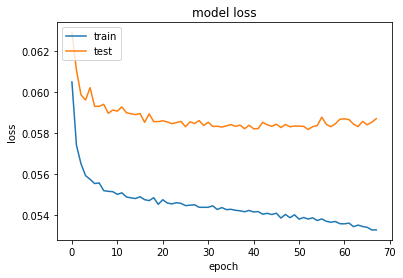

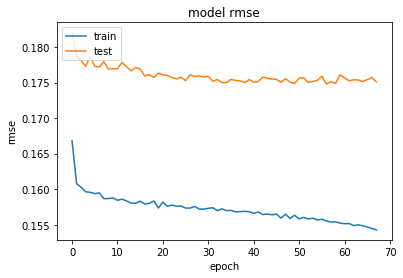

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

(5170, 25, 3) (5170, 10, 3)


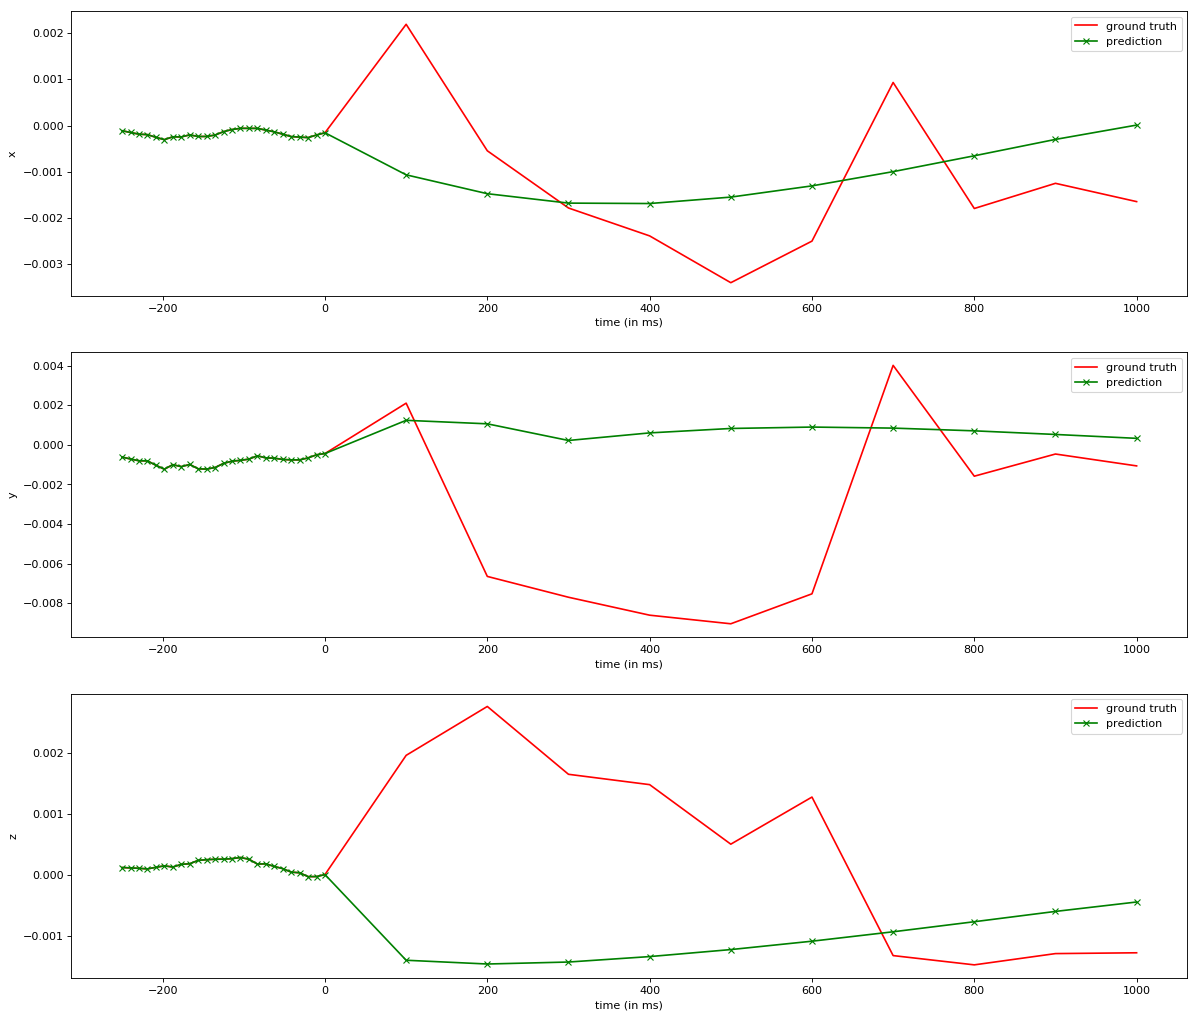

In [13]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )


predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]
        
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...


Evaluation Time :  75.67704916000366 s =  1.2612841645876567 min =  0.021021402809354994 h


### Metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.057550212638368514
Delay 100 ms: 0.0043889578516407715
Delay 200 ms: 0.012671145944443313
Delay 300 ms: 0.023665621646870572
Delay 400 ms: 0.03604126671177703
Delay 500 ms: 0.04912207657239374
Delay 600 ms: 0.06262541765484735
Delay 700 ms: 0.07631960280547856
Delay 800 ms: 0.09003221073668044
Delay 900 ms: 0.10362321565484565
Delay 1000 ms: 0.11701261080470785

RMSE
Average rmse: 0.12118598351351985
Delay 100 ms: 0.011675051442960898
Delay 200 ms: 0.026833693216684038
Delay 300 ms: 0.04672199157776654
Delay 400 ms: 0.06863756144155395
Delay 500 ms: 0.09126926916641877
Delay 600 ms: 0.11410082842350049
Delay 700 ms: 0.13672616499963164
Delay 800 ms: 0.15895270278396392
Delay 900 ms: 0.18064659886328266
Delay 1000 ms: 0.20166967183535833

SMAPE
Average smape: 14.186080548409889
Delay 100 ms: 2.2281261127234595
Delay 200 ms: 5.273460860161731
Delay 300 ms: 8.301398170160105
Delay 400 ms: 11.135577414075877
Delay 500 ms: 13.726333611432622
Delay 600 ms: 16.1211562061938